In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
from scipy.io import loadmat
from scipy.io import savemat
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
from math import exp, pi,sin,cos

np.random.seed(1)
tf.set_random_seed(1)
###########设置定义域范围
# a = 0
# b = 1
a =-pi/2
b = pi/2

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_U, layers_V1,layers_V2, x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_U = layers_U
        self.weights_U, self.biases_U, self.adaps_U = self.initialize_NN(layers_U)
        self.layers_V1 = layers_V1
        self.weights_V1, self.biases_V1, self.adaps_V1 = self.initialize_NN(layers_V1)
        self.layers_V2 = layers_V2
        self.weights_V2, self.biases_V2, self.adaps_V2 = self.initialize_NN(layers_V2)

        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        # Coordinates of datapoints             #####################数据点坐标
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e1,self.e2,self.Uf, self.V1f,self.V2f,self.U_xf,self.V1_xf,self.V2_xf,self.V1e,self.V2e= self.pinn(self.xf)
        _,_,_,self.Ui, self.V1i,self.V2i,_,_,_,_,_= self.pinn(self.xi)
        _,_,_,_,_,_,_,_,_,self.V1e,self.V2e= self.pinn(self.xe)
        self.f_test,  self.e1_test, self.e2_test,self.U_test, self.V1_test,self.V2_test,self.U_x_test,self.V1_x_test,self.V2_x_test,_,_= self.pinn(self.x_test_tf)


        # Fredholm积分微分方程
        self.loss_f = tf.reduce_mean((self.U_xf-(self.xf**2-1.0)*self.V1e+0.5*self.xf**2*(self.xf**2-1.0)*self.V2e-tf.cos(self.xf))** 2)
        self.loss_e1 = tf.reduce_mean((self.V1_xf -self.Uf)** 2)
        self.loss_e2 = tf.reduce_mean((self.V2_xf - self.xf**2*self.Uf) ** 2)
        self.loss_i= tf.reduce_mean((self.Ui+1) ** 2)+tf.reduce_mean((self.V1i) ** 2)\
                     +tf.reduce_mean((self.V2i) ** 2)


        # # Total Loss
        self.loss = self.loss_f *1+ self.loss_e1*1+ self.loss_e2*1 +self.loss_i*1


        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_U(self, X):
        weights = self.weights_U
        biases = self.biases_U
        adaps = self.adaps_U
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(h, W), b)
        return U

    def net_V1(self, X):
        weights = self.weights_V1
        biases = self.biases_V1
        adaps = self.adaps_V1
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V1 = tf.add(tf.matmul(h, W), b)
        return V1
    def net_V2(self, X):
        weights = self.weights_V2
        biases = self.biases_V2
        adaps = self.adaps_V2
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V2= tf.add(tf.matmul(h, W), b)
        return V2

    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        U = self.net_U(X)
        V1 =self.net_V1(X)
        V2 =self.net_V2(X)
        V1e = self.net_V1(X)
        V2e= self.net_V2(X)

        U_x = tf.gradients(U, x)  # du/dx
        V1_x = tf.gradients(V1, x)  # dv/dx
        V2_x = tf.gradients(V2, x)  # dv/dx

        f = U_x - (x ** 2 - 1.0) * V1e + 0.5 * x ** 2 * (x ** 2 - 1.0) * V2e - tf.cos(x)
        e1 = V1_x - U
        e2 = V2_x - x ** 2 * U

        return f,e1,e2,U,V1,V2,U_x ,V1_x,V2_x,V1e,V2e


    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]),100)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, xx,  it, num_train_tps):
        xx = np.linspace(self.x_range[0], self.x_range[1],num_train_tps)
        xx = np.reshape(xx, [-1, 1])
        tf_dict = {self.xx_tf: xx}
        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_f,loss_value_e1,loss_value_e2,loss_value_i= self.sess.run(
            [self.loss, self.loss_f,self.loss_e1,self.loss_e2,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_f*1,loss_value_e1*1,loss_value_e2*1,loss_value_i*1]
        np.set_printoptions(precision=6)
        content = 'It: %d, Loss: %.3e' % (it, loss_value) + '  Losses ILRUDrxIC:' + str(loss_value_array)
        print(content, flush=True)
        # self.f.write(content + "\n")
        return loss_value, loss_value_array

    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V1_test = self.sess.run(self.V1_test, tf_dict)
        V2_test = self.sess.run(self.V2_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)  # du/dx
        V1_test_x = tf.gradients(V1_test, x_test)  # du/dx
        V2_test_x = tf.gradients(V2_test, x_test)  # du/dx
        f_test = self.sess.run(self.f_test, tf_dict)
        e1_test = self.sess.run(self.e1_test, tf_dict)
        e2_test = self.sess.run(self.e2_test, tf_dict)
        return x_test, U_test, V1_test, V2_test,f_test,e1_test,e2_test,U_test_x,V1_test_x,V2_test_x

It: 1, Loss: 1.380e+00  Losses ILRUDrxIC:[0.4810864329338074, 0.018360981717705727, 0.0627964660525322, 0.8176929354667664]
It: 2, Loss: 1.157e+00  Losses ILRUDrxIC:[0.40683361887931824, 0.017530672252178192, 0.060397472232580185, 0.6726710796356201]
It: 3, Loss: 9.787e-01  Losses ILRUDrxIC:[0.3397122323513031, 0.022058481350541115, 0.06687364727258682, 0.5500642657279968]
It: 4, Loss: 8.424e-01  Losses ILRUDrxIC:[0.2798563241958618, 0.03165747970342636, 0.0817372128367424, 0.44917032122612]
It: 5, Loss: 7.459e-01  Losses ILRUDrxIC:[0.22734007239341736, 0.04588509723544121, 0.1041603684425354, 0.3685598373413086]
It: 6, Loss: 6.851e-01  Losses ILRUDrxIC:[0.1821647584438324, 0.06410106271505356, 0.13288329541683197, 0.3059254586696625]
It: 7, Loss: 6.539e-01  Losses ILRUDrxIC:[0.1442333161830902, 0.08542437851428986, 0.1661696583032608, 0.2580909729003906]
It: 8, Loss: 6.453e-01  Losses ILRUDrxIC:[0.11331552267074585, 0.10870718955993652, 0.20186977088451385, 0.22135968506336212]
It: 9,

It: 67, Loss: 5.916e-01  Losses ILRUDrxIC:[0.07920605689287186, 0.1263529360294342, 0.2085614949464798, 0.17752134799957275]
It: 68, Loss: 5.915e-01  Losses ILRUDrxIC:[0.07910022139549255, 0.12690401077270508, 0.20816878974437714, 0.17730140686035156]
It: 69, Loss: 5.913e-01  Losses ILRUDrxIC:[0.07897557318210602, 0.12737196683883667, 0.2079789787530899, 0.1769786775112152]
It: 70, Loss: 5.911e-01  Losses ILRUDrxIC:[0.07883504033088684, 0.1277288943529129, 0.20798511803150177, 0.17656780779361725]
It: 71, Loss: 5.909e-01  Losses ILRUDrxIC:[0.07868191599845886, 0.12795838713645935, 0.20817267894744873, 0.17608483135700226]
It: 72, Loss: 5.906e-01  Losses ILRUDrxIC:[0.07852053642272949, 0.12805575132369995, 0.20852027833461761, 0.17554783821105957]
It: 73, Loss: 5.904e-01  Losses ILRUDrxIC:[0.07835616916418076, 0.1280270516872406, 0.20900046825408936, 0.17497731745243073]
It: 74, Loss: 5.901e-01  Losses ILRUDrxIC:[0.0781947523355484, 0.12788763642311096, 0.20958133041858673, 0.1743940412

It: 132, Loss: 5.684e-01  Losses ILRUDrxIC:[0.07553896307945251, 0.12459386885166168, 0.20265577733516693, 0.1656440943479538]
It: 133, Loss: 5.678e-01  Losses ILRUDrxIC:[0.07542269676923752, 0.12460842728614807, 0.20241355895996094, 0.1653657853603363]
It: 134, Loss: 5.672e-01  Losses ILRUDrxIC:[0.07530339062213898, 0.12462768703699112, 0.20216259360313416, 0.1650785207748413]
It: 135, Loss: 5.665e-01  Losses ILRUDrxIC:[0.07518395781517029, 0.12464757263660431, 0.20189671218395233, 0.16478928923606873]
It: 136, Loss: 5.658e-01  Losses ILRUDrxIC:[0.07506690174341202, 0.12466419488191605, 0.20161043107509613, 0.16450418531894684]
It: 137, Loss: 5.652e-01  Losses ILRUDrxIC:[0.07495424151420593, 0.12467432022094727, 0.20129965245723724, 0.16422797739505768]
It: 138, Loss: 5.644e-01  Losses ILRUDrxIC:[0.07484724372625351, 0.12467534095048904, 0.2009614109992981, 0.16396398842334747]
It: 139, Loss: 5.637e-01  Losses ILRUDrxIC:[0.07474648207426071, 0.12466566264629364, 0.20059438049793243, 0

It: 197, Loss: 4.585e-01  Losses ILRUDrxIC:[0.06001485884189606, 0.125305637717247, 0.14487874507904053, 0.12827931344509125]
It: 198, Loss: 4.555e-01  Losses ILRUDrxIC:[0.05950935184955597, 0.12534311413764954, 0.14359107613563538, 0.12704114615917206]
It: 199, Loss: 4.525e-01  Losses ILRUDrxIC:[0.058993201702833176, 0.1253749430179596, 0.14232948422431946, 0.12578238546848297]
It: 200, Loss: 4.495e-01  Losses ILRUDrxIC:[0.05846652388572693, 0.12540042400360107, 0.14109620451927185, 0.12450442463159561]
It: 201, Loss: 4.465e-01  Losses ILRUDrxIC:[0.05792946740984917, 0.12541861832141876, 0.1398933082818985, 0.12320873141288757]
It: 202, Loss: 4.434e-01  Losses ILRUDrxIC:[0.05738232284784317, 0.12542863190174103, 0.13872237503528595, 0.12189669162034988]
It: 203, Loss: 4.404e-01  Losses ILRUDrxIC:[0.05682523548603058, 0.12542951107025146, 0.1375851184129715, 0.12057001143693924]
It: 204, Loss: 4.374e-01  Losses ILRUDrxIC:[0.056258536875247955, 0.1254202127456665, 0.13648299872875214, 0

It: 262, Loss: 2.573e-01  Losses ILRUDrxIC:[0.024697866290807724, 0.06778300553560257, 0.1111411303281784, 0.05364704877138138]
It: 263, Loss: 2.540e-01  Losses ILRUDrxIC:[0.024246588349342346, 0.0660097524523735, 0.11103033274412155, 0.052664633840322495]
It: 264, Loss: 2.507e-01  Losses ILRUDrxIC:[0.02379857562482357, 0.06426189094781876, 0.11092956364154816, 0.05167274549603462]
It: 265, Loss: 2.474e-01  Losses ILRUDrxIC:[0.02335389330983162, 0.06254322081804276, 0.11083810031414032, 0.050671957433223724]
It: 266, Loss: 2.442e-01  Losses ILRUDrxIC:[0.02291259355843067, 0.0608573816716671, 0.1107550635933876, 0.04966297373175621]
It: 267, Loss: 2.410e-01  Losses ILRUDrxIC:[0.022474555298686028, 0.05920783057808876, 0.11067939549684525, 0.048646796494722366]
It: 268, Loss: 2.379e-01  Losses ILRUDrxIC:[0.02203969657421112, 0.05759785696864128, 0.11061008274555206, 0.047624677419662476]
It: 269, Loss: 2.348e-01  Losses ILRUDrxIC:[0.02160797268152237, 0.056030500680208206, 0.110545627772

It: 326, Loss: 1.180e-01  Losses ILRUDrxIC:[0.007357280235737562, 0.022319769486784935, 0.0754602700471878, 0.01287425309419632]
It: 327, Loss: 1.162e-01  Losses ILRUDrxIC:[0.007254080846905708, 0.022050753235816956, 0.07427793741226196, 0.01264607347548008]
It: 328, Loss: 1.144e-01  Losses ILRUDrxIC:[0.007152017205953598, 0.021782543510198593, 0.07309208810329437, 0.012419485487043858]
It: 329, Loss: 1.127e-01  Losses ILRUDrxIC:[0.0070510683581233025, 0.021514983847737312, 0.07190333306789398, 0.012194298207759857]
It: 330, Loss: 1.109e-01  Losses ILRUDrxIC:[0.0069511644542217255, 0.021247930824756622, 0.07071233540773392, 0.01197042316198349]
It: 331, Loss: 1.091e-01  Losses ILRUDrxIC:[0.006852260325103998, 0.02098126895725727, 0.06951972097158432, 0.011747712269425392]
It: 332, Loss: 1.073e-01  Losses ILRUDrxIC:[0.0067543089389801025, 0.020714884623885155, 0.06832613795995712, 0.01152617298066616]
It: 333, Loss: 1.055e-01  Losses ILRUDrxIC:[0.006657285615801811, 0.020448708906769753

It: 389, Loss: 2.629e-02  Losses ILRUDrxIC:[0.0038030194118618965, 0.007331235334277153, 0.012542681768536568, 0.0026139989495277405]
It: 390, Loss: 2.554e-02  Losses ILRUDrxIC:[0.0038136793300509453, 0.007179253734648228, 0.012011080048978329, 0.0025346865877509117]
It: 391, Loss: 2.482e-02  Losses ILRUDrxIC:[0.0038254528772085905, 0.007030143868178129, 0.011501986533403397, 0.0024584485217928886]
It: 392, Loss: 2.412e-02  Losses ILRUDrxIC:[0.0038381994236260653, 0.006883976515382528, 0.01101525779813528, 0.002385309198871255]
It: 393, Loss: 2.346e-02  Losses ILRUDrxIC:[0.003851870307698846, 0.006740810349583626, 0.01055070385336876, 0.002315133810043335]
It: 394, Loss: 2.282e-02  Losses ILRUDrxIC:[0.0038663989398628473, 0.006600682623684406, 0.010108059272170067, 0.0022479069884866476]
It: 395, Loss: 2.222e-02  Losses ILRUDrxIC:[0.003881717100739479, 0.006463681347668171, 0.009687067940831184, 0.0021834170911461115]
It: 396, Loss: 2.164e-02  Losses ILRUDrxIC:[0.00389777310192585, 0.0

It: 450, Loss: 1.199e-02  Losses ILRUDrxIC:[0.00443169753998518, 0.003035779809579253, 0.00362441991455853, 0.00089464575285092]
It: 451, Loss: 1.195e-02  Losses ILRUDrxIC:[0.004431271925568581, 0.0030171554535627365, 0.003607063088566065, 0.0008903918787837029]
It: 452, Loss: 1.191e-02  Losses ILRUDrxIC:[0.004430779721587896, 0.00299900327809155, 0.0035905069671571255, 0.0008860456291586161]
It: 453, Loss: 1.187e-02  Losses ILRUDrxIC:[0.004430229775607586, 0.002981346333399415, 0.0035746132489293814, 0.0008815933251753449]
It: 454, Loss: 1.183e-02  Losses ILRUDrxIC:[0.004429478198289871, 0.002964166458696127, 0.003559436183422804, 0.0008771187858656049]
It: 455, Loss: 1.179e-02  Losses ILRUDrxIC:[0.004428484011441469, 0.0029474585317075253, 0.003544923383742571, 0.0008726586238481104]
It: 456, Loss: 1.176e-02  Losses ILRUDrxIC:[0.0044272239319980145, 0.0029312181286513805, 0.0035309791564941406, 0.0008683099877089262]
It: 457, Loss: 1.172e-02  Losses ILRUDrxIC:[0.0044257501140236855, 

It: 512, Loss: 1.046e-02  Losses ILRUDrxIC:[0.004269969649612904, 0.002491442486643791, 0.0029286628123372793, 0.0007694909581914544]
It: 513, Loss: 1.044e-02  Losses ILRUDrxIC:[0.004266477655619383, 0.0024882275611162186, 0.002919625025242567, 0.0007684140000492334]
It: 514, Loss: 1.043e-02  Losses ILRUDrxIC:[0.004262997768819332, 0.002485049655660987, 0.0029106109868735075, 0.0007673886138945818]
It: 515, Loss: 1.041e-02  Losses ILRUDrxIC:[0.004259481560438871, 0.0024819811806082726, 0.0029016858898103237, 0.0007663138676434755]
It: 516, Loss: 1.039e-02  Losses ILRUDrxIC:[0.00425591180101037, 0.002479004207998514, 0.002892858348786831, 0.0007652118219994009]
It: 517, Loss: 1.038e-02  Losses ILRUDrxIC:[0.004252352751791477, 0.0024760544765740633, 0.0028840196318924427, 0.0007641948177479208]
It: 518, Loss: 1.036e-02  Losses ILRUDrxIC:[0.0042487760074436665, 0.0024731913581490517, 0.002875187899917364, 0.0007632136112079024]
It: 519, Loss: 1.034e-02  Losses ILRUDrxIC:[0.004245090298354

It: 574, Loss: 9.556e-03  Losses ILRUDrxIC:[0.00402302760630846, 0.0023699046578258276, 0.0024439776316285133, 0.0007195780635811388]
It: 575, Loss: 9.543e-03  Losses ILRUDrxIC:[0.004018743522465229, 0.0023684310726821423, 0.0024371775798499584, 0.000718864961527288]
It: 576, Loss: 9.530e-03  Losses ILRUDrxIC:[0.004014380741864443, 0.0023669616784900427, 0.0024304327089339495, 0.0007181894616223872]
It: 577, Loss: 9.517e-03  Losses ILRUDrxIC:[0.004010068252682686, 0.0023654678370803595, 0.002423688070848584, 0.0007175075588747859]
It: 578, Loss: 9.504e-03  Losses ILRUDrxIC:[0.004005757160484791, 0.002363982843235135, 0.002416969509795308, 0.0007168137235566974]
It: 579, Loss: 9.490e-03  Losses ILRUDrxIC:[0.004001370165497065, 0.0023625085595995188, 0.0024103031028062105, 0.0007161138928495347]
It: 580, Loss: 9.477e-03  Losses ILRUDrxIC:[0.003997039515525103, 0.002361011691391468, 0.0024035978130996227, 0.0007154503255151212]
It: 581, Loss: 9.464e-03  Losses ILRUDrxIC:[0.003992730751633

It: 636, Loss: 8.738e-03  Losses ILRUDrxIC:[0.003737838240340352, 0.002268710173666477, 0.0020556366071105003, 0.0006758014787919819]
It: 637, Loss: 8.724e-03  Losses ILRUDrxIC:[0.0037328703328967094, 0.002266788389533758, 0.0020497464574873447, 0.0006750726024620235]
It: 638, Loss: 8.711e-03  Losses ILRUDrxIC:[0.0037279778625816107, 0.0022648517042398453, 0.0020438143983483315, 0.0006743230624124408]
It: 639, Loss: 8.697e-03  Losses ILRUDrxIC:[0.003722952213138342, 0.0022629699669778347, 0.0020379675552248955, 0.0006735407514497638]
It: 640, Loss: 8.684e-03  Losses ILRUDrxIC:[0.0037179982755333185, 0.0022610456217080355, 0.002032091375440359, 0.0006727282889187336]
It: 641, Loss: 8.670e-03  Losses ILRUDrxIC:[0.003713024314492941, 0.0022590667940676212, 0.0020261909812688828, 0.0006720151286572218]
It: 642, Loss: 8.657e-03  Losses ILRUDrxIC:[0.003707991214469075, 0.002257133135572076, 0.002020358806475997, 0.0006712186732329428]
It: 643, Loss: 8.643e-03  Losses ILRUDrxIC:[0.00370296486

It: 697, Loss: 7.872e-03  Losses ILRUDrxIC:[0.0034065109211951494, 0.0021330120507627726, 0.0017088985769078135, 0.0006236504996195436]
It: 698, Loss: 7.857e-03  Losses ILRUDrxIC:[0.0034007420763373375, 0.002130418550223112, 0.0017033613985404372, 0.0006225396646186709]
It: 699, Loss: 7.842e-03  Losses ILRUDrxIC:[0.003394405823200941, 0.002127863699570298, 0.0016980350483208895, 0.0006216902402229607]
It: 700, Loss: 7.827e-03  Losses ILRUDrxIC:[0.003388472832739353, 0.002125220373272896, 0.0016925579402595758, 0.0006206646212376654]
It: 701, Loss: 7.812e-03  Losses ILRUDrxIC:[0.003382333554327488, 0.002122647827491164, 0.0016871568514034152, 0.0006196683971211314]
It: 702, Loss: 7.797e-03  Losses ILRUDrxIC:[0.0033760503865778446, 0.0021200606133788824, 0.001681815949268639, 0.0006187476683408022]
It: 703, Loss: 7.782e-03  Losses ILRUDrxIC:[0.0033701041247695684, 0.0021173879504203796, 0.0016763577004894614, 0.0006176565075293183]
It: 704, Loss: 7.766e-03  Losses ILRUDrxIC:[0.0033636998

It: 758, Loss: 6.899e-03  Losses ILRUDrxIC:[0.0029862364754080772, 0.0019536844920367002, 0.001401658752001822, 0.0005569733330048621]
It: 759, Loss: 6.882e-03  Losses ILRUDrxIC:[0.002978755859658122, 0.0019502893555909395, 0.001396943349391222, 0.0005555626703426242]
It: 760, Loss: 6.865e-03  Losses ILRUDrxIC:[0.0029704696498811245, 0.0019469755934551358, 0.0013925612438470125, 0.0005545224412344396]
It: 761, Loss: 6.847e-03  Losses ILRUDrxIC:[0.002962800906971097, 0.0019436078146100044, 0.0013879579491913319, 0.0005530798225663602]
It: 762, Loss: 6.830e-03  Losses ILRUDrxIC:[0.002954613883048296, 0.0019401683239266276, 0.0013835447607561946, 0.0005520270206034184]
It: 763, Loss: 6.813e-03  Losses ILRUDrxIC:[0.0029467057902365923, 0.0019368295324966311, 0.0013790321536362171, 0.0005506327725015581]
It: 764, Loss: 6.796e-03  Losses ILRUDrxIC:[0.0029385662637650967, 0.0019334012176841497, 0.001374601386487484, 0.0005494490033015609]
It: 765, Loss: 6.779e-03  Losses ILRUDrxIC:[0.00293051

It: 819, Loss: 5.792e-03  Losses ILRUDrxIC:[0.002457304857671261, 0.001721846405416727, 0.0011494727805256844, 0.0004629135364666581]
It: 820, Loss: 5.772e-03  Losses ILRUDrxIC:[0.0024032513611018658, 0.001721407170407474, 0.001165118650533259, 0.0004823445051442832]
It: 821, Loss: 5.752e-03  Losses ILRUDrxIC:[0.002432845998555422, 0.0017124740406870842, 0.0011442258255556226, 0.0004629403701983392]
It: 822, Loss: 5.733e-03  Losses ILRUDrxIC:[0.0023937691003084183, 0.0017126580933108926, 0.0011534133227542043, 0.00047292947419919074]
It: 823, Loss: 5.713e-03  Losses ILRUDrxIC:[0.0023957008961588144, 0.0017056406941264868, 0.0011445614509284496, 0.0004672181385103613]
It: 824, Loss: 5.694e-03  Losses ILRUDrxIC:[0.0023902514949440956, 0.0017013308824971318, 0.0011390387080609798, 0.0004629748873412609]
It: 825, Loss: 5.674e-03  Losses ILRUDrxIC:[0.0023601921275258064, 0.0016997935017570853, 0.0011444370029494166, 0.00046969609684310853]
It: 826, Loss: 5.655e-03  Losses ILRUDrxIC:[0.00237

It: 880, Loss: 4.543e-03  Losses ILRUDrxIC:[0.0017478778026998043, 0.0014395305188372731, 0.0009798615938052535, 0.0003758898237720132]
It: 881, Loss: 4.522e-03  Losses ILRUDrxIC:[0.0017414025496691465, 0.0014339296612888575, 0.0009748119045980275, 0.000371840491425246]
It: 882, Loss: 4.501e-03  Losses ILRUDrxIC:[0.0017237717984244227, 0.0014295491855591536, 0.000974916503764689, 0.00037253694608807564]
It: 883, Loss: 4.480e-03  Losses ILRUDrxIC:[0.001717979903332889, 0.0014237037394195795, 0.000969607091974467, 0.00036827073199674487]
It: 884, Loss: 4.458e-03  Losses ILRUDrxIC:[0.0016995177138596773, 0.0014194819377735257, 0.0009700350346975029, 0.00036932353395968676]
It: 885, Loss: 4.437e-03  Losses ILRUDrxIC:[0.0016947089461609721, 0.0014135186793282628, 0.0009643541998229921, 0.00036456884117797017]
It: 886, Loss: 4.416e-03  Losses ILRUDrxIC:[0.0016750377835705876, 0.0014093436766415834, 0.000965363229624927, 0.0003661905648186803]
It: 887, Loss: 4.395e-03  Losses ILRUDrxIC:[0.001

It: 941, Loss: 3.289e-03  Losses ILRUDrxIC:[0.0010633016936481, 0.0011214393889531493, 0.0008372502052225173, 0.00026678951689973474]
It: 942, Loss: 3.270e-03  Losses ILRUDrxIC:[0.0010384899796918035, 0.0011187189957126975, 0.0008416096679866314, 0.00027100631268694997]
It: 943, Loss: 3.251e-03  Losses ILRUDrxIC:[0.0010390165261924267, 0.0011116815730929375, 0.0008349652634933591, 0.0002653046976774931]
It: 944, Loss: 3.232e-03  Losses ILRUDrxIC:[0.0010229424806311727, 0.0011077583767473698, 0.000835725455544889, 0.00026577457902021706]
It: 945, Loss: 3.214e-03  Losses ILRUDrxIC:[0.001014518435113132, 0.0011021823156625032, 0.0008330130367539823, 0.0002638296573422849]
It: 946, Loss: 3.195e-03  Losses ILRUDrxIC:[0.0010074620367959142, 0.0010967135895043612, 0.0008298765169456601, 0.0002609334187582135]
It: 947, Loss: 3.177e-03  Losses ILRUDrxIC:[0.0009912429377436638, 0.0010926311369985342, 0.0008308006217703223, 0.00026185857132077217]
It: 948, Loss: 3.158e-03  Losses ILRUDrxIC:[0.000

It: 1002, Loss: 2.344e-03  Losses ILRUDrxIC:[0.0006195221794769168, 0.0008308731485158205, 0.0007236771052703261, 0.00016999478975776583]
It: 1003, Loss: 2.333e-03  Losses ILRUDrxIC:[0.0005532827926799655, 0.0008373239543288946, 0.0007458350155502558, 0.000196992012206465]
It: 1004, Loss: 2.322e-03  Losses ILRUDrxIC:[0.0006210000719875097, 0.0008205744670704007, 0.0007164537091739476, 0.00016443204367533326]
It: 1005, Loss: 2.311e-03  Losses ILRUDrxIC:[0.0005433402839116752, 0.0008298151078633964, 0.0007438063621520996, 0.00019410249660722911]
It: 1006, Loss: 2.299e-03  Losses ILRUDrxIC:[0.0006036172271706164, 0.0008137903641909361, 0.0007161517278291285, 0.00016581524687353522]
It: 1007, Loss: 2.288e-03  Losses ILRUDrxIC:[0.0005486175650730729, 0.0008191326051019132, 0.0007346378988586366, 0.0001853123540058732]
It: 1008, Loss: 2.276e-03  Losses ILRUDrxIC:[0.0005743559449911118, 0.0008096099481917918, 0.000721315445844084, 0.00017111733905039728]
It: 1009, Loss: 2.266e-03  Losses ILRU

It: 1061, Loss: 1.882e-03  Losses ILRUDrxIC:[0.00044330061064101756, 0.000642227241769433, 0.0006617069011554122, 0.000134325644467026]
It: 1062, Loss: 1.877e-03  Losses ILRUDrxIC:[0.00045548976049758494, 0.0006381124258041382, 0.0006557449814863503, 0.00012752356997225434]
It: 1063, Loss: 1.872e-03  Losses ILRUDrxIC:[0.00044120504753664136, 0.0006373709184117615, 0.0006600365159101784, 0.00013364895130507648]
It: 1064, Loss: 1.868e-03  Losses ILRUDrxIC:[0.00045572430826723576, 0.0006330074393190444, 0.000653210561722517, 0.0001258069387404248]
It: 1065, Loss: 1.863e-03  Losses ILRUDrxIC:[0.000438657880295068, 0.0006326959119178355, 0.0006587021634913981, 0.00013326962653081864]
It: 1066, Loss: 1.859e-03  Losses ILRUDrxIC:[0.0004568450094666332, 0.0006279309745877981, 0.0006504101911559701, 0.00012378911196719855]
It: 1067, Loss: 1.855e-03  Losses ILRUDrxIC:[0.0004354453121777624, 0.0006282060057856143, 0.000657685159239918, 0.0001333786640316248]
It: 1068, Loss: 1.851e-03  Losses ILRU

It: 1121, Loss: 1.700e-03  Losses ILRUDrxIC:[0.0004462638753466308, 0.0005267088999971747, 0.0006112299161031842, 0.00011542475840542465]
It: 1122, Loss: 1.698e-03  Losses ILRUDrxIC:[0.00046292715705931187, 0.000528357457369566, 0.0006066121277399361, 9.983041672967374e-05]
It: 1123, Loss: 1.696e-03  Losses ILRUDrxIC:[0.00044734255061484873, 0.0005236291326582432, 0.0006095942808315158, 0.00011527143942657858]
It: 1124, Loss: 1.694e-03  Losses ILRUDrxIC:[0.00046252444735728204, 0.000525988289155066, 0.000605645589530468, 9.977219451684505e-05]
It: 1125, Loss: 1.692e-03  Losses ILRUDrxIC:[0.0004497696063481271, 0.0005206484929658473, 0.0006079027079977095, 0.00011372464359737933]
It: 1126, Loss: 1.690e-03  Losses ILRUDrxIC:[0.00046106032095849514, 0.0005236538127064705, 0.0006047043716534972, 0.00010074262536363676]
It: 1127, Loss: 1.688e-03  Losses ILRUDrxIC:[0.0004529539146460593, 0.0005176984122954309, 0.0006061678868718445, 0.000111497996840626]
It: 1128, Loss: 1.686e-03  Losses ILR

It: 1181, Loss: 1.610e-03  Losses ILRUDrxIC:[0.00045142523595131934, 0.0004625657165888697, 0.0005799643113277853, 0.00011641594755928963]
It: 1182, Loss: 1.609e-03  Losses ILRUDrxIC:[0.0004929560236632824, 0.0004655072116293013, 0.0005705524818040431, 8.016263018362224e-05]
It: 1183, Loss: 1.608e-03  Losses ILRUDrxIC:[0.0004502235969994217, 0.0004626392328646034, 0.0005790136638097465, 0.00011606459156610072]
It: 1184, Loss: 1.607e-03  Losses ILRUDrxIC:[0.0004941732622683048, 0.0004616628575604409, 0.0005701079498976469, 8.071826596278697e-05]
It: 1185, Loss: 1.605e-03  Losses ILRUDrxIC:[0.0004501894873101264, 0.0004635436926037073, 0.0005772564909420907, 0.00011437598004704341]
It: 1186, Loss: 1.604e-03  Losses ILRUDrxIC:[0.0004942141240462661, 0.00045762176159769297, 0.0005701387417502701, 8.2106635090895e-05]
It: 1187, Loss: 1.603e-03  Losses ILRUDrxIC:[0.0004509607970248908, 0.0004641559789888561, 0.0005753799341619015, 0.00011229218944208696]
It: 1188, Loss: 1.601e-03  Losses ILR

It: 1241, Loss: 1.538e-03  Losses ILRUDrxIC:[0.00046386374742724, 0.0004259144770912826, 0.0005507005262188613, 9.78686148300767e-05]
It: 1242, Loss: 1.537e-03  Losses ILRUDrxIC:[0.0004831894184462726, 0.0004220260016154498, 0.0005489775794558227, 8.326888200826943e-05]
It: 1243, Loss: 1.537e-03  Losses ILRUDrxIC:[0.00045902482816018164, 0.00042422767728567123, 0.0005496547091752291, 0.00010369314259150997]
It: 1244, Loss: 1.536e-03  Losses ILRUDrxIC:[0.00048669084208086133, 0.00042156054405495524, 0.0005486788577400148, 7.87768658483401e-05]
It: 1245, Loss: 1.535e-03  Losses ILRUDrxIC:[0.0004566157585941255, 0.00042233997373841703, 0.0005484673893079162, 0.00010735487740021199]
It: 1246, Loss: 1.534e-03  Losses ILRUDrxIC:[0.00048799574142321944, 0.0004211958439555019, 0.0005482727428898215, 7.631403423147276e-05]
It: 1247, Loss: 1.533e-03  Losses ILRUDrxIC:[0.0004558244254440069, 0.0004204876604489982, 0.0005475511425174773, 0.00010885967640206218]
It: 1248, Loss: 1.532e-03  Losses IL

It: 1301, Loss: 1.474e-03  Losses ILRUDrxIC:[0.00046609793207608163, 0.0003990461409557611, 0.0005278424359858036, 8.092089410638437e-05]
It: 1302, Loss: 1.474e-03  Losses ILRUDrxIC:[0.0004718508862424642, 0.0003842162841465324, 0.0005330349085852504, 8.44035530462861e-05]
It: 1303, Loss: 1.474e-03  Losses ILRUDrxIC:[0.00044923045788891613, 0.00040263953269459307, 0.000518888293299824, 0.0001033071312122047]
It: 1304, Loss: 1.475e-03  Losses ILRUDrxIC:[0.00048513413639739156, 0.00038104012492112815, 0.0005381667870096862, 7.024460501270369e-05]
It: 1305, Loss: 1.474e-03  Losses ILRUDrxIC:[0.00044126741704531014, 0.0004016067832708359, 0.000516010622959584, 0.00011541366984602064]
It: 1306, Loss: 1.473e-03  Losses ILRUDrxIC:[0.0004883555811829865, 0.0003824196755886078, 0.0005364810931496322, 6.569416291313246e-05]
It: 1307, Loss: 1.471e-03  Losses ILRUDrxIC:[0.0004423423088155687, 0.00039626393117941916, 0.0005191146628931165, 0.000113084985059686]
It: 1308, Loss: 1.468e-03  Losses ILR

It: 1361, Loss: 1.419e-03  Losses ILRUDrxIC:[0.00047061036457307637, 0.0003871259978041053, 0.0005000773817300797, 6.092564944992773e-05]
It: 1362, Loss: 1.420e-03  Losses ILRUDrxIC:[0.0004325185436755419, 0.0003443747409619391, 0.0005182939348742366, 0.00012502398749347776]
It: 1363, Loss: 1.422e-03  Losses ILRUDrxIC:[0.00048336770851165056, 0.0003915664565283805, 0.0004952470771968365, 5.213050462771207e-05]
It: 1364, Loss: 1.425e-03  Losses ILRUDrxIC:[0.0004188252205494791, 0.00034036170109175146, 0.000522957241628319, 0.00014266735524870455]
It: 1365, Loss: 1.427e-03  Losses ILRUDrxIC:[0.0005036322982050478, 0.0003907496575266123, 0.00048945372691378, 4.338053258834407e-05]
It: 1366, Loss: 1.429e-03  Losses ILRUDrxIC:[0.00040171240107156336, 0.00034432768006809056, 0.0005279417964629829, 0.00015507718489971012]
It: 1367, Loss: 1.430e-03  Losses ILRUDrxIC:[0.0005292440764605999, 0.0003788808826357126, 0.0004860582994297147, 3.5960103559773415e-05]
It: 1368, Loss: 1.431e-03  Losses I

It: 1421, Loss: 1.357e-03  Losses ILRUDrxIC:[0.00043545954395085573, 0.0003446449409238994, 0.0004961890517733991, 8.022710971999913e-05]
It: 1422, Loss: 1.356e-03  Losses ILRUDrxIC:[0.00044751077075488865, 0.00034267312730662525, 0.0004846859083045274, 8.065711881499738e-05]
It: 1423, Loss: 1.355e-03  Losses ILRUDrxIC:[0.0004371445975266397, 0.0003444272733759135, 0.0004908908740617335, 8.21117137093097e-05]
It: 1424, Loss: 1.354e-03  Losses ILRUDrxIC:[0.00044468865962699056, 0.0003419223357923329, 0.000488661287818104, 7.839559111744165e-05]
It: 1425, Loss: 1.353e-03  Losses ILRUDrxIC:[0.00043920509051531553, 0.00034342557773925364, 0.0004859355976805091, 8.42047156766057e-05]
It: 1426, Loss: 1.352e-03  Losses ILRUDrxIC:[0.0004419053439050913, 0.0003416661929804832, 0.0004919040366075933, 7.642024866072461e-05]
It: 1427, Loss: 1.351e-03  Losses ILRUDrxIC:[0.00044088615686632693, 0.0003422105801291764, 0.00048212663386948407, 8.582214650232345e-05]
It: 1428, Loss: 1.350e-03  Losses IL

It: 1481, Loss: 1.312e-03  Losses ILRUDrxIC:[0.00040639255894348025, 0.00032992922933772206, 0.0005244255298748612, 5.1612427341751754e-05]
It: 1482, Loss: 1.307e-03  Losses ILRUDrxIC:[0.0004133876063860953, 0.00031441680039279163, 0.0004608948074746877, 0.00011865683336509392]
It: 1483, Loss: 1.313e-03  Losses ILRUDrxIC:[0.00048432641779072583, 0.0003322794218547642, 0.000445892772404477, 5.021949255024083e-05]
It: 1484, Loss: 1.317e-03  Losses ILRUDrxIC:[0.00037508009700104594, 0.00031670311000198126, 0.0005218001315370202, 0.00010298614506609738]
It: 1485, Loss: 1.313e-03  Losses ILRUDrxIC:[0.0004903714871034026, 0.0003237201308365911, 0.0004152902984060347, 8.387721754843369e-05]
It: 1486, Loss: 1.308e-03  Losses ILRUDrxIC:[0.00040123314829543233, 0.00032541219843551517, 0.0005229961243458092, 5.8149696997134015e-05]
It: 1487, Loss: 1.307e-03  Losses ILRUDrxIC:[0.0004275816027075052, 0.00031536645838059485, 0.0004333122924435884, 0.00013075198512524366]
It: 1488, Loss: 1.310e-03  L

It: 1541, Loss: 1.253e-03  Losses ILRUDrxIC:[0.00042166170896962285, 0.00030617922311648726, 0.00044779301970265806, 7.744853792246431e-05]
It: 1542, Loss: 1.252e-03  Losses ILRUDrxIC:[0.00041526154382154346, 0.00030431582126766443, 0.00046077833394519985, 7.192474004114047e-05]
It: 1543, Loss: 1.251e-03  Losses ILRUDrxIC:[0.0004205940058454871, 0.0003055347187910229, 0.00044696382246911526, 7.838939200155437e-05]
It: 1544, Loss: 1.251e-03  Losses ILRUDrxIC:[0.0004165482532698661, 0.0003040358133148402, 0.00045997212873771787, 7.012413698248565e-05]
It: 1545, Loss: 1.250e-03  Losses ILRUDrxIC:[0.00041796115692704916, 0.00030453281942754984, 0.00044687039917334914, 8.053382043726742e-05]
It: 1546, Loss: 1.249e-03  Losses ILRUDrxIC:[0.0004183804849162698, 0.00030395787325687706, 0.000459059898275882, 6.77402931614779e-05]
It: 1547, Loss: 1.248e-03  Losses ILRUDrxIC:[0.0004158321535214782, 0.0003035108093172312, 0.0004462488868739456, 8.279711619252339e-05]
It: 1548, Loss: 1.248e-03  Loss

It: 1601, Loss: 1.209e-03  Losses ILRUDrxIC:[0.00039060565177351236, 0.0002912320487666875, 0.0004664909793063998, 6.028387724654749e-05]
It: 1602, Loss: 1.206e-03  Losses ILRUDrxIC:[0.0004148541484028101, 0.0002890232717618346, 0.00041981524555012584, 8.258751768153161e-05]
It: 1603, Loss: 1.205e-03  Losses ILRUDrxIC:[0.0004074641619808972, 0.0002863127156160772, 0.0004445124650374055, 6.633535667788237e-05]
It: 1604, Loss: 1.204e-03  Losses ILRUDrxIC:[0.00039807200664654374, 0.00029243159224279225, 0.0004400029720272869, 7.31944091967307e-05]
It: 1605, Loss: 1.203e-03  Losses ILRUDrxIC:[0.0004206242156215012, 0.00028295457013882697, 0.0004250772180967033, 7.465681119356304e-05]
It: 1606, Loss: 1.203e-03  Losses ILRUDrxIC:[0.00038975567440502346, 0.0002935280790552497, 0.0004549805889837444, 6.48971545160748e-05]
It: 1607, Loss: 1.203e-03  Losses ILRUDrxIC:[0.000424092635512352, 0.0002822041278705001, 0.0004139076918363571, 8.274282299680635e-05]
It: 1608, Loss: 1.203e-03  Losses ILRU

It: 1661, Loss: 1.186e-03  Losses ILRUDrxIC:[0.0004544592520687729, 0.00025814419495873153, 0.00034449956729076803, 0.00012855094973929226]
It: 1662, Loss: 1.194e-03  Losses ILRUDrxIC:[0.0003472458920441568, 0.0003007630875799805, 0.0005215635756030679, 2.4222736101364717e-05]
It: 1663, Loss: 1.204e-03  Losses ILRUDrxIC:[0.0004587765142787248, 0.00024378340458497405, 0.00032410104176960886, 0.00017722292977850884]
It: 1664, Loss: 1.215e-03  Losses ILRUDrxIC:[0.00034844689071178436, 0.00030629560933448374, 0.0005459718522615731, 1.4318119610834401e-05]
It: 1665, Loss: 1.227e-03  Losses ILRUDrxIC:[0.00044885120587423444, 0.00024668549303896725, 0.00030628370586782694, 0.00022556967451237142]
It: 1666, Loss: 1.241e-03  Losses ILRUDrxIC:[0.00035715955891646445, 0.0002936497621703893, 0.0005678351153619587, 2.240778849227354e-05]
It: 1667, Loss: 1.256e-03  Losses ILRUDrxIC:[0.000432849075878039, 0.0002628026995807886, 0.00029221500153653324, 0.00026813233853317797]
It: 1668, Loss: 1.269e-03

It: 1721, Loss: 1.120e-03  Losses ILRUDrxIC:[0.00039298832416534424, 0.0002554113743826747, 0.0003928029618691653, 7.919179188320413e-05]
It: 1722, Loss: 1.120e-03  Losses ILRUDrxIC:[0.00037741399137303233, 0.0002664920757524669, 0.00042132954695262015, 5.45087932550814e-05]
It: 1723, Loss: 1.119e-03  Losses ILRUDrxIC:[0.00039095483953133225, 0.00025546926190145314, 0.0003929348895326257, 7.965647819219157e-05]
It: 1724, Loss: 1.118e-03  Losses ILRUDrxIC:[0.0003792945062741637, 0.000264443428022787, 0.00041944466647692025, 5.507028618012555e-05]
It: 1725, Loss: 1.117e-03  Losses ILRUDrxIC:[0.00038789043901488185, 0.00025744171580299735, 0.0003942846378777176, 7.785177149344236e-05]
It: 1726, Loss: 1.117e-03  Losses ILRUDrxIC:[0.000381502672098577, 0.00026119608082808554, 0.0004167912993580103, 5.720783519791439e-05]
It: 1727, Loss: 1.116e-03  Losses ILRUDrxIC:[0.000385374209145084, 0.0002598989522084594, 0.00039576925337314606, 7.49203099985607e-05]
It: 1728, Loss: 1.115e-03  Losses IL

It: 1781, Loss: 1.093e-03  Losses ILRUDrxIC:[0.00039003760321065784, 0.00026695619453676045, 0.00035314098931849003, 8.267491648439318e-05]
It: 1782, Loss: 1.085e-03  Losses ILRUDrxIC:[0.0003719707892742008, 0.00022972260194364935, 0.0004081565130036324, 7.482578803319484e-05]
It: 1783, Loss: 1.081e-03  Losses ILRUDrxIC:[0.0003655239997897297, 0.00026566642918623984, 0.0004018189792986959, 4.827241718885489e-05]
It: 1784, Loss: 1.082e-03  Losses ILRUDrxIC:[0.0003922361065633595, 0.00023527861048933119, 0.0003624229575507343, 9.245950786862522e-05]
It: 1785, Loss: 1.086e-03  Losses ILRUDrxIC:[0.00035279590520076454, 0.0002551208308432251, 0.00043784684385173023, 3.998389729531482e-05]
It: 1786, Loss: 1.089e-03  Losses ILRUDrxIC:[0.000398658070480451, 0.00024707638658583164, 0.00034190891892649233, 0.00010090406431118026]
It: 1787, Loss: 1.089e-03  Losses ILRUDrxIC:[0.00035309328814037144, 0.00024226706591434777, 0.0004440109187271446, 4.951522350893356e-05]
It: 1788, Loss: 1.086e-03  Lo

It: 1841, Loss: 1.043e-03  Losses ILRUDrxIC:[0.00036501241265796125, 0.0002376678748987615, 0.0003778517711907625, 6.200513598741964e-05]
It: 1842, Loss: 1.042e-03  Losses ILRUDrxIC:[0.0003632332372944802, 0.00023687152133788913, 0.00038027632399462163, 6.155560549814254e-05]
It: 1843, Loss: 1.041e-03  Losses ILRUDrxIC:[0.0003647930279839784, 0.00023799610789865255, 0.00037683657137677073, 6.171005225041881e-05]
It: 1844, Loss: 1.041e-03  Losses ILRUDrxIC:[0.0003628330014180392, 0.00023591511126141995, 0.0003803001600317657, 6.16989127593115e-05]
It: 1845, Loss: 1.040e-03  Losses ILRUDrxIC:[0.00036450967309065163, 0.00023815681925043464, 0.0003759963728953153, 6.148902321001515e-05]
It: 1846, Loss: 1.040e-03  Losses ILRUDrxIC:[0.0003624474338721484, 0.00023513053019996732, 0.0003802104911301285, 6.176860188134015e-05]
It: 1847, Loss: 1.039e-03  Losses ILRUDrxIC:[0.00036423729034140706, 0.000238142121816054, 0.0003752271004486829, 6.135786679806188e-05]
It: 1848, Loss: 1.038e-03  Losses

It: 1901, Loss: 1.040e-03  Losses ILRUDrxIC:[0.0004045093373861164, 0.00022736834944225848, 0.0002877470979001373, 0.00012020353460684419]
It: 1902, Loss: 1.025e-03  Losses ILRUDrxIC:[0.0003125632065348327, 0.0002368176355957985, 0.0004360396706033498, 3.962074697483331e-05]
It: 1903, Loss: 1.014e-03  Losses ILRUDrxIC:[0.0004047754919156432, 0.00020863387908320874, 0.0003266699204687029, 7.430669211316854e-05]
It: 1904, Loss: 1.012e-03  Losses ILRUDrxIC:[0.00032271325471810997, 0.000249854929279536, 0.0003770764160435647, 6.207023398019373e-05]
It: 1905, Loss: 1.015e-03  Losses ILRUDrxIC:[0.0003754716308321804, 0.00020309563842602074, 0.0003821080317720771, 5.460867760120891e-05]
It: 1906, Loss: 1.020e-03  Losses ILRUDrxIC:[0.00035087871947325766, 0.00024725301773287356, 0.0003276639326941222, 9.438447887077928e-05]
It: 1907, Loss: 1.022e-03  Losses ILRUDrxIC:[0.00034062963095493615, 0.00021168665261939168, 0.0004188965249340981, 5.08410666952841e-05]
It: 1908, Loss: 1.020e-03  Losses 

It: 1961, Loss: 9.735e-04  Losses ILRUDrxIC:[0.0003462583990767598, 0.00021466916950885206, 0.0003512061375658959, 6.138309254311025e-05]
It: 1962, Loss: 9.730e-04  Losses ILRUDrxIC:[0.00034474325366318226, 0.00021965503401588649, 0.0003547451924532652, 5.381171285989694e-05]
It: 1963, Loss: 9.724e-04  Losses ILRUDrxIC:[0.00034456723369657993, 0.00021496981207747012, 0.0003523516934365034, 6.0504982684506103e-05]
It: 1964, Loss: 9.718e-04  Losses ILRUDrxIC:[0.0003455471305642277, 0.00021857148385606706, 0.00035282786120660603, 5.488315946422517e-05]
It: 1965, Loss: 9.713e-04  Losses ILRUDrxIC:[0.00034343780134804547, 0.00021552898397203535, 0.00035333423875272274, 5.896981747355312e-05]
It: 1966, Loss: 9.707e-04  Losses ILRUDrxIC:[0.00034581124782562256, 0.00021735107293352485, 0.0003511937102302909, 5.635985144181177e-05]
It: 1967, Loss: 9.702e-04  Losses ILRUDrxIC:[0.0003427903284318745, 0.00021615099103655666, 0.0003539435565471649, 5.7280270993942395e-05]
It: 1968, Loss: 9.696e-04 

It: 2021, Loss: 1.090e-03  Losses ILRUDrxIC:[0.00025434695999138057, 0.0002847527211997658, 0.0005446886643767357, 6.5646349867165554e-06]
It: 2022, Loss: 1.137e-03  Losses ILRUDrxIC:[0.0005725439405068755, 0.00014132399519439787, 0.00017197463603224605, 0.0002507744648028165]
It: 2023, Loss: 1.182e-03  Losses ILRUDrxIC:[0.00025310023920610547, 0.00028468831442296505, 0.0006151718553155661, 2.8852136892965063e-05]
It: 2024, Loss: 1.220e-03  Losses ILRUDrxIC:[0.0005548144690692425, 0.00015344425628427416, 0.00014478401863016188, 0.0003667856799438596]
It: 2025, Loss: 1.245e-03  Losses ILRUDrxIC:[0.0002590375079307705, 0.0002488488971721381, 0.0006428570486605167, 9.47258376982063e-05]
It: 2026, Loss: 1.257e-03  Losses ILRUDrxIC:[0.0004357637953944504, 0.00019682994752656668, 0.00014919233217369765, 0.0004755238478537649]
It: 2027, Loss: 1.243e-03  Losses ILRUDrxIC:[0.0003067603975068778, 0.00018972510588355362, 0.0005889051244594157, 0.00015773644554428756]
It: 2028, Loss: 1.196e-03  Lo

It: 2081, Loss: 9.114e-04  Losses ILRUDrxIC:[0.0003300122043583542, 0.00019728690676856786, 0.00033556632115505636, 4.853425707551651e-05]
It: 2082, Loss: 9.107e-04  Losses ILRUDrxIC:[0.00033033706131391227, 0.00019820149464067072, 0.0003243082028347999, 5.780525680165738e-05]
It: 2083, Loss: 9.103e-04  Losses ILRUDrxIC:[0.0003204373351763934, 0.00020383506489451975, 0.00033509189961478114, 5.0902279326692224e-05]
It: 2084, Loss: 9.101e-04  Losses ILRUDrxIC:[0.00033759340294636786, 0.00019280854030512273, 0.00032537931110709906, 5.4269577958621085e-05]
It: 2085, Loss: 9.098e-04  Losses ILRUDrxIC:[0.00031671029864810407, 0.00020656647393479943, 0.0003321782569400966, 5.4303513024933636e-05]
It: 2086, Loss: 9.092e-04  Losses ILRUDrxIC:[0.0003369404294062406, 0.00019210585742257535, 0.00032804650254547596, 5.213844997342676e-05]
It: 2087, Loss: 9.085e-04  Losses ILRUDrxIC:[0.00032032415037974715, 0.00020440865773707628, 0.0003286251157987863, 5.513926953426562e-05]
It: 2088, Loss: 9.077e-

It: 2140, Loss: 8.996e-04  Losses ILRUDrxIC:[0.000359210156602785, 0.00020949282043147832, 0.00030821500695310533, 2.264934482809622e-05]
It: 2141, Loss: 8.948e-04  Losses ILRUDrxIC:[0.0002845490234903991, 0.00018236626056022942, 0.0003461540618445724, 8.17463151179254e-05]
It: 2142, Loss: 8.913e-04  Losses ILRUDrxIC:[0.0003648811543826014, 0.0001918072666740045, 0.0002830848970916122, 5.156989936949685e-05]
It: 2143, Loss: 8.908e-04  Losses ILRUDrxIC:[0.00028719662805087864, 0.00019917543977499008, 0.00036614484270103276, 3.828183253062889e-05]
It: 2144, Loss: 8.931e-04  Losses ILRUDrxIC:[0.00035174161894246936, 0.0001768476504366845, 0.0002710921398829669, 9.336950461147353e-05]
It: 2145, Loss: 8.964e-04  Losses ILRUDrxIC:[0.0002988589694723487, 0.00020994737860746682, 0.00037204514956101775, 1.559252996230498e-05]
It: 2146, Loss: 8.988e-04  Losses ILRUDrxIC:[0.000332918600179255, 0.0001715273392619565, 0.000271056400379166, 0.00012331070320215076]
It: 2147, Loss: 8.986e-04  Losses I

It: 2200, Loss: 8.596e-04  Losses ILRUDrxIC:[0.00029625219758599997, 0.00018683768576011062, 0.00034084729850292206, 3.566749001038261e-05]
It: 2201, Loss: 8.614e-04  Losses ILRUDrxIC:[0.0003320086980238557, 0.00018085306510329247, 0.0002730542328208685, 7.548819849034771e-05]
It: 2202, Loss: 8.643e-04  Losses ILRUDrxIC:[0.00029039752553217113, 0.00018690146680455655, 0.0003554694994818419, 3.155685408273712e-05]
It: 2203, Loss: 8.690e-04  Losses ILRUDrxIC:[0.000341454753652215, 0.0001799995661713183, 0.0002567495685070753, 9.07547291717492e-05]
It: 2204, Loss: 8.762e-04  Losses ILRUDrxIC:[0.00028138712514191866, 0.00018767885921988636, 0.00037900026654824615, 2.8090902560506947e-05]
It: 2205, Loss: 8.872e-04  Losses ILRUDrxIC:[0.00035803799983114004, 0.0001783120824256912, 0.0002329074195586145, 0.00011798874038504437]
It: 2206, Loss: 9.041e-04  Losses ILRUDrxIC:[0.00026879311189986765, 0.0001894854794954881, 0.0004167557053733617, 2.9016555345151573e-05]
It: 2207, Loss: 9.293e-04  Lo

It: 2260, Loss: 8.284e-04  Losses ILRUDrxIC:[0.00030105895712040365, 0.00017706918879412115, 0.00030509510543197393, 4.521937808021903e-05]
It: 2261, Loss: 8.279e-04  Losses ILRUDrxIC:[0.00030031244386918843, 0.0001789749803720042, 0.00030315964249894023, 4.5490443881135434e-05]
It: 2262, Loss: 8.282e-04  Losses ILRUDrxIC:[0.00031314007355831563, 0.00017202291928697377, 0.00028649240266531706, 5.658336158376187e-05]
It: 2263, Loss: 8.287e-04  Losses ILRUDrxIC:[0.0002918990212492645, 0.0001823549682740122, 0.0003169210976921022, 3.752203701878898e-05]
It: 2264, Loss: 8.287e-04  Losses ILRUDrxIC:[0.00031767963082529604, 0.0001696920080576092, 0.00027882031281478703, 6.251280865399167e-05]
It: 2265, Loss: 8.280e-04  Losses ILRUDrxIC:[0.0002918925601989031, 0.00018253330199513584, 0.0003174397279508412, 3.618388291215524e-05]
It: 2266, Loss: 8.269e-04  Losses ILRUDrxIC:[0.00031288713216781616, 0.00017036795907188207, 0.0002836751809809357, 6.0000740631949157e-05]
It: 2267, Loss: 8.258e-04 

It: 2319, Loss: 8.314e-04  Losses ILRUDrxIC:[0.0003003488527610898, 0.00012973575212527066, 0.00028024273342452943, 0.00012103628250770271]
It: 2320, Loss: 8.283e-04  Losses ILRUDrxIC:[0.00029190609348006546, 0.00021445717720780522, 0.00029617134714499116, 2.5738227122928947e-05]
It: 2321, Loss: 8.197e-04  Losses ILRUDrxIC:[0.0003024945908691734, 0.00013644309365190566, 0.0002862070396076888, 9.45613719522953e-05]
It: 2322, Loss: 8.101e-04  Losses ILRUDrxIC:[0.000290238531306386, 0.00019496845197863877, 0.00028922632918693125, 3.5634595406008884e-05]
It: 2323, Loss: 8.037e-04  Losses ILRUDrxIC:[0.0003027144994121045, 0.00015805693692527711, 0.00029289539088495076, 5.001225508749485e-05]
It: 2324, Loss: 8.026e-04  Losses ILRUDrxIC:[0.0002907139132730663, 0.00016783937462605536, 0.0002823461254592985, 6.167597166495398e-05]
It: 2325, Loss: 8.057e-04  Losses ILRUDrxIC:[0.00030068735941313207, 0.00018224064842797816, 0.000298806611681357, 2.3958469682838768e-05]
It: 2326, Loss: 8.101e-04  

It: 2378, Loss: 1.040e-03  Losses ILRUDrxIC:[0.000264281639829278, 0.00015901203732937574, 0.0004980966332368553, 0.00011872401228174567]
It: 2379, Loss: 1.089e-03  Losses ILRUDrxIC:[0.0003348708851262927, 0.00016804324695840478, 0.00012233627785462886, 0.0004634021897800267]
It: 2380, Loss: 1.104e-03  Losses ILRUDrxIC:[0.0002480480179656297, 0.00015931624511722475, 0.0005401804228313267, 0.0001561590761411935]
It: 2381, Loss: 1.073e-03  Losses ILRUDrxIC:[0.0003747985465452075, 0.00016526776016689837, 0.00011626339255599305, 0.00041683969902805984]
It: 2382, Loss: 9.991e-04  Losses ILRUDrxIC:[0.00023193568631540984, 0.00016407859220635146, 0.0005067539750598371, 9.630970453144982e-05]
It: 2383, Loss: 9.164e-04  Losses ILRUDrxIC:[0.00043045307393185794, 0.0001577201473992318, 0.00014889717567712069, 0.00017936535004992038]
It: 2384, Loss: 8.630e-04  Losses ILRUDrxIC:[0.00022455613361671567, 0.00017290085088461637, 0.00040428939973935485, 6.122756167314947e-05]
It: 2385, Loss: 8.557e-04 

It: 2438, Loss: 7.572e-04  Losses ILRUDrxIC:[0.0002955287345685065, 0.00015496753621846437, 0.00027070901705883443, 3.596270835259929e-05]
It: 2439, Loss: 7.567e-04  Losses ILRUDrxIC:[0.00027218376635573804, 0.00015954073751345277, 0.000272919365670532, 5.2071805839659646e-05]
It: 2440, Loss: 7.561e-04  Losses ILRUDrxIC:[0.0002932716452050954, 0.00015443960728589445, 0.00027062263689003885, 3.775376171688549e-05]
It: 2441, Loss: 7.554e-04  Losses ILRUDrxIC:[0.00027482755831442773, 0.0001595743524376303, 0.0002734159061219543, 4.758820796268992e-05]
It: 2442, Loss: 7.548e-04  Losses ILRUDrxIC:[0.0002889272291213274, 0.00015398900723084807, 0.00026884343242272735, 4.305538459448144e-05]
It: 2443, Loss: 7.544e-04  Losses ILRUDrxIC:[0.0002785516844596714, 0.00015960706514306366, 0.0002748922852333635, 4.132068352191709e-05]
It: 2444, Loss: 7.541e-04  Losses ILRUDrxIC:[0.0002847285650204867, 0.00015343031554948539, 0.00026685357443057, 4.9065249186242e-05]
It: 2445, Loss: 7.539e-04  Losses 

It: 2498, Loss: 7.374e-04  Losses ILRUDrxIC:[0.0002536593237891793, 0.0001613181084394455, 0.0002868138544727117, 3.5657722037285566e-05]
It: 2499, Loss: 7.366e-04  Losses ILRUDrxIC:[0.0003021756128873676, 0.0001481577637605369, 0.00024502392625436187, 4.1234339732909575e-05]
It: 2500, Loss: 7.367e-04  Losses ILRUDrxIC:[0.0002569968637544662, 0.0001480486971559003, 0.00027915267855860293, 5.254634379525669e-05]
It: 2501, Loss: 7.371e-04  Losses ILRUDrxIC:[0.00029468577122315764, 0.00015887072368059307, 0.00025140398065559566, 3.2140003895619884e-05]
It: 2502, Loss: 7.369e-04  Losses ILRUDrxIC:[0.00026338989846408367, 0.0001403935457346961, 0.00027227544342167675, 6.086387293180451e-05]
It: 2503, Loss: 7.359e-04  Losses ILRUDrxIC:[0.0002854077611118555, 0.0001625368749955669, 0.00025661272229626775, 3.135589577141218e-05]
It: 2504, Loss: 7.343e-04  Losses ILRUDrxIC:[0.0002707912353798747, 0.00014023634139448404, 0.00026714790146797895, 5.6096854677889496e-05]
It: 2505, Loss: 7.325e-04  

It: 2557, Loss: 7.683e-04  Losses ILRUDrxIC:[0.00022515762248076499, 0.00016940497152972966, 0.0003620810166466981, 1.1646665370790288e-05]
It: 2558, Loss: 7.688e-04  Losses ILRUDrxIC:[0.0003537277807481587, 0.00012472578964661807, 0.00016897224122658372, 0.00012138722377130762]
It: 2559, Loss: 7.533e-04  Losses ILRUDrxIC:[0.00022479869949165732, 0.00016131214215420187, 0.0003474012773949653, 1.9818580767605454e-05]
It: 2560, Loss: 7.320e-04  Losses ILRUDrxIC:[0.0003258492797613144, 0.00013642174599226564, 0.00020136020611971617, 6.836238753749058e-05]
It: 2561, Loss: 7.167e-04  Losses ILRUDrxIC:[0.000246511772274971, 0.00014566209574695677, 0.0002812278689816594, 4.325120244175196e-05]
It: 2562, Loss: 7.136e-04  Losses ILRUDrxIC:[0.0002740425115916878, 0.00015288563736248761, 0.00026274126139469445, 2.396013223915361e-05]
It: 2563, Loss: 7.210e-04  Losses ILRUDrxIC:[0.00028812995878979564, 0.00013151792518328875, 0.00021960839512757957, 8.170627552317455e-05]
It: 2564, Loss: 7.312e-04

It: 2617, Loss: 6.921e-04  Losses ILRUDrxIC:[0.0002632363757584244, 0.00014070310862734914, 0.0002472435007803142, 4.08690539188683e-05]
It: 2618, Loss: 6.917e-04  Losses ILRUDrxIC:[0.00026352331042289734, 0.00013996595225762576, 0.0002497867099009454, 3.845724859274924e-05]
It: 2619, Loss: 6.914e-04  Losses ILRUDrxIC:[0.000265028967987746, 0.0001401129993610084, 0.00024478373234160244, 4.149950837017968e-05]
It: 2620, Loss: 6.911e-04  Losses ILRUDrxIC:[0.0002616722194943577, 0.00014007701247464865, 0.00025126413675025105, 3.8098580262158066e-05]
It: 2621, Loss: 6.908e-04  Losses ILRUDrxIC:[0.0002661513863131404, 0.00013973934983368963, 0.00024338799994438887, 4.152287874603644e-05]
It: 2622, Loss: 6.905e-04  Losses ILRUDrxIC:[0.00026059045922011137, 0.00013992808817420155, 0.0002516719978302717, 3.8281486922642216e-05]
It: 2623, Loss: 6.901e-04  Losses ILRUDrxIC:[0.00026644792524166405, 0.0001396462321281433, 0.0002430106105748564, 4.1036484617507085e-05]
It: 2624, Loss: 6.898e-04  Lo

It: 2675, Loss: 6.947e-04  Losses ILRUDrxIC:[0.00023316562874242663, 0.00016947118274401873, 0.00028358103008940816, 8.500286639900878e-06]
It: 2676, Loss: 6.974e-04  Losses ILRUDrxIC:[0.00029272056417539716, 0.00010262314026476815, 0.00020007330749649554, 0.00010199497046414763]
It: 2677, Loss: 6.936e-04  Losses ILRUDrxIC:[0.00023077585501596332, 0.00016797870921436697, 0.0002860389940906316, 8.784198143985122e-06]
It: 2678, Loss: 6.871e-04  Losses ILRUDrxIC:[0.0002945460146293044, 0.00011384403478587046, 0.00019923452055081725, 7.942971569718793e-05]
It: 2679, Loss: 6.828e-04  Losses ILRUDrxIC:[0.00023073051124811172, 0.00014587808982469141, 0.0002848456206265837, 2.1347472284105606e-05]
It: 2680, Loss: 6.825e-04  Losses ILRUDrxIC:[0.0002906873996835202, 0.0001351939281448722, 0.0002015049394685775, 5.5125579820014536e-05]
It: 2681, Loss: 6.840e-04  Losses ILRUDrxIC:[0.00023488642182201147, 0.00012626839452423155, 0.00027950681396760046, 4.329548391979188e-05]
It: 2682, Loss: 6.839e-

It: 2734, Loss: 6.723e-04  Losses ILRUDrxIC:[0.00022724199516233057, 0.00013173451588954777, 0.00028861890314146876, 2.4682729417691007e-05]
It: 2735, Loss: 6.636e-04  Losses ILRUDrxIC:[0.0002943190629594028, 0.00012216632603667676, 0.00019871385302394629, 4.836675361730158e-05]
It: 2736, Loss: 6.629e-04  Losses ILRUDrxIC:[0.00021947566710878164, 0.00014539067342411727, 0.00025560479843989015, 4.244702358846553e-05]
It: 2737, Loss: 6.685e-04  Losses ILRUDrxIC:[0.0003030514344573021, 0.00011015707423212007, 0.00022900960175320506, 2.6310101020499133e-05]
It: 2738, Loss: 6.764e-04  Losses ILRUDrxIC:[0.00021823889983352274, 0.00015562810585834086, 0.00022852339316159487, 7.400506001431495e-05]
It: 2739, Loss: 6.823e-04  Losses ILRUDrxIC:[0.00029958473169244826, 0.00010403947089798748, 0.0002510709746275097, 2.755545574473217e-05]
It: 2740, Loss: 6.834e-04  Losses ILRUDrxIC:[0.00022174033802002668, 0.00015886672190390527, 0.0002151655062334612, 8.758026524446905e-05]
It: 2741, Loss: 6.791e

It: 2793, Loss: 6.742e-04  Losses ILRUDrxIC:[0.00019758479902520776, 0.00016061816131696105, 0.00029048335272818804, 2.5506560632493347e-05]
It: 2794, Loss: 6.882e-04  Losses ILRUDrxIC:[0.00037860905285924673, 9.035861148731783e-05, 0.00016720546409487724, 5.206813511904329e-05]
It: 2795, Loss: 7.070e-04  Losses ILRUDrxIC:[0.00019387423526495695, 0.00017559608386363834, 0.0003143493377137929, 2.3220824004965834e-05]
It: 2796, Loss: 7.309e-04  Losses ILRUDrxIC:[0.00044387741945683956, 7.840248144930229e-05, 0.0001510150614194572, 5.7608584029367194e-05]
It: 2797, Loss: 7.593e-04  Losses ILRUDrxIC:[0.00019984498794656247, 0.0001947710115928203, 0.0003442721499595791, 2.045724613708444e-05]
It: 2798, Loss: 7.892e-04  Losses ILRUDrxIC:[0.0005209477967582643, 6.640049832640216e-05, 0.0001356504508294165, 6.619673513341695e-05]
It: 2799, Loss: 8.150e-04  Losses ILRUDrxIC:[0.0002129435888491571, 0.00021338487567845732, 0.0003712753241416067, 1.7352507711621e-05]
It: 2800, Loss: 8.274e-04  Los

It: 2852, Loss: 7.283e-04  Losses ILRUDrxIC:[0.00028088685940019786, 0.00014916900545358658, 0.00013095846225041896, 0.00016731873620301485]
It: 2853, Loss: 6.842e-04  Losses ILRUDrxIC:[0.00021427836327347904, 9.60664838203229e-05, 0.0003033303946722299, 7.05440979800187e-05]
It: 2854, Loss: 6.553e-04  Losses ILRUDrxIC:[0.0002741018543019891, 0.00015045219333842397, 0.00018057823763228953, 5.017948933527805e-05]
It: 2855, Loss: 6.444e-04  Losses ILRUDrxIC:[0.0002226315118605271, 9.642856457503513e-05, 0.0002289898257004097, 9.631986904423684e-05]
It: 2856, Loss: 6.473e-04  Losses ILRUDrxIC:[0.0002520337875466794, 0.00014751216804143041, 0.0002441811957396567, 3.561537596397102e-06]
It: 2857, Loss: 6.566e-04  Losses ILRUDrxIC:[0.000243059650529176, 0.00010103020758833736, 0.00017494760686531663, 0.00013755270629189909]
It: 2858, Loss: 6.652e-04  Losses ILRUDrxIC:[0.00022712395002599806, 0.00013956586190033704, 0.00029432628070935607, 4.174515197519213e-06]
It: 2859, Loss: 6.688e-04  Los

It: 2911, Loss: 6.051e-04  Losses ILRUDrxIC:[0.00023603730369359255, 0.000125234539154917, 0.00020668421348091215, 3.711439057951793e-05]
It: 2912, Loss: 6.052e-04  Losses ILRUDrxIC:[0.00023839202185627073, 0.00010896826279349625, 0.00022296460520010442, 3.482704414636828e-05]
It: 2913, Loss: 6.053e-04  Losses ILRUDrxIC:[0.00023312798293773085, 0.00012739303929265589, 0.00020658448920585215, 3.823378938250244e-05]
It: 2914, Loss: 6.057e-04  Losses ILRUDrxIC:[0.00024112068058457226, 0.00010639762331265956, 0.00022256806551013142, 3.556752926670015e-05]
It: 2915, Loss: 6.062e-04  Losses ILRUDrxIC:[0.00023022128152661026, 0.00013053497241344303, 0.00020670623052865267, 3.869019928970374e-05]
It: 2916, Loss: 6.069e-04  Losses ILRUDrxIC:[0.00024405155272688717, 0.00010285088501404971, 0.0002220570604549721, 3.79397242795676e-05]
It: 2917, Loss: 6.080e-04  Losses ILRUDrxIC:[0.00022724787413608283, 0.00013503730588126928, 0.0002068857866106555, 3.882388409692794e-05]
It: 2918, Loss: 6.096e-04

It: 2970, Loss: 5.937e-04  Losses ILRUDrxIC:[0.00022787376656197011, 0.0001252335059689358, 0.00019390630768612027, 4.664007428800687e-05]
It: 2971, Loss: 5.931e-04  Losses ILRUDrxIC:[0.00022936025925446302, 0.00010358508006902412, 0.0002274723374284804, 3.265281702624634e-05]
It: 2972, Loss: 5.928e-04  Losses ILRUDrxIC:[0.00023974246869329363, 0.00012236376642249525, 0.00018926475604530424, 4.142725811107084e-05]
It: 2973, Loss: 5.927e-04  Losses ILRUDrxIC:[0.00021927151829004288, 0.00010721235594246536, 0.00023203823366202414, 3.416166509850882e-05]
It: 2974, Loss: 5.926e-04  Losses ILRUDrxIC:[0.0002499089459888637, 0.00011732775601558387, 0.0001846563973231241, 4.0751856431597844e-05]
It: 2975, Loss: 5.927e-04  Losses ILRUDrxIC:[0.00021310291776899248, 0.00011241095489822328, 0.00023666248307563365, 3.0508403142448515e-05]
It: 2976, Loss: 5.929e-04  Losses ILRUDrxIC:[0.00025614333571866155, 0.00011161310249008238, 0.00018033452215604484, 4.476884350879118e-05]
It: 2977, Loss: 5.933e

It: 3029, Loss: 5.737e-04  Losses ILRUDrxIC:[0.00022578483913093805, 0.00010832393309101462, 0.00020794190641026944, 3.161453059874475e-05]
It: 3030, Loss: 5.733e-04  Losses ILRUDrxIC:[0.00022318039555102587, 0.00011124121374450624, 0.00020519424288067967, 3.367818135302514e-05]
It: 3031, Loss: 5.735e-04  Losses ILRUDrxIC:[0.0002357158373342827, 0.0001094619365176186, 0.00019647125736810267, 3.1888957892078906e-05]
It: 3032, Loss: 5.741e-04  Losses ILRUDrxIC:[0.0002153308450942859, 0.00011033784539904445, 0.0002150830114260316, 3.3372903999406844e-05]
It: 3033, Loss: 5.748e-04  Losses ILRUDrxIC:[0.00024303274403791875, 0.00010995836782967672, 0.00018816179363057017, 3.366963937878609e-05]
It: 3034, Loss: 5.754e-04  Losses ILRUDrxIC:[0.00021097288117744029, 0.00010997161007253453, 0.00022197588987182826, 3.249436849728227e-05]
It: 3035, Loss: 5.758e-04  Losses ILRUDrxIC:[0.0002467153826728463, 0.00010970344737870619, 0.0001831321424106136, 3.624577584560029e-05]
It: 3036, Loss: 5.759e-0

It: 3088, Loss: 5.797e-04  Losses ILRUDrxIC:[0.00023252097889780998, 7.89411278674379e-05, 0.0002096897951560095, 5.8504370826995e-05]
It: 3089, Loss: 5.834e-04  Losses ILRUDrxIC:[0.00020064122509211302, 0.00014378473861142993, 0.000194860840565525, 4.4150001485832036e-05]
It: 3090, Loss: 5.835e-04  Losses ILRUDrxIC:[0.0002630304079502821, 7.762570021441206e-05, 0.00020306106307543814, 3.9755774196237326e-05]
It: 3091, Loss: 5.804e-04  Losses ILRUDrxIC:[0.0001927841512952, 0.00013306463370099664, 0.0001970145822269842, 5.7491059124004096e-05]
It: 3092, Loss: 5.764e-04  Losses ILRUDrxIC:[0.00026044168043881655, 9.298660734202713e-05, 0.00020820449572056532, 1.4764438674319535e-05]
It: 3093, Loss: 5.737e-04  Losses ILRUDrxIC:[0.00020185649918857962, 0.00011019754310837016, 0.0001858933683251962, 7.579846715088934e-05]
It: 3094, Loss: 5.729e-04  Losses ILRUDrxIC:[0.00023367919493466616, 0.0001137666404247284, 0.00022057659225538373, 4.925555913359858e-06]
It: 3095, Loss: 5.732e-04  Losses

It: 3148, Loss: 5.602e-04  Losses ILRUDrxIC:[0.0002425153215881437, 0.00011232133692828938, 0.00016081375360954553, 4.4581676775123924e-05]
It: 3149, Loss: 5.544e-04  Losses ILRUDrxIC:[0.00020210961520206183, 9.771907934919e-05, 0.00022137151972856373, 3.317651498946361e-05]
It: 3150, Loss: 5.499e-04  Losses ILRUDrxIC:[0.0002330625575268641, 0.00010665677837096155, 0.00017585381283424795, 3.429546995903365e-05]
It: 3151, Loss: 5.471e-04  Losses ILRUDrxIC:[0.00020934653002768755, 0.00010348972136853263, 0.0002033542696153745, 3.0922776204533875e-05]
It: 3152, Loss: 5.461e-04  Losses ILRUDrxIC:[0.00022249003814067692, 0.00010131228918908164, 0.0001914300228236243, 3.085544813075103e-05]
It: 3153, Loss: 5.465e-04  Losses ILRUDrxIC:[0.0002180189621867612, 0.00010828767699422315, 0.00018775145872496068, 3.24224638461601e-05]
It: 3154, Loss: 5.478e-04  Losses ILRUDrxIC:[0.00021356597426347435, 9.75662624114193e-05, 0.0002052499185083434, 3.142077912343666e-05]
It: 3155, Loss: 5.495e-04  Loss

It: 3207, Loss: 9.110e-04  Losses ILRUDrxIC:[0.00018017194815911353, 5.8398851251695305e-05, 0.0004268763877917081, 0.00024558373843319714]
It: 3208, Loss: 9.295e-04  Losses ILRUDrxIC:[0.0002900739782489836, 0.00016454875003546476, 6.562963244505227e-05, 0.0004092397284694016]
It: 3209, Loss: 9.024e-04  Losses ILRUDrxIC:[0.00018048836500383914, 5.322346623870544e-05, 0.0004144389822613448, 0.0002542231814004481]
It: 3210, Loss: 8.313e-04  Losses ILRUDrxIC:[0.0002755912719294429, 0.00016678399697411805, 7.864925282774493e-05, 0.00031031976686790586]
It: 3211, Loss: 7.299e-04  Losses ILRUDrxIC:[0.0001876262977020815, 5.593356036115438e-05, 0.00032799073960632086, 0.00015835075464565307]
It: 3212, Loss: 6.307e-04  Losses ILRUDrxIC:[0.00023780889750923961, 0.00015009073831606656, 0.00012593883730005473, 0.00011686734796967357]
It: 3213, Loss: 5.631e-04  Losses ILRUDrxIC:[0.00021134494454599917, 7.113068568287417e-05, 0.00021371930779423565, 6.690018926747143e-05]
It: 3214, Loss: 5.424e-04 

It: 3266, Loss: 5.502e-04  Losses ILRUDrxIC:[0.0002858765365090221, 7.241013372549787e-05, 0.00015424806042574346, 3.7658854125766084e-05]
It: 3267, Loss: 5.632e-04  Losses ILRUDrxIC:[0.00016977031191345304, 0.0001353086845483631, 0.00023102502746041864, 2.7083751774625853e-05]
It: 3268, Loss: 5.826e-04  Losses ILRUDrxIC:[0.00033429646282456815, 6.119102908996865e-05, 0.00014756295422557741, 3.951113103539683e-05]
It: 3269, Loss: 6.113e-04  Losses ILRUDrxIC:[0.0001697343832347542, 0.00015658058691769838, 0.0002499906695447862, 3.501136234262958e-05]
It: 3270, Loss: 6.527e-04  Losses ILRUDrxIC:[0.000417432194808498, 4.725549661088735e-05, 0.0001439740153728053, 4.402185004437342e-05]
It: 3271, Loss: 7.099e-04  Losses ILRUDrxIC:[0.00018905549950432032, 0.00018915442342404276, 0.00027851268532685935, 5.316708848113194e-05]
It: 3272, Loss: 7.823e-04  Losses ILRUDrxIC:[0.0005442926194518805, 3.283890328020789e-05, 0.0001472804433433339, 5.791103467345238e-05]
It: 3273, Loss: 8.636e-04  Loss

It: 3326, Loss: 5.138e-04  Losses ILRUDrxIC:[0.00019891015836037695, 9.669791324995458e-05, 0.00019452598644420505, 2.3681644961470738e-05]
It: 3327, Loss: 5.136e-04  Losses ILRUDrxIC:[0.00021432685025501996, 9.225658868672326e-05, 0.00016833137487992644, 3.870959335472435e-05]
It: 3328, Loss: 5.135e-04  Losses ILRUDrxIC:[0.0002021832624450326, 0.00010000549082178622, 0.0001922078081406653, 1.9110178982373327e-05]
It: 3329, Loss: 5.133e-04  Losses ILRUDrxIC:[0.00020891895110253245, 9.06774221220985e-05, 0.0001718201529001817, 4.1914056055247784e-05]
It: 3330, Loss: 5.130e-04  Losses ILRUDrxIC:[0.00020727436640299857, 9.969166421797127e-05, 0.00018734305922407657, 1.8711980374064296e-05]
It: 3331, Loss: 5.126e-04  Losses ILRUDrxIC:[0.00020396143372636288, 9.229263378074393e-05, 0.00017659729928709567, 3.971358819399029e-05]
It: 3332, Loss: 5.120e-04  Losses ILRUDrxIC:[0.00021088853827677667, 9.671982115833089e-05, 0.0001825980143621564, 2.183989272452891e-05]
It: 3333, Loss: 5.116e-04  

It: 3386, Loss: 6.317e-04  Losses ILRUDrxIC:[0.00020133238285779953, 5.803987005492672e-05, 0.000282546243397519, 8.976642129709944e-05]
It: 3387, Loss: 6.303e-04  Losses ILRUDrxIC:[0.0002017132064793259, 0.00016008588136173785, 0.00012155724834883586, 0.00014692543481942266]
It: 3388, Loss: 6.105e-04  Losses ILRUDrxIC:[0.0002117486292263493, 4.329235162003897e-05, 0.0002268443931825459, 0.00012856510875280946]
It: 3389, Loss: 5.801e-04  Losses ILRUDrxIC:[0.0001900440693134442, 0.00016208573651965708, 0.0001646975870244205, 6.324977584881708e-05]
It: 3390, Loss: 5.488e-04  Losses ILRUDrxIC:[0.00022471700503956527, 5.214799239183776e-05, 0.00016414698620792478, 0.00010775215196190402]
It: 3391, Loss: 5.277e-04  Losses ILRUDrxIC:[0.00018279271898791194, 0.00012450641952455044, 0.0002160371222998947, 4.38503457189654e-06]
It: 3392, Loss: 5.239e-04  Losses ILRUDrxIC:[0.00023228969075717032, 8.426958811469376e-05, 0.00013104295067023486, 7.62494164519012e-05]
It: 3393, Loss: 5.352e-04  Loss

It: 3445, Loss: 4.932e-04  Losses ILRUDrxIC:[0.00020181378931738436, 9.379647963214666e-05, 0.0001711697841528803, 2.63894435192924e-05]
It: 3446, Loss: 4.929e-04  Losses ILRUDrxIC:[0.00019921548664569855, 8.848240395309404e-05, 0.00017525900329928845, 2.994265014422126e-05]
It: 3447, Loss: 4.926e-04  Losses ILRUDrxIC:[0.00020107842283323407, 9.23943953239359e-05, 0.00017309129179921, 2.606699854368344e-05]
It: 3448, Loss: 4.924e-04  Losses ILRUDrxIC:[0.00019990139116998762, 9.012434020405635e-05, 0.0001732304663164541, 2.9149465262889862e-05]
It: 3449, Loss: 4.922e-04  Losses ILRUDrxIC:[0.00020009692525491118, 9.048572974279523e-05, 0.00017460882372688502, 2.705189399421215e-05]
It: 3450, Loss: 4.921e-04  Losses ILRUDrxIC:[0.00020053576736245304, 9.186629176838323e-05, 0.00017174518143292516, 2.7982496249023825e-05]
It: 3451, Loss: 4.920e-04  Losses ILRUDrxIC:[0.00019939635240007192, 8.891151082934812e-05, 0.00017556629609316587, 2.8168184144305997e-05]
It: 3452, Loss: 4.919e-04  Loss

It: 3505, Loss: 5.665e-04  Losses ILRUDrxIC:[0.0003387930919416249, 6.0916740039829165e-05, 0.00010195188224315643, 6.479521107394248e-05]
It: 3506, Loss: 5.408e-04  Losses ILRUDrxIC:[0.00015766800788696855, 0.00011815322795882821, 0.0002574996033217758, 7.4749236773641314e-06]
It: 3507, Loss: 5.156e-04  Losses ILRUDrxIC:[0.00023665119078941643, 7.43858254281804e-05, 0.00011731826816685498, 8.72427481226623e-05]
It: 3508, Loss: 5.080e-04  Losses ILRUDrxIC:[0.00020147784380242229, 9.209770360030234e-05, 0.00021102021855767816, 3.4273145956831286e-06]
It: 3509, Loss: 5.176e-04  Losses ILRUDrxIC:[0.0001694292586762458, 0.00010157316864933819, 0.000161980016855523, 8.456891373498365e-05]
It: 3510, Loss: 5.300e-04  Losses ILRUDrxIC:[0.00027415723889134824, 6.950830720597878e-05, 0.0001772152609191835, 9.105817298404872e-06]
It: 3511, Loss: 5.316e-04  Losses ILRUDrxIC:[0.00015958043513819575, 0.00012088240328012034, 0.00019130142754875124, 5.985630923532881e-05]
It: 3512, Loss: 5.195e-04  Lo

It: 3564, Loss: 5.125e-04  Losses ILRUDrxIC:[0.00018845699378289282, 7.413842104142532e-05, 0.00022653717314824462, 2.337051228096243e-05]
It: 3565, Loss: 5.272e-04  Losses ILRUDrxIC:[0.00020174641394987702, 0.00010517366172280163, 0.00011636618728516623, 0.00010395337449153885]
It: 3566, Loss: 5.480e-04  Losses ILRUDrxIC:[0.00019069708650931716, 6.800141272833571e-05, 0.0002511297643650323, 3.814493175013922e-05]
It: 3567, Loss: 5.771e-04  Losses ILRUDrxIC:[0.00020078042871318758, 0.00011529661423992366, 0.00010398121230537072, 0.00015707827697042376]
It: 3568, Loss: 6.165e-04  Losses ILRUDrxIC:[0.00019306216563563794, 6.061397652956657e-05, 0.0002891745534725487, 7.366541831288487e-05]
It: 3569, Loss: 6.689e-04  Losses ILRUDrxIC:[0.00020201689039822668, 0.00012958221486769617, 9.16513818083331e-05, 0.00024562410544604063]
It: 3570, Loss: 7.329e-04  Losses ILRUDrxIC:[0.00019476405577734113, 5.2313607739051804e-05, 0.00034268986200913787, 0.0001431229175068438]
It: 3571, Loss: 8.069e-0

It: 3623, Loss: 4.705e-04  Losses ILRUDrxIC:[0.0002040751714957878, 7.689921039855108e-05, 0.00016550242435187101, 2.4019729607971385e-05]
It: 3624, Loss: 4.702e-04  Losses ILRUDrxIC:[0.00018113839905709028, 9.513240365777165e-05, 0.00016596396744716913, 2.7976264391327277e-05]
It: 3625, Loss: 4.697e-04  Losses ILRUDrxIC:[0.00020284838683437556, 7.595212809974328e-05, 0.0001619470422156155, 2.896652222261764e-05]
It: 3626, Loss: 4.690e-04  Losses ILRUDrxIC:[0.0001832826092140749, 9.410174243384972e-05, 0.00016783717728685588, 2.3822787625249475e-05]
It: 3627, Loss: 4.683e-04  Losses ILRUDrxIC:[0.00019875820726156235, 7.807894871803e-05, 0.00016068994591478258, 3.076674693147652e-05]
It: 3628, Loss: 4.676e-04  Losses ILRUDrxIC:[0.0001870800624601543, 8.99870865396224e-05, 0.00016772618982940912, 2.2806139895692468e-05]
It: 3629, Loss: 4.671e-04  Losses ILRUDrxIC:[0.00019378226716071367, 8.241579780587927e-05, 0.00016151220188476145, 2.937644239864312e-05]
It: 3630, Loss: 4.668e-04  Loss

It: 3683, Loss: 5.106e-04  Losses ILRUDrxIC:[0.00022954501037020236, 5.46464798389934e-05, 0.00019363359024282545, 3.282342731836252e-05]
It: 3684, Loss: 5.325e-04  Losses ILRUDrxIC:[0.00016234249051194638, 0.00013010046677663922, 0.0001474927121307701, 9.2516333097592e-05]
It: 3685, Loss: 5.635e-04  Losses ILRUDrxIC:[0.00025231626932509243, 4.5237724407343194e-05, 0.0002128403284586966, 5.3103263780940324e-05]
It: 3686, Loss: 6.075e-04  Losses ILRUDrxIC:[0.0001581220858497545, 0.00015415648522321135, 0.00014942008419893682, 0.00014579837443307042]
It: 3687, Loss: 6.674e-04  Losses ILRUDrxIC:[0.00028853706317022443, 3.4974895243067294e-05, 0.00024491464137099683, 9.897786367218941e-05]
It: 3688, Loss: 7.468e-04  Losses ILRUDrxIC:[0.00015921056910883635, 0.00018990639364346862, 0.0001584522397024557, 0.0002391903690295294]
It: 3689, Loss: 8.426e-04  Losses ILRUDrxIC:[0.0003391705104149878, 2.6557123419479467e-05, 0.0002922997809946537, 0.00018461333820596337]
It: 3690, Loss: 9.484e-04  

It: 3742, Loss: 4.567e-04  Losses ILRUDrxIC:[0.00017479335656389594, 9.062913159141317e-05, 0.00015750309103168547, 3.376164022483863e-05]
It: 3743, Loss: 4.558e-04  Losses ILRUDrxIC:[0.00019855223945342004, 7.522925443481654e-05, 0.00016221545229200274, 1.9786479242611676e-05]
It: 3744, Loss: 4.545e-04  Losses ILRUDrxIC:[0.00017881454550661147, 8.689347305335104e-05, 0.00015638972399756312, 3.240059959352948e-05]
It: 3745, Loss: 4.533e-04  Losses ILRUDrxIC:[0.00019116014300379902, 7.920781354187056e-05, 0.0001618501846678555, 2.109960769303143e-05]
It: 3746, Loss: 4.526e-04  Losses ILRUDrxIC:[0.00018579524476081133, 8.203904872061685e-05, 0.0001564160775160417, 2.8351814762572758e-05]
It: 3747, Loss: 4.525e-04  Losses ILRUDrxIC:[0.00018336610810365528, 8.338523912243545e-05, 0.00016103472444228828, 2.467348167556338e-05]
It: 3748, Loss: 4.527e-04  Losses ILRUDrxIC:[0.00019291740318294615, 7.824487693142146e-05, 0.00015724575496278703, 2.433134250168223e-05]
It: 3749, Loss: 4.532e-04  

It: 3802, Loss: 5.217e-04  Losses ILRUDrxIC:[0.00015252502635121346, 8.057380910031497e-05, 0.00026109881582669914, 2.7510446670930833e-05]
It: 3803, Loss: 4.775e-04  Losses ILRUDrxIC:[0.0001984538830583915, 9.072199463844299e-05, 0.00011177048145327717, 7.659837865503505e-05]
It: 3804, Loss: 4.636e-04  Losses ILRUDrxIC:[0.00021359270613174886, 6.462907185778022e-05, 0.00016773452807683498, 1.769217305991333e-05]
It: 3805, Loss: 4.793e-04  Losses ILRUDrxIC:[0.00015024366439320147, 0.00010678629041649401, 0.000194714535609819, 2.7605434297583997e-05]
It: 3806, Loss: 5.059e-04  Losses ILRUDrxIC:[0.00029903592076152563, 5.4989497584756464e-05, 0.00010773066605906934, 4.412456473801285e-05]
It: 3807, Loss: 5.213e-04  Losses ILRUDrxIC:[0.00014904419367667288, 0.00011141921277157962, 0.0002480129769537598, 1.2808510291506536e-05]
It: 3808, Loss: 5.141e-04  Losses ILRUDrxIC:[0.00030024346779100597, 5.58575993636623e-05, 9.211182623403147e-05, 6.589544500457123e-05]
It: 3809, Loss: 4.892e-04  

It: 3862, Loss: 4.409e-04  Losses ILRUDrxIC:[0.0001759364822646603, 8.484166028210893e-05, 0.00014994571392890066, 3.018750430783257e-05]
It: 3863, Loss: 4.413e-04  Losses ILRUDrxIC:[0.00019021004845853895, 7.14356719981879e-05, 0.00015763942792546004, 2.1984646082273684e-05]
It: 3864, Loss: 4.418e-04  Losses ILRUDrxIC:[0.00017302230116911232, 8.785282989265397e-05, 0.00015170332335401326, 2.924548607552424e-05]
It: 3865, Loss: 4.426e-04  Losses ILRUDrxIC:[0.00019345131295267493, 6.844020390417427e-05, 0.00015695006004534662, 2.3785833036527038e-05]
It: 3866, Loss: 4.437e-04  Losses ILRUDrxIC:[0.00017069412569981068, 9.150164987659082e-05, 0.00015187756798695773, 2.9666616683243774e-05]
It: 3867, Loss: 4.453e-04  Losses ILRUDrxIC:[0.00019647210137918591, 6.502019823528826e-05, 0.00015842907305341214, 2.536531610530801e-05]
It: 3868, Loss: 4.474e-04  Losses ILRUDrxIC:[0.00016862459597177804, 9.601269994163886e-05, 0.0001502548693679273, 3.254749026382342e-05]
It: 3869, Loss: 4.505e-04  

It: 3921, Loss: 4.372e-04  Losses ILRUDrxIC:[0.00017331722483504564, 7.173961057560518e-05, 0.00017084665887523443, 2.1249223209451884e-05]
It: 3922, Loss: 4.359e-04  Losses ILRUDrxIC:[0.00019307155162096024, 7.837914017727599e-05, 0.00013446260709315538, 3.0036560929147527e-05]
It: 3923, Loss: 4.358e-04  Losses ILRUDrxIC:[0.0001642584684304893, 8.032887853914872e-05, 0.00016849821258801967, 2.2726389943272807e-05]
It: 3924, Loss: 4.363e-04  Losses ILRUDrxIC:[0.00020147414761595428, 7.084912795107812e-05, 0.00013936861068941653, 2.4576191208325326e-05]
It: 3925, Loss: 4.367e-04  Losses ILRUDrxIC:[0.000162682612426579, 8.644995250506327e-05, 0.00016138677892740816, 2.6200123102171347e-05]
It: 3926, Loss: 4.367e-04  Losses ILRUDrxIC:[0.00019900080224033445, 6.75316623528488e-05, 0.00014786483370698988, 2.2339732822729275e-05]
It: 3927, Loss: 4.362e-04  Losses ILRUDrxIC:[0.00016693066572770476, 8.77193160704337e-05, 0.00015209354751277715, 2.9462458769557998e-05]
It: 3928, Loss: 4.353e-04

It: 3980, Loss: 4.265e-04  Losses ILRUDrxIC:[0.0001799121091607958, 7.475650636479259e-05, 0.0001480335195083171, 2.380292244197335e-05]
It: 3981, Loss: 4.264e-04  Losses ILRUDrxIC:[0.00017491710605099797, 7.68452591728419e-05, 0.0001506240078015253, 2.4016995666897856e-05]
It: 3982, Loss: 4.263e-04  Losses ILRUDrxIC:[0.0001800830359570682, 7.467537216143683e-05, 0.00014776877651456743, 2.377942655584775e-05]
It: 3983, Loss: 4.262e-04  Losses ILRUDrxIC:[0.00017460747039876878, 7.68486424931325e-05, 0.0001507327106082812, 2.4019242118811235e-05]
It: 3984, Loss: 4.261e-04  Losses ILRUDrxIC:[0.0001802884362405166, 7.457755418727174e-05, 0.00014749178080819547, 2.3746599254081957e-05]
It: 3985, Loss: 4.260e-04  Losses ILRUDrxIC:[0.00017425460100639611, 7.685623859288171e-05, 0.0001508711138740182, 2.402668906142935e-05]
It: 3986, Loss: 4.259e-04  Losses ILRUDrxIC:[0.00018055444525089115, 7.444251968991011e-05, 0.00014719674072694033, 2.3722779587842524e-05]
It: 3987, Loss: 4.258e-04  Losse

It: 4040, Loss: 4.674e-04  Losses ILRUDrxIC:[0.0001415773294866085, 7.680431008338928e-05, 0.00022042456839699298, 2.857198523997795e-05]
It: 4041, Loss: 4.752e-04  Losses ILRUDrxIC:[0.00021773308981209993, 7.847571396268904e-05, 8.491831249557436e-05, 9.41057296586223e-05]
It: 4042, Loss: 4.946e-04  Losses ILRUDrxIC:[0.0001698409323580563, 6.880019645905122e-05, 0.00023565988522022963, 2.0285975551814772e-05]
It: 4043, Loss: 5.172e-04  Losses ILRUDrxIC:[0.00015980968601070344, 9.488769137533382e-05, 0.00011236662248848006, 0.00015009746130090207]
It: 4044, Loss: 5.283e-04  Losses ILRUDrxIC:[0.00023377645993605256, 5.837175194756128e-05, 0.0002150078653357923, 2.1104246116010472e-05]
It: 4045, Loss: 5.192e-04  Losses ILRUDrxIC:[0.00014521999401040375, 0.00011121392890345305, 0.00014706916408613324, 0.0001157219085143879]
It: 4046, Loss: 4.930e-04  Losses ILRUDrxIC:[0.00024937355192378163, 4.8160040023503825e-05, 0.00017373065929859877, 2.172060703742318e-05]
It: 4047, Loss: 4.633e-04  

It: 4100, Loss: 4.154e-04  Losses ILRUDrxIC:[0.00017550452321302146, 7.037765317363665e-05, 0.00015045797044876963, 1.9029364921152592e-05]
It: 4101, Loss: 4.153e-04  Losses ILRUDrxIC:[0.00017251301323994994, 7.599194213980809e-05, 0.00013857051089871675, 2.8235524951014668e-05]
It: 4102, Loss: 4.153e-04  Losses ILRUDrxIC:[0.0001731287920847535, 6.997687160037458e-05, 0.00015228729171212763, 1.989684642467182e-05]
It: 4103, Loss: 4.153e-04  Losses ILRUDrxIC:[0.0001740517618600279, 7.654467481188476e-05, 0.00013708224287256598, 2.761352516245097e-05]
It: 4104, Loss: 4.153e-04  Losses ILRUDrxIC:[0.00017228152137249708, 6.931650568731129e-05, 0.00015297153731808066, 2.0715298887807876e-05]
It: 4105, Loss: 4.153e-04  Losses ILRUDrxIC:[0.00017381880024913698, 7.725040632067248e-05, 0.00013684245641343296, 2.735514317464549e-05]
It: 4106, Loss: 4.153e-04  Losses ILRUDrxIC:[0.0001731633092276752, 6.857578409835696e-05, 0.00015261161024682224, 2.0899333321722224e-05]
It: 4107, Loss: 4.152e-04 

It: 4159, Loss: 4.351e-04  Losses ILRUDrxIC:[0.00018358425586484373, 5.3316605772124603e-05, 0.00017426404519937932, 2.3954928110470064e-05]
It: 4160, Loss: 4.399e-04  Losses ILRUDrxIC:[0.00015991721011232585, 9.725522249937057e-05, 0.00012178174802102149, 6.091687100706622e-05]
It: 4161, Loss: 4.372e-04  Losses ILRUDrxIC:[0.00018668576376512647, 5.318846888258122e-05, 0.00017485543503426015, 2.251481419079937e-05]
It: 4162, Loss: 4.291e-04  Losses ILRUDrxIC:[0.00016014755237847567, 9.194509766530246e-05, 0.00012616267486009747, 5.08622033521533e-05]
It: 4163, Loss: 4.193e-04  Losses ILRUDrxIC:[0.00018172011186834425, 5.995294850436039e-05, 0.00015948429063428193, 1.8153850760427304e-05]
It: 4164, Loss: 4.117e-04  Losses ILRUDrxIC:[0.0001645423035370186, 8.012246689759195e-05, 0.00013681562268175185, 3.0249313567765057e-05]
It: 4165, Loss: 4.086e-04  Losses ILRUDrxIC:[0.00017351721180602908, 7.057276525301859e-05, 0.00014155743701849133, 2.2934807930141687e-05]
It: 4166, Loss: 4.098e-0

It: 4218, Loss: 4.036e-04  Losses ILRUDrxIC:[0.00016807539213914424, 7.159219239838421e-05, 0.00014091374760027975, 2.3056436475599185e-05]
It: 4219, Loss: 4.035e-04  Losses ILRUDrxIC:[0.00017065829888451844, 6.999717879807577e-05, 0.00014067326264921576, 2.2201256797416136e-05]
It: 4220, Loss: 4.034e-04  Losses ILRUDrxIC:[0.00016837868315633386, 7.122203533072025e-05, 0.0001410433615092188, 2.2787071429775096e-05]
It: 4221, Loss: 4.033e-04  Losses ILRUDrxIC:[0.0001702222361927852, 7.023135549388826e-05, 0.0001404417271260172, 2.243364360765554e-05]
It: 4222, Loss: 4.032e-04  Losses ILRUDrxIC:[0.00016866822261363268, 7.094713510014117e-05, 0.00014109755284152925, 2.2524029191117734e-05]
It: 4223, Loss: 4.031e-04  Losses ILRUDrxIC:[0.00016981695080175996, 7.040483615128323e-05, 0.00014027004363015294, 2.264714566990733e-05]
It: 4224, Loss: 4.030e-04  Losses ILRUDrxIC:[0.0001689181081019342, 7.069657294778153e-05, 0.0001411171688232571, 2.231657344964333e-05]
It: 4225, Loss: 4.030e-04  L

It: 4277, Loss: 6.124e-04  Losses ILRUDrxIC:[0.00015221651119645685, 0.0001612553169252351, 0.00019259945838712156, 0.0001063562449417077]
It: 4278, Loss: 6.142e-04  Losses ILRUDrxIC:[0.00036347340210340917, 2.4483682864229195e-05, 0.00016785219486337155, 5.837175194756128e-05]
It: 4279, Loss: 5.261e-04  Losses ILRUDrxIC:[0.00013898017641622573, 0.00013598166697192937, 0.00017096429655794054, 8.017243817448616e-05]
It: 4280, Loss: 4.290e-04  Losses ILRUDrxIC:[0.00022063609503675252, 4.8767964472062886e-05, 0.0001401638292009011, 1.942037488333881e-05]
It: 4281, Loss: 3.997e-04  Losses ILRUDrxIC:[0.0001694975362624973, 6.452603702200577e-05, 0.0001441521744709462, 2.153662353521213e-05]
It: 4282, Loss: 4.428e-04  Losses ILRUDrxIC:[0.00013741813017986715, 0.00010842736082850024, 0.00014555462985299528, 5.142663940205239e-05]
It: 4283, Loss: 5.002e-04  Losses ILRUDrxIC:[0.00027054877136833966, 3.390489291632548e-05, 0.0001579819363541901, 3.780684346565977e-05]
It: 4284, Loss: 5.134e-04  

It: 4336, Loss: 3.944e-04  Losses ILRUDrxIC:[0.00016214903735090047, 7.104727410478517e-05, 0.00013597779616247863, 2.5184956029988825e-05]
It: 4337, Loss: 3.943e-04  Losses ILRUDrxIC:[0.00017055883654393256, 6.624162051593885e-05, 0.00013860128819942474, 1.888705082819797e-05]
It: 4338, Loss: 3.941e-04  Losses ILRUDrxIC:[0.0001625825243536383, 7.025724335107952e-05, 0.00013603294792119414, 2.5187160645145923e-05]
It: 4339, Loss: 3.938e-04  Losses ILRUDrxIC:[0.000168490078067407, 6.742941332049668e-05, 0.0001380857138428837, 1.976036946871318e-05]
It: 4340, Loss: 3.935e-04  Losses ILRUDrxIC:[0.00016519105702172965, 6.862286682007834e-05, 0.0001365442731184885, 2.3180034986580722e-05]
It: 4341, Loss: 3.934e-04  Losses ILRUDrxIC:[0.00016525488172192127, 6.894711987115443e-05, 0.00013727591431234032, 2.1954354451736435e-05]
It: 4342, Loss: 3.934e-04  Losses ILRUDrxIC:[0.00016800261801108718, 6.724509148625657e-05, 0.00013727648183703423, 2.0908388250973076e-05]
It: 4343, Loss: 3.935e-04  

It: 4396, Loss: 6.738e-04  Losses ILRUDrxIC:[0.00037662702379748225, 6.818253314122558e-05, 2.703831523831468e-05, 0.00020197933190502226]
It: 4397, Loss: 5.853e-04  Losses ILRUDrxIC:[0.00013814063277095556, 5.9035795857198536e-05, 0.00031075262813828886, 7.741461013210937e-05]
It: 4398, Loss: 4.785e-04  Losses ILRUDrxIC:[0.0001889902341645211, 9.15396012715064e-05, 7.601315155625343e-05, 0.00012198460171930492]
It: 4399, Loss: 4.364e-04  Losses ILRUDrxIC:[0.00021426663442980498, 4.624275607056916e-05, 0.00015598550089634955, 1.9871567928930745e-05]
It: 4400, Loss: 4.694e-04  Losses ILRUDrxIC:[0.00013616788783110678, 0.00010367601498728618, 0.0002034255157923326, 2.6127760065719485e-05]
It: 4401, Loss: 5.190e-04  Losses ILRUDrxIC:[0.00034686719300225377, 4.3125313823111355e-05, 6.798361573601142e-05, 6.103726627770811e-05]
It: 4402, Loss: 5.241e-04  Losses ILRUDrxIC:[0.00014203638420440257, 9.061660966835916e-05, 0.0002703810459934175, 2.1028085029684007e-05]
It: 4403, Loss: 4.771e-04 

It: 4456, Loss: 3.845e-04  Losses ILRUDrxIC:[0.00016453755961265415, 6.804494478274137e-05, 0.0001294347457587719, 2.2442120098276064e-05]
It: 4457, Loss: 3.845e-04  Losses ILRUDrxIC:[0.000159258401254192, 6.602764187846333e-05, 0.00013982769451104105, 1.9385213818168268e-05]
It: 4458, Loss: 3.845e-04  Losses ILRUDrxIC:[0.00016678798419889063, 6.595081504201517e-05, 0.00012695886834990233, 2.4779739760560915e-05]
It: 4459, Loss: 3.843e-04  Losses ILRUDrxIC:[0.00015892017108853906, 6.751522596459836e-05, 0.00013977059279568493, 1.812006303225644e-05]
It: 4460, Loss: 3.841e-04  Losses ILRUDrxIC:[0.00016519491327926517, 6.509620288852602e-05, 0.00012913679529447109, 2.4663280782988295e-05]
It: 4461, Loss: 3.839e-04  Losses ILRUDrxIC:[0.00016132179007399827, 6.757453957106918e-05, 0.00013575567572843283, 1.9212220649933442e-05]
It: 4462, Loss: 3.837e-04  Losses ILRUDrxIC:[0.00016203609993681312, 6.544598727487028e-05, 0.00013379105075728148, 2.2456002625403926e-05]
It: 4463, Loss: 3.837e-0

It: 4515, Loss: 3.877e-04  Losses ILRUDrxIC:[0.00017162616131827235, 5.3790558013133705e-05, 0.0001427962997695431, 1.9437989976722747e-05]
It: 4516, Loss: 3.920e-04  Losses ILRUDrxIC:[0.00015064410399645567, 8.25057941256091e-05, 0.00012348602467682213, 3.5381850466364995e-05]
It: 4517, Loss: 3.989e-04  Losses ILRUDrxIC:[0.00017825378745328635, 4.82259965792764e-05, 0.00015032602823339403, 2.212358231190592e-05]
It: 4518, Loss: 4.099e-04  Losses ILRUDrxIC:[0.00014646582712884992, 9.317236253991723e-05, 0.0001209153124364093, 4.9362082791049033e-05]
It: 4519, Loss: 4.273e-04  Losses ILRUDrxIC:[0.0001900980860227719, 4.0572202124167234e-05, 0.00016487496031913906, 3.179617488058284e-05]
It: 4520, Loss: 4.551e-04  Losses ILRUDrxIC:[0.0001419803302269429, 0.00011207033094251528, 0.00012037448323098943, 8.064512076089159e-05]
It: 4521, Loss: 4.987e-04  Losses ILRUDrxIC:[0.00021228220430202782, 3.13610362354666e-05, 0.0001939178619068116, 6.11489886068739e-05]
It: 4522, Loss: 5.670e-04  Los

It: 4574, Loss: 3.815e-04  Losses ILRUDrxIC:[0.00018154457211494446, 5.555016832659021e-05, 0.0001256912073586136, 1.8729009752860293e-05]
It: 4575, Loss: 3.772e-04  Losses ILRUDrxIC:[0.00015052774688228965, 7.07788931322284e-05, 0.00013310696522239596, 2.2758933482691646e-05]
It: 4576, Loss: 3.755e-04  Losses ILRUDrxIC:[0.00015802514099050313, 6.419428973458707e-05, 0.00013197521911934018, 2.125789069395978e-05]
It: 4577, Loss: 3.768e-04  Losses ILRUDrxIC:[0.0001707396877463907, 6.0946997109567747e-05, 0.00012582373165059835, 1.933690145961009e-05]
It: 4578, Loss: 3.794e-04  Losses ILRUDrxIC:[0.00014474749332293868, 7.250608177855611e-05, 0.00013832849799655378, 2.3820621208869852e-05]
It: 4579, Loss: 3.807e-04  Losses ILRUDrxIC:[0.00018187334353569895, 5.628115832223557e-05, 0.00012353619968052953, 1.8974804333993234e-05]
It: 4580, Loss: 3.797e-04  Losses ILRUDrxIC:[0.00014406196714844555, 7.33359920559451e-05, 0.0001388754026265815, 2.3397955374093726e-05]
It: 4581, Loss: 3.773e-04 

It: 4632, Loss: 3.715e-04  Losses ILRUDrxIC:[0.00015902359155006707, 6.306700379354879e-05, 0.00012910526129417121, 2.0284262063796632e-05]
It: 4633, Loss: 3.714e-04  Losses ILRUDrxIC:[0.0001571871544001624, 6.432518421206623e-05, 0.00012882048031315207, 2.107771797454916e-05]
It: 4634, Loss: 3.713e-04  Losses ILRUDrxIC:[0.00015864550368860364, 6.307140574790537e-05, 0.00012931939272675663, 2.0301955373724923e-05]
It: 4635, Loss: 3.713e-04  Losses ILRUDrxIC:[0.00015759642701596022, 6.414812378352508e-05, 0.00012853965745307505, 2.0973087885067798e-05]
It: 4636, Loss: 3.712e-04  Losses ILRUDrxIC:[0.00015803761198185384, 6.329225288936868e-05, 0.00012942352623213083, 2.0432164092198946e-05]
It: 4637, Loss: 3.711e-04  Losses ILRUDrxIC:[0.00015810578770469874, 6.381807179423049e-05, 0.00012838617840316147, 2.0801577193196863e-05]
It: 4638, Loss: 3.710e-04  Losses ILRUDrxIC:[0.0001574442139826715, 6.358935206662863e-05, 0.00012942292960360646, 2.058071731880773e-05]
It: 4639, Loss: 3.710e-0

It: 4691, Loss: 3.677e-04  Losses ILRUDrxIC:[0.00015313859330490232, 6.238379864953458e-05, 0.00013300093996804208, 1.913375672302209e-05]
It: 4692, Loss: 3.677e-04  Losses ILRUDrxIC:[0.00016095637693069875, 6.333598867058754e-05, 0.00012102000619051978, 2.2437436200561933e-05]
It: 4693, Loss: 3.679e-04  Losses ILRUDrxIC:[0.0001515664771432057, 6.211025174707174e-05, 0.00013562406820710748, 1.8618702597450465e-05]
It: 4694, Loss: 3.682e-04  Losses ILRUDrxIC:[0.00016315090761054307, 6.361081614159048e-05, 0.00011785949754994363, 2.3601769498782232e-05]
It: 4695, Loss: 3.687e-04  Losses ILRUDrxIC:[0.00014924835704732686, 6.17068144492805e-05, 0.00013978910283185542, 1.7976650269702077e-05]
It: 4696, Loss: 3.695e-04  Losses ILRUDrxIC:[0.00016675256483722478, 6.407086038962007e-05, 0.0001130295277107507, 2.5676814402686432e-05]
It: 4697, Loss: 3.708e-04  Losses ILRUDrxIC:[0.00014587958867195994, 6.107880471972749e-05, 0.00014653205289505422, 1.7339603800792247e-05]
It: 4698, Loss: 3.729e-0

It: 4751, Loss: 3.724e-04  Losses ILRUDrxIC:[0.00016644828428979963, 7.225497392937541e-05, 0.0001053764863172546, 2.8275628210394643e-05]
It: 4752, Loss: 3.751e-04  Losses ILRUDrxIC:[0.00014157452096696943, 5.4743970395065844e-05, 0.00015733495820313692, 2.1473277229233645e-05]
It: 4753, Loss: 3.731e-04  Losses ILRUDrxIC:[0.00017264086636714637, 6.62488309899345e-05, 9.957181464415044e-05, 3.4660693927435204e-05]
It: 4754, Loss: 3.684e-04  Losses ILRUDrxIC:[0.00014738691970705986, 5.9894315199926496e-05, 0.00014804529200773686, 1.303970111621311e-05]
It: 4755, Loss: 3.652e-04  Losses ILRUDrxIC:[0.00015398711548186839, 6.234084139578044e-05, 0.000117946692625992, 3.091544203925878e-05]
It: 4756, Loss: 3.655e-04  Losses ILRUDrxIC:[0.0001664131850702688, 6.21059225522913e-05, 0.00012273264292161912, 1.4253275367082097e-05]
It: 4757, Loss: 3.675e-04  Losses ILRUDrxIC:[0.0001405405200785026, 6.221543299034238e-05, 0.0001402524212608114, 2.448975465085823e-05]
It: 4758, Loss: 3.682e-04  Los

It: 4810, Loss: 7.968e-04  Losses ILRUDrxIC:[0.00014413076860364527, 0.0002054290525848046, 0.0001564701524330303, 0.0002907312009483576]
It: 4811, Loss: 6.395e-04  Losses ILRUDrxIC:[0.0002518064866308123, 2.0144554582657292e-05, 0.00023256988788489252, 0.00013498454063665122]
It: 4812, Loss: 4.856e-04  Losses ILRUDrxIC:[0.0001334471016889438, 0.00012488197535276413, 0.0001102705646189861, 0.0001169532333733514]
It: 4813, Loss: 3.850e-04  Losses ILRUDrxIC:[0.00016440998297184706, 4.44282813987229e-05, 0.0001536445488454774, 2.250563738925848e-05]
It: 4814, Loss: 3.620e-04  Losses ILRUDrxIC:[0.00016749824862927198, 5.520773265743628e-05, 0.00011847428686451167, 2.077676253975369e-05]
It: 4815, Loss: 4.043e-04  Losses ILRUDrxIC:[0.00013153086183592677, 9.929668885888532e-05, 0.00012117467849748209, 5.233592673903331e-05]
It: 4816, Loss: 4.758e-04  Losses ILRUDrxIC:[0.00021359638776630163, 2.7428646717453375e-05, 0.0001765008200891316, 5.8289871958550066e-05]
It: 4817, Loss: 5.355e-04  Lo

It: 4869, Loss: 3.565e-04  Losses ILRUDrxIC:[0.00015447047189809382, 5.7243607443524525e-05, 0.00012655116734094918, 1.8217928300146013e-05]
It: 4870, Loss: 3.561e-04  Losses ILRUDrxIC:[0.0001513388560852036, 6.238812784431502e-05, 0.00012127935769967735, 2.1072904928587377e-05]
It: 4871, Loss: 3.558e-04  Losses ILRUDrxIC:[0.00015300660743378103, 5.9346308262320235e-05, 0.00012418192636687309, 1.928587516886182e-05]
It: 4872, Loss: 3.557e-04  Losses ILRUDrxIC:[0.0001525770640000701, 6.014638711349107e-05, 0.00012337250518612564, 1.961529051186517e-05]
It: 4873, Loss: 3.557e-04  Losses ILRUDrxIC:[0.0001518586213933304, 6.132688577054068e-05, 0.00012208620319142938, 2.0446654161787592e-05]
It: 4874, Loss: 3.558e-04  Losses ILRUDrxIC:[0.00015363450802396983, 5.837209027959034e-05, 0.00012507790233939886, 1.8712873497861437e-05]
It: 4875, Loss: 3.559e-04  Losses ILRUDrxIC:[0.00015088875079527497, 6.279870285652578e-05, 0.00012073928519384935, 2.147082705050707e-05]
It: 4876, Loss: 3.560e-0

It: 4928, Loss: 4.457e-04  Losses ILRUDrxIC:[0.00013206862786319107, 0.00010899197513936087, 0.00010997312347171828, 9.462107846047729e-05]
It: 4929, Loss: 4.863e-04  Losses ILRUDrxIC:[0.00020718768064398319, 2.714855145313777e-05, 0.0001906873076222837, 6.131302507128567e-05]
It: 4930, Loss: 5.441e-04  Losses ILRUDrxIC:[0.0001315900299232453, 0.00013673958892468363, 0.00011729259858839214, 0.00015848831390030682]
It: 4931, Loss: 6.229e-04  Losses ILRUDrxIC:[0.00024126876087393612, 2.1999952878104523e-05, 0.00023709767265245318, 0.00012256829359102994]
It: 4932, Loss: 7.272e-04  Losses ILRUDrxIC:[0.00013795835548080504, 0.00017915565695147961, 0.0001377605221932754, 0.000272341538220644]
It: 4933, Loss: 8.527e-04  Losses ILRUDrxIC:[0.00028996923356316984, 2.2204760171007365e-05, 0.0003067786165047437, 0.00023378398327622563]
It: 4934, Loss: 9.892e-04  Losses ILRUDrxIC:[0.00015263367095030844, 0.0002317127655260265, 0.00017114690854214132, 0.00043373278458602726]
It: 4935, Loss: 1.101e-

It: 4987, Loss: 3.503e-04  Losses ILRUDrxIC:[0.00015711238665971905, 5.449737000162713e-05, 0.00012087859067833051, 1.7787822798709385e-05]
It: 4988, Loss: 3.492e-04  Losses ILRUDrxIC:[0.00014818851195741445, 6.089494127081707e-05, 0.00011986883328063414, 2.027483787969686e-05]
It: 4989, Loss: 3.491e-04  Losses ILRUDrxIC:[0.0001469057606300339, 5.970364509266801e-05, 0.00012294587213546038, 1.954828439920675e-05]
It: 4990, Loss: 3.497e-04  Losses ILRUDrxIC:[0.00015736330533400178, 5.580182551057078e-05, 0.00011812842421932146, 1.839314427343197e-05]
It: 4991, Loss: 3.505e-04  Losses ILRUDrxIC:[0.00014095951337367296, 6.386596942320466e-05, 0.00012445510947145522, 2.1225301679805852e-05]
It: 4992, Loss: 3.511e-04  Losses ILRUDrxIC:[0.00016249966574832797, 5.322069046087563e-05, 0.00011761908535845578, 1.7752950952854007e-05]
It: 4993, Loss: 3.512e-04  Losses ILRUDrxIC:[0.00013949157437309623, 6.513478729175404e-05, 0.00012472998059820384, 2.1818181267008185e-05]
It: 4994, Loss: 3.507e-0

It: 5046, Loss: 3.458e-04  Losses ILRUDrxIC:[0.0001511531154392287, 5.766847243648954e-05, 0.00011779498890973628, 1.9211653125239536e-05]
It: 5047, Loss: 3.458e-04  Losses ILRUDrxIC:[0.00014624636969529092, 5.87735376029741e-05, 0.0001216783348354511, 1.908176091092173e-05]
It: 5048, Loss: 3.457e-04  Losses ILRUDrxIC:[0.0001515181065769866, 5.7665049098432064e-05, 0.00011721806367859244, 1.9344373868079856e-05]
It: 5049, Loss: 3.457e-04  Losses ILRUDrxIC:[0.00014577509136870503, 5.872196561540477e-05, 0.0001222999271703884, 1.891094507300295e-05]
It: 5050, Loss: 3.457e-04  Losses ILRUDrxIC:[0.00015205437375698239, 5.767544644186273e-05, 0.00011640015873126686, 1.9552688172552735e-05]
It: 5051, Loss: 3.457e-04  Losses ILRUDrxIC:[0.00014511396875604987, 5.8654433814808726e-05, 0.00012320312089286745, 1.8697472114581615e-05]
It: 5052, Loss: 3.457e-04  Losses ILRUDrxIC:[0.0001528593129478395, 5.770458665210754e-05, 0.00011527435708558187, 1.983578476938419e-05]
It: 5053, Loss: 3.457e-04  

It: 5106, Loss: 3.490e-04  Losses ILRUDrxIC:[0.0001313829852733761, 5.9561087255133316e-05, 0.00013179444067645818, 2.625496927066706e-05]
It: 5107, Loss: 3.580e-04  Losses ILRUDrxIC:[0.00018843758152797818, 5.154081736691296e-05, 9.592806600267068e-05, 2.2090789570938796e-05]
It: 5108, Loss: 3.634e-04  Losses ILRUDrxIC:[0.0001231691858265549, 7.00790697010234e-05, 0.00015448560588993132, 1.562188845127821e-05]
It: 5109, Loss: 3.612e-04  Losses ILRUDrxIC:[0.0001922615192597732, 4.4405696826288477e-05, 9.363405115436763e-05, 3.091816324740648e-05]
It: 5110, Loss: 3.547e-04  Losses ILRUDrxIC:[0.0001278661220567301, 7.483300578314811e-05, 0.0001385825453326106, 1.339534173894208e-05]
It: 5111, Loss: 3.496e-04  Losses ILRUDrxIC:[0.00016315407992806286, 4.33103195973672e-05, 0.00011533818178577349, 2.782623778330162e-05]
It: 5112, Loss: 3.494e-04  Losses ILRUDrxIC:[0.0001457762555219233, 7.17007860657759e-05, 0.00010759249562397599, 2.4293054593726993e-05]
It: 5113, Loss: 3.525e-04  Losses 

It: 5165, Loss: 1.206e-03  Losses ILRUDrxIC:[0.00016710955242160708, 0.00027539365692064166, 0.00020580716955009848, 0.0005575089016929269]
It: 5166, Loss: 1.061e-03  Losses ILRUDrxIC:[0.0003206692636013031, 2.5272158381994814e-05, 0.00035902843228541315, 0.0003556573356036097]
It: 5167, Loss: 8.033e-04  Losses ILRUDrxIC:[0.0001358082954538986, 0.00019567178969737142, 0.00013150899030733854, 0.00034032727126032114]
It: 5168, Loss: 5.323e-04  Losses ILRUDrxIC:[0.0001954861800186336, 2.1168511011637747e-05, 0.00021426966122817248, 0.00010134483454748988]
It: 5169, Loss: 3.666e-04  Losses ILRUDrxIC:[0.0001451587158953771, 7.915880269138142e-05, 9.072930697584525e-05, 5.15134452143684e-05]
It: 5170, Loss: 3.567e-04  Losses ILRUDrxIC:[0.00012609614350367337, 7.824657222954556e-05, 0.00012131480616517365, 3.108906457782723e-05]
It: 5171, Loss: 4.640e-04  Losses ILRUDrxIC:[0.00021424301667138934, 2.4665901946718805e-05, 0.0001699097774690017, 5.515943848877214e-05]
It: 5172, Loss: 5.959e-04  

It: 5224, Loss: 3.367e-04  Losses ILRUDrxIC:[0.00014458571968134493, 5.5007058108458295e-05, 0.0001194790966110304, 1.760281520546414e-05]
It: 5225, Loss: 3.371e-04  Losses ILRUDrxIC:[0.0001455008750781417, 5.9045931266155094e-05, 0.00011115372035419568, 2.140673495887313e-05]
It: 5226, Loss: 3.375e-04  Losses ILRUDrxIC:[0.0001462211657781154, 5.2477000281214714e-05, 0.00012255196634214371, 1.6289215636788867e-05]
It: 5227, Loss: 3.377e-04  Losses ILRUDrxIC:[0.00014406674017664045, 6.06235844315961e-05, 0.00011007946886820719, 2.2960481146583334e-05]
It: 5228, Loss: 3.376e-04  Losses ILRUDrxIC:[0.0001475013414165005, 5.197227073949762e-05, 0.00012199085904285312, 1.612374762771651e-05]
It: 5229, Loss: 3.372e-04  Losses ILRUDrxIC:[0.00014333661238197237, 5.999744826112874e-05, 0.00011189994984306395, 2.1961059246677905e-05]
It: 5230, Loss: 3.367e-04  Losses ILRUDrxIC:[0.00014763114450033754, 5.3303770982893184e-05, 0.0001188581227324903, 1.692213845672086e-05]
It: 5231, Loss: 3.363e-04 

It: 5282, Loss: 3.335e-04  Losses ILRUDrxIC:[0.00014444095722865313, 5.5237887863768265e-05, 0.00011575957614695653, 1.8107386495103128e-05]
It: 5283, Loss: 3.335e-04  Losses ILRUDrxIC:[0.00014407801791094244, 5.6081080401781946e-05, 0.00011451931641204283, 1.881507705547847e-05]
It: 5284, Loss: 3.334e-04  Losses ILRUDrxIC:[0.00014440070663113147, 5.525349115487188e-05, 0.00011567246110644192, 1.811741640267428e-05]
It: 5285, Loss: 3.334e-04  Losses ILRUDrxIC:[0.00014403225213754922, 5.602689998340793e-05, 0.00011454887862782925, 1.8782524421112612e-05]
It: 5286, Loss: 3.333e-04  Losses ILRUDrxIC:[0.00014438582002185285, 5.526754830498248e-05, 0.00011553967487998307, 1.814331699279137e-05]
It: 5287, Loss: 3.333e-04  Losses ILRUDrxIC:[0.00014396574988495559, 5.598757343250327e-05, 0.00011459764937171713, 1.8736232959781773e-05]
It: 5288, Loss: 3.332e-04  Losses ILRUDrxIC:[0.00014437624486163259, 5.524716470972635e-05, 0.00011543543951120228, 1.8175165678258054e-05]
It: 5289, Loss: 3.332

It: 5341, Loss: 3.951e-04  Losses ILRUDrxIC:[0.00016075634630396962, 3.030974585271906e-05, 0.00016152254829648882, 4.247467950335704e-05]
It: 5342, Loss: 3.357e-04  Losses ILRUDrxIC:[0.00015889931819401681, 5.0326223572483286e-05, 0.00011194100807188079, 1.450249783374602e-05]
It: 5343, Loss: 4.323e-04  Losses ILRUDrxIC:[0.00011880280362674966, 0.0001104633483919315, 0.00011323947546770796, 8.97856880328618e-05]
It: 5344, Loss: 5.600e-04  Losses ILRUDrxIC:[0.00023874569160398096, 1.8003724107984453e-05, 0.00020054214110132307, 0.00010271226346958429]
It: 5345, Loss: 5.918e-04  Losses ILRUDrxIC:[0.00012429595517460257, 0.0001537689968245104, 0.00012026401236653328, 0.00019350697402842343]
It: 5346, Loss: 5.035e-04  Losses ILRUDrxIC:[0.00021598568127956241, 1.9484143194858916e-05, 0.00018715286569204181, 8.091615745797753e-05]
It: 5347, Loss: 3.825e-04  Losses ILRUDrxIC:[0.00012281631643418223, 9.175436571240425e-05, 0.000103257320006378, 6.463741010520607e-05]
It: 5348, Loss: 3.307e-04

It: 5400, Loss: 3.282e-04  Losses ILRUDrxIC:[0.0001411692937836051, 5.534930096473545e-05, 0.00011289456597296521, 1.8813801943906583e-05]
It: 5401, Loss: 3.285e-04  Losses ILRUDrxIC:[0.0001450780691811815, 5.2173003496136516e-05, 0.00011437962530180812, 1.682921538304072e-05]
It: 5402, Loss: 3.287e-04  Losses ILRUDrxIC:[0.00013925023085903376, 5.784244422102347e-05, 0.00011122575961053371, 2.0398023480083793e-05]
It: 5403, Loss: 3.288e-04  Losses ILRUDrxIC:[0.00014599543646909297, 5.100310954730958e-05, 0.00011530373012647033, 1.6462225175928324e-05]
It: 5404, Loss: 3.286e-04  Losses ILRUDrxIC:[0.00013939826749265194, 5.762519140262157e-05, 0.00011132191866636276, 2.021378713834565e-05]
It: 5405, Loss: 3.282e-04  Losses ILRUDrxIC:[0.00014471054601017386, 5.227021028986201e-05, 0.00011429064761614427, 1.6960391803877428e-05]
It: 5406, Loss: 3.280e-04  Losses ILRUDrxIC:[0.00014103282592259347, 5.5399490520358086e-05, 0.00011272251867922023, 1.8805360014084727e-05]
It: 5407, Loss: 3.279e

It: 5459, Loss: 3.568e-04  Losses ILRUDrxIC:[0.00011619668657658622, 5.7466506405035034e-05, 0.00016281161515507847, 2.031022813753225e-05]
It: 5460, Loss: 3.769e-04  Losses ILRUDrxIC:[0.0002294471487402916, 4.981870733899996e-05, 6.451700028264895e-05, 3.311025648145005e-05]
It: 5461, Loss: 4.098e-04  Losses ILRUDrxIC:[0.00012024133320664987, 5.999400309519842e-05, 0.00020134422811679542, 2.8222346372785978e-05]
It: 5462, Loss: 4.626e-04  Losses ILRUDrxIC:[0.000317780883051455, 4.723766687675379e-05, 4.4381395127857104e-05, 5.323125151335262e-05]
It: 5463, Loss: 5.448e-04  Losses ILRUDrxIC:[0.00015802003326825798, 6.411031790776178e-05, 0.00027201612829230726, 5.064349534222856e-05]
It: 5464, Loss: 6.646e-04  Losses ILRUDrxIC:[0.0004921805229969323, 4.387413719086908e-05, 2.8617710995604284e-05, 9.996164590120316e-05]
It: 5465, Loss: 8.218e-04  Losses ILRUDrxIC:[0.0002645368513185531, 6.996603769948706e-05, 0.0003866129263769835, 0.00010070885764434934]
It: 5466, Loss: 9.882e-04  Loss

It: 5519, Loss: 3.238e-04  Losses ILRUDrxIC:[0.00013602254330180585, 5.908456660108641e-05, 0.00011549832561286166, 1.317985061177751e-05]
It: 5520, Loss: 3.230e-04  Losses ILRUDrxIC:[0.00013916051830165088, 5.0568887672852725e-05, 0.00011343994992785156, 1.9858220184687525e-05]
It: 5521, Loss: 3.234e-04  Losses ILRUDrxIC:[0.00014567327161785215, 5.353277447284199e-05, 0.00010371374082751572, 2.0435463738976978e-05]
It: 5522, Loss: 3.241e-04  Losses ILRUDrxIC:[0.0001328455691691488, 5.560102727031335e-05, 0.00012274760229047388, 1.29518721223576e-05]
It: 5523, Loss: 3.245e-04  Losses ILRUDrxIC:[0.00014912814367562532, 4.975732008460909e-05, 9.961347677744925e-05, 2.6022813472081907e-05]
It: 5524, Loss: 3.241e-04  Losses ILRUDrxIC:[0.00013365970517043024, 5.7492572523187846e-05, 0.00012158924801042303, 1.1354253729223274e-05]
It: 5525, Loss: 3.232e-04  Losses ILRUDrxIC:[0.00014436569472309202, 5.014896305510774e-05, 0.00010477205069037154, 2.3937685909913853e-05]
It: 5526, Loss: 3.226e-

It: 5578, Loss: 3.201e-04  Losses ILRUDrxIC:[0.00014029661542735994, 5.153611346031539e-05, 0.00011182023445144296, 1.6440106264781207e-05]
It: 5579, Loss: 3.201e-04  Losses ILRUDrxIC:[0.00013819105515722185, 5.4473825002787635e-05, 0.00010794007539516315, 1.9525879906723276e-05]
It: 5580, Loss: 3.202e-04  Losses ILRUDrxIC:[0.00014036572247277945, 5.0941143854288384e-05, 0.00011318387259962037, 1.5729019651189446e-05]
It: 5581, Loss: 3.204e-04  Losses ILRUDrxIC:[0.00013788366049993783, 5.5333617638098076e-05, 0.00010653827484929934, 2.062110615952406e-05]
It: 5582, Loss: 3.206e-04  Losses ILRUDrxIC:[0.00014093340723775327, 4.981432721251622e-05, 0.00011487046867841855, 1.5030555914563593e-05]
It: 5583, Loss: 3.211e-04  Losses ILRUDrxIC:[0.0001370375248370692, 5.693009006790817e-05, 0.00010487356485100463, 2.226739343313966e-05]
It: 5584, Loss: 3.219e-04  Losses ILRUDrxIC:[0.00014227189240045846, 4.793992775375955e-05, 0.00011733658902812749, 1.4321403796202503e-05]
It: 5585, Loss: 3.23

It: 5638, Loss: 3.225e-04  Losses ILRUDrxIC:[0.0001263312151422724, 6.051138188922778e-05, 0.00011085307050962001, 2.47936350206146e-05]
It: 5639, Loss: 3.333e-04  Losses ILRUDrxIC:[0.00015957438154146075, 4.13600355386734e-05, 0.00012171763955848292, 1.0597972504911013e-05]
It: 5640, Loss: 3.375e-04  Losses ILRUDrxIC:[0.00012398599938023835, 6.852259684819728e-05, 0.00010227158054476604, 4.2694304283941165e-05]
It: 5641, Loss: 3.309e-04  Losses ILRUDrxIC:[0.00015232976875267923, 4.191623520455323e-05, 0.00012531950778793544, 1.1304280633339658e-05]
It: 5642, Loss: 3.212e-04  Losses ILRUDrxIC:[0.00013351277448236942, 5.9676320233847946e-05, 0.0001018794282572344, 2.612333082652185e-05]
It: 5643, Loss: 3.179e-04  Losses ILRUDrxIC:[0.0001336208515567705, 5.2597235480789095e-05, 0.00011232459655730054, 1.9331388102727942e-05]
It: 5644, Loss: 3.222e-04  Losses ILRUDrxIC:[0.0001505769178038463, 4.701753277913667e-05, 0.0001134529520641081, 1.1127493053209037e-05]
It: 5645, Loss: 3.276e-04  

It: 5697, Loss: 3.153e-04  Losses ILRUDrxIC:[0.00013694535300601274, 5.284505459712818e-05, 0.0001074197789421305, 1.807781882234849e-05]
It: 5698, Loss: 3.152e-04  Losses ILRUDrxIC:[0.00013794352707918733, 5.112307189847343e-05, 0.0001091427548089996, 1.7010535884764977e-05]
It: 5699, Loss: 3.152e-04  Losses ILRUDrxIC:[0.00013713607040699571, 5.239747406449169e-05, 0.00010810878302436322, 1.7514681530883536e-05]
It: 5700, Loss: 3.151e-04  Losses ILRUDrxIC:[0.00013751976075582206, 5.173792669666e-05, 0.00010833244596142322, 1.7509793906356208e-05]
It: 5701, Loss: 3.151e-04  Losses ILRUDrxIC:[0.0001375427091261372, 5.1636205171234906e-05, 0.00010880794434342533, 1.707660521788057e-05]
It: 5702, Loss: 3.150e-04  Losses ILRUDrxIC:[0.000137118884595111, 5.2387109462870285e-05, 0.0001077388587873429, 1.7790576748666354e-05]
It: 5703, Loss: 3.150e-04  Losses ILRUDrxIC:[0.00013774598482996225, 5.117427645018324e-05, 0.00010911201388807967, 1.6974589016172104e-05]
It: 5704, Loss: 3.150e-04  Lo

It: 5756, Loss: 3.127e-04  Losses ILRUDrxIC:[0.00013645018043462187, 5.144699025549926e-05, 0.0001075535110430792, 1.726561094983481e-05]
It: 5757, Loss: 3.127e-04  Losses ILRUDrxIC:[0.00013661639241036028, 5.1356189942453057e-05, 0.00010747641499619931, 1.7224225302925333e-05]
It: 5758, Loss: 3.126e-04  Losses ILRUDrxIC:[0.00013639465032611042, 5.141958536114544e-05, 0.00010755876428447664, 1.725980473565869e-05]
It: 5759, Loss: 3.126e-04  Losses ILRUDrxIC:[0.0001365979405818507, 5.13460545334965e-05, 0.00010741982259787619, 1.7224057955900207e-05]
It: 5760, Loss: 3.125e-04  Losses ILRUDrxIC:[0.00013636004587169737, 5.140183930052444e-05, 0.0001075366890290752, 1.7247199139092118e-05]
It: 5761, Loss: 3.125e-04  Losses ILRUDrxIC:[0.00013656109513249248, 5.1336679462110624e-05, 0.00010737156844697893, 1.7229514924110845e-05]
It: 5762, Loss: 3.125e-04  Losses ILRUDrxIC:[0.0001363398478133604, 5.1366911065997556e-05, 0.00010752220987342298, 1.722916931612417e-05]
It: 5763, Loss: 3.124e-04

It: 5815, Loss: 5.585e-04  Losses ILRUDrxIC:[0.00039915114757604897, 4.160147000220604e-05, 2.916889570769854e-05, 8.855171472532675e-05]
It: 5816, Loss: 6.899e-04  Losses ILRUDrxIC:[0.00020889629377052188, 6.558251334354281e-05, 0.000341232429491356, 7.42328556952998e-05]
It: 5817, Loss: 8.573e-04  Losses ILRUDrxIC:[0.0006231002626009285, 3.830155037576333e-05, 2.73120058409404e-05, 0.0001685691240709275]
It: 5818, Loss: 1.028e-03  Losses ILRUDrxIC:[0.0003392052894923836, 7.170697790570557e-05, 0.0004729479260277003, 0.00014461897080764174]
It: 5819, Loss: 1.126e-03  Losses ILRUDrxIC:[0.0007854438736103475, 3.756619116757065e-05, 3.9436406950699165e-05, 0.0002636615536175668]
It: 5820, Loss: 1.063e-03  Losses ILRUDrxIC:[0.00032606266904622316, 7.124285912141204e-05, 0.0004928875132463872, 0.0001725800393614918]
It: 5821, Loss: 8.203e-04  Losses ILRUDrxIC:[0.000524184200912714, 4.28994680987671e-05, 2.2102340153651312e-05, 0.00023109868925530463]
It: 5822, Loss: 5.207e-04  Losses ILRUD

It: 5875, Loss: 3.895e-04  Losses ILRUDrxIC:[0.00015737205103505403, 2.5533225198159926e-05, 0.0001636119413888082, 4.3022853787988424e-05]
It: 5876, Loss: 4.122e-04  Losses ILRUDrxIC:[0.00012180228077340871, 9.825255983741954e-05, 8.97938953130506e-05, 0.00010235379886580631]
It: 5877, Loss: 4.419e-04  Losses ILRUDrxIC:[0.0001803858031053096, 2.459729148540646e-05, 0.00018224475206807256, 5.468089511850849e-05]
It: 5878, Loss: 4.801e-04  Losses ILRUDrxIC:[0.00011951928900089115, 0.00011374823952792212, 0.00010545516124693677, 0.00014132732758298516]
It: 5879, Loss: 5.253e-04  Losses ILRUDrxIC:[0.0002091900969389826, 2.3489266823162325e-05, 0.0002102738944813609, 8.234739652834833e-05]
It: 5880, Loss: 5.765e-04  Losses ILRUDrxIC:[0.00012257244088687003, 0.00013688899343833327, 0.00012150719703640789, 0.00019549037097021937]
It: 5881, Loss: 6.280e-04  Losses ILRUDrxIC:[0.00023005623370409012, 2.186793426517397e-05, 0.0002446552971377969, 0.00013142061652615666]
It: 5882, Loss: 6.750e-04

It: 5934, Loss: 3.089e-04  Losses ILRUDrxIC:[0.00012972122931387275, 5.7607569033280015e-05, 9.826078894548118e-05, 2.332778967684135e-05]
It: 5935, Loss: 3.083e-04  Losses ILRUDrxIC:[0.00013806902279611677, 4.371376780909486e-05, 0.00011231574899284169, 1.417255316482624e-05]
It: 5936, Loss: 3.076e-04  Losses ILRUDrxIC:[0.00013041516649536788, 5.566954496316612e-05, 9.927275823429227e-05, 2.2218324374989606e-05]
It: 5937, Loss: 3.069e-04  Losses ILRUDrxIC:[0.00013702271098736674, 4.545787305687554e-05, 0.00011043346603401005, 1.398857966705691e-05]
It: 5938, Loss: 3.063e-04  Losses ILRUDrxIC:[0.0001312269305344671, 5.359600254450925e-05, 0.00010078030754812062, 2.07038210646715e-05]
It: 5939, Loss: 3.058e-04  Losses ILRUDrxIC:[0.00013588566798716784, 4.7191017074510455e-05, 0.00010820632451213896, 1.4535981790686492e-05]
It: 5940, Loss: 3.054e-04  Losses ILRUDrxIC:[0.00013215429498814046, 5.1844370318576694e-05, 0.00010251670755678788, 1.893234730232507e-05]
It: 5941, Loss: 3.052e-04 

It: 5993, Loss: 4.876e-04  Losses ILRUDrxIC:[0.0001770566013874486, 1.808076376619283e-05, 0.0001994035701500252, 9.307549044024199e-05]
It: 5994, Loss: 4.760e-04  Losses ILRUDrxIC:[0.00011814147001132369, 0.00011875470954691991, 8.530498598702252e-05, 0.0001538153737783432]
It: 5995, Loss: 4.296e-04  Losses ILRUDrxIC:[0.0001630087208468467, 2.0968192984582856e-05, 0.0001804596686270088, 6.520133320009336e-05]
It: 5996, Loss: 3.709e-04  Losses ILRUDrxIC:[0.00012133708514738828, 8.740861085243523e-05, 8.18554253783077e-05, 8.025868737604469e-05]
It: 5997, Loss: 3.236e-04  Losses ILRUDrxIC:[0.00013936604955233634, 3.570393528207205e-05, 0.0001315342087764293, 1.701559085631743e-05]
It: 5998, Loss: 3.034e-04  Losses ILRUDrxIC:[0.00013270066119730473, 5.153365054866299e-05, 9.921292075887322e-05, 2.0001461962237954e-05]
It: 5999, Loss: 3.113e-04  Losses ILRUDrxIC:[0.00012430477363523096, 6.277143256738782e-05, 9.652662265580148e-05, 2.767962359939702e-05]
It: 6000, Loss: 3.360e-04  Losses 

It: 6053, Loss: 3.007e-04  Losses ILRUDrxIC:[0.00013191132165957242, 4.9517318984726444e-05, 0.00010219131945632398, 1.7090678738895804e-05]
It: 6054, Loss: 3.006e-04  Losses ILRUDrxIC:[0.00013190343452151865, 4.891756907454692e-05, 0.00010342171299271286, 1.639682704990264e-05]
It: 6055, Loss: 3.006e-04  Losses ILRUDrxIC:[0.00013252468488644809, 4.844192517339252e-05, 0.00010329999349778518, 1.6343314200639725e-05]
It: 6056, Loss: 3.006e-04  Losses ILRUDrxIC:[0.00013134483015164733, 4.9795318773249164e-05, 0.00010238257527817041, 1.7087673768401146e-05]
It: 6057, Loss: 3.006e-04  Losses ILRUDrxIC:[0.0001329149235971272, 4.767101563629694e-05, 0.00010425807704450563, 1.577898183313664e-05]
It: 6058, Loss: 3.006e-04  Losses ILRUDrxIC:[0.00013099056377541274, 5.042835618951358e-05, 0.00010153949551749974, 1.768684342096094e-05]
It: 6059, Loss: 3.007e-04  Losses ILRUDrxIC:[0.000133114677737467, 4.716194234788418e-05, 0.00010499238851480186, 1.5392590285046026e-05]
It: 6060, Loss: 3.007e-0

It: 6112, Loss: 4.464e-04  Losses ILRUDrxIC:[0.00018152888515032828, 1.8768885638564825e-05, 0.0001759451988618821, 7.014692528173327e-05]
It: 6113, Loss: 5.482e-04  Losses ILRUDrxIC:[0.00011494453792693093, 0.00013898008910473436, 9.47720545809716e-05, 0.00019946807879023254]
It: 6114, Loss: 5.836e-04  Losses ILRUDrxIC:[0.00020017594215460122, 1.5215720850392245e-05, 0.00022599285875912756, 0.00014222130994312465]
It: 6115, Loss: 5.369e-04  Losses ILRUDrxIC:[0.00011515131336636841, 0.00013535893231164664, 9.104916534852237e-05, 0.00019536801846697927]
It: 6116, Loss: 4.374e-04  Losses ILRUDrxIC:[0.000166599391377531, 1.9211005565011874e-05, 0.00018007177277468145, 7.153619662858546e-05]
It: 6117, Loss: 3.431e-04  Losses ILRUDrxIC:[0.00012063868052791804, 7.893711153883487e-05, 8.207650535041466e-05, 6.146758823888376e-05]
It: 6118, Loss: 2.999e-04  Losses ILRUDrxIC:[0.00012614169099833816, 4.640873521566391e-05, 0.00011361286306055263, 1.3704520824830979e-05]
It: 6119, Loss: 3.170e-04

It: 6171, Loss: 2.966e-04  Losses ILRUDrxIC:[0.00013243684952612966, 4.581040775519796e-05, 0.00010355684935348108, 1.4815665053902194e-05]
It: 6172, Loss: 2.968e-04  Losses ILRUDrxIC:[0.00012807361781597137, 5.0986949645448476e-05, 9.898738790070638e-05, 1.876700480352156e-05]
It: 6173, Loss: 2.969e-04  Losses ILRUDrxIC:[0.0001332139945589006, 4.4908512791153044e-05, 0.00010447080421727151, 1.4333392755361274e-05]
It: 6174, Loss: 2.969e-04  Losses ILRUDrxIC:[0.000127757724840194, 5.136356776347384e-05, 9.87284438451752e-05, 1.904948294395581e-05]
It: 6175, Loss: 2.968e-04  Losses ILRUDrxIC:[0.000133123088744469, 4.503170202951878e-05, 0.00010410999675514176, 1.449067895009648e-05]
It: 6176, Loss: 2.965e-04  Losses ILRUDrxIC:[0.00012808108294848353, 5.0686983740888536e-05, 9.94565270957537e-05, 1.8306784113519825e-05]
It: 6177, Loss: 2.963e-04  Losses ILRUDrxIC:[0.00013237906387075782, 4.594865094986744e-05, 0.0001028630358632654, 1.5101717508514412e-05]
It: 6178, Loss: 2.961e-04  Loss

It: 6231, Loss: 3.788e-04  Losses ILRUDrxIC:[0.00024903329904191196, 3.726399881998077e-05, 5.2024046453880146e-05, 4.048760456498712e-05]
It: 6232, Loss: 3.885e-04  Losses ILRUDrxIC:[0.0001129869488067925, 6.521430623251945e-05, 0.00019416352733969688, 1.618210444576107e-05]
It: 6233, Loss: 3.637e-04  Losses ILRUDrxIC:[0.00023002675152383745, 3.3498658012831584e-05, 5.470798350870609e-05, 4.542670649243519e-05]
It: 6234, Loss: 3.248e-04  Losses ILRUDrxIC:[0.00010652287164703012, 6.347738963086158e-05, 0.0001468924747314304, 7.928116247057915e-06]
It: 6235, Loss: 2.990e-04  Losses ILRUDrxIC:[0.0001441421773051843, 3.848879714496434e-05, 8.980932034319267e-05, 2.660409882082604e-05]
It: 6236, Loss: 2.994e-04  Losses ILRUDrxIC:[0.00014337318134494126, 5.310287087922916e-05, 8.447338768746704e-05, 1.8481123333913274e-05]
It: 6237, Loss: 3.183e-04  Losses ILRUDrxIC:[0.00010792944522108883, 4.847774107474834e-05, 0.00014547364844474941, 1.639991569390986e-05]
It: 6238, Loss: 3.366e-04  Loss

It: 6291, Loss: 8.839e-04  Losses ILRUDrxIC:[0.0001303882891079411, 0.00019452246488071978, 0.00013616350770462304, 0.00042287440737709403]
It: 6292, Loss: 1.005e-03  Losses ILRUDrxIC:[0.0002458689850755036, 2.6832740331883542e-05, 0.00037223860272206366, 0.000360193254891783]
It: 6293, Loss: 1.080e-03  Losses ILRUDrxIC:[0.00013859996397513896, 0.00023051079188007861, 0.0001611896586837247, 0.0005501911509782076]
It: 6294, Loss: 1.057e-03  Losses ILRUDrxIC:[0.0002514532534405589, 2.713011963351164e-05, 0.0003800415142904967, 0.0003984890063293278]
It: 6295, Loss: 9.206e-04  Losses ILRUDrxIC:[0.00012951162352692336, 0.00020779432088602334, 0.0001326065103057772, 0.0004506864061113447]
It: 6296, Loss: 6.946e-04  Losses ILRUDrxIC:[0.00020319983013905585, 1.4817891496932134e-05, 0.00026358600007370114, 0.00021298318461049348]
It: 6297, Loss: 4.654e-04  Losses ILRUDrxIC:[0.00011520280531840399, 0.00011932617053389549, 8.15299863461405e-05, 0.00014935567742213607]
It: 6298, Loss: 3.195e-04  

It: 6350, Loss: 2.907e-04  Losses ILRUDrxIC:[0.00012609320401679724, 5.072185740573332e-05, 9.430156933376566e-05, 1.961760972335469e-05]
It: 6351, Loss: 2.913e-04  Losses ILRUDrxIC:[0.0001301370793953538, 4.2331492295488715e-05, 0.00010560549708316103, 1.3202374248066917e-05]
It: 6352, Loss: 2.915e-04  Losses ILRUDrxIC:[0.00012558420712593943, 5.167172275832854e-05, 9.297714859712869e-05, 2.1224614101811312e-05]
It: 6353, Loss: 2.912e-04  Losses ILRUDrxIC:[0.00013026436499785632, 4.230819104122929e-05, 0.00010559821384958923, 1.3054221199126914e-05]
It: 6354, Loss: 2.907e-04  Losses ILRUDrxIC:[0.00012590545520652086, 5.068798054708168e-05, 9.410871280124411e-05, 1.9996326955151744e-05]
It: 6355, Loss: 2.901e-04  Losses ILRUDrxIC:[0.00012956054706592113, 4.367894507595338e-05, 0.00010292703518643975, 1.391728892485844e-05]
It: 6356, Loss: 2.896e-04  Losses ILRUDrxIC:[0.00012680748477578163, 4.857672320213169e-05, 9.684486576588824e-05, 1.7343969375360757e-05]
It: 6357, Loss: 2.893e-04 

It: 6410, Loss: 2.872e-04  Losses ILRUDrxIC:[0.00012675226025748998, 4.6466520871035755e-05, 9.815648809308186e-05, 1.5838102626730688e-05]
It: 6411, Loss: 2.872e-04  Losses ILRUDrxIC:[0.0001270413340535015, 4.6107685193419456e-05, 9.835319360718131e-05, 1.567075014463626e-05]
It: 6412, Loss: 2.871e-04  Losses ILRUDrxIC:[0.00012669508578255773, 4.6503446355927736e-05, 9.805347508518025e-05, 1.5882254956522956e-05]
It: 6413, Loss: 2.871e-04  Losses ILRUDrxIC:[0.0001270418579224497, 4.6035245759412646e-05, 9.841149585554376e-05, 1.5608075045747682e-05]
It: 6414, Loss: 2.871e-04  Losses ILRUDrxIC:[0.00012664339737966657, 4.654765143641271e-05, 9.7932483186014e-05, 1.5939636796247214e-05]
It: 6415, Loss: 2.870e-04  Losses ILRUDrxIC:[0.00012702796084340662, 4.5964334276504815e-05, 9.848474292084575e-05, 1.5544148482149467e-05]
It: 6416, Loss: 2.870e-04  Losses ILRUDrxIC:[0.00012660336506087333, 4.658520265365951e-05, 9.779585525393486e-05, 1.6001611584215425e-05]
It: 6417, Loss: 2.869e-04  

It: 6469, Loss: 4.337e-04  Losses ILRUDrxIC:[0.00010726288019213825, 0.00011166606418555602, 8.494091161992401e-05, 0.00012983568012714386]
It: 6470, Loss: 4.223e-04  Losses ILRUDrxIC:[0.0001723956665955484, 1.7981690689339302e-05, 0.00016666944429744035, 6.520601891679689e-05]
It: 6471, Loss: 3.529e-04  Losses ILRUDrxIC:[0.00010906039096880704, 8.494457142660394e-05, 8.398434874834493e-05, 7.487427501473576e-05]
It: 6472, Loss: 2.940e-04  Losses ILRUDrxIC:[0.00013481797941494733, 3.893757821060717e-05, 0.00010972722520818934, 1.0474436749063898e-05]
It: 6473, Loss: 2.924e-04  Losses ILRUDrxIC:[0.00012933382822666317, 3.654013926279731e-05, 0.00010989655129378662, 1.6666743249516003e-05]
It: 6474, Loss: 3.334e-04  Losses ILRUDrxIC:[0.00011280667240498587, 7.9087280028034e-05, 8.14627856016159e-05, 6.005508475936949e-05]
It: 6475, Loss: 3.660e-04  Losses ILRUDrxIC:[0.0001534979819552973, 2.20849942706991e-05, 0.0001495370815973729, 4.086570697836578e-05]
It: 6476, Loss: 3.574e-04  Losse

It: 6529, Loss: 2.833e-04  Losses ILRUDrxIC:[0.00012641059583984315, 4.4102682295488194e-05, 9.84491198323667e-05, 1.432079170626821e-05]
It: 6530, Loss: 2.831e-04  Losses ILRUDrxIC:[0.00012502372555900365, 4.5974928070791066e-05, 9.586897067492828e-05, 1.6237847376032732e-05]
It: 6531, Loss: 2.830e-04  Losses ILRUDrxIC:[0.00012513187539298087, 4.572405305225402e-05, 9.664933168096468e-05, 1.5531533790635876e-05]
It: 6532, Loss: 2.831e-04  Losses ILRUDrxIC:[0.00012613685976248235, 4.44848119514063e-05, 9.753015183378011e-05, 1.4913945960870478e-05]
It: 6533, Loss: 2.831e-04  Losses ILRUDrxIC:[0.0001242403668584302, 4.685519161284901e-05, 9.530916577205062e-05, 1.6715786841814406e-05]
It: 6534, Loss: 2.831e-04  Losses ILRUDrxIC:[0.000126674713101238, 4.386153887026012e-05, 9.832896466832608e-05, 1.4272431144490838e-05]
It: 6535, Loss: 2.831e-04  Losses ILRUDrxIC:[0.00012406813038978726, 4.6934495912864804e-05, 9.51348920352757e-05, 1.6945348761510104e-05]
It: 6536, Loss: 2.830e-04  Loss

It: 6588, Loss: 3.892e-04  Losses ILRUDrxIC:[0.0002702061028685421, 3.3457425161032006e-05, 4.7940655349520966e-05, 3.755472062039189e-05]
It: 6589, Loss: 4.070e-04  Losses ILRUDrxIC:[0.00011844503751490265, 6.247470446396619e-05, 0.0002063921419903636, 1.9657791199279018e-05]
It: 6590, Loss: 3.691e-04  Losses ILRUDrxIC:[0.00024226352979894727, 3.403073424124159e-05, 4.509241261985153e-05, 4.7698918933747336e-05]
It: 6591, Loss: 3.120e-04  Losses ILRUDrxIC:[0.0001023538934532553, 5.2429251809371635e-05, 0.000147977436427027, 9.239941391570028e-06]
It: 6592, Loss: 2.827e-04  Losses ILRUDrxIC:[0.00012613492435775697, 4.567470386973582e-05, 8.603509195381775e-05, 2.4850101908668876e-05]
It: 6593, Loss: 2.967e-04  Losses ILRUDrxIC:[0.0001645623124204576, 3.907309292117134e-05, 7.678545080125332e-05, 1.625633376534097e-05]
It: 6594, Loss: 3.303e-04  Losses ILRUDrxIC:[0.0001025889505399391, 5.880807657376863e-05, 0.00015400115808006376, 1.4898739209456835e-05]
It: 6595, Loss: 3.478e-04  Loss

It: 6647, Loss: 2.789e-04  Losses ILRUDrxIC:[0.0001263611193280667, 4.464125231606886e-05, 9.198326006298885e-05, 1.588283157616388e-05]
It: 6648, Loss: 2.789e-04  Losses ILRUDrxIC:[0.00012030300422338769, 4.47021666332148e-05, 9.925456834025681e-05, 1.4679804735351354e-05]
It: 6649, Loss: 2.789e-04  Losses ILRUDrxIC:[0.00012743494880851358, 4.4509535655379295e-05, 9.093775588553399e-05, 1.603738564881496e-05]
It: 6650, Loss: 2.788e-04  Losses ILRUDrxIC:[0.00012055602564942092, 4.472420550882816e-05, 9.889976354315877e-05, 1.4635596016887575e-05]
It: 6651, Loss: 2.787e-04  Losses ILRUDrxIC:[0.00012585548392962664, 4.4574280764209107e-05, 9.233412129106e-05, 1.5904544852674007e-05]
It: 6652, Loss: 2.785e-04  Losses ILRUDrxIC:[0.00012263919052202255, 4.4532716856338084e-05, 9.658569615567103e-05, 1.4784583981963806e-05]
It: 6653, Loss: 2.785e-04  Losses ILRUDrxIC:[0.0001232556824106723, 4.4742653699358925e-05, 9.49055320234038e-05, 1.5572386473650113e-05]
It: 6654, Loss: 2.785e-04  Losse

It: 6707, Loss: 9.183e-04  Losses ILRUDrxIC:[0.00022844311024527997, 2.633244002936408e-05, 0.0003537692246027291, 0.000309751951135695]
It: 6708, Loss: 1.198e-03  Losses ILRUDrxIC:[0.00014392397133633494, 0.0002396057388978079, 0.00018924240430351347, 0.0006253262981772423]
It: 6709, Loss: 1.488e-03  Losses ILRUDrxIC:[0.00029472887399606407, 5.1558163249865174e-05, 0.0005206370260566473, 0.0006214542081579566]
It: 6710, Loss: 1.691e-03  Losses ILRUDrxIC:[0.0001688528573140502, 0.00031929186661727726, 0.00026325799990445375, 0.0009391107596457005]
It: 6711, Loss: 1.636e-03  Losses ILRUDrxIC:[0.0003046550555154681, 5.628550934488885e-05, 0.0005417863139882684, 0.0007332706591114402]
It: 6712, Loss: 1.277e-03  Losses ILRUDrxIC:[0.0001402812049491331, 0.00026627679471857846, 0.0001740298030199483, 0.000696272705681622]
It: 6713, Loss: 7.466e-04  Losses ILRUDrxIC:[0.00019145286933053285, 1.286314090975793e-05, 0.00027287245029583573, 0.0002694385766517371]
It: 6714, Loss: 3.560e-04  Losses

It: 6767, Loss: 2.777e-04  Losses ILRUDrxIC:[0.00011788924166467041, 5.116246029501781e-05, 8.827276178635657e-05, 2.0404717361088842e-05]
It: 6768, Loss: 2.760e-04  Losses ILRUDrxIC:[0.0001258126721950248, 3.916046625818126e-05, 9.74445792962797e-05, 1.3536582628148608e-05]
It: 6769, Loss: 2.746e-04  Losses ILRUDrxIC:[0.00012033223174512386, 4.5444070565281436e-05, 9.288229193771258e-05, 1.5976582290022634e-05]
It: 6770, Loss: 2.746e-04  Losses ILRUDrxIC:[0.00012212488218210638, 4.523838288150728e-05, 9.146708907792345e-05, 1.5753230400150642e-05]
It: 6771, Loss: 2.755e-04  Losses ILRUDrxIC:[0.0001239766861544922, 3.97349322156515e-05, 9.800174302654341e-05, 1.3745491742156446e-05]
It: 6772, Loss: 2.763e-04  Losses ILRUDrxIC:[0.00011967005411861464, 4.9195412429980934e-05, 8.839552174322307e-05, 1.9007704395335168e-05]
It: 6773, Loss: 2.763e-04  Losses ILRUDrxIC:[0.00012527580838650465, 3.85995845135767e-05, 9.937525464920327e-05, 1.3024555300944485e-05]
It: 6774, Loss: 2.755e-04  Los

It: 6826, Loss: 2.723e-04  Losses ILRUDrxIC:[0.00012140072794863954, 4.308810457587242e-05, 9.327584120910615e-05, 1.4566690879291855e-05]
It: 6827, Loss: 2.723e-04  Losses ILRUDrxIC:[0.00012102189793949947, 4.366506982478313e-05, 9.239425708074123e-05, 1.5207547221507411e-05]
It: 6828, Loss: 2.722e-04  Losses ILRUDrxIC:[0.00012134373537264764, 4.3128478864673525e-05, 9.312074689660221e-05, 1.4655689483333845e-05]
It: 6829, Loss: 2.722e-04  Losses ILRUDrxIC:[0.00012105960195185617, 4.354910925030708e-05, 9.256062185158953e-05, 1.5037068806122988e-05]
It: 6830, Loss: 2.722e-04  Losses ILRUDrxIC:[0.00012122504995204508, 4.323661414673552e-05, 9.286951535614207e-05, 1.4839363757346291e-05]
It: 6831, Loss: 2.721e-04  Losses ILRUDrxIC:[0.00012113211414543912, 4.3381023715483025e-05, 9.277281060349196e-05, 1.484375934523996e-05]
It: 6832, Loss: 2.721e-04  Losses ILRUDrxIC:[0.00012110579700674862, 4.338081998866983e-05, 9.26159045775421e-05, 1.4991257557994686e-05]
It: 6833, Loss: 2.721e-04  

It: 6885, Loss: 4.363e-04  Losses ILRUDrxIC:[0.00012912944657728076, 5.052026244811714e-05, 0.00022243836428970098, 3.416839535930194e-05]
It: 6886, Loss: 5.231e-04  Losses ILRUDrxIC:[0.00038834597216919065, 3.6598325095837936e-05, 2.949697409349028e-05, 6.864967872388661e-05]
It: 6887, Loss: 6.410e-04  Losses ILRUDrxIC:[0.00020625203615054488, 5.4946438467595726e-05, 0.0003146384551655501, 6.517439760500565e-05]
It: 6888, Loss: 7.795e-04  Losses ILRUDrxIC:[0.0005849882727488875, 3.5458455386105925e-05, 3.5984910937258974e-05, 0.00012305309064686298]
It: 6889, Loss: 9.055e-04  Losses ILRUDrxIC:[0.000314049277221784, 5.9622569096973166e-05, 0.00042042016866616905, 0.00011138561239931732]
It: 6890, Loss: 9.538e-04  Losses ILRUDrxIC:[0.0006925758207216859, 3.649005157058127e-05, 4.870178963756189e-05, 0.00017607645713724196]
It: 6891, Loss: 8.689e-04  Losses ILRUDrxIC:[0.0002793747407849878, 5.925524601479992e-05, 0.000414026144426316, 0.00011624509352259338]
It: 6892, Loss: 6.555e-04  Lo

It: 6944, Loss: 2.700e-04  Losses ILRUDrxIC:[0.00012755840725731105, 4.250555866747163e-05, 7.889333937782794e-05, 2.1073545212857425e-05]
It: 6945, Loss: 2.690e-04  Losses ILRUDrxIC:[0.00011537771933944896, 4.211838313494809e-05, 0.00010117782221641392, 1.0366036804043688e-05]
It: 6946, Loss: 2.684e-04  Losses ILRUDrxIC:[0.00011979215196333826, 4.362440813565627e-05, 8.579337736591697e-05, 1.915821667353157e-05]
It: 6947, Loss: 2.684e-04  Losses ILRUDrxIC:[0.00012313573097344488, 4.055091267218813e-05, 9.26047214306891e-05, 1.2106267604394816e-05]
It: 6948, Loss: 2.690e-04  Losses ILRUDrxIC:[0.00011324869410600513, 4.5753255108138546e-05, 9.356100053992122e-05, 1.6425521607743576e-05]
It: 6949, Loss: 2.697e-04  Losses ILRUDrxIC:[0.00012925095506943762, 3.849355562124401e-05, 8.762478682911023e-05, 1.4320322407002095e-05]
It: 6950, Loss: 2.701e-04  Losses ILRUDrxIC:[0.00011088169412687421, 4.789272497873753e-05, 9.586120722815394e-05, 1.5482346498174593e-05]
It: 6951, Loss: 2.702e-04  

It: 7003, Loss: 2.907e-04  Losses ILRUDrxIC:[0.0001289697247557342, 2.8073756766389124e-05, 0.00011734703730326146, 1.6323678210028447e-05]
It: 7004, Loss: 2.787e-04  Losses ILRUDrxIC:[0.00011167639604536816, 5.667265577358194e-05, 7.934320456115529e-05, 3.099134846706875e-05]
It: 7005, Loss: 2.688e-04  Losses ILRUDrxIC:[0.00012236644397489727, 3.604031735449098e-05, 9.751426114235073e-05, 1.286323822569102e-05]
It: 7006, Loss: 2.657e-04  Losses ILRUDrxIC:[0.00011696906585711986, 4.251963400747627e-05, 9.316964133176953e-05, 1.2996069926884957e-05]
It: 7007, Loss: 2.691e-04  Losses ILRUDrxIC:[0.00011607446504058316, 4.834509309148416e-05, 8.227564103435725e-05, 2.2444633941631764e-05]
It: 7008, Loss: 2.754e-04  Losses ILRUDrxIC:[0.00012375832011457533, 3.273650509072468e-05, 0.00010685685265343636, 1.2019844689348247e-05]
It: 7009, Loss: 2.798e-04  Losses ILRUDrxIC:[0.00011270566028542817, 5.676445653080009e-05, 7.782092143315822e-05, 3.246410778956488e-05]
It: 7010, Loss: 2.797e-04  L

It: 7062, Loss: 2.634e-04  Losses ILRUDrxIC:[0.0001175833895104006, 4.211929626762867e-05, 8.902155968826264e-05, 1.4645649571320973e-05]
It: 7063, Loss: 2.633e-04  Losses ILRUDrxIC:[0.00011784188245655969, 4.143359183217399e-05, 8.974503725767136e-05, 1.4292565538198687e-05]
It: 7064, Loss: 2.633e-04  Losses ILRUDrxIC:[0.000117776173283346, 4.1614137444412336e-05, 8.95966004463844e-05, 1.4285623365140054e-05]
It: 7065, Loss: 2.632e-04  Losses ILRUDrxIC:[0.00011759404878830537, 4.1870483983075246e-05, 8.919194078771397e-05, 1.4580529750674032e-05]
It: 7066, Loss: 2.632e-04  Losses ILRUDrxIC:[0.00011793281737482175, 4.118475044379011e-05, 9.003760351333767e-05, 1.4050428944756277e-05]
It: 7067, Loss: 2.632e-04  Losses ILRUDrxIC:[0.00011739447654690593, 4.220212940708734e-05, 8.880224049789831e-05, 1.478128251619637e-05]
It: 7068, Loss: 2.631e-04  Losses ILRUDrxIC:[0.00011802712106145918, 4.0904513298301026e-05, 9.030492219608277e-05, 1.3912670510762837e-05]
It: 7069, Loss: 2.631e-04  Lo

It: 7122, Loss: 3.196e-04  Losses ILRUDrxIC:[0.00010653719073161483, 7.373476546490565e-05, 7.218399696284905e-05, 6.716724601574242e-05]
It: 7123, Loss: 3.504e-04  Losses ILRUDrxIC:[0.00014447332068812102, 1.8558563169790432e-05, 0.00014583290612790734, 4.1494251490803435e-05]
It: 7124, Loss: 3.975e-04  Losses ILRUDrxIC:[0.00010545090481173247, 9.594821312930435e-05, 7.419465691782534e-05, 0.00012187452375655994]
It: 7125, Loss: 4.681e-04  Losses ILRUDrxIC:[0.00016541307559236884, 1.4409219147637486e-05, 0.00019170358427800238, 9.660857904236764e-05]
It: 7126, Loss: 5.728e-04  Losses ILRUDrxIC:[0.00010930447751889005, 0.0001354626874672249, 9.064035839401186e-05, 0.00023738150775898248]
It: 7127, Loss: 7.194e-04  Losses ILRUDrxIC:[0.00020274976850487292, 1.746210728015285e-05, 0.00027529316139407456, 0.00022392372193280607]
It: 7128, Loss: 9.142e-04  Losses ILRUDrxIC:[0.0001241594145540148, 0.00019980799697805196, 0.00013632049376610667, 0.0004539010988082737]
It: 7129, Loss: 1.137e-0

It: 7182, Loss: 2.589e-04  Losses ILRUDrxIC:[0.00011601413280004635, 3.965627547586337e-05, 8.942725253291428e-05, 1.375782085233368e-05]
It: 7183, Loss: 2.593e-04  Losses ILRUDrxIC:[0.00011865263513755053, 3.8290218071779236e-05, 8.982521831057966e-05, 1.249029446626082e-05]
It: 7184, Loss: 2.609e-04  Losses ILRUDrxIC:[0.00011195848492207006, 4.625872679753229e-05, 8.390782750211656e-05, 1.8781654944177717e-05]
It: 7185, Loss: 2.623e-04  Losses ILRUDrxIC:[0.0001218420802615583, 3.43369938491378e-05, 9.442432929063216e-05, 1.1668282240862027e-05]
It: 7186, Loss: 2.623e-04  Losses ILRUDrxIC:[0.0001110625162255019, 4.8092868382809684e-05, 8.257750596385449e-05, 2.0609739294741303e-05]
It: 7187, Loss: 2.612e-04  Losses ILRUDrxIC:[0.00012082983448635787, 3.523081977618858e-05, 9.33586125029251e-05, 1.1745389201678336e-05]
It: 7188, Loss: 2.596e-04  Losses ILRUDrxIC:[0.00011311405251035467, 4.448585968930274e-05, 8.478873496642336e-05, 1.721330772852525e-05]
It: 7189, Loss: 2.586e-04  Losse

It: 7242, Loss: 2.564e-04  Losses ILRUDrxIC:[0.00011217398423468694, 4.052646545460448e-05, 8.986857574200258e-05, 1.3862680134479888e-05]
It: 7243, Loss: 2.565e-04  Losses ILRUDrxIC:[0.00011866592103615403, 4.014667138108052e-05, 8.341172360815108e-05, 1.4240651580621488e-05]
It: 7244, Loss: 2.565e-04  Losses ILRUDrxIC:[0.00011103760334663093, 4.0358598198508844e-05, 9.149687684839591e-05, 1.3649310858454555e-05]
It: 7245, Loss: 2.567e-04  Losses ILRUDrxIC:[0.00012036982661811635, 4.0242186514660716e-05, 8.15332678030245e-05, 1.4536592971126083e-05]
It: 7246, Loss: 2.569e-04  Losses ILRUDrxIC:[0.00010925903188763186, 4.027461545774713e-05, 9.385991870658472e-05, 1.3522030712920241e-05]
It: 7247, Loss: 2.573e-04  Losses ILRUDrxIC:[0.0001232993818121031, 4.024065492558293e-05, 7.88640245446004e-05, 1.4892906619934365e-05]
It: 7248, Loss: 2.579e-04  Losses ILRUDrxIC:[0.0001066139739123173, 4.031427306472324e-05, 9.749653690960258e-05, 1.3490020137396641e-05]
It: 7249, Loss: 2.589e-04  Lo

It: 7302, Loss: 2.640e-04  Losses ILRUDrxIC:[9.856330143520609e-05, 4.3384126911405474e-05, 0.00011087521852459759, 1.1199370419490151e-05]
It: 7303, Loss: 2.621e-04  Losses ILRUDrxIC:[0.00013730008504353464, 3.7101286579854786e-05, 6.801253039157018e-05, 1.970386438188143e-05]
It: 7304, Loss: 2.576e-04  Losses ILRUDrxIC:[0.00010295916581526399, 4.2024006688734517e-05, 0.00010084772657137364, 1.176537261926569e-05]
It: 7305, Loss: 2.541e-04  Losses ILRUDrxIC:[0.00011949040344916284, 3.8844256778247654e-05, 8.129937486955896e-05, 1.4491286492557265e-05]
It: 7306, Loss: 2.539e-04  Losses ILRUDrxIC:[0.00011716709559550509, 3.9634323911741376e-05, 8.176968549378216e-05, 1.5283241737051867e-05]
It: 7307, Loss: 2.560e-04  Losses ILRUDrxIC:[0.0001050464779837057, 4.1147090087179095e-05, 9.831191709963605e-05, 1.1538370927155484e-05]
It: 7308, Loss: 2.583e-04  Losses ILRUDrxIC:[0.00013077838229946792, 3.810167982010171e-05, 7.1247253799811e-05, 1.8124230336979963e-05]
It: 7309, Loss: 2.585e-04

It: 7362, Loss: 2.691e-04  Losses ILRUDrxIC:[0.00012177745520602912, 2.723737998167053e-05, 0.0001070264697773382, 1.30943808471784e-05]
It: 7363, Loss: 2.796e-04  Losses ILRUDrxIC:[0.0001057995468727313, 5.995944229653105e-05, 7.002009078860283e-05, 4.378434823593125e-05]
It: 7364, Loss: 2.962e-04  Losses ILRUDrxIC:[0.00012930473894812167, 2.210169259342365e-05, 0.00012283211981412023, 2.1983169062878005e-05]
It: 7365, Loss: 3.230e-04  Losses ILRUDrxIC:[0.00010326478513889015, 7.498470222344622e-05, 6.872779340483248e-05, 7.599019590998068e-05]
It: 7366, Loss: 3.656e-04  Losses ILRUDrxIC:[0.00014413794269785285, 1.6676445738994516e-05, 0.00015435540990438312, 5.038149902247824e-05]
It: 7367, Loss: 4.333e-04  Losses ILRUDrxIC:[0.00010330993973184377, 0.0001035297682392411, 7.645213918294758e-05, 0.00014996361278463155]
It: 7368, Loss: 5.379e-04  Losses ILRUDrxIC:[0.00017326824308838695, 1.5060476471262518e-05, 0.00021908778580836952, 0.00013052337453700602]
It: 7369, Loss: 6.962e-04  L

It: 7422, Loss: 2.554e-04  Losses ILRUDrxIC:[0.0001233600196428597, 3.06056572298985e-05, 9.050726657733321e-05, 1.0916821338469163e-05]
It: 7423, Loss: 2.557e-04  Losses ILRUDrxIC:[0.00010436474258312955, 4.934692697133869e-05, 7.939286297187209e-05, 2.2616368369199336e-05]
It: 7424, Loss: 2.530e-04  Losses ILRUDrxIC:[0.00011863172403536737, 3.157549144816585e-05, 9.124413918470964e-05, 1.1578984413063154e-05]
It: 7425, Loss: 2.498e-04  Losses ILRUDrxIC:[0.00011032715701730922, 4.312007513362914e-05, 7.978634675964713e-05, 1.6579397197347134e-05]
It: 7426, Loss: 2.486e-04  Losses ILRUDrxIC:[0.00010981848754454404, 3.891198866767809e-05, 8.6413390818052e-05, 1.3421820767689496e-05]
It: 7427, Loss: 2.497e-04  Losses ILRUDrxIC:[0.00011800267384387553, 3.503175321384333e-05, 8.460763638140634e-05, 1.2033514394715894e-05]
It: 7428, Loss: 2.515e-04  Losses ILRUDrxIC:[0.00010550016304478049, 4.5553060772363096e-05, 8.235180575866252e-05, 1.8131322576664388e-05]
It: 7429, Loss: 2.523e-04  Los

It: 7481, Loss: 2.459e-04  Losses ILRUDrxIC:[0.00011060783435823396, 3.8788824895164e-05, 8.270876423921436e-05, 1.3762292837782297e-05]
It: 7482, Loss: 2.458e-04  Losses ILRUDrxIC:[0.00011130922212032601, 3.7944821087876335e-05, 8.353286102646962e-05, 1.302485543419607e-05]
It: 7483, Loss: 2.458e-04  Losses ILRUDrxIC:[0.00011065196304116398, 3.859262869809754e-05, 8.297481690533459e-05, 1.3538482562580612e-05]
It: 7484, Loss: 2.457e-04  Losses ILRUDrxIC:[0.00011111589992651716, 3.816527168964967e-05, 8.315615559695289e-05, 1.326714573224308e-05]
It: 7485, Loss: 2.457e-04  Losses ILRUDrxIC:[0.00011080333933932707, 3.8310896343318745e-05, 8.326489478349686e-05, 1.3271785064716823e-05]
It: 7486, Loss: 2.456e-04  Losses ILRUDrxIC:[0.00011086391168646514, 3.840877252514474e-05, 8.283645729534328e-05, 1.34945130412234e-05]
It: 7487, Loss: 2.456e-04  Losses ILRUDrxIC:[0.0001109669974539429, 3.8058027712395415e-05, 8.343890658579767e-05, 1.3092952940496616e-05]
It: 7488, Loss: 2.455e-04  Loss

It: 7541, Loss: 2.428e-04  Losses ILRUDrxIC:[0.00010973781172651798, 3.772430500248447e-05, 8.21873327367939e-05, 1.3122289601597004e-05]
It: 7542, Loss: 2.427e-04  Losses ILRUDrxIC:[0.00010977862257277593, 3.7796864489791915e-05, 8.19415072328411e-05, 1.3203742128098384e-05]
It: 7543, Loss: 2.427e-04  Losses ILRUDrxIC:[0.00010967790149152279, 3.7699694075854495e-05, 8.218159928219393e-05, 1.3105429388815537e-05]
It: 7544, Loss: 2.426e-04  Losses ILRUDrxIC:[0.00010975755867548287, 3.778329846682027e-05, 8.185949263861403e-05, 1.3212003068474587e-05]
It: 7545, Loss: 2.426e-04  Losses ILRUDrxIC:[0.00010960057261399925, 3.767424641409889e-05, 8.219616574933752e-05, 1.3086069884593599e-05]
It: 7546, Loss: 2.425e-04  Losses ILRUDrxIC:[0.00010976241901516914, 3.776618905249052e-05, 8.176195115083829e-05, 1.3214207683631685e-05]
It: 7547, Loss: 2.425e-04  Losses ILRUDrxIC:[0.0001095020052161999, 3.76526550098788e-05, 8.221955795306712e-05, 1.30779653773061e-05]
It: 7548, Loss: 2.424e-04  Loss

It: 7601, Loss: 2.557e-04  Losses ILRUDrxIC:[0.00013229767500888556, 4.222847201162949e-05, 5.3774496336700395e-05, 2.742508877418004e-05]
It: 7602, Loss: 2.440e-04  Losses ILRUDrxIC:[0.0001247982872882858, 3.390518031665124e-05, 7.388638914562762e-05, 1.1448197255958803e-05]
It: 7603, Loss: 2.798e-04  Losses ILRUDrxIC:[8.922392589738593e-05, 4.299397551221773e-05, 0.00013120680523570627, 1.6354180843336508e-05]
It: 7604, Loss: 3.127e-04  Losses ILRUDrxIC:[0.000196686465642415, 3.48847133864183e-05, 4.801950854016468e-05, 3.3129490475403145e-05]
It: 7605, Loss: 3.058e-04  Losses ILRUDrxIC:[9.099975432036445e-05, 4.5032942580292e-05, 0.00014972449571359903, 2.0008284991490655e-05]
It: 7606, Loss: 2.711e-04  Losses ILRUDrxIC:[0.00015587515372317284, 3.2052103051682934e-05, 6.337984814308584e-05, 1.976849125640001e-05]
It: 7607, Loss: 2.484e-04  Losses ILRUDrxIC:[9.942361793946475e-05, 4.730729415314272e-05, 8.097723184619099e-05, 2.0721676264656708e-05]
It: 7608, Loss: 2.572e-04  Losses 

It: 7661, Loss: 1.062e-03  Losses ILRUDrxIC:[0.0002753295411821455, 3.5877368645742536e-05, 0.0003564396465662867, 0.0003943293122574687]
It: 7662, Loss: 9.106e-04  Losses ILRUDrxIC:[0.00012114517448935658, 0.0002084444131469354, 0.00013850888353772461, 0.0004424937069416046]
It: 7663, Loss: 6.571e-04  Losses ILRUDrxIC:[0.0001932133745867759, 1.3532096090784762e-05, 0.0002407305291853845, 0.00020964135183021426]
It: 7664, Loss: 4.050e-04  Losses ILRUDrxIC:[9.61213736445643e-05, 0.00010470514098415151, 6.386859604390338e-05, 0.00014027196448296309]
It: 7665, Loss: 2.561e-04  Losses ILRUDrxIC:[0.00011095548688899726, 2.3305514332605526e-05, 0.00010470949928276241, 1.7172156731248833e-05]
It: 7666, Loss: 2.532e-04  Losses ILRUDrxIC:[0.00012393873475957662, 2.6039233489427716e-05, 9.21795581234619e-05, 1.1051175533793867e-05]
It: 7667, Loss: 3.576e-04  Losses ILRUDrxIC:[9.290128946304321e-05, 9.214524470735341e-05, 6.936401769053191e-05, 0.00010318566637579352]
It: 7668, Loss: 4.832e-04  L

It: 7721, Loss: 2.330e-04  Losses ILRUDrxIC:[0.00010587355063762516, 3.5612090869108215e-05, 7.930563879199326e-05, 1.2232307199155912e-05]
It: 7722, Loss: 2.332e-04  Losses ILRUDrxIC:[0.00010531373118283227, 3.7641613744199276e-05, 7.635301153641194e-05, 1.3905440937378444e-05]
It: 7723, Loss: 2.336e-04  Losses ILRUDrxIC:[0.00010757142445072532, 3.3099804568337277e-05, 8.1753394624684e-05, 1.1141339200548828e-05]
It: 7724, Loss: 2.339e-04  Losses ILRUDrxIC:[0.0001038683476508595, 3.9545149775221944e-05, 7.50318868085742e-05, 1.541213714517653e-05]
It: 7725, Loss: 2.339e-04  Losses ILRUDrxIC:[0.00010851327533600852, 3.223586827516556e-05, 8.238539157900959e-05, 1.0806893442349974e-05]
It: 7726, Loss: 2.338e-04  Losses ILRUDrxIC:[0.00010345120244892314, 3.9579961594427004e-05, 7.522090163547546e-05, 1.552424146211706e-05]
It: 7727, Loss: 2.334e-04  Losses ILRUDrxIC:[0.00010817899601534009, 3.29291433445178e-05, 8.138915291056037e-05, 1.0934296369669028e-05]
It: 7728, Loss: 2.330e-04  Lo

It: 7781, Loss: 2.291e-04  Losses ILRUDrxIC:[0.00010431400733068585, 3.521539838402532e-05, 7.723737508058548e-05, 1.2319549568928778e-05]
It: 7782, Loss: 2.290e-04  Losses ILRUDrxIC:[0.00010415644646855071, 3.53643590642605e-05, 7.708717748755589e-05, 1.2408172551658936e-05]
It: 7783, Loss: 2.289e-04  Losses ILRUDrxIC:[0.00010430470138089731, 3.513354386086576e-05, 7.721316069364548e-05, 1.2298067304072902e-05]
It: 7784, Loss: 2.289e-04  Losses ILRUDrxIC:[0.00010405817738501355, 3.539497629390098e-05, 7.700557762291282e-05, 1.2421848623489495e-05]
It: 7785, Loss: 2.288e-04  Losses ILRUDrxIC:[0.0001042805815814063, 3.50644659192767e-05, 7.720521534793079e-05, 1.2259206414455548e-05]
It: 7786, Loss: 2.287e-04  Losses ILRUDrxIC:[0.00010397208097856492, 3.540871330187656e-05, 7.6899683335796e-05, 1.2459405297704507e-05]
It: 7787, Loss: 2.287e-04  Losses ILRUDrxIC:[0.00010425135405967012, 3.5000361094716936e-05, 7.722283771727234e-05, 1.219800287799444e-05]
It: 7788, Loss: 2.286e-04  Losse

It: 7841, Loss: 3.644e-04  Losses ILRUDrxIC:[8.712008275324479e-05, 9.384604345541447e-05, 7.421261398121715e-05, 0.00010920966451521963]
It: 7842, Loss: 4.017e-04  Losses ILRUDrxIC:[0.0001592899061506614, 1.0547369129199069e-05, 0.00015453362721018493, 7.734411337878555e-05]
It: 7843, Loss: 3.447e-04  Losses ILRUDrxIC:[8.882818656275049e-05, 8.638827421236783e-05, 6.312569894362241e-05, 0.00010630814358592033]
It: 7844, Loss: 2.583e-04  Losses ILRUDrxIC:[0.00011127132893307135, 2.0995446902816184e-05, 0.00010870952246477827, 1.73385542439064e-05]
It: 7845, Loss: 2.269e-04  Losses ILRUDrxIC:[0.00011162745067849755, 3.284790727775544e-05, 6.998280150583014e-05, 1.2480635632527992e-05]
It: 7846, Loss: 2.644e-04  Losses ILRUDrxIC:[8.654574048705399e-05, 6.139234756119549e-05, 7.326488412218168e-05, 4.320465450291522e-05]
It: 7847, Loss: 3.138e-04  Losses ILRUDrxIC:[0.0001460072526242584, 1.4254937013902236e-05, 0.00011876281496370211, 3.4806897019734606e-05]
It: 7848, Loss: 3.178e-04  Los

It: 7901, Loss: 2.211e-04  Losses ILRUDrxIC:[9.983479685615748e-05, 3.476900383247994e-05, 7.381598697975278e-05, 1.271762539545307e-05]
It: 7902, Loss: 2.212e-04  Losses ILRUDrxIC:[0.00010273802763549611, 3.2246331102214754e-05, 7.54651555325836e-05, 1.0771307643153705e-05]
It: 7903, Loss: 2.212e-04  Losses ILRUDrxIC:[9.915399277815595e-05, 3.5747725632973015e-05, 7.286046457011253e-05, 1.3465361917042173e-05]
It: 7904, Loss: 2.211e-04  Losses ILRUDrxIC:[0.0001026242389343679, 3.203224696335383e-05, 7.569211447844282e-05, 1.0752859452622943e-05]
It: 7905, Loss: 2.209e-04  Losses ILRUDrxIC:[9.976173168979585e-05, 3.516719152685255e-05, 7.310206274269149e-05, 1.2855454770033248e-05]
It: 7906, Loss: 2.207e-04  Losses ILRUDrxIC:[0.00010133448813576251, 3.3074389648390934e-05, 7.479768100893125e-05, 1.1476367944851518e-05]
It: 7907, Loss: 2.206e-04  Losses ILRUDrxIC:[0.00010100803046952933, 3.373632353032008e-05, 7.405791257042438e-05, 1.176165824290365e-05]
It: 7908, Loss: 2.205e-04  Loss

It: 7961, Loss: 2.160e-04  Losses ILRUDrxIC:[9.888257773127407e-05, 3.290861423010938e-05, 7.271450886037201e-05, 1.1525451554916799e-05]
It: 7962, Loss: 2.159e-04  Losses ILRUDrxIC:[9.876136027742177e-05, 3.308796294732019e-05, 7.240273407660425e-05, 1.1689538041537162e-05]
It: 7963, Loss: 2.158e-04  Losses ILRUDrxIC:[9.879829303827137e-05, 3.287236540927552e-05, 7.266553438967094e-05, 1.1512871424201876e-05]
It: 7964, Loss: 2.158e-04  Losses ILRUDrxIC:[9.870264329947531e-05, 3.305291829747148e-05, 7.232967618620023e-05, 1.167538357549347e-05]
It: 7965, Loss: 2.157e-04  Losses ILRUDrxIC:[9.868707275018096e-05, 3.285039565525949e-05, 7.261839346028864e-05, 1.1516632184793707e-05]
It: 7966, Loss: 2.156e-04  Losses ILRUDrxIC:[9.867982589639723e-05, 3.3006563171511516e-05, 7.22583063179627e-05, 1.163831529993331e-05]
It: 7967, Loss: 2.155e-04  Losses ILRUDrxIC:[9.854284871835262e-05, 3.285099592176266e-05, 7.255775562953204e-05, 1.1540822015376762e-05]
It: 7968, Loss: 2.154e-04  Losses IL

It: 8020, Loss: 2.369e-04  Losses ILRUDrxIC:[8.09671837487258e-05, 2.446298640279565e-05, 0.00011642958997981623, 1.5013469237601385e-05]
It: 8021, Loss: 2.995e-04  Losses ILRUDrxIC:[0.00017960583500098437, 4.315772093832493e-05, 2.6774992875289172e-05, 5.0004218792309985e-05]
It: 8022, Loss: 3.267e-04  Losses ILRUDrxIC:[8.662205800646916e-05, 2.538435182941612e-05, 0.00018142703629564494, 3.3228923712158576e-05]
It: 8023, Loss: 2.895e-04  Losses ILRUDrxIC:[0.00017387192929163575, 4.074543539900333e-05, 3.039366492885165e-05, 4.4447704567573965e-05]
It: 8024, Loss: 2.316e-04  Losses ILRUDrxIC:[8.114484080579132e-05, 2.982701698783785e-05, 0.00010853692947421223, 1.2123770829930436e-05]
It: 8025, Loss: 2.108e-04  Losses ILRUDrxIC:[9.237175981979817e-05, 3.1605119147570804e-05, 7.543722313130274e-05, 1.141622578870738e-05]
It: 8026, Loss: 2.366e-04  Losses ILRUDrxIC:[0.00013414249406196177, 3.64619554602541e-05, 4.12142944696825e-05, 2.480059629306197e-05]
It: 8027, Loss: 2.696e-04  Loss

It: 8080, Loss: 2.065e-04  Losses ILRUDrxIC:[8.976176468422636e-05, 3.544825085555203e-05, 6.691467569908127e-05, 1.4402461602003314e-05]
It: 8081, Loss: 2.072e-04  Losses ILRUDrxIC:[0.0001002474527922459, 2.678698001545854e-05, 7.148687291191891e-05, 8.674023774801753e-06]
It: 8082, Loss: 2.081e-04  Losses ILRUDrxIC:[8.833434549160302e-05, 3.6651013942901045e-05, 6.660548388026655e-05, 1.6485557353007607e-05]
It: 8083, Loss: 2.093e-04  Losses ILRUDrxIC:[0.00010128511348739266, 2.5392333554918878e-05, 7.448440737789497e-05, 8.113114745356143e-06]
It: 8084, Loss: 2.110e-04  Losses ILRUDrxIC:[8.81677697179839e-05, 3.941373870475218e-05, 6.332125485641882e-05, 2.0141123968642205e-05]
It: 8085, Loss: 2.138e-04  Losses ILRUDrxIC:[0.00010164583363803104, 2.2723290385329165e-05, 8.067535236477852e-05, 8.710166184755508e-06]
It: 8086, Loss: 2.179e-04  Losses ILRUDrxIC:[8.792898734100163e-05, 4.435404116520658e-05, 5.878922456759028e-05, 2.6829760827240534e-05]
It: 8087, Loss: 2.241e-04  Losses

It: 8140, Loss: 1.988e-04  Losses ILRUDrxIC:[9.146975935436785e-05, 3.259589720983058e-05, 6.29956484772265e-05, 1.1711453225871082e-05]
It: 8141, Loss: 2.019e-04  Losses ILRUDrxIC:[9.362977289129049e-05, 2.4089449652819894e-05, 7.513313903473318e-05, 9.008683264255524e-06]
It: 8142, Loss: 2.057e-04  Losses ILRUDrxIC:[8.717705350136384e-05, 4.0212515159510076e-05, 5.7314457080792636e-05, 2.1011303033446893e-05]
It: 8143, Loss: 2.075e-04  Losses ILRUDrxIC:[9.773974306881428e-05, 2.1291600205586292e-05, 7.94694569776766e-05, 8.994155905384105e-06]
It: 8144, Loss: 2.062e-04  Losses ILRUDrxIC:[8.613765385234728e-05, 4.006958261015825e-05, 5.816343400510959e-05, 2.1818508685100824e-05]
It: 8145, Loss: 2.028e-04  Losses ILRUDrxIC:[9.650398715166375e-05, 2.3699962184764445e-05, 7.461433415301144e-05, 7.988533070601989e-06]
It: 8146, Loss: 1.994e-04  Losses ILRUDrxIC:[8.796274778433144e-05, 3.40021142619662e-05, 6.29461501375772e-05, 1.4478653611149639e-05]
It: 8147, Loss: 1.976e-04  Losses IL

It: 8200, Loss: 1.906e-04  Losses ILRUDrxIC:[8.760682248976082e-05, 2.9304261261131614e-05, 6.316067447187379e-05, 1.0572282917564735e-05]
It: 8201, Loss: 1.905e-04  Losses ILRUDrxIC:[8.803345554042608e-05, 2.815710104187019e-05, 6.454563845181838e-05, 9.770994438440539e-06]
It: 8202, Loss: 1.904e-04  Losses ILRUDrxIC:[8.740113844396546e-05, 2.9354154321481474e-05, 6.303246482275426e-05, 1.0585443305899389e-05]
It: 8203, Loss: 1.902e-04  Losses ILRUDrxIC:[8.796584734227508e-05, 2.8077614842914045e-05, 6.442364974645898e-05, 9.76431601884542e-06]
It: 8204, Loss: 1.901e-04  Losses ILRUDrxIC:[8.72598757268861e-05, 2.9285200071171857e-05, 6.300870154518634e-05, 1.0533465683693066e-05]
It: 8205, Loss: 1.899e-04  Losses ILRUDrxIC:[8.783354132901877e-05, 2.8094975277781487e-05, 6.422592559829354e-05, 9.786388545762748e-06]
It: 8206, Loss: 1.898e-04  Losses ILRUDrxIC:[8.71552256285213e-05, 2.913895332312677e-05, 6.303130794549361e-05, 1.046882607624866e-05]
It: 8207, Loss: 1.896e-04  Losses IL

It: 8260, Loss: 1.150e-03  Losses ILRUDrxIC:[0.000193520711036399, 4.7527282731607556e-05, 0.0003996743180323392, 0.0005089312326163054]
It: 8261, Loss: 1.417e-03  Losses ILRUDrxIC:[0.00012478147982619703, 0.00028996093897148967, 0.00019859842723235488, 0.0008039161330088973]
It: 8262, Loss: 1.552e-03  Losses ILRUDrxIC:[0.00022914611326996237, 7.672527863178402e-05, 0.0005053168279118836, 0.0007409743266180158]
It: 8263, Loss: 1.438e-03  Losses ILRUDrxIC:[0.00012413080548867583, 0.00029343998176045716, 0.0001978458312805742, 0.0008225736673921347]
It: 8264, Loss: 1.035e-03  Losses ILRUDrxIC:[0.0001811053662095219, 3.697282591019757e-05, 0.0003543604107107967, 0.00046214231406338513]
It: 8265, Loss: 5.359e-04  Losses ILRUDrxIC:[8.263903873739764e-05, 0.00013341756130103022, 6.202129588928074e-05, 0.00025780702708289027]
It: 8266, Loss: 2.173e-04  Losses ILRUDrxIC:[9.226898691849783e-05, 1.174274984805379e-05, 9.190724085783586e-05, 2.1386684238677844e-05]
It: 8267, Loss: 2.260e-04  Loss

It: 8320, Loss: 1.760e-04  Losses ILRUDrxIC:[7.795570127200335e-05, 3.157289756927639e-05, 5.163458263268694e-05, 1.4787397958571091e-05]
It: 8321, Loss: 1.747e-04  Losses ILRUDrxIC:[8.20510831545107e-05, 2.1695797840948217e-05, 6.372131610987708e-05, 7.23867560736835e-06]
It: 8322, Loss: 1.732e-04  Losses ILRUDrxIC:[7.876362360548228e-05, 2.8361826480249874e-05, 5.460043394123204e-05, 1.1442864888522308e-05]
It: 8323, Loss: 1.723e-04  Losses ILRUDrxIC:[8.011892350623384e-05, 2.527926153561566e-05, 5.812343079014681e-05, 8.754348527872935e-06]
It: 8324, Loss: 1.723e-04  Losses ILRUDrxIC:[8.022861584322527e-05, 2.424086596874986e-05, 5.96371028223075e-05, 8.221550160669722e-06]
It: 8325, Loss: 1.729e-04  Losses ILRUDrxIC:[7.85393567639403e-05, 2.881020373024512e-05, 5.369880091166124e-05, 1.1858738616865594e-05]
It: 8326, Loss: 1.733e-04  Losses ILRUDrxIC:[8.114991942420602e-05, 2.208593286923133e-05, 6.276027124840766e-05, 7.321032171603292e-06]
It: 8327, Loss: 1.731e-04  Losses ILRUDr

It: 8380, Loss: 1.638e-04  Losses ILRUDrxIC:[8.391900337301195e-05, 2.505957854737062e-05, 4.635367440641858e-05, 8.489339961670339e-06]
It: 8381, Loss: 1.650e-04  Losses ILRUDrxIC:[6.644257518928498e-05, 2.3072845579008572e-05, 6.615024176426232e-05, 9.331811270385515e-06]
It: 8382, Loss: 1.670e-04  Losses ILRUDrxIC:[9.02593310456723e-05, 2.587605922599323e-05, 4.1951181628974155e-05, 8.955536031862721e-06]
It: 8383, Loss: 1.705e-04  Losses ILRUDrxIC:[6.328765448415652e-05, 2.2181531676324084e-05, 7.490222924388945e-05, 1.0157757060369477e-05]
It: 8384, Loss: 1.764e-04  Losses ILRUDrxIC:[0.00010285556345479563, 2.730950654949993e-05, 3.601807475206442e-05, 1.0225394362350926e-05]
It: 8385, Loss: 1.863e-04  Losses ILRUDrxIC:[6.12912917858921e-05, 2.0960913388989866e-05, 9.153295104624704e-05, 1.2503206562541891e-05]
It: 8386, Loss: 2.028e-04  Losses ILRUDrxIC:[0.00012939282169099897, 2.994213173224125e-05, 2.9701574021601118e-05, 1.3725562894251198e-05]
It: 8387, Loss: 2.302e-04  Losse

It: 8440, Loss: 1.512e-04  Losses ILRUDrxIC:[7.516230107285082e-05, 2.318541555723641e-05, 4.385520878713578e-05, 9.031211448018439e-06]
It: 8441, Loss: 1.538e-04  Losses ILRUDrxIC:[6.192369619384408e-05, 2.0833595044678077e-05, 6.296831270447001e-05, 8.069051546044648e-06]
It: 8442, Loss: 1.547e-04  Losses ILRUDrxIC:[8.150513167493045e-05, 2.4620940166641958e-05, 3.9130562072386965e-05, 9.471355951973237e-06]
It: 8443, Loss: 1.531e-04  Losses ILRUDrxIC:[6.191388092702255e-05, 2.039867831626907e-05, 6.20725259068422e-05, 8.703856110514607e-06]
It: 8444, Loss: 1.504e-04  Losses ILRUDrxIC:[7.471179560525343e-05, 2.3688200599281117e-05, 4.3900297896470875e-05, 8.07937431090977e-06]
It: 8445, Loss: 1.487e-04  Losses ILRUDrxIC:[6.815451342845336e-05, 2.1470013962243684e-05, 5.10794525325764e-05, 8.044466085266322e-06]
It: 8446, Loss: 1.490e-04  Losses ILRUDrxIC:[6.55267940601334e-05, 2.172066342609469e-05, 5.396406049840152e-05, 7.817619916750118e-06]
It: 8447, Loss: 1.503e-04  Losses ILRUD

It: 8500, Loss: 1.403e-04  Losses ILRUDrxIC:[6.697184289805591e-05, 1.5336072465288453e-05, 5.258110468275845e-05, 5.382790732255671e-06]
It: 8501, Loss: 1.426e-04  Losses ILRUDrxIC:[5.970380880171433e-05, 2.781714101729449e-05, 3.933209154638462e-05, 1.5729470760561526e-05]
It: 8502, Loss: 1.465e-04  Losses ILRUDrxIC:[6.890172517159954e-05, 1.2774020433425903e-05, 5.818745194119401e-05, 6.6166635406261776e-06]
It: 8503, Loss: 1.530e-04  Losses ILRUDrxIC:[5.851361129316501e-05, 3.343288699397817e-05, 3.6443878343561664e-05, 2.4619408577564172e-05]
It: 8504, Loss: 1.639e-04  Losses ILRUDrxIC:[7.278639532160014e-05, 9.446172043681145e-06, 6.920271698618308e-05, 1.2440145837899763e-05]
It: 8505, Loss: 1.820e-04  Losses ILRUDrxIC:[5.7568791817175224e-05, 4.420540790306404e-05, 3.464601104496978e-05, 4.557071952149272e-05]
It: 8506, Loss: 2.120e-04  Losses ILRUDrxIC:[8.12474827398546e-05, 6.43210114503745e-06, 9.195413440465927e-05, 3.237020064261742e-05]
It: 8507, Loss: 2.618e-04  Losses I

It: 8560, Loss: 1.357e-04  Losses ILRUDrxIC:[7.044127414701506e-05, 1.1447817087173462e-05, 4.7689787606941536e-05, 6.10496226727264e-06]
It: 8561, Loss: 1.322e-04  Losses ILRUDrxIC:[5.191726449993439e-05, 2.623480759211816e-05, 3.90423447242938e-05, 1.5015714780020062e-05]
It: 8562, Loss: 1.260e-04  Losses ILRUDrxIC:[6.225075776455924e-05, 1.4393090168596245e-05, 4.4747532228939235e-05, 4.5610140659846365e-06]
It: 8563, Loss: 1.228e-04  Losses ILRUDrxIC:[5.7997462135972455e-05, 1.8069178622681648e-05, 3.956547152483836e-05, 7.132229256967548e-06]
It: 8564, Loss: 1.244e-04  Losses ILRUDrxIC:[5.3711963118985295e-05, 2.1400643163360655e-05, 4.0599756175652146e-05, 8.733972208574414e-06]
It: 8565, Loss: 1.278e-04  Losses ILRUDrxIC:[6.563591887243092e-05, 1.323333981417818e-05, 4.413649730850011e-05, 4.830702891922556e-06]
It: 8566, Loss: 1.288e-04  Losses ILRUDrxIC:[5.172056262381375e-05, 2.426213541184552e-05, 3.9365029806504026e-05, 1.3465500160236843e-05]
It: 8567, Loss: 1.264e-04  Los

It: 8620, Loss: 1.094e-04  Losses ILRUDrxIC:[5.135540777700953e-05, 1.631078339414671e-05, 3.5885852412320673e-05, 5.845457963005174e-06]
It: 8621, Loss: 1.091e-04  Losses ILRUDrxIC:[5.165643960935995e-05, 1.557086579850875e-05, 3.6564189940690994e-05, 5.358057933335658e-06]
It: 8622, Loss: 1.089e-04  Losses ILRUDrxIC:[5.1370578148635104e-05, 1.6006357327569276e-05, 3.5835175367537886e-05, 5.688866622222122e-06]
It: 8623, Loss: 1.087e-04  Losses ILRUDrxIC:[5.121268259244971e-05, 1.575987334945239e-05, 3.620102506829426e-05, 5.488242095452733e-06]
It: 8624, Loss: 1.084e-04  Losses ILRUDrxIC:[5.138909909874201e-05, 1.5682409866712987e-05, 3.588894833228551e-05, 5.466251877805917e-06]
It: 8625, Loss: 1.082e-04  Losses ILRUDrxIC:[5.084084841655567e-05, 1.5895811884547584e-05, 3.5807617678074166e-05, 5.649624654324725e-06]
It: 8626, Loss: 1.080e-04  Losses ILRUDrxIC:[5.12853694090154e-05, 1.545975283079315e-05, 3.5918699722969905e-05, 5.298325959302019e-06]
It: 8627, Loss: 1.077e-04  Losses

It: 8680, Loss: 9.536e-05  Losses ILRUDrxIC:[4.638712925952859e-05, 1.3871537703380454e-05, 3.037170426978264e-05, 4.732706656795926e-06]
It: 8681, Loss: 9.515e-05  Losses ILRUDrxIC:[4.499784699873999e-05, 1.3290667993715033e-05, 3.214622847735882e-05, 4.7181947593344375e-06]
It: 8682, Loss: 9.495e-05  Losses ILRUDrxIC:[4.654884469346143e-05, 1.3932821275375318e-05, 2.9760836696368642e-05, 4.711202564067207e-06]
It: 8683, Loss: 9.477e-05  Losses ILRUDrxIC:[4.4425600208342075e-05, 1.3043108992860653e-05, 3.260023004258983e-05, 4.704743332695216e-06]
It: 8684, Loss: 9.462e-05  Losses ILRUDrxIC:[4.695576717494987e-05, 1.4087847375776619e-05, 2.88712381006917e-05, 4.708319011115236e-06]
It: 8685, Loss: 9.452e-05  Losses ILRUDrxIC:[4.3615305912680924e-05, 1.2700243132712785e-05, 3.348546670167707e-05, 4.7215671656886116e-06]
It: 8686, Loss: 9.451e-05  Losses ILRUDrxIC:[4.781802272191271e-05, 1.4391698641702533e-05, 2.7557258363231085e-05, 4.740025815408444e-06]
It: 8687, Loss: 9.464e-05  Lo

It: 8740, Loss: 1.027e-04  Losses ILRUDrxIC:[3.5713263059733436e-05, 1.0272629879182205e-05, 5.121333015267737e-05, 5.485320343723288e-06]
It: 8741, Loss: 9.899e-05  Losses ILRUDrxIC:[5.9428704844322056e-05, 1.4325962183647789e-05, 1.5486286429222673e-05, 9.749176570039708e-06]
It: 8742, Loss: 8.880e-05  Losses ILRUDrxIC:[3.6653378629125655e-05, 1.0120416845893487e-05, 3.785219450946897e-05, 4.1765520109038334e-06]
It: 8743, Loss: 8.357e-05  Losses ILRUDrxIC:[4.12952431361191e-05, 1.218825582327554e-05, 2.663324812601786e-05, 3.4573020002426347e-06]
It: 8744, Loss: 8.709e-05  Losses ILRUDrxIC:[4.927719055558555e-05, 1.2136622899561189e-05, 1.9272447389084846e-05, 6.4001001192082185e-06]
It: 8745, Loss: 9.280e-05  Losses ILRUDrxIC:[3.5656223190017045e-05, 1.029313170874957e-05, 4.293813981348649e-05, 3.911112344212597e-06]
It: 8746, Loss: 9.315e-05  Losses ILRUDrxIC:[5.4366748372558504e-05, 1.3626832696900237e-05, 1.66456065926468e-05, 8.513283319189213e-06]
It: 8747, Loss: 8.802e-05  L

It: 8800, Loss: 7.421e-05  Losses ILRUDrxIC:[3.86006104236003e-05, 8.510591214871965e-06, 2.4223561922553927e-05, 2.874292022170266e-06]
It: 8801, Loss: 7.423e-05  Losses ILRUDrxIC:[3.8122023397590965e-05, 1.1130704479000997e-05, 2.0597197362803854e-05, 4.3812433432321995e-06]
It: 8802, Loss: 7.436e-05  Losses ILRUDrxIC:[3.903026299667545e-05, 8.07070955488598e-06, 2.471972220519092e-05, 2.5422527869523037e-06]
It: 8803, Loss: 7.471e-05  Losses ILRUDrxIC:[3.742806438822299e-05, 1.1711651495716069e-05, 2.0150841010035947e-05, 5.422301455837442e-06]
It: 8804, Loss: 7.543e-05  Losses ILRUDrxIC:[4.006100425613113e-05, 7.406709300994407e-06, 2.563142879807856e-05, 2.3356792553386185e-06]
It: 8805, Loss: 7.680e-05  Losses ILRUDrxIC:[3.6538684071274474e-05, 1.3080025382805616e-05, 1.9651206457638182e-05, 7.534824362664949e-06]
It: 8806, Loss: 7.930e-05  Losses ILRUDrxIC:[4.18887757405173e-05, 6.223707259778166e-06, 2.819995461322833e-05, 2.9847303721908247e-06]
It: 8807, Loss: 8.376e-05  Loss

It: 8860, Loss: 8.271e-05  Losses ILRUDrxIC:[3.9339611248578876e-05, 2.8993347314099083e-06, 3.216645563952625e-05, 8.30412045615958e-06]
It: 8861, Loss: 7.338e-05  Losses ILRUDrxIC:[4.098568024346605e-05, 1.3218184903962538e-05, 1.2359761058178265e-05, 6.816179393354105e-06]
It: 8862, Loss: 7.260e-05  Losses ILRUDrxIC:[3.323725104564801e-05, 9.090835192182567e-06, 2.5649838789831847e-05, 4.6182822188711725e-06]
It: 8863, Loss: 7.815e-05  Losses ILRUDrxIC:[4.7687237383797765e-05, 5.036708444094984e-06, 2.2225878637982532e-05, 3.2041998565546237e-06]
It: 8864, Loss: 8.031e-05  Losses ILRUDrxIC:[3.420913708396256e-05, 1.635136140976101e-05, 1.7353982912027277e-05, 1.2394428267725743e-05]
It: 8865, Loss: 7.576e-05  Losses ILRUDrxIC:[3.854493115795776e-05, 3.865849066642113e-06, 2.8232450858922675e-05, 5.121253707329743e-06]
It: 8866, Loss: 7.062e-05  Losses ILRUDrxIC:[4.033235745737329e-05, 1.1187961717951111e-05, 1.3295049939188175e-05, 5.801578481623437e-06]
It: 8867, Loss: 7.055e-05  L

It: 8920, Loss: 6.288e-05  Losses ILRUDrxIC:[3.625608223956078e-05, 7.256490789586678e-06, 1.6928610421018675e-05, 2.4364787805097876e-06]
It: 8921, Loss: 6.281e-05  Losses ILRUDrxIC:[3.6208319215802476e-05, 7.075570920278551e-06, 1.7131220374722034e-05, 2.3921195406728657e-06]
It: 8922, Loss: 6.275e-05  Losses ILRUDrxIC:[3.671808008220978e-05, 7.083837772370316e-06, 1.673066981311422e-05, 2.220453779955278e-06]
It: 8923, Loss: 6.270e-05  Losses ILRUDrxIC:[3.59149526047986e-05, 7.17884040568606e-06, 1.7097752788686194e-05, 2.505594693502644e-06]
It: 8924, Loss: 6.263e-05  Losses ILRUDrxIC:[3.678596476675011e-05, 6.947929705347633e-06, 1.6699503248673864e-05, 2.191669409512542e-06]
It: 8925, Loss: 6.254e-05  Losses ILRUDrxIC:[3.6045865272171795e-05, 7.175984592322493e-06, 1.690209137450438e-05, 2.417905761831207e-06]
It: 8926, Loss: 6.246e-05  Losses ILRUDrxIC:[3.644423122750595e-05, 6.950796887394972e-06, 1.6771091395639814e-05, 2.293016677867854e-06]
It: 8927, Loss: 6.239e-05  Losses 

It: 8980, Loss: 5.935e-05  Losses ILRUDrxIC:[3.626044781412929e-05, 6.180364835017826e-06, 1.4909785022609867e-05, 2.0009445051982766e-06]
It: 8981, Loss: 5.930e-05  Losses ILRUDrxIC:[3.621815631049685e-05, 6.179341653478332e-06, 1.4896188076818362e-05, 2.0103802853554953e-06]
It: 8982, Loss: 5.926e-05  Losses ILRUDrxIC:[3.6263809306547046e-05, 6.162633781059412e-06, 1.4835944966762327e-05, 1.9944545783801004e-06]
It: 8983, Loss: 5.921e-05  Losses ILRUDrxIC:[3.6228160752216354e-05, 6.141785888758022e-06, 1.4844469660602044e-05, 1.9960893951065373e-06]
It: 8984, Loss: 5.916e-05  Losses ILRUDrxIC:[3.6257981264498085e-05, 6.141082849353552e-06, 1.4775054296478629e-05, 1.98966040443338e-06]
It: 8985, Loss: 5.912e-05  Losses ILRUDrxIC:[3.6242217902326956e-05, 6.111273705755593e-06, 1.4782471225771587e-05, 1.9802905626420397e-06]
It: 8986, Loss: 5.907e-05  Losses ILRUDrxIC:[3.625291719799861e-05, 6.114594725659117e-06, 1.4717898920935113e-05, 1.985784365388099e-06]
It: 8987, Loss: 5.902e-05 

It: 9040, Loss: 5.698e-05  Losses ILRUDrxIC:[3.643843228928745e-05, 5.44371778232744e-06, 1.335420074610738e-05, 1.744901851452596e-06]
It: 9041, Loss: 5.695e-05  Losses ILRUDrxIC:[3.646977711468935e-05, 5.447538114822237e-06, 1.328721918980591e-05, 1.7433269476896385e-06]
It: 9042, Loss: 5.692e-05  Losses ILRUDrxIC:[3.6446705053094774e-05, 5.419713943410898e-06, 1.3311348993738648e-05, 1.738437617859745e-06]
It: 9043, Loss: 5.688e-05  Losses ILRUDrxIC:[3.648162601166405e-05, 5.428451004263479e-06, 1.3239016880106647e-05, 1.7348374967696145e-06]
It: 9044, Loss: 5.685e-05  Losses ILRUDrxIC:[3.645068863988854e-05, 5.397479981184006e-06, 1.3272262549435254e-05, 1.7325655790045857e-06]
It: 9045, Loss: 5.682e-05  Losses ILRUDrxIC:[3.6497680412139744e-05, 5.4065008043835405e-06, 1.3191124708100688e-05, 1.726388745737495e-06]
It: 9046, Loss: 5.679e-05  Losses ILRUDrxIC:[3.6454122891882434e-05, 5.379516096581938e-06, 1.3230735930847004e-05, 1.725047582112893e-06]
It: 9047, Loss: 5.676e-05  Los

It: 9100, Loss: 2.226e-04  Losses ILRUDrxIC:[7.678258407395333e-05, 1.0896113053604495e-05, 0.00010301620932295918, 3.189224298694171e-05]
It: 9101, Loss: 2.785e-04  Losses ILRUDrxIC:[0.0001629149483051151, 1.8291551896254532e-05, 5.8357534726383165e-05, 3.89825327147264e-05]
It: 9102, Loss: 2.181e-04  Losses ILRUDrxIC:[8.489967149216682e-05, 1.0838710295502096e-05, 9.930089436238632e-05, 2.3072032490745187e-05]
It: 9103, Loss: 1.094e-04  Losses ILRUDrxIC:[8.024621638469398e-05, 5.066439825895941e-06, 1.2058511856594123e-05, 1.1982017895206809e-05]
It: 9104, Loss: 5.859e-05  Losses ILRUDrxIC:[3.456869671936147e-05, 9.201708053296898e-06, 1.3702870091947261e-05, 1.1193912996532163e-06]
It: 9105, Loss: 9.577e-05  Losses ILRUDrxIC:[3.8008154660928994e-05, 3.810948328464292e-06, 4.1519859223626554e-05, 1.2429839443939272e-05]
It: 9106, Loss: 1.588e-04  Losses ILRUDrxIC:[9.903351019602269e-05, 1.309165236307308e-05, 2.40355366258882e-05, 2.264424074382987e-05]
It: 9107, Loss: 1.728e-04  Los

It: 9160, Loss: 8.019e-04  Losses ILRUDrxIC:[9.446440526517108e-05, 6.232068699318916e-05, 0.00022487685782834888, 0.00042019912507385015]
It: 9161, Loss: 9.151e-04  Losses ILRUDrxIC:[7.672303036088124e-05, 0.00014806065883021802, 0.00015587228699587286, 0.0005344911478459835]
It: 9162, Loss: 9.291e-04  Losses ILRUDrxIC:[0.00010863823990803212, 7.706182077527046e-05, 0.0002516329986974597, 0.0004917820333503187]
It: 9163, Loss: 8.128e-04  Losses ILRUDrxIC:[7.545621338067576e-05, 0.0001367045915685594, 0.00013612669135909528, 0.0004644906148314476]
It: 9164, Loss: 5.725e-04  Losses ILRUDrxIC:[8.977750985650346e-05, 4.2221687181154266e-05, 0.00015638495096936822, 0.0002841223613359034]
It: 9165, Loss: 3.006e-04  Losses ILRUDrxIC:[4.81992719869595e-05, 5.826745109516196e-05, 4.23500532633625e-05, 0.000151734275277704]
It: 9166, Loss: 1.062e-04  Losses ILRUDrxIC:[4.8543846787652e-05, 2.084007974190172e-06, 3.0933635571273044e-05, 2.467475860612467e-05]
It: 9167, Loss: 5.725e-05  Losses ILR

It: 9220, Loss: 5.449e-05  Losses ILRUDrxIC:[3.6295419704401866e-05, 5.540131041925633e-06, 9.865496394922957e-06, 2.7920209504372906e-06]
It: 9221, Loss: 5.379e-05  Losses ILRUDrxIC:[3.6930741771357134e-05, 3.7580168736894848e-06, 1.2038659406243823e-05, 1.0644566827977542e-06]
It: 9222, Loss: 5.354e-05  Losses ILRUDrxIC:[3.683583054225892e-05, 4.280471330275759e-06, 1.1000712220265996e-05, 1.4214027714842814e-06]
It: 9223, Loss: 5.371e-05  Losses ILRUDrxIC:[3.64149127562996e-05, 4.826269105251413e-06, 1.0625873983372003e-05, 1.8391327785138856e-06]
It: 9224, Loss: 5.410e-05  Losses ILRUDrxIC:[3.725388887687586e-05, 3.452840246609412e-06, 1.2349793905741535e-05, 1.045282829181815e-06]
It: 9225, Loss: 5.448e-05  Losses ILRUDrxIC:[3.622535223257728e-05, 5.585291546594817e-06, 9.841804057941772e-06, 2.8315207600826398e-06]
It: 9226, Loss: 5.467e-05  Losses ILRUDrxIC:[3.7359084672061726e-05, 3.1501551802648464e-06, 1.3057183423370589e-05, 1.1020968031516531e-06]
It: 9227, Loss: 5.459e-05 

It: 9279, Loss: 5.273e-05  Losses ILRUDrxIC:[3.665643816930242e-05, 4.1621287891757675e-06, 1.0534203283896204e-05, 1.3819815194437979e-06]
It: 9280, Loss: 5.272e-05  Losses ILRUDrxIC:[3.675879997899756e-05, 3.958662091463339e-06, 1.07751529867528e-05, 1.230850557476515e-06]
It: 9281, Loss: 5.271e-05  Losses ILRUDrxIC:[3.6650602851295844e-05, 4.1678681554913055e-06, 1.0498853953322396e-05, 1.393506408930989e-06]
It: 9282, Loss: 5.270e-05  Losses ILRUDrxIC:[3.6759931390406564e-05, 3.9379174268106e-06, 1.0779760486911982e-05, 1.2206677411086275e-06]
It: 9283, Loss: 5.269e-05  Losses ILRUDrxIC:[3.66467829735484e-05, 4.173919023742201e-06, 1.0465483683219645e-05, 1.40056692998769e-06]
It: 9284, Loss: 5.267e-05  Losses ILRUDrxIC:[3.675998959806748e-05, 3.918114089174196e-06, 1.0784606274683028e-05, 1.21130824481952e-06]
It: 9285, Loss: 5.266e-05  Losses ILRUDrxIC:[3.6641158658312634e-05, 4.181842086836696e-06, 1.0429969734104816e-05, 1.4096210634306772e-06]
It: 9286, Loss: 5.265e-05  Losses

It: 9339, Loss: 2.742e-04  Losses ILRUDrxIC:[4.625691144610755e-05, 4.978135984856635e-05, 3.774366632569581e-05, 0.00014040608948562294]
It: 9340, Loss: 2.047e-04  Losses ILRUDrxIC:[5.396949200076051e-05, 8.420064659730997e-06, 6.222887168405578e-05, 8.00589332357049e-05]
It: 9341, Loss: 1.059e-04  Losses ILRUDrxIC:[3.627980549936183e-05, 1.9235900253988802e-05, 1.168420749309007e-05, 3.870117507176474e-05]
It: 9342, Loss: 5.358e-05  Losses ILRUDrxIC:[3.608798942877911e-05, 3.159300604238524e-06, 1.3374506124819163e-05, 9.591457228452782e-07]
It: 9343, Loss: 7.373e-05  Losses ILRUDrxIC:[4.126894418732263e-05, 1.3009008625886054e-06, 2.116369614668656e-05, 9.998340829042718e-06]
It: 9344, Loss: 1.303e-04  Losses ILRUDrxIC:[3.797278623096645e-05, 2.460279210936278e-05, 1.5053083188831806e-05, 5.271005647955462e-05]
It: 9345, Loss: 1.657e-04  Losses ILRUDrxIC:[5.138206324772909e-05, 5.699629127775552e-06, 5.070193583378568e-05, 5.7934343203669414e-05]
It: 9346, Loss: 1.507e-04  Losses IL

It: 9399, Loss: 5.155e-05  Losses ILRUDrxIC:[3.6468369216891006e-05, 3.4760864764393773e-06, 1.0526509868213907e-05, 1.077259071280423e-06]
It: 9400, Loss: 5.169e-05  Losses ILRUDrxIC:[3.614653542172164e-05, 4.323247594584245e-06, 9.500202395429369e-06, 1.7169943475892069e-06]
It: 9401, Loss: 5.181e-05  Losses ILRUDrxIC:[3.663340976345353e-05, 3.1477165975957178e-06, 1.1075778274971526e-05, 9.506899232292199e-07]
It: 9402, Loss: 5.183e-05  Losses ILRUDrxIC:[3.6091685615247115e-05, 4.494027962209657e-06, 9.294135452364571e-06, 1.95384859580372e-06]
It: 9403, Loss: 5.176e-05  Losses ILRUDrxIC:[3.66144158761017e-05, 3.1802235298528103e-06, 1.1022287253581453e-05, 9.382032430949039e-07]
It: 9404, Loss: 5.162e-05  Losses ILRUDrxIC:[3.616663525463082e-05, 4.255423391441582e-06, 9.50436333368998e-06, 1.6921917449508328e-06]
It: 9405, Loss: 5.149e-05  Losses ILRUDrxIC:[3.645300603238866e-05, 3.4728022910712752e-06, 1.0524086974328384e-05, 1.036907747220539e-06]
It: 9406, Loss: 5.141e-05  Losse

It: 9458, Loss: 5.084e-05  Losses ILRUDrxIC:[3.6176308640278876e-05, 3.5723014661925845e-06, 9.940458767232485e-06, 1.1489278222143184e-06]
It: 9459, Loss: 5.083e-05  Losses ILRUDrxIC:[3.618588380049914e-05, 3.6622532206820324e-06, 9.76741921476787e-06, 1.2113619050069246e-06]
It: 9460, Loss: 5.082e-05  Losses ILRUDrxIC:[3.615931200329214e-05, 3.5764542190008797e-06, 9.932870852935594e-06, 1.1475583505671239e-06]
It: 9461, Loss: 5.081e-05  Losses ILRUDrxIC:[3.61910424544476e-05, 3.6465428365772823e-06, 9.761274668562692e-06, 1.2063530903105857e-06]
It: 9462, Loss: 5.079e-05  Losses ILRUDrxIC:[3.6138444556854665e-05, 3.585228114388883e-06, 9.916927410813514e-06, 1.1532010830705985e-06]
It: 9463, Loss: 5.078e-05  Losses ILRUDrxIC:[3.619959534262307e-05, 3.6314729641162558e-06, 9.75792954704957e-06, 1.1943476465603453e-06]
It: 9464, Loss: 5.077e-05  Losses ILRUDrxIC:[3.6114277463639155e-05, 3.5851596749125747e-06, 9.91092838376062e-06, 1.1631070719886338e-06]
It: 9465, Loss: 5.076e-05  Lo

It: 9518, Loss: 1.259e-04  Losses ILRUDrxIC:[8.264082134701312e-05, 9.109815437113866e-06, 1.8823466234607622e-05, 1.5298908692784607e-05]
It: 9519, Loss: 6.669e-05  Losses ILRUDrxIC:[3.505927088554017e-05, 3.919527898688102e-06, 2.3624501409358345e-05, 4.091266873729182e-06]
It: 9520, Loss: 5.243e-05  Losses ILRUDrxIC:[3.395701787667349e-05, 3.203876758561819e-06, 1.387437259836588e-05, 1.390791112498846e-06]
It: 9521, Loss: 8.420e-05  Losses ILRUDrxIC:[6.040962034603581e-05, 6.387049324985128e-06, 8.987324690679088e-06, 8.412302122451365e-06]
It: 9522, Loss: 1.163e-04  Losses ILRUDrxIC:[4.821817492484115e-05, 4.706153504230315e-06, 4.957472992828116e-05, 1.3809813026455231e-05]
It: 9523, Loss: 1.115e-04  Losses ILRUDrxIC:[7.165915303630754e-05, 8.34526235848898e-06, 1.5498240827582777e-05, 1.596010770299472e-05]
It: 9524, Loss: 7.781e-05  Losses ILRUDrxIC:[3.711319004651159e-05, 3.5789789762930013e-06, 3.0750790756428614e-05, 6.370041774061974e-06]
It: 9525, Loss: 5.212e-05  Losses I

It: 9578, Loss: 5.779e-05  Losses ILRUDrxIC:[3.500392995192669e-05, 7.614265086886007e-06, 6.684012532787165e-06, 8.487459126627073e-06]
It: 9579, Loss: 6.177e-05  Losses ILRUDrxIC:[3.767658563447185e-05, 1.1091808573837625e-06, 1.734047691570595e-05, 5.646139925374882e-06]
It: 9580, Loss: 6.807e-05  Losses ILRUDrxIC:[3.4656579373404384e-05, 1.0517796908970922e-05, 7.750066288281232e-06, 1.5143628843361512e-05]
It: 9581, Loss: 7.790e-05  Losses ILRUDrxIC:[4.097038981853984e-05, 1.2488256970755174e-06, 2.257061169075314e-05, 1.3112890883348882e-05]
It: 9582, Loss: 9.322e-05  Losses ILRUDrxIC:[3.5548931919038296e-05, 1.6345111362170428e-05, 1.0680640116333961e-05, 3.064856355194934e-05]
It: 9583, Loss: 1.170e-04  Losses ILRUDrxIC:[4.6089047827990726e-05, 3.125306193396682e-06, 3.466651833150536e-05, 3.307247970951721e-05]
It: 9584, Loss: 1.539e-04  Losses ILRUDrxIC:[3.8607133319601417e-05, 2.8185615519760177e-05, 1.87089044629829e-05, 6.840570131316781e-05]
It: 9585, Loss: 2.107e-04  Los

It: 9638, Loss: 5.821e-05  Losses ILRUDrxIC:[3.729996387846768e-05, 1.317842702519556e-06, 1.5587576854159124e-05, 4.006718882010318e-06]
It: 9639, Loss: 5.403e-05  Losses ILRUDrxIC:[3.438453495618887e-05, 6.349872364808107e-06, 7.675019332964439e-06, 5.62131526748999e-06]
It: 9640, Loss: 5.023e-05  Losses ILRUDrxIC:[3.5622011637315154e-05, 2.4536059299862245e-06, 1.1213176549063064e-05, 9.445274713471008e-07]
It: 9641, Loss: 4.933e-05  Losses ILRUDrxIC:[3.531973925419152e-05, 3.109983708782238e-06, 9.950832463800907e-06, 9.528077953291358e-07]
It: 9642, Loss: 5.117e-05  Losses ILRUDrxIC:[3.454014586168341e-05, 5.1296815399837214e-06, 8.172605703293812e-06, 3.327098511363147e-06]
It: 9643, Loss: 5.358e-05  Losses ILRUDrxIC:[3.652366285677999e-05, 1.7038404394043027e-06, 1.331979910901282e-05, 2.0291420241846936e-06]
It: 9644, Loss: 5.442e-05  Losses ILRUDrxIC:[3.4355787647655234e-05, 6.51478512736503e-06, 7.609319254697766e-06, 5.939023139944766e-06]
It: 9645, Loss: 5.316e-05  Losses I

It: 9698, Loss: 4.875e-05  Losses ILRUDrxIC:[3.503133848425932e-05, 3.1560950901621254e-06, 9.5580835477449e-06, 1.0002586350310594e-06]
It: 9699, Loss: 4.874e-05  Losses ILRUDrxIC:[3.48608591593802e-05, 3.470855972409481e-06, 9.170918929157779e-06, 1.2347751408015029e-06]
It: 9700, Loss: 4.872e-05  Losses ILRUDrxIC:[3.501617175061256e-05, 3.1692411539552268e-06, 9.532374861009885e-06, 1.0070459666167153e-06]
It: 9701, Loss: 4.871e-05  Losses ILRUDrxIC:[3.487873254925944e-05, 3.422894451432512e-06, 9.2130467237439e-06, 1.1939445130337845e-06]
It: 9702, Loss: 4.869e-05  Losses ILRUDrxIC:[3.497323996271007e-05, 3.2297841698891716e-06, 9.441446309210733e-06, 1.0489479791431222e-06]
It: 9703, Loss: 4.868e-05  Losses ILRUDrxIC:[3.4912500268546864e-05, 3.3407545743102673e-06, 9.29818725126097e-06, 1.1281277920716093e-06]
It: 9704, Loss: 4.867e-05  Losses ILRUDrxIC:[3.492676478344947e-05, 3.3055302992579527e-06, 9.333184607385192e-06, 1.1030928135369322e-06]
It: 9705, Loss: 4.866e-05  Losses 

It: 9758, Loss: 4.819e-05  Losses ILRUDrxIC:[3.473237666185014e-05, 3.2163534342544153e-06, 9.16447606869042e-06, 1.0739349818322808e-06]
It: 9759, Loss: 4.818e-05  Losses ILRUDrxIC:[3.472366734058596e-05, 3.2145817385753617e-06, 9.169028089672793e-06, 1.0701560313464142e-06]
It: 9760, Loss: 4.817e-05  Losses ILRUDrxIC:[3.472771277301945e-05, 3.211212060705293e-06, 9.151515769190155e-06, 1.0785485073938617e-06]
It: 9761, Loss: 4.816e-05  Losses ILRUDrxIC:[3.4712265915004537e-05, 3.2118334729602793e-06, 9.171347301162314e-06, 1.064091293301317e-06]
It: 9762, Loss: 4.815e-05  Losses ILRUDrxIC:[3.4722812415566295e-05, 3.2089064916362986e-06, 9.138823770626914e-06, 1.0808505521708867e-06]
It: 9763, Loss: 4.814e-05  Losses ILRUDrxIC:[3.470346928224899e-05, 3.207941745131393e-06, 9.168779797619209e-06, 1.0620698276397889e-06]
It: 9764, Loss: 4.813e-05  Losses ILRUDrxIC:[3.471339005045593e-05, 3.2099878808367066e-06, 9.131136721407529e-06, 1.078228592632513e-06]
It: 9765, Loss: 4.812e-05  Los

It: 9818, Loss: 6.244e-05  Losses ILRUDrxIC:[3.244630352128297e-05, 9.62189460551599e-06, 9.681828487373423e-06, 1.0691044735722244e-05]
It: 9819, Loss: 2.737e-04  Losses ILRUDrxIC:[6.878028943901882e-05, 1.521993544884026e-05, 7.371843094006181e-05, 0.00011600849393289536]
It: 9820, Loss: 4.765e-04  Losses ILRUDrxIC:[6.683429819531739e-05, 8.07379256002605e-05, 7.657959213247523e-05, 0.0002523548319004476]
It: 9821, Loss: 4.263e-04  Losses ILRUDrxIC:[8.3075778093189e-05, 2.99595467367908e-05, 0.0001122166431741789, 0.00020100224355701357]
It: 9822, Loss: 1.975e-04  Losses ILRUDrxIC:[4.141822864767164e-05, 3.5209763154853135e-05, 2.769459933915641e-05, 9.31955873966217e-05]
It: 9823, Loss: 5.125e-05  Losses ILRUDrxIC:[3.4373450034763664e-05, 2.1893256416660734e-06, 1.3183780538383871e-05, 1.5018604244687594e-06]
It: 9824, Loss: 1.148e-04  Losses ILRUDrxIC:[4.6573411964345723e-05, 2.856801984307822e-06, 3.235743861296214e-05, 3.298441879451275e-05]
It: 9825, Loss: 2.588e-04  Losses ILRU

It: 9878, Loss: 4.753e-05  Losses ILRUDrxIC:[3.4331820643274114e-05, 2.8075382942915894e-06, 9.523409062239807e-06, 8.712488579476485e-07]
It: 9879, Loss: 4.801e-05  Losses ILRUDrxIC:[3.365366501384415e-05, 3.96647055822541e-06, 8.375459401577245e-06, 2.01785178433056e-06]
It: 9880, Loss: 4.832e-05  Losses ILRUDrxIC:[3.475835546851158e-05, 2.3277375476027373e-06, 1.04230875876965e-05, 8.078971518443723e-07]
It: 9881, Loss: 4.814e-05  Losses ILRUDrxIC:[3.3604981581447646e-05, 4.066321707796305e-06, 8.293645805679262e-06, 2.1700582237826893e-06]
It: 9882, Loss: 4.768e-05  Losses ILRUDrxIC:[3.445022230152972e-05, 2.650629312483943e-06, 9.783053428691346e-06, 7.975452263053739e-07]
It: 9883, Loss: 4.739e-05  Losses ILRUDrxIC:[3.3932654332602397e-05, 3.277039013482863e-06, 9.016010153573006e-06, 1.1603187886066735e-06]
It: 9884, Loss: 4.745e-05  Losses ILRUDrxIC:[3.39222424372565e-05, 3.4505355870351195e-06, 8.710160727787297e-06, 1.3697899703402072e-06]
It: 9885, Loss: 4.771e-05  Losses IL

It: 9938, Loss: 4.693e-05  Losses ILRUDrxIC:[3.381842907401733e-05, 3.1025542739371303e-06, 8.94682489160914e-06, 1.0588184977677884e-06]
It: 9939, Loss: 4.692e-05  Losses ILRUDrxIC:[3.3972359233302996e-05, 3.034433575521689e-06, 8.90444152901182e-06, 1.007477749226382e-06]
It: 9940, Loss: 4.691e-05  Losses ILRUDrxIC:[3.378287874511443e-05, 3.1081135603017174e-06, 8.948827598942444e-06, 1.0725343599915504e-06]
It: 9941, Loss: 4.690e-05  Losses ILRUDrxIC:[3.398909393581562e-05, 3.0407077247218695e-06, 8.871071258909069e-06, 1.0032108548330143e-06]
It: 9942, Loss: 4.690e-05  Losses ILRUDrxIC:[3.375657252036035e-05, 3.082622470174101e-06, 8.994751624413766e-06, 1.0628573363646865e-06]
It: 9943, Loss: 4.689e-05  Losses ILRUDrxIC:[3.400588684598915e-05, 3.068060550504015e-06, 8.794320820015855e-06, 1.0205841363131185e-06]
It: 9944, Loss: 4.688e-05  Losses ILRUDrxIC:[3.372374703758396e-05, 3.0484052331303246e-06, 9.07475987332873e-06, 1.0368682978878496e-06]
It: 9945, Loss: 4.688e-05  Losses

It: 9998, Loss: 7.792e-05  Losses ILRUDrxIC:[3.871568333124742e-05, 3.1844310797168873e-06, 3.0673283617943525e-05, 5.348164904717123e-06]
It: 9999, Loss: 5.254e-05  Losses ILRUDrxIC:[4.13473644584883e-05, 3.435789949435275e-06, 5.919387149333488e-06, 1.8352557162870653e-06]
It: 10000, Loss: 4.774e-05  Losses ILRUDrxIC:[3.524769635987468e-05, 3.8455759749922436e-06, 7.257371180457994e-06, 1.3860096714779502e-06]
Time:  0.0
Result Plotted...
[[-1.570796e+00 -1.000000e+00 -1.000096e+00]
 [-7.853982e-01 -7.071068e-01 -7.015972e-01]
 [ 0.000000e+00  0.000000e+00 -7.533468e-04]
 [ 7.853982e-01  7.071068e-01  7.037346e-01]
 [ 1.570796e+00  1.000000e+00  9.995723e-01]]
L2U error:  0.0037632589481528898


<Figure size 432x288 with 0 Axes>

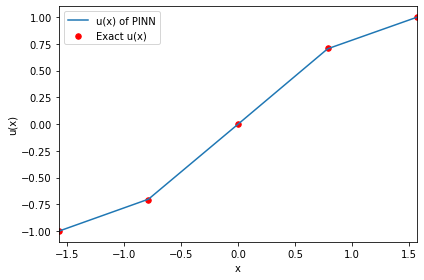

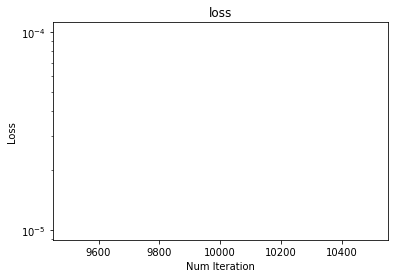

It: 10001, Loss: 6.218e-05  Losses ILRUDrxIC:[3.3648775570327416e-05, 2.592559894765145e-06, 2.2265912775765173e-05, 3.672030516099767e-06]
It: 10002, Loss: 7.622e-05  Losses ILRUDrxIC:[5.692649938282557e-05, 5.279715423966991e-06, 8.149205314111896e-06, 5.860933924850542e-06]
It: 10003, Loss: 7.452e-05  Losses ILRUDrxIC:[3.790419941651635e-05, 2.9790944608976133e-06, 2.8820997613365762e-05, 4.8174424591707066e-06]
It: 10004, Loss: 6.011e-05  Losses ILRUDrxIC:[4.666361928684637e-05, 3.906598976755049e-06, 6.394307547452627e-06, 3.1458564535569167e-06]
It: 10005, Loss: 4.802e-05  Losses ILRUDrxIC:[3.195105091435835e-05, 3.2159148304344853e-06, 1.1815789548563771e-05, 1.041602899931604e-06]
It: 10006, Loss: 4.824e-05  Losses ILRUDrxIC:[3.1911200494505465e-05, 2.4833896077325335e-06, 1.2388190953060985e-05, 1.4545494195772335e-06]
It: 10007, Loss: 5.705e-05  Losses ILRUDrxIC:[4.381780672702007e-05, 4.262756647221977e-06, 5.812417839479167e-06, 3.1521230994258076e-06]
It: 10008, Loss: 6.33

It: 10060, Loss: 4.609e-05  Losses ILRUDrxIC:[3.2807394745759666e-05, 2.9137529509171145e-06, 9.38678113016067e-06, 9.815678367885994e-07]
It: 10061, Loss: 4.605e-05  Losses ILRUDrxIC:[3.3672979043331e-05, 3.029085746675264e-06, 8.284509931399953e-06, 1.0633898455125745e-06]
It: 10062, Loss: 4.601e-05  Losses ILRUDrxIC:[3.302180630271323e-05, 2.9350810564210406e-06, 9.052976565726567e-06, 9.951518222806044e-07]
It: 10063, Loss: 4.598e-05  Losses ILRUDrxIC:[3.3305179385934025e-05, 2.9867910598113667e-06, 8.672900548845064e-06, 1.012727921079204e-06]
It: 10064, Loss: 4.597e-05  Losses ILRUDrxIC:[3.336742884130217e-05, 2.978496695504873e-06, 8.602129128121305e-06, 1.0256167115585413e-06]
It: 10065, Loss: 4.599e-05  Losses ILRUDrxIC:[3.299238233012147e-05, 2.9482941954483977e-06, 9.048962056112941e-06, 9.961715932149673e-07]
It: 10066, Loss: 4.600e-05  Losses ILRUDrxIC:[3.36091652570758e-05, 3.0060773497098126e-06, 8.348592928086873e-06, 1.0322446541977115e-06]
It: 10067, Loss: 4.599e-05  

It: 10119, Loss: 4.616e-05  Losses ILRUDrxIC:[3.271299647167325e-05, 3.713248815984116e-06, 7.807819201843813e-06, 1.928071924339747e-06]
It: 10120, Loss: 4.651e-05  Losses ILRUDrxIC:[3.364869553479366e-05, 2.0873981156910304e-06, 9.99488474917598e-06, 7.791657026245957e-07]
It: 10121, Loss: 4.708e-05  Losses ILRUDrxIC:[3.2557429221924394e-05, 4.256460670148954e-06, 7.462841494998429e-06, 2.8011388621962396e-06]
It: 10122, Loss: 4.800e-05  Losses ILRUDrxIC:[3.4057582524837926e-05, 1.7073098206310533e-06, 1.1060807082685642e-05, 1.1777334520957083e-06]
It: 10123, Loss: 4.952e-05  Losses ILRUDrxIC:[3.238998033339158e-05, 5.266153038974153e-06, 7.106888006092049e-06, 4.756355792778777e-06]
It: 10124, Loss: 5.202e-05  Losses ILRUDrxIC:[3.485953129711561e-05, 1.2615876130439574e-06, 1.3186982869228814e-05, 2.707226940401597e-06]
It: 10125, Loss: 5.615e-05  Losses ILRUDrxIC:[3.232788003515452e-05, 7.259079666255275e-06, 7.10987387719797e-06, 9.454281098442152e-06]
It: 10126, Loss: 6.302e-05 

It: 10177, Loss: 6.129e-05  Losses ILRUDrxIC:[3.709359225467779e-05, 9.377892524753406e-07, 1.6288759070448577e-05, 6.97239283908857e-06]
It: 10178, Loss: 4.808e-05  Losses ILRUDrxIC:[3.1586940167471766e-05, 5.260821126285009e-06, 7.927376827865373e-06, 3.30238935930538e-06]
It: 10179, Loss: 4.644e-05  Losses ILRUDrxIC:[3.245730840717442e-05, 3.99832742914441e-06, 7.352930424531223e-06, 2.631615870996029e-06]
It: 10180, Loss: 5.481e-05  Losses ILRUDrxIC:[3.4909073292510584e-05, 1.1109935940112337e-06, 1.464654542360222e-05, 4.145910224906402e-06]
It: 10181, Loss: 6.102e-05  Losses ILRUDrxIC:[3.183392982464284e-05, 8.97530117072165e-06, 7.533410098403692e-06, 1.26807572087273e-05]
It: 10182, Loss: 5.769e-05  Losses ILRUDrxIC:[3.6006811569677666e-05, 9.309458732786879e-07, 1.5177949535427615e-05, 5.577879619522719e-06]
It: 10183, Loss: 4.941e-05  Losses ILRUDrxIC:[3.170040145050734e-05, 5.623226570605766e-06, 7.540403203165624e-06, 4.541417183645535e-06]
It: 10184, Loss: 4.533e-05  Losse

It: 10237, Loss: 4.493e-05  Losses ILRUDrxIC:[3.252852548030205e-05, 2.820691634042305e-06, 8.651079042465426e-06, 9.338260724689462e-07]
It: 10238, Loss: 4.492e-05  Losses ILRUDrxIC:[3.253814793424681e-05, 2.831082383636385e-06, 8.607591553300153e-06, 9.476830200583208e-07]
It: 10239, Loss: 4.493e-05  Losses ILRUDrxIC:[3.2435127650387585e-05, 2.989203267134144e-06, 8.406429515162017e-06, 1.103297108784318e-06]
It: 10240, Loss: 4.494e-05  Losses ILRUDrxIC:[3.260101584601216e-05, 2.707623025344219e-06, 8.782799341133796e-06, 8.508198447998438e-07]
It: 10241, Loss: 4.494e-05  Losses ILRUDrxIC:[3.24101529258769e-05, 3.0423968837567372e-06, 8.330198397743516e-06, 1.1550040426300257e-06]
It: 10242, Loss: 4.492e-05  Losses ILRUDrxIC:[3.2575055229244754e-05, 2.718389168876456e-06, 8.751038876653183e-06, 8.749093467486091e-07]
It: 10243, Loss: 4.490e-05  Losses ILRUDrxIC:[3.2453051971970126e-05, 2.961149448310607e-06, 8.426733984379098e-06, 1.0552556659604306e-06]
It: 10244, Loss: 4.488e-05  L

It: 10297, Loss: 4.450e-05  Losses ILRUDrxIC:[3.2345076760975644e-05, 2.7906676223210525e-06, 8.417505341640208e-06, 9.50633932461642e-07]
It: 10298, Loss: 4.450e-05  Losses ILRUDrxIC:[3.2341547921532765e-05, 2.8005038075207267e-06, 8.39040512801148e-06, 9.643757721278234e-07]
It: 10299, Loss: 4.449e-05  Losses ILRUDrxIC:[3.233562165405601e-05, 2.7935793696087785e-06, 8.405044354731217e-06, 9.55744781094836e-07]
It: 10300, Loss: 4.448e-05  Losses ILRUDrxIC:[3.2337393349735066e-05, 2.794229658320546e-06, 8.392808013013564e-06, 9.580414825904882e-07]
It: 10301, Loss: 4.448e-05  Losses ILRUDrxIC:[3.2327840017387643e-05, 2.796938133542426e-06, 8.390895345655736e-06, 9.602931640984025e-07]
It: 10302, Loss: 4.447e-05  Losses ILRUDrxIC:[3.233148163417354e-05, 2.784272965072887e-06, 8.401194463658612e-06, 9.518968795418914e-07]
It: 10303, Loss: 4.446e-05  Losses ILRUDrxIC:[3.23198655678425e-05, 2.8008007575408556e-06, 8.37656989460811e-06, 9.65059598456719e-07]
It: 10304, Loss: 4.445e-05  Loss

It: 10356, Loss: 5.398e-04  Losses ILRUDrxIC:[0.00018720694060903043, 2.0874351321253926e-05, 0.0002280060143675655, 0.00010374869452789426]
It: 10357, Loss: 2.818e-04  Losses ILRUDrxIC:[0.00014152975927572697, 1.8906768673332408e-05, 6.340249092318118e-05, 5.796970799565315e-05]
It: 10358, Loss: 6.650e-05  Losses ILRUDrxIC:[3.25747205351945e-05, 1.738244009175105e-06, 2.3941258405102417e-05, 8.248352060036268e-06]
It: 10359, Loss: 8.893e-05  Losses ILRUDrxIC:[3.906540587195195e-05, 4.887237537332112e-06, 3.681153611978516e-05, 8.170596629497595e-06]
It: 10360, Loss: 2.568e-04  Losses ILRUDrxIC:[0.00014031391765456647, 1.480229457229143e-05, 5.5043008615029976e-05, 4.6653854951728135e-05]
It: 10361, Loss: 3.404e-04  Losses ILRUDrxIC:[0.00012680620420724154, 1.1484886272228323e-05, 0.00014625117182731628, 5.585314647760242e-05]
It: 10362, Loss: 2.422e-04  Losses ILRUDrxIC:[0.00013906790991313756, 1.5292906027752906e-05, 5.059157410869375e-05, 3.727785951923579e-05]
It: 10363, Loss: 8.87

It: 10415, Loss: 4.445e-05  Losses ILRUDrxIC:[3.072081017307937e-05, 2.5379035832884256e-06, 1.02323065220844e-05, 9.626238579585333e-07]
It: 10416, Loss: 4.387e-05  Losses ILRUDrxIC:[3.21628904202953e-05, 2.8748565910063917e-06, 7.676636414544191e-06, 1.1530229357958888e-06]
It: 10417, Loss: 4.376e-05  Losses ILRUDrxIC:[3.1948300602380186e-05, 2.8162730814074166e-06, 8.107488611130975e-06, 8.905834079087072e-07]
It: 10418, Loss: 4.410e-05  Losses ILRUDrxIC:[3.089145684498362e-05, 2.5920528514689067e-06, 9.595303708920255e-06, 1.0224933930658153e-06]
It: 10419, Loss: 4.440e-05  Losses ILRUDrxIC:[3.3058415283448994e-05, 3.0143160074658226e-06, 7.120072950783651e-06, 1.2098215620426345e-06]
It: 10420, Loss: 4.432e-05  Losses ILRUDrxIC:[3.0728147976333275e-05, 2.5876208837871673e-06, 1.0014980034611654e-05, 9.918272780851112e-07]
It: 10421, Loss: 4.397e-05  Losses ILRUDrxIC:[3.255444244132377e-05, 2.859117785192211e-06, 7.471769549738383e-06, 1.086067527467094e-06]
It: 10422, Loss: 4.371e

It: 10475, Loss: 5.315e-05  Losses ILRUDrxIC:[3.076820576097816e-05, 6.9405941758304834e-06, 6.8019899117643945e-06, 8.642482498544268e-06]
It: 10476, Loss: 5.930e-05  Losses ILRUDrxIC:[3.5037115594604984e-05, 8.564110771658306e-07, 1.6277725080726668e-05, 7.125914635253139e-06]
It: 10477, Loss: 6.946e-05  Losses ILRUDrxIC:[3.1192881579045206e-05, 1.0896707863139454e-05, 8.124526175379287e-06, 1.9242725102230906e-05]
It: 10478, Loss: 8.627e-05  Losses ILRUDrxIC:[3.8650730857625604e-05, 1.78373079506855e-06, 2.520719135645777e-05, 2.0628247511922382e-05]
It: 10479, Loss: 1.142e-04  Losses ILRUDrxIC:[3.338699389132671e-05, 1.9715660528163426e-05, 1.4141185602056794e-05, 4.699840792454779e-05]
It: 10480, Loss: 1.604e-04  Losses ILRUDrxIC:[4.709571658167988e-05, 6.985239451751113e-06, 4.6534543798770756e-05, 5.982733273413032e-05]
It: 10481, Loss: 2.367e-04  Losses ILRUDrxIC:[4.107621134608053e-05, 4.03631929657422e-05, 3.482829924905673e-05, 0.00012039620196446776]
It: 10482, Loss: 3.592e

It: 10534, Loss: 4.826e-05  Losses ILRUDrxIC:[3.254734838264994e-05, 1.1865224678331288e-06, 1.2251501175342128e-05, 2.2756451016903156e-06]
It: 10535, Loss: 4.343e-05  Losses ILRUDrxIC:[3.1029278034111485e-05, 3.2170414669963066e-06, 7.693647603446152e-06, 1.4922135278538917e-06]
It: 10536, Loss: 4.464e-05  Losses ILRUDrxIC:[3.0667768442071974e-05, 4.0575014281785116e-06, 7.277862096088938e-06, 2.639409103721846e-06]
It: 10537, Loss: 4.896e-05  Losses ILRUDrxIC:[3.284380727563985e-05, 1.1225889693378122e-06, 1.2443808373063803e-05, 2.554611910454696e-06]
It: 10538, Loss: 5.091e-05  Losses ILRUDrxIC:[3.049683800782077e-05, 6.316788585536415e-06, 6.653170657955343e-06, 7.438987267960329e-06]
It: 10539, Loss: 4.851e-05  Losses ILRUDrxIC:[3.265256600570865e-05, 1.154711071649217e-06, 1.2331765901762992e-05, 2.3688803594268393e-06]
It: 10540, Loss: 4.465e-05  Losses ILRUDrxIC:[3.074708365602419e-05, 4.073916898050811e-06, 7.0900005084695294e-06, 2.735380348894978e-06]
It: 10541, Loss: 4.31

It: 10593, Loss: 4.282e-05  Losses ILRUDrxIC:[3.101813490502536e-05, 2.79429832517053e-06, 7.968610589159653e-06, 1.0388473583589075e-06]
It: 10594, Loss: 4.282e-05  Losses ILRUDrxIC:[3.11555340886116e-05, 2.5045465008588508e-06, 8.338872248714324e-06, 8.20452555672091e-07]
It: 10595, Loss: 4.281e-05  Losses ILRUDrxIC:[3.100198591710068e-05, 2.792730583678349e-06, 7.973938409122638e-06, 1.039122025758843e-06]
It: 10596, Loss: 4.279e-05  Losses ILRUDrxIC:[3.113151979050599e-05, 2.5540257411194034e-06, 8.252065526903607e-06, 8.533874051863677e-07]
It: 10597, Loss: 4.278e-05  Losses ILRUDrxIC:[3.103810013271868e-05, 2.695899638638366e-06, 8.088029062491842e-06, 9.537224059386062e-07]
It: 10598, Loss: 4.277e-05  Losses ILRUDrxIC:[3.1074396247277036e-05, 2.6616412469593342e-06, 8.099307706288528e-06, 9.320403364654339e-07]
It: 10599, Loss: 4.277e-05  Losses ILRUDrxIC:[3.108917371719144e-05, 2.5884735350700794e-06, 8.213089131459128e-06, 8.742875934331096e-07]
It: 10600, Loss: 4.276e-05  Los

It: 10653, Loss: 4.242e-05  Losses ILRUDrxIC:[3.094440035056323e-05, 2.582394472483429e-06, 8.001426067494322e-06, 8.926333521230845e-07]
It: 10654, Loss: 4.241e-05  Losses ILRUDrxIC:[3.093168925261125e-05, 2.5920774078258546e-06, 7.986452146724332e-06, 9.035218795361288e-07]
It: 10655, Loss: 4.241e-05  Losses ILRUDrxIC:[3.0938110285205767e-05, 2.584576122899307e-06, 7.99029294284992e-06, 8.950299843490939e-07]
It: 10656, Loss: 4.240e-05  Losses ILRUDrxIC:[3.0927978514228016e-05, 2.586469008747372e-06, 7.988440302142408e-06, 8.992334983304318e-07]
It: 10657, Loss: 4.240e-05  Losses ILRUDrxIC:[3.0930517823435366e-05, 2.583223931651446e-06, 7.983460818650201e-06, 8.981263590612798e-07]
It: 10658, Loss: 4.239e-05  Losses ILRUDrxIC:[3.0925577448215336e-05, 2.58385693996388e-06, 7.98543533164775e-06, 8.940347697716788e-07]
It: 10659, Loss: 4.238e-05  Losses ILRUDrxIC:[3.0921648431103677e-05, 2.5839515274128644e-06, 7.975102562340908e-06, 9.015229807118885e-07]
It: 10660, Loss: 4.238e-05  Lo

It: 10712, Loss: 4.205e-05  Losses ILRUDrxIC:[3.074257983826101e-05, 2.479829618096119e-06, 7.989307960087899e-06, 8.409384122387564e-07]
It: 10713, Loss: 4.205e-05  Losses ILRUDrxIC:[3.0768489523325115e-05, 2.5991407710534986e-06, 7.74720228946535e-06, 9.325237328994262e-07]
It: 10714, Loss: 4.204e-05  Losses ILRUDrxIC:[3.073847619816661e-05, 2.457272557876422e-06, 8.01973419584101e-06, 8.273329967778409e-07]
It: 10715, Loss: 4.204e-05  Losses ILRUDrxIC:[3.075882705161348e-05, 2.620824488985818e-06, 7.707893018960021e-06, 9.511267080597463e-07]
It: 10716, Loss: 4.204e-05  Losses ILRUDrxIC:[3.0735627660760656e-05, 2.4306202703883173e-06, 8.058373168751132e-06, 8.111555871437304e-07]
It: 10717, Loss: 4.203e-05  Losses ILRUDrxIC:[3.074814230785705e-05, 2.653501496752142e-06, 7.653796274098568e-06, 9.780196705833077e-07]
It: 10718, Loss: 4.203e-05  Losses ILRUDrxIC:[3.0733252060599625e-05, 2.3887403131084284e-06, 8.121997780108359e-06, 7.897640443843557e-07]
It: 10719, Loss: 4.204e-05  Lo

It: 10771, Loss: 8.018e-05  Losses ILRUDrxIC:[3.0638497264590114e-05, 1.2475547919166274e-05, 1.0303740964445751e-05, 2.6760601031128317e-05]
It: 10772, Loss: 4.316e-05  Losses ILRUDrxIC:[3.1936742743710056e-05, 2.3410384528688155e-06, 8.43848738441011e-06, 4.4038162627657584e-07]
It: 10773, Loss: 5.972e-05  Losses ILRUDrxIC:[3.0886712920619175e-05, 6.444980158448743e-07, 1.8876105968956836e-05, 9.316571777162608e-06]
It: 10774, Loss: 9.734e-05  Losses ILRUDrxIC:[3.1468967790715396e-05, 1.5991239706636406e-05, 9.916291674016975e-06, 3.9966878830455244e-05]
It: 10775, Loss: 1.075e-04  Losses ILRUDrxIC:[3.474526965874247e-05, 2.5756960440048715e-06, 3.551685585989617e-05, 3.4693792258622125e-05]
It: 10776, Loss: 8.080e-05  Losses ILRUDrxIC:[3.07590926240664e-05, 1.2717398021777626e-05, 8.412896931986324e-06, 2.8911315894220024e-05]
It: 10777, Loss: 4.895e-05  Losses ILRUDrxIC:[3.0966646590968594e-05, 1.0748047998276888e-06, 1.3695668712898623e-05, 3.2176294553210028e-06]
It: 10778, Loss:

It: 10830, Loss: 4.166e-05  Losses ILRUDrxIC:[3.0004079235368408e-05, 2.2488541162601905e-06, 8.632599929114804e-06, 7.755021442790166e-07]
It: 10831, Loss: 4.158e-05  Losses ILRUDrxIC:[3.055559500353411e-05, 2.6416680611873744e-06, 7.449989425367676e-06, 9.293547691413551e-07]
It: 10832, Loss: 4.159e-05  Losses ILRUDrxIC:[2.984171806019731e-05, 2.6417226308694808e-06, 8.111176612146664e-06, 9.935617981682299e-07]
It: 10833, Loss: 4.166e-05  Losses ILRUDrxIC:[3.076777284150012e-05, 2.290643124069902e-06, 7.888381333032157e-06, 7.147563110265764e-07]
It: 10834, Loss: 4.173e-05  Losses ILRUDrxIC:[2.9711334718740545e-05, 2.8962174383195816e-06, 7.90315698395716e-06, 1.2166119631729089e-06]
It: 10835, Loss: 4.174e-05  Losses ILRUDrxIC:[3.093144914600998e-05, 2.208756995969452e-06, 7.91809543443378e-06, 6.810832928749733e-07]
It: 10836, Loss: 4.170e-05  Losses ILRUDrxIC:[2.9629876735270955e-05, 2.808407543852809e-06, 8.120477104966994e-06, 1.145449004980037e-06]
It: 10837, Loss: 4.167e-05  

It: 10889, Loss: 4.251e-05  Losses ILRUDrxIC:[3.1395091355079785e-05, 3.3272726795985363e-06, 5.7194406508642714e-06, 2.068953790512751e-06]
It: 10890, Loss: 4.894e-05  Losses ILRUDrxIC:[2.9204260499682277e-05, 1.9536180388968205e-06, 1.596425863681361e-05, 1.8214090005130856e-06]
It: 10891, Loss: 5.708e-05  Losses ILRUDrxIC:[4.455573434825055e-05, 3.6693993479275377e-06, 5.799457539978903e-06, 3.0593666906497674e-06]
It: 10892, Loss: 6.063e-05  Losses ILRUDrxIC:[3.2625390304019675e-05, 2.6860643629333936e-06, 2.2110538338893093e-05, 3.2122061384143308e-06]
It: 10893, Loss: 5.753e-05  Losses ILRUDrxIC:[4.496111432672478e-05, 3.3100880045822123e-06, 7.133224698918639e-06, 2.1252608348731883e-06]
It: 10894, Loss: 5.045e-05  Losses ILRUDrxIC:[2.9724846172030084e-05, 3.0959299692767672e-06, 1.524936033092672e-05, 2.383986839049612e-06]
It: 10895, Loss: 4.410e-05  Losses ILRUDrxIC:[3.3999265724560246e-05, 2.1987646050547482e-06, 7.3766450441326015e-06, 5.269122880235955e-07]
It: 10896, Loss

It: 10948, Loss: 4.089e-05  Losses ILRUDrxIC:[2.9795397495036013e-05, 2.591478960312088e-06, 7.519352493545739e-06, 9.790896910999436e-07]
It: 10949, Loss: 4.089e-05  Losses ILRUDrxIC:[2.978421798616182e-05, 2.2880701635585865e-06, 8.050868927966803e-06, 7.660273126930406e-07]
It: 10950, Loss: 4.089e-05  Losses ILRUDrxIC:[2.996294824697543e-05, 2.62598882727616e-06, 7.309633019758621e-06, 9.949174000212224e-07]
It: 10951, Loss: 4.089e-05  Losses ILRUDrxIC:[2.9648215786437504e-05, 2.2833921775600174e-06, 8.187545063265134e-06, 7.745297239125648e-07]
It: 10952, Loss: 4.089e-05  Losses ILRUDrxIC:[3.0059618438826874e-05, 2.6047234769066563e-06, 7.244131211336935e-06, 9.798018254514318e-07]
It: 10953, Loss: 4.088e-05  Losses ILRUDrxIC:[2.9597957109217532e-05, 2.3239347228809493e-06, 8.168730346369557e-06, 7.860415962568368e-07]
It: 10954, Loss: 4.086e-05  Losses ILRUDrxIC:[3.0066861654631793e-05, 2.544641347412835e-06, 7.311503850360168e-06, 9.377054084325209e-07]
It: 10955, Loss: 4.084e-05

It: 11007, Loss: 4.079e-05  Losses ILRUDrxIC:[3.01419659081148e-05, 2.0134839360252954e-06, 8.0282443377655e-06, 6.099130587244872e-07]
It: 11008, Loss: 4.091e-05  Losses ILRUDrxIC:[2.9248818464111537e-05, 2.94482765639259e-06, 7.256532171595609e-06, 1.462211685065995e-06]
It: 11009, Loss: 4.109e-05  Losses ILRUDrxIC:[3.0383560442714952e-05, 1.8613817474033567e-06, 8.255699867731892e-06, 5.904106501475326e-07]
It: 11010, Loss: 4.136e-05  Losses ILRUDrxIC:[2.908563328674063e-05, 3.2231589557341067e-06, 7.178407486208016e-06, 1.8732407625066116e-06]
It: 11011, Loss: 4.177e-05  Losses ILRUDrxIC:[3.0788127332925797e-05, 1.6599520904492238e-06, 8.657014404889196e-06, 6.623614012823964e-07]
It: 11012, Loss: 4.239e-05  Losses ILRUDrxIC:[2.8896613002871163e-05, 3.6902988540532533e-06, 7.142816230043536e-06, 2.6573595732770627e-06]
It: 11013, Loss: 4.334e-05  Losses ILRUDrxIC:[3.15130346280057e-05, 1.4074394130147994e-06, 9.407945071870927e-06, 1.0089488569064997e-06]
It: 11014, Loss: 4.480e-05

It: 11066, Loss: 6.533e-05  Losses ILRUDrxIC:[3.206672772648744e-05, 6.996791398705682e-06, 1.5449777492904104e-05, 1.0816203939612024e-05]
It: 11067, Loss: 5.509e-05  Losses ILRUDrxIC:[3.984049544669688e-05, 1.6824029671624885e-06, 1.1324922525091097e-05, 2.245953965029912e-06]
It: 11068, Loss: 4.357e-05  Losses ILRUDrxIC:[2.796866283460986e-05, 3.80969049729174e-06, 9.017675438371953e-06, 2.774137328742654e-06]
It: 11069, Loss: 4.062e-05  Losses ILRUDrxIC:[2.8631040549953468e-05, 2.7513906388776377e-06, 7.715734682278708e-06, 1.5179016372712795e-06]
It: 11070, Loss: 4.638e-05  Losses ILRUDrxIC:[3.454107718425803e-05, 1.733563522066106e-06, 9.279121513827704e-06, 8.266089253083919e-07]
It: 11071, Loss: 5.310e-05  Losses ILRUDrxIC:[2.9189679480623454e-05, 5.494215201906627e-06, 1.166451329481788e-05, 6.754124569852138e-06]
It: 11072, Loss: 5.376e-05  Losses ILRUDrxIC:[3.929719241568819e-05, 1.6761744063842343e-06, 1.077655269909883e-05, 2.01479451789055e-06]
It: 11073, Loss: 4.832e-05 

It: 11125, Loss: 4.034e-05  Losses ILRUDrxIC:[2.8443033443181776e-05, 2.243232984255883e-06, 8.78017544891918e-06, 8.710760539543116e-07]
It: 11126, Loss: 4.040e-05  Losses ILRUDrxIC:[3.0311974114738405e-05, 2.619915449031396e-06, 6.480881893367041e-06, 9.87129737950454e-07]
It: 11127, Loss: 4.048e-05  Losses ILRUDrxIC:[2.8384998586261645e-05, 2.104304940075963e-06, 9.16469161893474e-06, 8.238525879278313e-07]
It: 11128, Loss: 4.060e-05  Losses ILRUDrxIC:[3.0369079468073323e-05, 2.8364136142045027e-06, 6.125057097960962e-06, 1.266119966203405e-06]
It: 11129, Loss: 4.078e-05  Losses ILRUDrxIC:[2.8354650567052886e-05, 1.8695099015531014e-06, 9.729592420626432e-06, 8.311969850183232e-07]
It: 11130, Loss: 4.107e-05  Losses ILRUDrxIC:[3.0514378522639163e-05, 3.1507179301115684e-06, 5.665964181389427e-06, 1.7392156905771117e-06]
It: 11131, Loss: 4.148e-05  Losses ILRUDrxIC:[2.824773582688067e-05, 1.6107194369396893e-06, 1.0612046025926247e-05, 1.0111745041285758e-06]
It: 11132, Loss: 4.207e-

It: 11184, Loss: 5.155e-05  Losses ILRUDrxIC:[2.889333336497657e-05, 5.2292093641881365e-06, 1.2058307220286224e-05, 5.369408881961135e-06]
It: 11185, Loss: 5.040e-05  Losses ILRUDrxIC:[3.8679801946273074e-05, 2.064890395558905e-06, 8.564117706555407e-06, 1.095266725315014e-06]
It: 11186, Loss: 4.724e-05  Losses ILRUDrxIC:[2.8445781936170533e-05, 3.102785512965056e-06, 1.3468428733176552e-05, 2.2239719328354113e-06]
It: 11187, Loss: 4.366e-05  Losses ILRUDrxIC:[3.3963104215217754e-05, 2.9092618660797598e-06, 5.4705819820810575e-06, 1.3209449889473035e-06]
It: 11188, Loss: 4.155e-05  Losses ILRUDrxIC:[2.7920967113459483e-05, 1.5738452248115209e-06, 1.0931375072686933e-05, 1.1198229685760452e-06]
It: 11189, Loss: 4.175e-05  Losses ILRUDrxIC:[2.870574280677829e-05, 3.9482542888436e-06, 6.069406026654178e-06, 3.0296291697595734e-06]
It: 11190, Loss: 4.368e-05  Losses ILRUDrxIC:[3.172833385178819e-05, 1.3589541367764468e-06, 9.406032404513098e-06, 1.1856019455080968e-06]
It: 11191, Loss: 4.

It: 11243, Loss: 3.942e-05  Losses ILRUDrxIC:[2.8673153792624362e-05, 2.3866991796239745e-06, 7.465009730367456e-06, 8.907546202863159e-07]
It: 11244, Loss: 3.941e-05  Losses ILRUDrxIC:[2.905561814259272e-05, 2.2753176835976774e-06, 7.311254648811882e-06, 7.684938623242488e-07]
It: 11245, Loss: 3.941e-05  Losses ILRUDrxIC:[2.8630991437239572e-05, 2.325872628716752e-06, 7.604106031067204e-06, 8.454804856228293e-07]
It: 11246, Loss: 3.940e-05  Losses ILRUDrxIC:[2.906009103753604e-05, 2.3241748294822173e-06, 7.210241165012121e-06, 8.053940518948366e-07]
It: 11247, Loss: 3.939e-05  Losses ILRUDrxIC:[2.8646234568441287e-05, 2.2816218461230164e-06, 7.650921361346263e-06, 8.138873681673431e-07]
It: 11248, Loss: 3.938e-05  Losses ILRUDrxIC:[2.9007172997808084e-05, 2.3577317733725067e-06, 7.187731171143241e-06, 8.315548711834708e-07]
It: 11249, Loss: 3.938e-05  Losses ILRUDrxIC:[2.870047501346562e-05, 2.2508033907797653e-06, 7.632715096406173e-06, 7.914453590274206e-07]
It: 11250, Loss: 3.937e-

It: 11302, Loss: 4.025e-05  Losses ILRUDrxIC:[2.7976720957667567e-05, 4.223327778163366e-06, 6.75190949550597e-06, 1.301991005675518e-06]
It: 11303, Loss: 1.213e-04  Losses ILRUDrxIC:[3.078681038459763e-05, 2.138117815775331e-05, 1.6154503100551665e-05, 5.2963197958888486e-05]
It: 11304, Loss: 3.113e-04  Losses ILRUDrxIC:[5.5036518460838124e-05, 1.9425178834353574e-05, 8.747012179810554e-05, 0.00014941544213797897]
It: 11305, Loss: 4.564e-04  Losses ILRUDrxIC:[5.028390296502039e-05, 7.595575152663514e-05, 7.535993790952489e-05, 0.00025476652081124485]
It: 11306, Loss: 4.505e-04  Losses ILRUDrxIC:[6.729663436999545e-05, 3.372382707311772e-05, 0.00012166644592070952, 0.00022779795108363032]
It: 11307, Loss: 3.063e-04  Losses ILRUDrxIC:[4.0865084883989766e-05, 5.241275721346028e-05, 4.7010686103021726e-05, 0.00016600050730630755]
It: 11308, Loss: 1.302e-04  Losses ILRUDrxIC:[3.8551446778001264e-05, 4.7899461605993565e-06, 3.88314037991222e-05, 4.802973853657022e-05]
It: 11309, Loss: 4.145

It: 11360, Loss: 4.009e-05  Losses ILRUDrxIC:[2.8885518986498937e-05, 1.5064398439790239e-06, 8.956777492130641e-06, 7.449200438713888e-07]
It: 11361, Loss: 4.039e-05  Losses ILRUDrxIC:[2.8099990231567062e-05, 3.519842266541673e-06, 6.269291134231025e-06, 2.501073595340131e-06]
It: 11362, Loss: 4.022e-05  Losses ILRUDrxIC:[2.8930753614986315e-05, 1.4371902352650068e-06, 9.033647074829787e-06, 8.197612260119058e-07]
It: 11363, Loss: 3.973e-05  Losses ILRUDrxIC:[2.8150458092568442e-05, 3.2007490062824218e-06, 6.4913251662801486e-06, 1.8870653093472356e-06]
It: 11364, Loss: 3.921e-05  Losses ILRUDrxIC:[2.86447029793635e-05, 1.8028403019343386e-06, 8.114899173961021e-06, 6.467716389124689e-07]
It: 11365, Loss: 3.892e-05  Losses ILRUDrxIC:[2.835840859916061e-05, 2.4440832930849865e-06, 7.198129424068611e-06, 9.149229072136222e-07]
It: 11366, Loss: 3.893e-05  Losses ILRUDrxIC:[2.8323433070909232e-05, 2.4591852252342505e-06, 7.152838406909723e-06, 9.93966864371032e-07]
It: 11367, Loss: 3.916e

It: 11419, Loss: 1.017e-04  Losses ILRUDrxIC:[7.45088909752667e-05, 5.1884712775063235e-06, 1.4162443221721333e-05, 7.869805813243147e-06]
It: 11420, Loss: 1.410e-04  Losses ILRUDrxIC:[6.659473001491278e-05, 3.2233670026471373e-06, 5.8623500081012025e-05, 1.2594268810062204e-05]
It: 11421, Loss: 2.031e-04  Losses ILRUDrxIC:[0.00013596226926892996, 8.675629942445084e-06, 3.9047026803018525e-05, 1.941065966093447e-05]
It: 11422, Loss: 2.984e-04  Losses ILRUDrxIC:[0.00013981517986394465, 6.466462309617782e-06, 0.00012128082744311541, 3.084315176238306e-05]
It: 11423, Loss: 4.343e-04  Losses ILRUDrxIC:[0.0002681148471310735, 1.6319938367814757e-05, 0.00010327513155061752, 4.662662104237825e-05]
It: 11424, Loss: 6.097e-04  Losses ILRUDrxIC:[0.0002870733442250639, 1.4163455489324406e-05, 0.0002397136704530567, 6.87269275658764e-05]
It: 11425, Loss: 7.878e-04  Losses ILRUDrxIC:[0.00045673816930502653, 2.906146073655691e-05, 0.00020929354650434107, 9.266280540032312e-05]
It: 11426, Loss: 8.970

It: 11478, Loss: 3.870e-05  Losses ILRUDrxIC:[2.7253659936832264e-05, 2.1402393031166866e-06, 8.548591722501442e-06, 7.616417860845104e-07]
It: 11479, Loss: 3.843e-05  Losses ILRUDrxIC:[2.7494872483657673e-05, 2.2261554022406926e-06, 7.879463737481274e-06, 8.332772267749533e-07]
It: 11480, Loss: 3.947e-05  Losses ILRUDrxIC:[3.0135792258079164e-05, 2.4288874556077644e-06, 5.864912054676097e-06, 1.041117798195046e-06]
It: 11481, Loss: 4.057e-05  Losses ILRUDrxIC:[2.676541953405831e-05, 2.1462392396642826e-06, 1.065620563167613e-05, 1.0022240530815907e-06]
It: 11482, Loss: 4.069e-05  Losses ILRUDrxIC:[3.123831993434578e-05, 2.565045178926084e-06, 5.499155577126658e-06, 1.3894305084249936e-06]
It: 11483, Loss: 3.981e-05  Losses ILRUDrxIC:[2.6846495529753156e-05, 2.161017619073391e-06, 9.885630788630806e-06, 9.213945304509252e-07]
It: 11484, Loss: 3.874e-05  Losses ILRUDrxIC:[2.9099686798872426e-05, 2.3850550405768445e-06, 6.339510491670808e-06, 9.205677997670136e-07]
It: 11485, Loss: 3.830

It: 11537, Loss: 3.973e-05  Losses ILRUDrxIC:[2.845937888196204e-05, 1.260207454834017e-06, 9.095141649595462e-06, 9.171236001748184e-07]
It: 11538, Loss: 4.060e-05  Losses ILRUDrxIC:[2.7466308893053792e-05, 3.931588707928313e-06, 5.814613359689247e-06, 3.387825927347876e-06]
It: 11539, Loss: 4.194e-05  Losses ILRUDrxIC:[2.8788470444851555e-05, 9.346680371891125e-07, 1.0423002095194533e-05, 1.7968588963412913e-06]
It: 11540, Loss: 4.403e-05  Losses ILRUDrxIC:[2.7376408979762346e-05, 5.093394520372385e-06, 5.573705493588932e-06, 5.989220881019719e-06]
It: 11541, Loss: 4.731e-05  Losses ILRUDrxIC:[2.958787081297487e-05, 6.576387363566027e-07, 1.281744334846735e-05, 4.2421506805112585e-06]
It: 11542, Loss: 5.248e-05  Losses ILRUDrxIC:[2.7400375984143466e-05, 7.309541160793742e-06, 5.949758815404493e-06, 1.1816026926680934e-05]
It: 11543, Loss: 6.066e-05  Losses ILRUDrxIC:[3.132717392873019e-05, 8.142038723235601e-07, 1.7636439224588685e-05, 1.0885751180467196e-05]
It: 11544, Loss: 7.372e-

It: 11596, Loss: 4.920e-05  Losses ILRUDrxIC:[2.8811558877350762e-05, 5.875605779692705e-07, 1.4241289136407431e-05, 5.5584469009772874e-06]
It: 11597, Loss: 5.222e-05  Losses ILRUDrxIC:[2.724101250350941e-05, 7.400432878057472e-06, 5.745495400333311e-06, 1.1835694749606773e-05]
It: 11598, Loss: 4.829e-05  Losses ILRUDrxIC:[2.962326107081026e-05, 6.902243399053987e-07, 1.3251791642687749e-05, 4.725473445432726e-06]
It: 11599, Loss: 4.163e-05  Losses ILRUDrxIC:[2.6904372134595178e-05, 4.330599495006027e-06, 6.2946360230853315e-06, 4.096145858056843e-06]
It: 11600, Loss: 3.809e-05  Losses ILRUDrxIC:[2.8317728720139712e-05, 2.0791430870303884e-06, 7.055477908579633e-06, 6.356513040373102e-07]
It: 11601, Loss: 3.969e-05  Losses ILRUDrxIC:[2.75064285233384e-05, 1.2257913795110653e-06, 9.872614100459032e-06, 1.0854037100216374e-06]
It: 11602, Loss: 4.360e-05  Losses ILRUDrxIC:[2.745506753853988e-05, 5.000021701562218e-06, 5.227715064393124e-06, 5.913092536502518e-06]
It: 11603, Loss: 4.556e-

It: 11655, Loss: 3.761e-05  Losses ILRUDrxIC:[2.7531581508810632e-05, 2.2045692276151385e-06, 7.0807877818879206e-06, 7.903488494775956e-07]
It: 11656, Loss: 3.760e-05  Losses ILRUDrxIC:[2.7503459932631813e-05, 2.2215824628801784e-06, 7.073351753206225e-06, 8.048904760471487e-07]
It: 11657, Loss: 3.761e-05  Losses ILRUDrxIC:[2.7531721570994705e-05, 2.080666945403209e-06, 7.287021162483143e-06, 7.089611244737171e-07]
It: 11658, Loss: 3.761e-05  Losses ILRUDrxIC:[2.750308340182528e-05, 2.3119207526178798e-06, 6.9162815634626895e-06, 8.825212489682599e-07]
It: 11659, Loss: 3.761e-05  Losses ILRUDrxIC:[2.75204838544596e-05, 2.0335255612735637e-06, 7.3768010224739555e-06, 6.828248046986118e-07]
It: 11660, Loss: 3.760e-05  Losses ILRUDrxIC:[2.750835301412735e-05, 2.3140216853789752e-06, 6.894616035424406e-06, 8.874137051861908e-07]
It: 11661, Loss: 3.759e-05  Losses ILRUDrxIC:[2.750381827354431e-05, 2.0671673155447934e-06, 7.32002035874757e-06, 7.00549719567789e-07]
It: 11662, Loss: 3.758e-0

It: 11713, Loss: 3.731e-05  Losses ILRUDrxIC:[2.741432581387926e-05, 2.1449889118230203e-06, 6.9858228926023e-06, 7.663192036488908e-07]
It: 11714, Loss: 3.731e-05  Losses ILRUDrxIC:[2.7411326300352812e-05, 2.110255309162312e-06, 7.040532182145398e-06, 7.444637617481931e-07]
It: 11715, Loss: 3.730e-05  Losses ILRUDrxIC:[2.741347998380661e-05, 2.141550794476643e-06, 6.9850648287683725e-06, 7.614229957653151e-07]
It: 11716, Loss: 3.730e-05  Losses ILRUDrxIC:[2.7403457352193072e-05, 2.113822574756341e-06, 7.031265340629034e-06, 7.479261512344237e-07]
It: 11717, Loss: 3.729e-05  Losses ILRUDrxIC:[2.7412928830017336e-05, 2.1306746020854916e-06, 6.9902721406833734e-06, 7.573692641926755e-07]
It: 11718, Loss: 3.729e-05  Losses ILRUDrxIC:[2.7395626602810808e-05, 2.1223579551588045e-06, 7.018494670774089e-06, 7.49225932850095e-07]
It: 11719, Loss: 3.728e-05  Losses ILRUDrxIC:[2.7410618713474832e-05, 2.1217131234152475e-06, 6.9932639235048555e-06, 7.558782044725376e-07]
It: 11720, Loss: 3.728e-0

It: 11772, Loss: 5.588e-04  Losses ILRUDrxIC:[0.00023905526904854923, 3.133789505227469e-05, 0.0002250590914627537, 6.33542804280296e-05]
It: 11773, Loss: 1.911e-04  Losses ILRUDrxIC:[0.00011218459985684603, 1.096419964596862e-05, 4.795368658960797e-05, 1.9992832676507533e-05]
It: 11774, Loss: 4.854e-05  Losses ILRUDrxIC:[2.8286949600442313e-05, 6.8159006332280114e-06, 5.255461474007461e-06, 8.185043043340556e-06]
It: 11775, Loss: 1.724e-04  Losses ILRUDrxIC:[6.558945460710675e-05, 4.141346835240256e-06, 7.356786954915151e-05, 2.908437090809457e-05]
It: 11776, Loss: 3.927e-04  Losses ILRUDrxIC:[0.00019848544616252184, 1.99094556592172e-05, 0.00010154722258448601, 7.274734525708482e-05]
It: 11777, Loss: 4.895e-04  Losses ILRUDrxIC:[0.00018198334146291018, 1.8572174667497166e-05, 0.00020465168927330524, 8.431442256551236e-05]
It: 11778, Loss: 3.721e-04  Losses ILRUDrxIC:[0.00018756424833554775, 1.92565730685601e-05, 9.348416642751545e-05, 7.178343366831541e-05]
It: 11779, Loss: 1.606e-04

It: 11831, Loss: 7.364e-05  Losses ILRUDrxIC:[2.709399450395722e-05, 1.1051726687583141e-05, 6.729726464982377e-06, 2.875993595807813e-05]
It: 11832, Loss: 8.701e-05  Losses ILRUDrxIC:[3.177437974954955e-05, 1.8065346694129403e-06, 2.695737020985689e-05, 2.646814755280502e-05]
It: 11833, Loss: 1.058e-04  Losses ILRUDrxIC:[2.8219148589414544e-05, 1.732560667733196e-05, 1.2281674571568146e-05, 4.797522706212476e-05]
It: 11834, Loss: 1.311e-04  Losses ILRUDrxIC:[3.6658093449659646e-05, 5.160409273230471e-06, 3.832639049505815e-05, 5.095896631246433e-05]
It: 11835, Loss: 1.653e-04  Losses ILRUDrxIC:[3.0438672183663584e-05, 2.83824610960437e-05, 2.0233850591466762e-05, 8.620452717877924e-05]
It: 11836, Loss: 2.107e-04  Losses ILRUDrxIC:[3.944035051972605e-05, 1.1950058251386508e-05, 5.88475086260587e-05, 0.0001004367513814941]
It: 11837, Loss: 2.708e-04  Losses ILRUDrxIC:[3.281807585153729e-05, 4.532586899586022e-05, 3.489734808681533e-05, 0.000157790636876598]
It: 11838, Loss: 3.458e-04  L

It: 11890, Loss: 4.147e-05  Losses ILRUDrxIC:[2.6397747205919586e-05, 4.62854086435982e-06, 5.284488452161895e-06, 5.162223715160508e-06]
It: 11891, Loss: 4.035e-05  Losses ILRUDrxIC:[2.7364769266569056e-05, 8.461067295684188e-07, 1.0298869710823055e-05, 1.8405202126814402e-06]
It: 11892, Loss: 3.894e-05  Losses ILRUDrxIC:[2.65024555119453e-05, 3.7812196751474403e-06, 5.481315838551382e-06, 3.177463440806605e-06]
It: 11893, Loss: 3.767e-05  Losses ILRUDrxIC:[2.6982110284734517e-05, 1.2941683280587313e-06, 8.607876225141808e-06, 7.89927241839905e-07]
It: 11894, Loss: 3.685e-05  Losses ILRUDrxIC:[2.664265048224479e-05, 2.620812665554695e-06, 6.333194960461697e-06, 1.249567844752164e-06]
It: 11895, Loss: 3.657e-05  Losses ILRUDrxIC:[2.6737299776868895e-05, 2.1042851585661992e-06, 6.988566383370198e-06, 7.401004040730186e-07]
It: 11896, Loss: 3.677e-05  Losses ILRUDrxIC:[2.683363163669128e-05, 1.7157528873212868e-06, 7.616956736455904e-06, 6.061295607651118e-07]
It: 11897, Loss: 3.726e-05 

It: 11949, Loss: 3.703e-05  Losses ILRUDrxIC:[2.642942126840353e-05, 2.8792442208214197e-06, 6.008217042108299e-06, 1.715493112897093e-06]
It: 11950, Loss: 3.721e-05  Losses ILRUDrxIC:[2.700939694477711e-05, 1.349797344118997e-06, 8.184256330423523e-06, 6.630025950471463e-07]
It: 11951, Loss: 3.744e-05  Losses ILRUDrxIC:[2.638632031448651e-05, 3.1178738026937936e-06, 5.827414497616701e-06, 2.1080622900626622e-06]
It: 11952, Loss: 3.776e-05  Losses ILRUDrxIC:[2.710782973736059e-05, 1.1936692771996604e-06, 8.62066553963814e-06, 8.330126775035751e-07]
It: 11953, Loss: 3.818e-05  Losses ILRUDrxIC:[2.6340629119658843e-05, 3.4702297853073105e-06, 5.61522074349341e-06, 2.7562905415834393e-06]
It: 11954, Loss: 3.877e-05  Losses ILRUDrxIC:[2.7264986783848144e-05, 1.002680050987692e-06, 9.285366104450077e-06, 1.215872316606692e-06]
It: 11955, Loss: 3.958e-05  Losses ILRUDrxIC:[2.628615402500145e-05, 4.018912932224339e-06, 5.391205377236474e-06, 3.882384589815047e-06]
It: 11956, Loss: 4.071e-05  

It: 12008, Loss: 4.013e-05  Losses ILRUDrxIC:[2.8992457373533398e-05, 1.0737537650129525e-06, 8.834829714032821e-06, 1.2305921472943737e-06]
It: 12009, Loss: 3.651e-05  Losses ILRUDrxIC:[2.567259616625961e-05, 2.0486459106905386e-06, 7.978558642207645e-06, 8.13289943835116e-07]
It: 12010, Loss: 3.874e-05  Losses ILRUDrxIC:[2.6573434297461063e-05, 3.757921604119474e-06, 5.056385816715192e-06, 3.3536989576532505e-06]
It: 12011, Loss: 4.395e-05  Losses ILRUDrxIC:[2.7590636818786152e-05, 6.317628162832989e-07, 1.204394629894523e-05, 3.68006294593215e-06]
It: 12012, Loss: 4.828e-05  Losses ILRUDrxIC:[2.5907949748216197e-05, 6.570985988219036e-06, 5.855793006048771e-06, 9.943829354597256e-06]
It: 12013, Loss: 4.916e-05  Losses ILRUDrxIC:[2.946064887510147e-05, 6.716084044455783e-07, 1.3343906175578013e-05, 5.68796804145677e-06]
It: 12014, Loss: 4.645e-05  Losses ILRUDrxIC:[2.570249307609629e-05, 6.038854280632222e-06, 6.502743872260908e-06, 8.203880497603677e-06]
It: 12015, Loss: 4.192e-05  

It: 12067, Loss: 3.588e-05  Losses ILRUDrxIC:[2.6202969820587896e-05, 2.1258447304717265e-06, 6.741282959410455e-06, 8.146695336108678e-07]
It: 12068, Loss: 3.587e-05  Losses ILRUDrxIC:[2.644841151777655e-05, 1.9639091988210566e-06, 6.7824917096004356e-06, 6.708237378916238e-07]
It: 12069, Loss: 3.585e-05  Losses ILRUDrxIC:[2.6294503186363727e-05, 2.0399820641614497e-06, 6.782462151022628e-06, 7.373120070042205e-07]
It: 12070, Loss: 3.585e-05  Losses ILRUDrxIC:[2.6344903744757175e-05, 2.037028934864793e-06, 6.734188445989275e-06, 7.323467343667289e-07]
It: 12071, Loss: 3.585e-05  Losses ILRUDrxIC:[2.638424666656647e-05, 1.9677611362567404e-06, 6.8161766648699995e-06, 6.797610012654332e-07]
It: 12072, Loss: 3.585e-05  Losses ILRUDrxIC:[2.6259946025675163e-05, 2.096770685966476e-06, 6.706264230160741e-06, 7.858621415834932e-07]
It: 12073, Loss: 3.585e-05  Losses ILRUDrxIC:[2.6453832106199116e-05, 1.9183269159839256e-06, 6.834464329585899e-06, 6.450444516303833e-07]
It: 12074, Loss: 3.585

It: 12126, Loss: 3.558e-05  Losses ILRUDrxIC:[2.630517519719433e-05, 1.982815092560486e-06, 6.585372830159031e-06, 7.080077466525836e-07]
It: 12127, Loss: 3.558e-05  Losses ILRUDrxIC:[2.6139347028220072e-05, 1.9666781554406043e-06, 6.772428605472669e-06, 6.993165015956038e-07]
It: 12128, Loss: 3.557e-05  Losses ILRUDrxIC:[2.6335797883803025e-05, 1.985389417313854e-06, 6.546245913341409e-06, 7.071215009091247e-07]
It: 12129, Loss: 3.557e-05  Losses ILRUDrxIC:[2.6095940484083258e-05, 1.9620936200226424e-06, 6.813172149122693e-06, 7.012799869698938e-07]
It: 12130, Loss: 3.557e-05  Losses ILRUDrxIC:[2.6383706426713616e-05, 1.9879425963154063e-06, 6.495280558738159e-06, 7.044508834042063e-07]
It: 12131, Loss: 3.557e-05  Losses ILRUDrxIC:[2.6033283575088717e-05, 1.9546998828445794e-06, 6.8785034272877965e-06, 7.0552749775743e-07]
It: 12132, Loss: 3.558e-05  Losses ILRUDrxIC:[2.646385291882325e-05, 1.99630881070334e-06, 6.413066330424044e-06, 7.02806005392631e-07]
It: 12133, Loss: 3.558e-05  

It: 12185, Loss: 7.711e-05  Losses ILRUDrxIC:[2.7752383175538853e-05, 1.0615450264594983e-05, 5.555359166464768e-06, 3.31890769302845e-05]
It: 12186, Loss: 7.307e-05  Losses ILRUDrxIC:[3.883754106936976e-05, 2.364775809837738e-06, 1.9705948943737894e-05, 1.216439704876393e-05]
It: 12187, Loss: 9.068e-05  Losses ILRUDrxIC:[3.8499358197441325e-05, 9.990766557166353e-06, 2.8841830499004573e-05, 1.334786520601483e-05]
It: 12188, Loss: 8.660e-05  Losses ILRUDrxIC:[5.919520845054649e-05, 3.6444662327994592e-06, 1.7343043509754352e-05, 6.413123173842905e-06]
It: 12189, Loss: 5.661e-05  Losses ILRUDrxIC:[2.9496992283384316e-05, 4.226552391628502e-06, 1.9997949493699707e-05, 2.8925946935487445e-06]
It: 12190, Loss: 3.707e-05  Losses ILRUDrxIC:[2.7213780413148925e-05, 2.2987512693362078e-06, 4.8127085392479785e-06, 2.7450155357655603e-06]
It: 12191, Loss: 4.901e-05  Losses ILRUDrxIC:[3.468330032774247e-05, 2.0034560748172225e-06, 1.0354742698837072e-05, 1.963940576388268e-06]
It: 12192, Loss: 7.

It: 12244, Loss: 3.546e-05  Losses ILRUDrxIC:[2.5189030566252768e-05, 2.413242100374191e-06, 6.828372534073424e-06, 1.0341827874071896e-06]
It: 12245, Loss: 3.540e-05  Losses ILRUDrxIC:[2.618764847284183e-05, 1.6058575056376867e-06, 6.964130534470314e-06, 6.392336331373372e-07]
It: 12246, Loss: 3.536e-05  Losses ILRUDrxIC:[2.5537139663356356e-05, 2.5055953756236704e-06, 6.318008672678843e-06, 9.946708132702042e-07]
It: 12247, Loss: 3.537e-05  Losses ILRUDrxIC:[2.5621298846090212e-05, 1.5735644183223485e-06, 7.485931291739689e-06, 6.914688128745183e-07]
It: 12248, Loss: 3.540e-05  Losses ILRUDrxIC:[2.594787656562403e-05, 2.4720561668800656e-06, 5.894855803489918e-06, 1.0887619055210962e-06]
It: 12249, Loss: 3.540e-05  Losses ILRUDrxIC:[2.543632399465423e-05, 1.6387759842473315e-06, 7.729608114459552e-06, 5.968872187622765e-07]
It: 12250, Loss: 3.536e-05  Losses ILRUDrxIC:[2.5899740649037994e-05, 2.3584025257150643e-06, 5.925707682763459e-06, 1.1732875009329291e-06]
It: 12251, Loss: 3.53

It: 12303, Loss: 6.923e-05  Losses ILRUDrxIC:[2.5688315872685052e-05, 1.1312747119518463e-05, 8.53063102113083e-06, 2.3698423319729045e-05]
It: 12304, Loss: 3.527e-05  Losses ILRUDrxIC:[2.545765892136842e-05, 2.441649485263042e-06, 6.147336080175592e-06, 1.2237086366440053e-06]
It: 12305, Loss: 7.163e-05  Losses ILRUDrxIC:[2.9601282221847214e-05, 1.3600666761703906e-06, 2.179767398047261e-05, 1.8872095097322017e-05]
It: 12306, Loss: 1.363e-04  Losses ILRUDrxIC:[2.8832067982875742e-05, 2.315095844096504e-05, 1.8253560483572073e-05, 6.601608038181439e-05]
It: 12307, Loss: 1.778e-04  Losses ILRUDrxIC:[3.935385029762983e-05, 9.331113687949255e-06, 5.182907989365049e-05, 7.725384784862399e-05]
It: 12308, Loss: 1.694e-04  Losses ILRUDrxIC:[3.01725922327023e-05, 2.919767939602025e-05, 2.3625143512617797e-05, 8.643655746709555e-05]
It: 12309, Loss: 1.202e-04  Losses ILRUDrxIC:[3.449276482569985e-05, 4.533615538093727e-06, 3.5958826629212126e-05, 4.517663910519332e-05]
It: 12310, Loss: 6.491e-0

It: 12362, Loss: 3.503e-05  Losses ILRUDrxIC:[2.5675759388832375e-05, 1.5388935707960627e-06, 7.281501439138083e-06, 5.324573066900484e-07]
It: 12363, Loss: 3.518e-05  Losses ILRUDrxIC:[2.5291046767961234e-05, 2.5552872102707624e-06, 5.9546810007304884e-06, 1.3803792171529494e-06]
It: 12364, Loss: 3.525e-05  Losses ILRUDrxIC:[2.5732111680554226e-05, 1.4178854144120123e-06, 7.55222026782576e-06, 5.491950219038699e-07]
It: 12365, Loss: 3.522e-05  Losses ILRUDrxIC:[2.529781158955302e-05, 2.5901274511852534e-06, 5.902323664486175e-06, 1.4312699931906536e-06]
It: 12366, Loss: 3.511e-05  Losses ILRUDrxIC:[2.568631862231996e-05, 1.4883277117405669e-06, 7.403626113955397e-06, 5.3276011158232e-07]
It: 12367, Loss: 3.496e-05  Losses ILRUDrxIC:[2.5342074877698906e-05, 2.385441121077747e-06, 6.091720479162177e-06, 1.1438021374488017e-06]
It: 12368, Loss: 3.483e-05  Losses ILRUDrxIC:[2.5587976779206656e-05, 1.6906317341636168e-06, 6.996389856794849e-06, 5.533234457288927e-07]
It: 12369, Loss: 3.474

It: 12421, Loss: 3.449e-05  Losses ILRUDrxIC:[2.5424133127671666e-05, 1.8425863572701928e-06, 6.579323780897539e-06, 6.396361982297094e-07]
It: 12422, Loss: 3.448e-05  Losses ILRUDrxIC:[2.5368375645484775e-05, 1.9663068542286055e-06, 6.420301360776648e-06, 7.257191327880719e-07]
It: 12423, Loss: 3.448e-05  Losses ILRUDrxIC:[2.5421548343729228e-05, 1.8359264686296228e-06, 6.581664820259903e-06, 6.379414116963744e-07]
It: 12424, Loss: 3.447e-05  Losses ILRUDrxIC:[2.5362845917697996e-05, 1.972438440134283e-06, 6.406079592125025e-06, 7.319960104723577e-07]
It: 12425, Loss: 3.447e-05  Losses ILRUDrxIC:[2.542228867241647e-05, 1.8262644516653381e-06, 6.593081252503907e-06, 6.281806008701096e-07]
It: 12426, Loss: 3.447e-05  Losses ILRUDrxIC:[2.535480962251313e-05, 1.980625711439643e-06, 6.3854567997623235e-06, 7.454380011040485e-07]
It: 12427, Loss: 3.446e-05  Losses ILRUDrxIC:[2.5424664272577502e-05, 1.812856112337613e-06, 6.611735898331972e-06, 6.15581484453287e-07]
It: 12428, Loss: 3.446e-0

It: 12480, Loss: 1.665e-04  Losses ILRUDrxIC:[3.411080251680687e-05, 7.91090769780567e-06, 5.088027683086693e-05, 7.35908979550004e-05]
It: 12481, Loss: 1.658e-04  Losses ILRUDrxIC:[2.9570815968327224e-05, 2.7991314709652215e-05, 2.3164462618296966e-05, 8.507007441949099e-05]
It: 12482, Loss: 1.074e-04  Losses ILRUDrxIC:[3.330490653752349e-05, 3.795111751969671e-06, 3.2373958674725145e-05, 3.795828888542019e-05]
It: 12483, Loss: 4.897e-05  Losses ILRUDrxIC:[2.4531989765819162e-05, 6.832219241914572e-06, 7.04291323927464e-06, 1.055925531545654e-05]
It: 12484, Loss: 3.762e-05  Losses ILRUDrxIC:[2.6265717679052614e-05, 3.6752992400579387e-06, 4.337651716923574e-06, 3.3456137771281647e-06]
It: 12485, Loss: 6.982e-05  Losses ILRUDrxIC:[2.652075454534497e-05, 1.108464743992954e-06, 2.298530853295233e-05, 1.920577051350847e-05]
It: 12486, Loss: 1.041e-04  Losses ILRUDrxIC:[2.6645269826985896e-05, 1.7203949028044008e-05, 1.2121442523493897e-05, 4.8112116928678006e-05]
It: 12487, Loss: 1.052e-0

It: 12539, Loss: 3.449e-05  Losses ILRUDrxIC:[2.5246841687476262e-05, 1.4611210872317315e-06, 7.260029633471277e-06, 5.214118345975294e-07]
It: 12540, Loss: 3.446e-05  Losses ILRUDrxIC:[2.4886559913284145e-05, 2.4064374883892015e-06, 5.930869974690722e-06, 1.2331881862337468e-06]
It: 12541, Loss: 3.433e-05  Losses ILRUDrxIC:[2.521424539736472e-05, 1.5626287677150685e-06, 7.038524927338585e-06, 5.139882546245644e-07]
It: 12542, Loss: 3.419e-05  Losses ILRUDrxIC:[2.4921400836319663e-05, 2.133615225829999e-06, 6.233791737031424e-06, 9.019705657919985e-07]
It: 12543, Loss: 3.411e-05  Losses ILRUDrxIC:[2.510281774448231e-05, 1.8517380340199452e-06, 6.526021024910733e-06, 6.321771479633753e-07]
It: 12544, Loss: 3.412e-05  Losses ILRUDrxIC:[2.5007691874634475e-05, 1.7988428453463712e-06, 6.698775905533694e-06, 6.151717570901383e-07]
It: 12545, Loss: 3.418e-05  Losses ILRUDrxIC:[2.50041139224777e-05, 2.1479745555552654e-06, 6.123574621597072e-06, 9.056791441253154e-07]
It: 12546, Loss: 3.424e-

It: 12598, Loss: 3.386e-05  Losses ILRUDrxIC:[2.4970655431388877e-05, 1.8764621927402914e-06, 6.336565547826467e-06, 6.770271170353226e-07]
It: 12599, Loss: 3.386e-05  Losses ILRUDrxIC:[2.4952367311925627e-05, 1.8358203988100286e-06, 6.416748419724172e-06, 6.513195103252656e-07]
It: 12600, Loss: 3.385e-05  Losses ILRUDrxIC:[2.497299647075124e-05, 1.8591709931570222e-06, 6.351689080474898e-06, 6.675273880318855e-07]
It: 12601, Loss: 3.385e-05  Losses ILRUDrxIC:[2.4941902665887028e-05, 1.8512373571866192e-06, 6.394462616299279e-06, 6.594258934455866e-07]
It: 12602, Loss: 3.384e-05  Losses ILRUDrxIC:[2.4975803171400912e-05, 1.8425927237331052e-06, 6.365532044583233e-06, 6.580378340004245e-07]
It: 12603, Loss: 3.384e-05  Losses ILRUDrxIC:[2.493109059287235e-05, 1.8606802996146143e-06, 6.377355930453632e-06, 6.686035476377583e-07]
It: 12604, Loss: 3.383e-05  Losses ILRUDrxIC:[2.497999776096549e-05, 1.8325750943404273e-06, 6.373686574079329e-06, 6.477821443695575e-07]
It: 12605, Loss: 3.383e

It: 12657, Loss: 1.221e-04  Losses ILRUDrxIC:[4.911181531497277e-05, 3.209637725376524e-06, 5.237247023615055e-05, 1.7444304830860347e-05]
It: 12658, Loss: 4.292e-05  Losses ILRUDrxIC:[2.971072717627976e-05, 4.387796707305824e-06, 4.236073436914012e-06, 4.582073415804189e-06]
It: 12659, Loss: 5.157e-05  Losses ILRUDrxIC:[4.037199687445536e-05, 2.102453663610504e-06, 7.678001566091552e-06, 1.4201443718775408e-06]
It: 12660, Loss: 1.148e-04  Losses ILRUDrxIC:[5.2476585551630706e-05, 5.4022630138206296e-06, 4.6306093281600624e-05, 1.0577575267234351e-05]
It: 12661, Loss: 1.508e-04  Losses ILRUDrxIC:[9.53228009166196e-05, 8.17421550891595e-06, 3.2883624953683466e-05, 1.438745493942406e-05]
It: 12662, Loss: 1.214e-04  Losses ILRUDrxIC:[5.071443956694566e-05, 5.8906234698952176e-06, 5.1546991016948596e-05, 1.329728365817573e-05]
It: 12663, Loss: 6.240e-05  Losses ILRUDrxIC:[4.320167499827221e-05, 4.028192961413879e-06, 1.063554736902006e-05, 4.535867446975317e-06]
It: 12664, Loss: 3.427e-05 

It: 12716, Loss: 3.508e-05  Losses ILRUDrxIC:[2.4801987819955684e-05, 3.0008095563971438e-06, 4.704896127805114e-06, 2.5712336082506226e-06]
It: 12717, Loss: 3.542e-05  Losses ILRUDrxIC:[2.486672019585967e-05, 9.491818673268426e-07, 8.631473974674009e-06, 9.721792366690352e-07]
It: 12718, Loss: 3.612e-05  Losses ILRUDrxIC:[2.40467725234339e-05, 3.473829110589577e-06, 5.308139407134149e-06, 3.29140630128677e-06]
It: 12719, Loss: 3.720e-05  Losses ILRUDrxIC:[2.60939104919089e-05, 7.948469828988891e-07, 8.82654421729967e-06, 1.4895832691763644e-06]
It: 12720, Loss: 3.867e-05  Losses ILRUDrxIC:[2.3845897885621525e-05, 4.325175723352004e-06, 5.706398496840848e-06, 4.793821972270962e-06]
It: 12721, Loss: 4.061e-05  Losses ILRUDrxIC:[2.679112549230922e-05, 6.206051352819486e-07, 1.0241809832223225e-05, 2.9537286536651663e-06]
It: 12722, Loss: 4.330e-05  Losses ILRUDrxIC:[2.3970851543708704e-05, 5.669124675478088e-06, 5.5202276598720346e-06, 8.138898010656703e-06]
It: 12723, Loss: 4.721e-05  L

It: 12775, Loss: 4.862e-05  Losses ILRUDrxIC:[2.395421324763447e-05, 6.973872132221004e-06, 5.77833134229877e-06, 1.19184023787966e-05]
It: 12776, Loss: 4.456e-05  Losses ILRUDrxIC:[2.6328303647460416e-05, 5.354311838345893e-07, 1.2490793778852094e-05, 5.206746664043749e-06]
It: 12777, Loss: 3.870e-05  Losses ILRUDrxIC:[2.3873633836046793e-05, 4.4825942495663185e-06, 5.0687722250586376e-06, 5.278295702737523e-06]
It: 12778, Loss: 3.435e-05  Losses ILRUDrxIC:[2.4638186005176976e-05, 1.162227363238344e-06, 7.858936442062259e-06, 6.939996524124581e-07]
It: 12779, Loss: 3.335e-05  Losses ILRUDrxIC:[2.458283597661648e-05, 1.6749801261539687e-06, 6.558491350006079e-06, 5.30522584085702e-07]
It: 12780, Loss: 3.530e-05  Losses ILRUDrxIC:[2.3933429474709556e-05, 3.2561445095780073e-06, 5.429442808235763e-06, 2.683532557057333e-06]
It: 12781, Loss: 3.830e-05  Losses ILRUDrxIC:[2.5595554689061828e-05, 6.861357633169973e-07, 9.822853826335631e-06, 2.1987391392030986e-06]
It: 12782, Loss: 4.027e-05

It: 12834, Loss: 3.307e-05  Losses ILRUDrxIC:[2.437517832731828e-05, 1.6460631968584494e-06, 6.5018593886634335e-06, 5.431878093986597e-07]
It: 12835, Loss: 3.305e-05  Losses ILRUDrxIC:[2.42382193391677e-05, 1.9499495920172194e-06, 6.087722340453183e-06, 7.72181465436006e-07]
It: 12836, Loss: 3.303e-05  Losses ILRUDrxIC:[2.4346523787244223e-05, 1.7008069335133769e-06, 6.411088179447688e-06, 5.728938958782237e-07]
It: 12837, Loss: 3.302e-05  Losses ILRUDrxIC:[2.4258983103209175e-05, 1.8784177200359409e-06, 6.171890618134057e-06, 7.080319619490183e-07]
It: 12838, Loss: 3.301e-05  Losses ILRUDrxIC:[2.431685061310418e-05, 1.7626822454985813e-06, 6.311812285275664e-06, 6.155395340101677e-07]
It: 12839, Loss: 3.300e-05  Losses ILRUDrxIC:[2.4282715457957238e-05, 1.8122865412806277e-06, 6.253490937524475e-06, 6.515866175504925e-07]
It: 12840, Loss: 3.300e-05  Losses ILRUDrxIC:[2.4288952772621997e-05, 1.8217494925920619e-06, 6.225242032087408e-06, 6.603644351343974e-07]
It: 12841, Loss: 3.299e-

It: 12893, Loss: 3.277e-05  Losses ILRUDrxIC:[2.4198712708312087e-05, 1.7893264612212079e-06, 6.127778306108667e-06, 6.51879247470788e-07]
It: 12894, Loss: 3.276e-05  Losses ILRUDrxIC:[2.4210587071138434e-05, 1.7308566384599544e-06, 6.215925168362446e-06, 6.060379860173271e-07]
It: 12895, Loss: 3.276e-05  Losses ILRUDrxIC:[2.418506846879609e-05, 1.8046167724605766e-06, 6.106544788053725e-06, 6.641868708356924e-07]
It: 12896, Loss: 3.276e-05  Losses ILRUDrxIC:[2.421937824692577e-05, 1.7112982959588408e-06, 6.235059117898345e-06, 5.914011467211822e-07]
It: 12897, Loss: 3.276e-05  Losses ILRUDrxIC:[2.416714414721355e-05, 1.8244224975205725e-06, 6.078867500036722e-06, 6.854243110865355e-07]
It: 12898, Loss: 3.276e-05  Losses ILRUDrxIC:[2.4231194402091205e-05, 1.6825774764583912e-06, 6.269813184189843e-06, 5.717005819860788e-07]
It: 12899, Loss: 3.276e-05  Losses ILRUDrxIC:[2.4146605937858112e-05, 1.8644790316102444e-06, 6.027492872817675e-06, 7.188103836597293e-07]
It: 12900, Loss: 3.276e-

It: 12952, Loss: 5.932e-05  Losses ILRUDrxIC:[2.716464405239094e-05, 9.887678515951848e-07, 1.813227754610125e-05, 1.3036195923632476e-05]
It: 12953, Loss: 1.057e-04  Losses ILRUDrxIC:[2.561015026003588e-05, 1.7523385395179503e-05, 1.4023738913238049e-05, 4.8526242608204484e-05]
It: 12954, Loss: 9.900e-05  Losses ILRUDrxIC:[3.070014645345509e-05, 3.2663613183103735e-06, 3.114868013653904e-05, 3.388749610166997e-05]
It: 12955, Loss: 5.302e-05  Losses ILRUDrxIC:[2.3471759050153196e-05, 7.674213520658668e-06, 6.314335678325733e-06, 1.5563353372272104e-05]
It: 12956, Loss: 3.315e-05  Losses ILRUDrxIC:[2.346957626286894e-05, 2.4256860342575237e-06, 6.007679985486902e-06, 1.2441215631042724e-06]
It: 12957, Loss: 5.720e-05  Losses ILRUDrxIC:[2.6896754206973128e-05, 9.836907111093751e-07, 1.7579845007276163e-05, 1.1743974937417079e-05]
It: 12958, Loss: 8.006e-05  Losses ILRUDrxIC:[2.4812772608129308e-05, 1.2582803719851654e-05, 1.0085433132189792e-05, 3.257911157561466e-05]
It: 12959, Loss: 6.

It: 13011, Loss: 3.254e-05  Losses ILRUDrxIC:[2.3843595045036636e-05, 1.7529761180412606e-06, 6.327354185486911e-06, 6.139582637842977e-07]
It: 13012, Loss: 3.256e-05  Losses ILRUDrxIC:[2.386461892456282e-05, 1.6737684518375318e-06, 6.480167940026149e-06, 5.4580993946729e-07]
It: 13013, Loss: 3.265e-05  Losses ILRUDrxIC:[2.3709602828603238e-05, 2.0895029138046084e-06, 5.912736469326774e-06, 9.376423690810043e-07]
It: 13014, Loss: 3.268e-05  Losses ILRUDrxIC:[2.3952718038344756e-05, 1.5162819408942596e-06, 6.712161848554388e-06, 4.946949161421799e-07]
It: 13015, Loss: 3.261e-05  Losses ILRUDrxIC:[2.371542177570518e-05, 2.0581037460942753e-06, 5.953431809757603e-06, 8.852094879330252e-07]
It: 13016, Loss: 3.253e-05  Losses ILRUDrxIC:[2.3869664801168256e-05, 1.691182546892378e-06, 6.392624982254347e-06, 5.773391649199766e-07]
It: 13017, Loss: 3.251e-05  Losses ILRUDrxIC:[2.3828830308048055e-05, 1.7594513792573707e-06, 6.317728093563346e-06, 6.047417286936252e-07]
It: 13018, Loss: 3.255e-0

It: 13070, Loss: 3.228e-05  Losses ILRUDrxIC:[2.379466241109185e-05, 1.754868435455137e-06, 6.098913672758499e-06, 6.313726998996572e-07]
It: 13071, Loss: 3.228e-05  Losses ILRUDrxIC:[2.375747135374695e-05, 1.7453544387535658e-06, 6.149893579276977e-06, 6.22523941729014e-07]
It: 13072, Loss: 3.227e-05  Losses ILRUDrxIC:[2.380222395004239e-05, 1.7416303990103188e-06, 6.104992735345149e-06, 6.22570496489061e-07]
It: 13073, Loss: 3.227e-05  Losses ILRUDrxIC:[2.3745926228002645e-05, 1.7537481653562281e-06, 6.1368186834442895e-06, 6.308467277449381e-07]
It: 13074, Loss: 3.226e-05  Losses ILRUDrxIC:[2.3808055630070157e-05, 1.7345952301184298e-06, 6.1059377003402915e-06, 6.143748123577097e-07]
It: 13075, Loss: 3.226e-05  Losses ILRUDrxIC:[2.3736422008369118e-05, 1.7506182530269143e-06, 6.1371792980935425e-06, 6.341664402498282e-07]
It: 13076, Loss: 3.225e-05  Losses ILRUDrxIC:[2.381288868491538e-05, 1.7399939906681539e-06, 6.087620477046585e-06, 6.141971198303509e-07]
It: 13077, Loss: 3.225e-

It: 13129, Loss: 4.491e-05  Losses ILRUDrxIC:[3.334279972477816e-05, 3.7652330320270266e-06, 4.501197054196382e-06, 3.2988048133120174e-06]
It: 13130, Loss: 9.163e-05  Losses ILRUDrxIC:[3.897251735907048e-05, 2.036937075899914e-06, 3.938043664675206e-05, 1.1241165339015424e-05]
It: 13131, Loss: 1.210e-04  Losses ILRUDrxIC:[7.398610614473e-05, 7.864495273679495e-06, 2.321544525329955e-05, 1.5970652384567074e-05]
It: 13132, Loss: 1.039e-04  Losses ILRUDrxIC:[4.356817953521386e-05, 3.0870357932144543e-06, 4.560389425023459e-05, 1.1593039744184352e-05]
It: 13133, Loss: 6.042e-05  Losses ILRUDrxIC:[4.383103805594146e-05, 3.551786676325719e-06, 8.138518751366064e-06, 4.898035967926262e-06]
It: 13134, Loss: 3.339e-05  Losses ILRUDrxIC:[2.2624062694376335e-05, 2.3384843643725617e-06, 7.698628905927762e-06, 7.275403390849533e-07]
It: 13135, Loss: 4.199e-05  Losses ILRUDrxIC:[2.3141792553360574e-05, 1.222638843501045e-06, 1.4814168935117777e-05, 2.807890950862202e-06]
It: 13136, Loss: 6.808e-05 

It: 13188, Loss: 3.210e-05  Losses ILRUDrxIC:[2.4244249289040454e-05, 1.844501184677938e-06, 5.336709818948293e-06, 6.788683890590619e-07]
It: 13189, Loss: 3.199e-05  Losses ILRUDrxIC:[2.3002006855676882e-05, 1.6404185316787334e-06, 6.709660738124512e-06, 6.358364998959587e-07]
It: 13190, Loss: 3.187e-05  Losses ILRUDrxIC:[2.3719298042124137e-05, 1.7763653659130796e-06, 5.7632387324701995e-06, 6.157251846161671e-07]
It: 13191, Loss: 3.183e-05  Losses ILRUDrxIC:[2.344766107853502e-05, 1.717867803563422e-06, 6.03352827965864e-06, 6.295767889241688e-07]
It: 13192, Loss: 3.186e-05  Losses ILRUDrxIC:[2.3202514057629742e-05, 1.6819872143969405e-06, 6.3727557062520646e-06, 6.019553211444872e-07]
It: 13193, Loss: 3.192e-05  Losses ILRUDrxIC:[2.3888271243777126e-05, 1.8025773442786885e-06, 5.573937869485235e-06, 6.557625056302641e-07]
It: 13194, Loss: 3.196e-05  Losses ILRUDrxIC:[2.301397944393102e-05, 1.6268548961306806e-06, 6.702668542857282e-06, 6.145907036625431e-07]
It: 13195, Loss: 3.194e

It: 13247, Loss: 3.160e-05  Losses ILRUDrxIC:[2.338769809284713e-05, 1.6862609300005715e-06, 5.9213607528363355e-06, 6.003972430335125e-07]
It: 13248, Loss: 3.159e-05  Losses ILRUDrxIC:[2.332060830667615e-05, 1.6753460840845946e-06, 5.99436680204235e-06, 6.006187618368131e-07]
It: 13249, Loss: 3.159e-05  Losses ILRUDrxIC:[2.337248224648647e-05, 1.6792540691312752e-06, 5.9342696658859495e-06, 6.00014800511417e-07]
It: 13250, Loss: 3.158e-05  Losses ILRUDrxIC:[2.3330398107646033e-05, 1.6799176592030562e-06, 5.9709664128604345e-06, 6.014444124957663e-07]
It: 13251, Loss: 3.158e-05  Losses ILRUDrxIC:[2.335301360290032e-05, 1.6742013713155757e-06, 5.953935215075035e-06, 5.971412520011654e-07]
It: 13252, Loss: 3.157e-05  Losses ILRUDrxIC:[2.3342818167293444e-05, 1.681714252299571e-06, 5.9454446272866335e-06, 6.042289442120818e-07]
It: 13253, Loss: 3.157e-05  Losses ILRUDrxIC:[2.333371048734989e-05, 1.6682466821293929e-06, 5.974644409434404e-06, 5.930244242335903e-07]
It: 13254, Loss: 3.157e-

It: 13306, Loss: 5.648e-05  Losses ILRUDrxIC:[2.2709164113621227e-05, 8.821508345135953e-06, 7.695804015384056e-06, 1.725587571854703e-05]
It: 13307, Loss: 7.317e-05  Losses ILRUDrxIC:[2.3112785129342228e-05, 1.3959514035377651e-05, 8.683658052177634e-06, 2.7411102564656176e-05]
It: 13308, Loss: 2.408e-04  Losses ILRUDrxIC:[4.602727494784631e-05, 1.5882100342423655e-05, 6.479074363596737e-05, 0.00011412228923290968]
It: 13309, Loss: 3.098e-04  Losses ILRUDrxIC:[3.828150511253625e-05, 5.168218194739893e-05, 5.105571835883893e-05, 0.0001688063348410651]
It: 13310, Loss: 1.951e-04  Losses ILRUDrxIC:[4.073328454978764e-05, 1.071024416887667e-05, 5.705973308067769e-05, 8.660161984153092e-05]
It: 13311, Loss: 5.443e-05  Losses ILRUDrxIC:[2.2839063603896648e-05, 7.98628661868861e-06, 7.364417342614615e-06, 1.6243076970567927e-05]
It: 13312, Loss: 4.967e-05  Losses ILRUDrxIC:[2.2377811546903104e-05, 8.950432857091073e-06, 5.3823728194402065e-06, 1.2956732462043874e-05]
It: 13313, Loss: 1.472e-

It: 13365, Loss: 3.177e-05  Losses ILRUDrxIC:[2.3223383323056623e-05, 1.3193209724704502e-06, 6.805249086028198e-06, 4.2585688220242446e-07]
It: 13366, Loss: 3.209e-05  Losses ILRUDrxIC:[2.2724563677911647e-05, 2.3997281459742226e-06, 5.360690011002589e-06, 1.6009884120649076e-06]
It: 13367, Loss: 3.198e-05  Losses ILRUDrxIC:[2.3282522306544706e-05, 1.224077095685061e-06, 7.001128778938437e-06, 4.692762729519018e-07]
It: 13368, Loss: 3.160e-05  Losses ILRUDrxIC:[2.2800188162364066e-05, 2.1272001049510436e-06, 5.599858013738412e-06, 1.0684656217563315e-06]
It: 13369, Loss: 3.135e-05  Losses ILRUDrxIC:[2.3006163246463984e-05, 1.6188834024433163e-06, 6.1387454479699954e-06, 5.813451480207732e-07]
It: 13370, Loss: 3.142e-05  Losses ILRUDrxIC:[2.3063044864102267e-05, 1.5392236036859686e-06, 6.364147793647135e-06, 4.505334345594747e-07]
It: 13371, Loss: 3.165e-05  Losses ILRUDrxIC:[2.279248474224005e-05, 2.1426365037768846e-06, 5.551300091610756e-06, 1.1591333759497502e-06]
It: 13372, Loss: 

It: 13424, Loss: 3.110e-05  Losses ILRUDrxIC:[2.2927715690457262e-05, 1.6364318753403495e-06, 5.966597655060468e-06, 5.729704639634292e-07]
It: 13425, Loss: 3.110e-05  Losses ILRUDrxIC:[2.2924254153622314e-05, 1.6762010091042612e-06, 5.889332442166051e-06, 6.082519803385367e-07]
It: 13426, Loss: 3.109e-05  Losses ILRUDrxIC:[2.291074997629039e-05, 1.6609698150205077e-06, 5.928855443926295e-06, 5.934800810791785e-07]
It: 13427, Loss: 3.109e-05  Losses ILRUDrxIC:[2.293564102728851e-05, 1.6493812609041925e-06, 5.921369847783353e-06, 5.838435299665434e-07]
It: 13428, Loss: 3.109e-05  Losses ILRUDrxIC:[2.289701660629362e-05, 1.6790598920124467e-06, 5.897788923903136e-06, 6.130222800493357e-07]
It: 13429, Loss: 3.108e-05  Losses ILRUDrxIC:[2.2938977053854614e-05, 1.6370477169402875e-06, 5.934594810241833e-06, 5.725181608795538e-07]
It: 13430, Loss: 3.108e-05  Losses ILRUDrxIC:[2.289357507834211e-05, 1.680518494140415e-06, 5.890405191166792e-06, 6.144634880911326e-07]
It: 13431, Loss: 3.107e-0

It: 13483, Loss: 1.638e-04  Losses ILRUDrxIC:[6.930012023076415e-05, 4.880489996139659e-06, 7.027890387689695e-05, 1.9337299818289466e-05]
It: 13484, Loss: 3.125e-04  Losses ILRUDrxIC:[0.00016671218327246606, 1.5782128684804775e-05, 8.371237345272675e-05, 4.632527270587161e-05]
It: 13485, Loss: 3.554e-04  Losses ILRUDrxIC:[0.000140265969093889, 1.203166539198719e-05, 0.00015062576858326793, 5.245102511253208e-05]
It: 13486, Loss: 2.578e-04  Losses ILRUDrxIC:[0.00014061693218536675, 1.470544157200493e-05, 6.445124017773196e-05, 3.8034584576962516e-05]
It: 13487, Loss: 1.097e-04  Losses ILRUDrxIC:[4.596911458065733e-05, 2.7209225663682446e-06, 4.676042590290308e-05, 1.4253810149966739e-05]
It: 13488, Loss: 3.237e-05  Losses ILRUDrxIC:[2.464685167069547e-05, 2.5943622858903836e-06, 4.602848093782086e-06, 5.30558509126422e-07]
It: 13489, Loss: 6.843e-05  Losses ILRUDrxIC:[4.7219811676768586e-05, 4.667164375860011e-06, 9.964905984816141e-06, 6.578346983587835e-06]
It: 13490, Loss: 1.553e-04

It: 13542, Loss: 3.113e-05  Losses ILRUDrxIC:[2.192183819715865e-05, 1.5224960634441231e-06, 7.024586466286564e-06, 6.615331358261756e-07]
It: 13543, Loss: 3.075e-05  Losses ILRUDrxIC:[2.2940661438042298e-05, 1.6986821265163599e-06, 5.487821908900514e-06, 6.268629704209161e-07]
It: 13544, Loss: 3.069e-05  Losses ILRUDrxIC:[2.2748141418560408e-05, 1.6930071069509722e-06, 5.692619197361637e-06, 5.577470574280596e-07]
It: 13545, Loss: 3.090e-05  Losses ILRUDrxIC:[2.20615511352662e-05, 1.532481064714375e-06, 6.6460347625252325e-06, 6.568515118487994e-07]
It: 13546, Loss: 3.114e-05  Losses ILRUDrxIC:[2.362247323617339e-05, 1.8121488665201468e-06, 5.043693818151951e-06, 6.622473733841616e-07]
It: 13547, Loss: 3.121e-05  Losses ILRUDrxIC:[2.188325561292004e-05, 1.5133326769500854e-06, 7.151203590183286e-06, 6.661596785306756e-07]
It: 13548, Loss: 3.107e-05  Losses ILRUDrxIC:[2.3546064767288044e-05, 1.7720647065289086e-06, 5.069099188403925e-06, 6.865923296572873e-07]
It: 13549, Loss: 3.084e-0

It: 13601, Loss: 3.044e-05  Losses ILRUDrxIC:[2.253028105769772e-05, 1.6397774516008212e-06, 5.668708581652027e-06, 6.051294008102559e-07]
It: 13602, Loss: 3.044e-05  Losses ILRUDrxIC:[2.2461008484242484e-05, 1.5537906392637524e-06, 5.885270184080582e-06, 5.409657433119719e-07]
It: 13603, Loss: 3.044e-05  Losses ILRUDrxIC:[2.253731872770004e-05, 1.6566995100220083e-06, 5.6295971262443345e-06, 6.151296929601813e-07]
It: 13604, Loss: 3.044e-05  Losses ILRUDrxIC:[2.2463917048298754e-05, 1.5343862287409138e-06, 5.908320872549666e-06, 5.300692009768682e-07]
It: 13605, Loss: 3.043e-05  Losses ILRUDrxIC:[2.251387559226714e-05, 1.6746474784667953e-06, 5.612744189420482e-06, 6.325256549644109e-07]
It: 13606, Loss: 3.043e-05  Losses ILRUDrxIC:[2.249052340630442e-05, 1.5134230579860741e-06, 5.9146991588932e-06, 5.142372856425936e-07]
It: 13607, Loss: 3.043e-05  Losses ILRUDrxIC:[2.2472757336799987e-05, 1.6989798723443528e-06, 5.60280113859335e-06, 6.588410315089277e-07]
It: 13608, Loss: 3.044e-05

It: 13660, Loss: 3.147e-05  Losses ILRUDrxIC:[2.220958413090557e-05, 2.831621486620861e-06, 4.863899448537268e-06, 1.5602737448716653e-06]
It: 13661, Loss: 6.643e-05  Losses ILRUDrxIC:[2.497859713912476e-05, 1.3690037121705245e-06, 2.121370198437944e-05, 1.8867216567741707e-05]
It: 13662, Loss: 1.040e-04  Losses ILRUDrxIC:[2.414650771243032e-05, 1.6885021977941506e-05, 1.372927818010794e-05, 4.928786074742675e-05]
It: 13663, Loss: 9.591e-05  Losses ILRUDrxIC:[2.769669117697049e-05, 3.180692829118925e-06, 3.0539838917320594e-05, 3.4497614251449704e-05]
It: 13664, Loss: 5.554e-05  Losses ILRUDrxIC:[2.20576530409744e-05, 8.451898793282453e-06, 6.410139121726388e-06, 1.8617360183270648e-05]
It: 13665, Loss: 3.079e-05  Losses ILRUDrxIC:[2.233522718597669e-05, 1.3032459946771269e-06, 6.643634606007254e-06, 5.061065735390002e-07]
It: 13666, Loss: 4.321e-05  Losses ILRUDrxIC:[2.3353984943241812e-05, 5.917422640777659e-07, 1.3349922483030241e-05, 5.915681867918465e-06]
It: 13667, Loss: 6.850e-0

It: 13718, Loss: 3.036e-05  Losses ILRUDrxIC:[2.2047297534300014e-05, 1.9746946691157063e-06, 5.427053110906854e-06, 9.143711849901592e-07]
It: 13719, Loss: 3.042e-05  Losses ILRUDrxIC:[2.2300577256828547e-05, 1.2878823554274277e-06, 6.380380909831729e-06, 4.5201767306934926e-07]
It: 13720, Loss: 3.037e-05  Losses ILRUDrxIC:[2.2065061784815043e-05, 1.9781682567554526e-06, 5.392133061832283e-06, 9.334129345006659e-07]
It: 13721, Loss: 3.026e-05  Losses ILRUDrxIC:[2.2221531253308058e-05, 1.4251297670853091e-06, 6.150061381049454e-06, 4.618391926669574e-07]
It: 13722, Loss: 3.018e-05  Losses ILRUDrxIC:[2.216501161456108e-05, 1.6783898217909154e-06, 5.698910626961151e-06, 6.39227152987587e-07]
It: 13723, Loss: 3.018e-05  Losses ILRUDrxIC:[2.2104703020886518e-05, 1.7184266880576615e-06, 5.718220108974492e-06, 6.422466185540543e-07]
It: 13724, Loss: 3.024e-05  Losses ILRUDrxIC:[2.226239121227991e-05, 1.4221810715753236e-06, 6.082557320041815e-06, 4.717992396763293e-07]
It: 13725, Loss: 3.028

It: 13777, Loss: 2.995e-05  Losses ILRUDrxIC:[2.2122036170912907e-05, 1.5513522839682992e-06, 5.7298061619803775e-06, 5.47452430055273e-07]
It: 13778, Loss: 2.995e-05  Losses ILRUDrxIC:[2.2111145881353877e-05, 1.5897539924480952e-06, 5.6694580052862875e-06, 5.765543846791843e-07]
It: 13779, Loss: 2.994e-05  Losses ILRUDrxIC:[2.2114385501481593e-05, 1.5594132491969503e-06, 5.718557076761499e-06, 5.497763595485594e-07]
It: 13780, Loss: 2.994e-05  Losses ILRUDrxIC:[2.2114498278824612e-05, 1.577776288286259e-06, 5.676309228874743e-06, 5.688040118911886e-07]
It: 13781, Loss: 2.993e-05  Losses ILRUDrxIC:[2.210332968388684e-05, 1.5679225953135756e-06, 5.701939699065406e-06, 5.599176233772596e-07]
It: 13782, Loss: 2.993e-05  Losses ILRUDrxIC:[2.211943683505524e-05, 1.567944877933769e-06, 5.686024451279081e-06, 5.561877856052888e-07]
It: 13783, Loss: 2.993e-05  Losses ILRUDrxIC:[2.2093616280471906e-05, 1.5735157603558036e-06, 5.689421868737554e-06, 5.696360858564731e-07]
It: 13784, Loss: 2.992e

It: 13836, Loss: 2.657e-04  Losses ILRUDrxIC:[0.00014014406770002097, 1.6714753655833192e-05, 7.239248225232586e-05, 3.6447781894821674e-05]
It: 13837, Loss: 4.740e-05  Losses ILRUDrxIC:[2.2560832803719677e-05, 2.8161171030660626e-06, 1.7745674995239824e-05, 4.277078005543444e-06]
It: 13838, Loss: 8.240e-05  Losses ILRUDrxIC:[3.846400431939401e-05, 2.1502985418919707e-06, 3.4190343285445124e-05, 7.5945581556879915e-06]
It: 13839, Loss: 2.737e-04  Losses ILRUDrxIC:[0.00014722680498380214, 1.354885989712784e-05, 7.201494736364111e-05, 4.091858136234805e-05]
It: 13840, Loss: 4.196e-04  Losses ILRUDrxIC:[0.00016146348207257688, 1.679125489317812e-05, 0.00017836126789916307, 6.294429476838559e-05]
It: 13841, Loss: 3.810e-04  Losses ILRUDrxIC:[0.00019065685046371073, 2.1116091375006363e-05, 0.00011003250256180763, 5.916608643019572e-05]
It: 13842, Loss: 2.022e-04  Losses ILRUDrxIC:[7.890505366958678e-05, 7.471977824025089e-06, 8.699960744706914e-05, 2.8776739782188088e-05]
It: 13843, Loss: 5

It: 13895, Loss: 2.959e-05  Losses ILRUDrxIC:[2.156277696485631e-05, 1.5080164530445472e-06, 5.972101462248247e-06, 5.454634219859145e-07]
It: 13896, Loss: 2.971e-05  Losses ILRUDrxIC:[2.1318224753485993e-05, 1.5616348036928684e-06, 6.300794211711036e-06, 5.288196689434699e-07]
It: 13897, Loss: 3.021e-05  Losses ILRUDrxIC:[2.3001213776296936e-05, 1.6632611732347868e-06, 4.772946340381168e-06, 7.759770142001798e-07]
It: 13898, Loss: 3.054e-05  Losses ILRUDrxIC:[2.0937237422913313e-05, 1.5138856497287634e-06, 7.460966116923373e-06, 6.231229008335504e-07]
It: 13899, Loss: 3.038e-05  Losses ILRUDrxIC:[2.322088766959496e-05, 1.7154831084553734e-06, 4.687152795668226e-06, 7.598636102557066e-07]
It: 13900, Loss: 2.993e-05  Losses ILRUDrxIC:[2.110530112986453e-05, 1.4876891327730846e-06, 6.729664619342657e-06, 6.112919095357938e-07]
It: 13901, Loss: 2.958e-05  Losses ILRUDrxIC:[2.2018986783223227e-05, 1.6298733953590272e-06, 5.393277206167113e-06, 5.395696689447504e-07]
It: 13902, Loss: 2.957e

It: 13954, Loss: 7.781e-05  Losses ILRUDrxIC:[2.6839528800337575e-05, 2.3561797206639312e-06, 2.338042395422235e-05, 2.523210787330754e-05]
It: 13955, Loss: 1.078e-04  Losses ILRUDrxIC:[2.3905206035124138e-05, 1.763735963322688e-05, 1.4156606084725354e-05, 5.214066186454147e-05]
It: 13956, Loss: 1.564e-04  Losses ILRUDrxIC:[3.328026650706306e-05, 8.836114830046427e-06, 4.510310463956557e-05, 6.913201650604606e-05]
It: 13957, Loss: 2.345e-04  Losses ILRUDrxIC:[3.039697912754491e-05, 3.7171939766267315e-05, 3.7112535210326314e-05, 0.00012986552610527724]
It: 13958, Loss: 3.568e-04  Losses ILRUDrxIC:[4.870578777627088e-05, 2.847819087037351e-05, 9.631003922550008e-05, 0.00018327232101000845]
It: 13959, Loss: 5.430e-04  Losses ILRUDrxIC:[4.8087124014273286e-05, 8.119383710436523e-05, 9.826714085647836e-05, 0.00031540653435513377]
It: 13960, Loss: 8.028e-04  Losses ILRUDrxIC:[8.192073437385261e-05, 7.637416274519637e-05, 0.00020464573753997684, 0.00043989927507936954]
It: 13961, Loss: 1.130

It: 14013, Loss: 2.990e-05  Losses ILRUDrxIC:[2.0756326193804853e-05, 1.7849525875135441e-06, 6.489601673820289e-06, 8.651514917801251e-07]
It: 14014, Loss: 3.075e-05  Losses ILRUDrxIC:[2.23435927182436e-05, 2.489775624781032e-06, 4.045248715556227e-06, 1.874473923635378e-06]
It: 14015, Loss: 3.325e-05  Losses ILRUDrxIC:[2.1304687834344804e-05, 5.361175112739147e-07, 9.47233183978824e-06, 1.9355099993845215e-06]
It: 14016, Loss: 3.442e-05  Losses ILRUDrxIC:[2.1445159291033633e-05, 3.834526069113053e-06, 4.103501396457432e-06, 5.039623829361517e-06]
It: 14017, Loss: 3.317e-05  Losses ILRUDrxIC:[2.226287506346125e-05, 6.014122959641099e-07, 8.613333193352446e-06, 1.687939175099018e-06]
It: 14018, Loss: 3.086e-05  Losses ILRUDrxIC:[2.0920397219015285e-05, 2.5901483695633942e-06, 5.258093096927041e-06, 2.0954628325853264e-06]
It: 14019, Loss: 2.961e-05  Losses ILRUDrxIC:[2.2453108613262884e-05, 1.4591339549951954e-06, 5.2604791562771425e-06, 4.3595443344202067e-07]
It: 14020, Loss: 3.014e-

It: 14072, Loss: 2.906e-05  Losses ILRUDrxIC:[2.1436808310681954e-05, 1.5690175132476725e-06, 5.475307261804119e-06, 5.758232646257966e-07]
It: 14073, Loss: 2.905e-05  Losses ILRUDrxIC:[2.1402207494247705e-05, 1.5202397207758622e-06, 5.584912742051529e-06, 5.427018550108187e-07]
It: 14074, Loss: 2.905e-05  Losses ILRUDrxIC:[2.1394436771515757e-05, 1.4919911563993082e-06, 5.64034689887194e-06, 5.208097491049557e-07]
It: 14075, Loss: 2.905e-05  Losses ILRUDrxIC:[2.1435937014757656e-05, 1.5830571555852657e-06, 5.438646894617705e-06, 5.916208465350792e-07]
It: 14076, Loss: 2.905e-05  Losses ILRUDrxIC:[2.1366560758906417e-05, 1.4508003687296878e-06, 5.736277671530843e-06, 4.962388402418583e-07]
It: 14077, Loss: 2.905e-05  Losses ILRUDrxIC:[2.144753852917347e-05, 1.5980549505911767e-06, 5.3959188335284125e-06, 6.049339162927936e-07]
It: 14078, Loss: 2.904e-05  Losses ILRUDrxIC:[2.1362533516366966e-05, 1.4547963473887648e-06, 5.720468834624626e-06, 5.023962330596987e-07]
It: 14079, Loss: 2.90

It: 14131, Loss: 2.882e-05  Losses ILRUDrxIC:[2.1328418370103464e-05, 1.4792857427892159e-06, 5.4852653192938305e-06, 5.279744641484285e-07]
It: 14132, Loss: 2.882e-05  Losses ILRUDrxIC:[2.13324892683886e-05, 1.4846623344055843e-06, 5.471097665576963e-06, 5.279241577227367e-07]
It: 14133, Loss: 2.881e-05  Losses ILRUDrxIC:[2.131971086782869e-05, 1.4838716424492304e-06, 5.477288596011931e-06, 5.319458296071389e-07]
It: 14134, Loss: 2.881e-05  Losses ILRUDrxIC:[2.1331496100174263e-05, 1.4803669046159484e-06, 5.471231816045474e-06, 5.256378017293173e-07]
It: 14135, Loss: 2.880e-05  Losses ILRUDrxIC:[2.1316061975085177e-05, 1.4851273135718657e-06, 5.472395059769042e-06, 5.313947895047022e-07]
It: 14136, Loss: 2.880e-05  Losses ILRUDrxIC:[2.1326373826013878e-05, 1.4752964716535644e-06, 5.472555585583905e-06, 5.262535864858364e-07]
It: 14137, Loss: 2.880e-05  Losses ILRUDrxIC:[2.1314566765795462e-05, 1.4871370694891084e-06, 5.46387855138164e-06, 5.306705475049966e-07]
It: 14138, Loss: 2.879e

It: 14190, Loss: 5.809e-05  Losses ILRUDrxIC:[4.39869036199525e-05, 2.3869433789514005e-06, 9.890220098895952e-06, 1.8213727344118524e-06]
It: 14191, Loss: 7.865e-05  Losses ILRUDrxIC:[3.889903746312484e-05, 4.214907676214352e-06, 2.9612090656883083e-05, 5.924254764977377e-06]
It: 14192, Loss: 1.135e-04  Losses ILRUDrxIC:[7.846488006180152e-05, 4.627224825526355e-06, 2.481607771187555e-05, 5.551607955567306e-06]
It: 14193, Loss: 1.720e-04  Losses ILRUDrxIC:[8.232479740399867e-05, 8.773739864409436e-06, 6.645236862823367e-05, 1.4427385394810699e-05]
It: 14194, Loss: 2.674e-04  Losses ILRUDrxIC:[0.00016853574197739363, 1.122036610468058e-05, 7.069858838804066e-05, 1.6957077605184168e-05]
It: 14195, Loss: 4.172e-04  Losses ILRUDrxIC:[0.00020180635328870267, 2.0712697732960805e-05, 0.00015833873476367444, 3.6332246963866055e-05]
It: 14196, Loss: 6.304e-04  Losses ILRUDrxIC:[0.00037120646447874606, 2.7846646844409406e-05, 0.00018502012244425714, 4.63617907371372e-05]
It: 14197, Loss: 8.925e

It: 14249, Loss: 3.131e-05  Losses ILRUDrxIC:[2.2599449948756956e-05, 2.1574464881268796e-06, 3.4173403946624603e-06, 3.1387048693432007e-06]
It: 14250, Loss: 3.039e-05  Losses ILRUDrxIC:[2.1227402612566948e-05, 1.200783458443766e-06, 7.615827598783653e-06, 3.421632186473289e-07]
It: 14251, Loss: 3.192e-05  Losses ILRUDrxIC:[2.0158990082563832e-05, 2.150641421394539e-06, 6.500194558611838e-06, 3.105222731392132e-06]
It: 14252, Loss: 3.331e-05  Losses ILRUDrxIC:[2.4869263143045828e-05, 1.365917000839545e-06, 6.5940339482040145e-06, 4.75906858810049e-07]
It: 14253, Loss: 3.270e-05  Losses ILRUDrxIC:[2.0292423869250342e-05, 2.6832078674488002e-06, 7.480139629478799e-06, 2.2422966594604077e-06]
It: 14254, Loss: 3.089e-05  Losses ILRUDrxIC:[2.325833156646695e-05, 7.906211294539389e-07, 5.9867229538213e-06, 8.506025892529578e-07]
It: 14255, Loss: 2.989e-05  Losses ILRUDrxIC:[2.0512876290013082e-05, 3.0106311896815896e-06, 4.770369741891045e-06, 1.5967544868544792e-06]
It: 14256, Loss: 3.047e

It: 14308, Loss: 2.921e-05  Losses ILRUDrxIC:[2.0802946892217733e-05, 2.2157310013426468e-06, 4.5023643906461075e-06, 1.6894705368031282e-06]
It: 14309, Loss: 3.799e-05  Losses ILRUDrxIC:[2.1512501916731708e-05, 3.4511330682107655e-07, 1.1300649930490181e-05, 4.827958036912605e-06]
It: 14310, Loss: 5.035e-05  Losses ILRUDrxIC:[2.08370438485872e-05, 7.723248018010054e-06, 5.06354626850225e-06, 1.6728903574403375e-05]
It: 14311, Loss: 5.924e-05  Losses ILRUDrxIC:[2.296879029017873e-05, 1.1170394600412692e-06, 1.8533201000536792e-05, 1.661600254010409e-05]
It: 14312, Loss: 6.064e-05  Losses ILRUDrxIC:[2.095609852403868e-05, 9.957304428098723e-06, 6.26727251074044e-06, 2.345808570680674e-05]
It: 14313, Loss: 5.459e-05  Losses ILRUDrxIC:[2.3004589820629917e-05, 9.020698712447484e-07, 1.6860234609339386e-05, 1.3820239473716356e-05]
It: 14314, Loss: 4.451e-05  Losses ILRUDrxIC:[2.0536761439871043e-05, 6.6171483013022225e-06, 4.662017090595327e-06, 1.2698576028924435e-05]
It: 14315, Loss: 3.49

It: 14367, Loss: 2.813e-05  Losses ILRUDrxIC:[2.068390131171327e-05, 1.5813625395821873e-06, 5.24222559761256e-06, 6.198604296514532e-07]
It: 14368, Loss: 2.814e-05  Losses ILRUDrxIC:[2.0770048649865203e-05, 1.3050437246420188e-06, 5.637836693495046e-06, 4.318082460486039e-07]
It: 14369, Loss: 2.816e-05  Losses ILRUDrxIC:[2.0658681023633108e-05, 1.664479327700974e-06, 5.136572781339055e-06, 7.048201950965449e-07]
It: 14370, Loss: 2.818e-05  Losses ILRUDrxIC:[2.0786785171367228e-05, 1.2459286153898574e-06, 5.7416018535150215e-06, 4.083291855749849e-07]
It: 14371, Loss: 2.820e-05  Losses ILRUDrxIC:[2.065105400106404e-05, 1.7152610780613031e-06, 5.0609060053830035e-06, 7.715285619269707e-07]
It: 14372, Loss: 2.821e-05  Losses ILRUDrxIC:[2.078844772768207e-05, 1.2095089232389e-06, 5.816116299683927e-06, 3.9714970512250147e-07]
It: 14373, Loss: 2.822e-05  Losses ILRUDrxIC:[2.0651976228691638e-05, 1.7446770925744204e-06, 5.0092653509636875e-06, 8.151275778800482e-07]
It: 14374, Loss: 2.823e-

It: 14426, Loss: 2.098e-04  Losses ILRUDrxIC:[2.9669445211766288e-05, 3.397832188056782e-05, 3.469385774224065e-05, 0.00011142547009512782]
It: 14427, Loss: 1.039e-04  Losses ILRUDrxIC:[3.182520595146343e-05, 4.863380581809906e-06, 2.9917267966084182e-05, 3.726240174728446e-05]
It: 14428, Loss: 3.808e-05  Losses ILRUDrxIC:[2.0366009266581386e-05, 4.598054147209041e-06, 7.185846698121168e-06, 5.927179699938279e-06]
It: 14429, Loss: 3.683e-05  Losses ILRUDrxIC:[2.149122337868903e-05, 4.539914698398206e-06, 3.4399895412207115e-06, 7.361058578680968e-06]
It: 14430, Loss: 8.277e-05  Losses ILRUDrxIC:[2.3503640477429144e-05, 2.614086952235084e-06, 2.6358837203588337e-05, 3.029064100701362e-05]
It: 14431, Loss: 1.350e-04  Losses ILRUDrxIC:[2.3937143851071596e-05, 2.2542539227288216e-05, 1.935692307597492e-05, 6.915017002029344e-05]
It: 14432, Loss: 1.567e-04  Losses ILRUDrxIC:[3.2790019758976996e-05, 9.098399459617212e-06, 4.584290581988171e-05, 6.896731065353379e-05]
It: 14433, Loss: 1.367e-

It: 14485, Loss: 2.811e-05  Losses ILRUDrxIC:[2.0253053662599996e-05, 1.8691079048949177e-06, 4.973008799424861e-06, 1.0149824447580613e-06]
It: 14486, Loss: 2.790e-05  Losses ILRUDrxIC:[2.0620589566533454e-05, 1.1999759408354294e-06, 5.690623765985947e-06, 3.8569339722016593e-07]
It: 14487, Loss: 2.778e-05  Losses ILRUDrxIC:[2.0475399651331827e-05, 1.5316641110985074e-06, 5.1793672355415765e-06, 5.95428673477727e-07]
It: 14488, Loss: 2.777e-05  Losses ILRUDrxIC:[2.0371693608467467e-05, 1.4872836118229316e-06, 5.353359028958948e-06, 5.598659527095151e-07]
It: 14489, Loss: 2.784e-05  Losses ILRUDrxIC:[2.0699919332400896e-05, 1.2638495263672667e-06, 5.482712367665954e-06, 3.9507591509391204e-07]
It: 14490, Loss: 2.794e-05  Losses ILRUDrxIC:[2.0243725884938613e-05, 1.7367897271469701e-06, 5.130379122419981e-06, 8.31796569400467e-07]
It: 14491, Loss: 2.803e-05  Losses ILRUDrxIC:[2.0812954971916042e-05, 1.1154505727972719e-06, 5.740089818573324e-06, 3.6441622341953916e-07]
It: 14492, Loss: 

It: 14544, Loss: 2.755e-05  Losses ILRUDrxIC:[2.0356917957542464e-05, 1.4577883575839223e-06, 5.180458174436353e-06, 5.551477215703926e-07]
It: 14545, Loss: 2.755e-05  Losses ILRUDrxIC:[2.04395782930078e-05, 1.326106712440378e-06, 5.338956725609023e-06, 4.4395716258804896e-07]
It: 14546, Loss: 2.755e-05  Losses ILRUDrxIC:[2.035020588664338e-05, 1.4726767858519452e-06, 5.157148279977264e-06, 5.668206313202973e-07]
It: 14547, Loss: 2.755e-05  Losses ILRUDrxIC:[2.0441011656657793e-05, 1.30767728023784e-06, 5.360139766708016e-06, 4.3669217575370567e-07]
It: 14548, Loss: 2.755e-05  Losses ILRUDrxIC:[2.0342091374914162e-05, 1.4935314993635984e-06, 5.128024895384442e-06, 5.819344437441032e-07]
It: 14549, Loss: 2.755e-05  Losses ILRUDrxIC:[2.0445348127395846e-05, 1.2838022485084366e-06, 5.392000275605824e-06, 4.26215024162957e-07]
It: 14550, Loss: 2.755e-05  Losses ILRUDrxIC:[2.0327232050476596e-05, 1.5224594562823768e-06, 5.090865215606755e-06, 6.099853635532781e-07]
It: 14551, Loss: 2.756e-0

It: 14603, Loss: 5.950e-05  Losses ILRUDrxIC:[2.4661429051775485e-05, 1.440219079995586e-06, 1.7556234524818137e-05, 1.584343954164069e-05]
It: 14604, Loss: 9.918e-05  Losses ILRUDrxIC:[2.2848100343253464e-05, 1.624808464839589e-05, 1.4742148778168485e-05, 4.534205800155178e-05]
It: 14605, Loss: 1.047e-04  Losses ILRUDrxIC:[2.9779346732539125e-05, 4.68649341200944e-06, 3.0839317332720384e-05, 3.942268085666001e-05]
It: 14606, Loss: 7.365e-05  Losses ILRUDrxIC:[2.1451367501867935e-05, 1.198020254378207e-05, 1.021562366076978e-05, 3.0007495297468267e-05]
It: 14607, Loss: 3.788e-05  Losses ILRUDrxIC:[2.1991403627907857e-05, 5.267774554340576e-07, 1.0717822988226544e-05, 4.648268259188626e-06]
It: 14608, Loss: 2.818e-05  Losses ILRUDrxIC:[2.03480612981366e-05, 1.0503558769414667e-06, 6.341119387798244e-06, 4.368996258108382e-07]
It: 14609, Loss: 4.565e-05  Losses ILRUDrxIC:[1.9848206648021005e-05, 6.656114692304982e-06, 5.988061730022309e-06, 1.3159711670596153e-05]
It: 14610, Loss: 6.663e

It: 14662, Loss: 2.741e-05  Losses ILRUDrxIC:[2.016618600464426e-05, 1.168475591839524e-06, 5.684759798896266e-06, 3.876317578033195e-07]
It: 14663, Loss: 2.747e-05  Losses ILRUDrxIC:[1.997225990635343e-05, 1.7524027953186305e-06, 4.8834381232154556e-06, 8.604661161371041e-07]
It: 14664, Loss: 2.746e-05  Losses ILRUDrxIC:[2.019069688685704e-05, 1.1231561529712053e-06, 5.771188170911046e-06, 3.780781696605118e-07]
It: 14665, Loss: 2.740e-05  Losses ILRUDrxIC:[2.0015753761981614e-05, 1.6840981515997555e-06, 4.913366865366697e-06, 7.855807098167134e-07]
It: 14666, Loss: 2.732e-05  Losses ILRUDrxIC:[2.0085062715224922e-05, 1.2407576832629275e-06, 5.5888308452267665e-06, 4.035804010982247e-07]
It: 14667, Loss: 2.726e-05  Losses ILRUDrxIC:[2.013680750678759e-05, 1.4772016356801032e-06, 5.091944331070408e-06, 5.581885034189327e-07]
It: 14668, Loss: 2.726e-05  Losses ILRUDrxIC:[1.994433296204079e-05, 1.4333377293951344e-06, 5.346123998606345e-06, 5.339472295418091e-07]
It: 14669, Loss: 2.729e-

It: 14721, Loss: 7.679e-05  Losses ILRUDrxIC:[3.334961365908384e-05, 2.1567354906437686e-06, 3.322546763229184e-05, 8.062931556196418e-06]
It: 14722, Loss: 4.503e-05  Losses ILRUDrxIC:[3.3032181818271056e-05, 2.8991030376346316e-06, 5.3970961744198576e-06, 3.697560032378533e-06]
It: 14723, Loss: 2.780e-05  Losses ILRUDrxIC:[1.9329041606397368e-05, 1.1855441925945343e-06, 6.8354465838638134e-06, 4.487858973334369e-07]
It: 14724, Loss: 3.461e-05  Losses ILRUDrxIC:[1.995079765038099e-05, 1.5945380482662586e-06, 1.1285664186289068e-05, 1.7784402643883368e-06]
It: 14725, Loss: 5.307e-05  Losses ILRUDrxIC:[3.806451422860846e-05, 3.21417314808059e-06, 8.25673487270251e-06, 3.5389664390095277e-06]
It: 14726, Loss: 6.363e-05  Losses ILRUDrxIC:[3.0092662200331688e-05, 1.8882738004322164e-06, 2.6502437322051264e-05, 5.148102900420781e-06]
It: 14727, Loss: 5.710e-05  Losses ILRUDrxIC:[4.1293482354376465e-05, 3.3541282391524874e-06, 8.457505828118883e-06, 3.990743152826326e-06]
It: 14728, Loss: 4.0

It: 14780, Loss: 2.696e-05  Losses ILRUDrxIC:[1.9537797925295308e-05, 1.303929593632347e-06, 5.629397492157295e-06, 4.882931534666568e-07]
It: 14781, Loss: 2.700e-05  Losses ILRUDrxIC:[2.027498157985974e-05, 1.4662253988717566e-06, 4.73499130748678e-06, 5.219321224103624e-07]
It: 14782, Loss: 2.700e-05  Losses ILRUDrxIC:[1.9476447050692514e-05, 1.287322334064811e-06, 5.728650194214424e-06, 5.064989636593964e-07]
It: 14783, Loss: 2.696e-05  Losses ILRUDrxIC:[2.0220146325300448e-05, 1.452894025533169e-06, 4.790218099515187e-06, 4.996030611437163e-07]
It: 14784, Loss: 2.691e-05  Losses ILRUDrxIC:[1.958362372533884e-05, 1.3195574410929112e-06, 5.501128725882154e-06, 5.06956496337807e-07]
It: 14785, Loss: 2.687e-05  Losses ILRUDrxIC:[1.9968985725427046e-05, 1.3917696151111159e-06, 5.031686669099145e-06, 4.762170817684819e-07]
It: 14786, Loss: 2.685e-05  Losses ILRUDrxIC:[1.980852357519325e-05, 1.3755677628068952e-06, 5.17026865054504e-06, 4.962964794685831e-07]
It: 14787, Loss: 2.686e-05  L

It: 14839, Loss: 3.672e-05  Losses ILRUDrxIC:[2.1486785044544376e-05, 4.721812842944928e-07, 1.0304461284249555e-05, 4.460763193492312e-06]
It: 14840, Loss: 4.268e-05  Losses ILRUDrxIC:[1.964655712072272e-05, 5.896922175452346e-06, 5.317484010447515e-06, 1.1822146916529164e-05]
It: 14841, Loss: 5.230e-05  Losses ILRUDrxIC:[2.3254975531017408e-05, 1.1197996627743123e-06, 1.5645580788259394e-05, 1.2282131137908436e-05]
It: 14842, Loss: 6.794e-05  Losses ILRUDrxIC:[2.0739993487950414e-05, 1.0547693818807602e-05, 9.13942221814068e-06, 2.7515756300999783e-05]
It: 14843, Loss: 9.329e-05  Losses ILRUDrxIC:[2.728890467551537e-05, 4.058415925101144e-06, 2.8031328838551417e-05, 3.3916330721694976e-05]
It: 14844, Loss: 1.345e-04  Losses ILRUDrxIC:[2.4400582333328202e-05, 2.1215817469055764e-05, 2.1372730770963244e-05, 6.755540380254388e-05]
It: 14845, Loss: 2.007e-04  Losses ILRUDrxIC:[3.686392301460728e-05, 1.3786721865471918e-05, 5.769524796050973e-05, 9.232998854713514e-05]
It: 14846, Loss: 3.

It: 14898, Loss: 3.583e-05  Losses ILRUDrxIC:[1.918432826641947e-05, 4.689955403591739e-06, 4.500068826018833e-06, 7.453139005519915e-06]
It: 14899, Loss: 3.596e-05  Losses ILRUDrxIC:[2.109661181748379e-05, 4.1088060243055224e-07, 1.0142885003006086e-05, 4.310839358367957e-06]
It: 14900, Loss: 3.172e-05  Losses ILRUDrxIC:[1.9194780179532245e-05, 3.5841515000356594e-06, 4.25833104600315e-06, 4.687444743467495e-06]
It: 14901, Loss: 2.751e-05  Losses ILRUDrxIC:[1.9822542526526377e-05, 8.783929388300749e-07, 6.339088031381834e-06, 4.699644193806307e-07]
It: 14902, Loss: 2.688e-05  Losses ILRUDrxIC:[1.9739596609724686e-05, 1.0234346063953126e-06, 5.697341293853242e-06, 4.1535221839694714e-07]
It: 14903, Loss: 2.938e-05  Losses ILRUDrxIC:[1.917504232551437e-05, 2.9255577373987762e-06, 4.302185061533237e-06, 2.9743396225967444e-06]
It: 14904, Loss: 3.178e-05  Losses ILRUDrxIC:[2.0568140826071613e-05, 4.5083811528456863e-07, 8.4839848568663e-06, 2.276626219099853e-06]
It: 14905, Loss: 3.161e-0

It: 14957, Loss: 2.643e-05  Losses ILRUDrxIC:[1.9429600797593594e-05, 1.44784280564636e-06, 4.979432105756132e-06, 5.693309503840283e-07]
It: 14958, Loss: 2.642e-05  Losses ILRUDrxIC:[1.9515176973072812e-05, 1.2355617400316987e-06, 5.263262210064568e-06, 4.097672103853256e-07]
It: 14959, Loss: 2.641e-05  Losses ILRUDrxIC:[1.9434704881859943e-05, 1.4398247003555298e-06, 4.981836355000269e-06, 5.584861355600879e-07]
It: 14960, Loss: 2.640e-05  Losses ILRUDrxIC:[1.949390207300894e-05, 1.2707749874607543e-06, 5.205583420320181e-06, 4.3132996552230907e-07]
It: 14961, Loss: 2.639e-05  Losses ILRUDrxIC:[1.9462217096588574e-05, 1.3732467323279707e-06, 5.0539965741336346e-06, 5.001187446396216e-07]
It: 14962, Loss: 2.638e-05  Losses ILRUDrxIC:[1.9456203517620452e-05, 1.342599603049166e-06, 5.105603577248985e-06, 4.797948349732906e-07]
It: 14963, Loss: 2.638e-05  Losses ILRUDrxIC:[1.949135184986517e-05, 1.3001583738514455e-06, 5.143478574609617e-06, 4.484147950734041e-07]
It: 14964, Loss: 2.638e

It: 15016, Loss: 2.696e-05  Losses ILRUDrxIC:[1.872631037258543e-05, 1.1830657058453653e-06, 6.465869319072226e-06, 5.81368510665925e-07]
It: 15017, Loss: 2.748e-05  Losses ILRUDrxIC:[2.1441463104565628e-05, 1.5241897699524998e-06, 3.961003585573053e-06, 5.497415145327977e-07]
It: 15018, Loss: 2.836e-05  Losses ILRUDrxIC:[1.8737528080237098e-05, 1.1335615681673517e-06, 7.733765414741356e-06, 7.575030736006738e-07]
It: 15019, Loss: 2.988e-05  Losses ILRUDrxIC:[2.3632725060451776e-05, 1.715999928819656e-06, 3.7692079786211252e-06, 7.578317990919459e-07]
It: 15020, Loss: 3.248e-05  Losses ILRUDrxIC:[1.9631259419838898e-05, 1.0990873988703243e-06, 1.0514973837416619e-05, 1.2330139043115196e-06]
It: 15021, Loss: 3.697e-05  Losses ILRUDrxIC:[2.8960092095076106e-05, 2.139923481081496e-06, 4.452715074876323e-06, 1.4146889952826314e-06]
It: 15022, Loss: 4.475e-05  Losses ILRUDrxIC:[2.3840610083425418e-05, 1.1969109436904546e-06, 1.7131391359725967e-05, 2.5801209631026722e-06]
It: 15023, Loss: 5

It: 15075, Loss: 3.576e-05  Losses ILRUDrxIC:[2.6542558771325275e-05, 2.235687361462624e-06, 4.7809062380110845e-06, 2.196657078457065e-06]
It: 15076, Loss: 3.186e-05  Losses ILRUDrxIC:[1.8815080693457276e-05, 1.432341832696693e-06, 1.037880065268837e-05, 1.2298241927055642e-06]
It: 15077, Loss: 2.707e-05  Losses ILRUDrxIC:[2.0657982531702146e-05, 1.382514028591686e-06, 4.120920038985787e-06, 9.120950039687159e-07]
It: 15078, Loss: 2.642e-05  Losses ILRUDrxIC:[1.9798319044639356e-05, 1.6212632090173429e-06, 4.555479790724348e-06, 4.465802305730904e-07]
It: 15079, Loss: 2.941e-05  Losses ILRUDrxIC:[1.8416307284496725e-05, 1.1984028560618754e-06, 8.703391358722001e-06, 1.0932903933280613e-06]
It: 15080, Loss: 3.167e-05  Losses ILRUDrxIC:[2.3917607904877514e-05, 1.953494574991055e-06, 4.195183464617003e-06, 1.5988721315807197e-06]
It: 15081, Loss: 3.051e-05  Losses ILRUDrxIC:[1.865773265308235e-05, 1.301582187807071e-06, 9.540615792502649e-06, 1.006473098641436e-06]
It: 15082, Loss: 2.754

It: 15134, Loss: 2.585e-05  Losses ILRUDrxIC:[1.8922746676253155e-05, 1.2391351447149646e-06, 5.250567937764572e-06, 4.3665971816153615e-07]
It: 15135, Loss: 2.583e-05  Losses ILRUDrxIC:[1.914222229970619e-05, 1.3695508869204787e-06, 4.822679784410866e-06, 5.005005618841096e-07]
It: 15136, Loss: 2.582e-05  Losses ILRUDrxIC:[1.9031640476896428e-05, 1.2368983561827918e-06, 5.119296474731527e-06, 4.3507992586455657e-07]
It: 15137, Loss: 2.582e-05  Losses ILRUDrxIC:[1.9002845874638297e-05, 1.3612268503493397e-06, 4.957367764291121e-06, 4.987239776710339e-07]
It: 15138, Loss: 2.582e-05  Losses ILRUDrxIC:[1.916057226480916e-05, 1.2438671319614514e-06, 4.996241386834299e-06, 4.227653391808417e-07]
It: 15139, Loss: 2.583e-05  Losses ILRUDrxIC:[1.8910772269009613e-05, 1.3614169347420102e-06, 5.034049991081702e-06, 5.225987820267619e-07]
It: 15140, Loss: 2.583e-05  Losses ILRUDrxIC:[1.921695911732968e-05, 1.235674744748394e-06, 4.983921371604083e-06, 3.951378744204703e-07]
It: 15141, Loss: 2.583

It: 15193, Loss: 1.250e-04  Losses ILRUDrxIC:[2.358576239203103e-05, 2.0529369066935033e-05, 1.9707284081960097e-05, 6.117382145021111e-05]
It: 15194, Loss: 8.821e-05  Losses ILRUDrxIC:[2.9588551115011796e-05, 3.7689890177716734e-06, 2.488896279828623e-05, 2.996778675878886e-05]
It: 15195, Loss: 4.042e-05  Losses ILRUDrxIC:[1.906161014630925e-05, 5.599531505140476e-06, 6.972026312723756e-06, 8.783385055721737e-06]
It: 15196, Loss: 2.823e-05  Losses ILRUDrxIC:[1.978164800675586e-05, 2.6460104436409893e-06, 3.371082812009263e-06, 2.4267442313430365e-06]
It: 15197, Loss: 5.321e-05  Losses ILRUDrxIC:[2.0997293177060783e-05, 1.0105163710250054e-06, 1.6889365724637173e-05, 1.430933662049938e-05]
It: 15198, Loss: 7.905e-05  Losses ILRUDrxIC:[2.0266990759409964e-05, 1.3165089512767736e-05, 1.0539489267102908e-05, 3.507824658299796e-05]
It: 15199, Loss: 7.589e-05  Losses ILRUDrxIC:[2.6694147891248576e-05, 2.8643135010497645e-06, 2.229077654192224e-05, 2.4042932636803016e-05]
It: 15200, Loss: 4.

It: 15252, Loss: 2.571e-05  Losses ILRUDrxIC:[1.8833983631338924e-05, 1.0918118960034917e-06, 5.428491931525059e-06, 3.5579134305407933e-07]
It: 15253, Loss: 2.576e-05  Losses ILRUDrxIC:[1.866556158347521e-05, 1.607238118594978e-06, 4.707643256551819e-06, 7.823714440746699e-07]
It: 15254, Loss: 2.576e-05  Losses ILRUDrxIC:[1.9074088413617574e-05, 1.0707595947678783e-06, 5.281101948639844e-06, 3.328420348225336e-07]
It: 15255, Loss: 2.570e-05  Losses ILRUDrxIC:[1.856659037002828e-05, 1.5100024484127061e-06, 4.952740709995851e-06, 6.719895395690401e-07]
It: 15256, Loss: 2.563e-05  Losses ILRUDrxIC:[1.9079388948739506e-05, 1.2173505865575862e-06, 4.95285803481238e-06, 3.8256482071119535e-07]
It: 15257, Loss: 2.559e-05  Losses ILRUDrxIC:[1.8643413568497635e-05, 1.2873742889496498e-06, 5.19460991199594e-06, 4.6790347596470383e-07]
It: 15258, Loss: 2.560e-05  Losses ILRUDrxIC:[1.888569022412412e-05, 1.413956510987191e-06, 4.749841536977328e-06, 5.476466640175204e-07]
It: 15259, Loss: 2.563e-

It: 15311, Loss: 2.537e-05  Losses ILRUDrxIC:[1.8775610442389734e-05, 1.2509495945778326e-06, 4.904099114355631e-06, 4.3494054580150987e-07]
It: 15312, Loss: 2.536e-05  Losses ILRUDrxIC:[1.8730479496298358e-05, 1.2673862102019484e-06, 4.9066293286159635e-06, 4.574449121719226e-07]
It: 15313, Loss: 2.536e-05  Losses ILRUDrxIC:[1.877280192275066e-05, 1.2534286497611902e-06, 4.8961351239995565e-06, 4.351746270003787e-07]
It: 15314, Loss: 2.535e-05  Losses ILRUDrxIC:[1.8731185264186934e-05, 1.2624982446141075e-06, 4.906576577923261e-06, 4.5350287791734445e-07]
It: 15315, Loss: 2.535e-05  Losses ILRUDrxIC:[1.876160422398243e-05, 1.256082782674639e-06, 4.891003300144803e-06, 4.4082435124437325e-07]
It: 15316, Loss: 2.535e-05  Losses ILRUDrxIC:[1.8738639482762665e-05, 1.256958398698771e-06, 4.905225978291128e-06, 4.4531927301250107e-07]
It: 15317, Loss: 2.534e-05  Losses ILRUDrxIC:[1.8746242858469486e-05, 1.2592394114108174e-06, 4.889053343504202e-06, 4.479737754081725e-07]
It: 15318, Loss: 2

It: 15370, Loss: 2.514e-05  Losses ILRUDrxIC:[1.8648588593350723e-05, 1.226414724442293e-06, 4.827378688787576e-06, 4.359301613021671e-07]
It: 15371, Loss: 2.513e-05  Losses ILRUDrxIC:[1.8644326701178215e-05, 1.228452561008453e-06, 4.830161742575001e-06, 4.3120616055603023e-07]
It: 15372, Loss: 2.513e-05  Losses ILRUDrxIC:[1.8642849681782536e-05, 1.2258165043022018e-06, 4.825002179131843e-06, 4.3704113750209217e-07]
It: 15373, Loss: 2.513e-05  Losses ILRUDrxIC:[1.864121986727696e-05, 1.2269645139895147e-06, 4.827320935874013e-06, 4.314718182740762e-07]
It: 15374, Loss: 2.512e-05  Losses ILRUDrxIC:[1.8637920220498927e-05, 1.2274016398805543e-06, 4.8230863285425585e-06, 4.350787605744699e-07]
It: 15375, Loss: 2.512e-05  Losses ILRUDrxIC:[1.86392408068059e-05, 1.2223189287396963e-06, 4.825811629416421e-06, 4.3150700435035105e-07]
It: 15376, Loss: 2.512e-05  Losses ILRUDrxIC:[1.8630897102411836e-05, 1.2289643791518756e-06, 4.819178684556391e-06, 4.362712502370414e-07]
It: 15377, Loss: 2.51

It: 15429, Loss: 4.931e-04  Losses ILRUDrxIC:[0.00013767815835308284, 4.047503534820862e-05, 0.00012127327499911189, 0.00019364853505976498]
It: 15430, Loss: 2.459e-04  Losses ILRUDrxIC:[5.9227822930552065e-05, 3.570936314645223e-05, 5.304221122059971e-05, 9.795888036023825e-05]
It: 15431, Loss: 3.844e-05  Losses ILRUDrxIC:[2.529115226934664e-05, 1.0970744597216253e-06, 8.951927156886086e-06, 3.102626351392246e-06]
It: 15432, Loss: 8.932e-05  Losses ILRUDrxIC:[3.2231582736130804e-05, 3.7674587929359404e-06, 2.3688557121204212e-05, 2.963579390780069e-05]
It: 15433, Loss: 2.635e-04  Losses ILRUDrxIC:[5.059097020421177e-05, 4.127407737541944e-05, 5.161516310181469e-05, 0.00012001777940895408]
It: 15434, Loss: 3.010e-04  Losses ILRUDrxIC:[8.166160114342347e-05, 2.1595549696939997e-05, 7.624282443430275e-05, 0.00012147089000791311]
It: 15435, Loss: 1.610e-04  Losses ILRUDrxIC:[3.690510129672475e-05, 2.4357292204513215e-05, 3.171108983224258e-05, 6.804656004533172e-05]
It: 15436, Loss: 3.403

It: 15488, Loss: 2.506e-05  Losses ILRUDrxIC:[1.806859472708311e-05, 1.5161920146056218e-06, 4.813281520910095e-06, 6.600303095183335e-07]
It: 15489, Loss: 2.554e-05  Losses ILRUDrxIC:[1.8890572391683236e-05, 8.978983601082291e-07, 5.411277470557252e-06, 3.3763069495762466e-07]
It: 15490, Loss: 2.580e-05  Losses ILRUDrxIC:[1.7810592908062972e-05, 1.896373419185693e-06, 4.755396730615757e-06, 1.3367284736887086e-06]
It: 15491, Loss: 2.555e-05  Losses ILRUDrxIC:[1.8913164240075275e-05, 9.254037536265969e-07, 5.420753950602375e-06, 2.9017473934800364e-07]
It: 15492, Loss: 2.510e-05  Losses ILRUDrxIC:[1.7996813767240383e-05, 1.494644948252244e-06, 4.830577381653711e-06, 7.813538331902237e-07]
It: 15493, Loss: 2.493e-05  Losses ILRUDrxIC:[1.82584990398027e-05, 1.3371001159612206e-06, 4.881236691289814e-06, 4.5050956032355316e-07]
It: 15494, Loss: 2.512e-05  Losses ILRUDrxIC:[1.853434878285043e-05, 1.0302210284862667e-06, 5.23063226864906e-06, 3.202825098469475e-07]
It: 15495, Loss: 2.537e-0

It: 15547, Loss: 4.837e-05  Losses ILRUDrxIC:[3.25624096149113e-05, 4.001180514023872e-06, 5.384280939324526e-06, 6.426486379496055e-06]
It: 15548, Loss: 6.248e-05  Losses ILRUDrxIC:[2.691582812985871e-05, 4.779972755386552e-07, 2.6427864213474095e-05, 8.653962140670046e-06]
It: 15549, Loss: 8.500e-05  Losses ILRUDrxIC:[5.0186674343422055e-05, 6.53979304843233e-06, 1.3189775927457958e-05, 1.508681452833116e-05]
It: 15550, Loss: 1.208e-04  Losses ILRUDrxIC:[4.6273042244138196e-05, 1.482901893723465e-06, 5.115895692142658e-05, 2.183867218263913e-05]
It: 15551, Loss: 1.762e-04  Losses ILRUDrxIC:[9.069772204384208e-05, 1.1998138688795734e-05, 3.6563174944603816e-05, 3.692794416565448e-05]
It: 15552, Loss: 2.595e-04  Losses ILRUDrxIC:[9.451249934500083e-05, 5.1165279728593305e-06, 0.000105538078059908, 5.43794158147648e-05]
It: 15553, Loss: 3.765e-04  Losses ILRUDrxIC:[0.00017366066458635032, 2.3096399672795087e-05, 9.329123713541776e-05, 8.642511966172606e-05]
It: 15554, Loss: 5.244e-04  L

It: 15606, Loss: 2.737e-05  Losses ILRUDrxIC:[1.7501113688922487e-05, 2.0022803255415056e-06, 6.06770390731981e-06, 1.7963527625397546e-06]
It: 15607, Loss: 2.622e-05  Losses ILRUDrxIC:[2.0140514607192017e-05, 1.1744330095098121e-06, 4.617719696398126e-06, 2.847826578999957e-07]
It: 15608, Loss: 2.528e-05  Losses ILRUDrxIC:[1.7459651644458063e-05, 1.0617668522172607e-06, 6.20018363406416e-06, 5.572393320107949e-07]
It: 15609, Loss: 2.513e-05  Losses ILRUDrxIC:[1.842636447690893e-05, 1.7559938214617432e-06, 3.883343197230715e-06, 1.0670942174328957e-06]
It: 15610, Loss: 2.569e-05  Losses ILRUDrxIC:[1.8473079762770794e-05, 7.35308276489377e-07, 5.9782878452097066e-06, 5.069121016276767e-07]
It: 15611, Loss: 2.635e-05  Losses ILRUDrxIC:[1.757643258315511e-05, 2.1156029106350616e-06, 4.7598941819160245e-06, 1.8974340036947979e-06]
It: 15612, Loss: 2.650e-05  Losses ILRUDrxIC:[1.9704406440723687e-05, 8.39864526369638e-07, 5.5420887292711996e-06, 4.1317500176774047e-07]
It: 15613, Loss: 2.60

It: 15665, Loss: 2.435e-05  Losses ILRUDrxIC:[1.808853994589299e-05, 1.2429259186319541e-06, 4.576188075589016e-06, 4.463081211270037e-07]
It: 15666, Loss: 2.435e-05  Losses ILRUDrxIC:[1.792776311049238e-05, 1.1536403690115549e-06, 4.856684427068103e-06, 4.090247784915846e-07]
It: 15667, Loss: 2.434e-05  Losses ILRUDrxIC:[1.8058932255371474e-05, 1.2170477248218958e-06, 4.6376198952202685e-06, 4.2573600467221695e-07]
It: 15668, Loss: 2.433e-05  Losses ILRUDrxIC:[1.7961829144041985e-05, 1.1806372413047939e-06, 4.76973082186305e-06, 4.2113313725167245e-07]
It: 15669, Loss: 2.433e-05  Losses ILRUDrxIC:[1.8007849575951695e-05, 1.1849024303955957e-06, 4.722254743683152e-06, 4.1305523268420075e-07]
It: 15670, Loss: 2.432e-05  Losses ILRUDrxIC:[1.8005490346695296e-05, 1.205788976221811e-06, 4.6843338168400805e-06, 4.293764277463197e-07]
It: 15671, Loss: 2.432e-05  Losses ILRUDrxIC:[1.796144169929903e-05, 1.1621795010796632e-06, 4.792418167198775e-06, 4.070677164236258e-07]
It: 15672, Loss: 2.4

It: 15723, Loss: 2.413e-05  Losses ILRUDrxIC:[1.7882544852909632e-05, 1.11834026483848e-06, 4.747402272187173e-06, 3.772170771298988e-07]
It: 15724, Loss: 2.412e-05  Losses ILRUDrxIC:[1.7895721612148918e-05, 1.2132336451031733e-06, 4.55971803603461e-06, 4.541023201909411e-07]
It: 15725, Loss: 2.412e-05  Losses ILRUDrxIC:[1.7878504877444357e-05, 1.1008605724782683e-06, 4.775757133756997e-06, 3.6626457244892663e-07]
It: 15726, Loss: 2.412e-05  Losses ILRUDrxIC:[1.789110501704272e-05, 1.2328134744166164e-06, 4.524092219071463e-06, 4.7288764903896663e-07]
It: 15727, Loss: 2.412e-05  Losses ILRUDrxIC:[1.7874102923087776e-05, 1.0780136108223815e-06, 4.816477030544775e-06, 3.533481276463135e-07]
It: 15728, Loss: 2.413e-05  Losses ILRUDrxIC:[1.788765257515479e-05, 1.260160047422687e-06, 4.476595677260775e-06, 5.008791958971415e-07]
It: 15729, Loss: 2.413e-05  Losses ILRUDrxIC:[1.7868869690573774e-05, 1.0463384114700602e-06, 4.878328581980895e-06, 3.3766903584364627e-07]
It: 15730, Loss: 2.414e

It: 15782, Loss: 2.486e-05  Losses ILRUDrxIC:[1.8803808416123502e-05, 1.0845847100426909e-06, 4.593255653162487e-06, 3.822409553322359e-07]
It: 15783, Loss: 4.649e-05  Losses ILRUDrxIC:[1.9056426026509143e-05, 6.5728618210414425e-06, 4.7119388000282925e-06, 1.61446205311222e-05]
It: 15784, Loss: 7.787e-05  Losses ILRUDrxIC:[1.8703536625253037e-05, 2.1246232790872455e-06, 2.8250082323211245e-05, 2.8796259357477538e-05]
It: 15785, Loss: 7.982e-05  Losses ILRUDrxIC:[2.1558767912210897e-05, 1.1586437722144183e-05, 9.321211109636351e-06, 3.734893471118994e-05]
It: 15786, Loss: 5.226e-05  Losses ILRUDrxIC:[1.8006048776442185e-05, 9.277508183913596e-07, 1.8852360881282948e-05, 1.4469198504230008e-05]
It: 15787, Loss: 2.734e-05  Losses ILRUDrxIC:[1.7655580450082198e-05, 2.7953096832789015e-06, 3.7302670534700155e-06, 3.1612107704859227e-06]
It: 15788, Loss: 2.836e-05  Losses ILRUDrxIC:[1.919071473821532e-05, 2.5591009489289718e-06, 2.918643986049574e-06, 3.696042085721274e-06]
It: 15789, Loss:

It: 15841, Loss: 2.391e-05  Losses ILRUDrxIC:[1.771614006429445e-05, 1.229390591106494e-06, 4.515279215411283e-06, 4.5267924519976077e-07]
It: 15842, Loss: 2.397e-05  Losses ILRUDrxIC:[1.7463780750404112e-05, 1.026455265673576e-06, 5.123433766129892e-06, 3.587294088447379e-07]
It: 15843, Loss: 2.403e-05  Losses ILRUDrxIC:[1.784039159247186e-05, 1.4053695167604019e-06, 4.183140845270827e-06, 6.000443590892246e-07]
It: 15844, Loss: 2.403e-05  Losses ILRUDrxIC:[1.7421705706510693e-05, 9.670003464634647e-07, 5.2778223107452504e-06, 3.6350309073895914e-07]
It: 15845, Loss: 2.398e-05  Losses ILRUDrxIC:[1.7814258171711117e-05, 1.3562613503381726e-06, 4.252995040587848e-06, 5.55263966361963e-07]
It: 15846, Loss: 2.392e-05  Losses ILRUDrxIC:[1.7472957551945e-05, 1.0841087032531505e-06, 4.98309373142547e-06, 3.766446639019705e-07]
It: 15847, Loss: 2.388e-05  Losses ILRUDrxIC:[1.7707985534798354e-05, 1.174007934423571e-06, 4.594008714775555e-06, 4.078520987604861e-07]
It: 15848, Loss: 2.389e-05  

It: 15900, Loss: 1.204e-04  Losses ILRUDrxIC:[7.566283602500334e-05, 5.872693691344466e-06, 3.075279528275132e-05, 8.159468961821403e-06]
It: 15901, Loss: 2.274e-04  Losses ILRUDrxIC:[0.00010078194463858381, 1.586789767316077e-05, 8.640842861495912e-05, 2.4316253984579816e-05]
It: 15902, Loss: 2.791e-04  Losses ILRUDrxIC:[0.00015330522728618234, 1.4255101632443257e-05, 8.005220297491178e-05, 3.147324241581373e-05]
It: 15903, Loss: 2.442e-04  Losses ILRUDrxIC:[9.578866593074054e-05, 2.4226437744800933e-05, 7.93138169683516e-05, 4.491784784477204e-05]
It: 15904, Loss: 1.545e-04  Losses ILRUDrxIC:[7.241882849484682e-05, 8.544475349481218e-06, 4.045222885906696e-05, 3.3063042792491615e-05]
It: 15905, Loss: 7.572e-05  Losses ILRUDrxIC:[2.0666071577579714e-05, 1.2925273040309548e-05, 1.2623837392311543e-05, 2.950932685052976e-05]
It: 15906, Loss: 5.175e-05  Losses ILRUDrxIC:[1.6986814443953335e-05, 3.703379434227827e-07, 2.0806019165320322e-05, 1.359048837912269e-05]
It: 15907, Loss: 7.732e-

It: 15958, Loss: 2.376e-05  Losses ILRUDrxIC:[1.766327113728039e-05, 1.4425879726331914e-06, 4.018415438622469e-06, 6.383006621035747e-07]
It: 15959, Loss: 2.372e-05  Losses ILRUDrxIC:[1.735061960062012e-05, 8.99127201137162e-07, 5.1484585128491744e-06, 3.184196089023317e-07]
It: 15960, Loss: 2.383e-05  Losses ILRUDrxIC:[1.6997166312648915e-05, 1.4772842860111268e-06, 4.560526576824486e-06, 7.937569534988143e-07]
It: 15961, Loss: 2.401e-05  Losses ILRUDrxIC:[1.809318200685084e-05, 9.489421586295066e-07, 4.713619546237169e-06, 2.498738354006491e-07]
It: 15962, Loss: 2.412e-05  Losses ILRUDrxIC:[1.6789745131973177e-05, 1.4273362012318103e-06, 5.101252554595703e-06, 8.052990096985013e-07]
It: 15963, Loss: 2.411e-05  Losses ILRUDrxIC:[1.8342787370784208e-05, 1.0255904498990276e-06, 4.488158083404414e-06, 2.4990285396597756e-07]
It: 15964, Loss: 2.396e-05  Losses ILRUDrxIC:[1.6810634406283498e-05, 1.3204568176661269e-06, 5.1523793445085175e-06, 6.750934744559345e-07]
It: 15965, Loss: 2.375e

It: 16016, Loss: 2.333e-05  Losses ILRUDrxIC:[1.729307223286014e-05, 1.037969582284859e-06, 4.667962002713466e-06, 3.343962191593164e-07]
It: 16017, Loss: 2.333e-05  Losses ILRUDrxIC:[1.717820850899443e-05, 1.2272374760868843e-06, 4.439481926965527e-06, 4.876488901572884e-07]
It: 16018, Loss: 2.333e-05  Losses ILRUDrxIC:[1.7274938727496192e-05, 1.0176655678151292e-06, 4.711848305305466e-06, 3.2840765129549254e-07]
It: 16019, Loss: 2.334e-05  Losses ILRUDrxIC:[1.7184233001898974e-05, 1.2500127013481688e-06, 4.392716618895065e-06, 5.083944643047289e-07]
It: 16020, Loss: 2.334e-05  Losses ILRUDrxIC:[1.7267655493924394e-05, 9.933079354595975e-07, 4.759947387356078e-06, 3.186695209933532e-07]
It: 16021, Loss: 2.335e-05  Losses ILRUDrxIC:[1.7179518181364983e-05, 1.2794719168596203e-06, 4.346210062067257e-06, 5.413188546299352e-07]
It: 16022, Loss: 2.336e-05  Losses ILRUDrxIC:[1.7272494005737826e-05, 9.628125781091512e-07, 4.81364304505405e-06, 3.076999632867228e-07]
It: 16023, Loss: 2.337e-0

It: 16075, Loss: 2.350e-05  Losses ILRUDrxIC:[1.6903761206776835e-05, 1.5598825484630652e-06, 4.297966825106414e-06, 7.372946129180491e-07]
It: 16076, Loss: 4.300e-05  Losses ILRUDrxIC:[1.9356555640115403e-05, 7.946549089865584e-07, 1.2998265447095037e-05, 9.845649401540868e-06]
It: 16077, Loss: 7.236e-05  Losses ILRUDrxIC:[1.8353639461565763e-05, 1.1925555554626044e-05, 9.906207196763717e-06, 3.217031917301938e-05]
It: 16078, Loss: 8.272e-05  Losses ILRUDrxIC:[2.299853804288432e-05, 3.6035316952620633e-06, 2.4879327611415647e-05, 3.1242245313478634e-05]
It: 16079, Loss: 6.669e-05  Losses ILRUDrxIC:[1.8098326108884066e-05, 1.0948675480904058e-05, 8.824948054098058e-06, 2.88149130938109e-05]
It: 16080, Loss: 3.984e-05  Losses ILRUDrxIC:[1.9083123333984986e-05, 6.599240691684827e-07, 1.2074387996108271e-05, 8.022253496164922e-06]
It: 16081, Loss: 2.403e-05  Losses ILRUDrxIC:[1.6727230104152113e-05, 1.8683884945858154e-06, 4.101452759641688e-06, 1.3294928749019164e-06]
It: 16082, Loss: 2.

It: 16134, Loss: 2.322e-05  Losses ILRUDrxIC:[1.706194416328799e-05, 8.893447898117302e-07, 4.971770067641046e-06, 2.928562707893434e-07]
It: 16135, Loss: 2.323e-05  Losses ILRUDrxIC:[1.686482755758334e-05, 1.4292376135927043e-06, 4.212796739011537e-06, 7.267133810273663e-07]
It: 16136, Loss: 2.320e-05  Losses ILRUDrxIC:[1.7061485777958296e-05, 8.896528811419557e-07, 4.9539480642124545e-06, 2.9379009447438875e-07]
It: 16137, Loss: 2.313e-05  Losses ILRUDrxIC:[1.6893158317543566e-05, 1.3403040384218912e-06, 4.288206582714338e-06, 6.108709271757107e-07]
It: 16138, Loss: 2.307e-05  Losses ILRUDrxIC:[1.6993353710859083e-05, 9.979042943086824e-07, 4.753731445816811e-06, 3.210936370123818e-07]
It: 16139, Loss: 2.303e-05  Losses ILRUDrxIC:[1.6956833860604092e-05, 1.1726355069185956e-06, 4.465582151169656e-06, 4.3072475364169804e-07]
It: 16140, Loss: 2.302e-05  Losses ILRUDrxIC:[1.691108445811551e-05, 1.1525224863362382e-06, 4.531163085630396e-06, 4.251303948876739e-07]
It: 16141, Loss: 2.304e

It: 16193, Loss: 2.970e-04  Losses ILRUDrxIC:[0.00011321652709739283, 1.1760619599954225e-05, 0.00012882502051070333, 4.316436024964787e-05]
It: 16194, Loss: 1.808e-04  Losses ILRUDrxIC:[9.572200360707939e-05, 1.169187089544721e-05, 4.8007379518821836e-05, 2.5396799173904583e-05]
It: 16195, Loss: 6.062e-05  Losses ILRUDrxIC:[2.6188650736003183e-05, 1.4639568917118595e-06, 2.5964727683458477e-05, 7.004911822150461e-06]
It: 16196, Loss: 2.423e-05  Losses ILRUDrxIC:[1.5917590644676238e-05, 1.4550269042956643e-06, 6.29250098427292e-06, 5.604379680335114e-07]
It: 16197, Loss: 7.675e-05  Losses ILRUDrxIC:[4.75209453725256e-05, 5.301567853166489e-06, 1.600368159415666e-05, 7.92520040704403e-06]
It: 16198, Loss: 1.497e-04  Losses ILRUDrxIC:[5.952872015768662e-05, 4.983784947398817e-06, 6.59503712086007e-05, 1.9255534425610676e-05]
It: 16199, Loss: 1.701e-04  Losses ILRUDrxIC:[9.269407019019127e-05, 1.0599224879115354e-05, 4.540733061730862e-05, 2.136841430910863e-05]
It: 16200, Loss: 1.230e-04

It: 16251, Loss: 2.330e-05  Losses ILRUDrxIC:[1.7735437722876668e-05, 1.2921846064273268e-06, 3.802940000241506e-06, 4.6875817361069494e-07]
It: 16252, Loss: 2.297e-05  Losses ILRUDrxIC:[1.625115328351967e-05, 1.0134882586498861e-06, 5.271513145999052e-06, 4.2982847503481025e-07]
It: 16253, Loss: 2.271e-05  Losses ILRUDrxIC:[1.6914595107664354e-05, 1.1357469702488743e-06, 4.243262083036825e-06, 4.198153078505129e-07]
It: 16254, Loss: 2.267e-05  Losses ILRUDrxIC:[1.6797124771983363e-05, 1.1259633083682274e-06, 4.387574790598592e-06, 3.5913552665078896e-07]
It: 16255, Loss: 2.280e-05  Losses ILRUDrxIC:[1.6358426364604384e-05, 1.0322717116650892e-06, 4.978245669917669e-06, 4.337784105246101e-07]
It: 16256, Loss: 2.297e-05  Losses ILRUDrxIC:[1.737621278152801e-05, 1.2160401183791691e-06, 3.958661636715988e-06, 4.2056169036186475e-07]
It: 16257, Loss: 2.304e-05  Losses ILRUDrxIC:[1.621889168745838e-05, 1.0134338026546175e-06, 5.360934665077366e-06, 4.498415933085198e-07]
It: 16258, Loss: 2.

It: 16310, Loss: 6.486e-04  Losses ILRUDrxIC:[7.491709402529523e-05, 6.45792024442926e-05, 0.00016233950736932456, 0.0003467563074082136]
It: 16311, Loss: 1.903e-04  Losses ILRUDrxIC:[2.767209844023455e-05, 3.160753840347752e-05, 3.5705972550204024e-05, 9.532003605272621e-05]
It: 16312, Loss: 2.406e-05  Losses ILRUDrxIC:[1.7866175767267123e-05, 1.874968916126818e-06, 3.327946160425199e-06, 9.939421943272464e-07]
It: 16313, Loss: 1.789e-04  Losses ILRUDrxIC:[2.7317460990161635e-05, 1.1715801520040259e-05, 5.104430965729989e-05, 8.886786963557824e-05]
It: 16314, Loss: 4.541e-04  Losses ILRUDrxIC:[3.8721118471585214e-05, 7.235321390908211e-05, 8.483460987918079e-05, 0.00025817114510573447]
It: 16315, Loss: 5.924e-04  Losses ILRUDrxIC:[6.46851331111975e-05, 5.577533011091873e-05, 0.0001545597187941894, 0.00031735107768327]
It: 16316, Loss: 4.816e-04  Losses ILRUDrxIC:[4.5454202336259186e-05, 7.51511543057859e-05, 9.072715329239145e-05, 0.00027022487483918667]
It: 16317, Loss: 2.228e-04  Lo

It: 16369, Loss: 2.443e-05  Losses ILRUDrxIC:[1.6579320799792185e-05, 2.2314195575745543e-06, 3.357986770424759e-06, 2.2629362774750916e-06]
It: 16370, Loss: 2.433e-05  Losses ILRUDrxIC:[1.6398738807765767e-05, 4.4738573024005746e-07, 6.55561916573788e-06, 9.310997484135441e-07]
It: 16371, Loss: 2.353e-05  Losses ILRUDrxIC:[1.6605503333266824e-05, 1.890179419206106e-06, 3.51470839632384e-06, 1.5168254776654067e-06]
It: 16372, Loss: 2.270e-05  Losses ILRUDrxIC:[1.6336764019797556e-05, 7.918034157228249e-07, 5.237009645497892e-06, 3.38253954623724e-07]
It: 16373, Loss: 2.244e-05  Losses ILRUDrxIC:[1.6560925359954126e-05, 1.0578881983747124e-06, 4.475396053749137e-06, 3.4088157008227427e-07]
It: 16374, Loss: 2.276e-05  Losses ILRUDrxIC:[1.6377181964344345e-05, 1.4966158232709859e-06, 4.010206339444267e-06, 8.717169635019673e-07]
It: 16375, Loss: 2.325e-05  Losses ILRUDrxIC:[1.6500618585268967e-05, 6.158177257020725e-07, 5.661205705109751e-06, 4.736853611575498e-07]
It: 16376, Loss: 2.346e

It: 16428, Loss: 2.221e-05  Losses ILRUDrxIC:[1.6365789633709937e-05, 1.0272935924149351e-06, 4.463243385544047e-06, 3.4910630120066344e-07]
It: 16429, Loss: 2.220e-05  Losses ILRUDrxIC:[1.638106732571032e-05, 1.103074509956059e-06, 4.314485977374716e-06, 4.0411813984064793e-07]
It: 16430, Loss: 2.220e-05  Losses ILRUDrxIC:[1.637023888179101e-05, 1.01353646186908e-06, 4.475854893826181e-06, 3.401468688934983e-07]
It: 16431, Loss: 2.220e-05  Losses ILRUDrxIC:[1.637101377127692e-05, 1.104830175790994e-06, 4.313602858019294e-06, 4.057443163674179e-07]
It: 16432, Loss: 2.219e-05  Losses ILRUDrxIC:[1.637214154470712e-05, 1.0196876019108458e-06, 4.453013389138505e-06, 3.4505077906032966e-07]
It: 16433, Loss: 2.218e-05  Losses ILRUDrxIC:[1.6363946997444145e-05, 1.0868666322494391e-06, 4.3431409721961245e-06, 3.901133709405258e-07]
It: 16434, Loss: 2.218e-05  Losses ILRUDrxIC:[1.637085370020941e-05, 1.0396319112260244e-06, 4.408320364746032e-06, 3.602449680784048e-07]
It: 16435, Loss: 2.217e-0

It: 16487, Loss: 2.198e-05  Losses ILRUDrxIC:[1.6142417734954506e-05, 1.0246479860143154e-06, 4.437816642166581e-06, 3.783627562370384e-07]
It: 16488, Loss: 2.199e-05  Losses ILRUDrxIC:[1.642749339225702e-05, 1.034923457154946e-06, 4.1840658013825305e-06, 3.404588824196253e-07]
It: 16489, Loss: 2.199e-05  Losses ILRUDrxIC:[1.608313323231414e-05, 1.018853254208807e-06, 4.50788047601236e-06, 3.8429541859841265e-07]
It: 16490, Loss: 2.201e-05  Losses ILRUDrxIC:[1.652127866691444e-05, 1.0434038131279522e-06, 4.108980192540912e-06, 3.3478403338449425e-07]
It: 16491, Loss: 2.203e-05  Losses ILRUDrxIC:[1.5995616195141338e-05, 1.0107049774887855e-06, 4.626892405212857e-06, 3.9988603361962305e-07]
It: 16492, Loss: 2.208e-05  Losses ILRUDrxIC:[1.6692707504262216e-05, 1.0548097861828865e-06, 4.003145022579702e-06, 3.245588686695555e-07]
It: 16493, Loss: 2.215e-05  Losses ILRUDrxIC:[1.5878402336966246e-05, 1.0019186902354704e-06, 4.8356987463193946e-06, 4.2954860646204907e-07]
It: 16494, Loss: 2.2

It: 16546, Loss: 4.420e-05  Losses ILRUDrxIC:[3.1566527468385175e-05, 2.10762777896889e-06, 7.979737347341143e-06, 2.5507561076665297e-06]
It: 16547, Loss: 3.079e-05  Losses ILRUDrxIC:[1.7384551028953865e-05, 1.939407866302645e-06, 1.0258015208819415e-05, 1.2049504221067764e-06]
It: 16548, Loss: 2.257e-05  Losses ILRUDrxIC:[1.689001510385424e-05, 5.58131603156653e-07, 4.411419013194973e-06, 7.066163334457087e-07]
It: 16549, Loss: 2.649e-05  Losses ILRUDrxIC:[1.908582817122806e-05, 2.363535941185546e-06, 3.472509206403629e-06, 1.572028736518405e-06]
It: 16550, Loss: 3.485e-05  Losses ILRUDrxIC:[1.753776814439334e-05, 9.156167379842373e-07, 1.3600685633718967e-05, 2.7936891910940176e-06]
It: 16551, Loss: 3.663e-05  Losses ILRUDrxIC:[2.592450073279906e-05, 2.337407295271987e-06, 5.074033197161043e-06, 3.289699634478893e-06]
It: 16552, Loss: 3.028e-05  Losses ILRUDrxIC:[1.6614605556242168e-05, 9.801370879358728e-07, 1.120086290029576e-05, 1.480875084780564e-06]
It: 16553, Loss: 2.348e-05  

It: 16605, Loss: 4.079e-05  Losses ILRUDrxIC:[1.63050317496527e-05, 6.382699211826548e-06, 6.54528730592574e-06, 1.1553037438716274e-05]
It: 16606, Loss: 4.545e-05  Losses ILRUDrxIC:[1.611744664842263e-05, 7.917429684312083e-06, 4.8607685130264144e-06, 1.6555086403968744e-05]
It: 16607, Loss: 1.718e-04  Losses ILRUDrxIC:[2.6301740945200436e-05, 1.1962591997871641e-05, 4.889931369689293e-05, 8.463869744446129e-05]
It: 16608, Loss: 3.130e-04  Losses ILRUDrxIC:[2.907791167672258e-05, 5.083396172267385e-05, 5.4233987611951306e-05, 0.00017881252279039472]
It: 16609, Loss: 3.697e-04  Losses ILRUDrxIC:[4.429707769304514e-05, 3.277621362940408e-05, 9.878515993477777e-05, 0.00019383005565032363]
It: 16610, Loss: 3.096e-04  Losses ILRUDrxIC:[3.099347304669209e-05, 4.861287015955895e-05, 5.5032138334354386e-05, 0.0001749423536239192]
It: 16611, Loss: 1.755e-04  Losses ILRUDrxIC:[3.087020377279259e-05, 1.257579424418509e-05, 4.944189277011901e-05, 8.262422488769516e-05]
It: 16612, Loss: 5.803e-05 

It: 16664, Loss: 2.169e-05  Losses ILRUDrxIC:[1.590380270499736e-05, 8.423390909229056e-07, 4.66303936264012e-06, 2.759731785317854e-07]
It: 16665, Loss: 2.157e-05  Losses ILRUDrxIC:[1.586444523127284e-05, 1.0059891337732552e-06, 4.3741742956626695e-06, 3.217901394236833e-07]
It: 16666, Loss: 2.175e-05  Losses ILRUDrxIC:[1.5690853615524247e-05, 1.313678467340651e-06, 4.055630597576965e-06, 6.897721505083609e-07]
It: 16667, Loss: 2.206e-05  Losses ILRUDrxIC:[1.6070351193775423e-05, 6.802978305131546e-07, 5.002661964681465e-06, 3.0834868880447175e-07]
It: 16668, Loss: 2.231e-05  Losses ILRUDrxIC:[1.5621748389094137e-05, 1.6533502957827295e-06, 3.8193452382984105e-06, 1.2121188319724752e-06]
It: 16669, Loss: 2.236e-05  Losses ILRUDrxIC:[1.6108260751934722e-05, 5.961611009297485e-07, 5.25028463016497e-06, 4.0882366647565505e-07]
It: 16670, Loss: 2.222e-05  Losses ILRUDrxIC:[1.5636347598046996e-05, 1.6290272242258652e-06, 3.805668029599474e-06, 1.151260676124366e-06]
It: 16671, Loss: 2.197e

It: 16723, Loss: 2.134e-05  Losses ILRUDrxIC:[1.574158886796795e-05, 9.95332470665744e-07, 4.259537490725052e-06, 3.3922668762897956e-07]
It: 16724, Loss: 2.133e-05  Losses ILRUDrxIC:[1.573444933455903e-05, 1.0054181984742172e-06, 4.2395754462631885e-06, 3.520847258187132e-07]
It: 16725, Loss: 2.133e-05  Losses ILRUDrxIC:[1.573198096593842e-05, 1.0051886647488573e-06, 4.238867859385209e-06, 3.515726234581962e-07]
It: 16726, Loss: 2.132e-05  Losses ILRUDrxIC:[1.573718327563256e-05, 9.945392775989603e-07, 4.252650342095876e-06, 3.394980012672022e-07]
It: 16727, Loss: 2.132e-05  Losses ILRUDrxIC:[1.5723715478088707e-05, 1.0138038533114013e-06, 4.2216192923660856e-06, 3.610708745327429e-07]
It: 16728, Loss: 2.132e-05  Losses ILRUDrxIC:[1.5736610293970443e-05, 9.838680625762208e-07, 4.263012215233175e-06, 3.3338614002786926e-07]
It: 16729, Loss: 2.131e-05  Losses ILRUDrxIC:[1.5718278518761508e-05, 1.021020466396294e-06, 4.210022325423779e-06, 3.641454213720863e-07]
It: 16730, Loss: 2.131e-0

It: 16782, Loss: 2.950e-05  Losses ILRUDrxIC:[1.9149632862536237e-05, 5.123186497257848e-07, 6.887104973429814e-06, 2.9519696909119375e-06]
It: 16783, Loss: 9.613e-05  Losses ILRUDrxIC:[1.9532055375748314e-05, 4.537600943876896e-06, 2.9421522413031198e-05, 4.2635299905668944e-05]
It: 16784, Loss: 3.149e-04  Losses ILRUDrxIC:[2.796650915115606e-05, 5.133024023962207e-05, 5.7189743529306725e-05, 0.00017841067165136337]
It: 16785, Loss: 4.863e-04  Losses ILRUDrxIC:[4.940805956721306e-05, 4.5190576202003285e-05, 0.00013023796782363206, 0.00026147946482524276]
It: 16786, Loss: 4.766e-04  Losses ILRUDrxIC:[4.033486038679257e-05, 7.410744001390412e-05, 9.104303899221122e-05, 0.0002710787230171263]
It: 16787, Loss: 2.972e-04  Losses ILRUDrxIC:[4.21705080952961e-05, 2.5053219360415824e-05, 8.096816600300372e-05, 0.00014896615175530314]
It: 16788, Loss: 9.814e-05  Losses ILRUDrxIC:[2.0217006749589927e-05, 1.612563028174918e-05, 1.6649844837957062e-05, 4.5149859943194315e-05]
It: 16789, Loss: 2.3

It: 16840, Loss: 2.113e-05  Losses ILRUDrxIC:[1.546810926811304e-05, 1.1270067261648364e-06, 4.0727500163484365e-06, 4.599731653343042e-07]
It: 16841, Loss: 2.123e-05  Losses ILRUDrxIC:[1.5378149328171276e-05, 1.2414768661983544e-06, 4.000043190899305e-06, 6.097121740822331e-07]
It: 16842, Loss: 2.176e-05  Losses ILRUDrxIC:[1.569501546327956e-05, 6.068764832889428e-07, 5.091956154501531e-06, 3.6436881600820925e-07]
It: 16843, Loss: 2.222e-05  Losses ILRUDrxIC:[1.530568079033401e-05, 1.769251980476838e-06, 3.635377424870967e-06, 1.5136920410441235e-06]
It: 16844, Loss: 2.228e-05  Losses ILRUDrxIC:[1.577463626745157e-05, 5.130133331476827e-07, 5.450913249660516e-06, 5.412958330452966e-07]
It: 16845, Loss: 2.193e-05  Losses ILRUDrxIC:[1.5292847820091993e-05, 1.6463952761114342e-06, 3.704470600496279e-06, 1.2815269201382762e-06]
It: 16846, Loss: 2.143e-05  Losses ILRUDrxIC:[1.5648267435608432e-05, 7.024856927273504e-07, 4.80589187645819e-06, 2.738893272180576e-07]
It: 16847, Loss: 2.111e-0

It: 16899, Loss: 2.085e-05  Losses ILRUDrxIC:[1.541660094517283e-05, 9.871822612694814e-07, 4.107574568479322e-06, 3.4264149917362374e-07]
It: 16900, Loss: 2.085e-05  Losses ILRUDrxIC:[1.5336741853388958e-05, 9.64971377470647e-07, 4.2075130295415875e-06, 3.4127828030250384e-07]
It: 16901, Loss: 2.085e-05  Losses ILRUDrxIC:[1.5424573575728573e-05, 9.628447514842264e-07, 4.136737970839022e-06, 3.2272518524223415e-07]
It: 16902, Loss: 2.084e-05  Losses ILRUDrxIC:[1.5321269529522397e-05, 9.856022415988264e-07, 4.178435119683854e-06, 3.5792345443041995e-07]
It: 16903, Loss: 2.084e-05  Losses ILRUDrxIC:[1.543294456496369e-05, 9.433609875486582e-07, 4.153054760536179e-06, 3.117984306300059e-07]
It: 16904, Loss: 2.084e-05  Losses ILRUDrxIC:[1.530621011625044e-05, 9.96925564322737e-07, 4.170350166532444e-06, 3.648916049314721e-07]
It: 16905, Loss: 2.084e-05  Losses ILRUDrxIC:[1.544312181067653e-05, 9.376552156936668e-07, 4.146132141613634e-06, 3.081710531205317e-07]
It: 16906, Loss: 2.083e-05  

It: 16958, Loss: 4.391e-05  Losses ILRUDrxIC:[3.076269058510661e-05, 2.623017053338117e-06, 8.339213309227489e-06, 2.181715217375313e-06]
It: 16959, Loss: 8.045e-05  Losses ILRUDrxIC:[3.3846183214336634e-05, 3.346418907312909e-06, 3.4857959690270945e-05, 8.403381798416376e-06]
It: 16960, Loss: 9.371e-05  Losses ILRUDrxIC:[5.493322532856837e-05, 5.91242178415996e-06, 2.3575481463922188e-05, 9.288331057177857e-06]
It: 16961, Loss: 7.314e-05  Losses ILRUDrxIC:[3.062476389459334e-05, 2.9889886263845256e-06, 3.197527621523477e-05, 7.549408110207878e-06]
It: 16962, Loss: 3.934e-05  Losses ILRUDrxIC:[2.761314681265503e-05, 2.308831653863308e-06, 6.638829745497787e-06, 2.7746557407226646e-06]
It: 16963, Loss: 2.117e-05  Losses ILRUDrxIC:[1.4644772818428464e-05, 1.0413242534923484e-06, 5.2118707571935374e-06, 2.673671417596779e-07]
It: 16964, Loss: 2.879e-05  Losses ILRUDrxIC:[1.5671683286200278e-05, 1.2031513278998318e-06, 1.0043374459201004e-05, 1.8672405985853402e-06]
It: 16965, Loss: 4.856e

It: 17016, Loss: 2.459e-05  Losses ILRUDrxIC:[1.6133459212142043e-05, 3.367437955148489e-07, 6.462705641752109e-06, 1.6586571973675746e-06]
It: 17017, Loss: 2.612e-05  Losses ILRUDrxIC:[1.4821862350800075e-05, 3.0601188427681336e-06, 3.4935435451188823e-06, 4.744863872474525e-06]
It: 17018, Loss: 2.843e-05  Losses ILRUDrxIC:[1.591729414940346e-05, 2.93344044166588e-07, 8.386479748878628e-06, 3.831647973129293e-06]
It: 17019, Loss: 3.184e-05  Losses ILRUDrxIC:[1.5019252714409959e-05, 4.3885574996238574e-06, 3.612714635892189e-06, 8.82028598425677e-06]
It: 17020, Loss: 3.680e-05  Losses ILRUDrxIC:[1.6145771951414645e-05, 5.960868065812974e-07, 1.1589322639338206e-05, 8.46981583890738e-06]
It: 17021, Loss: 4.405e-05  Losses ILRUDrxIC:[1.529065593786072e-05, 6.774006124032894e-06, 5.02813963976223e-06, 1.695634091447573e-05]
It: 17022, Loss: 5.466e-05  Losses ILRUDrxIC:[1.7318219761364162e-05, 1.7764477888704278e-06, 1.716655788186472e-05, 1.840142795117572e-05]
It: 17023, Loss: 7.040e-05 

It: 17075, Loss: 2.266e-05  Losses ILRUDrxIC:[1.4857915630273055e-05, 2.1427995307021774e-06, 3.2724478842283133e-06, 2.3818643057893496e-06]
It: 17076, Loss: 2.601e-05  Losses ILRUDrxIC:[1.6020438124542125e-05, 3.427769001973502e-07, 7.240711511258269e-06, 2.4088640202535316e-06]
It: 17077, Loss: 2.825e-05  Losses ILRUDrxIC:[1.4730438124388456e-05, 3.4866627629526192e-06, 4.202649961371208e-06, 5.834059265907854e-06]
It: 17078, Loss: 2.802e-05  Losses ILRUDrxIC:[1.7117585230153054e-05, 4.4350198891152104e-07, 7.519379778386792e-06, 2.9425502816593507e-06]
It: 17079, Loss: 2.570e-05  Losses ILRUDrxIC:[1.4604353054892272e-05, 2.79638106803759e-06, 4.39623318015947e-06, 3.900865067407722e-06]
It: 17080, Loss: 2.279e-05  Losses ILRUDrxIC:[1.6377429346903227e-05, 5.027232532484049e-07, 5.246890850685304e-06, 6.588069254576112e-07]
It: 17081, Loss: 2.085e-05  Losses ILRUDrxIC:[1.4502875274047256e-05, 1.2413958074830589e-06, 4.414065188029781e-06, 6.947478823349229e-07]
It: 17082, Loss: 2.06

It: 17133, Loss: 2.021e-05  Losses ILRUDrxIC:[1.476078887208132e-05, 1.0208551657342468e-06, 4.020051619590959e-06, 4.090569518666598e-07]
It: 17134, Loss: 2.021e-05  Losses ILRUDrxIC:[1.4943204405426513e-05, 8.49624029797269e-07, 4.1595849324949086e-06, 2.600295090360305e-07]
It: 17135, Loss: 2.021e-05  Losses ILRUDrxIC:[1.4759796613361686e-05, 1.0369259371145745e-06, 3.991845460404875e-06, 4.2096161223525996e-07]
It: 17136, Loss: 2.020e-05  Losses ILRUDrxIC:[1.4926792573533021e-05, 8.444512218375166e-07, 4.172140961600235e-06, 2.6019762344731134e-07]
It: 17137, Loss: 2.019e-05  Losses ILRUDrxIC:[1.47745267895516e-05, 1.0267453944834415e-06, 3.982082489528693e-06, 4.1110121173915104e-07]
It: 17138, Loss: 2.018e-05  Losses ILRUDrxIC:[1.4895431377226487e-05, 8.571348644181853e-07, 4.164390702499077e-06, 2.675245696082129e-07]
It: 17139, Loss: 2.017e-05  Losses ILRUDrxIC:[1.4797768926655408e-05, 1.002954491013952e-06, 3.986560841440223e-06, 3.867963300763222e-07]
It: 17140, Loss: 2.016e-

It: 17191, Loss: 2.224e-05  Losses ILRUDrxIC:[1.555652306706179e-05, 3.9926570138959505e-07, 5.445177066576434e-06, 8.439151883976592e-07]
It: 17192, Loss: 2.337e-05  Losses ILRUDrxIC:[1.4418868886423297e-05, 2.3054071789374575e-06, 3.7180818708293373e-06, 2.922822886830545e-06]
It: 17193, Loss: 2.508e-05  Losses ILRUDrxIC:[1.6142206732183695e-05, 3.588649519770115e-07, 6.5700219238351565e-06, 2.0051654701092048e-06]
It: 17194, Loss: 2.771e-05  Losses ILRUDrxIC:[1.4552218090102542e-05, 3.3470794278400717e-06, 4.1819912439677864e-06, 5.632826287182979e-06]
It: 17195, Loss: 3.180e-05  Losses ILRUDrxIC:[1.7303502318100072e-05, 5.827329800922598e-07, 8.879658707883209e-06, 5.0300450311624445e-06]
It: 17196, Loss: 3.816e-05  Losses ILRUDrxIC:[1.5155220353335608e-05, 5.441394932859112e-06, 5.769953077106038e-06, 1.179526952910237e-05]
It: 17197, Loss: 4.811e-05  Losses ILRUDrxIC:[1.9750774299609475e-05, 1.6512519778189017e-06, 1.388107193633914e-05, 1.2824519217247143e-05]
It: 17198, Loss: 6

It: 17250, Loss: 2.337e-05  Losses ILRUDrxIC:[1.5515322957071476e-05, 3.5674119658324344e-07, 6.113017661846243e-06, 1.387462361890357e-06]
It: 17251, Loss: 2.899e-05  Losses ILRUDrxIC:[1.4372980331245344e-05, 3.7382537811936345e-06, 4.351012648839969e-06, 6.524226591864135e-06]
It: 17252, Loss: 3.114e-05  Losses ILRUDrxIC:[1.723498644423671e-05, 5.314929580890748e-07, 8.64601315697655e-06, 4.73178533866303e-06]
It: 17253, Loss: 2.822e-05  Losses ILRUDrxIC:[1.4321146409201901e-05, 3.512972853059182e-06, 4.387161425256636e-06, 6.00299517827807e-06]
It: 17254, Loss: 2.315e-05  Losses ILRUDrxIC:[1.5712510503362864e-05, 3.9191124301396485e-07, 5.8812515817407984e-06, 1.1623487807810307e-06]
It: 17255, Loss: 2.009e-05  Losses ILRUDrxIC:[1.4332905266201124e-05, 1.157516635430511e-06, 3.978032509621698e-06, 6.18090552961803e-07]
It: 17256, Loss: 2.078e-05  Losses ILRUDrxIC:[1.4285524230217561e-05, 1.6097988009278197e-06, 3.678790335470694e-06, 1.2072488289049943e-06]
It: 17257, Loss: 2.363e-0

It: 17309, Loss: 2.061e-05  Losses ILRUDrxIC:[1.559675729367882e-05, 1.2874262438344886e-06, 3.094291287197848e-06, 6.265719321163488e-07]
It: 17310, Loss: 2.108e-05  Losses ILRUDrxIC:[1.3966560800326988e-05, 5.804009219900763e-07, 5.99892700847704e-06, 5.335744504009199e-07]
It: 17311, Loss: 2.182e-05  Losses ILRUDrxIC:[1.6595047782175243e-05, 1.4586662473448087e-06, 2.909625663960469e-06, 8.529761430509097e-07]
It: 17312, Loss: 2.298e-05  Losses ILRUDrxIC:[1.4202690181264188e-05, 5.118976673657016e-07, 7.421842383337207e-06, 8.484317959300824e-07]
It: 17313, Loss: 2.485e-05  Losses ILRUDrxIC:[1.8803249986376613e-05, 1.7322303165201447e-06, 3.03795332001755e-06, 1.2786387060259585e-06]
It: 17314, Loss: 2.786e-05  Losses ILRUDrxIC:[1.546496423543431e-05, 4.701895761627384e-07, 1.0350480806664564e-05, 1.5694874946348136e-06]
It: 17315, Loss: 3.269e-05  Losses ILRUDrxIC:[2.3761615011608228e-05, 2.293809302500449e-06, 4.259032266418217e-06, 2.3762720502418233e-06]
It: 17316, Loss: 4.051e-

It: 17368, Loss: 2.455e-05  Losses ILRUDrxIC:[1.7725895304465666e-05, 1.8892671960202279e-06, 3.0741468890482793e-06, 1.8612690837471746e-06]
It: 17369, Loss: 2.653e-05  Losses ILRUDrxIC:[1.4561806892743334e-05, 5.473039550452086e-07, 9.77638137555914e-06, 1.6454447404612438e-06]
It: 17370, Loss: 2.529e-05  Losses ILRUDrxIC:[1.861728924268391e-05, 1.8614507553138537e-06, 3.3534829526615795e-06, 1.4555280358763412e-06]
It: 17371, Loss: 2.215e-05  Losses ILRUDrxIC:[1.387289012200199e-05, 6.456482992689416e-07, 6.8081262725172564e-06, 8.20459888473124e-07]
It: 17372, Loss: 1.983e-05  Losses ILRUDrxIC:[1.4892060789861716e-05, 1.057985173247289e-06, 3.604531457312987e-06, 2.748172960309603e-07]
It: 17373, Loss: 1.989e-05  Losses ILRUDrxIC:[1.4889594240230508e-05, 1.140816721090232e-06, 3.362386678418261e-06, 4.981026791028853e-07]
It: 17374, Loss: 2.163e-05  Losses ILRUDrxIC:[1.3814522390021011e-05, 5.618312570732087e-07, 6.55700387142133e-06, 6.96570850777789e-07]
It: 17375, Loss: 2.312e-0

It: 17427, Loss: 1.934e-05  Losses ILRUDrxIC:[1.408479602105217e-05, 8.751958944230864e-07, 4.057615115016233e-06, 3.1770204600434226e-07]
It: 17428, Loss: 1.932e-05  Losses ILRUDrxIC:[1.4298824680736288e-05, 8.794945642875973e-07, 3.858493982988875e-06, 2.868064257199876e-07]
It: 17429, Loss: 1.931e-05  Losses ILRUDrxIC:[1.4141363863018341e-05, 8.920476943785616e-07, 3.957922672270797e-06, 3.215027106762136e-07]
It: 17430, Loss: 1.931e-05  Losses ILRUDrxIC:[1.4210830158845056e-05, 8.591782716393936e-07, 3.9539481804240495e-06, 2.8275402996769117e-07]
It: 17431, Loss: 1.930e-05  Losses ILRUDrxIC:[1.421638808096759e-05, 9.107005212172226e-07, 3.854221631627297e-06, 3.233200516206125e-07]
It: 17432, Loss: 1.930e-05  Losses ILRUDrxIC:[1.4139863196760416e-05, 8.417111416747503e-07, 4.039157829538453e-06, 2.8395010076565086e-07]
It: 17433, Loss: 1.930e-05  Losses ILRUDrxIC:[1.4264273886510637e-05, 9.242201031156583e-07, 3.790343498621951e-06, 3.256082550251449e-07]
It: 17434, Loss: 1.930e-0

It: 17486, Loss: 2.357e-04  Losses ILRUDrxIC:[2.7060452339355834e-05, 3.810497582890093e-05, 4.314543184591457e-05, 0.00012743391562253237]
It: 17487, Loss: 5.151e-05  Losses ILRUDrxIC:[1.9473225620458834e-05, 1.773116537151509e-06, 1.5074654584168456e-05, 1.5192358659987804e-05]
It: 17488, Loss: 3.480e-05  Losses ILRUDrxIC:[1.4514429494738579e-05, 5.707932473342225e-07, 1.1231901225983165e-05, 8.480031283397693e-06]
It: 17489, Loss: 1.519e-04  Losses ILRUDrxIC:[1.960025110747665e-05, 2.527436663513072e-05, 2.5115972675848752e-05, 8.187121420633048e-05]
It: 17490, Loss: 2.639e-04  Losses ILRUDrxIC:[3.2635798561386764e-05, 2.3046863134368323e-05, 7.171110337367281e-05, 0.00013653906353283674]
It: 17491, Loss: 2.635e-04  Losses ILRUDrxIC:[2.7343356123310514e-05, 4.135222116019577e-05, 4.878269101027399e-05, 0.0001459759077988565]
It: 17492, Loss: 1.571e-04  Losses ILRUDrxIC:[2.7586616852204315e-05, 1.1202921086805873e-05, 4.502966839936562e-05, 7.332741370191798e-05]
It: 17493, Loss: 4.7

It: 17545, Loss: 1.917e-05  Losses ILRUDrxIC:[1.3975958609080408e-05, 7.262733561219648e-07, 4.235175310896011e-06, 2.3066772314450645e-07]
It: 17546, Loss: 1.950e-05  Losses ILRUDrxIC:[1.3818724255543202e-05, 1.3170983947929926e-06, 3.5297739486850332e-06, 8.387087291339412e-07]
It: 17547, Loss: 1.979e-05  Losses ILRUDrxIC:[1.4148943591862917e-05, 5.06493393004348e-07, 4.7652893044869415e-06, 3.681841462821467e-07]
It: 17548, Loss: 1.981e-05  Losses ILRUDrxIC:[1.3782542737317272e-05, 1.4653795687991078e-06, 3.4582110401970567e-06, 1.101411612580705e-06]
It: 17549, Loss: 1.957e-05  Losses ILRUDrxIC:[1.4129714145383332e-05, 5.608204673990258e-07, 4.591127435560338e-06, 2.866916304355982e-07]
It: 17550, Loss: 1.926e-05  Losses ILRUDrxIC:[1.3816776117892005e-05, 1.1505673001011019e-06, 3.668694034786313e-06, 6.189862347127928e-07]
It: 17551, Loss: 1.907e-05  Losses ILRUDrxIC:[1.398185941070551e-05, 8.29846953820379e-07, 4.0083000385493506e-06, 2.4543038534829975e-07]
It: 17552, Loss: 1.90

It: 17604, Loss: 1.883e-05  Losses ILRUDrxIC:[1.3834970559400972e-05, 8.427765578744584e-07, 3.865501639666036e-06, 2.837937245203648e-07]
It: 17605, Loss: 1.882e-05  Losses ILRUDrxIC:[1.3821668289892841e-05, 8.631170089756779e-07, 3.834216840914451e-06, 3.0508576287502365e-07]
It: 17606, Loss: 1.882e-05  Losses ILRUDrxIC:[1.38355489980313e-05, 8.294815643239417e-07, 3.88393573302892e-06, 2.715653408813523e-07]
It: 17607, Loss: 1.882e-05  Losses ILRUDrxIC:[1.38150298880646e-05, 8.722641382519214e-07, 3.817464858002495e-06, 3.12415863845672e-07]
It: 17608, Loss: 1.881e-05  Losses ILRUDrxIC:[1.3831764590577222e-05, 8.220233667088905e-07, 3.8891580516065005e-06, 2.6986879220203264e-07]
It: 17609, Loss: 1.881e-05  Losses ILRUDrxIC:[1.3810518794343807e-05, 8.731505545256368e-07, 3.814352112385677e-06, 3.109943236268009e-07]
It: 17610, Loss: 1.881e-05  Losses ILRUDrxIC:[1.3827142538502812e-05, 8.222626775022945e-07, 3.883365025103558e-06, 2.723153329498018e-07]
It: 17611, Loss: 1.880e-05  Lo

It: 17663, Loss: 1.954e-04  Losses ILRUDrxIC:[6.367642345139757e-05, 1.1288294444966596e-05, 9.027615305967629e-05, 3.017699964402709e-05]
It: 17664, Loss: 2.838e-05  Losses ILRUDrxIC:[1.638446883589495e-05, 6.871148343634559e-07, 9.42309543461306e-06, 1.8818789158103755e-06]
It: 17665, Loss: 2.577e-04  Losses ILRUDrxIC:[0.00013135219342075288, 1.3522065273718908e-05, 7.583059777971357e-05, 3.704352639033459e-05]
It: 17666, Loss: 5.540e-04  Losses ILRUDrxIC:[0.00020338688045740128, 2.7264515665592626e-05, 0.00023641408188268542, 8.689710375620052e-05]
It: 17667, Loss: 5.645e-04  Losses ILRUDrxIC:[0.00023450609296560287, 3.5570010368246585e-05, 0.00019786867778748274, 9.655045869294554e-05]
It: 17668, Loss: 2.851e-04  Losses ILRUDrxIC:[9.526305075269192e-05, 1.4740759070264176e-05, 0.0001260977005586028, 4.900278872810304e-05]
It: 17669, Loss: 4.003e-05  Losses ILRUDrxIC:[2.4026798200793564e-05, 3.7597003483824665e-06, 6.742026926076505e-06, 5.504560249391943e-06]
It: 17670, Loss: 7.645

It: 17722, Loss: 2.005e-05  Losses ILRUDrxIC:[1.528231041447725e-05, 9.784007488633506e-07, 3.2026448479882674e-06, 5.914284884056542e-07]
It: 17723, Loss: 1.906e-05  Losses ILRUDrxIC:[1.3049572771706153e-05, 9.363167805531702e-07, 4.833330876863329e-06, 2.451366469813365e-07]
It: 17724, Loss: 1.854e-05  Losses ILRUDrxIC:[1.3569910152000375e-05, 7.438448506036366e-07, 3.78924778487999e-06, 4.3784422132375767e-07]
It: 17725, Loss: 1.891e-05  Losses ILRUDrxIC:[1.4077319065108895e-05, 1.0522823004066595e-06, 3.479915221760166e-06, 3.0173271170497173e-07]
It: 17726, Loss: 1.949e-05  Losses ILRUDrxIC:[1.2993130440008827e-05, 7.944685194161138e-07, 5.22713344253134e-06, 4.718438049167162e-07]
It: 17727, Loss: 1.948e-05  Losses ILRUDrxIC:[1.4826817277935334e-05, 9.52959226196981e-07, 3.233277311665006e-06, 4.687662737978826e-07]
It: 17728, Loss: 1.894e-05  Losses ILRUDrxIC:[1.3051582754997071e-05, 9.072508078133978e-07, 4.731377885036636e-06, 2.516175072742044e-07]
It: 17729, Loss: 1.853e-05 

It: 17781, Loss: 8.520e-05  Losses ILRUDrxIC:[1.5018377780506853e-05, 1.5214809536701068e-05, 1.2626065654330887e-05, 4.234368316247128e-05]
It: 17782, Loss: 2.928e-04  Losses ILRUDrxIC:[3.3231062843697146e-05, 2.5844698029686697e-05, 7.939904025988653e-05, 0.00015432055806741118]
It: 17783, Loss: 4.634e-04  Losses ILRUDrxIC:[3.767328234971501e-05, 7.247363100759685e-05, 8.890304889064282e-05, 0.0002643974148668349]
It: 17784, Loss: 4.600e-04  Losses ILRUDrxIC:[5.1789844292216e-05, 4.453635847312398e-05, 0.00012065745977452025, 0.00024301408848259598]
It: 17785, Loss: 2.943e-04  Losses ILRUDrxIC:[3.0418024834943935e-05, 4.624692883226089e-05, 5.476334990817122e-05, 0.00016290256462525576]
It: 17786, Loss: 9.950e-05  Losses ILRUDrxIC:[2.3883176254457794e-05, 6.106176897446858e-06, 2.833647704392206e-05, 4.1170846088789403e-05]
It: 17787, Loss: 1.876e-05  Losses ILRUDrxIC:[1.2801941920770332e-05, 9.463515766583441e-07, 4.679870926338481e-06, 3.3344653616040887e-07]
It: 17788, Loss: 8.069

It: 17840, Loss: 1.854e-05  Losses ILRUDrxIC:[1.3175949789001606e-05, 1.1704812550306087e-06, 3.4987679100595415e-06, 6.983497087276191e-07]
It: 17841, Loss: 1.905e-05  Losses ILRUDrxIC:[1.3578296602645423e-05, 4.687664443281392e-07, 4.647181867767358e-06, 3.55330001866605e-07]
It: 17842, Loss: 1.935e-05  Losses ILRUDrxIC:[1.3072412912151776e-05, 1.5393220564874355e-06, 3.359960146553931e-06, 1.380644448545354e-06]
It: 17843, Loss: 1.925e-05  Losses ILRUDrxIC:[1.3650923392560799e-05, 4.401900639550149e-07, 4.741801603813656e-06, 4.197208909317851e-07]
It: 17844, Loss: 1.886e-05  Losses ILRUDrxIC:[1.3088262676319573e-05, 1.3376204606174724e-06, 3.450053100095829e-06, 9.791398269953788e-07]
It: 17845, Loss: 1.843e-05  Losses ILRUDrxIC:[1.3423374184640124e-05, 6.293739147622546e-07, 4.170182364759967e-06, 2.0994080784930702e-07]
It: 17846, Loss: 1.823e-05  Losses ILRUDrxIC:[1.3240177395346109e-05, 8.828571367303084e-07, 3.7811259971931577e-06, 3.2118390436153277e-07]
It: 17847, Loss: 1.82

It: 17899, Loss: 1.801e-05  Losses ILRUDrxIC:[1.3188729099056218e-05, 7.947089102344762e-07, 3.759149649340543e-06, 2.6380578788121056e-07]
It: 17900, Loss: 1.800e-05  Losses ILRUDrxIC:[1.3184952877054457e-05, 8.09908954124694e-07, 3.7311674532247707e-06, 2.7618636977422284e-07]
It: 17901, Loss: 1.800e-05  Losses ILRUDrxIC:[1.31742535813828e-05, 8.134779818647075e-07, 3.7329289170884294e-06, 2.7666490609590255e-07]
It: 17902, Loss: 1.799e-05  Losses ILRUDrxIC:[1.3189465789764654e-05, 7.912266255516442e-07, 3.7496565710171126e-06, 2.643475625063729e-07]
It: 17903, Loss: 1.799e-05  Losses ILRUDrxIC:[1.3164935808163136e-05, 8.259867740889604e-07, 3.7132901979930466e-06, 2.870882553906995e-07]
It: 17904, Loss: 1.799e-05  Losses ILRUDrxIC:[1.3187584954721387e-05, 7.81599965193891e-07, 3.7623074149450986e-06, 2.5606775011510763e-07]
It: 17905, Loss: 1.798e-05  Losses ILRUDrxIC:[1.3161684364604298e-05, 8.295518796330725e-07, 3.6999585972807836e-06, 2.92918912236928e-07]
It: 17906, Loss: 1.798

It: 17958, Loss: 1.777e-05  Losses ILRUDrxIC:[1.3030280570092145e-05, 8.208036774703942e-07, 3.622285930759972e-06, 2.9949677582408185e-07]
It: 17959, Loss: 1.777e-05  Losses ILRUDrxIC:[1.3069869055470917e-05, 7.34052093775972e-07, 3.7389725093817106e-06, 2.2868965743327863e-07]
It: 17960, Loss: 1.777e-05  Losses ILRUDrxIC:[1.3015256627113558e-05, 8.357736192010634e-07, 3.603087861847598e-06, 3.1672468026044953e-07]
It: 17961, Loss: 1.777e-05  Losses ILRUDrxIC:[1.307659567828523e-05, 7.147336873458698e-07, 3.763528638955904e-06, 2.1694438601116417e-07]
It: 17962, Loss: 1.778e-05  Losses ILRUDrxIC:[1.2999043974559754e-05, 8.618904416834994e-07, 3.572355126379989e-06, 3.4238760804328194e-07]
It: 17963, Loss: 1.778e-05  Losses ILRUDrxIC:[1.3085447790217586e-05, 6.856062668703089e-07, 3.8072114421083825e-06, 2.0453842353163054e-07]
It: 17964, Loss: 1.780e-05  Losses ILRUDrxIC:[1.2979708117200062e-05, 9.020737934406498e-07, 3.5271843898954103e-06, 3.8728995832570945e-07]
It: 17965, Loss: 1.

It: 18017, Loss: 8.412e-05  Losses ILRUDrxIC:[1.4750448826816864e-05, 1.363814590149559e-05, 1.2770041394105647e-05, 4.295997496228665e-05]
It: 18018, Loss: 5.156e-05  Losses ILRUDrxIC:[1.506770513515221e-05, 1.966088120752829e-06, 1.6815305571071804e-05, 1.771235474734567e-05]
It: 18019, Loss: 2.122e-05  Losses ILRUDrxIC:[1.2686263289651833e-05, 2.314951643711538e-06, 3.058474476347328e-06, 3.1613108149031177e-06]
It: 18020, Loss: 2.322e-05  Losses ILRUDrxIC:[1.2619825611182023e-05, 2.693139776965836e-06, 3.4069066714437213e-06, 4.499458100326592e-06]
It: 18021, Loss: 4.619e-05  Losses ILRUDrxIC:[1.520155456091743e-05, 1.5985989421096747e-06, 1.4796873983868863e-05, 1.4591574654332362e-05]
It: 18022, Loss: 5.798e-05  Losses ILRUDrxIC:[1.3914598639530595e-05, 9.309530469181482e-06, 8.27198164188303e-06, 2.6488585717743263e-05]
It: 18023, Loss: 4.519e-05  Losses ILRUDrxIC:[1.4877896319376305e-05, 1.479865204601083e-06, 1.4453462426899932e-05, 1.4375187674886547e-05]
It: 18024, Loss: 2.4

It: 18076, Loss: 1.764e-05  Losses ILRUDrxIC:[1.2839669579989277e-05, 6.791549935769581e-07, 3.919825758202933e-06, 2.0077526130535261e-07]
It: 18077, Loss: 1.757e-05  Losses ILRUDrxIC:[1.2755218449456152e-05, 8.376644018426305e-07, 3.671849071906763e-06, 3.0861696131978533e-07]
It: 18078, Loss: 1.757e-05  Losses ILRUDrxIC:[1.277397768717492e-05, 8.579187920076947e-07, 3.6247249681764515e-06, 3.1685567591921426e-07]
It: 18079, Loss: 1.762e-05  Losses ILRUDrxIC:[1.2810462976631243e-05, 6.789839517296059e-07, 3.921861207345501e-06, 2.069772904178535e-07]
It: 18080, Loss: 1.765e-05  Losses ILRUDrxIC:[1.2742015314870514e-05, 9.732711987453513e-07, 3.482987040115404e-06, 4.55875152738372e-07]
It: 18081, Loss: 1.765e-05  Losses ILRUDrxIC:[1.2827855243813246e-05, 6.472394034062745e-07, 3.974448645749362e-06, 1.9820495822386874e-07]
It: 18082, Loss: 1.760e-05  Losses ILRUDrxIC:[1.2747690561809577e-05, 9.262941489396326e-07, 3.5301316074765055e-06, 3.9976384869078174e-07]
It: 18083, Loss: 1.756

It: 18135, Loss: 1.733e-05  Losses ILRUDrxIC:[1.2755091120197903e-05, 7.813732167960552e-07, 3.533360541041475e-06, 2.600803554742015e-07]
It: 18136, Loss: 1.733e-05  Losses ILRUDrxIC:[1.2587024684762582e-05, 7.42699967304361e-07, 3.7394192986539565e-06, 2.5879000986606115e-07]
It: 18137, Loss: 1.733e-05  Losses ILRUDrxIC:[1.2787606465280987e-05, 7.777663313390804e-07, 3.5110103908664314e-06, 2.5165138595184544e-07]
It: 18138, Loss: 1.733e-05  Losses ILRUDrxIC:[1.2548819540825207e-05, 7.430861046486825e-07, 3.7705685826949775e-06, 2.67450616320275e-07]
It: 18139, Loss: 1.733e-05  Losses ILRUDrxIC:[1.2837771464546677e-05, 7.790350196046347e-07, 3.473642891549389e-06, 2.440341404508217e-07]
It: 18140, Loss: 1.734e-05  Losses ILRUDrxIC:[1.2499042895797174e-05, 7.393991268145328e-07, 3.8290222619252745e-06, 2.7602737873166916e-07]
It: 18141, Loss: 1.736e-05  Losses ILRUDrxIC:[1.291814805881586e-05, 7.847454526199726e-07, 3.4160486848122673e-06, 2.391907401033677e-07]
It: 18142, Loss: 1.738

It: 18194, Loss: 2.950e-05  Losses ILRUDrxIC:[2.104624581988901e-05, 1.8163025288231438e-06, 5.135073024575831e-06, 1.4990874888098915e-06]
It: 18195, Loss: 4.044e-05  Losses ILRUDrxIC:[1.9123464880976826e-05, 1.2192343774586334e-06, 1.693197373242583e-05, 3.1635602226742776e-06]
It: 18196, Loss: 3.985e-05  Losses ILRUDrxIC:[2.718350697250571e-05, 2.2531658032676205e-06, 7.593772807013011e-06, 2.817405857058475e-06]
It: 18197, Loss: 2.929e-05  Losses ILRUDrxIC:[1.4958143765397836e-05, 9.107687901632744e-07, 1.1633747817541007e-05, 1.7836118786362931e-06]
It: 18198, Loss: 1.922e-05  Losses ILRUDrxIC:[1.445827274437761e-05, 1.1081169759563636e-06, 3.0760697882215027e-06, 5.818944259772252e-07]
It: 18199, Loss: 1.778e-05  Losses ILRUDrxIC:[1.3529405805456918e-05, 8.765120469433896e-07, 3.128754997305805e-06, 2.403347139079415e-07]
It: 18200, Loss: 2.376e-05  Losses ILRUDrxIC:[1.3339382348931395e-05, 7.761645974824205e-07, 8.608675670984667e-06, 1.0324986305931816e-06]
It: 18201, Loss: 2.9

It: 18253, Loss: 1.695e-05  Losses ILRUDrxIC:[1.2435887583706062e-05, 7.783946216477489e-07, 3.4667841646296438e-06, 2.6710554834608047e-07]
It: 18254, Loss: 1.697e-05  Losses ILRUDrxIC:[1.222754599439213e-05, 7.008192142166081e-07, 3.792890083786915e-06, 2.4627667016829946e-07]
It: 18255, Loss: 1.698e-05  Losses ILRUDrxIC:[1.254524067917373e-05, 8.114740239761886e-07, 3.359348738740664e-06, 2.670369667612249e-07]
It: 18256, Loss: 1.698e-05  Losses ILRUDrxIC:[1.2192534995847382e-05, 6.858464871584147e-07, 3.846073468594113e-06, 2.578178737167036e-07]
It: 18257, Loss: 1.696e-05  Losses ILRUDrxIC:[1.2516427887021564e-05, 8.093599035419174e-07, 3.375602773303399e-06, 2.6333754021834466e-07]
It: 18258, Loss: 1.694e-05  Losses ILRUDrxIC:[1.224591596837854e-05, 6.955109483897104e-07, 3.750656560441712e-06, 2.479544036759762e-07]
It: 18259, Loss: 1.692e-05  Losses ILRUDrxIC:[1.2393906217766926e-05, 7.810556894582987e-07, 3.4788424727594247e-06, 2.6571007083475706e-07]
It: 18260, Loss: 1.691e-

It: 18312, Loss: 2.341e-04  Losses ILRUDrxIC:[3.20618819387164e-05, 2.0446768758120015e-05, 6.427605694625527e-05, 0.00011732723214663565]
It: 18313, Loss: 8.792e-05  Losses ILRUDrxIC:[1.6856089132488705e-05, 1.4081028893997427e-05, 1.65436758834403e-05, 4.0434362745145336e-05]
It: 18314, Loss: 1.951e-05  Losses ILRUDrxIC:[1.4440197446674574e-05, 1.2658645118790446e-06, 3.44292561749171e-06, 3.563057475730602e-07]
It: 18315, Loss: 6.889e-05  Losses ILRUDrxIC:[1.3785420378553681e-05, 3.2418722639704356e-06, 2.266147203044966e-05, 2.9204828024376184e-05]
It: 18316, Loss: 1.547e-04  Losses ILRUDrxIC:[1.669663288339507e-05, 2.5229448510799557e-05, 2.6545329092186876e-05, 8.622824680060148e-05]
It: 18317, Loss: 1.758e-04  Losses ILRUDrxIC:[2.3387685359921306e-05, 1.410468939866405e-05, 5.073981446912512e-05, 8.757828618399799e-05]
It: 18318, Loss: 1.151e-04  Losses ILRUDrxIC:[1.727329072309658e-05, 1.8365266441833228e-05, 2.0441557353478856e-05, 5.8988800446968526e-05]
It: 18319, Loss: 3.98

It: 18371, Loss: 1.736e-05  Losses ILRUDrxIC:[1.1998221452813596e-05, 1.2418901178534725e-06, 3.167745944665512e-06, 9.487681609243737e-07]
It: 18372, Loss: 1.718e-05  Losses ILRUDrxIC:[1.2226405488036107e-05, 4.6782824369984155e-07, 4.228804755257443e-06, 2.5300329298261204e-07]
It: 18373, Loss: 1.689e-05  Losses ILRUDrxIC:[1.2063924259564374e-05, 9.982580877476721e-07, 3.290641416242579e-06, 5.39804659638321e-07]
It: 18374, Loss: 1.671e-05  Losses ILRUDrxIC:[1.2078009604010731e-05, 6.954001037229318e-07, 3.724430598595063e-06, 2.1568456531895208e-07]
It: 18375, Loss: 1.673e-05  Losses ILRUDrxIC:[1.2165644875494763e-05, 6.673458869954629e-07, 3.7033478292869404e-06, 1.9351519142674078e-07]
It: 18376, Loss: 1.687e-05  Losses ILRUDrxIC:[1.200342558149714e-05, 9.903101272357162e-07, 3.3507860734971473e-06, 5.280282948660897e-07]
It: 18377, Loss: 1.700e-05  Losses ILRUDrxIC:[1.2225445061631035e-05, 5.195607286623272e-07, 4.044714842166286e-06, 2.0641523690301256e-07]
It: 18378, Loss: 1.70

It: 18430, Loss: 1.646e-05  Losses ILRUDrxIC:[1.1989267477474641e-05, 7.133159556360624e-07, 3.519696747389389e-06, 2.364956941391938e-07]
It: 18431, Loss: 1.645e-05  Losses ILRUDrxIC:[1.1992353392997757e-05, 7.258066716531175e-07, 3.491599045446492e-06, 2.4503140139131574e-07]
It: 18432, Loss: 1.645e-05  Losses ILRUDrxIC:[1.198690733872354e-05, 7.012364449110464e-07, 3.5328400826983852e-06, 2.297673660223154e-07]
It: 18433, Loss: 1.645e-05  Losses ILRUDrxIC:[1.1985692253801972e-05, 7.32399371372594e-07, 3.478964117675787e-06, 2.500548248463019e-07]
It: 18434, Loss: 1.644e-05  Losses ILRUDrxIC:[1.1983549484284595e-05, 6.964270369280712e-07, 3.536369831635966e-06, 2.265523022515481e-07]
It: 18435, Loss: 1.644e-05  Losses ILRUDrxIC:[1.198071549879387e-05, 7.31918703422707e-07, 3.475173798506148e-06, 2.50918105848541e-07]
It: 18436, Loss: 1.643e-05  Losses ILRUDrxIC:[1.1979046576016117e-05, 6.982292575230531e-07, 3.5299849514558446e-06, 2.2665426513412967e-07]
It: 18437, Loss: 1.643e-05  

It: 18489, Loss: 1.220e-04  Losses ILRUDrxIC:[5.60906992177479e-05, 4.097527835256187e-06, 5.168071584193967e-05, 1.0171007488679606e-05]
It: 18490, Loss: 1.892e-04  Losses ILRUDrxIC:[0.00010945673420792446, 9.137356755672954e-06, 5.694091669283807e-05, 1.3675233276444487e-05]
It: 18491, Loss: 2.940e-04  Losses ILRUDrxIC:[0.00013586699787992984, 1.0750182809715625e-05, 0.0001217395911226049, 2.566767216194421e-05]
It: 18492, Loss: 4.450e-04  Losses ILRUDrxIC:[0.00024220602062996477, 2.0979494365747087e-05, 0.00014620712317992002, 3.559515971574001e-05]
It: 18493, Loss: 6.397e-04  Losses ILRUDrxIC:[0.0002961298159789294, 2.5329194613732398e-05, 0.0002601318992674351, 5.8141678891843185e-05]
It: 18494, Loss: 8.312e-04  Losses ILRUDrxIC:[0.00043292291229590774, 4.038013503304683e-05, 0.00028527923859655857, 7.264193845912814e-05]
It: 18495, Loss: 9.308e-04  Losses ILRUDrxIC:[0.00041924178367480636, 4.070345312356949e-05, 0.00037945699295960367, 9.14283882593736e-05]
It: 18496, Loss: 8.227

It: 18548, Loss: 1.925e-05  Losses ILRUDrxIC:[1.1680291208904237e-05, 9.09229356693686e-07, 5.98869291934534e-06, 6.686550477752462e-07]
It: 18549, Loss: 1.762e-05  Losses ILRUDrxIC:[1.3465420124703087e-05, 7.16749809726025e-07, 3.195594672433799e-06, 2.3794819981048931e-07]
It: 18550, Loss: 1.635e-05  Losses ILRUDrxIC:[1.1362766599631868e-05, 8.952193297773192e-07, 3.64757283932704e-06, 4.4151852307550143e-07]
It: 18551, Loss: 1.643e-05  Losses ILRUDrxIC:[1.1390021427359898e-05, 5.212332894188876e-07, 4.283300768292975e-06, 2.3730072484795528e-07]
It: 18552, Loss: 1.742e-05  Losses ILRUDrxIC:[1.2930736374983098e-05, 1.0578546607575845e-06, 2.7160056106367847e-06, 7.203291261248523e-07]
It: 18553, Loss: 1.814e-05  Losses ILRUDrxIC:[1.1325967534503434e-05, 4.876081902693841e-07, 5.80333426114521e-06, 5.24789300015982e-07]
It: 18554, Loss: 1.790e-05  Losses ILRUDrxIC:[1.3212980775278993e-05, 1.1188415101059945e-06, 2.7040857730753487e-06, 8.608203643234447e-07]
It: 18555, Loss: 1.703e-05

It: 18607, Loss: 4.623e-05  Losses ILRUDrxIC:[1.2438532394298818e-05, 7.381243449344765e-06, 6.953880529181333e-06, 1.945923941093497e-05]
It: 18608, Loss: 6.962e-05  Losses ILRUDrxIC:[1.695284117886331e-05, 3.980599103670102e-06, 2.0560899429256096e-05, 2.8124159143771976e-05]
It: 18609, Loss: 7.586e-05  Losses ILRUDrxIC:[1.3975874026073143e-05, 1.2282910574867856e-05, 1.235670606547501e-05, 3.7248893931973726e-05]
It: 18610, Loss: 6.225e-05  Losses ILRUDrxIC:[1.6367608623113483e-05, 3.291675056971144e-06, 1.855087793956045e-05, 2.4038083211053163e-05]
It: 18611, Loss: 3.918e-05  Losses ILRUDrxIC:[1.1963890756305773e-05, 6.194075012899702e-06, 5.786504061688902e-06, 1.5235584214678966e-05]
It: 18612, Loss: 2.090e-05  Losses ILRUDrxIC:[1.2259565664862748e-05, 2.7340018959876033e-07, 6.152356490929378e-06, 2.2151905341161182e-06]
It: 18613, Loss: 1.622e-05  Losses ILRUDrxIC:[1.1609692592173815e-05, 5.453164817481593e-07, 3.906362508132588e-06, 1.6330713492607174e-07]
It: 18614, Loss: 2.

It: 18666, Loss: 1.577e-05  Losses ILRUDrxIC:[1.1414876098569948e-05, 6.793836178076162e-07, 3.458632363617653e-06, 2.1643094783030392e-07]
It: 18667, Loss: 1.577e-05  Losses ILRUDrxIC:[1.1433622603362892e-05, 6.462719284172636e-07, 3.499671493045753e-06, 1.9505768023009296e-07]
It: 18668, Loss: 1.580e-05  Losses ILRUDrxIC:[1.1362242730683647e-05, 7.9550409282092e-07, 3.3140315736090997e-06, 3.316509946671431e-07]
It: 18669, Loss: 1.584e-05  Losses ILRUDrxIC:[1.1475308383523952e-05, 5.621080845230608e-07, 3.640101567725651e-06, 1.628293233579825e-07]
It: 18670, Loss: 1.587e-05  Losses ILRUDrxIC:[1.1334061127854511e-05, 8.714515615793061e-07, 3.237125838495558e-06, 4.2848907355619303e-07]
It: 18671, Loss: 1.589e-05  Losses ILRUDrxIC:[1.1489273674669676e-05, 5.278154731058748e-07, 3.705342578541604e-06, 1.6464464636101184e-07]
It: 18672, Loss: 1.588e-05  Losses ILRUDrxIC:[1.132960278482642e-05, 8.889588798410841e-07, 3.2164064123207936e-06, 4.497211705256632e-07]
It: 18673, Loss: 1.587e-

It: 18725, Loss: 1.596e-05  Losses ILRUDrxIC:[1.1442274626460858e-05, 4.081325357674359e-07, 3.895131158060394e-06, 2.177026345862032e-07]
It: 18726, Loss: 1.613e-05  Losses ILRUDrxIC:[1.1150262253067922e-05, 1.106425315811066e-06, 3.012313982253545e-06, 8.592583640165685e-07]
It: 18727, Loss: 1.637e-05  Losses ILRUDrxIC:[1.1518522114783991e-05, 3.3914386676769936e-07, 4.152128894929774e-06, 3.5748971072280256e-07]
It: 18728, Loss: 1.671e-05  Losses ILRUDrxIC:[1.1119393093395047e-05, 1.333959517069161e-06, 2.9481309411494294e-06, 1.3122919426677981e-06]
It: 18729, Loss: 1.722e-05  Losses ILRUDrxIC:[1.1649888620013371e-05, 2.6909702910415945e-07, 4.596767212206032e-06, 7.035285989331896e-07]
It: 18730, Loss: 1.796e-05  Losses ILRUDrxIC:[1.1102147254860029e-05, 1.7192209043059847e-06, 2.939085788966622e-06, 2.202819587182603e-06]
It: 18731, Loss: 1.907e-05  Losses ILRUDrxIC:[1.1884776540682651e-05, 2.3979532670637127e-07, 5.397916538640857e-06, 1.544380893392372e-06]
It: 18732, Loss: 2.0

It: 18784, Loss: 1.561e-05  Losses ILRUDrxIC:[1.0951387594104744e-05, 8.600454179941153e-07, 3.41986424245988e-06, 3.802980472755735e-07]
It: 18785, Loss: 2.063e-05  Losses ILRUDrxIC:[1.1712508239725139e-05, 2.4652615593367955e-07, 6.253945684875362e-06, 2.4133275928761577e-06]
It: 18786, Loss: 2.810e-05  Losses ILRUDrxIC:[1.12249936137232e-05, 4.103353603568394e-06, 3.800396598307998e-06, 8.967062967712991e-06]
It: 18787, Loss: 3.103e-05  Losses ILRUDrxIC:[1.2121166037104558e-05, 7.489515496672539e-07, 1.0156121788895689e-05, 8.005688869161531e-06]
It: 18788, Loss: 2.742e-05  Losses ILRUDrxIC:[1.1311569323879667e-05, 3.9214892240124755e-06, 3.5612838473753072e-06, 8.624690963188186e-06]
It: 18789, Loss: 2.069e-05  Losses ILRUDrxIC:[1.137063645728631e-05, 2.2919982711755438e-07, 6.582724381587468e-06, 2.5104304768319707e-06]
It: 18790, Loss: 1.607e-05  Losses ILRUDrxIC:[1.1273966265434865e-05, 1.1274164535279851e-06, 2.829639697665698e-06, 8.387349339500361e-07]
It: 18791, Loss: 1.618e

It: 18842, Loss: 1.529e-05  Losses ILRUDrxIC:[1.1059401913371403e-05, 5.7684650300871e-07, 3.4825795864890097e-06, 1.6679271652719763e-07]
It: 18843, Loss: 1.526e-05  Losses ILRUDrxIC:[1.0985825610987376e-05, 7.093988756423641e-07, 3.2990603813232156e-06, 2.6486088700039545e-07]
It: 18844, Loss: 1.524e-05  Losses ILRUDrxIC:[1.1034754606953356e-05, 6.464462671829097e-07, 3.359357378940331e-06, 2.0262126554371207e-07]
It: 18845, Loss: 1.524e-05  Losses ILRUDrxIC:[1.0997926437994465e-05, 6.322310355244554e-07, 3.4063245948345866e-06, 2.0368619857435988e-07]
It: 18846, Loss: 1.525e-05  Losses ILRUDrxIC:[1.1014823030564003e-05, 7.127633807613165e-07, 3.258272727180156e-06, 2.594291572677321e-07]
It: 18847, Loss: 1.525e-05  Losses ILRUDrxIC:[1.1007509783667047e-05, 5.833226737195218e-07, 3.4861525364249246e-06, 1.7590116385690635e-07]
It: 18848, Loss: 1.526e-05  Losses ILRUDrxIC:[1.1002783139701933e-05, 7.448512633345672e-07, 3.2112327517097583e-06, 2.979823534587922e-07]
It: 18849, Loss: 1.

It: 18901, Loss: 7.239e-05  Losses ILRUDrxIC:[4.0066624933388084e-05, 4.606716174748726e-06, 1.721710395941045e-05, 1.0499539712327532e-05]
It: 18902, Loss: 2.212e-04  Losses ILRUDrxIC:[8.449719462078065e-05, 9.464244612900075e-06, 9.685927943792194e-05, 3.0414150387514383e-05]
It: 18903, Loss: 3.257e-04  Losses ILRUDrxIC:[0.00014948241005185992, 1.9955949028371833e-05, 0.0001115871564252302, 4.465540041564964e-05]
It: 18904, Loss: 2.975e-04  Losses ILRUDrxIC:[0.00011373094457667321, 1.4316981832962483e-05, 0.0001294567045988515, 3.9975697291083634e-05]
It: 18905, Loss: 1.637e-04  Losses ILRUDrxIC:[8.275625441456214e-05, 1.0799126357596833e-05, 5.020712342229672e-05, 1.989667725865729e-05]
It: 18906, Loss: 4.163e-05  Losses ILRUDrxIC:[1.837472154875286e-05, 1.5001074871179298e-06, 1.7486203432781622e-05, 4.273487320460845e-06]
It: 18907, Loss: 2.194e-05  Losses ILRUDrxIC:[1.0810953426698688e-05, 5.131086027176934e-07, 8.901824912754819e-06, 1.712825564936793e-06]
It: 18908, Loss: 9.238

It: 18960, Loss: 1.558e-05  Losses ILRUDrxIC:[1.1631920642685145e-05, 7.457933861587662e-07, 3.0255669116741046e-06, 1.8154699432670895e-07]
It: 18961, Loss: 1.514e-05  Losses ILRUDrxIC:[1.040486131387297e-05, 6.628104642913968e-07, 3.7231538954074495e-06, 3.4604397569637513e-07]
It: 18962, Loss: 1.489e-05  Losses ILRUDrxIC:[1.0807828402903397e-05, 5.736180241910915e-07, 3.3664975944702746e-06, 1.4668744086066e-07]
It: 18963, Loss: 1.497e-05  Losses ILRUDrxIC:[1.0867190212593414e-05, 7.866339046813664e-07, 2.998728405145812e-06, 3.138773365662928e-07]
It: 18964, Loss: 1.521e-05  Losses ILRUDrxIC:[1.0407285117253195e-05, 4.803392812391394e-07, 4.049677045259159e-06, 2.760943687007966e-07]
It: 18965, Loss: 1.540e-05  Losses ILRUDrxIC:[1.1346468454576097e-05, 8.939327358348237e-07, 2.784482148854295e-06, 3.7438857702909445e-07]
It: 18966, Loss: 1.538e-05  Losses ILRUDrxIC:[1.0367769391450565e-05, 4.6515816620740225e-07, 4.2454394133528695e-06, 3.048308201414329e-07]
It: 18967, Loss: 1.520

It: 19019, Loss: 7.049e-05  Losses ILRUDrxIC:[1.4927004485798534e-05, 4.231162165524438e-06, 2.1437717805383727e-05, 2.9889861252740957e-05]
It: 19020, Loss: 1.040e-04  Losses ILRUDrxIC:[1.5082335266924929e-05, 1.6736665202188306e-05, 1.8400563931209035e-05, 5.382208473747596e-05]
It: 19021, Loss: 1.006e-04  Losses ILRUDrxIC:[2.0454172044992447e-05, 7.363350050582085e-06, 2.8665044737863354e-05, 4.40974545199424e-05]
It: 19022, Loss: 6.624e-05  Losses ILRUDrxIC:[1.38603263621917e-05, 1.0419918908155523e-05, 1.2138113561377395e-05, 2.98190389003139e-05]
It: 19023, Loss: 2.940e-05  Losses ILRUDrxIC:[1.4445847227761988e-05, 8.577836752010626e-07, 8.339722626260482e-06, 5.7577271945774555e-06]
It: 19024, Loss: 1.555e-05  Losses ILRUDrxIC:[1.0132722309208475e-05, 5.07195011323347e-07, 4.587037437886465e-06, 3.254166074384557e-07]
It: 19025, Loss: 2.808e-05  Losses ILRUDrxIC:[1.0686245332180988e-05, 4.21537333750166e-06, 3.82455709768692e-06, 9.349711035611108e-06]
It: 19026, Loss: 5.016e-05

It: 19078, Loss: 1.471e-05  Losses ILRUDrxIC:[1.0363399269408546e-05, 8.088117624538427e-07, 3.1259696697816253e-06, 4.0793233324620815e-07]
It: 19079, Loss: 1.478e-05  Losses ILRUDrxIC:[1.0645238944562152e-05, 4.7146517090368434e-07, 3.5175917219021358e-06, 1.4156775307583302e-07]
It: 19080, Loss: 1.480e-05  Losses ILRUDrxIC:[1.0292455954186153e-05, 8.497231647197623e-07, 3.1709728318674024e-06, 4.868651330980356e-07]
It: 19081, Loss: 1.477e-05  Losses ILRUDrxIC:[1.0693590411392506e-05, 4.831086357626191e-07, 3.4606250665092375e-06, 1.3270754095628945e-07]
It: 19082, Loss: 1.470e-05  Losses ILRUDrxIC:[1.0291417311236728e-05, 7.819598408786987e-07, 3.233826191717526e-06, 3.958819547733583e-07]
It: 19083, Loss: 1.463e-05  Losses ILRUDrxIC:[1.0615326573315542e-05, 5.477301669998269e-07, 3.3263452223764034e-06, 1.3769262352525402e-07]
It: 19084, Loss: 1.457e-05  Losses ILRUDrxIC:[1.0353164725529496e-05, 6.691127509839134e-07, 3.2941140943876235e-06, 2.5366009026583924e-07]
It: 19085, Loss

It: 19137, Loss: 1.432e-05  Losses ILRUDrxIC:[1.0324865797883831e-05, 5.918687406847312e-07, 3.21412426274037e-06, 1.8832102455235145e-07]
It: 19138, Loss: 1.431e-05  Losses ILRUDrxIC:[1.0306737749488093e-05, 6.078209366933152e-07, 3.2036195989348926e-06, 1.9671637119245133e-07]
It: 19139, Loss: 1.431e-05  Losses ILRUDrxIC:[1.0316011866962072e-05, 5.936720981480903e-07, 3.2103987450682325e-06, 1.902225506000832e-07]
It: 19140, Loss: 1.431e-05  Losses ILRUDrxIC:[1.030311432259623e-05, 6.035924116076785e-07, 3.2032799026637804e-06, 1.9584722110721486e-07]
It: 19141, Loss: 1.430e-05  Losses ILRUDrxIC:[1.0308251148671843e-05, 5.967212928226218e-07, 3.206693236279534e-06, 1.897599304356845e-07]
It: 19142, Loss: 1.430e-05  Losses ILRUDrxIC:[1.0300247595296241e-05, 5.992665137455333e-07, 3.2023515359469457e-06, 1.9534257944542333e-07]
It: 19143, Loss: 1.429e-05  Losses ILRUDrxIC:[1.0299962013959885e-05, 5.983782216389955e-07, 3.203756705261185e-06, 1.9052723132517713e-07]
It: 19144, Loss: 1.4

It: 19196, Loss: 1.394e-03  Losses ILRUDrxIC:[0.0001651012134971097, 0.0001600479008629918, 0.00033340189838781953, 0.0007352585671469569]
It: 19197, Loss: 7.229e-04  Losses ILRUDrxIC:[6.427124026231468e-05, 0.00010734642273746431, 0.00015377772797364742, 0.0003975086729042232]
It: 19198, Loss: 1.527e-04  Losses ILRUDrxIC:[1.6306436009472236e-05, 1.30481603264343e-05, 4.0997718315338716e-05, 8.239444287028164e-05]
It: 19199, Loss: 5.786e-05  Losses ILRUDrxIC:[3.24014326906763e-05, 2.233968416476273e-06, 1.5058759345265571e-05, 8.16791634861147e-06]
It: 19200, Loss: 3.779e-04  Losses ILRUDrxIC:[8.289362449431792e-05, 5.071166015113704e-05, 8.993492519948632e-05, 0.00015436802641488612]
It: 19201, Loss: 7.176e-04  Losses ILRUDrxIC:[0.0001586140861036256, 6.801957351854071e-05, 0.00017798192857299, 0.00031294318614527583]
It: 19202, Loss: 7.236e-04  Losses ILRUDrxIC:[0.00012547917140182108, 0.00010114079486811534, 0.00015926652122288942, 0.00033775318297557533]
It: 19203, Loss: 3.912e-04 

It: 19255, Loss: 1.685e-05  Losses ILRUDrxIC:[1.0939862477243878e-05, 2.7484568931868125e-07, 4.64576714875875e-06, 9.877230695565231e-07]
It: 19256, Loss: 1.647e-05  Losses ILRUDrxIC:[9.786016562429722e-06, 1.505115392319567e-06, 3.183922444804921e-06, 1.998279230974731e-06]
It: 19257, Loss: 1.509e-05  Losses ILRUDrxIC:[1.0460670637257863e-05, 3.583888315006334e-07, 3.952693532482954e-06, 3.1710752068647707e-07]
It: 19258, Loss: 1.415e-05  Losses ILRUDrxIC:[9.962976946553681e-06, 7.018056180640997e-07, 3.1652170946472324e-06, 3.242202524234017e-07]
It: 19259, Loss: 1.440e-05  Losses ILRUDrxIC:[9.82830079010455e-06, 8.739896202314412e-07, 3.1460162972507533e-06, 5.544419536818168e-07]
It: 19260, Loss: 1.525e-05  Losses ILRUDrxIC:[1.0567508979875129e-05, 3.420349798943789e-07, 3.980020210292423e-06, 3.628979641234764e-07]
It: 19261, Loss: 1.565e-05  Losses ILRUDrxIC:[9.75631792243803e-06, 1.287032773689134e-06, 3.1345070965471677e-06, 1.4703609849675559e-06]
It: 19262, Loss: 1.520e-05  

It: 19314, Loss: 2.914e-05  Losses ILRUDrxIC:[1.328162761637941e-05, 3.4185654840257484e-07, 1.2508663530752528e-05, 3.0051785415707855e-06]
It: 19315, Loss: 3.764e-05  Losses ILRUDrxIC:[2.2746795366401784e-05, 3.0305234304250916e-06, 7.079314855218399e-06, 4.78760375699494e-06]
It: 19316, Loss: 5.104e-05  Losses ILRUDrxIC:[2.063925057882443e-05, 8.805889137875056e-07, 2.2591559172724374e-05, 6.928028142283438e-06]
It: 19317, Loss: 7.198e-05  Losses ILRUDrxIC:[3.8504935218952596e-05, 5.423509264801396e-06, 1.694189450063277e-05, 1.1106903912150301e-05]
It: 19318, Loss: 1.045e-04  Losses ILRUDrxIC:[3.969279714510776e-05, 2.674998313523247e-06, 4.539768269751221e-05, 1.6759442587499507e-05]
It: 19319, Loss: 1.539e-04  Losses ILRUDrxIC:[7.386576180579141e-05, 1.0685848792491015e-05, 4.2633684643078595e-05, 2.666512045834679e-05]
It: 19320, Loss: 2.265e-04  Losses ILRUDrxIC:[8.392105519305915e-05, 7.574315077363281e-06, 9.493449033470824e-05, 4.0049912058748305e-05]
It: 19321, Loss: 3.260e

It: 19373, Loss: 1.428e-05  Losses ILRUDrxIC:[9.530186616757419e-06, 3.482965382772818e-07, 4.126570274820551e-06, 2.773936387256981e-07]
It: 19374, Loss: 1.446e-05  Losses ILRUDrxIC:[9.63989532465348e-06, 1.032124828270753e-06, 2.883098431993858e-06, 9.094356983041507e-07]
It: 19375, Loss: 1.537e-05  Losses ILRUDrxIC:[1.0838266462087631e-05, 3.868910312121443e-07, 3.7937704746582313e-06, 3.4744368804240366e-07]
It: 19376, Loss: 1.612e-05  Losses ILRUDrxIC:[9.659436727815773e-06, 1.1252836884523276e-06, 4.100217665836681e-06, 1.2354614682408283e-06]
It: 19377, Loss: 1.610e-05  Losses ILRUDrxIC:[1.1702332813001703e-05, 5.469610755426402e-07, 3.613986791606294e-06, 2.3764995660258137e-07]
It: 19378, Loss: 1.533e-05  Losses ILRUDrxIC:[9.584901818016078e-06, 8.169341754182824e-07, 4.172994522377849e-06, 7.562484825029969e-07]
It: 19379, Loss: 1.436e-05  Losses ILRUDrxIC:[1.0670268238754943e-05, 6.197660695761442e-07, 2.9831385290890466e-06, 8.533038453606423e-08]
It: 19380, Loss: 1.379e-05

It: 19432, Loss: 1.348e-05  Losses ILRUDrxIC:[9.689579201221932e-06, 5.835618139826693e-07, 3.018307324964553e-06, 1.8391746436918766e-07]
It: 19433, Loss: 1.347e-05  Losses ILRUDrxIC:[9.580288860888686e-06, 5.301187684381148e-07, 3.192180201949668e-06, 1.7085970682728657e-07]
It: 19434, Loss: 1.347e-05  Losses ILRUDrxIC:[9.690952538221609e-06, 5.906330784455349e-07, 2.9994696433277568e-06, 1.8938911239274603e-07]
It: 19435, Loss: 1.346e-05  Losses ILRUDrxIC:[9.578649951436091e-06, 5.259196314000292e-07, 3.1937183848640416e-06, 1.6653922330078785e-07]
It: 19436, Loss: 1.346e-05  Losses ILRUDrxIC:[9.669549399404787e-06, 5.889174872208969e-07, 3.0069006697885925e-06, 1.9351666935563117e-07]
It: 19437, Loss: 1.345e-05  Losses ILRUDrxIC:[9.592390597390477e-06, 5.283623636387347e-07, 3.1701458738098154e-06, 1.621885985514382e-07]
It: 19438, Loss: 1.345e-05  Losses ILRUDrxIC:[9.635699825594202e-06, 5.823392825732299e-07, 3.033388111362001e-06, 1.9469449341613654e-07]
It: 19439, Loss: 1.344e-

It: 19491, Loss: 3.026e-05  Losses ILRUDrxIC:[9.849355592450593e-06, 4.40498979514814e-06, 4.353924850875046e-06, 1.1653113688225858e-05]
It: 19492, Loss: 3.982e-05  Losses ILRUDrxIC:[1.0529151950322557e-05, 1.7057847117030178e-06, 1.3340248187887482e-05, 1.4247199942474253e-05]
It: 19493, Loss: 5.501e-05  Losses ILRUDrxIC:[1.0560525879554916e-05, 8.486024853482377e-06, 8.864648407325149e-06, 2.7098865757579915e-05]
It: 19494, Loss: 7.903e-05  Losses ILRUDrxIC:[1.1933106179640163e-05, 5.381452410802012e-06, 2.5167897547362372e-05, 3.654968895716593e-05]
It: 19495, Loss: 1.172e-04  Losses ILRUDrxIC:[1.2441538274288177e-05, 1.78510308614932e-05, 2.1719808501075022e-05, 6.516490248031914e-05]
It: 19496, Loss: 1.767e-04  Losses ILRUDrxIC:[1.5362360500148498e-05, 1.569892447150778e-05, 5.2655414037872106e-05, 9.302890975959599e-05]
It: 19497, Loss: 2.691e-04  Losses ILRUDrxIC:[1.7212960301549174e-05, 3.943817864637822e-05, 5.5507280194433406e-05, 0.00015697952767368406]
It: 19498, Loss: 4.0

It: 19550, Loss: 1.698e-05  Losses ILRUDrxIC:[9.304196282755584e-06, 1.6160095128725516e-07, 5.750272066507023e-06, 1.7649714436629438e-06]
It: 19551, Loss: 1.983e-05  Losses ILRUDrxIC:[1.0048274816654157e-05, 2.425023467367282e-06, 2.6491245534998598e-06, 4.7031471694936045e-06]
It: 19552, Loss: 1.953e-05  Losses ILRUDrxIC:[9.297652468376327e-06, 2.1613976741718943e-07, 7.047850886010565e-06, 2.9703692234761547e-06]
It: 19553, Loss: 1.666e-05  Losses ILRUDrxIC:[1.0057739018520806e-05, 1.6947345784501522e-06, 2.386544110777322e-06, 2.51704500442429e-06]
It: 19554, Loss: 1.391e-05  Losses ILRUDrxIC:[9.169039913103916e-06, 3.142780826692615e-07, 4.129696662857896e-06, 3.00606899372724e-07]
It: 19555, Loss: 1.341e-05  Losses ILRUDrxIC:[9.547332410875242e-06, 4.2048569071084785e-07, 3.2988848488457734e-06, 1.448943152126958e-07]
It: 19556, Loss: 1.494e-05  Losses ILRUDrxIC:[9.406418939761352e-06, 1.351509240521409e-06, 2.603379243737436e-06, 1.5749760677863378e-06]
It: 19557, Loss: 1.660e-

It: 19609, Loss: 1.300e-05  Losses ILRUDrxIC:[9.306753781856969e-06, 5.881822175979323e-07, 2.9151872240618104e-06, 1.9391301009363815e-07]
It: 19610, Loss: 1.299e-05  Losses ILRUDrxIC:[9.165552910417318e-06, 5.102020850245026e-07, 3.149809117530822e-06, 1.6858913909345574e-07]
It: 19611, Loss: 1.299e-05  Losses ILRUDrxIC:[9.313986083725467e-06, 5.437227628135588e-07, 2.9762488793494413e-06, 1.5427534094669682e-07]
It: 19612, Loss: 1.299e-05  Losses ILRUDrxIC:[9.147805030806921e-06, 5.530037014978006e-07, 3.08734388454468e-06, 2.0158660163360764e-07]
It: 19613, Loss: 1.300e-05  Losses ILRUDrxIC:[9.333710295322817e-06, 5.055986775914789e-07, 3.027098955499241e-06, 1.2997645626455778e-07]
It: 19614, Loss: 1.301e-05  Losses ILRUDrxIC:[9.1184510893072e-06, 5.851755986441276e-07, 3.0683097520523006e-06, 2.3546290606191178e-07]
It: 19615, Loss: 1.302e-05  Losses ILRUDrxIC:[9.383310498378705e-06, 4.900352905679028e-07, 3.0314020023070043e-06, 1.1686703516033958e-07]
It: 19616, Loss: 1.304e-05

It: 19668, Loss: 4.160e-05  Losses ILRUDrxIC:[2.276295708725229e-05, 3.4257398056070087e-06, 9.260970728064422e-06, 6.146749910840299e-06]
It: 19669, Loss: 2.563e-05  Losses ILRUDrxIC:[1.0125263543159235e-05, 3.4820553196368564e-07, 1.1142539733555168e-05, 4.013984380435431e-06]
It: 19670, Loss: 1.681e-05  Losses ILRUDrxIC:[8.946552043198608e-06, 2.061223540295032e-06, 2.5760216431081062e-06, 3.2237071536656003e-06]
It: 19671, Loss: 2.180e-05  Losses ILRUDrxIC:[1.464168781240005e-05, 6.957370146665198e-07, 5.3353023758972995e-06, 1.1319004897814011e-06]
It: 19672, Loss: 3.104e-05  Losses ILRUDrxIC:[1.4504135833703913e-05, 1.8249606910103466e-06, 1.1958881259488408e-05, 2.753026819846127e-06]
It: 19673, Loss: 3.210e-05  Losses ILRUDrxIC:[2.1104146071593277e-05, 1.7683171336102532e-06, 7.742758498352487e-06, 1.4819572697888361e-06]
It: 19674, Loss: 2.365e-05  Losses ILRUDrxIC:[1.1438080036896281e-05, 8.356580565305194e-07, 9.742611837282311e-06, 1.6313767901010578e-06]
It: 19675, Loss: 1

It: 19727, Loss: 1.270e-05  Losses ILRUDrxIC:[8.758096555538941e-06, 4.976692480340716e-07, 3.2609195841359906e-06, 1.8776715648982645e-07]
It: 19728, Loss: 1.269e-05  Losses ILRUDrxIC:[9.094226697925478e-06, 5.901984536649252e-07, 2.8336182822386036e-06, 1.7506364713426592e-07]
It: 19729, Loss: 1.266e-05  Losses ILRUDrxIC:[8.799815077509265e-06, 4.852235520047543e-07, 3.210858039892628e-06, 1.6532082725007058e-07]
It: 19730, Loss: 1.263e-05  Losses ILRUDrxIC:[8.952229109127074e-06, 5.786437213828322e-07, 2.907406951635494e-06, 1.935104450012659e-07]
It: 19731, Loss: 1.262e-05  Losses ILRUDrxIC:[8.923942004912533e-06, 4.972099532096763e-07, 3.0619644348917063e-06, 1.3817350463796174e-07]
It: 19732, Loss: 1.263e-05  Losses ILRUDrxIC:[8.821569281280972e-06, 5.607907951343805e-07, 3.0371459160960512e-06, 2.1028854746418801e-07]
It: 19733, Loss: 1.264e-05  Losses ILRUDrxIC:[9.039200449478813e-06, 5.097441544421599e-07, 2.9682894364668755e-06, 1.2668937188209384e-07]
It: 19734, Loss: 1.265e

It: 19786, Loss: 2.180e-05  Losses ILRUDrxIC:[9.605221748643089e-06, 4.82970619941625e-07, 6.971239145059371e-06, 4.737523795483867e-06]
It: 19787, Loss: 2.741e-05  Losses ILRUDrxIC:[8.961453204392456e-06, 4.08607411372941e-06, 4.068311682203785e-06, 1.0298617780790664e-05]
It: 19788, Loss: 3.652e-05  Losses ILRUDrxIC:[1.055880420608446e-05, 1.6656998695907532e-06, 1.1452851140347775e-05, 1.2846236131736077e-05]
It: 19789, Loss: 5.140e-05  Losses ILRUDrxIC:[9.796902304515243e-06, 8.215961315727327e-06, 8.164474820659962e-06, 2.5224446289939806e-05]
It: 19790, Loss: 7.562e-05  Losses ILRUDrxIC:[1.2848751794081181e-05, 5.569229415414156e-06, 2.222847251687199e-05, 3.497488796710968e-05]
It: 19791, Loss: 1.152e-04  Losses ILRUDrxIC:[1.2355922081042081e-05, 1.822651393013075e-05, 2.051566661975812e-05, 6.410236528608948e-05]
It: 19792, Loss: 1.789e-04  Losses ILRUDrxIC:[1.8516597265261225e-05, 1.7158963601104915e-05, 4.8817913921084255e-05, 9.442990267416462e-05]
It: 19793, Loss: 2.808e-04

It: 19845, Loss: 2.230e-05  Losses ILRUDrxIC:[9.694344953459222e-06, 2.948710971395485e-06, 2.991398787344224e-06, 6.6676834649115335e-06]
It: 19846, Loss: 1.868e-05  Losses ILRUDrxIC:[8.542780051357113e-06, 1.8223923348159587e-07, 7.064769761200296e-06, 2.890056066462421e-06]
It: 19847, Loss: 1.408e-05  Losses ILRUDrxIC:[9.472856618231162e-06, 1.149627109953144e-06, 2.320655084986356e-06, 1.1402530617488082e-06]
It: 19848, Loss: 1.277e-05  Losses ILRUDrxIC:[8.48335366754327e-06, 6.863248813715472e-07, 3.1322442737291567e-06, 4.6567708977818256e-07]
It: 19849, Loss: 1.496e-05  Losses ILRUDrxIC:[8.89584407559596e-06, 1.9896093306215334e-07, 4.7324538172688335e-06, 1.1359264817656367e-06]
It: 19850, Loss: 1.748e-05  Losses ILRUDrxIC:[8.934491233958397e-06, 2.103784254359198e-06, 2.5700510377646424e-06, 3.8759844755986705e-06]
It: 19851, Loss: 1.750e-05  Losses ILRUDrxIC:[8.625960617791861e-06, 1.98437120957351e-07, 6.213364940776955e-06, 2.4654118533362634e-06]
It: 19852, Loss: 1.521e-05

It: 19903, Loss: 1.221e-05  Losses ILRUDrxIC:[8.55857888382161e-06, 4.4278306177147897e-07, 3.0813343983027153e-06, 1.2421742212609388e-07]
It: 19904, Loss: 1.219e-05  Losses ILRUDrxIC:[8.580094799981453e-06, 5.553997084462026e-07, 2.86036629404407e-06, 1.953191031134338e-07]
It: 19905, Loss: 1.218e-05  Losses ILRUDrxIC:[8.546288881916553e-06, 4.815033776139899e-07, 3.007551413247711e-06, 1.4203172327142966e-07]
It: 19906, Loss: 1.217e-05  Losses ILRUDrxIC:[8.579384484619368e-06, 5.027067686569353e-07, 2.9377413284237264e-06, 1.4988702901064244e-07]
It: 19907, Loss: 1.217e-05  Losses ILRUDrxIC:[8.541016541130375e-06, 5.284315420794883e-07, 2.9216007533250377e-06, 1.781196772299154e-07]
It: 19908, Loss: 1.217e-05  Losses ILRUDrxIC:[8.571955731895287e-06, 4.645460194296902e-07, 3.006852693943074e-06, 1.2766626866778097e-07]
It: 19909, Loss: 1.217e-05  Losses ILRUDrxIC:[8.538922884326894e-06, 5.528000315280224e-07, 2.8783535981347086e-06, 2.0047158955094346e-07]
It: 19910, Loss: 1.217e-05

It: 19962, Loss: 1.193e-05  Losses ILRUDrxIC:[8.455993338429835e-06, 4.804813897862914e-07, 2.8600229597941507e-06, 1.3525610143005906e-07]
It: 19963, Loss: 1.193e-05  Losses ILRUDrxIC:[8.338351108250208e-06, 4.844326895181439e-07, 2.9446744065353414e-06, 1.6211789954923006e-07]
It: 19964, Loss: 1.193e-05  Losses ILRUDrxIC:[8.472303306916729e-06, 4.794118808604253e-07, 2.8481008484959602e-06, 1.2889354650269524e-07]
It: 19965, Loss: 1.193e-05  Losses ILRUDrxIC:[8.312353202200029e-06, 4.837188498640899e-07, 2.963528686450445e-06, 1.6930565038819623e-07]
It: 19966, Loss: 1.193e-05  Losses ILRUDrxIC:[8.499608156853355e-06, 4.80391292967397e-07, 2.8277902401896426e-06, 1.234691211493555e-07]
It: 19967, Loss: 1.194e-05  Losses ILRUDrxIC:[8.279483154183254e-06, 4.830385478271637e-07, 2.9973330128996167e-06, 1.764559272032784e-07]
It: 19968, Loss: 1.195e-05  Losses ILRUDrxIC:[8.546671779186e-06, 4.819541459255561e-07, 2.79912296718976e-06, 1.1857361670308819e-07]
It: 19969, Loss: 1.196e-05  L

<Figure size 432x288 with 0 Axes>

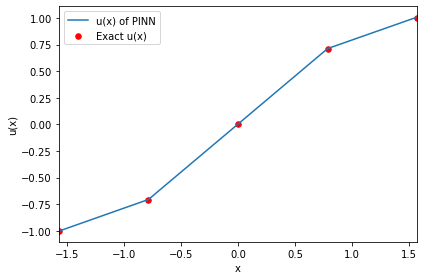

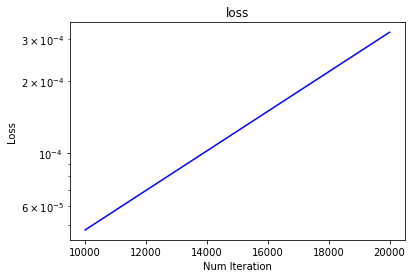

It: 20001, Loss: 1.773e-04  Losses ILRUDrxIC:[9.218118793796748e-05, 1.0146473869099282e-05, 5.799046266474761e-05, 1.7027925423462875e-05]
It: 20002, Loss: 4.390e-05  Losses ILRUDrxIC:[1.8987508155987598e-05, 2.8905071758345002e-06, 1.76513240148779e-05, 4.37018343291129e-06]
It: 20003, Loss: 2.399e-05  Losses ILRUDrxIC:[8.539270311302971e-06, 2.997822150518914e-07, 1.0506146281841211e-05, 4.6426744120253716e-06]
It: 20004, Loss: 1.046e-04  Losses ILRUDrxIC:[4.779545633937232e-05, 8.62322031025542e-06, 3.012145680258982e-05, 1.8107401047018357e-05]
It: 20005, Loss: 1.855e-04  Losses ILRUDrxIC:[6.603744986932725e-05, 7.80402660893742e-06, 8.225144119933248e-05, 2.9393428121693432e-05]
It: 20006, Loss: 1.827e-04  Losses ILRUDrxIC:[8.08226250228472e-05, 1.3341998965188395e-05, 5.952038918621838e-05, 2.903915083152242e-05]
It: 20007, Loss: 1.051e-04  Losses ILRUDrxIC:[3.519163146847859e-05, 3.861615823552711e-06, 4.79203081340529e-05, 1.8140293832402676e-05]
It: 20008, Loss: 3.067e-05  Lo

It: 20060, Loss: 1.243e-05  Losses ILRUDrxIC:[7.858421668061055e-06, 3.19627872613637e-07, 3.9442675188183784e-06, 3.048732537536125e-07]
It: 20061, Loss: 1.217e-05  Losses ILRUDrxIC:[8.590161087340675e-06, 7.414275273731619e-07, 2.4605728867754806e-06, 3.7476081615750445e-07]
It: 20062, Loss: 1.189e-05  Losses ILRUDrxIC:[7.956472472869791e-06, 3.3390651310583053e-07, 3.4277059057785664e-06, 1.6784439083039615e-07]
It: 20063, Loss: 1.178e-05  Losses ILRUDrxIC:[8.057031664066017e-06, 6.647511554547236e-07, 2.6945128865918377e-06, 3.6658849467130494e-07]
It: 20064, Loss: 1.189e-05  Losses ILRUDrxIC:[8.40261418488808e-06, 3.8819158021397016e-07, 3.015577703990857e-06, 8.063511813816149e-08]
It: 20065, Loss: 1.207e-05  Losses ILRUDrxIC:[7.885476406954695e-06, 6.484403911599657e-07, 3.106472377112368e-06, 4.3210582134634024e-07]
It: 20066, Loss: 1.218e-05  Losses ILRUDrxIC:[8.716011507203802e-06, 4.0862715877665323e-07, 2.9740640457021073e-06, 8.452318667195868e-08]
It: 20067, Loss: 1.216e-

It: 20118, Loss: 7.872e-05  Losses ILRUDrxIC:[1.1893508599314373e-05, 1.2441982107702643e-05, 1.4670611562905833e-05, 3.9711518184049055e-05]
It: 20119, Loss: 6.223e-05  Losses ILRUDrxIC:[1.48138215081417e-05, 4.26691849497729e-06, 1.7851310985861346e-05, 2.5299523258581758e-05]
It: 20120, Loss: 3.538e-05  Losses ILRUDrxIC:[9.59622411755845e-06, 5.266441803541966e-06, 6.809392743889475e-06, 1.370692734781187e-05]
It: 20121, Loss: 1.574e-05  Losses ILRUDrxIC:[9.726874850457534e-06, 3.510041892695881e-07, 4.4141233956906945e-06, 1.245974090124946e-06]
It: 20122, Loss: 1.309e-05  Losses ILRUDrxIC:[7.843612365832087e-06, 1.7654896566909883e-07, 4.360794719104888e-06, 7.091157385730185e-07]
It: 20123, Loss: 2.438e-05  Losses ILRUDrxIC:[8.175640687113628e-06, 3.6372716749610845e-06, 3.788366484513972e-06, 8.783666089584585e-06]
It: 20124, Loss: 3.831e-05  Losses ILRUDrxIC:[1.0977531019307207e-05, 2.017742644966347e-06, 1.190331022371538e-05, 1.3411928193818312e-05]
It: 20125, Loss: 4.424e-05

It: 20177, Loss: 1.155e-05  Losses ILRUDrxIC:[7.834184543753508e-06, 6.653218633800861e-07, 2.6611826342559652e-06, 3.8704365579178557e-07]
It: 20178, Loss: 1.149e-05  Losses ILRUDrxIC:[7.94041534390999e-06, 3.4016977679129923e-07, 3.101058155152714e-06, 1.1013258927050629e-07]
It: 20179, Loss: 1.143e-05  Losses ILRUDrxIC:[7.854887371649966e-06, 5.95340054587723e-07, 2.698452362892567e-06, 2.801915854888648e-07]
It: 20180, Loss: 1.138e-05  Losses ILRUDrxIC:[7.894622285675723e-06, 3.9610063140571583e-07, 2.979324563057162e-06, 1.0498563796090821e-07]
It: 20181, Loss: 1.134e-05  Losses ILRUDrxIC:[7.881054443714675e-06, 5.048285061093338e-07, 2.7857756776938913e-06, 1.6950993142472726e-07]
It: 20182, Loss: 1.133e-05  Losses ILRUDrxIC:[7.86074815550819e-06, 4.711691872216761e-07, 2.8517058581201127e-06, 1.461633019061992e-07]
It: 20183, Loss: 1.134e-05  Losses ILRUDrxIC:[7.901483513705898e-06, 4.28554841391815e-07, 2.8951503736607265e-06, 1.1159362145463092e-07]
It: 20184, Loss: 1.135e-05 

It: 20236, Loss: 1.116e-05  Losses ILRUDrxIC:[7.682840077904984e-06, 5.392963657868677e-07, 2.6999268811778165e-06, 2.3377853608508303e-07]
It: 20237, Loss: 1.117e-05  Losses ILRUDrxIC:[7.776151505822781e-06, 3.569734587927087e-07, 2.9432176233967766e-06, 9.173828630082426e-08]
It: 20238, Loss: 1.119e-05  Losses ILRUDrxIC:[7.667589670745656e-06, 5.702391376871674e-07, 2.670050662345602e-06, 2.792491216041526e-07]
It: 20239, Loss: 1.122e-05  Losses ILRUDrxIC:[7.787853064655792e-06, 3.3159426493512e-07, 3.000169499500771e-06, 9.550611679287613e-08]
It: 20240, Loss: 1.126e-05  Losses ILRUDrxIC:[7.650378393009305e-06, 6.177059503897908e-07, 2.634527618283755e-06, 3.535978123636596e-07]
It: 20241, Loss: 1.132e-05  Losses ILRUDrxIC:[7.808556802046951e-06, 2.995623447077378e-07, 3.0877197332301876e-06, 1.1966999124979338e-07]
It: 20242, Loss: 1.140e-05  Losses ILRUDrxIC:[7.630796062585432e-06, 6.933631198080548e-07, 2.593396402517101e-06, 4.839330358663574e-07]
It: 20243, Loss: 1.153e-05  Los

It: 20295, Loss: 1.898e-05  Losses ILRUDrxIC:[7.595586339448346e-06, 2.556472963988199e-06, 3.256197715018061e-06, 5.569997483689804e-06]
It: 20296, Loss: 3.628e-05  Losses ILRUDrxIC:[9.914501788443886e-06, 1.8277933122590184e-06, 1.1642805475275964e-05, 1.2895190593553707e-05]
It: 20297, Loss: 4.498e-05  Losses ILRUDrxIC:[8.811235602479428e-06, 7.128270681278082e-06, 7.859812285460066e-06, 2.1182386262807995e-05]
It: 20298, Loss: 3.776e-05  Losses ILRUDrxIC:[1.0064120942843147e-05, 1.954743311216589e-06, 1.1897792319359723e-05, 1.384204915666487e-05]
It: 20299, Loss: 2.237e-05  Losses ILRUDrxIC:[7.81542530603474e-06, 3.2890334296098445e-06, 3.8518123801623005e-06, 7.4100089477724396e-06]
It: 20300, Loss: 1.198e-05  Losses ILRUDrxIC:[7.888515028753318e-06, 2.3771950452555757e-07, 3.483043428786914e-06, 3.741000682566664e-07]
It: 20301, Loss: 1.321e-05  Losses ILRUDrxIC:[7.824442036508117e-06, 1.886783564941652e-07, 4.235310370859224e-06, 9.569473604642553e-07]
It: 20302, Loss: 2.181e-0

It: 20354, Loss: 1.099e-05  Losses ILRUDrxIC:[7.651724445167929e-06, 3.5484075056047004e-07, 2.902203732446651e-06, 8.159226183579449e-08]
It: 20355, Loss: 1.096e-05  Losses ILRUDrxIC:[7.368322712864028e-06, 5.400496547736111e-07, 2.791822225844953e-06, 2.611399736451858e-07]
It: 20356, Loss: 1.093e-05  Losses ILRUDrxIC:[7.663259566470515e-06, 4.006784308785427e-07, 2.780876457109116e-06, 8.144844798607664e-08]
It: 20357, Loss: 1.091e-05  Losses ILRUDrxIC:[7.351678959821584e-06, 4.559983040053339e-07, 2.9226569040474715e-06, 1.7599671764401137e-07]
It: 20358, Loss: 1.091e-05  Losses ILRUDrxIC:[7.68313566368306e-06, 4.79605148484552e-07, 2.6251268536725547e-06, 1.2540644434011483e-07]
It: 20359, Loss: 1.095e-05  Losses ILRUDrxIC:[7.3272672125312965e-06, 3.7489422766157077e-07, 3.1062299967743456e-06, 1.4036608320111554e-07]
It: 20360, Loss: 1.101e-05  Losses ILRUDrxIC:[7.748559255560394e-06, 5.600072086053842e-07, 2.4963426312751835e-06, 2.0268277012291946e-07]
It: 20361, Loss: 1.108e-0

It: 20413, Loss: 2.162e-05  Losses ILRUDrxIC:[1.4110883057583123e-05, 1.371367261526757e-06, 4.783936219610041e-06, 1.350539378108806e-06]
It: 20414, Loss: 2.935e-05  Losses ILRUDrxIC:[1.2665493159147445e-05, 8.82028700743831e-07, 1.3105145626468584e-05, 2.6938330393022625e-06]
It: 20415, Loss: 2.847e-05  Losses ILRUDrxIC:[1.6984695321298204e-05, 2.0114016479055863e-06, 6.9667648858739994e-06, 2.50562334258575e-06]
It: 20416, Loss: 2.055e-05  Losses ILRUDrxIC:[9.277971912524663e-06, 5.557308782044856e-07, 9.090702405956108e-06, 1.6218405107792933e-06]
It: 20417, Loss: 1.277e-05  Losses ILRUDrxIC:[8.801247531664558e-06, 8.868136660566961e-07, 2.5551667022227775e-06, 5.281976882542949e-07]
It: 20418, Loss: 1.092e-05  Losses ILRUDrxIC:[7.744424692646135e-06, 4.731712408556632e-07, 2.6054462978208903e-06, 9.962442248934167e-08]
It: 20419, Loss: 1.480e-05  Losses ILRUDrxIC:[7.844876563467551e-06, 4.6547850729439233e-07, 5.826070719194831e-06, 6.67790573061211e-07]
It: 20420, Loss: 1.960e-05

It: 20472, Loss: 1.054e-05  Losses ILRUDrxIC:[7.079455372149823e-06, 3.93832010558981e-07, 2.927444938904955e-06, 1.3573426826951618e-07]
It: 20473, Loss: 1.051e-05  Losses ILRUDrxIC:[7.3131768658640794e-06, 4.5612202370648447e-07, 2.6151531073992373e-06, 1.262855136019425e-07]
It: 20474, Loss: 1.048e-05  Losses ILRUDrxIC:[7.126650416466873e-06, 4.0523656252844376e-07, 2.8286438009672565e-06, 1.2440850127859449e-07]
It: 20475, Loss: 1.047e-05  Losses ILRUDrxIC:[7.205618203443009e-06, 4.337217944794247e-07, 2.7010894427803578e-06, 1.270835383593294e-07]
It: 20476, Loss: 1.046e-05  Losses ILRUDrxIC:[7.207428552646888e-06, 4.2351885554126056e-07, 2.7148184926772956e-06, 1.1713349579167698e-07]
It: 20477, Loss: 1.047e-05  Losses ILRUDrxIC:[7.12401197233703e-06, 4.1528662109158176e-07, 2.7985508950223448e-06, 1.298094218782353e-07]
It: 20478, Loss: 1.047e-05  Losses ILRUDrxIC:[7.2711736720521e-06, 4.3817286154990143e-07, 2.6475008780835196e-06, 1.1788286968794637e-07]
It: 20479, Loss: 1.048

It: 20531, Loss: 6.367e-04  Losses ILRUDrxIC:[5.033231354900636e-05, 7.157013169489801e-05, 0.0001630519109312445, 0.00035177235258743167]
It: 20532, Loss: 5.931e-04  Losses ILRUDrxIC:[4.283024827600457e-05, 8.921228436520323e-05, 0.0001237745746038854, 0.00033726857509464025]
It: 20533, Loss: 3.057e-04  Losses ILRUDrxIC:[3.442911838646978e-05, 3.089381425525062e-05, 8.060171239776537e-05, 0.00015976122813299298]
It: 20534, Loss: 5.207e-05  Losses ILRUDrxIC:[1.0465404557180591e-05, 8.220224117394537e-06, 1.0101148291141726e-05, 2.3287440853891894e-05]
It: 20535, Loss: 3.879e-05  Losses ILRUDrxIC:[7.643180651939474e-06, 6.877831765450537e-06, 6.106528417149093e-06, 1.8163596905651502e-05]
It: 20536, Loss: 2.101e-04  Losses ILRUDrxIC:[1.7019408915075473e-05, 2.0969253455405124e-05, 5.680597678292543e-05, 0.00011532702774275094]
It: 20537, Loss: 3.473e-04  Losses ILRUDrxIC:[2.349046553717926e-05, 5.179001163924113e-05, 7.371790707111359e-05, 0.00019829155644401908]
It: 20538, Loss: 2.995e

It: 20590, Loss: 1.091e-05  Losses ILRUDrxIC:[6.923510682099732e-06, 8.413747991653509e-07, 2.489908865754842e-06, 6.586919312212558e-07]
It: 20591, Loss: 1.035e-05  Losses ILRUDrxIC:[7.038333933451213e-06, 3.465637234967289e-07, 2.834979568433482e-06, 1.2556033368582575e-07]
It: 20592, Loss: 1.044e-05  Losses ILRUDrxIC:[7.00017108101747e-06, 3.1522958465757256e-07, 3.0219414384191623e-06, 1.0063617139621783e-07]
It: 20593, Loss: 1.093e-05  Losses ILRUDrxIC:[6.95848029863555e-06, 8.249839993368369e-07, 2.4513096832379233e-06, 6.913120955687191e-07]
It: 20594, Loss: 1.125e-05  Losses ILRUDrxIC:[7.102736162778456e-06, 1.8814684210610721e-07, 3.5076400308753364e-06, 4.517218599175976e-07]
It: 20595, Loss: 1.111e-05  Losses ILRUDrxIC:[6.945344921405194e-06, 8.990526794150355e-07, 2.4320650027220836e-06, 8.324841473950073e-07]
It: 20596, Loss: 1.067e-05  Losses ILRUDrxIC:[7.049793111946201e-06, 2.4821102329042333e-07, 3.186594767612405e-06, 1.8463541096025438e-07]
It: 20597, Loss: 1.032e-05

It: 20649, Loss: 1.006e-05  Losses ILRUDrxIC:[6.850636054878123e-06, 4.225834402404871e-07, 2.6555926524451934e-06, 1.2937216808950325e-07]
It: 20650, Loss: 1.005e-05  Losses ILRUDrxIC:[6.8497133725031745e-06, 3.8264155932665744e-07, 2.718802079471061e-06, 1.0350600376796137e-07]
It: 20651, Loss: 1.005e-05  Losses ILRUDrxIC:[6.845322332083015e-06, 4.259748038748512e-07, 2.6502038963371888e-06, 1.2879354471806437e-07]
It: 20652, Loss: 1.004e-05  Losses ILRUDrxIC:[6.841792583145434e-06, 3.844392324481305e-07, 2.7130608941661194e-06, 1.0554003893048503e-07]
It: 20653, Loss: 1.004e-05  Losses ILRUDrxIC:[6.842957645858405e-06, 4.165133873357263e-07, 2.657191998878261e-06, 1.2297476814637776e-07]
It: 20654, Loss: 1.003e-05  Losses ILRUDrxIC:[6.83061762174475e-06, 3.96003372316045e-07, 2.6978646019415464e-06, 1.1014699197176014e-07]
It: 20655, Loss: 1.003e-05  Losses ILRUDrxIC:[6.8433168962656055e-06, 4.020010919703054e-07, 2.6703446565079503e-06, 1.1442291025787199e-07]
It: 20656, Loss: 1.00

It: 20708, Loss: 2.255e-04  Losses ILRUDrxIC:[0.00010675862722564489, 1.4153953088680282e-05, 7.929196726763621e-05, 2.5252520572394133e-05]
It: 20709, Loss: 9.086e-05  Losses ILRUDrxIC:[3.76328025595285e-05, 4.024635472887894e-06, 3.969023600802757e-05, 9.510587915428914e-06]
It: 20710, Loss: 1.409e-05  Losses ILRUDrxIC:[9.753831363923382e-06, 5.22312859629892e-07, 3.3959170195885235e-06, 4.2285344648007595e-07]
It: 20711, Loss: 3.982e-05  Losses ILRUDrxIC:[1.9264469301560894e-05, 4.000357421318768e-06, 1.0080836545967031e-05, 6.4764253693283536e-06]
It: 20712, Loss: 1.177e-04  Losses ILRUDrxIC:[4.2121755541302264e-05, 5.032590706832707e-06, 5.282586789689958e-05, 1.7740472685545683e-05]
It: 20713, Loss: 1.621e-04  Losses ILRUDrxIC:[7.400547474389896e-05, 1.1419578186178114e-05, 5.492674245033413e-05, 2.1761212337878533e-05]
It: 20714, Loss: 1.324e-04  Losses ILRUDrxIC:[5.00533715239726e-05, 5.694428637070814e-06, 5.934460205025971e-05, 1.7352442228002474e-05]
It: 20715, Loss: 6.071e-

It: 20767, Loss: 9.728e-06  Losses ILRUDrxIC:[6.444820428441744e-06, 3.826224315162108e-07, 2.770983883237932e-06, 1.298269154403897e-07]
It: 20768, Loss: 9.914e-06  Losses ILRUDrxIC:[6.8829253905278165e-06, 4.6301337874865567e-07, 2.447557108098408e-06, 1.202087247520467e-07]
It: 20769, Loss: 1.010e-05  Losses ILRUDrxIC:[6.348380338749848e-06, 3.4490017242205795e-07, 3.2291413845086936e-06, 1.824090105628784e-07]
It: 20770, Loss: 1.015e-05  Losses ILRUDrxIC:[7.070977062539896e-06, 5.106326170789544e-07, 2.402333848294802e-06, 1.636493180967591e-07]
It: 20771, Loss: 1.002e-05  Losses ILRUDrxIC:[6.346688678604551e-06, 3.4250501812493894e-07, 3.166083388350671e-06, 1.6668960256538412e-07]
It: 20772, Loss: 9.829e-06  Losses ILRUDrxIC:[6.771414064132841e-06, 4.6656691665702965e-07, 2.4543539893784327e-06, 1.3629305328777264e-07]
It: 20773, Loss: 9.695e-06  Losses ILRUDrxIC:[6.45954605715815e-06, 3.6414306237020355e-07, 2.761566065601073e-06, 1.0993598209552147e-07]
It: 20774, Loss: 9.685e-

It: 20826, Loss: 2.093e-04  Losses ILRUDrxIC:[1.708549098111689e-05, 2.1096428099554032e-05, 5.7348846894456074e-05, 0.00011373494635336101]
It: 20827, Loss: 4.176e-04  Losses ILRUDrxIC:[2.70813143288251e-05, 6.431042129406705e-05, 8.804516983218491e-05, 0.00023813260486349463]
It: 20828, Loss: 4.801e-04  Losses ILRUDrxIC:[4.0963768697110936e-05, 5.352386870072223e-05, 0.00012481755402404815, 0.000260830856859684]
It: 20829, Loss: 3.553e-04  Losses ILRUDrxIC:[2.9517723305616528e-05, 5.3278552513802424e-05, 7.490915595553815e-05, 0.00019759099814109504]
It: 20830, Loss: 1.474e-04  Losses ILRUDrxIC:[2.3100588805391453e-05, 1.354726919089444e-05, 3.995577935711481e-05, 7.08434236003086e-05]
It: 20831, Loss: 2.050e-05  Losses ILRUDrxIC:[8.02186241344316e-06, 2.3669788333791075e-06, 5.709144716092851e-06, 4.397217253426788e-06]
It: 20832, Loss: 4.604e-05  Losses ILRUDrxIC:[7.407471002807142e-06, 7.5986436058883555e-06, 8.076211088337004e-06, 2.2958513000048697e-05]
It: 20833, Loss: 1.599e-0

It: 20885, Loss: 1.076e-05  Losses ILRUDrxIC:[6.2119461290421896e-06, 1.5064541969422862e-07, 3.824419763986953e-06, 5.748220814894012e-07]
It: 20886, Loss: 1.064e-05  Losses ILRUDrxIC:[6.555232175742276e-06, 9.059928629540082e-07, 2.190503209931194e-06, 9.901198154693702e-07]
It: 20887, Loss: 1.017e-05  Losses ILRUDrxIC:[6.239183676370885e-06, 1.8418650427065586e-07, 3.4315580705879256e-06, 3.137431860977813e-07]
It: 20888, Loss: 9.681e-06  Losses ILRUDrxIC:[6.398528512363555e-06, 5.734673322876915e-07, 2.373365305174957e-06, 3.354260798005271e-07]
It: 20889, Loss: 9.465e-06  Losses ILRUDrxIC:[6.3234824665414635e-06, 3.763881863960705e-07, 2.6700820399128133e-06, 9.507290599231055e-08]
It: 20890, Loss: 9.577e-06  Losses ILRUDrxIC:[6.278200089582242e-06, 2.8387700012899586e-07, 2.914265678555239e-06, 1.0038358766450983e-07]
It: 20891, Loss: 9.852e-06  Losses ILRUDrxIC:[6.43739031147561e-06, 6.556765583809465e-07, 2.2963754418015014e-06, 4.625112524081487e-07]
It: 20892, Loss: 1.006e-05

It: 20944, Loss: 9.243e-06  Losses ILRUDrxIC:[6.1887317315267865e-06, 3.494747886634286e-07, 2.6181044177064905e-06, 8.666525985745466e-08]
It: 20945, Loss: 9.239e-06  Losses ILRUDrxIC:[6.176851002237527e-06, 3.8908365240786225e-07, 2.55433428719698e-06, 1.1903358654308249e-07]
It: 20946, Loss: 9.235e-06  Losses ILRUDrxIC:[6.187260169099318e-06, 3.4830685535780503e-07, 2.613076958368765e-06, 8.649788441061901e-08]
It: 20947, Loss: 9.230e-06  Losses ILRUDrxIC:[6.167682386148954e-06, 3.854025294458552e-07, 2.5618012386985356e-06, 1.1541764877165406e-07]
It: 20948, Loss: 9.225e-06  Losses ILRUDrxIC:[6.1841692513553426e-06, 3.531971515258192e-07, 2.5982126317103393e-06, 8.988322264258386e-08]
It: 20949, Loss: 9.221e-06  Losses ILRUDrxIC:[6.159619260870386e-06, 3.773672574425291e-07, 2.5748065581865376e-06, 1.0904761182928269e-07]
It: 20950, Loss: 9.216e-06  Losses ILRUDrxIC:[6.179595857247477e-06, 3.608403744692623e-07, 2.581350372565794e-06, 9.394547362262529e-08]
It: 20951, Loss: 9.212e-

It: 21003, Loss: 1.208e-05  Losses ILRUDrxIC:[6.545931228174595e-06, 4.7078117404453224e-07, 4.512252871791134e-06, 5.468576205203135e-07]
It: 21004, Loss: 1.405e-05  Losses ILRUDrxIC:[9.605906598153524e-06, 6.736128170814482e-07, 3.4934739687741967e-06, 2.786347863548144e-07]
It: 21005, Loss: 1.736e-05  Losses ILRUDrxIC:[8.457903277303558e-06, 7.075767030073621e-07, 7.08362949808361e-06, 1.1123066769869183e-06]
It: 21006, Loss: 2.292e-05  Losses ILRUDrxIC:[1.4613685380027164e-05, 1.1823827890111716e-06, 6.251683771552052e-06, 8.722831807972398e-07]
It: 21007, Loss: 3.230e-05  Losses ILRUDrxIC:[1.4544719306286424e-05, 1.415864062437322e-06, 1.3767017662758008e-05, 2.575789039838128e-06]
It: 21008, Loss: 4.811e-05  Losses ILRUDrxIC:[2.794864121824503e-05, 2.5732399535627337e-06, 1.485454231442418e-05, 2.7357084491086425e-06]
It: 21009, Loss: 7.479e-05  Losses ILRUDrxIC:[3.299502350273542e-05, 3.5006271446036408e-06, 3.179050690960139e-05, 6.498919901787303e-06]
It: 21010, Loss: 1.192e-0

It: 21062, Loss: 1.226e-05  Losses ILRUDrxIC:[7.863984137657098e-06, 3.2078031608762103e-07, 3.3957912819460034e-06, 6.778579404453922e-07]
It: 21063, Loss: 1.070e-05  Losses ILRUDrxIC:[5.865386810910422e-06, 1.187858629236871e-06, 2.194990884163417e-06, 1.4514047279590159e-06]
It: 21064, Loss: 1.304e-05  Losses ILRUDrxIC:[5.816939392389031e-06, 1.893635612759681e-07, 5.529617283173138e-06, 1.5049110970721813e-06]
It: 21065, Loss: 1.577e-05  Losses ILRUDrxIC:[8.57158829603577e-06, 1.4105348782322835e-06, 3.1887382192508085e-06, 2.603516350063728e-06]
It: 21066, Loss: 1.570e-05  Losses ILRUDrxIC:[6.4233072407660075e-06, 2.49860619305764e-07, 7.029790594970109e-06, 1.997180334001314e-06]
It: 21067, Loss: 1.333e-05  Losses ILRUDrxIC:[7.211597221612465e-06, 1.2256882655492518e-06, 2.4711757760087494e-06, 2.4181094886444043e-06]
It: 21068, Loss: 1.160e-05  Losses ILRUDrxIC:[5.816602879349375e-06, 1.5047521628730465e-07, 4.379269284982001e-06, 1.2568657439260278e-06]
It: 21069, Loss: 1.229e-

It: 21121, Loss: 1.864e-05  Losses ILRUDrxIC:[6.620277417823672e-06, 6.539645482916967e-07, 6.399524863809347e-06, 4.963001629221253e-06]
It: 21122, Loss: 2.485e-05  Losses ILRUDrxIC:[6.124218543845927e-06, 3.827208729489939e-06, 4.365373570180964e-06, 1.0534172361076344e-05]
It: 21123, Loss: 2.839e-05  Losses ILRUDrxIC:[7.196291335276328e-06, 1.534818238724256e-06, 9.329936801805161e-06, 1.0324492905056104e-05]
It: 21124, Loss: 2.825e-05  Losses ILRUDrxIC:[6.206188572832616e-06, 4.441954843059648e-06, 4.88219893668429e-06, 1.2718284779111855e-05]
It: 21125, Loss: 2.485e-05  Losses ILRUDrxIC:[6.877131454530172e-06, 1.1936627970499103e-06, 8.274254469142761e-06, 8.50324795464985e-06]
It: 21126, Loss: 1.967e-05  Losses ILRUDrxIC:[5.918667739024386e-06, 2.936702230726951e-06, 3.4385248000035062e-06, 7.3711257755348925e-06]
It: 21127, Loss: 1.444e-05  Losses ILRUDrxIC:[6.186161044752225e-06, 3.279966733771289e-07, 5.061123374616727e-06, 2.8614463190024253e-06]
It: 21128, Loss: 1.061e-05  L

It: 21180, Loss: 9.108e-06  Losses ILRUDrxIC:[5.747367595176911e-06, 1.9041127075070108e-07, 2.9621080557262758e-06, 2.0762585961620061e-07]
It: 21181, Loss: 9.153e-06  Losses ILRUDrxIC:[5.60533044335898e-06, 6.544689199472487e-07, 2.2995811832515756e-06, 5.9367260973886e-07]
It: 21182, Loss: 9.217e-06  Losses ILRUDrxIC:[5.754834091931116e-06, 1.8002290858021297e-07, 3.024700617970666e-06, 2.5761235633581236e-07]
It: 21183, Loss: 9.304e-06  Losses ILRUDrxIC:[5.599170890491223e-06, 7.06610080669634e-07, 2.288806626893347e-06, 7.092971827660222e-07]
It: 21184, Loss: 9.421e-06  Losses ILRUDrxIC:[5.76936417928664e-06, 1.687210868794864e-07, 3.130337063339539e-06, 3.5245588492216484e-07]
It: 21185, Loss: 9.579e-06  Losses ILRUDrxIC:[5.593692094407743e-06, 7.919516633592139e-07, 2.2815340798842954e-06, 9.12069253899972e-07]
It: 21186, Loss: 9.791e-06  Losses ILRUDrxIC:[5.79660400035209e-06, 1.6004422320747835e-07, 3.307884526293492e-06, 5.265707159196609e-07]
It: 21187, Loss: 1.008e-05  Loss

It: 21239, Loss: 1.627e-05  Losses ILRUDrxIC:[5.661297109327279e-06, 2.2793703919887776e-06, 3.045623998332303e-06, 5.279084689391311e-06]
It: 21240, Loss: 2.541e-05  Losses ILRUDrxIC:[7.321582415897865e-06, 1.3363985544856405e-06, 8.32028490549419e-06, 8.436499228992034e-06]
It: 21241, Loss: 3.083e-05  Losses ILRUDrxIC:[6.6491670622781385e-06, 4.741386419482296e-06, 6.0235242926864885e-06, 1.3413338820100762e-05]
It: 21242, Loss: 2.963e-05  Losses ILRUDrxIC:[8.568173143430613e-06, 1.7081388250517193e-06, 9.191546268993989e-06, 1.0164788363908883e-05]
It: 21243, Loss: 2.315e-05  Losses ILRUDrxIC:[6.419431429094402e-06, 3.3703720418998273e-06, 4.825165433430811e-06, 8.53733035910409e-06]
It: 21244, Loss: 1.524e-05  Losses ILRUDrxIC:[7.1608264988753945e-06, 4.4698927581521275e-07, 4.8420956773043144e-06, 2.7902094643650344e-06]
It: 21245, Loss: 9.824e-06  Losses ILRUDrxIC:[5.469106781674782e-06, 7.880544785621169e-07, 2.71007047558669e-06, 8.567977261009219e-07]
It: 21246, Loss: 8.791e-0

It: 21298, Loss: 8.334e-06  Losses ILRUDrxIC:[5.445619535748847e-06, 3.26418643226134e-07, 2.484957121851039e-06, 7.686386993555061e-08]
It: 21299, Loss: 8.338e-06  Losses ILRUDrxIC:[5.401931503001833e-06, 3.61114331326462e-07, 2.4601922632427886e-06, 1.14618011082257e-07]
It: 21300, Loss: 8.347e-06  Losses ILRUDrxIC:[5.4532629292225465e-06, 2.929868685441761e-07, 2.5397450826858403e-06, 6.123806883806537e-08]
It: 21301, Loss: 8.357e-06  Losses ILRUDrxIC:[5.390804744820343e-06, 3.928995511159883e-07, 2.421862973278621e-06, 1.517571632803083e-07]
It: 21302, Loss: 8.366e-06  Losses ILRUDrxIC:[5.453708581626415e-06, 2.7335562435837346e-07, 2.5793167424126295e-06, 5.983602591186354e-08]
It: 21303, Loss: 8.372e-06  Losses ILRUDrxIC:[5.3849444157094695e-06, 4.1184924270964984e-07, 2.3984400741028367e-06, 1.7635377957958553e-07]
It: 21304, Loss: 8.373e-06  Losses ILRUDrxIC:[5.447985131468158e-06, 2.647641110797849e-07, 2.5992821974796243e-06, 6.110058592412315e-08]
It: 21305, Loss: 8.371e-06 

It: 21357, Loss: 4.106e-05  Losses ILRUDrxIC:[8.781681572145317e-06, 3.080049737036461e-06, 1.2468167369661387e-05, 1.6733647498767823e-05]
It: 21358, Loss: 6.024e-05  Losses ILRUDrxIC:[8.363084816664923e-06, 9.256838893634267e-06, 1.2403748769429512e-05, 3.0212693673092872e-05]
It: 21359, Loss: 9.069e-05  Losses ILRUDrxIC:[1.3225786460679956e-05, 8.732582500670105e-06, 2.562635563663207e-05, 4.31083062721882e-05]
It: 21360, Loss: 1.392e-04  Losses ILRUDrxIC:[1.3994402252137661e-05, 2.0938925445079803e-05, 2.9924225600552745e-05, 7.433778228005394e-05]
It: 21361, Loss: 2.148e-04  Losses ILRUDrxIC:[2.3826249162084423e-05, 2.373067218286451e-05, 5.735132799600251e-05, 0.00010993475734721869]
It: 21362, Loss: 3.315e-04  Losses ILRUDrxIC:[2.8154419851489365e-05, 4.8352518206229433e-05, 7.398698653560132e-05, 0.00018098477448802441]
It: 21363, Loss: 5.012e-04  Losses ILRUDrxIC:[4.757353963213973e-05, 5.9568017604760826e-05, 0.00012863097072113305, 0.0002654760901350528]
It: 21364, Loss: 7.3

It: 21416, Loss: 1.540e-05  Losses ILRUDrxIC:[5.37156574864639e-06, 2.066314436888206e-06, 3.158655317747616e-06, 4.8029196477727965e-06]
It: 21417, Loss: 1.318e-05  Losses ILRUDrxIC:[5.871610028407304e-06, 3.4860227060562465e-07, 4.634509878087556e-06, 2.3297602638194803e-06]
It: 21418, Loss: 9.830e-06  Losses ILRUDrxIC:[5.157447958481498e-06, 9.268484291169443e-07, 2.389376277278643e-06, 1.3565872905019205e-06]
It: 21419, Loss: 8.170e-06  Losses ILRUDrxIC:[5.223556854616618e-06, 3.121963914054504e-07, 2.5673298296169378e-06, 6.653393569422406e-08]
It: 21420, Loss: 9.055e-06  Losses ILRUDrxIC:[5.428411895991303e-06, 1.8001715318405331e-07, 3.0858882382744923e-06, 3.610984435908904e-07]
It: 21421, Loss: 1.103e-05  Losses ILRUDrxIC:[5.18190336151747e-06, 1.2142222658440005e-06, 2.5281335638283053e-06, 2.1040989395260112e-06]
It: 21422, Loss: 1.202e-05  Losses ILRUDrxIC:[5.77167247683974e-06, 2.690334213184542e-07, 4.202002855890896e-06, 1.7757797650119755e-06]
It: 21423, Loss: 1.121e-05

It: 21475, Loss: 8.297e-06  Losses ILRUDrxIC:[5.575491741183214e-06, 3.82457358227839e-07, 2.2623144104727544e-06, 7.673618540593452e-08]
It: 21476, Loss: 8.505e-06  Losses ILRUDrxIC:[4.995581548428163e-06, 2.5999852937275136e-07, 3.08999346998462e-06, 1.5924396734590118e-07]
It: 21477, Loss: 8.851e-06  Losses ILRUDrxIC:[5.983273240417475e-06, 4.727058069420309e-07, 2.238303750345949e-06, 1.567537566415922e-07]
It: 21478, Loss: 9.421e-06  Losses ILRUDrxIC:[5.193005108594662e-06, 2.288225715574299e-07, 3.730070829988108e-06, 2.694171428174741e-07]
It: 21479, Loss: 1.036e-05  Losses ILRUDrxIC:[6.961779945413582e-06, 6.162168801893131e-07, 2.457666596455965e-06, 3.242708430661878e-07]
It: 21480, Loss: 1.191e-05  Losses ILRUDrxIC:[5.988755219732411e-06, 2.440339130771463e-07, 5.128472821525065e-06, 5.517881618288811e-07]
It: 21481, Loss: 1.450e-05  Losses ILRUDrxIC:[9.420441529073287e-06, 8.949996868068411e-07, 3.477883865343756e-06, 7.047203780530253e-07]
It: 21482, Loss: 1.883e-05  Losse

It: 21534, Loss: 1.363e-05  Losses ILRUDrxIC:[8.16311967355432e-06, 1.001130726763222e-06, 3.530195044731954e-06, 9.390013246957096e-07]
It: 21535, Loss: 8.678e-06  Losses ILRUDrxIC:[4.85823738927138e-06, 2.5822220095506054e-07, 3.3210799301741645e-06, 2.4041304413913167e-07]
It: 21536, Loss: 8.350e-06  Losses ILRUDrxIC:[4.8332517508242745e-06, 2.867587340915634e-07, 3.0915339266357478e-06, 1.3813520638450427e-07]
It: 21537, Loss: 1.165e-05  Losses ILRUDrxIC:[7.269729394465685e-06, 8.318481832247926e-07, 2.912235686380882e-06, 6.403374754881952e-07]
It: 21538, Loss: 1.416e-05  Losses ILRUDrxIC:[6.22578181719291e-06, 3.817802678440785e-07, 6.455704351537861e-06, 1.093103037419496e-06]
It: 21539, Loss: 1.313e-05  Losses ILRUDrxIC:[8.039609383558854e-06, 9.730590591061627e-07, 3.253963086535805e-06, 8.664590609441802e-07]
It: 21540, Loss: 9.963e-06  Losses ILRUDrxIC:[5.11095140609541e-06, 2.404381973519776e-07, 4.136187726544449e-06, 4.754335520829045e-07]
It: 21541, Loss: 7.928e-06  Loss

It: 21592, Loss: 7.649e-06  Losses ILRUDrxIC:[4.870262728218222e-06, 3.115282822818699e-07, 2.39380938182876e-06, 7.337207819091418e-08]
It: 21593, Loss: 7.653e-06  Losses ILRUDrxIC:[4.814485237147892e-06, 2.9708601800848555e-07, 2.461394842612208e-06, 8.044300159326667e-08]
It: 21594, Loss: 7.658e-06  Losses ILRUDrxIC:[4.914909368380904e-06, 3.234240750771278e-07, 2.346846713408013e-06, 7.319715678022476e-08]
It: 21595, Loss: 7.657e-06  Losses ILRUDrxIC:[4.794609139935346e-06, 2.9160958092688816e-07, 2.489111238901387e-06, 8.178534471880994e-08]
It: 21596, Loss: 7.649e-06  Losses ILRUDrxIC:[4.904619345325045e-06, 3.233484449083335e-07, 2.345645270906971e-06, 7.521963141243759e-08]
It: 21597, Loss: 7.637e-06  Losses ILRUDrxIC:[4.8105293899425305e-06, 2.952297109004576e-07, 2.455818730595638e-06, 7.553937564352964e-08]
It: 21598, Loss: 7.628e-06  Losses ILRUDrxIC:[4.855338374909479e-06, 3.1353104645859275e-07, 2.381591002631467e-06, 7.751033592739986e-08]
It: 21599, Loss: 7.623e-06  Los

It: 21651, Loss: 4.964e-04  Losses ILRUDrxIC:[3.886106060235761e-05, 5.824748586746864e-05, 0.00012723023246508092, 0.0002720956108532846]
It: 21652, Loss: 7.439e-04  Losses ILRUDrxIC:[4.898797124042176e-05, 0.0001038487971527502, 0.00017016615311149508, 0.0004209064645692706]
It: 21653, Loss: 1.043e-03  Losses ILRUDrxIC:[7.640626427019015e-05, 0.0001274583046324551, 0.0002603827742859721, 0.000578851206228137]
It: 21654, Loss: 1.334e-03  Losses ILRUDrxIC:[8.753657311899588e-05, 0.00018486283079255372, 0.0003106281510554254, 0.0007506398251280189]
It: 21655, Loss: 1.451e-03  Losses ILRUDrxIC:[0.00010747354826889932, 0.00018057778652291745, 0.00035612008650787175, 0.0008070001495070755]
It: 21656, Loss: 1.267e-03  Losses ILRUDrxIC:[8.757445903029293e-05, 0.0001784686028258875, 0.0002955488162115216, 0.0007049894193187356]
It: 21657, Loss: 7.717e-04  Losses ILRUDrxIC:[6.560069596162066e-05, 9.387426689499989e-05, 0.00018835067749023438, 0.00042387074790894985]
It: 21658, Loss: 2.482e-04 

It: 21710, Loss: 8.851e-06  Losses ILRUDrxIC:[4.701979833043879e-06, 1.4665636172139784e-07, 3.382232762305648e-06, 6.199879862833768e-07]
It: 21711, Loss: 7.572e-06  Losses ILRUDrxIC:[4.809691745322198e-06, 3.7644804251613095e-07, 2.2714009446644923e-06, 1.1423531987020397e-07]
It: 21712, Loss: 8.170e-06  Losses ILRUDrxIC:[4.627535872714361e-06, 6.090990609664004e-07, 2.3208071979752276e-06, 6.124476499280718e-07]
It: 21713, Loss: 9.579e-06  Losses ILRUDrxIC:[4.9520494940225035e-06, 1.8491594744318718e-07, 3.5042414765484864e-06, 9.377152991874027e-07]
It: 21714, Loss: 1.023e-05  Losses ILRUDrxIC:[4.685444309870945e-06, 1.1308043212920893e-06, 2.3802915620763088e-06, 2.0337615751486737e-06]
It: 21715, Loss: 9.551e-06  Losses ILRUDrxIC:[4.844253908231622e-06, 1.7290034293182543e-07, 3.5688592561200494e-06, 9.651633945395588e-07]
It: 21716, Loss: 8.274e-06  Losses ILRUDrxIC:[4.681036898546154e-06, 6.754495416316786e-07, 2.1792932329844916e-06, 7.381745490420144e-07]
It: 21717, Loss: 7.5

It: 21769, Loss: 7.307e-06  Losses ILRUDrxIC:[4.577550498652272e-06, 2.6581736278785684e-07, 2.4100013433780987e-06, 5.345660980538014e-08]
It: 21770, Loss: 7.301e-06  Losses ILRUDrxIC:[4.551651272777235e-06, 3.204939389434003e-07, 2.3346030957327457e-06, 9.45275928643241e-08]
It: 21771, Loss: 7.294e-06  Losses ILRUDrxIC:[4.5681595111091156e-06, 2.720464920002996e-07, 2.3972693270479795e-06, 5.644539768923096e-08]
It: 21772, Loss: 7.287e-06  Losses ILRUDrxIC:[4.551867732516257e-06, 3.0450095778178365e-07, 2.3504078399128048e-06, 7.98845363192413e-08]
It: 21773, Loss: 7.281e-06  Losses ILRUDrxIC:[4.555697159958072e-06, 2.8902016424581234e-07, 2.3705210878688376e-06, 6.567145760527637e-08]
It: 21774, Loss: 7.278e-06  Losses ILRUDrxIC:[4.553644885163521e-06, 2.8550118713610573e-07, 2.372752305745962e-06, 6.568832588982332e-08]
It: 21775, Loss: 7.276e-06  Losses ILRUDrxIC:[4.544540843198774e-06, 3.037147564555198e-07, 2.3486854843213223e-06, 7.893754627730232e-08]
It: 21776, Loss: 7.274e-0

It: 21827, Loss: 7.219e-06  Losses ILRUDrxIC:[4.627498128684238e-06, 3.109827275693533e-07, 2.2272572550718905e-06, 5.322715779243481e-08]
It: 21828, Loss: 7.283e-06  Losses ILRUDrxIC:[4.302200977690518e-06, 2.600490631721186e-07, 2.612152002257062e-06, 1.0832908259317264e-07]
It: 21829, Loss: 7.384e-06  Losses ILRUDrxIC:[4.78517222290975e-06, 3.3106258001680544e-07, 2.211840637755813e-06, 5.544994507999945e-08]
It: 21830, Loss: 7.542e-06  Losses ILRUDrxIC:[4.3194172576477285e-06, 2.5680907356218086e-07, 2.8214481062605046e-06, 1.4417072691230715e-07]
It: 21831, Loss: 7.794e-06  Losses ILRUDrxIC:[5.106922344566556e-06, 3.714908132224082e-07, 2.243040171379107e-06, 7.209731478496906e-08]
It: 21832, Loss: 8.193e-06  Losses ILRUDrxIC:[4.460520358406939e-06, 2.626003094974294e-07, 3.2502150588697987e-06, 2.1984344300562952e-07]
It: 21833, Loss: 8.832e-06  Losses ILRUDrxIC:[5.805615728604607e-06, 4.5404777893054415e-07, 2.4413504888798343e-06, 1.314666349117033e-07]
It: 21834, Loss: 9.859e-

It: 21886, Loss: 8.267e-06  Losses ILRUDrxIC:[4.239600912114838e-06, 2.6176306278102857e-07, 3.498164915072266e-06, 2.6782373652167735e-07]
It: 21887, Loss: 7.751e-06  Losses ILRUDrxIC:[4.2240308175678365e-06, 3.5594567293628643e-07, 2.9397117486951174e-06, 2.312220033218182e-07]
It: 21888, Loss: 1.243e-05  Losses ILRUDrxIC:[7.713218110438902e-06, 6.576497071364429e-07, 3.5292050597490743e-06, 5.282740858092438e-07]
It: 21889, Loss: 1.628e-05  Losses ILRUDrxIC:[6.9394241108966526e-06, 7.151486443035537e-07, 7.44087583370856e-06, 1.1884723107868922e-06]
It: 21890, Loss: 1.529e-05  Losses ILRUDrxIC:[9.074776244233362e-06, 8.848887205203937e-07, 4.4945140871277545e-06, 8.360515835192928e-07]
It: 21891, Loss: 1.088e-05  Losses ILRUDrxIC:[5.0790863497240935e-06, 4.632948957805638e-07, 4.746392733068205e-06, 5.874548492101894e-07]
It: 21892, Loss: 7.463e-06  Losses ILRUDrxIC:[4.7553044169035275e-06, 3.0017869789844553e-07, 2.3748680177959614e-06, 3.295119910262656e-08]
It: 21893, Loss: 7.704

It: 21945, Loss: 1.672e-04  Losses ILRUDrxIC:[1.375370175082935e-05, 1.822498961701058e-05, 4.4240579882171005e-05, 9.095687710214406e-05]
It: 21946, Loss: 2.549e-04  Losses ILRUDrxIC:[1.5813668142072856e-05, 3.722717519849539e-05, 5.4487736633745953e-05, 0.00014739419566467404]
It: 21947, Loss: 3.832e-04  Losses ILRUDrxIC:[2.635688906593714e-05, 4.515753244049847e-05, 9.693657921161503e-05, 0.00021478344569914043]
It: 21948, Loss: 5.636e-04  Losses ILRUDrxIC:[3.181260763085447e-05, 8.032740151975304e-05, 0.0001247729524038732, 0.0003267189022153616]
It: 21949, Loss: 7.874e-04  Losses ILRUDrxIC:[4.929683927912265e-05, 9.68239619396627e-05, 0.0001944722462212667, 0.0004468519182410091]
It: 21950, Loss: 1.026e-03  Losses ILRUDrxIC:[5.631187013932504e-05, 0.0001446545938961208, 0.00023294860147871077, 0.0005921446718275547]
It: 21951, Loss: 1.182e-03  Losses ILRUDrxIC:[7.302216545213014e-05, 0.0001483705418650061, 0.0002880505926441401, 0.00067277648486197]
It: 21952, Loss: 1.157e-03  Los

It: 22004, Loss: 1.055e-05  Losses ILRUDrxIC:[4.342205556895351e-06, 1.1505454722282593e-06, 2.8848280635429546e-06, 2.167453658330487e-06]
It: 22005, Loss: 8.617e-06  Losses ILRUDrxIC:[5.097919711261056e-06, 2.2376829633685702e-07, 2.8838344405812677e-06, 4.1099531244981335e-07]
It: 22006, Loss: 7.281e-06  Losses ILRUDrxIC:[4.070696377311833e-06, 3.421673397951963e-07, 2.672901246114634e-06, 1.9546908447409805e-07]
It: 22007, Loss: 7.266e-06  Losses ILRUDrxIC:[4.289988282835111e-06, 5.068437189947872e-07, 2.084359039145056e-06, 3.8448024497483857e-07]
It: 22008, Loss: 8.187e-06  Losses ILRUDrxIC:[4.299441570765339e-06, 1.5386554252927453e-07, 3.11776420858223e-06, 6.16305953826668e-07]
It: 22009, Loss: 9.069e-06  Losses ILRUDrxIC:[4.128880846110405e-06, 9.562232889948064e-07, 2.4141636458807625e-06, 1.5698560673627071e-06]
It: 22010, Loss: 9.172e-06  Losses ILRUDrxIC:[4.845856892643496e-06, 2.215670917848911e-07, 3.230549737054389e-06, 8.738350061321398e-07]
It: 22011, Loss: 8.478e-06

It: 22063, Loss: 6.662e-06  Losses ILRUDrxIC:[4.049360086355591e-06, 2.5794111024879385e-07, 2.3071668238117127e-06, 4.753228921572372e-08]
It: 22064, Loss: 6.663e-06  Losses ILRUDrxIC:[4.006667495559668e-06, 2.8459743361963774e-07, 2.2921658455743454e-06, 7.930404422040738e-08]
It: 22065, Loss: 6.662e-06  Losses ILRUDrxIC:[4.060384981130483e-06, 2.5363766553709866e-07, 2.304306008227286e-06, 4.3508634917088784e-08]
It: 22066, Loss: 6.659e-06  Losses ILRUDrxIC:[3.996345185441896e-06, 2.85798165577944e-07, 2.2952253857511096e-06, 8.173618937235005e-08]
It: 22067, Loss: 6.654e-06  Losses ILRUDrxIC:[4.056342277181102e-06, 2.544452684105636e-07, 2.2996114239504095e-06, 4.399078079586616e-08]
It: 22068, Loss: 6.648e-06  Losses ILRUDrxIC:[3.996146460849559e-06, 2.804634107178572e-07, 2.295920239703264e-06, 7.564780446500663e-08]
It: 22069, Loss: 6.642e-06  Losses ILRUDrxIC:[4.039131908939453e-06, 2.5981464091273665e-07, 2.2938568235986168e-06, 4.9079034170063096e-08]
It: 22070, Loss: 6.636e-

It: 22122, Loss: 6.463e-06  Losses ILRUDrxIC:[3.879892574332189e-06, 2.570269259649649e-07, 2.271896846650634e-06, 5.462488061880322e-08]
It: 22123, Loss: 6.460e-06  Losses ILRUDrxIC:[3.882045348291285e-06, 2.591324630429881e-07, 2.2633594198850915e-06, 5.574501571459223e-08]
It: 22124, Loss: 6.457e-06  Losses ILRUDrxIC:[3.874423782690428e-06, 2.5654321689216886e-07, 2.272183110108017e-06, 5.3818144607475915e-08]
It: 22125, Loss: 6.454e-06  Losses ILRUDrxIC:[3.876725259033265e-06, 2.58711878586837e-07, 2.2621431980951456e-06, 5.60907977842362e-08]
It: 22126, Loss: 6.450e-06  Losses ILRUDrxIC:[3.86879719371791e-06, 2.5626238198128704e-07, 2.2716087642038474e-06, 5.368830713337047e-08]
It: 22127, Loss: 6.447e-06  Losses ILRUDrxIC:[3.8720240809198e-06, 2.587838991985336e-07, 2.2608314793615136e-06, 5.553030746341392e-08]
It: 22128, Loss: 6.444e-06  Losses ILRUDrxIC:[3.862809535348788e-06, 2.5528018454679113e-07, 2.271373205076088e-06, 5.43289786492096e-08]
It: 22129, Loss: 6.440e-06  Loss

It: 22181, Loss: 3.616e-04  Losses ILRUDrxIC:[5.993836384732276e-05, 2.9239719879115e-05, 0.00013824897177983075, 0.00013419614697340876]
It: 22182, Loss: 5.201e-04  Losses ILRUDrxIC:[9.87239764072001e-05, 5.334341767593287e-05, 0.00017388623382430524, 0.00019410974346101284]
It: 22183, Loss: 5.233e-04  Losses ILRUDrxIC:[6.761993427062407e-05, 4.6486220526276156e-05, 0.00018940049631055444, 0.00021977705182507634]
It: 22184, Loss: 4.104e-04  Losses ILRUDrxIC:[2.9097956939949654e-05, 5.4936008382355794e-05, 0.00010948166163871065, 0.00021692508016712964]
It: 22185, Loss: 3.303e-04  Losses ILRUDrxIC:[1.2388357390591409e-05, 3.7401343433884904e-05, 8.543682633899152e-05, 0.00019503419753164053]
It: 22186, Loss: 3.876e-04  Losses ILRUDrxIC:[5.747807153966278e-05, 5.378234345698729e-05, 9.467052586842328e-05, 0.00018167559755966067]
It: 22187, Loss: 5.281e-04  Losses ILRUDrxIC:[0.00015142958727665246, 5.0442748033674434e-05, 0.00015101520693860948, 0.00017524027498438954]
It: 22188, Loss: 6

It: 22240, Loss: 8.313e-06  Losses ILRUDrxIC:[3.6257797546568327e-06, 1.4239809331684228e-07, 3.736689450306585e-06, 8.081834721451742e-07]
It: 22241, Loss: 8.640e-06  Losses ILRUDrxIC:[4.213522970530903e-06, 9.04679154700716e-07, 2.155396259695408e-06, 1.366202809549577e-06]
It: 22242, Loss: 8.268e-06  Losses ILRUDrxIC:[3.6011299471283564e-06, 1.5092729199750465e-07, 3.580771817723871e-06, 9.34720105760789e-07]
It: 22243, Loss: 7.795e-06  Losses ILRUDrxIC:[3.6829205782851204e-06, 8.133400228871324e-07, 2.1042176285845926e-06, 1.1946493714276585e-06]
It: 22244, Loss: 7.696e-06  Losses ILRUDrxIC:[4.116126547160093e-06, 1.7288378728608222e-07, 2.8850179205619497e-06, 5.223535026743775e-07]
It: 22245, Loss: 7.861e-06  Losses ILRUDrxIC:[3.7377380976977292e-06, 6.454463346017292e-07, 2.627214371386799e-06, 8.50144715514034e-07]
It: 22246, Loss: 7.852e-06  Losses ILRUDrxIC:[4.602871285896981e-06, 2.5078148269130907e-07, 2.729841526161181e-06, 2.684716093881434e-07]
It: 22247, Loss: 7.460e-06

It: 22299, Loss: 5.450e-04  Losses ILRUDrxIC:[3.954055137000978e-05, 6.730571476509795e-05, 0.00013483548536896706, 0.0003032791428267956]
It: 22300, Loss: 6.361e-04  Losses ILRUDrxIC:[4.052485746797174e-05, 9.1471680207178e-05, 0.0001433182624168694, 0.00036083132727071643]
It: 22301, Loss: 6.731e-04  Losses ILRUDrxIC:[4.9089485401054844e-05, 8.383137901546434e-05, 0.0001652528007980436, 0.0003749046300072223]
It: 22302, Loss: 6.311e-04  Losses ILRUDrxIC:[4.140844612265937e-05, 9.116152068600059e-05, 0.00014347283286042511, 0.0003550208348315209]
It: 22303, Loss: 4.951e-04  Losses ILRUDrxIC:[3.863768506562337e-05, 6.036502600181848e-05, 0.00012269761646166444, 0.00027340385713614523]
It: 22304, Loss: 3.055e-04  Losses ILRUDrxIC:[2.2179643565323204e-05, 4.5478260290110484e-05, 6.902639142936096e-05, 0.00016880393377505243]
It: 22305, Loss: 1.259e-04  Losses ILRUDrxIC:[1.3601104910776485e-05, 1.3180608220864087e-05, 3.334746361360885e-05, 6.576307350769639e-05]
It: 22306, Loss: 2.140e-0

It: 22358, Loss: 6.090e-06  Losses ILRUDrxIC:[3.531507672960288e-06, 2.5766215117073443e-07, 2.240551566501381e-06, 6.026499477229663e-08]
It: 22359, Loss: 6.240e-06  Losses ILRUDrxIC:[3.5061175367445685e-06, 3.65290645731875e-07, 2.158332108592731e-06, 2.1017976337134314e-07]
It: 22360, Loss: 6.624e-06  Losses ILRUDrxIC:[3.6576634556695353e-06, 1.5546855536285875e-07, 2.5965161967178574e-06, 2.1439160491354414e-07]
It: 22361, Loss: 7.039e-06  Losses ILRUDrxIC:[3.4910613067040686e-06, 6.016209113113291e-07, 2.1729160835093353e-06, 7.729687467872282e-07]
It: 22362, Loss: 7.316e-06  Losses ILRUDrxIC:[3.7508332297875313e-06, 1.6410992031978822e-07, 2.876123289752286e-06, 5.25166228726448e-07]
It: 22363, Loss: 7.372e-06  Losses ILRUDrxIC:[3.489159325908986e-06, 6.824267870797485e-07, 2.206547151217819e-06, 9.942464203049894e-07]
It: 22364, Loss: 7.211e-06  Losses ILRUDrxIC:[3.7334202716010623e-06, 1.6223901866396773e-07, 2.8384849883877905e-06, 4.770808459397813e-07]
It: 22365, Loss: 6.908

It: 22417, Loss: 6.010e-06  Losses ILRUDrxIC:[3.4531142318883212e-06, 1.8538190715844394e-07, 2.3267573396879015e-06, 4.522742713675143e-08]
It: 22418, Loss: 6.028e-06  Losses ILRUDrxIC:[3.382191607670393e-06, 3.315734034003981e-07, 2.1375485630414914e-06, 1.7677115238257102e-07]
It: 22419, Loss: 6.051e-06  Losses ILRUDrxIC:[3.458300398051506e-06, 1.765265977837771e-07, 2.3577015326736728e-06, 5.890095877703061e-08]
It: 22420, Loss: 6.083e-06  Losses ILRUDrxIC:[3.37364622282621e-06, 3.5680139376381703e-07, 2.127681909769308e-06, 2.2520939069181622e-07]
It: 22421, Loss: 6.126e-06  Losses ILRUDrxIC:[3.4686718208831735e-06, 1.6642265165955905e-07, 2.4039929940045113e-06, 8.705454490609554e-08]
It: 22422, Loss: 6.184e-06  Losses ILRUDrxIC:[3.3647913824097486e-06, 3.954742737732886e-07, 2.119405962730525e-06, 3.0424641295212496e-07]
It: 22423, Loss: 6.262e-06  Losses ILRUDrxIC:[3.4881597912317375e-06, 1.5625900573468243e-07, 2.4750750071689254e-06, 1.4282670690590749e-07]
It: 22424, Loss: 6

It: 22476, Loss: 4.678e-05  Losses ILRUDrxIC:[4.858072315983009e-06, 7.300897323148092e-06, 9.688019417808391e-06, 2.4930657673394307e-05]
It: 22477, Loss: 4.085e-05  Losses ILRUDrxIC:[5.477911145135295e-06, 3.5896764529752545e-06, 1.2834249901061412e-05, 1.894645538413897e-05]
It: 22478, Loss: 2.459e-05  Losses ILRUDrxIC:[3.954638486902695e-06, 3.838464635919081e-06, 5.195077392272651e-06, 1.1604821338551119e-05]
It: 22479, Loss: 1.010e-05  Losses ILRUDrxIC:[3.8174907786014955e-06, 3.409724627090327e-07, 3.922759333363501e-06, 2.022024546022294e-06]
It: 22480, Loss: 6.092e-06  Losses ILRUDrxIC:[3.3140822779387236e-06, 1.7725473355767463e-07, 2.509211299184244e-06, 9.186072702505044e-08]
It: 22481, Loss: 1.233e-05  Losses ILRUDrxIC:[3.4767042507155566e-06, 1.7857682905741967e-06, 2.884069090214325e-06, 4.186923433735501e-06]
It: 22482, Loss: 2.163e-05  Losses ILRUDrxIC:[4.233734671288403e-06, 1.4026192047822406e-06, 7.41797612135997e-06, 8.571676517021842e-06]
It: 22483, Loss: 2.619e-0

It: 22535, Loss: 5.781e-06  Losses ILRUDrxIC:[3.257429852965288e-06, 2.840708361873112e-07, 2.141457798643387e-06, 9.76996545887232e-08]
It: 22536, Loss: 5.751e-06  Losses ILRUDrxIC:[3.2563309559918707e-06, 2.1991262144638313e-07, 2.238394472442451e-06, 3.607033605135257e-08]
It: 22537, Loss: 5.742e-06  Losses ILRUDrxIC:[3.26910139847314e-06, 2.343998630749411e-07, 2.1958185243420303e-06, 4.234061989905058e-08]
It: 22538, Loss: 5.750e-06  Losses ILRUDrxIC:[3.239095576645923e-06, 2.606895463941328e-07, 2.1787238893011818e-06, 7.161617787687646e-08]
It: 22539, Loss: 5.768e-06  Losses ILRUDrxIC:[3.2807101888465695e-06, 2.0451676618904457e-07, 2.251922069262946e-06, 3.050473296184464e-08]
It: 22540, Loss: 5.784e-06  Losses ILRUDrxIC:[3.2288196507579414e-06, 2.9006292834310443e-07, 2.149610736523755e-06, 1.1560027246559912e-07]
It: 22541, Loss: 5.793e-06  Losses ILRUDrxIC:[3.2846617159520974e-06, 1.926551931319409e-07, 2.2807903405919205e-06, 3.452274910387132e-08]
It: 22542, Loss: 5.791e-0

It: 22594, Loss: 2.830e-04  Losses ILRUDrxIC:[0.00011627849016804248, 1.8760518287308514e-05, 0.00011012150207534432, 3.7809011701028794e-05]
It: 22595, Loss: 2.514e-04  Losses ILRUDrxIC:[9.260248043574393e-05, 1.4727485904586501e-05, 0.00011008048750227317, 3.396202373551205e-05]
It: 22596, Loss: 1.348e-04  Losses ILRUDrxIC:[5.7608158385846764e-05, 9.857928489509504e-06, 4.927139889332466e-05, 1.8109405573341064e-05]
It: 22597, Loss: 2.996e-05  Losses ILRUDrxIC:[1.0587016731733456e-05, 1.2384450656099943e-06, 1.4231477507564705e-05, 3.898271643265616e-06]
It: 22598, Loss: 9.743e-06  Losses ILRUDrxIC:[3.868180101562757e-06, 3.6086032650928246e-07, 4.878511390415952e-06, 6.356324320222484e-07]
It: 22599, Loss: 6.640e-05  Losses ILRUDrxIC:[2.995093382196501e-05, 4.924534550809767e-06, 2.3376725948764943e-05, 8.15139810583787e-06]
It: 22600, Loss: 1.314e-04  Losses ILRUDrxIC:[4.834706851397641e-05, 7.013283720880281e-06, 5.833536488353275e-05, 1.7687942090560682e-05]
It: 22601, Loss: 1.41

It: 22653, Loss: 6.208e-06  Losses ILRUDrxIC:[3.4966960811289027e-06, 4.0908616938395426e-07, 2.0680367924796883e-06, 2.3378014191166585e-07]
It: 22654, Loss: 5.943e-06  Losses ILRUDrxIC:[2.98182453661866e-06, 1.609794537671405e-07, 2.6590939796733437e-06, 1.407813812193126e-07]
It: 22655, Loss: 5.710e-06  Losses ILRUDrxIC:[3.1422002848557895e-06, 3.487800199764024e-07, 2.0213490188325522e-06, 1.9751963975522813e-07]
It: 22656, Loss: 5.657e-06  Losses ILRUDrxIC:[3.0996729947219137e-06, 1.7727823831137357e-07, 2.3285485895030433e-06, 5.1798409117509436e-08]
It: 22657, Loss: 5.796e-06  Losses ILRUDrxIC:[2.9861321308999322e-06, 3.287048855327157e-07, 2.2434726361098e-06, 2.37367203226313e-07]
It: 22658, Loss: 6.025e-06  Losses ILRUDrxIC:[3.4390257042105077e-06, 2.1242243519736803e-07, 2.308185685251374e-06, 6.545339914509896e-08]
It: 22659, Loss: 6.226e-06  Losses ILRUDrxIC:[3.0416213121498004e-06, 3.8036168348298816e-07, 2.4604173631814774e-06, 3.440870557369635e-07]
It: 22660, Loss: 6.3

It: 22711, Loss: 7.074e-06  Losses ILRUDrxIC:[3.242849288653815e-06, 3.3484181471976626e-07, 3.2294126413034974e-06, 2.6708843847700336e-07]
It: 22712, Loss: 1.316e-05  Losses ILRUDrxIC:[3.242867251174175e-06, 1.981374680326553e-06, 2.909508793891291e-06, 5.022233381168917e-06]
It: 22713, Loss: 2.765e-05  Losses ILRUDrxIC:[4.251417067280272e-06, 2.25260646402603e-06, 9.06040622794535e-06, 1.2088342373317573e-05]
It: 22714, Loss: 3.546e-05  Losses ILRUDrxIC:[4.492866992222844e-06, 5.725546543544624e-06, 7.570796697109472e-06, 1.7667296560830437e-05]
It: 22715, Loss: 3.007e-05  Losses ILRUDrxIC:[6.0776483223889954e-06, 2.359227210035897e-06, 9.292053618992213e-06, 1.2344282367848791e-05]
It: 22716, Loss: 1.733e-05  Losses ILRUDrxIC:[4.219851234665839e-06, 2.3543202587461565e-06, 4.592024197336286e-06, 6.1653445300180465e-06]
It: 22717, Loss: 7.895e-06  Losses ILRUDrxIC:[4.3453919715830125e-06, 2.812122090745106e-07, 2.8503488920250675e-06, 4.1811642859101994e-07]
It: 22718, Loss: 7.700e-

It: 22770, Loss: 5.459e-06  Losses ILRUDrxIC:[3.0052715374040417e-06, 2.869647062198055e-07, 2.0637621673813555e-06, 1.0251032023234075e-07]
It: 22771, Loss: 5.456e-06  Losses ILRUDrxIC:[2.951515853055753e-06, 1.8106612742485595e-07, 2.283712547068717e-06, 4.016880339463569e-08]
It: 22772, Loss: 5.447e-06  Losses ILRUDrxIC:[2.9469135824911064e-06, 2.8337416324575315e-07, 2.100526444337447e-06, 1.1636962682359808e-07]
It: 22773, Loss: 5.434e-06  Losses ILRUDrxIC:[3.0002954645169666e-06, 1.9363881165190833e-07, 2.213609377577086e-06, 2.6114213014238885e-08]
It: 22774, Loss: 5.421e-06  Losses ILRUDrxIC:[2.914610377047211e-06, 2.544116455283074e-07, 2.1684763851226307e-06, 8.303558729494398e-08]
It: 22775, Loss: 5.411e-06  Losses ILRUDrxIC:[3.0288838388514705e-06, 2.1864497057322296e-07, 2.137622232112335e-06, 2.6002458852758537e-08]
It: 22776, Loss: 5.406e-06  Losses ILRUDrxIC:[2.905135033870465e-06, 2.2075262506859872e-07, 2.2306721803033724e-06, 4.952086385401344e-08]
It: 22777, Loss: 5

It: 22829, Loss: 5.235e-06  Losses ILRUDrxIC:[2.852425723176566e-06, 2.1901195168538834e-07, 2.126552317349706e-06, 3.682905713731088e-08]
It: 22830, Loss: 5.232e-06  Losses ILRUDrxIC:[2.835058921846212e-06, 2.149575806242865e-07, 2.144478912669001e-06, 3.77842042098564e-08]
It: 22831, Loss: 5.230e-06  Losses ILRUDrxIC:[2.8471006316976855e-06, 2.1828003582413658e-07, 2.1267644569888944e-06, 3.737632070510699e-08]
It: 22832, Loss: 5.227e-06  Losses ILRUDrxIC:[2.8319475404714467e-06, 2.146657465118551e-07, 2.143021902156761e-06, 3.7270069697115105e-08]
It: 22833, Loss: 5.224e-06  Losses ILRUDrxIC:[2.8416404802555917e-06, 2.1820105189362948e-07, 2.126965910065337e-06, 3.730707476279349e-08]
It: 22834, Loss: 5.221e-06  Losses ILRUDrxIC:[2.8288484372751554e-06, 2.1440864372834767e-07, 2.140898686775472e-06, 3.731113196181468e-08]
It: 22835, Loss: 5.219e-06  Losses ILRUDrxIC:[2.836369731085142e-06, 2.1787032267184259e-07, 2.1275129711284535e-06, 3.6992513940958816e-08]
It: 22836, Loss: 5.216

It: 22888, Loss: 1.137e-03  Losses ILRUDrxIC:[0.00040933844866231084, 9.446194599149749e-05, 0.00036163232289254665, 0.00027118774596601725]
It: 22889, Loss: 9.167e-04  Losses ILRUDrxIC:[0.0003122441121377051, 7.646001904504374e-05, 0.00026413495652377605, 0.000263813475612551]
It: 22890, Loss: 5.560e-04  Losses ILRUDrxIC:[0.00011806934344349429, 6.373065843945369e-05, 0.00014171948714647442, 0.0002324390661669895]
It: 22891, Loss: 3.046e-04  Losses ILRUDrxIC:[1.544738915981725e-05, 3.34233081957791e-05, 7.676197856198996e-05, 0.00017893704352900386]
It: 22892, Loss: 3.351e-04  Losses ILRUDrxIC:[4.741508382721804e-05, 4.0226401324616745e-05, 0.0001018787152133882, 0.0001455508463550359]
It: 22893, Loss: 5.631e-04  Losses ILRUDrxIC:[0.0001663573202677071, 3.7663394323317334e-05, 0.00022675555374007672, 0.0001322840980719775]
It: 22894, Loss: 7.187e-04  Losses ILRUDrxIC:[0.00027815907378681004, 4.950043876306154e-05, 0.00026709469966590405, 0.00012391874042805284]
It: 22895, Loss: 5.932e

It: 22947, Loss: 5.928e-06  Losses ILRUDrxIC:[2.6468246687727515e-06, 4.857831186200201e-07, 2.240725962110446e-06, 5.546255579247372e-07]
It: 22948, Loss: 5.688e-06  Losses ILRUDrxIC:[2.6151967631449224e-06, 1.4503488898753858e-07, 2.7184130431123776e-06, 2.0977886094897258e-07]
It: 22949, Loss: 6.495e-06  Losses ILRUDrxIC:[3.47148375112738e-06, 4.6251895469140436e-07, 2.2185774923855206e-06, 3.419654035496933e-07]
It: 22950, Loss: 6.939e-06  Losses ILRUDrxIC:[2.892891416195198e-06, 2.4830649181240005e-07, 3.4770619095070288e-06, 3.2071247346721066e-07]
It: 22951, Loss: 6.341e-06  Losses ILRUDrxIC:[3.5085797662759433e-06, 3.9018999586915015e-07, 2.2721740151609993e-06, 1.697456468718883e-07]
It: 22952, Loss: 5.412e-06  Losses ILRUDrxIC:[2.619434326334158e-06, 2.1630916080539464e-07, 2.4606893020973075e-06, 1.1571770386353819e-07]
It: 22953, Loss: 5.147e-06  Losses ILRUDrxIC:[2.6475670438230736e-06, 2.2893124196343706e-07, 2.2382255338015966e-06, 3.212387511553061e-08]
It: 22954, Loss:

It: 23006, Loss: 1.596e-05  Losses ILRUDrxIC:[2.811779040712281e-06, 9.815100838750368e-07, 5.981427875667578e-06, 6.1887635638413485e-06]
It: 23007, Loss: 2.154e-05  Losses ILRUDrxIC:[2.919704456871841e-06, 3.217224730178714e-06, 4.7367152546939906e-06, 1.0668378308764659e-05]
It: 23008, Loss: 3.009e-05  Losses ILRUDrxIC:[3.0649907785118558e-06, 2.4967664558062097e-06, 1.0032083082478493e-05, 1.4495741197606549e-05]
It: 23009, Loss: 4.329e-05  Losses ILRUDrxIC:[3.309440899101901e-06, 6.506888894364238e-06, 9.326025065092836e-06, 2.4146571377059445e-05]
It: 23010, Loss: 6.358e-05  Losses ILRUDrxIC:[3.7251406865834724e-06, 6.376279543474084e-06, 1.9089884517597966e-05, 3.4392862289678305e-05]
It: 23011, Loss: 9.490e-05  Losses ILRUDrxIC:[4.284600436221808e-06, 1.3982952623337042e-05, 2.083965046040248e-05, 5.579397839028388e-05]
It: 23012, Loss: 1.424e-04  Losses ILRUDrxIC:[5.31381328983116e-06, 1.5978024748619646e-05, 3.9666323573328555e-05, 8.146757318172604e-05]
It: 23013, Loss: 2.14

It: 23065, Loss: 9.185e-06  Losses ILRUDrxIC:[3.1303404739446705e-06, 3.9087623804334726e-07, 3.6867120343231363e-06, 1.9766816876654048e-06]
It: 23066, Loss: 1.123e-05  Losses ILRUDrxIC:[2.813574383253581e-06, 1.5221754665617482e-06, 2.9871171136619523e-06, 3.9074784581316635e-06]
It: 23067, Loss: 1.088e-05  Losses ILRUDrxIC:[3.1478807613893878e-06, 5.355472580959031e-07, 4.164164693065686e-06, 3.032838321814779e-06]
It: 23068, Loss: 8.622e-06  Losses ILRUDrxIC:[2.667901071617962e-06, 1.0896238791247015e-06, 2.412507456028834e-06, 2.451884029142093e-06]
It: 23069, Loss: 6.164e-06  Losses ILRUDrxIC:[2.6888335469266167e-06, 1.5521450791311509e-07, 2.7431678972789086e-06, 5.767530524281028e-07]
It: 23070, Loss: 5.041e-06  Losses ILRUDrxIC:[2.682224931049859e-06, 2.603197799544432e-07, 2.038975708273938e-06, 5.995539709147124e-08]
It: 23071, Loss: 5.594e-06  Losses ILRUDrxIC:[2.579126658019959e-06, 4.239365694047592e-07, 2.1039345483586658e-06, 4.873957664131012e-07]
It: 23072, Loss: 6.98

It: 23124, Loss: 4.883e-06  Losses ILRUDrxIC:[2.543122491260874e-06, 1.8238469579046068e-07, 2.135079739673529e-06, 2.282319222501883e-08]
It: 23125, Loss: 4.881e-06  Losses ILRUDrxIC:[2.5181827822962077e-06, 2.3425224071615958e-07, 2.0645381937356433e-06, 6.371369920543657e-08]
It: 23126, Loss: 4.875e-06  Losses ILRUDrxIC:[2.538216676839511e-06, 1.8439050109009258e-07, 2.1296373233781196e-06, 2.2744186978229664e-08]
It: 23127, Loss: 4.867e-06  Losses ILRUDrxIC:[2.5166052637359826e-06, 2.262883214143585e-07, 2.069877837129752e-06, 5.461639318582456e-08]
It: 23128, Loss: 4.860e-06  Losses ILRUDrxIC:[2.5291699330409756e-06, 1.9176550836164097e-07, 2.115138386216131e-06, 2.3485075217877238e-08]
It: 23129, Loss: 4.854e-06  Losses ILRUDrxIC:[2.5181461751344614e-06, 2.1411597117548808e-07, 2.0803445295314305e-06, 4.0920351551676504e-08]
It: 23130, Loss: 4.849e-06  Losses ILRUDrxIC:[2.5185811409755843e-06, 2.0209877504839824e-07, 2.0984905404475285e-06, 2.980860713819311e-08]
It: 23131, Loss:

It: 23182, Loss: 4.735e-06  Losses ILRUDrxIC:[2.4167281935660867e-06, 2.1522387783079466e-07, 2.056226094282465e-06, 4.680738641127391e-08]
It: 23183, Loss: 4.735e-06  Losses ILRUDrxIC:[2.4250650767498882e-06, 1.8387447653367417e-07, 2.1045382254669676e-06, 2.1201699951234332e-08]
It: 23184, Loss: 4.735e-06  Losses ILRUDrxIC:[2.4119085537677165e-06, 2.2008389066741074e-07, 2.0506679447862552e-06, 5.237196276652867e-08]
It: 23185, Loss: 4.736e-06  Losses ILRUDrxIC:[2.4231565021182178e-06, 1.789113639460993e-07, 2.1129035303601995e-06, 2.1370432534695283e-08]
It: 23186, Loss: 4.739e-06  Losses ILRUDrxIC:[2.4064804620138602e-06, 2.2799194709932635e-07, 2.0430438780749682e-06, 6.157773668746813e-08]
It: 23187, Loss: 4.744e-06  Losses ILRUDrxIC:[2.4224125354521675e-06, 1.7283485931329778e-07, 2.1260382254695287e-06, 2.2564021762150333e-08]
It: 23188, Loss: 4.751e-06  Losses ILRUDrxIC:[2.400501443844405e-06, 2.386452706559794e-07, 2.033684268099023e-06, 7.831524584389626e-08]
It: 23189, Loss

It: 23241, Loss: 8.167e-05  Losses ILRUDrxIC:[4.8771821639093105e-06, 8.58513612911338e-06, 2.4540091544622555e-05, 4.366737266536802e-05]
It: 23242, Loss: 6.194e-05  Losses ILRUDrxIC:[4.21630693381303e-06, 9.279134246753529e-06, 1.4108323739492334e-05, 3.433826714172028e-05]
It: 23243, Loss: 2.449e-05  Losses ILRUDrxIC:[2.851210410881322e-06, 1.9071894712396897e-06, 8.950101801019628e-06, 1.0780053344205953e-05]
It: 23244, Loss: 5.254e-06  Losses ILRUDrxIC:[2.714556103455834e-06, 3.7012299003436056e-07, 1.9894996512448415e-06, 1.7940907071078982e-07]
It: 23245, Loss: 1.615e-05  Losses ILRUDrxIC:[2.81841903415625e-06, 2.2990177512838272e-06, 3.910315172106493e-06, 7.123151590349153e-06]
It: 23246, Loss: 3.850e-05  Losses ILRUDrxIC:[4.095591521036113e-06, 3.6096630537940655e-06, 1.2412308933562599e-05, 1.8379254470346496e-05]
It: 23247, Loss: 4.670e-05  Losses ILRUDrxIC:[3.7970644370943774e-06, 7.1178574216901325e-06, 1.0482832294655964e-05, 2.530004712752998e-05]
It: 23248, Loss: 3.346

It: 23300, Loss: 4.794e-06  Losses ILRUDrxIC:[2.383083938184427e-06, 1.5655048457574594e-07, 2.203592202931759e-06, 5.064651986685931e-08]
It: 23301, Loss: 4.708e-06  Losses ILRUDrxIC:[2.344181211810792e-06, 2.413020752101147e-07, 2.041209882008843e-06, 8.085018521342136e-08]
It: 23302, Loss: 4.668e-06  Losses ILRUDrxIC:[2.36999903791002e-06, 1.9965942499311495e-07, 2.0725769900309388e-06, 2.591620251735094e-08]
It: 23303, Loss: 4.685e-06  Losses ILRUDrxIC:[2.3455077098333277e-06, 1.7749157166235818e-07, 2.137630872312002e-06, 2.4349251503963387e-08]
It: 23304, Loss: 4.730e-06  Losses ILRUDrxIC:[2.3632646843907423e-06, 2.577936584202689e-07, 2.006324393732939e-06, 1.0307820730304229e-07]
It: 23305, Loss: 4.765e-06  Losses ILRUDrxIC:[2.348390353290597e-06, 1.548126391526239e-07, 2.213229208791745e-06, 4.9013223701876996e-08]
It: 23306, Loss: 4.765e-06  Losses ILRUDrxIC:[2.360017788305413e-06, 2.7493047127791215e-07, 1.9959397832280956e-06, 1.341533533150141e-07]
It: 23307, Loss: 4.732e-

It: 23359, Loss: 2.775e-04  Losses ILRUDrxIC:[0.0001245299936272204, 1.6566531485295855e-05, 0.00010956398182315752, 2.6828627596842125e-05]
It: 23360, Loss: 2.166e-04  Losses ILRUDrxIC:[9.059593867277727e-05, 1.272229383175727e-05, 9.223958477377892e-05, 2.1062869564048015e-05]
It: 23361, Loss: 9.935e-05  Losses ILRUDrxIC:[4.760052979690954e-05, 5.862715624971315e-06, 3.564413054846227e-05, 1.0245243174722418e-05]
It: 23362, Loss: 2.150e-05  Losses ILRUDrxIC:[5.97548341829679e-06, 2.529084440539009e-06, 6.939398645045003e-06, 6.051748641766608e-06]
It: 23363, Loss: 3.045e-05  Losses ILRUDrxIC:[5.829395831824513e-06, 1.6180213151528733e-06, 1.392075137118809e-05, 9.081768439500593e-06]
It: 23364, Loss: 9.304e-05  Losses ILRUDrxIC:[3.553707210812718e-05, 7.879062650317792e-06, 3.369107798789628e-05, 1.593243177921977e-05]
It: 23365, Loss: 1.380e-04  Losses ILRUDrxIC:[5.093607978778891e-05, 7.50011577110854e-06, 6.138894241303205e-05, 1.8199030819232576e-05]
It: 23366, Loss: 1.219e-04  L

It: 23418, Loss: 4.899e-06  Losses ILRUDrxIC:[2.4832552298903465e-06, 3.0136030204630515e-07, 1.9901003724953625e-06, 1.2456027320695284e-07]
It: 23419, Loss: 4.634e-06  Losses ILRUDrxIC:[2.1610578642139444e-06, 1.589693425785299e-07, 2.258771473861998e-06, 5.5343935656537724e-08]
It: 23420, Loss: 4.542e-06  Losses ILRUDrxIC:[2.1875907805224415e-06, 2.440414164084359e-07, 2.032480779234902e-06, 7.763583909081717e-08]
It: 23421, Loss: 4.632e-06  Losses ILRUDrxIC:[2.364267402299447e-06, 1.9599245604240423e-07, 2.056799075944582e-06, 1.52945425213602e-08]
It: 23422, Loss: 4.793e-06  Losses ILRUDrxIC:[2.1769724298792426e-06, 2.1842416231265815e-07, 2.30291016123374e-06, 9.497379949152673e-08]
It: 23423, Loss: 4.889e-06  Losses ILRUDrxIC:[2.551384113758104e-06, 2.3810758875697502e-07, 2.0672787286457606e-06, 3.2199324095927295e-08]
It: 23424, Loss: 4.853e-06  Losses ILRUDrxIC:[2.1851406017958652e-06, 2.076581893106777e-07, 2.359695145059959e-06, 1.0064985644930857e-07]
It: 23425, Loss: 4.71

It: 23477, Loss: 1.627e-05  Losses ILRUDrxIC:[2.592390046629589e-06, 2.334656073799124e-06, 4.064467702846741e-06, 7.2817551881598774e-06]
It: 23478, Loss: 2.241e-05  Losses ILRUDrxIC:[3.4952524856635137e-06, 1.8845546492229914e-06, 7.296319836314069e-06, 9.729295925353654e-06]
It: 23479, Loss: 3.190e-05  Losses ILRUDrxIC:[3.4208612760266988e-06, 4.690784408012405e-06, 7.379886937997071e-06, 1.6406112990807742e-05]
It: 23480, Loss: 4.657e-05  Losses ILRUDrxIC:[5.155772669240832e-06, 4.715170234703692e-06, 1.3534056051867083e-05, 2.3160086129792035e-05]
It: 23481, Loss: 6.939e-05  Losses ILRUDrxIC:[5.541858627111651e-06, 1.0112516974913888e-05, 1.5683584933867678e-05, 3.804736479651183e-05]
It: 23482, Loss: 1.045e-04  Losses ILRUDrxIC:[9.022714948514476e-06, 1.182218056783313e-05, 2.806169868563302e-05, 5.562462320085615e-05]
It: 23483, Loss: 1.587e-04  Losses ILRUDrxIC:[1.0778196156024933e-05, 2.2657382942270488e-05, 3.601364733185619e-05, 8.925513247959316e-05]
It: 23484, Loss: 2.399e

It: 23536, Loss: 1.220e-05  Losses ILRUDrxIC:[2.385603693255689e-06, 1.7083704051401583e-06, 3.1871925330051454e-06, 4.919771527056582e-06]
It: 23537, Loss: 8.835e-06  Losses ILRUDrxIC:[2.238067281723488e-06, 4.00412460521693e-07, 3.89860178984236e-06, 2.2979322693572612e-06]
It: 23538, Loss: 5.537e-06  Losses ILRUDrxIC:[2.2651579456578474e-06, 5.211888947087573e-07, 1.994019385165302e-06, 7.563439794466831e-07]
It: 23539, Loss: 4.525e-06  Losses ILRUDrxIC:[2.10614780371543e-06, 2.211319554135116e-07, 2.1156777165742824e-06, 8.244151672442968e-08]
It: 23540, Loss: 5.878e-06  Losses ILRUDrxIC:[2.304195731994696e-06, 1.9126146355574747e-07, 2.714974698392325e-06, 6.671840537819662e-07]
It: 23541, Loss: 7.907e-06  Losses ILRUDrxIC:[2.20993069888209e-06, 9.808990171222831e-07, 2.411463583484874e-06, 2.3050752133713104e-06]
It: 23542, Loss: 8.782e-06  Losses ILRUDrxIC:[2.340811988688074e-06, 4.091679102202761e-07, 3.7543206872214796e-06, 2.2781428015150595e-06]
It: 23543, Loss: 7.911e-06  L

It: 23595, Loss: 4.332e-06  Losses ILRUDrxIC:[2.0853631212958135e-06, 1.739337278650055e-07, 2.055895265584695e-06, 1.720039222163905e-08]
It: 23596, Loss: 4.336e-06  Losses ILRUDrxIC:[2.0619697806978365e-06, 2.1093833879604063e-07, 2.011458036577096e-06, 5.181459528103005e-08]
It: 23597, Loss: 4.337e-06  Losses ILRUDrxIC:[2.0840407159994356e-06, 1.6898637511530978e-07, 2.0669631339842454e-06, 1.7057669055020597e-08]
It: 23598, Loss: 4.334e-06  Losses ILRUDrxIC:[2.058831114482018e-06, 2.1154335172468564e-07, 2.009819354498177e-06, 5.3687678303049324e-08]
It: 23599, Loss: 4.327e-06  Losses ILRUDrxIC:[2.0795262116735103e-06, 1.7176380140426772e-07, 2.0593720364558976e-06, 1.6690616888581644e-08]
It: 23600, Loss: 4.320e-06  Losses ILRUDrxIC:[2.0572906578308903e-06, 2.0275386702905962e-07, 2.0180459614493884e-06, 4.1518227078540804e-08]
It: 23601, Loss: 4.313e-06  Losses ILRUDrxIC:[2.073089035548037e-06, 1.798334636760046e-07, 2.041205107161659e-06, 1.8785661026754497e-08]
It: 23602, Loss:

It: 23654, Loss: 6.240e-04  Losses ILRUDrxIC:[0.0002762746880762279, 3.205681059625931e-05, 0.0002611909876577556, 5.4522308346349746e-05]
It: 23655, Loss: 7.575e-04  Losses ILRUDrxIC:[0.00035045217373408377, 4.317865750635974e-05, 0.00029772031120955944, 6.611765275010839e-05]
It: 23656, Loss: 7.792e-04  Losses ILRUDrxIC:[0.0003359800612088293, 4.2179683077847585e-05, 0.0003278031072113663, 7.320790609810501e-05]
It: 23657, Loss: 6.192e-04  Losses ILRUDrxIC:[0.0002790358557831496, 3.827153341262601e-05, 0.0002428221341688186, 5.9104007959831506e-05]
It: 23658, Loss: 3.355e-04  Losses ILRUDrxIC:[0.00013633357593789697, 1.996201172005385e-05, 0.00014403373643290251, 3.51721937477123e-05]
It: 23659, Loss: 8.644e-05  Losses ILRUDrxIC:[3.7451489333761856e-05, 6.098378435126506e-06, 3.257584467064589e-05, 1.0309743629477452e-05]
It: 23660, Loss: 1.629e-05  Losses ILRUDrxIC:[3.458975015746546e-06, 2.1682981241610833e-06, 4.519464710028842e-06, 6.1439000091922935e-06]
It: 23661, Loss: 1.228e-

It: 23713, Loss: 4.699e-06  Losses ILRUDrxIC:[1.94054427993251e-06, 2.728747006131016e-07, 2.2670149064651923e-06, 2.1846855702278845e-07]
It: 23714, Loss: 4.404e-06  Losses ILRUDrxIC:[1.9392800822970457e-06, 1.447412927291225e-07, 2.238664364995202e-06, 8.085039837624208e-08]
It: 23715, Loss: 4.839e-06  Losses ILRUDrxIC:[2.2088177047407953e-06, 3.607769087921042e-07, 1.9618366877693916e-06, 3.076414429870056e-07]
It: 23716, Loss: 5.461e-06  Losses ILRUDrxIC:[2.006844169955002e-06, 1.6209632747177238e-07, 2.9432910650939448e-06, 3.489348046059604e-07]
It: 23717, Loss: 5.689e-06  Losses ILRUDrxIC:[2.5421725240448723e-06, 4.740912800116348e-07, 2.1720143195125274e-06, 5.006721153222315e-07]
It: 23718, Loss: 5.386e-06  Losses ILRUDrxIC:[1.9634701402537758e-06, 1.5625255400664173e-07, 2.8898764412588207e-06, 3.759356275168102e-07]
It: 23719, Loss: 4.880e-06  Losses ILRUDrxIC:[2.121136731147999e-06, 4.116671732390387e-07, 1.9510378024278907e-06, 3.966410133671161e-07]
It: 23720, Loss: 4.613

It: 23772, Loss: 4.545e-05  Losses ILRUDrxIC:[4.79917162010679e-06, 6.709175522701116e-06, 1.047656678565545e-05, 2.3463875550078228e-05]
It: 23773, Loss: 2.469e-05  Losses ILRUDrxIC:[4.017859282612335e-06, 2.1343048501876183e-06, 7.874657057982404e-06, 1.0665558875189163e-05]
It: 23774, Loss: 8.543e-06  Losses ILRUDrxIC:[2.0791676433873363e-06, 1.0995935326718609e-06, 2.6472441732039442e-06, 2.7174469323654193e-06]
It: 23775, Loss: 4.409e-06  Losses ILRUDrxIC:[1.8928291183328838e-06, 3.056871946682804e-07, 2.015270410993253e-06, 1.9483587720969808e-07]
It: 23776, Loss: 1.130e-05  Losses ILRUDrxIC:[2.8439847028494114e-06, 7.150055694182811e-07, 4.256293323123828e-06, 3.4878489714174066e-06]
It: 23777, Loss: 2.213e-05  Losses ILRUDrxIC:[3.1144384138315218e-06, 3.227849902032176e-06, 5.380592938308837e-06, 1.0402361112937797e-05]
It: 23778, Loss: 2.899e-05  Losses ILRUDrxIC:[4.422401616466232e-06, 2.6327570594730787e-06, 9.05997512745671e-06, 1.2872746083303355e-05]
It: 23779, Loss: 2.79

It: 23831, Loss: 4.118e-06  Losses ILRUDrxIC:[1.8799100871547125e-06, 2.0458331562167587e-07, 1.9859082840412157e-06, 4.734585346000131e-08]
It: 23832, Loss: 4.143e-06  Losses ILRUDrxIC:[1.908525518956594e-06, 1.5705001032984e-07, 2.057311576209031e-06, 2.0526632837913894e-08]
It: 23833, Loss: 4.171e-06  Losses ILRUDrxIC:[1.8704735111896298e-06, 2.3179656238880852e-07, 1.9726176105905324e-06, 9.603708406302758e-08]
It: 23834, Loss: 4.193e-06  Losses ILRUDrxIC:[1.9195058484910987e-06, 1.4936645698071516e-07, 2.0876459529972635e-06, 3.6080326282217356e-08]
It: 23835, Loss: 4.203e-06  Losses ILRUDrxIC:[1.8668517896003323e-06, 2.4395515652031463e-07, 1.9699066342582228e-06, 1.220674050728121e-07]
It: 23836, Loss: 4.200e-06  Losses ILRUDrxIC:[1.91900380741572e-06, 1.4794096614423324e-07, 2.0932693587383255e-06, 4.024524713486244e-08]
It: 23837, Loss: 4.187e-06  Losses ILRUDrxIC:[1.8651778646017192e-06, 2.394817499862256e-07, 1.9688645807036664e-06, 1.1354052276146831e-07]
It: 23838, Loss: 4

It: 23890, Loss: 4.072e-06  Losses ILRUDrxIC:[1.8001234138864675e-06, 2.240920053964146e-07, 1.9550293473002966e-06, 9.322683069967752e-08]
It: 23891, Loss: 4.103e-06  Losses ILRUDrxIC:[1.8403382000542479e-06, 1.4388723457159358e-07, 2.0786465029232204e-06, 4.0401790357691425e-08]
It: 23892, Loss: 4.150e-06  Losses ILRUDrxIC:[1.7946654224942904e-06, 2.524233764233941e-07, 1.9509047888277564e-06, 1.5196640390513494e-07]
It: 23893, Loss: 4.221e-06  Losses ILRUDrxIC:[1.856682388279296e-06, 1.3837933465765673e-07, 2.1357802779675694e-06, 9.03567780596859e-08]
It: 23894, Loss: 4.330e-06  Losses ILRUDrxIC:[1.7912481098392163e-06, 3.0337460543705674e-07, 1.959144128704793e-06, 2.7613657493930077e-07]
It: 23895, Loss: 4.496e-06  Losses ILRUDrxIC:[1.890801058834768e-06, 1.4199282816207415e-07, 2.2456126771430718e-06, 2.1788589776861045e-07]
It: 23896, Loss: 4.753e-06  Losses ILRUDrxIC:[1.7978118194150738e-06, 4.0125493683262903e-07, 2.005160467888345e-06, 5.491450565386913e-07]
It: 23897, Loss:

It: 23949, Loss: 2.962e-05  Losses ILRUDrxIC:[3.570492935978109e-06, 2.5444401217100676e-06, 9.456846782995854e-06, 1.4045451280253474e-05]
It: 23950, Loss: 3.291e-05  Losses ILRUDrxIC:[3.2002440093492623e-06, 4.863461526838364e-06, 7.942428965179715e-06, 1.6899950423976406e-05]
It: 23951, Loss: 2.099e-05  Losses ILRUDrxIC:[3.2169045880436897e-06, 1.7355766885884805e-06, 6.984990250202827e-06, 9.051722372532822e-06]
It: 23952, Loss: 7.374e-06  Losses ILRUDrxIC:[1.9225235519115813e-06, 9.630982731323456e-07, 2.477053840266308e-06, 2.0114857761655003e-06]
It: 23953, Loss: 4.747e-06  Losses ILRUDrxIC:[1.8669564951778739e-06, 3.878494965192658e-07, 1.978790805878816e-06, 5.134181151333905e-07]
It: 23954, Loss: 1.250e-05  Losses ILRUDrxIC:[2.3486777536163572e-06, 8.205998369703593e-07, 4.845176135859219e-06, 4.487128535402007e-06]
It: 23955, Loss: 1.995e-05  Losses ILRUDrxIC:[2.4252001367131015e-06, 2.9583209197880933e-06, 4.9474033403384965e-06, 9.616823263058905e-06]
It: 23956, Loss: 1.88

It: 24008, Loss: 4.018e-06  Losses ILRUDrxIC:[1.8040382201434113e-06, 1.59595458626427e-07, 2.0384095478220843e-06, 1.5471229630747985e-08]
It: 24009, Loss: 3.993e-06  Losses ILRUDrxIC:[1.7992074390349444e-06, 1.8311612848265213e-07, 1.9838792013615603e-06, 2.6762025484572405e-08]
It: 24010, Loss: 3.996e-06  Losses ILRUDrxIC:[1.7885910210679867e-06, 1.9028749420613167e-07, 1.9835208604490617e-06, 3.363385303600808e-08]
It: 24011, Loss: 4.016e-06  Losses ILRUDrxIC:[1.809519631024159e-06, 1.584055695502684e-07, 2.0323082026152406e-06, 1.564835905298878e-08]
It: 24012, Loss: 4.033e-06  Losses ILRUDrxIC:[1.7823628013502457e-06, 2.1362647828482295e-07, 1.9638434878288535e-06, 7.352255693149345e-08]
It: 24013, Loss: 4.034e-06  Losses ILRUDrxIC:[1.811760853343003e-06, 1.5405454689698672e-07, 2.047697080342914e-06, 2.0723478044715193e-08]
It: 24014, Loss: 4.019e-06  Losses ILRUDrxIC:[1.7810120880312752e-06, 2.0776114695308934e-07, 1.967314119610819e-06, 6.277605280047283e-08]
It: 24015, Loss: 

It: 24067, Loss: 8.761e-06  Losses ILRUDrxIC:[3.5078780911135254e-06, 1.0564654076006263e-06, 2.9829523100488586e-06, 1.2141013030486647e-06]
It: 24068, Loss: 7.155e-05  Losses ILRUDrxIC:[2.561086876085028e-05, 3.6028038721269695e-06, 3.244069011998363e-05, 9.898526514007244e-06]
It: 24069, Loss: 1.420e-04  Losses ILRUDrxIC:[5.980908463243395e-05, 9.75385046331212e-06, 5.4932941566221416e-05, 1.7454629414714873e-05]
It: 24070, Loss: 1.497e-04  Losses ILRUDrxIC:[5.730499105993658e-05, 8.238243935920764e-06, 6.62219972582534e-05, 1.794771378627047e-05]
It: 24071, Loss: 9.065e-05  Losses ILRUDrxIC:[3.883320459863171e-05, 5.983269147691317e-06, 3.562193887773901e-05, 1.021320804284187e-05]
It: 24072, Loss: 2.375e-05  Losses ILRUDrxIC:[8.708854693395551e-06, 1.1143016536152572e-06, 1.1635343980742618e-05, 2.289617668793653e-06]
It: 24073, Loss: 5.413e-06  Losses ILRUDrxIC:[1.883361505861103e-06, 1.6364191424145247e-07, 2.953087687274092e-06, 4.1287069052486913e-07]
It: 24074, Loss: 3.802e-0

It: 24126, Loss: 4.359e-06  Losses ILRUDrxIC:[2.0423310616024537e-06, 2.509698902031232e-07, 1.992255192817538e-06, 7.335582097311999e-08]
It: 24127, Loss: 4.187e-06  Losses ILRUDrxIC:[1.6934224049691693e-06, 1.6528228741208295e-07, 2.2617794002144365e-06, 6.62081092173139e-08]
It: 24128, Loss: 3.985e-06  Losses ILRUDrxIC:[1.8125128917745315e-06, 2.0660341704115126e-07, 1.9351134596945485e-06, 3.077430577036466e-08]
It: 24129, Loss: 3.886e-06  Losses ILRUDrxIC:[1.6929532193898922e-06, 1.7229312732069957e-07, 1.9986975985375466e-06, 2.1563474561503426e-08]
It: 24130, Loss: 3.924e-06  Losses ILRUDrxIC:[1.6710860109014902e-06, 1.7282849285038537e-07, 2.0531736026896397e-06, 2.711212410133612e-08]
It: 24131, Loss: 4.035e-06  Losses ILRUDrxIC:[1.8510519339542952e-06, 2.0624781882361276e-07, 1.9457445432635723e-06, 3.1641135933568876e-08]
It: 24132, Loss: 4.117e-06  Losses ILRUDrxIC:[1.6829387732286705e-06, 1.6622148280021065e-07, 2.20930996874813e-06, 5.864900387564376e-08]
It: 24133, Loss:

It: 24185, Loss: 3.830e-06  Losses ILRUDrxIC:[1.6680004364388878e-06, 1.5234837746902485e-07, 1.995792217712733e-06, 1.3771930262862497e-08]
It: 24186, Loss: 3.841e-06  Losses ILRUDrxIC:[1.6329529444192303e-06, 2.027084207156804e-07, 1.9402459656703286e-06, 6.525338847040985e-08]
It: 24187, Loss: 3.859e-06  Losses ILRUDrxIC:[1.6677577150403522e-06, 1.4531774183978996e-07, 2.0219847556290915e-06, 2.4095459849604595e-08]
It: 24188, Loss: 3.887e-06  Losses ILRUDrxIC:[1.6311199715346447e-06, 2.2242939223815483e-07, 1.9281835648143897e-06, 1.0495887181605212e-07]
It: 24189, Loss: 3.930e-06  Losses ILRUDrxIC:[1.671735390118556e-06, 1.3836891810115048e-07, 2.065742137347115e-06, 5.371772004991726e-08]
It: 24190, Loss: 3.995e-06  Losses ILRUDrxIC:[1.6289387758661178e-06, 2.567767580785585e-07, 1.9237277228967287e-06, 1.8516119837386213e-07]
It: 24191, Loss: 4.095e-06  Losses ILRUDrxIC:[1.6865831184986746e-06, 1.3571936108291993e-07, 2.1415764877019683e-06, 1.3085484340535913e-07]
It: 24192, Lo

It: 24244, Loss: 8.060e-06  Losses ILRUDrxIC:[1.7656715272096335e-06, 1.0928243909802404e-06, 2.536320153012639e-06, 2.665499323484255e-06]
It: 24245, Loss: 2.614e-05  Losses ILRUDrxIC:[2.633565145515604e-06, 2.516120730433613e-06, 8.410243935941253e-06, 1.2575612345244735e-05]
It: 24246, Loss: 3.655e-05  Losses ILRUDrxIC:[2.7068451800005278e-06, 5.9532503655646e-06, 8.338271982211154e-06, 1.9552271623979323e-05]
It: 24247, Loss: 2.789e-05  Losses ILRUDrxIC:[2.5975853077397915e-06, 2.7281173515802948e-06, 8.865109521138947e-06, 1.3703061995329335e-05]
It: 24248, Loss: 1.126e-05  Losses ILRUDrxIC:[1.8387188447377412e-06, 1.6300272136504645e-06, 3.1488659715250833e-06, 4.6385252971958835e-06]
It: 24249, Loss: 3.993e-06  Losses ILRUDrxIC:[1.6382848571083741e-06, 2.2079497341565002e-07, 2.1148405267013004e-06, 1.9190732558627133e-08]
It: 24250, Loss: 1.047e-05  Losses ILRUDrxIC:[2.240528601760161e-06, 7.531967867180356e-07, 3.966677468270063e-06, 3.5065390875388402e-06]
It: 24251, Loss: 2.

It: 24302, Loss: 3.869e-06  Losses ILRUDrxIC:[1.6679001646480174e-06, 1.4646835211351572e-07, 2.028269136644667e-06, 2.5897564981391952e-08]
It: 24303, Loss: 3.819e-06  Losses ILRUDrxIC:[1.6379481166950427e-06, 1.9169250720096898e-07, 1.9539218101272127e-06, 3.590225361449484e-08]
It: 24304, Loss: 3.806e-06  Losses ILRUDrxIC:[1.6509432043676497e-06, 1.7512175531919638e-07, 1.956009327841457e-06, 2.40747120017204e-08]
It: 24305, Loss: 3.827e-06  Losses ILRUDrxIC:[1.6479674513902864e-06, 1.544684522514217e-07, 2.0101176687603584e-06, 1.4243456192275517e-08]
It: 24306, Loss: 3.856e-06  Losses ILRUDrxIC:[1.6395980537708965e-06, 2.1240059311367077e-07, 1.9293320292490534e-06, 7.464797846523652e-08]
It: 24307, Loss: 3.867e-06  Losses ILRUDrxIC:[1.6548342500755098e-06, 1.4361108924276778e-07, 2.03820468414051e-06, 3.057817821172648e-08]
It: 24308, Loss: 3.853e-06  Losses ILRUDrxIC:[1.6356232208636357e-06, 2.1330950517040037e-07, 1.9315841655043187e-06, 7.23958777371081e-08]
It: 24309, Loss: 3

It: 24361, Loss: 3.723e-06  Losses ILRUDrxIC:[1.5792707017681096e-06, 1.6689895687704848e-07, 1.9588501345424447e-06, 1.8319127548238612e-08]
It: 24362, Loss: 3.722e-06  Losses ILRUDrxIC:[1.5951131899782922e-06, 1.6672410652063263e-07, 1.946772954397602e-06, 1.3858664438259893e-08]
It: 24363, Loss: 3.722e-06  Losses ILRUDrxIC:[1.574563498252246e-06, 1.6734951202579396e-07, 1.9606243313319283e-06, 1.9234446924087933e-08]
It: 24364, Loss: 3.721e-06  Losses ILRUDrxIC:[1.5972464098013006e-06, 1.6664147040046373e-07, 1.944061750691617e-06, 1.3240305740680469e-08]
It: 24365, Loss: 3.721e-06  Losses ILRUDrxIC:[1.5691289263486397e-06, 1.6697391913567117e-07, 1.964846660484909e-06, 2.013678113144124e-08]
It: 24366, Loss: 3.721e-06  Losses ILRUDrxIC:[1.601735220901901e-06, 1.6767465638167778e-07, 1.9393521597521612e-06, 1.2551520711667763e-08]
It: 24367, Loss: 3.723e-06  Losses ILRUDrxIC:[1.5629350400558906e-06, 1.650870444791508e-07, 1.9736160083994037e-06, 2.1044332498831864e-08]
It: 24368, Lo

It: 24420, Loss: 4.135e-06  Losses ILRUDrxIC:[1.49652430536662e-06, 1.8623269681938837e-07, 2.286201606693794e-06, 1.657800225984829e-07]
It: 24421, Loss: 1.968e-05  Losses ILRUDrxIC:[8.795259418548085e-06, 1.521090894129884e-06, 7.4884246714646e-06, 1.8723610537563218e-06]
It: 24422, Loss: 3.796e-05  Losses ILRUDrxIC:[1.447109752916731e-05, 1.9179540231561987e-06, 1.7701733668218367e-05, 3.873046807711944e-06]
It: 24423, Loss: 3.649e-05  Losses ILRUDrxIC:[1.747146416164469e-05, 2.177633859901107e-06, 1.3701784155273344e-05, 3.1376439437735826e-06]
It: 24424, Loss: 1.862e-05  Losses ILRUDrxIC:[7.570679827040294e-06, 8.871372187968518e-07, 8.714908290130552e-06, 1.4451313745666994e-06]
It: 24425, Loss: 4.884e-06  Losses ILRUDrxIC:[2.4036160084506264e-06, 1.8582399263777916e-07, 2.2019596599420765e-06, 9.224946495578479e-08]
It: 24426, Loss: 7.649e-06  Losses ILRUDrxIC:[3.287502977400436e-06, 6.414322797354544e-07, 2.962215830848436e-06, 7.576327902825142e-07]
It: 24427, Loss: 1.931e-05 

It: 24479, Loss: 3.668e-06  Losses ILRUDrxIC:[1.5416491123687592e-06, 1.7907274241224513e-07, 1.9263761714682914e-06, 2.0561127911378208e-08]
It: 24480, Loss: 3.706e-06  Losses ILRUDrxIC:[1.496593313277117e-06, 1.593944745081899e-07, 2.0261654753994662e-06, 2.4273168364175035e-08]
It: 24481, Loss: 3.740e-06  Losses ILRUDrxIC:[1.6143891343745054e-06, 1.907274480572596e-07, 1.907790874611237e-06, 2.7146906944608418e-08]
It: 24482, Loss: 3.739e-06  Losses ILRUDrxIC:[1.4955630831536837e-06, 1.5857618507197913e-07, 2.055220647889655e-06, 2.9624153796703467e-08]
It: 24483, Loss: 3.706e-06  Losses ILRUDrxIC:[1.5897775256235036e-06, 1.8486747421775362e-07, 1.9086312477156753e-06, 2.2984929515246222e-08]
It: 24484, Loss: 3.668e-06  Losses ILRUDrxIC:[1.5019878674138454e-06, 1.612028626141182e-07, 1.9866324691975024e-06, 1.864265009032806e-08]
It: 24485, Loss: 3.651e-06  Losses ILRUDrxIC:[1.5201259202513029e-06, 1.7215381831192644e-07, 1.9398853510210756e-06, 1.9258131089827657e-08]
It: 24486, Lo

It: 24537, Loss: 2.003e-05  Losses ILRUDrxIC:[7.426395313814282e-06, 1.1244255802012049e-06, 6.3894221966620535e-06, 5.08949824506999e-06]
It: 24538, Loss: 6.564e-05  Losses ILRUDrxIC:[2.8535637284221593e-06, 6.990122983552283e-06, 1.9501472706906497e-05, 3.6291115975473076e-05]
It: 24539, Loss: 2.389e-04  Losses ILRUDrxIC:[1.1836064913950395e-05, 3.4318607504246756e-05, 5.522558421944268e-05, 0.00013748029596172273]
It: 24540, Loss: 3.252e-04  Losses ILRUDrxIC:[2.1388368622865528e-05, 3.873539753840305e-05, 8.262284245574847e-05, 0.00018246067338623106]
It: 24541, Loss: 2.372e-04  Losses ILRUDrxIC:[2.0477513317018747e-05, 3.299474701634608e-05, 5.547832552110776e-05, 0.00012820636038668454]
It: 24542, Loss: 7.787e-05  Losses ILRUDrxIC:[1.2841554962506052e-05, 7.802875188644975e-06, 2.228110133728478e-05, 3.494008706184104e-05]
It: 24543, Loss: 1.020e-05  Losses ILRUDrxIC:[3.1216047773341415e-06, 4.0119448385667056e-07, 5.670815426128684e-06, 1.0014182407758199e-06]
It: 24544, Loss: 7.

It: 24596, Loss: 4.590e-06  Losses ILRUDrxIC:[1.5284481378330383e-06, 1.4663390857094782e-07, 2.5104918677243404e-06, 4.039485475004767e-07]
It: 24597, Loss: 4.584e-06  Losses ILRUDrxIC:[1.6956712443061406e-06, 4.0923274013948685e-07, 1.942741846505669e-06, 5.362201136449585e-07]
It: 24598, Loss: 4.194e-06  Losses ILRUDrxIC:[1.5141489484449266e-06, 1.3178947710912325e-07, 2.322029331480735e-06, 2.2606133143199258e-07]
It: 24599, Loss: 3.787e-06  Losses ILRUDrxIC:[1.573043505231908e-06, 2.2785538078551326e-07, 1.881846401374787e-06, 1.0381067738762795e-07]
It: 24600, Loss: 3.676e-06  Losses ILRUDrxIC:[1.5363756347142044e-06, 1.8735987339368876e-07, 1.928822939589736e-06, 2.3471702803590233e-08]
It: 24601, Loss: 3.867e-06  Losses ILRUDrxIC:[1.50844493873592e-06, 1.3242475915831164e-07, 2.139740900020115e-06, 8.65603269062376e-08]
It: 24602, Loss: 4.114e-06  Losses ILRUDrxIC:[1.6187804021683405e-06, 3.113295576895325e-07, 1.885787355604407e-06, 2.9794296096952166e-07]
It: 24603, Loss: 4.1

It: 24655, Loss: 3.599e-06  Losses ILRUDrxIC:[1.4852287222311134e-06, 1.6617930498341593e-07, 1.929972086145426e-06, 1.7585685796461803e-08]
It: 24656, Loss: 3.597e-06  Losses ILRUDrxIC:[1.488769953539304e-06, 1.6304238670272753e-07, 1.9313995380798588e-06, 1.3841832569028156e-08]
It: 24657, Loss: 3.596e-06  Losses ILRUDrxIC:[1.4844758879917208e-06, 1.613584004189761e-07, 1.936587977979798e-06, 1.3427051470671358e-08]
It: 24658, Loss: 3.595e-06  Losses ILRUDrxIC:[1.4854595065116882e-06, 1.6708371219920082e-07, 1.925023752846755e-06, 1.776674984910187e-08]
It: 24659, Loss: 3.595e-06  Losses ILRUDrxIC:[1.4839789628240396e-06, 1.5825695243165683e-07, 1.940672973432811e-06, 1.1828390711343673e-08]
It: 24660, Loss: 3.594e-06  Losses ILRUDrxIC:[1.4823168612565496e-06, 1.6900681032439024e-07, 1.923146101034945e-06, 1.927100967691331e-08]
It: 24661, Loss: 3.592e-06  Losses ILRUDrxIC:[1.4831713315288653e-06, 1.5788351959145075e-07, 1.939373078130302e-06, 1.185016973437314e-08]
It: 24662, Loss: 

It: 24714, Loss: 3.527e-06  Losses ILRUDrxIC:[1.4333752460515825e-06, 1.594323464360059e-07, 1.9216865894122748e-06, 1.255721571169488e-08]
It: 24715, Loss: 3.526e-06  Losses ILRUDrxIC:[1.430133693247626e-06, 1.603288239948597e-07, 1.9209410311304964e-06, 1.4406992931981222e-08]
It: 24716, Loss: 3.525e-06  Losses ILRUDrxIC:[1.4317173508970882e-06, 1.5899902905402996e-07, 1.9216670352761867e-06, 1.2348420064256516e-08]
It: 24717, Loss: 3.524e-06  Losses ILRUDrxIC:[1.4279785318649374e-06, 1.6044381823121512e-07, 1.9209985566703836e-06, 1.4269277315293039e-08]
It: 24718, Loss: 3.523e-06  Losses ILRUDrxIC:[1.4302793260867475e-06, 1.589493336950909e-07, 1.9206784145353595e-06, 1.2601875987172662e-08]
It: 24719, Loss: 3.521e-06  Losses ILRUDrxIC:[1.4255643918659189e-06, 1.601218571067875e-07, 1.9213478026358644e-06, 1.4012583093858666e-08]
It: 24720, Loss: 3.520e-06  Losses ILRUDrxIC:[1.4291929346654797e-06, 1.5906911698948534e-07, 1.919271653605392e-06, 1.2556403916619274e-08]
It: 24721, Lo

It: 24773, Loss: 1.277e-05  Losses ILRUDrxIC:[3.2173452382266987e-06, 5.75988906348357e-07, 6.7664682319446e-06, 2.207749957960914e-06]
It: 24774, Loss: 3.097e-05  Losses ILRUDrxIC:[1.210602385981474e-05, 1.966835952771362e-06, 1.2536842405097559e-05, 4.359606464277022e-06]
It: 24775, Loss: 1.132e-04  Losses ILRUDrxIC:[5.11975958943367e-05, 7.233623364300001e-06, 4.190858453512192e-05, 1.2892323866253719e-05]
It: 24776, Loss: 1.476e-04  Losses ILRUDrxIC:[5.918883834965527e-05, 9.737764230521861e-06, 6.0596557887038216e-05, 1.811529182305094e-05]
It: 24777, Loss: 9.689e-05  Losses ILRUDrxIC:[4.212041312712245e-05, 6.440255219786195e-06, 3.5306969948578626e-05, 1.302294185734354e-05]
It: 24778, Loss: 2.937e-05  Losses ILRUDrxIC:[8.15220846561715e-06, 3.266963403802947e-06, 1.0371797543484718e-05, 7.576693860755768e-06]
It: 24779, Loss: 2.007e-05  Losses ILRUDrxIC:[2.1594214558717795e-06, 1.410002596458071e-06, 8.332041034009308e-06, 8.169957254722249e-06]
It: 24780, Loss: 6.184e-05  Loss

It: 24832, Loss: 1.997e-05  Losses ILRUDrxIC:[1.963499926205259e-06, 2.8358297186059644e-06, 4.925006123812636e-06, 1.0249254046357237e-05]
It: 24833, Loss: 2.529e-05  Losses ILRUDrxIC:[2.180876435886603e-06, 2.3420188881573267e-06, 7.979314432304818e-06, 1.2784276805177797e-05]
It: 24834, Loss: 3.283e-05  Losses ILRUDrxIC:[1.9717779196071206e-06, 4.664835159928771e-06, 7.714765160926618e-06, 1.8481594452168792e-05]
It: 24835, Loss: 4.316e-05  Losses ILRUDrxIC:[2.3086765850166557e-06, 4.410625479067676e-06, 1.2812184650101699e-05, 2.3630955183762126e-05]
It: 24836, Loss: 5.724e-05  Losses ILRUDrxIC:[2.4627245238662e-06, 8.100376362563111e-06, 1.3137619134795386e-05, 3.3540898584760725e-05]
It: 24837, Loss: 7.627e-05  Losses ILRUDrxIC:[3.3975416044995654e-06, 8.476598850393202e-06, 2.087806751660537e-05, 4.352006362751126e-05]
It: 24838, Loss: 1.023e-04  Losses ILRUDrxIC:[4.019748303107917e-06, 1.4427584574150387e-05, 2.303457040397916e-05, 6.084321648813784e-05]
It: 24839, Loss: 1.371e

It: 24891, Loss: 5.462e-06  Losses ILRUDrxIC:[1.4394380514204386e-06, 6.031485213497945e-07, 2.13487010114477e-06, 1.2842697287851479e-06]
It: 24892, Loss: 6.661e-06  Losses ILRUDrxIC:[1.6611506907793228e-06, 3.636418739461078e-07, 2.963911356346216e-06, 1.6721930933272233e-06]
It: 24893, Loss: 7.382e-06  Losses ILRUDrxIC:[1.5118915825951262e-06, 9.211123597197002e-07, 2.4943788048403803e-06, 2.454139121255139e-06]
It: 24894, Loss: 7.432e-06  Losses ILRUDrxIC:[1.6856366755746421e-06, 4.454124109543045e-07, 3.1968543225957546e-06, 2.1043401829956565e-06]
It: 24895, Loss: 6.878e-06  Losses ILRUDrxIC:[1.4818232330071623e-06, 8.342199180333409e-07, 2.393766408204101e-06, 2.168302671634592e-06]
It: 24896, Loss: 5.949e-06  Losses ILRUDrxIC:[1.5645599660274456e-06, 2.9999503681210626e-07, 2.791386577882804e-06, 1.2929481272294652e-06]
It: 24897, Loss: 4.942e-06  Losses ILRUDrxIC:[1.4140828170638997e-06, 5.039771622250555e-07, 2.035103079833789e-06, 9.89215322988457e-07]
It: 24898, Loss: 4.114

It: 24950, Loss: 3.668e-06  Losses ILRUDrxIC:[1.3540468444261933e-06, 2.4411042431893293e-07, 1.8776158867694903e-06, 1.9188459532415436e-07]
It: 24951, Loss: 3.728e-06  Losses ILRUDrxIC:[1.3940251619715127e-06, 1.3341612259409885e-07, 2.0660972950281575e-06, 1.339889195151045e-07]
It: 24952, Loss: 3.807e-06  Losses ILRUDrxIC:[1.3537272707253578e-06, 2.785310755371029e-07, 1.8891671516030328e-06, 2.85873511529644e-07]
It: 24953, Loss: 3.914e-06  Losses ILRUDrxIC:[1.4080416121942108e-06, 1.410537748824936e-07, 2.1350385850382736e-06, 2.2956976408750052e-07]
It: 24954, Loss: 4.058e-06  Losses ILRUDrxIC:[1.3567645282819285e-06, 3.342045999943366e-07, 1.9183560198143823e-06, 4.488751983444672e-07]
It: 24955, Loss: 4.256e-06  Losses ILRUDrxIC:[1.4317206478153821e-06, 1.6243021150330605e-07, 2.250896613986697e-06, 4.110148097424826e-07]
It: 24956, Loss: 4.530e-06  Losses ILRUDrxIC:[1.3674037973032682e-06, 4.2671163669183443e-07, 1.987120185731328e-06, 7.483261015295284e-07]
It: 24957, Loss: 

It: 25009, Loss: 1.243e-05  Losses ILRUDrxIC:[3.741947011803859e-06, 8.450515451841056e-07, 4.46757485406124e-06, 3.380127509444719e-06]
It: 25010, Loss: 6.476e-06  Losses ILRUDrxIC:[2.4273501821880927e-06, 3.75385212691981e-07, 3.2582406674919184e-06, 4.152954602432146e-07]
It: 25011, Loss: 7.405e-06  Losses ILRUDrxIC:[2.4602090888947714e-06, 7.437486715389241e-07, 2.730568439801573e-06, 1.470775828238402e-06]
It: 25012, Loss: 1.241e-05  Losses ILRUDrxIC:[1.621185560907179e-06, 8.754330451665737e-07, 5.134454568178626e-06, 4.78102174383821e-06]
It: 25013, Loss: 1.677e-05  Losses ILRUDrxIC:[1.7286211004829966e-06, 2.4520259103155695e-06, 4.5204001253296155e-06, 8.067612725426443e-06]
It: 25014, Loss: 1.725e-05  Losses ILRUDrxIC:[2.0671714082709514e-06, 1.5312700725189643e-06, 5.918248916714219e-06, 7.738146450719796e-06]
It: 25015, Loss: 1.390e-05  Losses ILRUDrxIC:[2.010461230383953e-06, 1.898842469927331e-06, 3.953990926675033e-06, 6.037002549419412e-06]
It: 25016, Loss: 9.169e-06  L

It: 25068, Loss: 3.444e-06  Losses ILRUDrxIC:[1.3273169088279246e-06, 1.4160603711843578e-07, 1.9583928860811284e-06, 1.6245751410792764e-08]
It: 25069, Loss: 3.422e-06  Losses ILRUDrxIC:[1.3555950317822862e-06, 1.681450640944604e-07, 1.8784990061249118e-06, 1.9959655261914122e-08]
It: 25070, Loss: 3.412e-06  Losses ILRUDrxIC:[1.3385927104536677e-06, 1.533952058707655e-07, 1.908379772430635e-06, 1.136285732172837e-08]
It: 25071, Loss: 3.412e-06  Losses ILRUDrxIC:[1.3358753676584456e-06, 1.527543105339646e-07, 1.9120680008199997e-06, 1.0872808431372505e-08]
It: 25072, Loss: 3.419e-06  Losses ILRUDrxIC:[1.354006485598802e-06, 1.670229323735839e-07, 1.878323359960632e-06, 1.9324183142543916e-08]
It: 25073, Loss: 3.429e-06  Losses ILRUDrxIC:[1.325161747445236e-06, 1.4362666433953564e-07, 1.9457909274933627e-06, 1.4111367185876134e-08]
It: 25074, Loss: 3.438e-06  Losses ILRUDrxIC:[1.3672158729605144e-06, 1.766471910968903e-07, 1.865092144726077e-06, 2.939368215493232e-08]
It: 25075, Loss: 3

It: 25127, Loss: 7.163e-06  Losses ILRUDrxIC:[3.297699095128337e-06, 3.5412946886026475e-07, 3.0601752314396435e-06, 4.506264588144404e-07]
It: 25128, Loss: 9.041e-06  Losses ILRUDrxIC:[3.3713724860717775e-06, 5.7833096889226e-07, 4.1189955481968354e-06, 9.719856279843953e-07]
It: 25129, Loss: 1.191e-05  Losses ILRUDrxIC:[5.558681550610345e-06, 6.377811132551869e-07, 4.653247742680833e-06, 1.0585470135993091e-06]
It: 25130, Loss: 1.632e-05  Losses ILRUDrxIC:[6.36488903182908e-06, 1.0679258366508293e-06, 6.833477527834475e-06, 2.05064225156093e-06]
It: 25131, Loss: 2.311e-05  Losses ILRUDrxIC:[1.0772570021799766e-05, 1.3206329185777577e-06, 8.500053809257224e-06, 2.515726237106719e-06]
It: 25132, Loss: 3.363e-05  Losses ILRUDrxIC:[1.3673990906681865e-05, 2.2066597011871636e-06, 1.3211580153438263e-05, 4.533692845143378e-06]
It: 25133, Loss: 4.986e-05  Losses ILRUDrxIC:[2.303323708474636e-05, 2.971548155983328e-06, 1.7815913452068344e-05, 6.035941169102443e-06]
It: 25134, Loss: 7.492e-05

It: 25186, Loss: 9.977e-06  Losses ILRUDrxIC:[4.679181074607186e-06, 6.773471454835089e-07, 3.9158294384833425e-06, 7.042575020932418e-07]
It: 25187, Loss: 6.474e-06  Losses ILRUDrxIC:[2.2363669813785236e-06, 2.599034019112878e-07, 3.5406485494604567e-06, 4.3739700572587026e-07]
It: 25188, Loss: 3.770e-06  Losses ILRUDrxIC:[1.5638318018318387e-06, 2.287489024865863e-07, 1.9310671177663608e-06, 4.6345174808948286e-08]
It: 25189, Loss: 3.703e-06  Losses ILRUDrxIC:[1.576630324962025e-06, 1.880738267345805e-07, 1.917569534271024e-06, 2.1205121214507017e-08]
It: 25190, Loss: 5.577e-06  Losses ILRUDrxIC:[1.9868664367095334e-06, 2.3025658890674094e-07, 3.0786736715526786e-06, 2.81255751133358e-07]
It: 25191, Loss: 7.252e-06  Losses ILRUDrxIC:[3.3660344342933968e-06, 4.587591320159845e-07, 3.0371818411367713e-06, 3.90334008670834e-07]
It: 25192, Loss: 7.238e-06  Losses ILRUDrxIC:[2.4184803351090522e-06, 3.0524057592629106e-07, 3.96373616240453e-06, 5.500666020452627e-07]
It: 25193, Loss: 5.780

It: 25245, Loss: 9.534e-06  Losses ILRUDrxIC:[1.4409976074603037e-06, 1.3151407074474264e-06, 2.922068233601749e-06, 3.856220700981794e-06]
It: 25246, Loss: 2.675e-05  Losses ILRUDrxIC:[2.1796420242026215e-06, 2.6845495995075908e-06, 8.512000022165012e-06, 1.3370545275392942e-05]
It: 25247, Loss: 4.510e-05  Losses ILRUDrxIC:[2.6539275950199226e-06, 6.641653726546792e-06, 1.0705079148465302e-05, 2.5103221560129896e-05]
It: 25248, Loss: 5.585e-05  Losses ILRUDrxIC:[3.751377789740218e-06, 6.26901146461023e-06, 1.5820858607185073e-05, 3.0003804567968473e-05]
It: 25249, Loss: 5.514e-05  Losses ILRUDrxIC:[3.259182904002955e-06, 7.960102266224567e-06, 1.3022301573073491e-05, 3.0898034310666844e-05]
It: 25250, Loss: 4.415e-05  Losses ILRUDrxIC:[3.3882158732012613e-06, 4.808975972991902e-06, 1.2687079106399324e-05, 2.3265125491889194e-05]
It: 25251, Loss: 2.824e-05  Losses ILRUDrxIC:[2.265643615828594e-06, 4.040255589643493e-06, 7.067343176458962e-06, 1.4867170648358297e-05]
It: 25252, Loss: 1.

It: 25304, Loss: 3.422e-06  Losses ILRUDrxIC:[1.2868949852418154e-06, 1.3148779487437423e-07, 1.9630615497590043e-06, 4.069244852189513e-08]
It: 25305, Loss: 3.381e-06  Losses ILRUDrxIC:[1.279589241676149e-06, 1.8640668031366658e-07, 1.8552569827079424e-06, 5.948512438180842e-08]
It: 25306, Loss: 3.353e-06  Losses ILRUDrxIC:[1.2817082506444422e-06, 1.387115275974793e-07, 1.9191775209037587e-06, 1.2952328987125838e-08]
It: 25307, Loss: 3.335e-06  Losses ILRUDrxIC:[1.2789147376679466e-06, 1.6446267636638368e-07, 1.8696368897508364e-06, 2.218432548772853e-08]
It: 25308, Loss: 3.327e-06  Losses ILRUDrxIC:[1.2795716202163021e-06, 1.4993688068898336e-07, 1.8888753174906014e-06, 8.72839756027588e-09]
It: 25309, Loss: 3.326e-06  Losses ILRUDrxIC:[1.2775952882293495e-06, 1.5032844657980604e-07, 1.8887883470597444e-06, 9.384901744624585e-09]
It: 25310, Loss: 3.330e-06  Losses ILRUDrxIC:[1.2780649285559775e-06, 1.6215132347952022e-07, 1.8705445654632058e-06, 1.902476398640829e-08]
It: 25311, Loss

It: 25363, Loss: 1.134e-05  Losses ILRUDrxIC:[4.090009497303981e-06, 4.6287041755022074e-07, 5.889075055165449e-06, 8.959071919889539e-07]
It: 25364, Loss: 4.157e-05  Losses ILRUDrxIC:[4.358137175586307e-06, 5.461115961225005e-06, 1.1815041943918914e-05, 1.993231853703037e-05]
It: 25365, Loss: 9.112e-05  Losses ILRUDrxIC:[3.7490419799723895e-06, 1.01761343103135e-05, 2.7670808776747435e-05, 4.952114977641031e-05]
It: 25366, Loss: 1.208e-04  Losses ILRUDrxIC:[4.673798230214743e-06, 1.739215076668188e-05, 2.9838111004210077e-05, 6.885500624775887e-05]
It: 25367, Loss: 1.106e-04  Losses ILRUDrxIC:[4.525831172941253e-06, 1.3134856999386102e-05, 3.122144335065968e-05, 6.176005263114348e-05]
It: 25368, Loss: 7.080e-05  Losses ILRUDrxIC:[3.5897564885090105e-06, 1.0368431503593456e-05, 1.7073087292374112e-05, 3.97674557461869e-05]
It: 25369, Loss: 2.835e-05  Losses ILRUDrxIC:[3.7366687593021197e-06, 2.7778398816735717e-06, 8.701329534233082e-06, 1.3136879715602845e-05]
It: 25370, Loss: 8.106e-

It: 25422, Loss: 3.718e-06  Losses ILRUDrxIC:[1.258704173778824e-06, 1.2981034558379179e-07, 2.1589191874227254e-06, 1.7074856373255898e-07]
It: 25423, Loss: 3.771e-06  Losses ILRUDrxIC:[1.3535548077925341e-06, 2.802751737362996e-07, 1.8593357253848808e-06, 2.7787947942670144e-07]
It: 25424, Loss: 3.740e-06  Losses ILRUDrxIC:[1.256535711036122e-06, 1.3113270824760548e-07, 2.165769046769128e-06, 1.8636723098097718e-07]
It: 25425, Loss: 3.644e-06  Losses ILRUDrxIC:[1.3351149164009257e-06, 2.5416724724891537e-07, 1.8455807548889425e-06, 2.0954979618181824e-07]
It: 25426, Loss: 3.522e-06  Losses ILRUDrxIC:[1.2498456953835557e-06, 1.2714676245195733e-07, 2.0590011899912497e-06, 8.647246829696087e-08]
It: 25427, Loss: 3.414e-06  Losses ILRUDrxIC:[1.3121488109391066e-06, 1.9661626993183745e-07, 1.8359172599957674e-06, 6.884505410198472e-08]
It: 25428, Loss: 3.345e-06  Losses ILRUDrxIC:[1.247494083145284e-06, 1.4007623860834428e-07, 1.941132723004557e-06, 1.602219867891108e-08]
It: 25429, Loss

It: 25480, Loss: 3.855e-05  Losses ILRUDrxIC:[2.3786262772773625e-06, 5.597678409685614e-06, 1.016200621961616e-05, 2.0414134269231e-05]
It: 25481, Loss: 1.028e-04  Losses ILRUDrxIC:[2.8888032829854637e-05, 6.74153670843225e-06, 4.362634354038164e-05, 2.3508340746047907e-05]
It: 25482, Loss: 2.049e-04  Losses ILRUDrxIC:[7.97255415818654e-05, 1.3823995686834678e-05, 8.163705206243321e-05, 2.9665367037523538e-05]
It: 25483, Loss: 2.556e-04  Losses ILRUDrxIC:[0.0001004815349006094, 1.5316267308662646e-05, 0.00010973063035635278, 3.008187013620045e-05]
It: 25484, Loss: 2.117e-04  Losses ILRUDrxIC:[9.238661004928872e-05, 1.302634336752817e-05, 8.323944348376244e-05, 2.305222187715117e-05]
It: 25485, Loss: 1.084e-04  Losses ILRUDrxIC:[4.4520318624563515e-05, 5.94652510699234e-06, 4.7030076530063525e-05, 1.0863405805139337e-05]
It: 25486, Loss: 2.304e-05  Losses ILRUDrxIC:[1.0936989383480977e-05, 1.4260174339142395e-06, 8.614703801868018e-06, 2.062147586912033e-06]
It: 25487, Loss: 1.089e-05 

It: 25539, Loss: 4.137e-06  Losses ILRUDrxIC:[1.2618589835255989e-06, 3.540461364082148e-07, 1.998639390876633e-06, 5.226353323450894e-07]
It: 25540, Loss: 4.144e-06  Losses ILRUDrxIC:[1.2656640819841414e-06, 1.6256188928309712e-07, 2.2635190362052526e-06, 4.5219707089927397e-07]
It: 25541, Loss: 4.438e-06  Losses ILRUDrxIC:[1.2983956594325718e-06, 4.40082828845334e-07, 1.9433375655353302e-06, 7.557940762126236e-07]
It: 25542, Loss: 4.870e-06  Losses ILRUDrxIC:[1.2348722293609171e-06, 2.002093282271744e-07, 2.6566401629679604e-06, 7.779186717016273e-07]
It: 25543, Loss: 5.276e-06  Losses ILRUDrxIC:[1.4475051557383267e-06, 5.605054411716992e-07, 2.1286871287884424e-06, 1.1397569323889911e-06]
It: 25544, Loss: 5.591e-06  Losses ILRUDrxIC:[1.249162778549362e-06, 2.5592632368898194e-07, 2.920983206422534e-06, 1.1653696674329694e-06]
It: 25545, Loss: 5.882e-06  Losses ILRUDrxIC:[1.3534839808926336e-06, 6.778859642508905e-07, 2.218106828877353e-06, 1.6329603340636822e-06]
It: 25546, Loss: 6.

It: 25598, Loss: 1.512e-05  Losses ILRUDrxIC:[2.280773742313613e-06, 1.3114897683408344e-06, 5.185183908906765e-06, 6.3381985455635e-06]
It: 25599, Loss: 1.953e-05  Losses ILRUDrxIC:[2.3466798211302375e-06, 2.7623202640825184e-06, 5.226287612458691e-06, 9.199642590829171e-06]
It: 25600, Loss: 1.970e-05  Losses ILRUDrxIC:[3.113510956609389e-06, 1.7799363831727533e-06, 6.252754246816039e-06, 8.55674716149224e-06]
It: 25601, Loss: 1.597e-05  Losses ILRUDrxIC:[2.315016672582715e-06, 2.1502580693777418e-06, 4.5557353587355465e-06, 6.953251158847706e-06]
It: 25602, Loss: 1.044e-05  Losses ILRUDrxIC:[2.3108293589757523e-06, 7.563580766145606e-07, 3.88007265428314e-06, 3.496482804621337e-06]
It: 25603, Loss: 5.691e-06  Losses ILRUDrxIC:[1.4488515489574638e-06, 5.901599706703564e-07, 2.3581594632560154e-06, 1.293800096391351e-06]
It: 25604, Loss: 3.439e-06  Losses ILRUDrxIC:[1.3410233350441558e-06, 1.507597318095577e-07, 1.922194542203215e-06, 2.4648736385302072e-08]
It: 25605, Loss: 3.965e-06 

It: 25657, Loss: 3.347e-06  Losses ILRUDrxIC:[1.2416589925123844e-06, 1.3079201721666323e-07, 1.932966370077338e-06, 4.1352599566835124e-08]
It: 25658, Loss: 3.341e-06  Losses ILRUDrxIC:[1.2138889360358007e-06, 1.9289174701953016e-07, 1.8444590068611433e-06, 8.958608077591634e-08]
It: 25659, Loss: 3.332e-06  Losses ILRUDrxIC:[1.2383327430143254e-06, 1.312327526648005e-07, 1.927197672557668e-06, 3.5163850498065585e-08]
It: 25660, Loss: 3.321e-06  Losses ILRUDrxIC:[1.213178279613203e-06, 1.87277180430101e-07, 1.844055191213556e-06, 7.693745374126593e-08]
It: 25661, Loss: 3.310e-06  Losses ILRUDrxIC:[1.2344619335635798e-06, 1.3223397843376006e-07, 1.9165195226378273e-06, 2.684236122263428e-08]
It: 25662, Loss: 3.298e-06  Losses ILRUDrxIC:[1.2123840633648797e-06, 1.8067436258206726e-07, 1.8450905372446869e-06, 6.030889920793925e-08]
It: 25663, Loss: 3.288e-06  Losses ILRUDrxIC:[1.2311566024436615e-06, 1.3373117724313488e-07, 1.904120381368557e-06, 1.8657054567938758e-08]
It: 25664, Loss: 3

It: 25716, Loss: 9.940e-06  Losses ILRUDrxIC:[1.5555549452983541e-06, 1.270220536753186e-06, 3.163313749610097e-06, 3.9507476685685106e-06]
It: 25717, Loss: 1.454e-05  Losses ILRUDrxIC:[2.187706058975891e-06, 1.3086548733554082e-06, 5.00205396747333e-06, 6.04409615334589e-06]
It: 25718, Loss: 2.241e-05  Losses ILRUDrxIC:[2.3885449991212226e-06, 3.0638400403404376e-06, 5.956778295512777e-06, 1.1004379302903544e-05]
It: 25719, Loss: 3.588e-05  Losses ILRUDrxIC:[3.8868511182954535e-06, 3.870240561809624e-06, 1.0426086191728245e-05, 1.769275877450127e-05]
It: 25720, Loss: 5.904e-05  Losses ILRUDrxIC:[4.954141331836581e-06, 8.131948561640456e-06, 1.4424619621422607e-05, 3.1528463296126574e-05]
It: 25721, Loss: 9.863e-05  Losses ILRUDrxIC:[8.770613931119442e-06, 1.1675802852550987e-05, 2.60180895566009e-05, 5.216472709435038e-05]
It: 25722, Loss: 1.664e-04  Losses ILRUDrxIC:[1.269052972929785e-05, 2.263081114506349e-05, 3.9716946048429236e-05, 9.132541163126007e-05]
It: 25723, Loss: 2.794e-0

It: 25775, Loss: 1.345e-05  Losses ILRUDrxIC:[1.695687842584448e-06, 1.7880041696116677e-06, 3.899492639902746e-06, 6.067648882890353e-06]
It: 25776, Loss: 1.318e-05  Losses ILRUDrxIC:[1.9875487851095386e-06, 1.0516391739656683e-06, 4.83668645756552e-06, 5.299360964272637e-06]
It: 25777, Loss: 7.381e-06  Losses ILRUDrxIC:[1.4216119552656892e-06, 8.560346032027155e-07, 2.6391010123916203e-06, 2.464215413056081e-06]
It: 25778, Loss: 3.423e-06  Losses ILRUDrxIC:[1.27228861401818e-06, 1.4357055988512002e-07, 1.9659914869407658e-06, 4.1192983246673975e-08]
It: 25779, Loss: 5.115e-06  Losses ILRUDrxIC:[1.429252051821095e-06, 2.369136495872226e-07, 2.555597802711418e-06, 8.931084494179231e-07]
It: 25780, Loss: 8.894e-06  Losses ILRUDrxIC:[1.4560163208443555e-06, 1.1124907359771896e-06, 2.890693167501013e-06, 3.4352042348473333e-06]
It: 25781, Loss: 9.465e-06  Losses ILRUDrxIC:[1.7367361806464032e-06, 6.636978469032329e-07, 3.863890924549196e-06, 3.2005627872422338e-06]
It: 25782, Loss: 6.367e

It: 25834, Loss: 3.265e-06  Losses ILRUDrxIC:[1.2420604207363795e-06, 1.4982110485561861e-07, 1.8632831597642507e-06, 9.37360322694758e-09]
It: 25835, Loss: 3.269e-06  Losses ILRUDrxIC:[1.2358848380245036e-06, 1.434708991610023e-07, 1.881524212876684e-06, 7.660085010741113e-09]
It: 25836, Loss: 3.279e-06  Losses ILRUDrxIC:[1.2361240351310698e-06, 1.6575873473811953e-07, 1.8478167476132512e-06, 2.9079334495918374e-08]
It: 25837, Loss: 3.284e-06  Losses ILRUDrxIC:[1.2372997844067868e-06, 1.3723672509513563e-07, 1.8972630186908646e-06, 1.1948189992949665e-08]
It: 25838, Loss: 3.279e-06  Losses ILRUDrxIC:[1.2358514140942134e-06, 1.666222857465982e-07, 1.845975816650025e-06, 3.00871008107606e-08]
It: 25839, Loss: 3.268e-06  Losses ILRUDrxIC:[1.2320649602770573e-06, 1.4100265843808302e-07, 1.886673544504447e-06, 8.63868176992355e-09]
It: 25840, Loss: 3.262e-06  Losses ILRUDrxIC:[1.2414562888807268e-06, 1.5417543863804894e-07, 1.8538052017902373e-06, 1.209821931524857e-08]
It: 25841, Loss: 3.

It: 25893, Loss: 1.221e-05  Losses ILRUDrxIC:[3.9710230339551345e-06, 6.142341817394481e-07, 6.376566489052493e-06, 1.253137156709272e-06]
It: 25894, Loss: 4.281e-05  Losses ILRUDrxIC:[1.837649688241072e-05, 2.702482788663474e-06, 1.7059983292710967e-05, 4.669771442422643e-06]
It: 25895, Loss: 5.786e-05  Losses ILRUDrxIC:[2.2780099243391305e-05, 2.738466037044418e-06, 2.5978788471547887e-05, 6.3634392972744536e-06]
It: 25896, Loss: 4.122e-05  Losses ILRUDrxIC:[1.8660330169950612e-05, 2.548914608269115e-06, 1.5885092579992488e-05, 4.129654371354263e-06]
It: 25897, Loss: 1.360e-05  Losses ILRUDrxIC:[4.9758773457142524e-06, 5.39139819011325e-07, 6.892675173730822e-06, 1.1967239288424025e-06]
It: 25898, Loss: 3.526e-06  Losses ILRUDrxIC:[1.1912389936696854e-06, 1.6635938493436697e-07, 2.1208011276030447e-06, 4.7434152605774216e-08]
It: 25899, Loss: 1.595e-05  Losses ILRUDrxIC:[7.360943072853843e-06, 1.0160135843761964e-06, 6.114684310887242e-06, 1.4551530966855353e-06]
It: 25900, Loss: 3.1

It: 25952, Loss: 3.243e-06  Losses ILRUDrxIC:[1.2278210306249093e-06, 1.5963770749749528e-07, 1.8461744275555247e-06, 8.962302899817587e-09]
It: 25953, Loss: 3.296e-06  Losses ILRUDrxIC:[1.1953002285736147e-06, 1.4419137528420833e-07, 1.9329343103891006e-06, 2.332957649286982e-08]
It: 25954, Loss: 3.347e-06  Losses ILRUDrxIC:[1.3135996823621099e-06, 1.7324377665772772e-07, 1.8409955373499542e-06, 1.9498138215112704e-08]
It: 25955, Loss: 3.353e-06  Losses ILRUDrxIC:[1.2038400427627494e-06, 1.4489214095192438e-07, 1.977187139345915e-06, 2.6943553166347556e-08]
It: 25956, Loss: 3.311e-06  Losses ILRUDrxIC:[1.291405737902096e-06, 1.663248241356996e-07, 1.836820729295141e-06, 1.677252114973271e-08]
It: 25957, Loss: 3.258e-06  Losses ILRUDrxIC:[1.1948940255024354e-06, 1.4766055755899288e-07, 1.9015367342944955e-06, 1.3714571700518263e-08]
It: 25958, Loss: 3.230e-06  Losses ILRUDrxIC:[1.2156995126133552e-06, 1.514753193987417e-07, 1.8531491150497459e-06, 9.470548789636268e-09]
It: 25959, Loss

It: 26010, Loss: 3.191e-06  Losses ILRUDrxIC:[1.183349695565994e-06, 1.4727774555467477e-07, 1.8507116692489944e-06, 9.657751931513303e-09]
It: 26011, Loss: 3.190e-06  Losses ILRUDrxIC:[1.190404418593971e-06, 1.4678806792289834e-07, 1.8452549284120323e-06, 7.717099848036924e-09]
It: 26012, Loss: 3.189e-06  Losses ILRUDrxIC:[1.183770677926077e-06, 1.4709276285884698e-07, 1.8484474821889307e-06, 9.809540735261635e-09]
It: 26013, Loss: 3.188e-06  Losses ILRUDrxIC:[1.1870620255649555e-06, 1.4623583410866559e-07, 1.847508542596188e-06, 7.497732212868868e-09]
It: 26014, Loss: 3.187e-06  Losses ILRUDrxIC:[1.1847985206259182e-06, 1.4748569299172232e-07, 1.8454124983691145e-06, 9.776388587567908e-09]
It: 26015, Loss: 3.187e-06  Losses ILRUDrxIC:[1.184114921670698e-06, 1.4584125551664329e-07, 1.8491159607947338e-06, 7.817845926183509e-09]
It: 26016, Loss: 3.186e-06  Losses ILRUDrxIC:[1.1854421018142602e-06, 1.4765258526949765e-07, 1.8437960989103885e-06, 9.20460063724704e-09]
It: 26017, Loss: 3.

It: 26069, Loss: 4.362e-05  Losses ILRUDrxIC:[3.542992544680601e-06, 5.834698185935849e-06, 1.0825065146491397e-05, 2.3416807380272076e-05]
It: 26070, Loss: 7.085e-05  Losses ILRUDrxIC:[5.987888016534271e-06, 7.970608749019448e-06, 1.91273502423428e-05, 3.7764028093079105e-05]
It: 26071, Loss: 1.167e-04  Losses ILRUDrxIC:[8.184084435924888e-06, 1.5468138371943496e-05, 2.796093212964479e-05, 6.507743819383904e-05]
It: 26072, Loss: 1.925e-04  Losses ILRUDrxIC:[1.4325096344691701e-05, 2.2877329683979042e-05, 4.899968553218059e-05, 0.00010630190081428736]
It: 26073, Loss: 3.167e-04  Losses ILRUDrxIC:[2.1164478312130086e-05, 4.148350126342848e-05, 7.555855700047687e-05, 0.00017853427561931312]
It: 26074, Loss: 5.096e-04  Losses ILRUDrxIC:[3.609270788729191e-05, 6.238661444513127e-05, 0.00012599259207490832, 0.00028516625752672553]
It: 26075, Loss: 7.938e-04  Losses ILRUDrxIC:[5.28950804437045e-05, 0.00010332142846891657, 0.0001903183729154989, 0.0004472317814361304]
It: 26076, Loss: 1.149e-

It: 26128, Loss: 9.243e-06  Losses ILRUDrxIC:[1.3695657798962202e-06, 1.2334712664596736e-06, 2.863201189029496e-06, 3.7763516047562007e-06]
It: 26129, Loss: 4.917e-06  Losses ILRUDrxIC:[1.279728849112871e-06, 2.3670465054692613e-07, 2.5167694275296526e-06, 8.834402365209826e-07]
It: 26130, Loss: 3.298e-06  Losses ILRUDrxIC:[1.263562694475695e-06, 1.4730798625350872e-07, 1.8822628362613614e-06, 4.622290994404921e-09]
It: 26131, Loss: 5.272e-06  Losses ILRUDrxIC:[1.2646491995838005e-06, 5.732810564040847e-07, 2.126956587744644e-06, 1.3067977988612256e-06]
It: 26132, Loss: 7.690e-06  Losses ILRUDrxIC:[1.5579164482915075e-06, 5.158410658623325e-07, 3.236465545342071e-06, 2.379936631768942e-06]
It: 26133, Loss: 7.573e-06  Losses ILRUDrxIC:[1.3568882195613696e-06, 9.748061984282685e-07, 2.573983465481433e-06, 2.666860837052809e-06]
It: 26134, Loss: 5.259e-06  Losses ILRUDrxIC:[1.3607141227112152e-06, 2.6684492127060366e-07, 2.566995362940361e-06, 1.0646739383446402e-06]
It: 26135, Loss: 3.3

It: 26187, Loss: 3.218e-06  Losses ILRUDrxIC:[1.1977036820098874e-06, 1.3623920835925674e-07, 1.874338749985327e-06, 9.715209969840544e-09]
It: 26188, Loss: 3.209e-06  Losses ILRUDrxIC:[1.1965080375375692e-06, 1.5824400634301128e-07, 1.8325034716326627e-06, 2.1924755344571167e-08]
It: 26189, Loss: 3.201e-06  Losses ILRUDrxIC:[1.1946065114898374e-06, 1.4215419241736527e-07, 1.8573135776023264e-06, 7.088270859156864e-09]
It: 26190, Loss: 3.198e-06  Losses ILRUDrxIC:[1.1979216196777998e-06, 1.467920469622186e-07, 1.8456843235981069e-06, 7.723318873331664e-09]
It: 26191, Loss: 3.201e-06  Losses ILRUDrxIC:[1.1916525863853167e-06, 1.5217972304526484e-07, 1.841165158111835e-06, 1.579721953248736e-08]
It: 26192, Loss: 3.205e-06  Losses ILRUDrxIC:[1.1995796285191318e-06, 1.3964466916149831e-07, 1.8596847439766861e-06, 6.117354178769574e-09]
It: 26193, Loss: 3.206e-06  Losses ILRUDrxIC:[1.1897017202500138e-06, 1.574714190155646e-07, 1.8361746469963691e-06, 2.258482467709655e-08]
It: 26194, Loss:

It: 26246, Loss: 3.369e-04  Losses ILRUDrxIC:[0.0001320433075306937, 2.1889361960347742e-05, 0.00014685172936879098, 3.609689883887768e-05]
It: 26247, Loss: 3.070e-04  Losses ILRUDrxIC:[0.00012644681555684656, 1.99371570488438e-05, 0.00012690979929175228, 3.367279714439064e-05]
It: 26248, Loss: 1.555e-04  Losses ILRUDrxIC:[6.133245915407315e-05, 9.708416655485053e-06, 6.792125350330025e-05, 1.654419429542031e-05]
It: 26249, Loss: 2.495e-05  Losses ILRUDrxIC:[1.156361304310849e-05, 1.5417035683640279e-06, 9.180677807307802e-06, 2.6630705178831704e-06]
It: 26250, Loss: 2.061e-05  Losses ILRUDrxIC:[6.5055683080572635e-06, 2.234886096630362e-06, 7.537201327068033e-06, 4.337228347139899e-06]
It: 26251, Loss: 1.103e-04  Losses ILRUDrxIC:[3.8061043596826494e-05, 6.650852355960524e-06, 4.925916437059641e-05, 1.6295227396767586e-05]
It: 26252, Loss: 1.786e-04  Losses ILRUDrxIC:[7.17618313501589e-05, 1.280120250157779e-05, 7.18221563147381e-05, 2.2190468371263705e-05]
It: 26253, Loss: 1.526e-04 

It: 26305, Loss: 3.883e-06  Losses ILRUDrxIC:[1.567824028825271e-06, 2.364690629974575e-07, 1.9602366592152975e-06, 1.1890254825175361e-07]
It: 26306, Loss: 3.488e-06  Losses ILRUDrxIC:[1.1986195431745728e-06, 1.4155301641949336e-07, 2.087758048219257e-06, 6.04476682042332e-08]
It: 26307, Loss: 3.210e-06  Losses ILRUDrxIC:[1.203904730573413e-06, 1.684002768342907e-07, 1.817521024349844e-06, 2.044027347380961e-08]
It: 26308, Loss: 3.230e-06  Losses ILRUDrxIC:[1.2343339221843053e-06, 1.5875019698796677e-07, 1.8272926354256924e-06, 9.940274381392555e-09]
It: 26309, Loss: 3.447e-06  Losses ILRUDrxIC:[1.199148300656816e-06, 1.4874932219299808e-07, 2.0531781501631485e-06, 4.593993452317591e-08]
It: 26310, Loss: 3.617e-06  Losses ILRUDrxIC:[1.4616553016821854e-06, 2.0539468437164032e-07, 1.8942369024443906e-06, 5.6033474749028755e-08]
It: 26311, Loss: 3.588e-06  Losses ILRUDrxIC:[1.2271210607650573e-06, 1.4769103984235699e-07, 2.1437142549984856e-06, 6.929630558261124e-08]
It: 26312, Loss: 3.

It: 26364, Loss: 3.140e-06  Losses ILRUDrxIC:[1.1533325050550047e-06, 1.4398257519587787e-07, 1.8348438288739999e-06, 7.535734702912578e-09]
It: 26365, Loss: 3.139e-06  Losses ILRUDrxIC:[1.1538152193679707e-06, 1.4527522296248208e-07, 1.8311882286070613e-06, 8.748669344527116e-09]
It: 26366, Loss: 3.139e-06  Losses ILRUDrxIC:[1.1572799394343747e-06, 1.450276130299244e-07, 1.8291142396265059e-06, 7.300326565484738e-09]
It: 26367, Loss: 3.139e-06  Losses ILRUDrxIC:[1.1495196758914972e-06, 1.4437647166687384e-07, 1.8359844489168609e-06, 8.972467213652635e-09]
It: 26368, Loss: 3.138e-06  Losses ILRUDrxIC:[1.1593871249715448e-06, 1.456165392710318e-07, 1.8261360992255504e-06, 7.182397787630634e-09]
It: 26369, Loss: 3.138e-06  Losses ILRUDrxIC:[1.1477790167191415e-06, 1.4384838209480222e-07, 1.837110744418169e-06, 9.126310374085733e-09]
It: 26370, Loss: 3.137e-06  Losses ILRUDrxIC:[1.1581244052649708e-06, 1.4569914696949127e-07, 1.8260319620821974e-06, 7.034343774137142e-09]
It: 26371, Loss:

It: 26423, Loss: 6.178e-04  Losses ILRUDrxIC:[4.5212516852188855e-05, 7.312386151170358e-05, 0.00015112206165213138, 0.0003482931642793119]
It: 26424, Loss: 2.373e-04  Losses ILRUDrxIC:[2.2461023036157712e-05, 3.248310531489551e-05, 5.50463046238292e-05, 0.00012731202878057957]
It: 26425, Loss: 1.376e-05  Losses ILRUDrxIC:[6.878934982523788e-06, 5.702942758034624e-07, 4.6148898036335595e-06, 1.7005932022584602e-06]
It: 26426, Loss: 1.257e-04  Losses ILRUDrxIC:[3.978470431320602e-06, 1.4061528418096714e-05, 3.508949157549068e-05, 7.252952491398901e-05]
It: 26427, Loss: 3.569e-04  Losses ILRUDrxIC:[1.4388549971044995e-05, 4.996521965949796e-05, 8.450996392639354e-05, 0.00020805513486266136]
It: 26428, Loss: 3.991e-04  Losses ILRUDrxIC:[1.8947775970445946e-05, 4.7805886424612254e-05, 0.00010062789806397632, 0.0002317207254236564]
It: 26429, Loss: 2.123e-04  Losses ILRUDrxIC:[1.3867027519154362e-05, 2.968357875943184e-05, 5.034646892454475e-05, 0.0001184236170956865]
It: 26430, Loss: 2.819

It: 26482, Loss: 3.222e-06  Losses ILRUDrxIC:[1.182463051918603e-06, 1.3771339979484765e-07, 1.887329403871263e-06, 1.4588043661944994e-08]
It: 26483, Loss: 3.476e-06  Losses ILRUDrxIC:[1.2198919421280152e-06, 1.3265577081256197e-07, 1.999027062993264e-06, 1.2402540505718207e-07]
It: 26484, Loss: 4.099e-06  Losses ILRUDrxIC:[1.2089838037354639e-06, 3.531835659487115e-07, 1.9211822746001417e-06, 6.159893928270321e-07]
It: 26485, Loss: 4.288e-06  Losses ILRUDrxIC:[1.2409883538566646e-06, 1.7790371487080847e-07, 2.2992601316218497e-06, 5.694362243957585e-07]
It: 26486, Loss: 3.863e-06  Losses ILRUDrxIC:[1.2101023685318069e-06, 3.303226492334943e-07, 1.8703956357057905e-06, 4.5217947786113655e-07]
It: 26487, Loss: 3.334e-06  Losses ILRUDrxIC:[1.191130536426499e-06, 1.2750346911616361e-07, 1.944938048836775e-06, 7.070006802223361e-08]
It: 26488, Loss: 3.225e-06  Losses ILRUDrxIC:[1.208124558615964e-06, 1.4361393141371082e-07, 1.8667260519578122e-06, 6.257796503206237e-09]
It: 26489, Loss: 3

It: 26541, Loss: 3.159e-06  Losses ILRUDrxIC:[1.1727171340680798e-06, 1.498016359846588e-07, 1.8233715763926739e-06, 1.2866324894389436e-08]
It: 26542, Loss: 3.157e-06  Losses ILRUDrxIC:[1.1711205161191174e-06, 1.4282979066138068e-07, 1.8358408624408185e-06, 6.712125966146232e-09]
It: 26543, Loss: 3.155e-06  Losses ILRUDrxIC:[1.1726912134690792e-06, 1.4417420857171237e-07, 1.8301027466804953e-06, 8.248258964727029e-09]
It: 26544, Loss: 3.155e-06  Losses ILRUDrxIC:[1.1694104387061088e-06, 1.4734818876149802e-07, 1.8279743017046712e-06, 1.0339595846176053e-08]
It: 26545, Loss: 3.156e-06  Losses ILRUDrxIC:[1.1722593171725748e-06, 1.4117318869466544e-07, 1.8360368585490505e-06, 6.068116675805868e-09]
It: 26546, Loss: 3.155e-06  Losses ILRUDrxIC:[1.168462517853186e-06, 1.491126937480658e-07, 1.8244946886625257e-06, 1.314294983956188e-08]
It: 26547, Loss: 3.154e-06  Losses ILRUDrxIC:[1.1707738849509042e-06, 1.4087324018419167e-07, 1.8366445146966726e-06, 5.860445462246844e-09]
It: 26548, Los

It: 26600, Loss: 7.756e-06  Losses ILRUDrxIC:[3.0024741590750637e-06, 3.2190527576858585e-07, 4.024803729407722e-06, 4.072051922321407e-07]
It: 26601, Loss: 1.071e-05  Losses ILRUDrxIC:[5.151053301233333e-06, 5.794726689600793e-07, 4.4634007281274535e-06, 5.175801902623789e-07]
It: 26602, Loss: 1.563e-05  Losses ILRUDrxIC:[6.497863978438545e-06, 6.785051596125413e-07, 7.4150761975033674e-06, 1.035033733387536e-06]
It: 26603, Loss: 2.380e-05  Losses ILRUDrxIC:[1.1601706319197547e-05, 1.2669476063820184e-06, 9.464803952141665e-06, 1.470572897233069e-06]
It: 26604, Loss: 3.747e-05  Losses ILRUDrxIC:[1.641796188778244e-05, 1.7044126252585556e-06, 1.6598814909229986e-05, 2.746115114860004e-06]
It: 26605, Loss: 6.014e-05  Losses ILRUDrxIC:[2.9177357646403834e-05, 3.142595005556359e-06, 2.3651982701267116e-05, 4.165574409853434e-06]
It: 26606, Loss: 9.765e-05  Losses ILRUDrxIC:[4.4043863454135135e-05, 4.6041554924158845e-06, 4.156972136115655e-05, 7.4326626418042e-06]
It: 26607, Loss: 1.581e-

It: 26659, Loss: 8.030e-06  Losses ILRUDrxIC:[3.1562751701130765e-06, 6.331631539069349e-07, 3.417016614548629e-06, 8.23893969936762e-07]
It: 26660, Loss: 4.984e-06  Losses ILRUDrxIC:[1.5331511349359062e-06, 2.1727126409132325e-07, 2.8826987090724288e-06, 3.5103394679936173e-07]
It: 26661, Loss: 3.201e-06  Losses ILRUDrxIC:[1.1806060911112581e-06, 1.8582937855171622e-07, 1.8172769387092558e-06, 1.766291113369789e-08]
It: 26662, Loss: 3.936e-06  Losses ILRUDrxIC:[1.5800575283719809e-06, 2.3768184576056228e-07, 1.998587094931281e-06, 1.2012297645469516e-07]
It: 26663, Loss: 5.773e-06  Losses ILRUDrxIC:[1.8226335214421852e-06, 2.551371380832279e-07, 3.28782311953546e-06, 4.0782015275908634e-07]
It: 26664, Loss: 6.529e-06  Losses ILRUDrxIC:[2.6416296350362245e-06, 5.017440116716898e-07, 2.858709876818466e-06, 5.268108225209289e-07]
It: 26665, Loss: 5.516e-06  Losses ILRUDrxIC:[1.7028975207722397e-06, 2.3395048742713698e-07, 3.1351760299003217e-06, 4.443685952537635e-07]
It: 26666, Loss: 3.

It: 26718, Loss: 3.113e-06  Losses ILRUDrxIC:[1.1472661753941793e-06, 1.4063671471831185e-07, 1.8204300431534648e-06, 4.4259280684855185e-09]
It: 26719, Loss: 3.111e-06  Losses ILRUDrxIC:[1.1341395520503283e-06, 1.5123427488106245e-07, 1.8102466583513888e-06, 1.493432044696874e-08]
It: 26720, Loss: 3.113e-06  Losses ILRUDrxIC:[1.1319966688461136e-06, 1.3674572585387068e-07, 1.8370775478615542e-06, 7.287028758184988e-09]
It: 26721, Loss: 3.117e-06  Losses ILRUDrxIC:[1.1451371619841666e-06, 1.5520015494985273e-07, 1.799392975954106e-06, 1.744989752694437e-08]
It: 26722, Loss: 3.120e-06  Losses ILRUDrxIC:[1.1266733963566367e-06, 1.3484222449733352e-07, 1.8490131878934335e-06, 9.673984280311743e-09]
It: 26723, Loss: 3.121e-06  Losses ILRUDrxIC:[1.1461588655947708e-06, 1.5698716993028938e-07, 1.7968163774639834e-06, 2.058848735941865e-08]
It: 26724, Loss: 3.118e-06  Losses ILRUDrxIC:[1.1285047776254942e-06, 1.342902180567762e-07, 1.8466449773768545e-06, 8.967201203802233e-09]
It: 26725, Los

It: 26777, Loss: 9.769e-05  Losses ILRUDrxIC:[4.682970029534772e-06, 1.1733264727809e-05, 2.6332862034905702e-05, 5.4942851420491934e-05]
It: 26778, Loss: 1.114e-04  Losses ILRUDrxIC:[7.090163308021147e-06, 1.5730034647276625e-05, 2.661966937012039e-05, 6.196210597408935e-05]
It: 26779, Loss: 7.692e-05  Losses ILRUDrxIC:[8.64785943122115e-06, 8.188057108782232e-06, 2.1010897398809902e-05, 3.907259088009596e-05]
It: 26780, Loss: 2.965e-05  Losses ILRUDrxIC:[5.857883934368147e-06, 3.3093551792262588e-06, 8.803188393358141e-06, 1.1675905625452287e-05]
It: 26781, Loss: 9.238e-06  Losses ILRUDrxIC:[4.271842954040039e-06, 5.916603527111874e-07, 3.7619611248373985e-06, 6.122647846495965e-07]
It: 26782, Loss: 2.418e-05  Losses ILRUDrxIC:[2.0000343283754773e-06, 2.2093533971201396e-06, 8.776721188041847e-06, 1.1190639270353131e-05]
It: 26783, Loss: 5.044e-05  Losses ILRUDrxIC:[2.3814375254005427e-06, 6.9197785705910064e-06, 1.2574714673974086e-05, 2.856767241610214e-05]
It: 26784, Loss: 5.922e-

It: 26836, Loss: 3.375e-06  Losses ILRUDrxIC:[1.1415414746807073e-06, 1.2575347341226006e-07, 1.9954482013417874e-06, 1.1187139392632162e-07]
It: 26837, Loss: 3.410e-06  Losses ILRUDrxIC:[1.2132884421589551e-06, 2.2743861904928053e-07, 1.7958928992811707e-06, 1.7290875575781683e-07]
It: 26838, Loss: 3.356e-06  Losses ILRUDrxIC:[1.1421417411838775e-06, 1.2508934332799981e-07, 1.996103037527064e-06, 9.228040909192714e-08]
It: 26839, Loss: 3.255e-06  Losses ILRUDrxIC:[1.205871058118646e-06, 1.8827118708486523e-07, 1.7864020946944947e-06, 7.46306696441934e-08]
It: 26840, Loss: 3.169e-06  Losses ILRUDrxIC:[1.1366943226676085e-06, 1.3362476636302745e-07, 1.8836165054381127e-06, 1.485355483055173e-08]
It: 26841, Loss: 3.136e-06  Losses ILRUDrxIC:[1.1725583135557827e-06, 1.4353096844388347e-07, 1.815687824091583e-06, 4.584959967246505e-09]
It: 26842, Loss: 3.159e-06  Losses ILRUDrxIC:[1.1451310228949296e-06, 1.6640507283227635e-07, 1.8035884750133846e-06, 4.343202419931913e-08]
It: 26843, Loss

It: 26895, Loss: 3.090e-06  Losses ILRUDrxIC:[1.130311147790053e-06, 1.4387447322405933e-07, 1.8067680684907828e-06, 9.226864605693663e-09]
It: 26896, Loss: 3.089e-06  Losses ILRUDrxIC:[1.1296557431705878e-06, 1.3936740117515e-07, 1.8143080069421558e-06, 6.155761234083457e-09]
It: 26897, Loss: 3.089e-06  Losses ILRUDrxIC:[1.128767394220631e-06, 1.4236356093988434e-07, 1.8093217022396857e-06, 8.349291924503177e-09]
It: 26898, Loss: 3.088e-06  Losses ILRUDrxIC:[1.1294371233816491e-06, 1.4039132167908974e-07, 1.811384322536469e-06, 6.648191330782538e-09]
It: 26899, Loss: 3.087e-06  Losses ILRUDrxIC:[1.1274943290118244e-06, 1.4141625115371426e-07, 1.8109675465893815e-06, 7.526134382374039e-09]
It: 26900, Loss: 3.086e-06  Losses ILRUDrxIC:[1.1290405836916761e-06, 1.4110925405930175e-07, 1.8091653828378185e-06, 7.142000768567414e-09]
It: 26901, Loss: 3.086e-06  Losses ILRUDrxIC:[1.1264496606600005e-06, 1.4029383521574346e-07, 1.8123230347555364e-06, 7.0137717855800474e-09]
It: 26902, Loss: 3

It: 26954, Loss: 4.664e-04  Losses ILRUDrxIC:[0.0001984879345400259, 3.1195544579532e-05, 0.0001686131436144933, 6.81412493577227e-05]
It: 26955, Loss: 1.989e-04  Losses ILRUDrxIC:[6.44274041405879e-05, 1.7053947885870002e-05, 6.829485209891573e-05, 4.9131878768093884e-05]
It: 26956, Loss: 7.174e-05  Losses ILRUDrxIC:[5.096255335956812e-06, 6.633637440245366e-06, 1.9488257748889737e-05, 4.052081931149587e-05]
It: 26957, Loss: 1.360e-04  Losses ILRUDrxIC:[2.5874034690787084e-05, 1.3779669643554371e-05, 4.6450571971945465e-05, 4.992732283426449e-05]
It: 26958, Loss: 2.951e-04  Losses ILRUDrxIC:[8.439105295110494e-05, 2.1428559193736874e-05, 0.00012209243141114712, 6.715269410051405e-05]
It: 26959, Loss: 3.916e-04  Losses ILRUDrxIC:[0.0001294322282774374, 3.0239376428653486e-05, 0.00015513207472395152, 7.683906733291224e-05]
It: 26960, Loss: 3.357e-04  Losses ILRUDrxIC:[0.00010436293086968362, 2.3944967324496247e-05, 0.00014044481213204563, 6.696018681395799e-05]
It: 26961, Loss: 1.717e-0

It: 27013, Loss: 6.814e-06  Losses ILRUDrxIC:[1.6186476159418817e-06, 6.976530357860611e-07, 2.6952138796332292e-06, 1.802829956432106e-06]
It: 27014, Loss: 6.713e-06  Losses ILRUDrxIC:[1.5733396594441729e-06, 3.9491328607255127e-07, 2.913757725764299e-06, 1.8313279497306212e-06]
It: 27015, Loss: 7.194e-06  Losses ILRUDrxIC:[1.1874717529281043e-06, 8.541018132746103e-07, 2.473536824254552e-06, 2.678697455849033e-06]
It: 27016, Loss: 8.416e-06  Losses ILRUDrxIC:[1.1682539025059668e-06, 5.527488724510476e-07, 3.6172441468806937e-06, 3.0775527193327434e-06]
It: 27017, Loss: 1.014e-05  Losses ILRUDrxIC:[1.3308058441907633e-06, 1.2925688679388259e-06, 3.1370482247439213e-06, 4.374620402813889e-06]
It: 27018, Loss: 1.206e-05  Losses ILRUDrxIC:[1.211504695675103e-06, 9.496550887888588e-07, 4.766077381646028e-06, 5.135186711413553e-06]
It: 27019, Loss: 1.425e-05  Losses ILRUDrxIC:[1.3292545872900519e-06, 1.9417752810113598e-06, 3.9750002542859875e-06, 7.003019163676072e-06]
It: 27020, Loss: 1.

It: 27071, Loss: 1.108e-05  Losses ILRUDrxIC:[1.3778731045022141e-06, 1.4826681535851094e-06, 3.3168098525493406e-06, 4.901549800706562e-06]
It: 27072, Loss: 1.267e-05  Losses ILRUDrxIC:[1.6541641798539786e-06, 1.098686084333167e-06, 4.482621534407372e-06, 5.433867954707239e-06]
It: 27073, Loss: 1.238e-05  Losses ILRUDrxIC:[1.4695807522002724e-06, 1.6560018138989108e-06, 3.603890718295588e-06, 5.65228447158006e-06]
It: 27074, Loss: 1.051e-05  Losses ILRUDrxIC:[1.6064805095084012e-06, 8.634145274299954e-07, 3.936235316359671e-06, 4.104580511921085e-06]
It: 27075, Loss: 7.869e-06  Losses ILRUDrxIC:[1.30858143165824e-06, 9.679579306975938e-07, 2.648539293659269e-06, 2.9436623663059436e-06]
It: 27076, Loss: 5.359e-06  Losses ILRUDrxIC:[1.3319219078766764e-06, 2.9911379328950716e-07, 2.543105438235216e-06, 1.1848444501083577e-06]
It: 27077, Loss: 3.674e-06  Losses ILRUDrxIC:[1.1368003924872028e-06, 2.869809350158903e-07, 1.8524737015468418e-06, 3.978919380642765e-07]
It: 27078, Loss: 3.098e

It: 27130, Loss: 3.081e-06  Losses ILRUDrxIC:[1.114551309910894e-06, 1.5308717138395878e-07, 1.7891492234411999e-06, 2.3773981894237295e-08]
It: 27131, Loss: 3.078e-06  Losses ILRUDrxIC:[1.1218019153602654e-06, 1.3211487726039195e-07, 1.817804104575771e-06, 6.652823181241274e-09]
It: 27132, Loss: 3.077e-06  Losses ILRUDrxIC:[1.1143162055304856e-06, 1.5166884281825332e-07, 1.7890555454869173e-06, 2.158123812989743e-08]
It: 27133, Loss: 3.076e-06  Losses ILRUDrxIC:[1.1204583643120714e-06, 1.32476685621441e-07, 1.8162812693844899e-06, 6.3546372608414e-09]
It: 27134, Loss: 3.075e-06  Losses ILRUDrxIC:[1.1139948128402466e-06, 1.512467662223571e-07, 1.7887743979372317e-06, 2.1141417505532445e-08]
It: 27135, Loss: 3.075e-06  Losses ILRUDrxIC:[1.119441662922327e-06, 1.3213993099725485e-07, 1.817003635551373e-06, 6.4200058602637e-09]
It: 27136, Loss: 3.075e-06  Losses ILRUDrxIC:[1.113526195695158e-06, 1.5199168501567328e-07, 1.7877952132039354e-06, 2.2082014439206432e-08]
It: 27137, Loss: 3.076

It: 27189, Loss: 6.837e-05  Losses ILRUDrxIC:[4.3038849071308505e-06, 9.613168913347181e-06, 1.7901864339364693e-05, 3.654714964795858e-05]
It: 27190, Loss: 1.121e-04  Losses ILRUDrxIC:[4.145788807363715e-06, 1.3049102562945336e-05, 3.2215946703217924e-05, 6.271056190598756e-05]
It: 27191, Loss: 1.051e-04  Losses ILRUDrxIC:[4.117555363336578e-06, 1.4759820260223933e-05, 2.6033087124233134e-05, 6.0196634876774624e-05]
It: 27192, Loss: 5.687e-05  Losses ILRUDrxIC:[3.0235760277719237e-06, 6.217111149453558e-06, 1.6261759810731746e-05, 3.1363280868390575e-05]
It: 27193, Loss: 1.346e-05  Losses ILRUDrxIC:[1.9945987332903314e-06, 1.698022515483899e-06, 4.1035750655282754e-06, 5.659437647409504e-06]
It: 27194, Loss: 8.555e-06  Losses ILRUDrxIC:[2.7065250378655037e-06, 8.252993097812578e-07, 3.196634452251601e-06, 1.8267057839693734e-06]
It: 27195, Loss: 3.575e-05  Losses ILRUDrxIC:[2.777333747872035e-06, 3.406634732527891e-06, 1.2408812835928984e-05, 1.7161173673230223e-05]
It: 27196, Loss: 6

It: 27248, Loss: 3.289e-06  Losses ILRUDrxIC:[1.150210323430656e-06, 2.1075803147141414e-07, 1.7791264781408245e-06, 1.4908070511410187e-07]
It: 27249, Loss: 3.374e-06  Losses ILRUDrxIC:[1.1342010566295357e-06, 1.274038936571742e-07, 1.9739068193302955e-06, 1.389779669125346e-07]
It: 27250, Loss: 3.364e-06  Losses ILRUDrxIC:[1.1618363942034193e-06, 2.2519299136547488e-07, 1.7852673863671953e-06, 1.9194911260456138e-07]
It: 27251, Loss: 3.274e-06  Losses ILRUDrxIC:[1.1294599744360312e-06, 1.2434404084160633e-07, 1.935179398060427e-06, 8.500321513338349e-08]
It: 27252, Loss: 3.166e-06  Losses ILRUDrxIC:[1.1566477269298048e-06, 1.754070808601682e-07, 1.771504230418941e-06, 6.28316456641187e-08]
It: 27253, Loss: 3.102e-06  Losses ILRUDrxIC:[1.1245612085986068e-06, 1.349415867935022e-07, 1.8339262624067487e-06, 8.157833519817359e-09]
It: 27254, Loss: 3.103e-06  Losses ILRUDrxIC:[1.15020463908877e-06, 1.3555956002164748e-07, 1.8114560589310713e-06, 5.695077298639717e-09]
It: 27255, Loss: 3.1

It: 27307, Loss: 3.099e-06  Losses ILRUDrxIC:[1.1654993841148098e-06, 1.4106082346643234e-07, 1.7897634734254098e-06, 3.1394942201501408e-09]
It: 27308, Loss: 3.118e-06  Losses ILRUDrxIC:[1.1078996067226399e-06, 1.4112927715359547e-07, 1.8478808669897262e-06, 2.109401364691621e-08]
It: 27309, Loss: 3.146e-06  Losses ILRUDrxIC:[1.2009616057184758e-06, 1.4566984418706852e-07, 1.7947720607480733e-06, 4.5805910176e-09]
It: 27310, Loss: 3.188e-06  Losses ILRUDrxIC:[1.1243849940001382e-06, 1.4241697954275878e-07, 1.8929995349026285e-06, 2.831065870623206e-08]
It: 27311, Loss: 3.252e-06  Losses ILRUDrxIC:[1.2725149645120837e-06, 1.5303402278732392e-07, 1.816701001189358e-06, 9.638146281076843e-09]
It: 27312, Loss: 3.349e-06  Losses ILRUDrxIC:[1.1756814046748332e-06, 1.4783013568830938e-07, 1.9813076050922973e-06, 4.4467231674616414e-08]
It: 27313, Loss: 3.500e-06  Losses ILRUDrxIC:[1.4231496834327118e-06, 1.6824522219849314e-07, 1.885606025098241e-06, 2.256086162333304e-08]
It: 27314, Loss: 3

It: 27366, Loss: 1.024e-05  Losses ILRUDrxIC:[2.8953336368431337e-06, 4.5177992546996393e-07, 5.283313839754555e-06, 1.607668536962592e-06]
It: 27367, Loss: 1.723e-05  Losses ILRUDrxIC:[6.873948677821318e-06, 1.3281460269354284e-06, 6.610704531340161e-06, 2.4159710392268607e-06]
It: 27368, Loss: 1.756e-05  Losses ILRUDrxIC:[5.738554591516731e-06, 8.411229828197975e-07, 8.627475835965015e-06, 2.3501265786762815e-06]
It: 27369, Loss: 1.132e-05  Losses ILRUDrxIC:[4.44115039499593e-06, 8.211458180085174e-07, 4.535461357590975e-06, 1.5227044514176669e-06]
It: 27370, Loss: 4.843e-06  Losses ILRUDrxIC:[1.3814051271765493e-06, 1.943603678000727e-07, 2.835955228874809e-06, 4.3096434865219635e-07]
It: 27371, Loss: 3.509e-06  Losses ILRUDrxIC:[1.1730975302270963e-06, 2.0829037339353818e-07, 1.9930289454350714e-06, 1.343941562481632e-07]
It: 27372, Loss: 6.957e-06  Losses ILRUDrxIC:[3.157093260597321e-06, 3.9751677149979514e-07, 3.0502833396894857e-06, 3.519962206155469e-07]
It: 27373, Loss: 1.055

It: 27425, Loss: 1.273e-05  Losses ILRUDrxIC:[1.5127749293242232e-06, 1.6433592691100785e-06, 3.6483158964983886e-06, 5.922344371356303e-06]
It: 27426, Loss: 1.669e-05  Losses ILRUDrxIC:[1.9759468159463722e-06, 1.547652800582e-06, 5.40655173608684e-06, 7.762586392345838e-06]
It: 27427, Loss: 2.243e-05  Losses ILRUDrxIC:[1.954975232365541e-06, 2.9908928809163626e-06, 5.747971954406239e-06, 1.1734564395737834e-05]
It: 27428, Loss: 3.073e-05  Losses ILRUDrxIC:[2.624386752358987e-06, 3.1968420444172807e-06, 8.88328577275388e-06, 1.6023634088924155e-05]
It: 27429, Loss: 4.286e-05  Losses ILRUDrxIC:[2.7225451049162075e-06, 5.7692827795108315e-06, 1.0264991942676716e-05, 2.4106178898364305e-05]
It: 27430, Loss: 6.048e-05  Losses ILRUDrxIC:[3.8101068184914766e-06, 6.789528924855404e-06, 1.614117354620248e-05, 3.37398741976358e-05]
It: 27431, Loss: 8.620e-05  Losses ILRUDrxIC:[4.300313321436988e-06, 1.1577632903936319e-05, 2.0058650989085436e-05, 5.026319922762923e-05]
It: 27432, Loss: 1.230e-0

It: 27484, Loss: 4.760e-06  Losses ILRUDrxIC:[1.3609173947770614e-06, 2.425000218408968e-07, 2.341097797398106e-06, 8.159037747645925e-07]
It: 27485, Loss: 6.814e-06  Losses ILRUDrxIC:[1.417502517142566e-06, 7.545048674728605e-07, 2.554722641434637e-06, 2.0868533283646684e-06]
It: 27486, Loss: 8.101e-06  Losses ILRUDrxIC:[1.8917604620583006e-06, 5.715027100450243e-07, 3.2437301342724822e-06, 2.394298917351989e-06]
It: 27487, Loss: 7.986e-06  Losses ILRUDrxIC:[1.5935235069264309e-06, 8.995799589683884e-07, 2.829181084962329e-06, 2.6640786927600857e-06]
It: 27488, Loss: 6.666e-06  Losses ILRUDrxIC:[1.7493380255473312e-06, 4.206040102872066e-07, 2.8399213078955654e-06, 1.6562121345486958e-06]
It: 27489, Loss: 4.911e-06  Losses ILRUDrxIC:[1.2820703432225855e-06, 4.6959632982179755e-07, 2.1323417058738414e-06, 1.0265648597851396e-06]
It: 27490, Loss: 3.552e-06  Losses ILRUDrxIC:[1.2520520158432191e-06, 1.45085763847419e-07, 1.9646643067972036e-06, 1.9045472754442017e-07]
It: 27491, Loss: 3.

It: 27543, Loss: 3.072e-06  Losses ILRUDrxIC:[1.121253603741934e-06, 1.2852888175984845e-07, 1.8113429405275383e-06, 1.0841244346693202e-08]
It: 27544, Loss: 3.066e-06  Losses ILRUDrxIC:[1.106787522076047e-06, 1.540286262979862e-07, 1.7761707340469002e-06, 2.9030845283273266e-08]
It: 27545, Loss: 3.060e-06  Losses ILRUDrxIC:[1.1189890756213572e-06, 1.3031882417635643e-07, 1.8035218545264797e-06, 7.306685478880581e-09]
It: 27546, Loss: 3.054e-06  Losses ILRUDrxIC:[1.1067786545027047e-06, 1.489730294679248e-07, 1.7787152728487854e-06, 1.9930617156660446e-08]
It: 27547, Loss: 3.050e-06  Losses ILRUDrxIC:[1.1162949249410303e-06, 1.3264930487366655e-07, 1.7958818716579117e-06, 4.998810254619457e-09]
It: 27548, Loss: 3.046e-06  Losses ILRUDrxIC:[1.107045591197675e-06, 1.4405932802219468e-07, 1.7817885691329138e-06, 1.3002072307699564e-08]
It: 27549, Loss: 3.043e-06  Losses ILRUDrxIC:[1.1136532975797309e-06, 1.3554110012137244e-07, 1.7895425798997167e-06, 4.5586654451312825e-09]
It: 27550, Lo

It: 27602, Loss: 9.572e-04  Losses ILRUDrxIC:[9.163672802969813e-05, 0.00011722059571184218, 0.00023246023920364678, 0.0005158977583050728]
It: 27603, Loss: 8.549e-04  Losses ILRUDrxIC:[7.930378342280164e-05, 0.00011079930845880881, 0.00020828537526540458, 0.00045648321975022554]
It: 27604, Loss: 5.834e-04  Losses ILRUDrxIC:[5.940986011410132e-05, 6.985045183682814e-05, 0.00014158755948301405, 0.0003125977236777544]
It: 27605, Loss: 2.620e-04  Losses ILRUDrxIC:[2.716455128393136e-05, 3.5168308386346325e-05, 6.453570676967502e-05, 0.0001350836391793564]
It: 27606, Loss: 4.320e-05  Losses ILRUDrxIC:[7.141238711483311e-06, 3.934683718398446e-06, 1.163859178632265e-05, 2.0485811546677724e-05]
It: 27607, Loss: 1.684e-05  Losses ILRUDrxIC:[1.581214860379987e-06, 1.2175983101769816e-06, 5.73232637179899e-06, 8.30598764878232e-06]
It: 27608, Loss: 1.446e-04  Losses ILRUDrxIC:[1.016357055050321e-05, 2.1075937183923088e-05, 3.43250430887565e-05, 7.908236875664443e-05]
It: 27609, Loss: 3.035e-04 

It: 27661, Loss: 3.225e-06  Losses ILRUDrxIC:[1.1053376738345833e-06, 1.9741470680401108e-07, 1.7950366100194515e-06, 1.2676872529482353e-07]
It: 27662, Loss: 3.093e-06  Losses ILRUDrxIC:[1.1105839803349227e-06, 1.6359309995550575e-07, 1.7786483113013674e-06, 4.065311642875713e-08]
It: 27663, Loss: 3.508e-06  Losses ILRUDrxIC:[1.1699728474923177e-06, 1.387676320518949e-07, 1.9876313217537245e-06, 2.1131143057573354e-07]
It: 27664, Loss: 4.064e-06  Losses ILRUDrxIC:[1.1410971865188912e-06, 3.590360222460731e-07, 1.9162355329171987e-06, 6.479744456555636e-07]
It: 27665, Loss: 4.363e-06  Losses ILRUDrxIC:[1.2495150940594613e-06, 2.0578836767981556e-07, 2.2490203264169395e-06, 6.589182248717407e-07]
It: 27666, Loss: 4.240e-06  Losses ILRUDrxIC:[1.1492405747048906e-06, 3.9073040625225985e-07, 1.949179477378493e-06, 7.508461976613034e-07]
It: 27667, Loss: 3.810e-06  Losses ILRUDrxIC:[1.1990248367510503e-06, 1.5926551100164943e-07, 2.079778369079577e-06, 3.723225177054701e-07]
It: 27668, Loss

It: 27720, Loss: 4.830e-06  Losses ILRUDrxIC:[1.284112840949092e-06, 1.4797450376136112e-07, 2.83935173683858e-06, 5.589148486251361e-07]
It: 27721, Loss: 2.453e-05  Losses ILRUDrxIC:[9.257590136257932e-06, 1.2269597391423304e-06, 1.1356130926287733e-05, 2.6855950636672787e-06]
It: 27722, Loss: 7.917e-05  Losses ILRUDrxIC:[3.355131411808543e-05, 5.22884192832862e-06, 3.164845838909969e-05, 8.745631930651143e-06]
It: 27723, Loss: 1.146e-04  Losses ILRUDrxIC:[4.420603727339767e-05, 6.604646841879003e-06, 5.021791366743855e-05, 1.358440476906253e-05]
It: 27724, Loss: 1.011e-04  Losses ILRUDrxIC:[4.057837577420287e-05, 6.713534276059363e-06, 4.1227871406590566e-05, 1.258752126886975e-05]
It: 27725, Loss: 5.376e-05  Losses ILRUDrxIC:[1.8751414245343767e-05, 3.0111445994407404e-06, 2.4762950488366187e-05, 7.234839358716272e-06]
It: 27726, Loss: 1.228e-05  Losses ILRUDrxIC:[4.419509878061945e-06, 1.0351226364946342e-06, 4.967604581906926e-06, 1.8548344087321311e-06]
It: 27727, Loss: 5.437e-06

It: 27779, Loss: 3.361e-06  Losses ILRUDrxIC:[1.1563847692741547e-06, 1.4427965311369917e-07, 2.008104956985335e-06, 5.2023146679403e-08]
It: 27780, Loss: 3.192e-06  Losses ILRUDrxIC:[1.2299491345402203e-06, 1.5972112521467352e-07, 1.7859140371001558e-06, 1.6844250438907693e-08]
It: 27781, Loss: 3.071e-06  Losses ILRUDrxIC:[1.0982004141624202e-06, 1.4059872910365812e-07, 1.8175431932831998e-06, 1.4358310096440619e-08]
It: 27782, Loss: 3.045e-06  Losses ILRUDrxIC:[1.1056588391511468e-06, 1.3475613513946882e-07, 1.7980001985051786e-06, 6.5235203905444905e-09]
It: 27783, Loss: 3.102e-06  Losses ILRUDrxIC:[1.1588726920308545e-06, 1.5893238014541566e-07, 1.7637546534388093e-06, 2.0897974906119998e-08]
It: 27784, Loss: 3.188e-06  Losses ILRUDrxIC:[1.1105206567663117e-06, 1.324490170873105e-07, 1.913158712341101e-06, 3.157297356892741e-08]
It: 27785, Loss: 3.243e-06  Losses ILRUDrxIC:[1.2469265584513778e-06, 1.7399629825831653e-07, 1.7868651411845349e-06, 3.515933144626615e-08]
It: 27786, Los

It: 27838, Loss: 7.279e-05  Losses ILRUDrxIC:[5.01980866829399e-06, 9.507797585683875e-06, 1.7625205146032386e-05, 4.063899177708663e-05]
It: 27839, Loss: 1.130e-04  Losses ILRUDrxIC:[8.219158189604059e-06, 1.3015815966355149e-05, 2.9235710826469585e-05, 6.252519960980862e-05]
It: 27840, Loss: 1.761e-04  Losses ILRUDrxIC:[1.1250897841819096e-05, 2.2811072994954884e-05, 4.2020707041956484e-05, 0.00010005447256844491]
It: 27841, Loss: 2.720e-04  Losses ILRUDrxIC:[1.8440170606481843e-05, 3.2415777241112664e-05, 6.783803110010922e-05, 0.00015327229630202055]
It: 27842, Loss: 4.141e-04  Losses ILRUDrxIC:[2.5965940949390642e-05, 5.324732410372235e-05, 9.882543236017227e-05, 0.0002360985818086192]
It: 27843, Loss: 6.068e-04  Losses ILRUDrxIC:[4.036961036035791e-05, 7.384197670035064e-05, 0.00014847585407551378, 0.0003441532317083329]
It: 27844, Loss: 8.448e-04  Losses ILRUDrxIC:[5.377313937060535e-05, 0.00010857941379072145, 0.0002027800801442936, 0.0004796815919689834]
It: 27845, Loss: 1.067

It: 27897, Loss: 7.290e-06  Losses ILRUDrxIC:[1.420965531906404e-06, 5.044562954026333e-07, 3.1285203476727474e-06, 2.2365006770996843e-06]
It: 27898, Loss: 4.584e-06  Losses ILRUDrxIC:[1.16511216674553e-06, 4.32982091069789e-07, 2.02181468011986e-06, 9.636767117626732e-07]
It: 27899, Loss: 3.118e-06  Losses ILRUDrxIC:[1.1441808283052524e-06, 1.3704985235563072e-07, 1.8271549606652115e-06, 9.451723848030724e-09]
It: 27900, Loss: 3.670e-06  Losses ILRUDrxIC:[1.1705243423421052e-06, 1.5069640824094677e-07, 2.040108483924996e-06, 3.0896080716047436e-07]
It: 27901, Loss: 5.228e-06  Losses ILRUDrxIC:[1.1892317388628726e-06, 5.673313694387616e-07, 2.1217356334091164e-06, 1.349213789580972e-06]
It: 27902, Loss: 6.179e-06  Losses ILRUDrxIC:[1.3220749224274186e-06, 3.6803407965635415e-07, 2.801183654810302e-06, 1.6876747395144776e-06]
It: 27903, Loss: 5.742e-06  Losses ILRUDrxIC:[1.2185440709799877e-06, 6.10493032127124e-07, 2.2577585241378983e-06, 1.6553308341826778e-06]
It: 27904, Loss: 4.412

It: 27956, Loss: 3.042e-06  Losses ILRUDrxIC:[1.118803766075871e-06, 1.4282781535257527e-07, 1.7673523871053476e-06, 1.274016714347681e-08]
It: 27957, Loss: 3.038e-06  Losses ILRUDrxIC:[1.116813677981554e-06, 1.358789063488075e-07, 1.7796663769331644e-06, 5.4131179538785545e-09]
It: 27958, Loss: 3.038e-06  Losses ILRUDrxIC:[1.119510670832824e-06, 1.3524260111807962e-07, 1.7770207705325447e-06, 5.831501503905656e-09]
It: 27959, Loss: 3.040e-06  Losses ILRUDrxIC:[1.1152635579492198e-06, 1.4235925505090563e-07, 1.7702282093523536e-06, 1.1829893509229805e-08]
It: 27960, Loss: 3.042e-06  Losses ILRUDrxIC:[1.1200532981092692e-06, 1.3145721311502712e-07, 1.7858454839370097e-06, 4.881953508117931e-09]
It: 27961, Loss: 3.044e-06  Losses ILRUDrxIC:[1.1141662525915308e-06, 1.4538157699917065e-07, 1.7664392544247676e-06, 1.796709092616311e-08]
It: 27962, Loss: 3.043e-06  Losses ILRUDrxIC:[1.1196484592801426e-06, 1.309728787646236e-07, 1.787834207789274e-06, 4.813158760441638e-09]
It: 27963, Loss: 

It: 28014, Loss: 1.377e-04  Losses ILRUDrxIC:[5.006120409234427e-05, 8.690969480085187e-06, 5.9850252000615e-05, 1.905489625642076e-05]
It: 28015, Loss: 2.612e-04  Losses ILRUDrxIC:[0.00010532447777222842, 1.6789981600595638e-05, 0.00010721834405558184, 3.18266247631982e-05]
It: 28016, Loss: 2.858e-04  Losses ILRUDrxIC:[0.00011355848255334422, 1.7899454178404994e-05, 0.00012265787518117577, 3.1722691346658394e-05]
It: 28017, Loss: 1.918e-04  Losses ILRUDrxIC:[8.362364314962178e-05, 1.1790548342105467e-05, 7.59307004045695e-05, 2.0456638594623655e-05]
It: 28018, Loss: 6.435e-05  Losses ILRUDrxIC:[2.6637995688361116e-05, 3.5306211429997347e-06, 2.7951577067142352e-05, 6.227938683878165e-06]
It: 28019, Loss: 6.398e-06  Losses ILRUDrxIC:[1.649263822400826e-06, 3.296382828921196e-07, 2.752693262664252e-06, 1.666166326685925e-06]
It: 28020, Loss: 4.584e-05  Losses ILRUDrxIC:[1.5714469554950483e-05, 4.170138254266931e-06, 1.683209848124534e-05, 9.119607057073154e-06]
It: 28021, Loss: 1.218e-0

It: 28073, Loss: 3.475e-06  Losses ILRUDrxIC:[1.1511148159115692e-06, 1.3775279228411819e-07, 2.0787126686627744e-06, 1.0745130651912405e-07]
It: 28074, Loss: 3.143e-06  Losses ILRUDrxIC:[1.161712816610816e-06, 1.8083893849052401e-07, 1.7467848465457791e-06, 5.3332112059933934e-08]
It: 28075, Loss: 3.074e-06  Losses ILRUDrxIC:[1.1296623370071757e-06, 1.3612863369871775e-07, 1.799004621716449e-06, 9.680915624699082e-09]
It: 28076, Loss: 3.245e-06  Losses ILRUDrxIC:[1.1202123459952418e-06, 1.5634894623417495e-07, 1.9031728015761473e-06, 6.524771123395112e-08]
It: 28077, Loss: 3.461e-06  Losses ILRUDrxIC:[1.376137561237556e-06, 1.8107770927144884e-07, 1.8712963765210588e-06, 3.2477679212661315e-08]
It: 28078, Loss: 3.537e-06  Losses ILRUDrxIC:[1.208663547913602e-06, 1.6437326166851562e-07, 2.0694153590739006e-06, 9.448758220287345e-08]
It: 28079, Loss: 3.427e-06  Losses ILRUDrxIC:[1.3625900692204596e-06, 1.7304448363120173e-07, 1.862873432401102e-06, 2.851792757496696e-08]
It: 28080, Loss

It: 28132, Loss: 1.796e-04  Losses ILRUDrxIC:[1.9070914277108386e-05, 2.020581450778991e-05, 4.5231605326989666e-05, 9.513279655948281e-05]
It: 28133, Loss: 5.732e-05  Losses ILRUDrxIC:[8.737570169614628e-06, 7.097135039657587e-06, 1.5080763660080265e-05, 2.6400379283586517e-05]
It: 28134, Loss: 7.034e-06  Losses ILRUDrxIC:[2.9698580874537583e-06, 4.679171752286493e-07, 3.1467925509787165e-06, 4.496746441873256e-07]
It: 28135, Loss: 4.120e-05  Losses ILRUDrxIC:[1.7846982700575609e-06, 4.408768745634006e-06, 1.2040162800985854e-05, 2.296720413141884e-05]
It: 28136, Loss: 1.118e-04  Losses ILRUDrxIC:[5.8910200095851906e-06, 1.5546676877420396e-05, 2.6155918021686375e-05, 6.416651012841612e-05]
It: 28137, Loss: 1.550e-04  Losses ILRUDrxIC:[1.1093123248429038e-05, 1.813878225220833e-05, 3.9920993003761396e-05, 8.582945156376809e-05]
It: 28138, Loss: 1.396e-04  Losses ILRUDrxIC:[1.187613725051051e-05, 1.865623016783502e-05, 3.393376391613856e-05, 7.515557808801532e-05]
It: 28139, Loss: 8.11

It: 28191, Loss: 3.406e-06  Losses ILRUDrxIC:[1.189202180285065e-06, 1.705480769942369e-07, 1.9605024590418907e-06, 8.597394440812423e-08]
It: 28192, Loss: 3.353e-06  Losses ILRUDrxIC:[1.3400422176346183e-06, 1.6992994744668977e-07, 1.8190280570706818e-06, 2.3836513207697863e-08]
It: 28193, Loss: 3.315e-06  Losses ILRUDrxIC:[1.1481336059659952e-06, 1.2925916337280796e-07, 1.9838039406749886e-06, 5.4281379391341034e-08]
It: 28194, Loss: 3.287e-06  Losses ILRUDrxIC:[1.2157107676102896e-06, 1.9907551518372202e-07, 1.7565372445460525e-06, 1.1527421861501352e-07]
It: 28195, Loss: 3.261e-06  Losses ILRUDrxIC:[1.110414814320393e-06, 1.22278379421914e-07, 1.927219727804186e-06, 1.0133206984619392e-07]
It: 28196, Loss: 3.239e-06  Losses ILRUDrxIC:[1.1207629313503276e-06, 2.0538742262488086e-07, 1.7559519847054617e-06, 1.5713200696154672e-07]
It: 28197, Loss: 3.223e-06  Losses ILRUDrxIC:[1.1658114544843556e-06, 1.2845607955114247e-07, 1.855372261161392e-06, 7.354518061220006e-08]
It: 28198, Loss

It: 28250, Loss: 3.011e-06  Losses ILRUDrxIC:[1.0965377441607416e-06, 1.3450141977955354e-07, 1.7717716218612622e-06, 8.469724477322416e-09]
It: 28251, Loss: 3.011e-06  Losses ILRUDrxIC:[1.11379006284551e-06, 1.3620746130982297e-07, 1.7561126242071623e-06, 4.61710936150439e-09]
It: 28252, Loss: 3.010e-06  Losses ILRUDrxIC:[1.0960129657178186e-06, 1.3511669294530293e-07, 1.7704755919112358e-06, 8.481178426222868e-09]
It: 28253, Loss: 3.009e-06  Losses ILRUDrxIC:[1.1124208185719908e-06, 1.3512926955172588e-07, 1.7572792785358615e-06, 4.509190354440307e-09]
It: 28254, Loss: 3.009e-06  Losses ILRUDrxIC:[1.0958023040075204e-06, 1.3613696125958086e-07, 1.7682119732853607e-06, 8.75126282551264e-09]
It: 28255, Loss: 3.008e-06  Losses ILRUDrxIC:[1.1107662203357904e-06, 1.3426745226752246e-07, 1.7588748733032844e-06, 4.297640021633242e-09]
It: 28256, Loss: 3.008e-06  Losses ILRUDrxIC:[1.0956788401017548e-06, 1.3641974305755866e-07, 1.7663012386037735e-06, 9.274644163781431e-09]
It: 28257, Loss: 

It: 28309, Loss: 1.962e-04  Losses ILRUDrxIC:[4.4401622290024534e-05, 1.5188811630650889e-05, 7.507365808123723e-05, 6.157131429063156e-05]
It: 28310, Loss: 3.332e-04  Losses ILRUDrxIC:[0.00013816751015838236, 2.0914554625051096e-05, 0.0001282281446037814, 4.592811455950141e-05]
It: 28311, Loss: 4.387e-04  Losses ILRUDrxIC:[0.00019219823298044503, 2.3424941900884733e-05, 0.00017951655900105834, 4.3514530261745676e-05]
It: 28312, Loss: 3.899e-04  Losses ILRUDrxIC:[0.00018000431009568274, 2.1543701222981326e-05, 0.00015058413555379957, 3.773128264583647e-05]
It: 28313, Loss: 2.096e-04  Losses ILRUDrxIC:[8.672017429489642e-05, 1.2182066711829975e-05, 8.976187382359058e-05, 2.0897856302326545e-05]
It: 28314, Loss: 4.121e-05  Losses ILRUDrxIC:[1.6726355170249008e-05, 3.385715444892412e-06, 1.676085412327666e-05, 4.34040430263849e-06]
It: 28315, Loss: 1.154e-05  Losses ILRUDrxIC:[6.809874776081415e-06, 5.676649834640557e-07, 3.752568090931163e-06, 4.1370725512024364e-07]
It: 28316, Loss: 1.0

It: 28367, Loss: 3.060e-06  Losses ILRUDrxIC:[1.0821775049407734e-06, 1.6129786217788933e-07, 1.7840898181020748e-06, 3.243981794298634e-08]
It: 28368, Loss: 3.457e-06  Losses ILRUDrxIC:[1.3740483382207458e-06, 1.5520110707711865e-07, 1.882422679955198e-06, 4.553086441205778e-08]
It: 28369, Loss: 3.933e-06  Losses ILRUDrxIC:[1.3319483969098656e-06, 2.2215813544335106e-07, 2.1422804366011405e-06, 2.3614400390670198e-07]
It: 28370, Loss: 4.034e-06  Losses ILRUDrxIC:[1.6580630699536414e-06, 1.8570786153304653e-07, 2.053889829767286e-06, 1.360771619829393e-07]
It: 28371, Loss: 3.724e-06  Losses ILRUDrxIC:[1.2304643632887746e-06, 2.2584646330869873e-07, 2.0309589672251604e-06, 2.3645364422009152e-07]
It: 28372, Loss: 3.324e-06  Losses ILRUDrxIC:[1.2223385965626221e-06, 1.4002930015521997e-07, 1.8792186438076897e-06, 8.227895875734248e-08]
It: 28373, Loss: 3.168e-06  Losses ILRUDrxIC:[1.1114192375316634e-06, 2.0079598073152738e-07, 1.740196921673487e-06, 1.1546406142315391e-07]
It: 28374, Lo

It: 28426, Loss: 4.955e-05  Losses ILRUDrxIC:[3.1332604066847125e-06, 6.679550097032916e-06, 1.233840794157004e-05, 2.7397290978115052e-05]
It: 28427, Loss: 1.064e-05  Losses ILRUDrxIC:[2.3201469048217405e-06, 8.577361541028949e-07, 3.942419880331727e-06, 3.5199964258936234e-06]
It: 28428, Loss: 7.920e-06  Losses ILRUDrxIC:[1.4694189758301945e-06, 5.115857675264124e-07, 3.790320533880731e-06, 2.1487728645297466e-06]
It: 28429, Loss: 3.262e-05  Losses ILRUDrxIC:[1.9238323147874326e-06, 4.455803264136193e-06, 8.58004750625696e-06, 1.7665228369878605e-05]
It: 28430, Loss: 6.388e-05  Losses ILRUDrxIC:[2.4795176614134107e-06, 7.3865062404365744e-06, 1.8216316675534472e-05, 3.5800039768218994e-05]
It: 28431, Loss: 8.187e-05  Losses ILRUDrxIC:[3.155882950522937e-06, 1.1365947102603968e-05, 1.990392956940923e-05, 4.7445399104617536e-05]
It: 28432, Loss: 7.703e-05  Losses ILRUDrxIC:[3.822644885076443e-06, 8.940821317082737e-06, 2.115869938279502e-05, 4.310846998123452e-05]
It: 28433, Loss: 5.41

It: 28485, Loss: 3.170e-06  Losses ILRUDrxIC:[1.1159443147334969e-06, 1.925203036989842e-07, 1.7373772607243154e-06, 1.242817546653896e-07]
It: 28486, Loss: 3.261e-06  Losses ILRUDrxIC:[1.1180285355294473e-06, 1.2509202917954099e-07, 1.8908448282672907e-06, 1.2671696936195076e-07]
It: 28487, Loss: 3.324e-06  Losses ILRUDrxIC:[1.1189551969437161e-06, 2.263997345153257e-07, 1.7505290088593028e-06, 2.2828136536645616e-07]
It: 28488, Loss: 3.347e-06  Losses ILRUDrxIC:[1.1190102213731734e-06, 1.2934998494529282e-07, 1.925155629578512e-06, 1.733719159346947e-07]
It: 28489, Loss: 3.329e-06  Losses ILRUDrxIC:[1.1180856063219835e-06, 2.2590855053294945e-07, 1.752483058226062e-06, 2.320490182228241e-07]
It: 28490, Loss: 3.279e-06  Losses ILRUDrxIC:[1.1187399877599091e-06, 1.25776978165959e-07, 1.8978855678142281e-06, 1.3620343963793857e-07]
It: 28491, Loss: 3.211e-06  Losses ILRUDrxIC:[1.1137340152345132e-06, 2.0014645940591436e-07, 1.7429848639949341e-06, 1.5403168163174996e-07]
It: 28492, Loss

It: 28544, Loss: 3.896e-06  Losses ILRUDrxIC:[1.134472540798015e-06, 1.7391184314874408e-07, 2.096019670716487e-06, 4.911196356260916e-07]
It: 28545, Loss: 4.279e-06  Losses ILRUDrxIC:[1.1178133263456402e-06, 3.963297103837249e-07, 1.9196259017917328e-06, 8.456369755549531e-07]
It: 28546, Loss: 4.841e-06  Losses ILRUDrxIC:[1.1683877119139652e-06, 2.634091629261093e-07, 2.3797665562597103e-06, 1.0298165307176532e-06]
It: 28547, Loss: 5.673e-06  Losses ILRUDrxIC:[1.15351986096357e-06, 6.191652346387855e-07, 2.1966413896734593e-06, 1.7035149539879058e-06]
It: 28548, Loss: 6.909e-06  Losses ILRUDrxIC:[1.2396043302942417e-06, 4.826750341635488e-07, 2.9648369945789455e-06, 2.22180392484006e-06]
It: 28549, Loss: 8.763e-06  Losses ILRUDrxIC:[1.2373816389299463e-06, 1.0854759011635906e-06, 2.8537306206999347e-06, 3.586350430850871e-06]
It: 28550, Loss: 1.155e-05  Losses ILRUDrxIC:[1.3947300203653867e-06, 1.0115793429577025e-06, 4.219529273541411e-06, 4.92815252073342e-06]
It: 28551, Loss: 1.580

It: 28603, Loss: 1.577e-05  Losses ILRUDrxIC:[1.6801899391793995e-06, 2.0867953480774304e-06, 4.585203896567691e-06, 7.41407711757347e-06]
It: 28604, Loss: 1.486e-05  Losses ILRUDrxIC:[1.4521074263029732e-06, 1.2968716873729136e-06, 5.532686373044271e-06, 6.580621629836969e-06]
It: 28605, Loss: 9.754e-06  Losses ILRUDrxIC:[1.3573048818216193e-06, 1.206232468575763e-06, 3.1068711905390956e-06, 4.083522981090937e-06]
It: 28606, Loss: 4.708e-06  Losses ILRUDrxIC:[1.1931831522815628e-06, 2.310425344376199e-07, 2.389852852502372e-06, 8.938866358221276e-07]
It: 28607, Loss: 3.184e-06  Losses ILRUDrxIC:[1.1244799225096358e-06, 1.296620979474028e-07, 1.8936539163405541e-06, 3.652897007100364e-08]
It: 28608, Loss: 5.327e-06  Losses ILRUDrxIC:[1.38615837386169e-06, 5.236917104411987e-07, 2.175602958232048e-06, 1.2411028365022503e-06]
It: 28609, Loss: 8.517e-06  Losses ILRUDrxIC:[1.3664114248967962e-06, 5.848279442943749e-07, 3.8021985346858855e-06, 2.7632186174741946e-06]
It: 28610, Loss: 9.894e

It: 28662, Loss: 3.958e-06  Losses ILRUDrxIC:[1.4130907857179409e-06, 1.7361715265451494e-07, 2.2638832888333127e-06, 1.0766431302045021e-07]
It: 28663, Loss: 4.364e-06  Losses ILRUDrxIC:[1.8900780105468584e-06, 2.2366276652974193e-07, 2.1643836589646526e-06, 8.542517093701463e-08]
It: 28664, Loss: 4.948e-06  Losses ILRUDrxIC:[1.806671548365557e-06, 2.237055412024347e-07, 2.720226575547713e-06, 1.9728913969174755e-07]
It: 28665, Loss: 5.800e-06  Losses ILRUDrxIC:[2.6142581646126928e-06, 3.042255229956936e-07, 2.693565420486266e-06, 1.8780004040763743e-07]
It: 28666, Loss: 7.062e-06  Losses ILRUDrxIC:[2.685251502043684e-06, 3.444603748903319e-07, 3.6284641282691155e-06, 4.0387951116827026e-07]
It: 28667, Loss: 8.948e-06  Losses ILRUDrxIC:[4.144679223827552e-06, 4.807341156265466e-07, 3.875382844853448e-06, 4.4730981585416885e-07]
It: 28668, Loss: 1.179e-05  Losses ILRUDrxIC:[4.690372861659853e-06, 6.222864499250136e-07, 5.589474312728271e-06, 8.919536753637658e-07]
It: 28669, Loss: 1.61

It: 28721, Loss: 8.597e-06  Losses ILRUDrxIC:[3.837863459921209e-06, 5.249141850072192e-07, 3.7381125821411842e-06, 4.956140742251591e-07]
It: 28722, Loss: 8.960e-06  Losses ILRUDrxIC:[3.0688677270518383e-06, 4.5413770521918195e-07, 4.702608748630155e-06, 7.3405169587204e-07]
It: 28723, Loss: 7.402e-06  Losses ILRUDrxIC:[3.025663090738817e-06, 5.567241601056594e-07, 3.203153028152883e-06, 6.160215093586885e-07]
It: 28724, Loss: 5.137e-06  Losses ILRUDrxIC:[1.5083403468452161e-06, 2.1076142786569108e-07, 2.928370349764009e-06, 4.898532210972917e-07]
It: 28725, Loss: 3.711e-06  Losses ILRUDrxIC:[1.1967207456109463e-06, 3.1009264489512134e-07, 1.7856924614534364e-06, 4.1852337062664446e-07]
It: 28726, Loss: 3.849e-06  Losses ILRUDrxIC:[1.3614841236631037e-06, 1.6822662018967094e-07, 2.0539589513646206e-06, 2.6522593543631956e-07]
It: 28727, Loss: 5.092e-06  Losses ILRUDrxIC:[1.647870817578223e-06, 3.331252003135887e-07, 2.5876547624648083e-06, 5.234047648627893e-07]
It: 28728, Loss: 6.314

It: 28780, Loss: 3.029e-06  Losses ILRUDrxIC:[1.1159775112901116e-06, 1.5735724900878267e-07, 1.7213437786267605e-06, 3.438700701963171e-08]
It: 28781, Loss: 3.031e-06  Losses ILRUDrxIC:[1.0921581861111918e-06, 1.2164174734152766e-07, 1.7965165852729115e-06, 2.039351443272608e-08]
It: 28782, Loss: 3.032e-06  Losses ILRUDrxIC:[1.1084805464633973e-06, 1.5940051412144385e-07, 1.7214144918398233e-06, 4.2352716889126896e-08]
It: 28783, Loss: 3.034e-06  Losses ILRUDrxIC:[1.0974538326991023e-06, 1.211869005146582e-07, 1.7928235820363625e-06, 2.2293294321684698e-08]
It: 28784, Loss: 3.040e-06  Losses ILRUDrxIC:[1.099068754228938e-06, 1.6128535662573995e-07, 1.7256551245736773e-06, 5.376763922981809e-08]
It: 28785, Loss: 3.050e-06  Losses ILRUDrxIC:[1.108230776480923e-06, 1.215158675904604e-07, 1.7926038253790466e-06, 2.8054355283302357e-08]
It: 28786, Loss: 3.067e-06  Losses ILRUDrxIC:[1.0931902352240286e-06, 1.6647015854687197e-07, 1.7349298104818445e-06, 7.260884160587011e-08]
It: 28787, Los

It: 28839, Loss: 5.111e-06  Losses ILRUDrxIC:[1.1432902056185412e-06, 3.0431812092501787e-07, 2.6574596176942578e-06, 1.006277102533204e-06]
It: 28840, Loss: 2.280e-05  Losses ILRUDrxIC:[1.8317831518288585e-06, 3.37782716997026e-06, 5.9570638768491335e-06, 1.1631627785391174e-05]
It: 28841, Loss: 4.296e-05  Losses ILRUDrxIC:[2.090150701405946e-06, 4.665570031647803e-06, 1.332814008492278e-05, 2.287557435920462e-05]
It: 28842, Loss: 4.755e-05  Losses ILRUDrxIC:[2.543173650337849e-06, 6.26066503173206e-06, 1.2009167221549433e-05, 2.6733616323326714e-05]
It: 28843, Loss: 3.398e-05  Losses ILRUDrxIC:[1.8081331063513062e-06, 3.1915303679852514e-06, 1.1066649676649831e-05, 1.7909889720613137e-05]
It: 28844, Loss: 1.447e-05  Losses ILRUDrxIC:[1.406325054631452e-06, 1.7941827081813244e-06, 4.103105766262161e-06, 7.161770099628484e-06]
It: 28845, Loss: 3.554e-06  Losses ILRUDrxIC:[1.0900334928010125e-06, 1.293474412022988e-07, 2.083966592181241e-06, 2.509340788492409e-07]
It: 28846, Loss: 6.633

It: 28898, Loss: 3.023e-06  Losses ILRUDrxIC:[1.1097656624770025e-06, 1.4987276131250837e-07, 1.737368847898324e-06, 2.6114033602198106e-08]
It: 28899, Loss: 3.067e-06  Losses ILRUDrxIC:[1.125365201914974e-06, 1.2222915302118054e-07, 1.791470026546449e-06, 2.766865669912022e-08]
It: 28900, Loss: 3.106e-06  Losses ILRUDrxIC:[1.111714254875551e-06, 1.7251960571229574e-07, 1.735453565743228e-06, 8.677130836076685e-08]
It: 28901, Loss: 3.122e-06  Losses ILRUDrxIC:[1.1297033779555932e-06, 1.2188783671263081e-07, 1.8188709418609506e-06, 5.1924590849239394e-08]
It: 28902, Loss: 3.109e-06  Losses ILRUDrxIC:[1.1097483820776688e-06, 1.7110674832565564e-07, 1.736237209115643e-06, 9.225679065139047e-08]
It: 28903, Loss: 3.076e-06  Losses ILRUDrxIC:[1.129902329921606e-06, 1.221319081423644e-07, 1.7942463728104485e-06, 2.999946957515931e-08]
It: 28904, Loss: 3.039e-06  Losses ILRUDrxIC:[1.1068077583331615e-06, 1.5356144444922393e-07, 1.737424781822483e-06, 4.108306228545189e-08]
It: 28905, Loss: 3.0

It: 28957, Loss: 5.663e-05  Losses ILRUDrxIC:[1.8762422769214027e-05, 3.351999112055637e-06, 2.4902061340981163e-05, 9.615423550712876e-06]
It: 28958, Loss: 1.496e-04  Losses ILRUDrxIC:[5.993381273583509e-05, 9.719694389787037e-06, 6.0933576605748385e-05, 1.9037001038668677e-05]
It: 28959, Loss: 2.131e-04  Losses ILRUDrxIC:[8.36480685393326e-05, 1.3195684914535377e-05, 9.222550579579547e-05, 2.3987548047443852e-05]
It: 28960, Loss: 1.996e-04  Losses ILRUDrxIC:[8.516132220393047e-05, 1.2548132872325368e-05, 8.039362000999972e-05, 2.154634967155289e-05]
It: 28961, Loss: 1.230e-04  Losses ILRUDrxIC:[5.008382868254557e-05, 6.958687663427554e-06, 5.337441325536929e-05, 1.253335994988447e-05]
It: 28962, Loss: 3.989e-05  Losses ILRUDrxIC:[1.829879875003826e-05, 2.542504716984695e-06, 1.5428013284690678e-05, 3.617658194343676e-06]
It: 28963, Loss: 6.065e-06  Losses ILRUDrxIC:[1.1715659411493107e-06, 7.968620820975048e-07, 2.2321096366795246e-06, 1.8641840142663568e-06]
It: 28964, Loss: 3.152e-

It: 29016, Loss: 3.679e-06  Losses ILRUDrxIC:[1.3627235375679447e-06, 2.511389993742341e-07, 1.8498627696317271e-06, 2.1525958970869397e-07]
It: 29017, Loss: 3.413e-06  Losses ILRUDrxIC:[1.1160964277223684e-06, 1.2622383849247854e-07, 2.0317422695370624e-06, 1.389379349348019e-07]
It: 29018, Loss: 3.210e-06  Losses ILRUDrxIC:[1.1369702406227589e-06, 1.9774560655605455e-07, 1.7184524949698243e-06, 1.5667536956698314e-07]
It: 29019, Loss: 3.163e-06  Losses ILRUDrxIC:[1.1253254115217715e-06, 1.239026943267163e-07, 1.8378087816017796e-06, 7.557640913091745e-08]
It: 29020, Loss: 3.265e-06  Losses ILRUDrxIC:[1.110409016291669e-06, 1.889081318040553e-07, 1.8142839053325588e-06, 1.5093215210981725e-07]
It: 29021, Loss: 3.436e-06  Losses ILRUDrxIC:[1.320386900260928e-06, 1.500643236340693e-07, 1.8800415091391187e-06, 8.550075847324479e-08]
It: 29022, Loss: 3.580e-06  Losses ILRUDrxIC:[1.209487322739733e-06, 2.1459307220084156e-07, 1.9706430975929834e-06, 1.8511300936552288e-07]
It: 29023, Loss:

It: 29075, Loss: 4.362e-05  Losses ILRUDrxIC:[4.7465764509979635e-06, 5.639776190946577e-06, 1.094476283469703e-05, 2.2292726498562843e-05]
It: 29076, Loss: 2.835e-05  Losses ILRUDrxIC:[5.7998749980470166e-06, 2.6099326078110607e-06, 8.500818694301415e-06, 1.143689951277338e-05]
It: 29077, Loss: 1.388e-05  Losses ILRUDrxIC:[4.061409072164679e-06, 1.2516451306510135e-06, 5.056700956629356e-06, 3.5086218304059003e-06]
It: 29078, Loss: 7.305e-06  Losses ILRUDrxIC:[3.3379228625562973e-06, 4.465726988200913e-07, 3.1878059871814912e-06, 3.329337232571561e-07]
It: 29079, Loss: 9.635e-06  Losses ILRUDrxIC:[1.6412828927059309e-06, 5.892742365176673e-07, 4.473875833355123e-06, 2.9304344479896827e-06]
It: 29080, Loss: 1.657e-05  Losses ILRUDrxIC:[1.4826807728240965e-06, 2.2845724743092433e-06, 4.51627784059383e-06, 8.288430763059296e-06]
It: 29081, Loss: 2.225e-05  Losses ILRUDrxIC:[1.8674704733712133e-06, 2.210057346019312e-06, 7.048469797155121e-06, 1.1121608622488566e-05]
It: 29082, Loss: 2.29

It: 29134, Loss: 3.131e-06  Losses ILRUDrxIC:[1.2113820275772014e-06, 1.600898826836783e-07, 1.7319429161943845e-06, 2.7249305034615645e-08]
It: 29135, Loss: 3.109e-06  Losses ILRUDrxIC:[1.1096478829131229e-06, 1.2378775693377975e-07, 1.8478236825103522e-06, 2.7470944630181293e-08]
It: 29136, Loss: 3.078e-06  Losses ILRUDrxIC:[1.1742456536012469e-06, 1.5689067822677316e-07, 1.71864780895703e-06, 2.800147669290709e-08]
It: 29137, Loss: 3.045e-06  Losses ILRUDrxIC:[1.0999048072335427e-06, 1.2280696637390065e-07, 1.8044758007818018e-06, 1.7931238716073494e-08]
It: 29138, Loss: 3.017e-06  Losses ILRUDrxIC:[1.1345842949594953e-06, 1.4783512369831442e-07, 1.7146307982329745e-06, 2.011352506769981e-08]
It: 29139, Loss: 2.998e-06  Losses ILRUDrxIC:[1.1025908861483913e-06, 1.2539918259335536e-07, 1.7619377103983425e-06, 7.676100644005146e-09]
It: 29140, Loss: 2.988e-06  Losses ILRUDrxIC:[1.1087449820479378e-06, 1.3878776883302635e-07, 1.7281694226767286e-06, 1.2691582007562374e-08]
It: 29141, L

It: 29192, Loss: 4.776e-06  Losses ILRUDrxIC:[2.0585177935572574e-06, 2.3329089060553088e-07, 2.312981223440147e-06, 1.7167830890230107e-07]
It: 29193, Loss: 5.649e-06  Losses ILRUDrxIC:[2.054534206763492e-06, 3.084493016558554e-07, 2.8845888664363883e-06, 4.0115781985150534e-07]
It: 29194, Loss: 6.975e-06  Losses ILRUDrxIC:[3.0895578220224706e-06, 3.6328950159258966e-07, 3.0911758130969247e-06, 4.305144614136225e-07]
It: 29195, Loss: 9.008e-06  Losses ILRUDrxIC:[3.394177156224032e-06, 5.299326630847645e-07, 4.203013759251917e-06, 8.805461106931034e-07]
It: 29196, Loss: 1.214e-05  Losses ILRUDrxIC:[5.4255583563644905e-06, 6.785923574170738e-07, 4.950927632307867e-06, 1.0810931598825846e-06]
It: 29197, Loss: 1.698e-05  Losses ILRUDrxIC:[6.625566584261833e-06, 1.0559788279351778e-06, 7.275187726918375e-06, 2.026464471782674e-06]
It: 29198, Loss: 2.450e-05  Losses ILRUDrxIC:[1.087797681975644e-05, 1.4517862609864096e-06, 9.443309863854665e-06, 2.729848347371444e-06]
It: 29199, Loss: 3.623

It: 29250, Loss: 1.563e-05  Losses ILRUDrxIC:[5.316121587384259e-06, 1.300082203670172e-06, 6.220268460310763e-06, 2.7900259738089517e-06]
It: 29251, Loss: 1.311e-05  Losses ILRUDrxIC:[5.7744091463973746e-06, 7.47657736610563e-07, 4.781850748258876e-06, 1.8018577065959107e-06]
It: 29252, Loss: 7.698e-06  Losses ILRUDrxIC:[2.560127086326247e-06, 6.426427603400953e-07, 3.138502961519407e-06, 1.3564658729592338e-06]
It: 29253, Loss: 4.097e-06  Losses ILRUDrxIC:[1.3425288898361032e-06, 1.655303236702821e-07, 2.070652953989338e-06, 5.180298785489867e-07]
It: 29254, Loss: 4.461e-06  Losses ILRUDrxIC:[1.597565983502136e-06, 3.5933371123064717e-07, 2.0614968434529146e-06, 4.4303374124865513e-07]
It: 29255, Loss: 6.951e-06  Losses ILRUDrxIC:[2.473494760124595e-06, 2.928014737335616e-07, 3.7141771827009507e-06, 4.7035828742991725e-07]
It: 29256, Loss: 8.266e-06  Losses ILRUDrxIC:[4.04242382501252e-06, 4.2943221956193156e-07, 3.420929033381981e-06, 3.735515861080785e-07]
It: 29257, Loss: 7.031e-0

It: 29309, Loss: 6.908e-05  Losses ILRUDrxIC:[2.5615422600822058e-06, 7.80236950959079e-06, 1.8610746337799355e-05, 4.0104114304995164e-05]
It: 29310, Loss: 9.618e-05  Losses ILRUDrxIC:[3.0401861295104027e-06, 1.278277522942517e-05, 2.270245022373274e-05, 5.765846435679123e-05]
It: 29311, Loss: 1.336e-04  Losses ILRUDrxIC:[4.182021257292945e-06, 1.568167681398336e-05, 3.444801041041501e-05, 7.925526006147265e-05]
It: 29312, Loss: 1.847e-04  Losses ILRUDrxIC:[5.218370461079758e-06, 2.432710061839316e-05, 4.363098196336068e-05, 0.00011157297558384016]
It: 29313, Loss: 2.510e-04  Losses ILRUDrxIC:[7.294918304978637e-06, 3.016370283148717e-05, 6.307358125923201e-05, 0.0001504665706306696]
It: 29314, Loss: 3.337e-04  Losses ILRUDrxIC:[9.06001150724478e-06, 4.36645932495594e-05, 7.910901331342757e-05, 0.0002018788072746247]
It: 29315, Loss: 4.245e-04  Losses ILRUDrxIC:[1.2118698577978648e-05, 5.194354889681563e-05, 0.00010441486665513366, 0.00025606859708204865]
It: 29316, Loss: 5.122e-04  L

It: 29367, Loss: 3.843e-06  Losses ILRUDrxIC:[1.2876241726189619e-06, 1.6959144488737365e-07, 1.983139782169019e-06, 4.029144520245609e-07]
It: 29368, Loss: 4.781e-06  Losses ILRUDrxIC:[1.2050616078340681e-06, 4.748350193040096e-07, 2.007352577493293e-06, 1.0935127647826448e-06]
It: 29369, Loss: 5.493e-06  Losses ILRUDrxIC:[1.3456528904498555e-06, 3.264323709117889e-07, 2.516342874514521e-06, 1.3047300626567448e-06]
It: 29370, Loss: 5.702e-06  Losses ILRUDrxIC:[1.2147812640250777e-06, 6.042275231266103e-07, 2.2265965071710525e-06, 1.6561567690587253e-06]
It: 29371, Loss: 5.369e-06  Losses ILRUDrxIC:[1.2818378536394448e-06, 2.9895812758695683e-07, 2.520577481845976e-06, 1.267796392312448e-06]
It: 29372, Loss: 4.678e-06  Losses ILRUDrxIC:[1.1574638847378083e-06, 4.410119345266139e-07, 1.9966200852650218e-06, 1.0833646229002625e-06]
It: 29373, Loss: 3.908e-06  Losses ILRUDrxIC:[1.173599116555124e-06, 1.6425852322754508e-07, 2.076986675092485e-06, 4.93503193865763e-07]
It: 29374, Loss: 3.3

It: 29426, Loss: 2.971e-06  Losses ILRUDrxIC:[1.1020473493772442e-06, 1.3706230106436124e-07, 1.7188515357702272e-06, 1.3236461704480007e-08]
It: 29427, Loss: 2.972e-06  Losses ILRUDrxIC:[1.1070176242355956e-06, 1.2521202563675615e-07, 1.7354670944769168e-06, 4.519921326107124e-09]
It: 29428, Loss: 2.973e-06  Losses ILRUDrxIC:[1.1010728258042946e-06, 1.3933969000845536e-07, 1.7163594066005317e-06, 1.6698816551752316e-08]
It: 29429, Loss: 2.975e-06  Losses ILRUDrxIC:[1.1071459766753833e-06, 1.2389274672841566e-07, 1.7386018953402527e-06, 5.509803280290271e-09]
It: 29430, Loss: 2.977e-06  Losses ILRUDrxIC:[1.100264057640743e-06, 1.4159982697492524e-07, 1.7146547861557337e-06, 2.041184110623817e-08]
It: 29431, Loss: 2.979e-06  Losses ILRUDrxIC:[1.1070508207922103e-06, 1.2254740511252749e-07, 1.7420147742086556e-06, 7.308375682413271e-09]
It: 29432, Loss: 2.982e-06  Losses ILRUDrxIC:[1.0996270702889888e-06, 1.4445446083755087e-07, 1.7127915725723142e-06, 2.4913155982630997e-08]
It: 29433, 

It: 29485, Loss: 6.948e-06  Losses ILRUDrxIC:[1.4591790886697709e-06, 2.026390575338155e-07, 3.5928637771576177e-06, 1.6933008737396449e-06]
It: 29486, Loss: 1.787e-05  Losses ILRUDrxIC:[2.677364363989909e-06, 1.817258066694194e-06, 6.064207354938844e-06, 7.312605703191366e-06]
It: 29487, Loss: 6.151e-05  Losses ILRUDrxIC:[4.122424343222519e-06, 8.172505658876617e-06, 1.5875950339250267e-05, 3.33394345943816e-05]
It: 29488, Loss: 9.296e-05  Losses ILRUDrxIC:[5.251560196484206e-06, 9.456772204430308e-06, 2.5734256269061007e-05, 5.2514264098135754e-05]
It: 29489, Loss: 8.643e-05  Losses ILRUDrxIC:[4.188290859019617e-06, 1.069664449460106e-05, 2.0570219930959865e-05, 5.097746179671958e-05]
It: 29490, Loss: 4.976e-05  Losses ILRUDrxIC:[2.91910373562132e-06, 5.082472398498794e-06, 1.3443466741591692e-05, 2.8316258976701647e-05]
It: 29491, Loss: 1.400e-05  Losses ILRUDrxIC:[1.3366440043682815e-06, 2.325480636500288e-06, 3.5060950267506996e-06, 6.83599864714779e-06]
It: 29492, Loss: 4.341e-06

It: 29544, Loss: 3.234e-06  Losses ILRUDrxIC:[1.1235069905524142e-06, 1.2131566506923264e-07, 1.8717163356996025e-06, 1.1771729901965955e-07]
It: 29545, Loss: 3.288e-06  Losses ILRUDrxIC:[1.1467457170510897e-06, 2.0563700786624395e-07, 1.7316668845523964e-06, 2.0439637182789738e-07]
It: 29546, Loss: 3.255e-06  Losses ILRUDrxIC:[1.1230928294025944e-06, 1.2113402192426292e-07, 1.8867193603000487e-06, 1.244927432253462e-07]
It: 29547, Loss: 3.163e-06  Losses ILRUDrxIC:[1.1322969157845364e-06, 1.8112763200406334e-07, 1.7093284441216383e-06, 1.4049031449303584e-07]
It: 29548, Loss: 3.064e-06  Losses ILRUDrxIC:[1.1121627494503628e-06, 1.1728345583605915e-07, 1.7990970491155167e-06, 3.561657280215513e-08]
It: 29549, Loss: 3.004e-06  Losses ILRUDrxIC:[1.1253740694883163e-06, 1.4979336526721454e-07, 1.7084825003621518e-06, 1.9978276810661555e-08]
It: 29550, Loss: 2.999e-06  Losses ILRUDrxIC:[1.1082006494689267e-06, 1.3022282985275524e-07, 1.7389360209563165e-06, 2.1982017983646074e-08]
It: 2955

It: 29603, Loss: 5.316e-05  Losses ILRUDrxIC:[1.6177531506400555e-05, 3.4230095025122864e-06, 2.3997106836759485e-05, 9.564652827975806e-06]
It: 29604, Loss: 5.759e-05  Losses ILRUDrxIC:[2.0909819795633666e-05, 4.323978828324471e-06, 2.3065782443154603e-05, 9.295308700529858e-06]
It: 29605, Loss: 3.947e-05  Losses ILRUDrxIC:[1.3339017641555984e-05, 2.191361090808641e-06, 1.8121323591913097e-05, 5.821386821480701e-06]
It: 29606, Loss: 1.506e-05  Losses ILRUDrxIC:[6.278843557083746e-06, 1.0632644489305676e-06, 5.945441444055177e-06, 1.7750605820765486e-06]
It: 29607, Loss: 3.181e-06  Losses ILRUDrxIC:[1.1202207588212332e-06, 1.4814675353136408e-07, 1.8736278661890537e-06, 3.8714468075795594e-08]
It: 29608, Loss: 9.216e-06  Losses ILRUDrxIC:[2.716059043450514e-06, 3.987979653174989e-07, 4.928215275867842e-06, 1.172483052869211e-06]
It: 29609, Loss: 2.345e-05  Losses ILRUDrxIC:[8.989520210889168e-06, 1.8457940313965082e-06, 9.110442078963388e-06, 3.5005700738111045e-06]
It: 29610, Loss: 3.

It: 29662, Loss: 3.083e-06  Losses ILRUDrxIC:[1.2003496294710203e-06, 1.4667990910766093e-07, 1.7274802530664601e-06, 8.255077510455067e-09]
It: 29663, Loss: 3.020e-06  Losses ILRUDrxIC:[1.0990686405421002e-06, 1.352644574126316e-07, 1.7661280935499235e-06, 2.003128329874926e-08]
It: 29664, Loss: 2.982e-06  Losses ILRUDrxIC:[1.125242306443397e-06, 1.2954352257565915e-07, 1.723774630590924e-06, 3.719843766347708e-09]
It: 29665, Loss: 2.980e-06  Losses ILRUDrxIC:[1.1121800298496964e-06, 1.4420632510336873e-07, 1.70652458564291e-06, 1.671559601845729e-08]
It: 29666, Loss: 3.004e-06  Losses ILRUDrxIC:[1.0973654980261927e-06, 1.2236800728260278e-07, 1.7694101188681088e-06, 1.4914128598775278e-08]
It: 29667, Loss: 3.036e-06  Losses ILRUDrxIC:[1.1526281014084816e-06, 1.552876227606248e-07, 1.7001480046019424e-06, 2.7721618778286938e-08]
It: 29668, Loss: 3.056e-06  Losses ILRUDrxIC:[1.099149130823207e-06, 1.2192975873404066e-07, 1.8097965721608489e-06, 2.542628685375803e-08]
It: 29669, Loss: 3

It: 29721, Loss: 3.471e-04  Losses ILRUDrxIC:[2.608531212899834e-05, 4.034005178255029e-05, 8.689589594723657e-05, 0.00019377755234017968]
It: 29722, Loss: 2.185e-04  Losses ILRUDrxIC:[1.9265407900093123e-05, 2.8709988328046165e-05, 5.223627158557065e-05, 0.00011823972454294562]
It: 29723, Loss: 7.232e-05  Losses ILRUDrxIC:[1.1931585504498798e-05, 6.948423106223345e-06, 1.979734588530846e-05, 3.36474331561476e-05]
It: 29724, Loss: 9.674e-06  Losses ILRUDrxIC:[3.6765909499081317e-06, 4.656845078443439e-07, 4.964695563103305e-06, 5.673035730069387e-07]
It: 29725, Loss: 5.069e-05  Losses ILRUDrxIC:[2.5582528451195685e-06, 7.148863915062975e-06, 1.2953265468240716e-05, 2.8025438950862736e-05]
It: 29726, Loss: 1.342e-04  Losses ILRUDrxIC:[4.800429906026693e-06, 1.5560593965346925e-05, 3.5443445085547864e-05, 7.842744525987655e-05]
It: 29727, Loss: 1.800e-04  Losses ILRUDrxIC:[8.524229997419752e-06, 2.465701982146129e-05, 4.2319021304138005e-05, 0.00010446376109030098]
It: 29728, Loss: 1.502

It: 29780, Loss: 3.468e-06  Losses ILRUDrxIC:[1.147339389717672e-06, 1.3363680295697122e-07, 1.936766466315021e-06, 2.500483446965518e-07]
It: 29781, Loss: 3.681e-06  Losses ILRUDrxIC:[1.1321952797516133e-06, 2.961475047413842e-07, 1.7834397567639826e-06, 4.689361219334387e-07]
It: 29782, Loss: 3.670e-06  Losses ILRUDrxIC:[1.1742735068764887e-06, 1.4786952817757992e-07, 1.9944513951486442e-06, 3.537449515533808e-07]
It: 29783, Loss: 3.467e-06  Losses ILRUDrxIC:[1.1277065823378507e-06, 2.496640547633433e-07, 1.760210466272838e-06, 3.289573839992954e-07]
It: 29784, Loss: 3.207e-06  Losses ILRUDrxIC:[1.165283720183652e-06, 1.232890980418233e-07, 1.8232312868349254e-06, 9.53387555568952e-08]
It: 29785, Loss: 3.035e-06  Losses ILRUDrxIC:[1.1131805877084844e-06, 1.4975510964632122e-07, 1.7324755390291102e-06, 3.939700832233939e-08]
It: 29786, Loss: 3.015e-06  Losses ILRUDrxIC:[1.1489531743791304e-06, 1.469072117288306e-07, 1.6997163356791134e-06, 1.927503667786823e-08]
It: 29787, Loss: 3.115

It: 29839, Loss: 3.003e-06  Losses ILRUDrxIC:[1.1022088983736467e-06, 1.3299585077675147e-07, 1.748634872456023e-06, 1.91553439776726e-08]
It: 29840, Loss: 3.017e-06  Losses ILRUDrxIC:[1.167555069514492e-06, 1.3181295344111277e-07, 1.714325094326341e-06, 2.9534119594387676e-09]
It: 29841, Loss: 3.036e-06  Losses ILRUDrxIC:[1.1079724799856194e-06, 1.3282674160564056e-07, 1.7724779581840266e-06, 2.2577879121854494e-08]
It: 29842, Loss: 3.064e-06  Losses ILRUDrxIC:[1.2012847037112806e-06, 1.3649832908413373e-07, 1.7208317331096623e-06, 4.897351857380272e-09]
It: 29843, Loss: 3.104e-06  Losses ILRUDrxIC:[1.1253973752900492e-06, 1.3322367919954559e-07, 1.8161750858780579e-06, 2.8918528016674827e-08]
It: 29844, Loss: 3.162e-06  Losses ILRUDrxIC:[1.263583953914349e-06, 1.4551110893989971e-07, 1.7430469370083301e-06, 1.0280169604470757e-08]
It: 29845, Loss: 3.249e-06  Losses ILRUDrxIC:[1.1703441487043165e-06, 1.3638728546538914e-07, 1.8988695273947087e-06, 4.302445688608714e-08]
It: 29846, Los

It: 29898, Loss: 2.057e-05  Losses ILRUDrxIC:[7.266404736583354e-06, 9.947833632395486e-07, 9.743820555740967e-06, 2.565546310506761e-06]
It: 29899, Loss: 1.838e-05  Losses ILRUDrxIC:[7.842315426387358e-06, 1.2585867352754576e-06, 7.2429193096468225e-06, 2.0333905013103504e-06]
It: 29900, Loss: 1.078e-05  Losses ILRUDrxIC:[3.604321136663202e-06, 4.7011431547616667e-07, 5.638819402520312e-06, 1.0707706223911373e-06]
It: 29901, Loss: 4.304e-06  Losses ILRUDrxIC:[1.7276283870160114e-06, 2.8810941898882447e-07, 2.034450062637916e-06, 2.5403474523955083e-07]
It: 29902, Loss: 3.389e-06  Losses ILRUDrxIC:[1.3924545783083886e-06, 1.8568687210063217e-07, 1.7893878521135775e-06, 2.111889330080885e-08]
It: 29903, Loss: 7.180e-06  Losses ILRUDrxIC:[2.534672375986702e-06, 3.2770131497272814e-07, 3.835621100733988e-06, 4.815515808331838e-07]
It: 29904, Loss: 1.125e-05  Losses ILRUDrxIC:[4.880999767920002e-06, 6.924221906956518e-07, 4.681471637013601e-06, 9.981447419704637e-07]
It: 29905, Loss: 1.188

It: 29957, Loss: 6.513e-04  Losses ILRUDrxIC:[3.573924186639488e-05, 7.969577563926578e-05, 0.0001552433823235333, 0.0003806099412031472]
It: 29958, Loss: 6.577e-04  Losses ILRUDrxIC:[3.512788316584192e-05, 8.591916412115097e-05, 0.00015485119365621358, 0.0003818504046648741]
It: 29959, Loss: 5.613e-04  Losses ILRUDrxIC:[3.363289943081327e-05, 6.927168578840792e-05, 0.00013351075176615268, 0.00032485811971127987]
It: 29960, Loss: 3.842e-04  Losses ILRUDrxIC:[2.3340238840319216e-05, 5.1472987252054736e-05, 9.14710690267384e-05, 0.00021787901641801]
It: 29961, Loss: 1.840e-04  Losses ILRUDrxIC:[1.425264599674847e-05, 2.1599164028884843e-05, 4.508600977715105e-05, 0.00010304251190973446]
It: 29962, Loss: 4.271e-05  Losses ILRUDrxIC:[4.64360709884204e-06, 5.9594308368104976e-06, 1.1265785360592417e-05, 2.0840154320467263e-05]
It: 29963, Loss: 5.336e-06  Losses ILRUDrxIC:[1.4313912970465026e-06, 6.760097335245518e-07, 2.1608270799333695e-06, 1.0675897783585242e-06]
It: 29964, Loss: 6.071e-0

<Figure size 432x288 with 0 Axes>

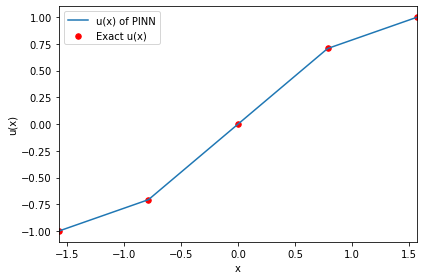

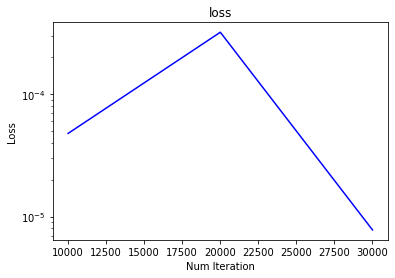

It: 30001, Loss: 4.825e-06  Losses ILRUDrxIC:[1.422223817826307e-06, 3.939433383948199e-07, 2.270689265060355e-06, 7.382039370895654e-07]
It: 30002, Loss: 3.272e-06  Losses ILRUDrxIC:[1.326448568761407e-06, 1.4719498153681343e-07, 1.7780323560145916e-06, 2.0028062763799426e-08]
It: 30003, Loss: 3.453e-06  Losses ILRUDrxIC:[1.129657334786316e-06, 1.2901902834983048e-07, 1.9626745597634e-06, 2.318645044852019e-07]
It: 30004, Loss: 4.801e-06  Losses ILRUDrxIC:[1.18912907964841e-06, 4.461708158487454e-07, 2.0572517769323895e-06, 1.1082427135988837e-06]
It: 30005, Loss: 6.313e-06  Losses ILRUDrxIC:[1.5696828086220194e-06, 3.9638587168155937e-07, 2.755126843112521e-06, 1.5915049971226836e-06]
It: 30006, Loss: 7.133e-06  Losses ILRUDrxIC:[1.5384808875751332e-06, 7.465944236173527e-07, 2.647437440828071e-06, 2.2002204786986113e-06]
It: 30007, Loss: 6.912e-06  Losses ILRUDrxIC:[1.9441044969426002e-06, 4.331691059178411e-07, 2.8394413220667047e-06, 1.695423179626232e-06]
It: 30008, Loss: 5.857e-

It: 30060, Loss: 2.961e-06  Losses ILRUDrxIC:[1.1203770782231004e-06, 1.2660254355978395e-07, 1.7104518974520033e-06, 3.1753948359636297e-09]
It: 30061, Loss: 2.963e-06  Losses ILRUDrxIC:[1.1070205800933763e-06, 1.349341971490503e-07, 1.7063738368960912e-06, 1.503383728618246e-08]
It: 30062, Loss: 2.967e-06  Losses ILRUDrxIC:[1.1214310688956175e-06, 1.2346619371328416e-07, 1.7171770423374255e-06, 4.42654624066563e-09]
It: 30063, Loss: 2.969e-06  Losses ILRUDrxIC:[1.1061350733143627e-06, 1.3933689047007647e-07, 1.7030261005857028e-06, 2.0975043923954217e-08]
It: 30064, Loss: 2.972e-06  Losses ILRUDrxIC:[1.1218165809623315e-06, 1.2151059536336106e-07, 1.7221295820490923e-06, 6.628051885115838e-09]
It: 30065, Loss: 2.974e-06  Losses ILRUDrxIC:[1.1056649782403838e-06, 1.4177717844177096e-07, 1.7010644342008163e-06, 2.5548143156584047e-08]
It: 30066, Loss: 2.975e-06  Losses ILRUDrxIC:[1.1211758419449325e-06, 1.2063867416145513e-07, 1.7251250028493814e-06, 8.350177438387618e-09]
It: 30067, L

It: 30118, Loss: 6.834e-04  Losses ILRUDrxIC:[8.453288319287822e-05, 7.799595914548263e-05, 0.00016821209283079952, 0.0003526507061906159]
It: 30119, Loss: 3.836e-04  Losses ILRUDrxIC:[4.3841704609803855e-05, 4.8523841542191803e-05, 9.441103611607105e-05, 0.0001968091237358749]
It: 30120, Loss: 1.149e-04  Losses ILRUDrxIC:[1.393831098539522e-05, 1.1939839168917388e-05, 2.8762324291164987e-05, 6.027229756000452e-05]
It: 30121, Loss: 4.136e-06  Losses ILRUDrxIC:[1.0918806765403133e-06, 5.769364861407666e-07, 1.8640878352016443e-06, 6.031843895470956e-07]
It: 30122, Loss: 6.897e-05  Losses ILRUDrxIC:[1.0227004167973064e-05, 9.216613761964254e-06, 1.8376631487626582e-05, 3.11459407384973e-05]
It: 30123, Loss: 2.218e-04  Losses ILRUDrxIC:[3.260955782025121e-05, 2.2513910153065808e-05, 5.754499215981923e-05, 0.00010912471043411642]
It: 30124, Loss: 3.394e-04  Losses ILRUDrxIC:[4.492727020988241e-05, 4.2788971768459305e-05, 8.300259651150554e-05, 0.0001686869072727859]
It: 30125, Loss: 3.360e

It: 30176, Loss: 3.125e-06  Losses ILRUDrxIC:[1.1590108215386863e-06, 1.2376834490623878e-07, 1.7929477280631545e-06, 4.915025897389569e-08]
It: 30177, Loss: 3.001e-06  Losses ILRUDrxIC:[1.1257216101512313e-06, 1.2046716335589736e-07, 1.7398156160197686e-06, 1.4788965607692717e-08]
It: 30178, Loss: 3.361e-06  Losses ILRUDrxIC:[1.1181358559042565e-06, 2.3475813293316605e-07, 1.7555162230564747e-06, 2.527476965497044e-07]
It: 30179, Loss: 3.860e-06  Losses ILRUDrxIC:[1.2800378499377985e-06, 1.6300910488098452e-07, 2.015570544244838e-06, 4.013061243313132e-07]
It: 30180, Loss: 4.146e-06  Losses ILRUDrxIC:[1.1841376590382424e-06, 3.5186829450140067e-07, 1.917282133945264e-06, 6.924157105459017e-07]
It: 30181, Loss: 4.061e-06  Losses ILRUDrxIC:[1.30637045003823e-06, 1.7512097372218705e-07, 2.080110334645724e-06, 4.992253934688051e-07]
It: 30182, Loss: 3.691e-06  Losses ILRUDrxIC:[1.1418586609579506e-06, 2.78885295301734e-07, 1.8252806057716953e-06, 4.451504764801939e-07]
It: 30183, Loss: 3.

It: 30235, Loss: 1.064e-04  Losses ILRUDrxIC:[3.0072880690568127e-05, 9.458509339310694e-06, 3.842731530312449e-05, 2.8421160095604137e-05]
It: 30236, Loss: 2.031e-05  Losses ILRUDrxIC:[1.8816739384419634e-06, 1.6214589777518995e-06, 7.590187578898622e-06, 9.219087587553076e-06]
It: 30237, Loss: 3.139e-05  Losses ILRUDrxIC:[1.2183927537989803e-05, 1.980860133699025e-06, 1.3092861081531737e-05, 4.1364382923347875e-06]
It: 30238, Loss: 1.016e-04  Losses ILRUDrxIC:[4.462541255634278e-05, 6.36416098132031e-06, 4.0735969378147274e-05, 9.836428034759592e-06]
It: 30239, Loss: 1.493e-04  Losses ILRUDrxIC:[5.66036396776326e-05, 8.81403775565559e-06, 6.56549382256344e-05, 1.819875069486443e-05]
It: 30240, Loss: 1.275e-04  Losses ILRUDrxIC:[4.57104470115155e-05, 9.607510946807452e-06, 5.2851170039502904e-05, 1.9328472262714058e-05]
It: 30241, Loss: 6.147e-05  Losses ILRUDrxIC:[1.6046589735196903e-05, 4.404551418701885e-06, 2.8032316549797542e-05, 1.2990927643841133e-05]
It: 30242, Loss: 1.283e-05

It: 30294, Loss: 3.459e-06  Losses ILRUDrxIC:[1.165947310255433e-06, 1.3596749681710207e-07, 2.0247475731594022e-06, 1.3199542081565596e-07]
It: 30295, Loss: 3.467e-06  Losses ILRUDrxIC:[1.3399429690252873e-06, 2.1771022318262112e-07, 1.7896292092700605e-06, 1.1932887389320967e-07]
It: 30296, Loss: 3.298e-06  Losses ILRUDrxIC:[1.1527889682838577e-06, 1.2771488400176167e-07, 1.9497567791404435e-06, 6.797812801551117e-08]
It: 30297, Loss: 3.088e-06  Losses ILRUDrxIC:[1.2042735306749819e-06, 1.502998969726832e-07, 1.687781150394585e-06, 4.568614997424447e-08]
It: 30298, Loss: 2.977e-06  Losses ILRUDrxIC:[1.1144666132167913e-06, 1.3231790774170804e-07, 1.7286588445131201e-06, 1.198339205643606e-09]
It: 30299, Loss: 3.009e-06  Losses ILRUDrxIC:[1.1088542350989883e-06, 1.278353067846183e-07, 1.7514088312964304e-06, 2.119115904974933e-08]
It: 30300, Loss: 3.121e-06  Losses ILRUDrxIC:[1.2168170542281587e-06, 1.5939858144520258e-07, 1.7147264088634984e-06, 3.055321684541923e-08]
It: 30301, Loss

It: 30353, Loss: 3.037e-06  Losses ILRUDrxIC:[1.1038561069653952e-06, 1.610033706356262e-07, 1.6927338037930895e-06, 7.922037781327163e-08]
It: 30354, Loss: 3.083e-06  Losses ILRUDrxIC:[1.1349864053045167e-06, 1.1747513894988515e-07, 1.7689468450043933e-06, 6.116692929936107e-08]
It: 30355, Loss: 3.153e-06  Losses ILRUDrxIC:[1.1059480584663106e-06, 1.8778202104385855e-07, 1.7019843880916596e-06, 1.5750930515423534e-07]
It: 30356, Loss: 3.263e-06  Losses ILRUDrxIC:[1.1490790257084882e-06, 1.2468346710647893e-07, 1.8340929273108486e-06, 1.549297792280413e-07]
It: 30357, Loss: 3.433e-06  Losses ILRUDrxIC:[1.1140350579808e-06, 2.3976727447916346e-07, 1.743012717270176e-06, 3.359014328907506e-07]
It: 30358, Loss: 3.698e-06  Losses ILRUDrxIC:[1.1843770835184841e-06, 1.5452413038019586e-07, 1.9722831439139554e-06, 3.8665484680677764e-07]
It: 30359, Loss: 4.114e-06  Losses ILRUDrxIC:[1.142016571975546e-06, 3.490675624107098e-07, 1.8706268747337162e-06, 7.527193019996048e-07]
It: 30360, Loss: 4

It: 30412, Loss: 1.912e-05  Losses ILRUDrxIC:[1.5237621937558288e-06, 1.8463208562025102e-06, 6.400463007594226e-06, 9.351064363727346e-06]
It: 30413, Loss: 5.846e-06  Losses ILRUDrxIC:[1.2272312233108096e-06, 6.744986080775561e-07, 2.167977299905033e-06, 1.7760655737220077e-06]
It: 30414, Loss: 4.024e-06  Losses ILRUDrxIC:[1.1492990097394795e-06, 3.962039727412048e-07, 1.882980882328411e-06, 5.953151003268431e-07]
It: 30415, Loss: 1.211e-05  Losses ILRUDrxIC:[1.5144283906920464e-06, 1.0922130968538113e-06, 4.340896339272149e-06, 5.1665024329849984e-06]
It: 30416, Loss: 1.890e-05  Losses ILRUDrxIC:[1.5331460190282087e-06, 2.636312274262309e-06, 4.908645223622443e-06, 9.826720088312868e-06]
It: 30417, Loss: 1.680e-05  Losses ILRUDrxIC:[1.4664057061963831e-06, 1.474471673645894e-06, 5.858892109245062e-06, 8.004744813661091e-06]
It: 30418, Loss: 8.852e-06  Losses ILRUDrxIC:[1.3361324135985342e-06, 1.055180746334372e-06, 2.8029012355546e-06, 3.6578221624949947e-06]
It: 30419, Loss: 3.481e-

It: 30471, Loss: 3.029e-06  Losses ILRUDrxIC:[1.1314025414321804e-06, 1.530634534674391e-07, 1.6920282632781891e-06, 5.235487066101996e-08]
It: 30472, Loss: 3.036e-06  Losses ILRUDrxIC:[1.1492145404190524e-06, 1.1767053109679182e-07, 1.744424025673652e-06, 2.4359321670885947e-08]
It: 30473, Loss: 3.020e-06  Losses ILRUDrxIC:[1.131332510340144e-06, 1.528837714204201e-07, 1.6909887108340627e-06, 4.502400940964435e-08]
It: 30474, Loss: 2.995e-06  Losses ILRUDrxIC:[1.14342549295543e-06, 1.202900676844365e-07, 1.7220653489857796e-06, 9.318599225593971e-09]
It: 30475, Loss: 2.977e-06  Losses ILRUDrxIC:[1.1334279861330288e-06, 1.3411013810582517e-07, 1.6983321984298527e-06, 1.1243388442494506e-08]
It: 30476, Loss: 2.975e-06  Losses ILRUDrxIC:[1.1364497822796693e-06, 1.328195793348641e-07, 1.6969846683423384e-06, 8.991607458597173e-09]
It: 30477, Loss: 2.986e-06  Losses ILRUDrxIC:[1.138595507654827e-06, 1.2131046389640687e-07, 1.7186529248647275e-06, 7.334073348630454e-09]
It: 30478, Loss: 2.9

It: 30530, Loss: 2.950e-06  Losses ILRUDrxIC:[1.1157001154060708e-06, 1.2698768614427536e-07, 1.69981331055169e-06, 7.804961121848919e-09]
It: 30531, Loss: 2.950e-06  Losses ILRUDrxIC:[1.1260899555054493e-06, 1.2685831052294816e-07, 1.6930696347117191e-06, 4.208204895661538e-09]
It: 30532, Loss: 2.950e-06  Losses ILRUDrxIC:[1.1140167543999269e-06, 1.2650248493173422e-07, 1.7016993751894915e-06, 8.037073229161251e-09]
It: 30533, Loss: 2.950e-06  Losses ILRUDrxIC:[1.1279672662567464e-06, 1.2745208266551344e-07, 1.6907199551496888e-06, 4.2885406337234144e-09]
It: 30534, Loss: 2.951e-06  Losses ILRUDrxIC:[1.112127506530669e-06, 1.2581760699958977e-07, 1.7052751672963495e-06, 7.798096390843057e-09]
It: 30535, Loss: 2.952e-06  Losses ILRUDrxIC:[1.1309971341688652e-06, 1.2831814899527672e-07, 1.6880030671018176e-06, 4.686007581966578e-09]
It: 30536, Loss: 2.954e-06  Losses ILRUDrxIC:[1.1100355550297536e-06, 1.2500710511176294e-07, 1.7104654261856922e-06, 8.048142596805974e-09]
It: 30537, Loss

It: 30589, Loss: 5.189e-05  Losses ILRUDrxIC:[2.2037622329662554e-05, 3.621247060436872e-06, 2.094376577588264e-05, 5.2825644161202945e-06]
It: 30590, Loss: 3.644e-05  Losses ILRUDrxIC:[1.401151985191973e-05, 1.8991281649505254e-06, 1.677393629506696e-05, 3.7513500501518138e-06]
It: 30591, Loss: 1.239e-05  Losses ILRUDrxIC:[5.966052412986755e-06, 7.708658813498914e-07, 4.9070217755797785e-06, 7.482940418412909e-07]
It: 30592, Loss: 3.150e-06  Losses ILRUDrxIC:[1.1100987649115268e-06, 2.3141178928653972e-07, 1.707125761640782e-06, 1.0140429651528393e-07]
It: 30593, Loss: 1.308e-05  Losses ILRUDrxIC:[4.259052275301656e-06, 7.482424280169653e-07, 6.700702215312049e-06, 1.3743056115345098e-06]
It: 30594, Loss: 2.695e-05  Losses ILRUDrxIC:[1.1524834917508997e-05, 1.7853241160992184e-06, 1.0911948265857063e-05, 2.727734226937173e-06]
It: 30595, Loss: 2.880e-05  Losses ILRUDrxIC:[1.1302714483463205e-05, 1.5426645632032887e-06, 1.3096233487885911e-05, 2.860654603864532e-06]
It: 30596, Loss: 1.

It: 30648, Loss: 3.031e-06  Losses ILRUDrxIC:[1.1242582331760786e-06, 1.15551827661875e-07, 1.7522190773888724e-06, 3.888774102733805e-08]
It: 30649, Loss: 3.078e-06  Losses ILRUDrxIC:[1.132096940636984e-06, 1.7754526027147222e-07, 1.6671270941515104e-06, 1.0095558167222407e-07]
It: 30650, Loss: 3.141e-06  Losses ILRUDrxIC:[1.1061514442189946e-06, 1.1475698613594432e-07, 1.8329245676795836e-06, 8.748530433422275e-08]
It: 30651, Loss: 3.191e-06  Losses ILRUDrxIC:[1.1591256452447851e-06, 1.9736737044695474e-07, 1.6768441355452524e-06, 1.5720216595127567e-07]
It: 30652, Loss: 3.218e-06  Losses ILRUDrxIC:[1.1078182069468312e-06, 1.1652578280063608e-07, 1.8628591078595491e-06, 1.3103050378049375e-07]
It: 30653, Loss: 3.242e-06  Losses ILRUDrxIC:[1.1317350754325162e-06, 2.1186082221902325e-07, 1.681537014519563e-06, 2.1723207055401872e-07]
It: 30654, Loss: 3.294e-06  Losses ILRUDrxIC:[1.1309412002447061e-06, 1.2256128911758424e-07, 1.8591109665067052e-06, 1.8141554392059334e-07]
It: 30655, L

It: 30707, Loss: 3.480e-05  Losses ILRUDrxIC:[4.7509465730399825e-06, 4.468301085580606e-06, 8.742613317735959e-06, 1.68409533216618e-05]
It: 30708, Loss: 2.449e-05  Losses ILRUDrxIC:[5.300867542246124e-06, 2.205438931923709e-06, 7.526469289587112e-06, 9.45657302509062e-06]
It: 30709, Loss: 1.174e-05  Losses ILRUDrxIC:[3.0548610538971843e-06, 1.220360445586266e-06, 4.147033905610442e-06, 3.319788447697647e-06]
It: 30710, Loss: 4.699e-06  Losses ILRUDrxIC:[2.091778924295795e-06, 2.3989653641365294e-07, 2.2419940250983927e-06, 1.2527901560588361e-07]
It: 30711, Loss: 6.114e-06  Losses ILRUDrxIC:[1.1643890047707828e-06, 3.6146485626886715e-07, 2.8252513857296435e-06, 1.7628851765039144e-06]
It: 30712, Loss: 1.257e-05  Losses ILRUDrxIC:[1.5280477327905828e-06, 1.7728370949043892e-06, 3.5628397654363653e-06, 5.710306140827015e-06]
It: 30713, Loss: 1.807e-05  Losses ILRUDrxIC:[2.82323617284419e-06, 1.638374783397012e-06, 5.62991817787406e-06, 7.981774615473114e-06]
It: 30714, Loss: 1.857e-05

It: 30766, Loss: 3.009e-06  Losses ILRUDrxIC:[1.1193677664778079e-06, 1.4442602491726575e-07, 1.706029252090957e-06, 3.964056105587588e-08]
It: 30767, Loss: 2.977e-06  Losses ILRUDrxIC:[1.1508636816870421e-06, 1.2246569269791507e-07, 1.6995269334074692e-06, 4.511800710815805e-09]
It: 30768, Loss: 2.958e-06  Losses ILRUDrxIC:[1.1218511417609989e-06, 1.3220024186466617e-07, 1.6921351289056474e-06, 1.1525301601977844e-08]
It: 30769, Loss: 2.953e-06  Losses ILRUDrxIC:[1.1258828180871205e-06, 1.2790836478870915e-07, 1.691245074653125e-06, 7.841437721367583e-09]
It: 30770, Loss: 2.961e-06  Losses ILRUDrxIC:[1.1392569376766915e-06, 1.2504402491231303e-07, 1.6935665598794003e-06, 2.660002884624646e-09]
It: 30771, Loss: 2.974e-06  Losses ILRUDrxIC:[1.118071509154106e-06, 1.3638475593324983e-07, 1.6969634089036845e-06, 2.2694747414675476e-08]
It: 30772, Loss: 2.987e-06  Losses ILRUDrxIC:[1.1566830835363362e-06, 1.2206794508529129e-07, 1.7021893654600717e-06, 6.423373832831203e-09]
It: 30773, Los

It: 30825, Loss: 2.930e-06  Losses ILRUDrxIC:[1.1100804613306536e-06, 1.2671108606809867e-07, 1.685046640886867e-06, 7.87802889590239e-09]
It: 30826, Loss: 2.930e-06  Losses ILRUDrxIC:[1.1163482440679218e-06, 1.2387265257984836e-07, 1.685453753452748e-06, 3.886829524901714e-09]
It: 30827, Loss: 2.929e-06  Losses ILRUDrxIC:[1.108903347812884e-06, 1.2692355255694565e-07, 1.6853060742505477e-06, 8.345484303617923e-09]
It: 30828, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1169258868903853e-06, 1.2351672751265141e-07, 1.6851327018230222e-06, 3.689660132977224e-09]
It: 30829, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1077194130848511e-06, 1.27318827480849e-07, 1.6854048681125278e-06, 8.883588975550083e-09]
It: 30830, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1175653753525694e-06, 1.2300661467179452e-07, 1.6852404769451823e-06, 3.5525697938965095e-09]
It: 30831, Loss: 2.930e-06  Losses ILRUDrxIC:[1.1064904583690804e-06, 1.2792800418992556e-07, 1.6856386082508834e-06, 9.696160319094815e-09]
It: 30832, Loss: 2

It: 30884, Loss: 1.450e-04  Losses ILRUDrxIC:[3.770849070861004e-05, 1.3647005289385561e-05, 4.1838298784568906e-05, 5.1828621508320794e-05]
It: 30885, Loss: 7.284e-05  Losses ILRUDrxIC:[2.2312944565783255e-05, 5.17809166922234e-06, 2.2430485842050985e-05, 2.2921823983779177e-05]
It: 30886, Loss: 1.082e-05  Losses ILRUDrxIC:[3.376956556166988e-06, 7.612016474922711e-07, 4.5949432205816265e-06, 2.0869533727818634e-06]
It: 30887, Loss: 1.507e-05  Losses ILRUDrxIC:[2.3753534605930327e-06, 2.1324560748325894e-06, 4.167100087215658e-06, 6.392072009475669e-06]
It: 30888, Loss: 6.260e-05  Losses ILRUDrxIC:[1.407417130394606e-05, 5.240141945250798e-06, 1.770299786585383e-05, 2.5585519324522465e-05]
It: 30889, Loss: 9.022e-05  Losses ILRUDrxIC:[1.810683352232445e-05, 9.41538473853143e-06, 2.46784165938152e-05, 3.80161072826013e-05]
It: 30890, Loss: 6.745e-05  Losses ILRUDrxIC:[1.5799912944203243e-05, 5.395812877395656e-06, 1.9561746739782393e-05, 2.668989145604428e-05]
It: 30891, Loss: 2.294e-0

It: 30943, Loss: 3.298e-06  Losses ILRUDrxIC:[1.3025432963331696e-06, 1.296049703114477e-07, 1.7929155546880793e-06, 7.279469116383552e-08]
It: 30944, Loss: 3.138e-06  Losses ILRUDrxIC:[1.1345620123393019e-06, 1.655349990414834e-07, 1.7514548744657077e-06, 8.637351811557892e-08]
It: 30945, Loss: 2.997e-06  Losses ILRUDrxIC:[1.1674409279294196e-06, 1.2540346006062464e-07, 1.6997151988107362e-06, 4.642949136268726e-09]
It: 30946, Loss: 2.968e-06  Losses ILRUDrxIC:[1.1300201094854856e-06, 1.2433640961262427e-07, 1.7088832464651205e-06, 4.715212220673948e-09]
It: 30947, Loss: 3.040e-06  Losses ILRUDrxIC:[1.1176764473930234e-06, 1.560526641242177e-07, 1.7030870367307216e-06, 6.286672515898317e-08]
It: 30948, Loss: 3.128e-06  Losses ILRUDrxIC:[1.2063858321198495e-06, 1.206194752967349e-07, 1.7538910697112442e-06, 4.7506901523775014e-08]
It: 30949, Loss: 3.155e-06  Losses ILRUDrxIC:[1.130114242187119e-06, 1.751392488813508e-07, 1.7334677977487445e-06, 1.1583242098822666e-07]
It: 30950, Loss: 

It: 31002, Loss: 8.152e-04  Losses ILRUDrxIC:[0.00017050492169801146, 7.914956950116903e-05, 0.0002839478838723153, 0.00028161087539047003]
It: 31003, Loss: 8.126e-04  Losses ILRUDrxIC:[0.0001515405165264383, 7.39054084988311e-05, 0.0002932404458988458, 0.00029390573035925627]
It: 31004, Loss: 6.163e-04  Losses ILRUDrxIC:[0.00010375853889854625, 6.289327575359493e-05, 0.00021029185154475272, 0.00023935106582939625]
It: 31005, Loss: 3.094e-04  Losses ILRUDrxIC:[3.523384657455608e-05, 2.937337376351934e-05, 0.00010626546281855553, 0.0001385030336678028]
It: 31006, Loss: 7.312e-05  Losses ILRUDrxIC:[3.205053189958562e-06, 9.240325198334176e-06, 2.1090116206323728e-05, 3.9586979255545884e-05]
It: 31007, Loss: 2.922e-05  Losses ILRUDrxIC:[1.2959391824551858e-05, 1.6750651639085845e-06, 1.0952551747323014e-05, 3.63171875505941e-06]
It: 31008, Loss: 1.475e-04  Losses ILRUDrxIC:[4.149316009716131e-05, 1.1595764590310864e-05, 6.2339793657884e-05, 3.2087289582705125e-05]
It: 31009, Loss: 2.896e-

It: 31061, Loss: 4.004e-06  Losses ILRUDrxIC:[1.2692934205915662e-06, 1.3846469926193095e-07, 2.266147703267052e-06, 3.303871665139013e-07]
It: 31062, Loss: 4.565e-06  Losses ILRUDrxIC:[1.6075483699751203e-06, 3.6097145539315534e-07, 2.018443865381414e-06, 5.782661673947587e-07]
It: 31063, Loss: 4.458e-06  Losses ILRUDrxIC:[1.3118776678311406e-06, 1.9888037172677286e-07, 2.4255500647996087e-06, 5.217693797021639e-07]
It: 31064, Loss: 3.814e-06  Losses ILRUDrxIC:[1.331398948423157e-06, 3.1888120588519087e-07, 1.7952987718672375e-06, 3.6882977383356774e-07]
It: 31065, Loss: 3.197e-06  Losses ILRUDrxIC:[1.128064582189836e-06, 1.1762325158315434e-07, 1.8330051716475282e-06, 1.1822637446812223e-07]
It: 31066, Loss: 3.039e-06  Losses ILRUDrxIC:[1.134802460001083e-06, 1.410959242775789e-07, 1.7127659930338268e-06, 4.990638657886848e-08]
It: 31067, Loss: 3.298e-06  Losses ILRUDrxIC:[1.3374595937420963e-06, 1.8580391270006658e-07, 1.7276593098358717e-06, 4.6711704726476455e-08]
It: 31068, Loss:

It: 31120, Loss: 2.943e-06  Losses ILRUDrxIC:[1.1375178701200639e-06, 1.2548673566925572e-07, 1.6766291537351208e-06, 3.2592837317935164e-09]
It: 31121, Loss: 2.941e-06  Losses ILRUDrxIC:[1.1227782579226186e-06, 1.2690692585692886e-07, 1.6809793805805384e-06, 9.892698216162898e-09]
It: 31122, Loss: 2.939e-06  Losses ILRUDrxIC:[1.1297252058284357e-06, 1.2526153625458392e-07, 1.6807091469672741e-06, 3.0660449734654094e-09]
It: 31123, Loss: 2.938e-06  Losses ILRUDrxIC:[1.127308678405825e-06, 1.2744794730679132e-07, 1.674356440162228e-06, 8.788499705758568e-09]
It: 31124, Loss: 2.938e-06  Losses ILRUDrxIC:[1.124047798839456e-06, 1.2400161608638882e-07, 1.6852662838573451e-06, 4.534279618439996e-09]
It: 31125, Loss: 2.938e-06  Losses ILRUDrxIC:[1.131146632360469e-06, 1.2864667553458276e-07, 1.671426275606791e-06, 6.865889634610767e-09]
It: 31126, Loss: 2.938e-06  Losses ILRUDrxIC:[1.1215862514291075e-06, 1.2329959986345784e-07, 1.686752398200042e-06, 6.28411722658484e-09]
It: 31127, Loss: 2

It: 31179, Loss: 4.738e-04  Losses ILRUDrxIC:[3.97998264816124e-05, 5.418438377091661e-05, 0.00012279981456231326, 0.00025705527514219284]
It: 31180, Loss: 6.624e-04  Losses ILRUDrxIC:[5.4836160416016355e-05, 8.05696181487292e-05, 0.00016570492880418897, 0.00036128086503595114]
It: 31181, Loss: 8.539e-04  Losses ILRUDrxIC:[7.796340651111677e-05, 0.00010004382784245536, 0.00021258594642858952, 0.0004632678464986384]
It: 31182, Loss: 9.931e-04  Losses ILRUDrxIC:[9.218549530487508e-05, 0.00012241475633345544, 0.00024189864052459598, 0.0005365997785702348]
It: 31183, Loss: 9.759e-04  Losses ILRUDrxIC:[0.00010203780402662233, 0.00011569941125344485, 0.00023367728863377124, 0.0005245135980658233]
It: 31184, Loss: 7.651e-04  Losses ILRUDrxIC:[8.293486462207511e-05, 9.633965964894742e-05, 0.00018519347941037267, 0.00040061352774500847]
It: 31185, Loss: 4.165e-04  Losses ILRUDrxIC:[5.3732703236164525e-05, 4.79348746011965e-05, 0.00010073408338939771, 0.00021406487212516367]
It: 31186, Loss: 1.1

It: 31238, Loss: 3.317e-06  Losses ILRUDrxIC:[1.139869709732011e-06, 2.4736954173931736e-07, 1.7071729416784365e-06, 2.2243614239414455e-07]
It: 31239, Loss: 2.998e-06  Losses ILRUDrxIC:[1.1403860753489425e-06, 1.485121714495108e-07, 1.67105508808163e-06, 3.8448256134415715e-08]
It: 31240, Loss: 3.649e-06  Losses ILRUDrxIC:[1.2103082553949207e-06, 1.4628581368469895e-07, 1.9409965261729667e-06, 3.51113669694314e-07]
It: 31241, Loss: 4.535e-06  Losses ILRUDrxIC:[1.1924088312298409e-06, 4.721978541510907e-07, 1.9027112330149976e-06, 9.672558007878251e-07]
It: 31242, Loss: 4.909e-06  Losses ILRUDrxIC:[1.3664766811416484e-06, 2.62943927964443e-07, 2.266908040837734e-06, 1.0125893368240213e-06]
It: 31243, Loss: 4.541e-06  Losses ILRUDrxIC:[1.2006889846816193e-06, 4.481942710299336e-07, 1.918045427373727e-06, 9.744361477714847e-07]
It: 31244, Loss: 3.766e-06  Losses ILRUDrxIC:[1.2581917872012127e-06, 1.520718058145576e-07, 1.97673830371059e-06, 3.794668259615719e-07]
It: 31245, Loss: 3.135e-

It: 31296, Loss: 2.935e-06  Losses ILRUDrxIC:[1.1265738066867925e-06, 1.2566631824029173e-07, 1.6764278143455158e-06, 6.037291111482546e-09]
It: 31297, Loss: 2.935e-06  Losses ILRUDrxIC:[1.1297668152110418e-06, 1.2114831804410642e-07, 1.6794691646282445e-06, 4.887219517968333e-09]
It: 31298, Loss: 2.937e-06  Losses ILRUDrxIC:[1.125102585319837e-06, 1.2937475446506141e-07, 1.6713340755813988e-06, 1.0921890947201973e-08]
It: 31299, Loss: 2.938e-06  Losses ILRUDrxIC:[1.1299799780317699e-06, 1.1945617472974845e-07, 1.6844824131112546e-06, 4.328761349370325e-09]
It: 31300, Loss: 2.939e-06  Losses ILRUDrxIC:[1.1244756024098024e-06, 1.3021967504300846e-07, 1.669693119765725e-06, 1.4242335311109855e-08]
It: 31301, Loss: 2.938e-06  Losses ILRUDrxIC:[1.1292950148344971e-06, 1.196661827407297e-07, 1.6851236068760045e-06, 3.933358971863754e-09]
It: 31302, Loss: 2.936e-06  Losses ILRUDrxIC:[1.1240888397878734e-06, 1.290011937271629e-07, 1.6698602394171758e-06, 1.3323299796752508e-08]
It: 31303, Los

It: 31355, Loss: 4.209e-05  Losses ILRUDrxIC:[1.590928695804905e-05, 3.5458645015751245e-06, 1.7079946701414883e-05, 5.554179097089218e-06]
It: 31356, Loss: 1.600e-04  Losses ILRUDrxIC:[5.5072545364964753e-05, 1.046573743224144e-05, 7.103072130121291e-05, 2.3477523427573033e-05]
It: 31357, Loss: 2.119e-04  Losses ILRUDrxIC:[7.982399256434292e-05, 1.5939709555823356e-05, 8.624285692349076e-05, 2.992834197357297e-05]
It: 31358, Loss: 1.421e-04  Losses ILRUDrxIC:[5.130334830028005e-05, 9.162892638414633e-06, 6.180199125083163e-05, 1.9855157006531954e-05]
It: 31359, Loss: 3.536e-05  Losses ILRUDrxIC:[1.4421621926885564e-05, 2.5979229576478247e-06, 1.3830552234139759e-05, 4.510125563683687e-06]
It: 31360, Loss: 5.769e-06  Losses ILRUDrxIC:[2.1710418423026567e-06, 5.313060000844416e-07, 2.7187018076801905e-06, 3.478728842765122e-07]
It: 31361, Loss: 6.221e-05  Losses ILRUDrxIC:[2.1907277186983265e-05, 3.9131336961872876e-06, 2.8048410968040116e-05, 8.345455171365757e-06]
It: 31362, Loss: 1.1

It: 31414, Loss: 2.998e-06  Losses ILRUDrxIC:[1.1135859949717997e-06, 1.2649884695292712e-07, 1.7357743899992784e-06, 2.2328675797211872e-08]
It: 31415, Loss: 2.970e-06  Losses ILRUDrxIC:[1.1148860039611463e-06, 1.2941305271851888e-07, 1.7168863450933713e-06, 8.917531602037343e-09]
It: 31416, Loss: 3.167e-06  Losses ILRUDrxIC:[1.270699158339994e-06, 1.60986914465866e-07, 1.6975923244899604e-06, 3.7980196765374785e-08]
It: 31417, Loss: 3.338e-06  Losses ILRUDrxIC:[1.1824228067780496e-06, 1.3739285975589155e-07, 1.94695917343779e-06, 7.13900831783576e-08]
It: 31418, Loss: 3.307e-06  Losses ILRUDrxIC:[1.3270879435367533e-06, 1.7994364043261157e-07, 1.744293740557623e-06, 5.590909779584763e-08]
It: 31419, Loss: 3.122e-06  Losses ILRUDrxIC:[1.1352927913321764e-06, 1.2723624820409896e-07, 1.818403575271077e-06, 4.1488632973596395e-08]
It: 31420, Loss: 2.965e-06  Losses ILRUDrxIC:[1.1548578413567157e-06, 1.3846776880654943e-07, 1.6654795444992487e-06, 6.124225127024374e-09]
It: 31421, Loss: 2

It: 31473, Loss: 4.029e-05  Losses ILRUDrxIC:[1.826632455959043e-06, 3.753380497073522e-06, 1.1549899681995157e-05, 2.3161235731095076e-05]
It: 31474, Loss: 2.918e-04  Losses ILRUDrxIC:[1.5009373782959301e-05, 4.2052368371514603e-05, 6.840995774837211e-05, 0.00016629337915219367]
It: 31475, Loss: 5.357e-04  Losses ILRUDrxIC:[3.702197864186019e-05, 6.267910794122145e-05, 0.0001321433810517192, 0.0003038384602405131]
It: 31476, Loss: 5.378e-04  Losses ILRUDrxIC:[4.248150798957795e-05, 7.181378896348178e-05, 0.00012579052418004721, 0.0002976773539558053]
It: 31477, Loss: 2.999e-04  Losses ILRUDrxIC:[3.453164754319005e-05, 3.205309258191846e-05, 7.573713810415938e-05, 0.00015754756168462336]
It: 31478, Loss: 6.026e-05  Losses ILRUDrxIC:[1.151622836914612e-05, 6.81870596963563e-06, 1.607593549124431e-05, 2.5850156816886738e-05]
It: 31479, Loss: 2.333e-05  Losses ILRUDrxIC:[2.155058155040024e-06, 3.55453698830388e-06, 6.299958840827458e-06, 1.1315935807942878e-05]
It: 31480, Loss: 1.641e-04 

It: 31532, Loss: 3.924e-06  Losses ILRUDrxIC:[1.1730620599337271e-06, 3.4123041814382304e-07, 1.7863951597973937e-06, 6.237330580916023e-07]
It: 31533, Loss: 3.736e-06  Losses ILRUDrxIC:[1.4291351817519171e-06, 1.5501224481795361e-07, 1.9176090972905513e-06, 2.3460722786694532e-07]
It: 31534, Loss: 3.582e-06  Losses ILRUDrxIC:[1.3051445648670779e-06, 1.8069539464704576e-07, 1.9781728042289615e-06, 1.1796105070516205e-07]
It: 31535, Loss: 3.534e-06  Losses ILRUDrxIC:[1.4856443613098236e-06, 1.9590648037137726e-07, 1.781986156856874e-06, 7.013543523726185e-08]
It: 31536, Loss: 3.539e-06  Losses ILRUDrxIC:[1.1922342082471005e-06, 1.2328206366873928e-07, 2.0356671939225635e-06, 1.8760161424324906e-07]
It: 31537, Loss: 3.509e-06  Losses ILRUDrxIC:[1.2073887774022296e-06, 2.694179102036287e-07, 1.693058266027947e-06, 3.389901053196809e-07]
It: 31538, Loss: 3.426e-06  Losses ILRUDrxIC:[1.1977620033576386e-06, 1.2805541871330206e-07, 1.8732479247773881e-06, 2.2653097175862058e-07]
It: 31539, L

It: 31591, Loss: 2.953e-06  Losses ILRUDrxIC:[1.1552833711903077e-06, 1.2907173640996916e-07, 1.6618740801277454e-06, 7.051269346192157e-09]
It: 31592, Loss: 2.951e-06  Losses ILRUDrxIC:[1.1403404869270162e-06, 1.2357610046365153e-07, 1.680534865045047e-06, 6.642633110232055e-09]
It: 31593, Loss: 2.949e-06  Losses ILRUDrxIC:[1.149056629401457e-06, 1.2717498520942172e-07, 1.6666194824210834e-06, 5.991942497729497e-09]
It: 31594, Loss: 2.948e-06  Losses ILRUDrxIC:[1.1442949698903249e-06, 1.2538315274923661e-07, 1.671454469942546e-06, 6.621250658866984e-09]
It: 31595, Loss: 2.947e-06  Losses ILRUDrxIC:[1.1427555364207365e-06, 1.248820922228333e-07, 1.674054601608077e-06, 5.767634814191069e-09]
It: 31596, Loss: 2.948e-06  Losses ILRUDrxIC:[1.1488115205793292e-06, 1.2724144937692472e-07, 1.665116769800079e-06, 6.675732855399019e-09]
It: 31597, Loss: 2.948e-06  Losses ILRUDrxIC:[1.139384153248102e-06, 1.2352927569736494e-07, 1.6789913388493005e-06, 6.422771647862646e-09]
It: 31598, Loss: 2.9

It: 31650, Loss: 2.923e-06  Losses ILRUDrxIC:[1.1299580364720896e-06, 1.2390086112645804e-07, 1.6634337498544483e-06, 6.151560150158275e-09]
It: 31651, Loss: 2.923e-06  Losses ILRUDrxIC:[1.1281654224148951e-06, 1.2244798597293993e-07, 1.6671662024236866e-06, 5.319099827261198e-09]
It: 31652, Loss: 2.923e-06  Losses ILRUDrxIC:[1.1292204362689517e-06, 1.2385093839384353e-07, 1.6634917301416863e-06, 6.226062332359561e-09]
It: 31653, Loss: 2.922e-06  Losses ILRUDrxIC:[1.127803216149914e-06, 1.225496646384272e-07, 1.6664598661009222e-06, 5.369211297789889e-09]
It: 31654, Loss: 2.922e-06  Losses ILRUDrxIC:[1.1284348602202954e-06, 1.237999640579801e-07, 1.6635370911899372e-06, 6.101821714565858e-09]
It: 31655, Loss: 2.921e-06  Losses ILRUDrxIC:[1.127544351220422e-06, 1.2226004741933139e-07, 1.6662216921758954e-06, 5.404823699706185e-09]
It: 31656, Loss: 2.921e-06  Losses ILRUDrxIC:[1.1274462394794682e-06, 1.237596620740078e-07, 1.6636387272228603e-06, 6.162923060770709e-09]
It: 31657, Loss: 2

It: 31709, Loss: 1.383e-04  Losses ILRUDrxIC:[5.78523104195483e-05, 8.964577318693046e-06, 4.879328844253905e-05, 2.2663183699478395e-05]
It: 31710, Loss: 2.187e-04  Losses ILRUDrxIC:[8.700827311258763e-05, 1.4935470971977338e-05, 7.879736222093925e-05, 3.795883458224125e-05]
It: 31711, Loss: 3.384e-04  Losses ILRUDrxIC:[0.0001397933519911021, 2.237235639768187e-05, 0.00011834420001832768, 5.7936093071475625e-05]
It: 31712, Loss: 5.051e-04  Losses ILRUDrxIC:[0.00019988756685052067, 3.4764605516102165e-05, 0.00017932438640855253, 9.1170659288764e-05]
It: 31713, Loss: 7.039e-04  Losses ILRUDrxIC:[0.0002847574942279607, 4.768478174810298e-05, 0.00024205751833505929, 0.00012943972251378]
It: 31714, Loss: 8.875e-04  Losses ILRUDrxIC:[0.00034015209530480206, 6.283861875999719e-05, 0.00030707052792422473, 0.0001774463162291795]
It: 31715, Loss: 9.553e-04  Losses ILRUDrxIC:[0.0003644676471594721, 6.805972225265577e-05, 0.00031384974136017263, 0.0002089651534333825]
It: 31716, Loss: 8.328e-04  

It: 31768, Loss: 3.918e-06  Losses ILRUDrxIC:[1.27790463011479e-06, 2.595458568066533e-07, 1.938197783601936e-06, 4.4272340460338455e-07]
It: 31769, Loss: 5.354e-06  Losses ILRUDrxIC:[2.4221853891503997e-06, 2.5004680992424255e-07, 2.396500121903955e-06, 2.8537539265016676e-07]
It: 31770, Loss: 5.904e-06  Losses ILRUDrxIC:[2.1431237655633595e-06, 3.2876661748559854e-07, 2.986663048432092e-06, 4.4558595391208655e-07]
It: 31771, Loss: 4.866e-06  Losses ILRUDrxIC:[2.176547468479839e-06, 2.528567790704983e-07, 2.2864669517730363e-06, 1.5052636115342466e-07]
It: 31772, Loss: 3.417e-06  Losses ILRUDrxIC:[1.1970141713391058e-06, 1.6064204544363747e-07, 1.9871915810654173e-06, 7.225943221556008e-08]
It: 31773, Loss: 3.005e-06  Losses ILRUDrxIC:[1.1074688472945127e-06, 1.5548856424629776e-07, 1.6868775674083736e-06, 5.4817647310301254e-08]
It: 31774, Loss: 3.770e-06  Losses ILRUDrxIC:[1.594116383785149e-06, 1.7664693530150544e-07, 1.9097578842774965e-06, 8.977578147550958e-08]
It: 31775, Loss: 

It: 31826, Loss: 2.939e-06  Losses ILRUDrxIC:[1.1407748843339505e-06, 1.368935329537635e-07, 1.6429211200374993e-06, 1.8128085699231633e-08]
It: 31827, Loss: 2.940e-06  Losses ILRUDrxIC:[1.1257359346927842e-06, 1.1530600829701143e-07, 1.6895795624805032e-06, 9.739639317274396e-09]
It: 31828, Loss: 2.948e-06  Losses ILRUDrxIC:[1.1286219887551852e-06, 1.411644490190156e-07, 1.6439757928310428e-06, 3.4457098507800765e-08]
It: 31829, Loss: 2.965e-06  Losses ILRUDrxIC:[1.1368432524250238e-06, 1.1337020566770661e-07, 1.6965941540547647e-06, 1.7844836719405066e-08]
It: 31830, Loss: 2.991e-06  Losses ILRUDrxIC:[1.123775405176275e-06, 1.5227888638946752e-07, 1.6478743418701924e-06, 6.66211903421754e-08]
It: 31831, Loss: 3.029e-06  Losses ILRUDrxIC:[1.1447644965301151e-06, 1.1184270931607898e-07, 1.7238044165424071e-06, 4.9057177875511115e-08]
It: 31832, Loss: 3.089e-06  Losses ILRUDrxIC:[1.1253813454459305e-06, 1.7716911315801553e-07, 1.6508123508174322e-06, 1.3561626133196114e-07]
It: 31833, L

It: 31885, Loss: 2.137e-05  Losses ILRUDrxIC:[1.8055069403999369e-06, 2.0553593458316755e-06, 7.608271062053973e-06, 9.899985343508888e-06]
It: 31886, Loss: 1.156e-05  Losses ILRUDrxIC:[1.8573507531982614e-06, 1.6341701893907157e-06, 3.403357595743728e-06, 4.665210326493252e-06]
It: 31887, Loss: 1.290e-05  Losses ILRUDrxIC:[5.952613264526008e-06, 7.080764135025674e-07, 5.1518068175937515e-06, 1.085792632693483e-06]
It: 31888, Loss: 2.074e-05  Losses ILRUDrxIC:[7.282540536834858e-06, 1.0969190498144599e-06, 9.87004841590533e-06, 2.495071612429456e-06]
It: 31889, Loss: 2.258e-05  Losses ILRUDrxIC:[6.995443982305005e-06, 2.1689600089302985e-06, 8.418212928518187e-06, 4.994175469619222e-06]
It: 31890, Loss: 1.487e-05  Losses ILRUDrxIC:[2.701934363358305e-06, 1.150042862718692e-06, 6.454984031734057e-06, 4.561019977700198e-06]
It: 31891, Loss: 6.589e-06  Losses ILRUDrxIC:[1.2504337973950896e-06, 8.008607323972683e-07, 2.263496071464033e-06, 2.27396481022879e-06]
It: 31892, Loss: 6.677e-06  

It: 31944, Loss: 3.042e-06  Losses ILRUDrxIC:[1.163583988272876e-06, 1.1302765301479667e-07, 1.7273280263907509e-06, 3.791310376755064e-08]
It: 31945, Loss: 3.032e-06  Losses ILRUDrxIC:[1.161415866590687e-06, 1.5737015246486408e-07, 1.644883923290763e-06, 6.87867043325241e-08]
It: 31946, Loss: 2.996e-06  Losses ILRUDrxIC:[1.1660091558951535e-06, 1.1474381267362332e-07, 1.6988346942525823e-06, 1.633354607122328e-08]
It: 31947, Loss: 2.964e-06  Losses ILRUDrxIC:[1.15474335871113e-06, 1.344737938779872e-07, 1.658204951127118e-06, 1.6950545855820565e-08]
It: 31948, Loss: 2.959e-06  Losses ILRUDrxIC:[1.1681304386002012e-06, 1.291259792424171e-07, 1.6530192397112842e-06, 8.765791648102095e-09]
It: 31949, Loss: 2.975e-06  Losses ILRUDrxIC:[1.1545001825652434e-06, 1.168940642060079e-07, 1.6949104519881075e-06, 8.922526717469736e-09]
It: 31950, Loss: 2.993e-06  Losses ILRUDrxIC:[1.1629608707153238e-06, 1.464972996245706e-07, 1.642126107981312e-06, 4.101330475236864e-08]
It: 31951, Loss: 2.994e-

It: 32003, Loss: 2.931e-06  Losses ILRUDrxIC:[1.1432885003159754e-06, 1.2364276358312054e-07, 1.6580140709265834e-06, 5.639344990981954e-09]
It: 32004, Loss: 2.930e-06  Losses ILRUDrxIC:[1.1423230716900434e-06, 1.239080233972345e-07, 1.6574707615291118e-06, 6.47358566752132e-09]
It: 32005, Loss: 2.930e-06  Losses ILRUDrxIC:[1.1423145451772143e-06, 1.2308316854614532e-07, 1.6592326801401214e-06, 5.161851834856179e-09]
It: 32006, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1419007250879076e-06, 1.2434921359272266e-07, 1.6563365079491632e-06, 6.771483818113211e-09]
It: 32007, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1418197800594498e-06, 1.2259143034043518e-07, 1.6593347709203954e-06, 5.1208446372186245e-09]
It: 32008, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1410247680032626e-06, 1.2441471142210503e-07, 1.6564069937885506e-06, 6.7199965592124045e-09]
It: 32009, Loss: 2.928e-06  Losses ILRUDrxIC:[1.1415290828153957e-06, 1.2261000392754795e-07, 1.6587737263762392e-06, 5.218560250597193e-09]
It: 32010, Lo

It: 32062, Loss: 2.945e-06  Losses ILRUDrxIC:[1.1183240076206857e-06, 1.3109456631354988e-07, 1.670423330324411e-06, 2.5487604915497286e-08]
It: 32063, Loss: 2.960e-06  Losses ILRUDrxIC:[1.1691573718053405e-06, 1.1827287949017773e-07, 1.6654748833389021e-06, 6.750906500485598e-09]
It: 32064, Loss: 2.980e-06  Losses ILRUDrxIC:[1.1216247912670951e-06, 1.3603396098460507e-07, 1.684593712525384e-06, 3.7674716679703124e-08]
It: 32065, Loss: 3.009e-06  Losses ILRUDrxIC:[1.196240646095248e-06, 1.1949059341986867e-07, 1.6793643453638651e-06, 1.423136275491288e-08]
It: 32066, Loss: 3.052e-06  Losses ILRUDrxIC:[1.134201397690049e-06, 1.4532464831518155e-07, 1.7121366227002e-06, 6.043774192221463e-08]
It: 32067, Loss: 3.115e-06  Losses ILRUDrxIC:[1.2471791706047952e-06, 1.2371789637199981e-07, 1.7112064369939617e-06, 3.260742076349743e-08]
It: 32068, Loss: 3.207e-06  Losses ILRUDrxIC:[1.1689091934385942e-06, 1.6296573335239373e-07, 1.7694162579573458e-06, 1.05835461283732e-07]
It: 32069, Loss: 3.

It: 32121, Loss: 1.295e-05  Losses ILRUDrxIC:[4.088668447366217e-06, 1.0081893151436816e-06, 5.416368367150426e-06, 2.4411106096522417e-06]
It: 32122, Loss: 3.465e-06  Losses ILRUDrxIC:[1.3076833056402393e-06, 1.325804674934261e-07, 1.8626408291311236e-06, 1.6166691807484312e-07]
It: 32123, Loss: 6.648e-06  Losses ILRUDrxIC:[2.84693373941991e-06, 4.410907479268644e-07, 2.97172869068163e-06, 3.8825476167403394e-07]
It: 32124, Loss: 1.575e-05  Losses ILRUDrxIC:[5.428014446806628e-06, 1.0597145774227101e-06, 7.0423284341814e-06, 2.2217323021322954e-06]
It: 32125, Loss: 2.010e-05  Losses ILRUDrxIC:[8.52539869811153e-06, 1.1753244280043873e-06, 7.625424586876761e-06, 2.773231926767039e-06]
It: 32126, Loss: 1.597e-05  Losses ILRUDrxIC:[5.422771209850907e-06, 1.190490593216964e-06, 6.247310466278577e-06, 3.113399770882097e-06]
It: 32127, Loss: 8.519e-06  Losses ILRUDrxIC:[3.0543660614057444e-06, 4.4301722823547607e-07, 3.237202236050507e-06, 1.784721462172456e-06]
It: 32128, Loss: 4.969e-06  

It: 32180, Loss: 2.930e-06  Losses ILRUDrxIC:[1.1378994031474576e-06, 1.1850104186805765e-07, 1.66884160535119e-06, 4.8886961145910846e-09]
It: 32181, Loss: 2.944e-06  Losses ILRUDrxIC:[1.1245591622355278e-06, 1.3238776830348797e-07, 1.6630538084427826e-06, 2.350855865529411e-08]
It: 32182, Loss: 2.961e-06  Losses ILRUDrxIC:[1.17552588108083e-06, 1.2165045859546808e-07, 1.6606971939836512e-06, 3.5308442836168297e-09]
It: 32183, Loss: 2.969e-06  Losses ILRUDrxIC:[1.1260661949563655e-06, 1.3227017348071968e-07, 1.6834487723826896e-06, 2.7636499311256557e-08]
It: 32184, Loss: 2.962e-06  Losses ILRUDrxIC:[1.1771666095228284e-06, 1.223333470079524e-07, 1.6590964833085309e-06, 3.3863924997490358e-09]
It: 32185, Loss: 2.945e-06  Losses ILRUDrxIC:[1.1242150321777444e-06, 1.3020860478718532e-07, 1.6690693200871465e-06, 2.1295667451681766e-08]
It: 32186, Loss: 2.929e-06  Losses ILRUDrxIC:[1.1462576594567508e-06, 1.2006874783310195e-07, 1.659239387663547e-06, 3.1600801975173454e-09]
It: 32187, Lo

It: 32239, Loss: 1.046e-04  Losses ILRUDrxIC:[1.2573317690112162e-05, 1.1608216482272837e-05, 3.26918852806557e-05, 4.774005719809793e-05]
It: 32240, Loss: 1.634e-04  Losses ILRUDrxIC:[8.014859304239508e-06, 1.7562520952196792e-05, 4.9077825678978115e-05, 8.872273610904813e-05]
It: 32241, Loss: 1.566e-04  Losses ILRUDrxIC:[5.711873654945521e-06, 2.007424882322084e-05, 4.000887565780431e-05, 9.076390415430069e-05]
It: 32242, Loss: 9.624e-05  Losses ILRUDrxIC:[5.481354492076207e-06, 1.0968537935696077e-05, 2.641205719555728e-05, 5.3381223551696166e-05]
It: 32243, Loss: 4.155e-05  Losses ILRUDrxIC:[8.566931683162693e-06, 4.536757387541002e-06, 1.303460703638848e-05, 1.5409224943141453e-05]
It: 32244, Loss: 3.320e-05  Losses ILRUDrxIC:[1.5056605661811773e-05, 2.1064613520138664e-06, 1.350631737295771e-05, 2.5267927412642166e-06]
It: 32245, Loss: 6.092e-05  Losses ILRUDrxIC:[1.4536743947246578e-05, 4.249057383276522e-06, 2.4839968318701722e-05, 1.729162977426313e-05]
It: 32246, Loss: 8.362e

It: 32298, Loss: 3.320e-06  Losses ILRUDrxIC:[1.1659392384899547e-06, 2.2301291835447046e-07, 1.659956524235895e-06, 2.70930854640028e-07]
It: 32299, Loss: 3.077e-06  Losses ILRUDrxIC:[1.1615027233347064e-06, 1.1157979429299303e-07, 1.7391600977134658e-06, 6.492059156926189e-08]
It: 32300, Loss: 2.955e-06  Losses ILRUDrxIC:[1.1442825780250132e-06, 1.2954728845215868e-07, 1.6573702623645659e-06, 2.3340668064975034e-08]
It: 32301, Loss: 2.988e-06  Losses ILRUDrxIC:[1.179284254249069e-06, 1.472863715434869e-07, 1.6290135818053386e-06, 3.2098860458518175e-08]
It: 32302, Loss: 3.105e-06  Losses ILRUDrxIC:[1.1430071253926144e-06, 1.091916814743854e-07, 1.7790730453270953e-06, 7.402695700875483e-08]
It: 32303, Loss: 3.201e-06  Losses ILRUDrxIC:[1.1855041748276562e-06, 1.9597857203734748e-07, 1.64035782290739e-06, 1.7930886997419293e-07]
It: 32304, Loss: 3.209e-06  Losses ILRUDrxIC:[1.1488253903735313e-06, 1.1269335686847626e-07, 1.8131081560568418e-06, 1.3423783684629598e-07]
It: 32305, Loss:

It: 32357, Loss: 2.911e-06  Losses ILRUDrxIC:[1.1397718253647326e-06, 1.2189572373699775e-07, 1.6437808199043502e-06, 5.751179088520075e-09]
It: 32358, Loss: 2.911e-06  Losses ILRUDrxIC:[1.1355338074281462e-06, 1.2122572456974012e-07, 1.6478608131365036e-06, 5.915659073707502e-09]
It: 32359, Loss: 2.910e-06  Losses ILRUDrxIC:[1.1373223287591827e-06, 1.2071842547811684e-07, 1.647161525397678e-06, 4.892485527818735e-09]
It: 32360, Loss: 2.910e-06  Losses ILRUDrxIC:[1.1363545127096586e-06, 1.2218158929044876e-07, 1.6445393384856288e-06, 6.864070201118011e-09]
It: 32361, Loss: 2.910e-06  Losses ILRUDrxIC:[1.1357244602550054e-06, 1.197026335830742e-07, 1.649739601816691e-06, 4.4316266212263145e-09]
It: 32362, Loss: 2.909e-06  Losses ILRUDrxIC:[1.1365996215317864e-06, 1.2292019846427138e-07, 1.6424155546701513e-06, 7.254233214126771e-09]
It: 32363, Loss: 2.909e-06  Losses ILRUDrxIC:[1.1346238579790224e-06, 1.1911204467196512e-07, 1.6505448456882732e-06, 4.736729231069603e-09]
It: 32364, Loss

It: 32416, Loss: 1.269e-04  Losses ILRUDrxIC:[2.692763155209832e-05, 1.4324270523502491e-05, 4.3638319766614586e-05, 4.1980729292845353e-05]
It: 32417, Loss: 2.841e-04  Losses ILRUDrxIC:[0.00012613387661986053, 1.521774447610369e-05, 0.00011726526281563565, 2.5523579097352922e-05]
It: 32418, Loss: 4.497e-04  Losses ILRUDrxIC:[0.00021392198686953634, 2.1527972421608865e-05, 0.00016164920816663653, 5.259642057353631e-05]
It: 32419, Loss: 4.224e-04  Losses ILRUDrxIC:[0.00017592281801626086, 2.842659523594193e-05, 0.00014943716814741492, 6.860241410322487e-05]
It: 32420, Loss: 2.268e-04  Losses ILRUDrxIC:[7.71148843341507e-05, 1.5394825823022984e-05, 7.042723154881969e-05, 6.386554741766304e-05]
It: 32421, Loss: 7.731e-05  Losses ILRUDrxIC:[4.315528713050298e-06, 1.1726920092769433e-05, 1.890251769509632e-05, 4.2367344576632604e-05]
It: 32422, Loss: 1.114e-04  Losses ILRUDrxIC:[3.0144543416099623e-05, 6.275112809817074e-06, 4.4323576730675995e-05, 3.0682116630487144e-05]
It: 32423, Loss: 2

It: 32475, Loss: 4.102e-06  Losses ILRUDrxIC:[1.7309190525338636e-06, 2.6648399398254696e-07, 1.9480464743537595e-06, 1.561425051477272e-07]
It: 32476, Loss: 4.255e-06  Losses ILRUDrxIC:[1.5062895499795559e-06, 1.7175054267681844e-07, 2.391470843576826e-06, 1.852413618053106e-07]
It: 32477, Loss: 3.722e-06  Losses ILRUDrxIC:[1.6337187389581231e-06, 2.0067572847892734e-07, 1.8328541955270339e-06, 5.463645180725507e-08]
It: 32478, Loss: 3.094e-06  Losses ILRUDrxIC:[1.1460034556876053e-06, 1.3371555951380287e-07, 1.775566033757059e-06, 3.8919690581451505e-08]
It: 32479, Loss: 2.979e-06  Losses ILRUDrxIC:[1.123032575378602e-06, 1.2599288368164707e-07, 1.71258420778031e-06, 1.731142873495628e-08]
It: 32480, Loss: 3.350e-06  Losses ILRUDrxIC:[1.4165493666951079e-06, 1.7915783701027976e-07, 1.7204392861458473e-06, 3.40599832782118e-08]
It: 32481, Loss: 3.693e-06  Losses ILRUDrxIC:[1.3275150649860734e-06, 1.429287124210532e-07, 2.1041123545728624e-06, 1.185078559728936e-07]
It: 32482, Loss: 3.

It: 32534, Loss: 2.917e-06  Losses ILRUDrxIC:[1.1402933068893617e-06, 1.2499835122525838e-07, 1.6421353166151675e-06, 9.623891905619075e-09]
It: 32535, Loss: 2.918e-06  Losses ILRUDrxIC:[1.148937826656038e-06, 1.198391004209043e-07, 1.6459251810374553e-06, 3.346386723279693e-09]
It: 32536, Loss: 2.919e-06  Losses ILRUDrxIC:[1.137093477154849e-06, 1.2502367496836087e-07, 1.6448883570774342e-06, 1.1872346661334632e-08]
It: 32537, Loss: 2.918e-06  Losses ILRUDrxIC:[1.149574018199928e-06, 1.1936278099256015e-07, 1.6463172869407572e-06, 3.030137030179958e-09]
It: 32538, Loss: 2.917e-06  Losses ILRUDrxIC:[1.1382777529433952e-06, 1.2571240404213313e-07, 1.6414047649959684e-06, 1.1746410955026931e-08]
It: 32539, Loss: 2.916e-06  Losses ILRUDrxIC:[1.1440420166763943e-06, 1.1819950174185578e-07, 1.6500262063345872e-06, 3.995229480580065e-09]
It: 32540, Loss: 2.916e-06  Losses ILRUDrxIC:[1.1426545825088397e-06, 1.2690613004906481e-07, 1.6356228798031225e-06, 1.1052058823679545e-08]
It: 32541, Los

It: 32592, Loss: 8.641e-05  Losses ILRUDrxIC:[8.986426109913737e-06, 8.200277989089955e-06, 2.8755124731105752e-05, 4.046395042678341e-05]
It: 32593, Loss: 9.933e-05  Losses ILRUDrxIC:[5.2255445552873425e-06, 1.2215999959153123e-05, 2.5905343136400916e-05, 5.5979609896894544e-05]
It: 32594, Loss: 7.349e-05  Losses ILRUDrxIC:[4.2506744648562744e-06, 7.541798368038144e-06, 2.042862615780905e-05, 4.1270628571510315e-05]
It: 32595, Loss: 3.951e-05  Losses ILRUDrxIC:[8.139344572555274e-06, 3.953297436964931e-06, 1.1109423212474212e-05, 1.6309113561874256e-05]
It: 32596, Loss: 2.743e-05  Losses ILRUDrxIC:[1.457464531995356e-05, 1.2232028439029818e-06, 9.66183597483905e-06, 1.9689503005793085e-06]
It: 32597, Loss: 3.794e-05  Losses ILRUDrxIC:[1.2005321877950337e-05, 1.9070997723247274e-06, 1.6216748917941004e-05, 7.808237569406629e-06]
It: 32598, Loss: 4.949e-05  Losses ILRUDrxIC:[7.1052286330086645e-06, 4.952398739987984e-06, 1.6005760699044913e-05, 2.14301635423908e-05]
It: 32599, Loss: 4.5

It: 32651, Loss: 3.142e-06  Losses ILRUDrxIC:[1.1569846947168116e-06, 1.8712562166456337e-07, 1.6349528095815913e-06, 1.628676500331494e-07]
It: 32652, Loss: 3.174e-06  Losses ILRUDrxIC:[1.1601139249250991e-06, 1.1087353612992956e-07, 1.7847024764705566e-06, 1.1793163423590158e-07]
It: 32653, Loss: 3.136e-06  Losses ILRUDrxIC:[1.1958675258938456e-06, 1.8017937009062734e-07, 1.6256194612651598e-06, 1.34342172941615e-07]
It: 32654, Loss: 3.051e-06  Losses ILRUDrxIC:[1.155267682406702e-06, 1.0870551392372363e-07, 1.744430960570753e-06, 4.2406448130805074e-08]
It: 32655, Loss: 2.975e-06  Losses ILRUDrxIC:[1.2022443343084888e-06, 1.3502847195923096e-07, 1.62177980200795e-06, 1.6004799263669156e-08]
It: 32656, Loss: 2.956e-06  Losses ILRUDrxIC:[1.150355728896102e-06, 1.2965739415449207e-07, 1.6570335219512344e-06, 1.8663273593233498e-08]
It: 32657, Loss: 2.994e-06  Losses ILRUDrxIC:[1.1737075737983105e-06, 1.1311441738826034e-07, 1.6839115914990543e-06, 2.3425354100936602e-08]
It: 32658, Los

It: 32710, Loss: 2.910e-06  Losses ILRUDrxIC:[1.1471464631540584e-06, 1.2142533023506985e-07, 1.6362843098249868e-06, 5.109852097007206e-09]
It: 32711, Loss: 2.910e-06  Losses ILRUDrxIC:[1.1426755008869804e-06, 1.204113999619949e-07, 1.6397057152062189e-06, 6.909029792723231e-09]
It: 32712, Loss: 2.909e-06  Losses ILRUDrxIC:[1.145787109635421e-06, 1.1974651670243475e-07, 1.6393688611060497e-06, 4.37323333102313e-09]
It: 32713, Loss: 2.909e-06  Losses ILRUDrxIC:[1.1427293884480605e-06, 1.2197115495382604e-07, 1.6367932857974665e-06, 7.520188916032566e-09]
It: 32714, Loss: 2.909e-06  Losses ILRUDrxIC:[1.144639554695459e-06, 1.1840329250389914e-07, 1.641394305806898e-06, 4.500352090985871e-09]
It: 32715, Loss: 2.909e-06  Losses ILRUDrxIC:[1.1424389185776818e-06, 1.2294505324916827e-07, 1.6352560123777948e-06, 8.046033173059186e-09]
It: 32716, Loss: 2.908e-06  Losses ILRUDrxIC:[1.1440906746429391e-06, 1.1773539654313936e-07, 1.6421820419054711e-06, 4.361494276849953e-09]
It: 32717, Loss: 2

It: 32769, Loss: 2.888e-06  Losses ILRUDrxIC:[1.1273874633843661e-06, 1.1950410794270283e-07, 1.633464762562653e-06, 7.181123251598365e-09]
It: 32770, Loss: 2.888e-06  Losses ILRUDrxIC:[1.132110014623322e-06, 1.1711903624700426e-07, 1.6344577034033136e-06, 3.902052903015374e-09]
It: 32771, Loss: 2.888e-06  Losses ILRUDrxIC:[1.1256303196205408e-06, 1.2031433982429007e-07, 1.6338598243237357e-06, 8.128548500963007e-09]
It: 32772, Loss: 2.889e-06  Losses ILRUDrxIC:[1.1341816161802853e-06, 1.1606809380282357e-07, 1.634965542507416e-06, 3.5159322120392744e-09]
It: 32773, Loss: 2.890e-06  Losses ILRUDrxIC:[1.1233742043259554e-06, 1.2180062469724362e-07, 1.6344533833034802e-06, 1.0277192430407922e-08]
It: 32774, Loss: 2.892e-06  Losses ILRUDrxIC:[1.138571064984717e-06, 1.1526348231427619e-07, 1.635576495573332e-06, 3.0241620319060303e-09]
It: 32775, Loss: 2.897e-06  Losses ILRUDrxIC:[1.1207081342945457e-06, 1.2360811751932488e-07, 1.6375757923015044e-06, 1.5246005347080427e-08]
It: 32776, Los

It: 32828, Loss: 1.951e-05  Losses ILRUDrxIC:[8.808851816866081e-06, 4.895878760180494e-07, 9.088463230000343e-06, 1.121956074712216e-06]
It: 32829, Loss: 5.034e-05  Losses ILRUDrxIC:[2.577398481662385e-05, 2.527432570786914e-06, 1.7557336832396686e-05, 4.485444151214324e-06]
It: 32830, Loss: 4.391e-05  Losses ILRUDrxIC:[1.5252642697305419e-05, 2.6072270884469617e-06, 1.79600410774583e-05, 8.09497396403458e-06]
It: 32831, Loss: 1.262e-05  Losses ILRUDrxIC:[3.3787282518460415e-06, 1.130378109337471e-06, 5.355759640224278e-06, 2.7583287192101125e-06]
It: 32832, Loss: 8.959e-06  Losses ILRUDrxIC:[5.334480647434248e-06, 2.678442569958861e-07, 2.785182914522011e-06, 5.711930270990706e-07]
It: 32833, Loss: 3.085e-05  Losses ILRUDrxIC:[1.2705581866612192e-05, 1.3842829957866343e-06, 1.3814391422783956e-05, 2.947560233224067e-06]
It: 32834, Loss: 3.509e-05  Losses ILRUDrxIC:[1.3819242667523213e-05, 3.0196845273167128e-06, 1.376717773382552e-05, 4.487547357712174e-06]
It: 32835, Loss: 1.517e-05

It: 32887, Loss: 3.085e-06  Losses ILRUDrxIC:[1.151206333815935e-06, 1.324345362263557e-07, 1.7032502910296898e-06, 9.859518002031109e-08]
It: 32888, Loss: 3.059e-06  Losses ILRUDrxIC:[1.2023892850265838e-06, 1.4556782446106808e-07, 1.6935210851443117e-06, 1.752450629055602e-08]
It: 32889, Loss: 2.982e-06  Losses ILRUDrxIC:[1.1560731536519597e-06, 1.304857590866959e-07, 1.6442410242234473e-06, 5.164264393897611e-08]
It: 32890, Loss: 2.962e-06  Losses ILRUDrxIC:[1.1540824971234542e-06, 1.2050838904542616e-07, 1.6778361668912112e-06, 9.916105270235676e-09]
It: 32891, Loss: 3.005e-06  Losses ILRUDrxIC:[1.199346343128127e-06, 1.5264394903624634e-07, 1.6446876998088555e-06, 8.70949978803992e-09]
It: 32892, Loss: 3.030e-06  Losses ILRUDrxIC:[1.1498780168039957e-06, 1.1911195230140947e-07, 1.698871187727491e-06, 6.196371060696038e-08]
It: 32893, Loss: 2.996e-06  Losses ILRUDrxIC:[1.1942588571400847e-06, 1.4721017294050398e-07, 1.6492177792315488e-06, 5.3271893563078265e-09]
It: 32894, Loss: 2

It: 32946, Loss: 2.922e-06  Losses ILRUDrxIC:[1.1578064231798635e-06, 1.204774946472753e-07, 1.6390745258831885e-06, 4.685707821749929e-09]
It: 32947, Loss: 2.922e-06  Losses ILRUDrxIC:[1.1569259186217096e-06, 1.2325041609528853e-07, 1.6330340031345258e-06, 8.580583354955706e-09]
It: 32948, Loss: 2.922e-06  Losses ILRUDrxIC:[1.158907593890035e-06, 1.1960995038862166e-07, 1.6387363075409667e-06, 4.395516839394986e-09]
It: 32949, Loss: 2.921e-06  Losses ILRUDrxIC:[1.1560898656171048e-06, 1.237986424484916e-07, 1.6326614513673121e-06, 8.460279588007324e-09]
It: 32950, Loss: 2.921e-06  Losses ILRUDrxIC:[1.1575685903153499e-06, 1.1909283159639017e-07, 1.6388800077038468e-06, 5.12941777941478e-09]
It: 32951, Loss: 2.920e-06  Losses ILRUDrxIC:[1.157199790213781e-06, 1.2425799411630578e-07, 1.6311101944666007e-06, 7.72380559510566e-09]
It: 32952, Loss: 2.920e-06  Losses ILRUDrxIC:[1.1552989462870755e-06, 1.1840971581023041e-07, 1.6407924476879998e-06, 5.5493032391495944e-09]
It: 32953, Loss: 2

It: 33005, Loss: 1.114e-04  Losses ILRUDrxIC:[4.22359153162688e-06, 1.4540352822223213e-05, 2.891800795623567e-05, 6.370186019921675e-05]
It: 33006, Loss: 1.821e-04  Losses ILRUDrxIC:[4.567729320115177e-06, 2.1347133952076547e-05, 4.86580393044278e-05, 0.00010755873518064618]
It: 33007, Loss: 1.710e-04  Losses ILRUDrxIC:[5.672032784787007e-06, 2.2137659470899962e-05, 4.156864088145085e-05, 0.000101590616395697]
It: 33008, Loss: 9.304e-05  Losses ILRUDrxIC:[5.220972070674179e-06, 1.0470010238350369e-05, 2.5347928385599516e-05, 5.200164741836488e-05]
It: 33009, Loss: 2.188e-05  Losses ILRUDrxIC:[3.351783107063966e-06, 2.526250227674609e-06, 6.640482297370909e-06, 9.364734978589695e-06]
It: 33010, Loss: 1.166e-05  Losses ILRUDrxIC:[2.854897275028634e-06, 1.2809737199859228e-06, 4.17246155848261e-06, 3.348526661284268e-06]
It: 33011, Loss: 5.329e-05  Losses ILRUDrxIC:[2.460908035573084e-06, 5.767486072727479e-06, 1.613980930414982e-05, 2.892321572289802e-05]
It: 33012, Loss: 9.439e-05  Los

It: 33064, Loss: 3.458e-06  Losses ILRUDrxIC:[1.1741972230083775e-06, 2.4712946355975873e-07, 1.6739123793740873e-06, 3.6242582268641854e-07]
It: 33065, Loss: 3.331e-06  Losses ILRUDrxIC:[1.1840860452139168e-06, 1.202578943093613e-07, 1.8175887817051262e-06, 2.0866563943400251e-07]
It: 33066, Loss: 3.125e-06  Losses ILRUDrxIC:[1.1777921145039727e-06, 1.857585942843798e-07, 1.6161129678948782e-06, 1.452062576845492e-07]
It: 33067, Loss: 2.974e-06  Losses ILRUDrxIC:[1.159997964350623e-06, 1.09392516378648e-07, 1.6844165884322138e-06, 1.9888583224769718e-08]
It: 33068, Loss: 2.950e-06  Losses ILRUDrxIC:[1.1882549415531685e-06, 1.1964343116233067e-07, 1.639051447455131e-06, 2.8610922520044824e-09]
It: 33069, Loss: 3.032e-06  Losses ILRUDrxIC:[1.1613610695349053e-06, 1.5708381795320747e-07, 1.630617589398753e-06, 8.250256655628618e-08]
It: 33070, Loss: 3.137e-06  Losses ILRUDrxIC:[1.1879242265422363e-06, 1.1163712088091415e-07, 1.7382136547894333e-06, 9.917309284901421e-08]
It: 33071, Loss:

It: 33123, Loss: 2.908e-06  Losses ILRUDrxIC:[1.1512424862303305e-06, 1.2186730202756735e-07, 1.6260590882666293e-06, 8.48369374750746e-09]
It: 33124, Loss: 2.908e-06  Losses ILRUDrxIC:[1.1534060604390106e-06, 1.1710435643408346e-07, 1.633184183447156e-06, 3.98629929065919e-09]
It: 33125, Loss: 2.907e-06  Losses ILRUDrxIC:[1.1502792176543153e-06, 1.2218259826113353e-07, 1.6260046322713606e-06, 8.755392855164246e-09]
It: 33126, Loss: 2.907e-06  Losses ILRUDrxIC:[1.1529674566190806e-06, 1.1694097423742278e-07, 1.632444650567777e-06, 4.278639664789807e-09]
It: 33127, Loss: 2.906e-06  Losses ILRUDrxIC:[1.1499977290441166e-06, 1.2190982090487523e-07, 1.6262224562524352e-06, 7.999600981634103e-09]
It: 33128, Loss: 2.905e-06  Losses ILRUDrxIC:[1.1517767006807844e-06, 1.1727708937314674e-07, 1.6317472955051926e-06, 4.560495092675865e-09]
It: 33129, Loss: 2.905e-06  Losses ILRUDrxIC:[1.1500914069983992e-06, 1.209804167956463e-07, 1.626404241505952e-06, 7.209899788307439e-09]
It: 33130, Loss: 2.

It: 33182, Loss: 2.884e-06  Losses ILRUDrxIC:[1.1362373015799676e-06, 1.178477546659451e-07, 1.6237725048995344e-06, 6.387743223257303e-09]
It: 33183, Loss: 2.884e-06  Losses ILRUDrxIC:[1.1372840162948705e-06, 1.1672886301994367e-07, 1.6252970453933813e-06, 4.591468538706067e-09]
It: 33184, Loss: 2.884e-06  Losses ILRUDrxIC:[1.1354541129549034e-06, 1.1825379431229521e-07, 1.6235131852226914e-06, 6.341085434513616e-09]
It: 33185, Loss: 2.883e-06  Losses ILRUDrxIC:[1.1372354720151634e-06, 1.1610907080239485e-07, 1.6253479770966806e-06, 4.5916870305973134e-09]
It: 33186, Loss: 2.883e-06  Losses ILRUDrxIC:[1.134612602982088e-06, 1.1880390360374804e-07, 1.6229324728556094e-06, 6.664049312377074e-09]
It: 33187, Loss: 2.883e-06  Losses ILRUDrxIC:[1.1370784704922698e-06, 1.1563548696358339e-07, 1.6256677781711915e-06, 4.270259257310727e-09]
It: 33188, Loss: 2.882e-06  Losses ILRUDrxIC:[1.1339315051372978e-06, 1.19050227453954e-07, 1.62206970344414e-06, 7.447775729474415e-09]
It: 33189, Loss: 2

It: 33241, Loss: 2.355e-05  Losses ILRUDrxIC:[2.6750267352326773e-06, 2.167037564504426e-06, 7.317743893509032e-06, 1.1390457984816749e-05]
It: 33242, Loss: 9.793e-05  Losses ILRUDrxIC:[4.276124400348635e-06, 1.2905474250146654e-05, 2.4777027647360228e-05, 5.597438939730637e-05]
It: 33243, Loss: 1.252e-04  Losses ILRUDrxIC:[5.313077508617425e-06, 1.3631443835038226e-05, 3.5661065339809284e-05, 7.059883500915021e-05]
It: 33244, Loss: 7.113e-05  Losses ILRUDrxIC:[3.51246148966311e-06, 9.302666512667201e-06, 1.8469212591298856e-05, 3.9850641769589856e-05]
It: 33245, Loss: 1.039e-05  Losses ILRUDrxIC:[1.385390646646556e-06, 7.427801165249548e-07, 4.169785370322643e-06, 4.0901049942476675e-06]
It: 33246, Loss: 1.385e-05  Losses ILRUDrxIC:[1.5563945225949283e-06, 1.1989660606559482e-06, 5.000817054678919e-06, 6.090109764045337e-06]
It: 33247, Loss: 5.910e-05  Losses ILRUDrxIC:[3.2070324778032955e-06, 7.490496955142589e-06, 1.5236932085826993e-05, 3.316893707960844e-05]
It: 33248, Loss: 7.611

It: 33300, Loss: 3.275e-06  Losses ILRUDrxIC:[1.1750151998057845e-06, 1.1119898601918976e-07, 1.8280828726346954e-06, 1.6113064305045555e-07]
It: 33301, Loss: 3.209e-06  Losses ILRUDrxIC:[1.2141430261181085e-06, 1.9550115837319026e-07, 1.6199603578570532e-06, 1.7952120856534748e-07]
It: 33302, Loss: 3.040e-06  Losses ILRUDrxIC:[1.1674635516101262e-06, 1.06132254984459e-07, 1.7229126569873188e-06, 4.339820236509695e-08]
It: 33303, Loss: 2.943e-06  Losses ILRUDrxIC:[1.1903989616257604e-06, 1.259404598386027e-07, 1.6201784092118032e-06, 6.778360539527739e-09]
It: 33304, Loss: 2.989e-06  Losses ILRUDrxIC:[1.1705668612194131e-06, 1.447096877882359e-07, 1.621345290914178e-06, 5.255549240246182e-08]
It: 33305, Loss: 3.091e-06  Losses ILRUDrxIC:[1.1837578313134145e-06, 1.0895083590867216e-07, 1.7259305877814768e-06, 7.258760348349824e-08]
It: 33306, Loss: 3.125e-06  Losses ILRUDrxIC:[1.1787830089815543e-06, 1.7949750485968252e-07, 1.621697720111115e-06, 1.451206230740354e-07]
It: 33307, Loss: 

It: 33359, Loss: 3.227e-05  Losses ILRUDrxIC:[1.3380640666582622e-05, 1.7773985518942936e-06, 1.4392336197488476e-05, 2.723872967180796e-06]
It: 33360, Loss: 4.839e-05  Losses ILRUDrxIC:[2.2108215489424765e-05, 2.807014880090719e-06, 1.9704209989868104e-05, 3.7665004128939472e-06]
It: 33361, Loss: 7.336e-05  Losses ILRUDrxIC:[3.1039809982758015e-05, 4.142437774135033e-06, 3.173896038788371e-05, 6.4431815189891495e-06]
It: 33362, Loss: 1.113e-04  Losses ILRUDrxIC:[5.032679837313481e-05, 6.502341875602724e-06, 4.520370566751808e-05, 9.225162102666218e-06]
It: 33363, Loss: 1.678e-04  Losses ILRUDrxIC:[7.183424895629287e-05, 9.598670658306219e-06, 7.134106272133067e-05, 1.5002398868091404e-05]
It: 33364, Loss: 2.473e-04  Losses ILRUDrxIC:[0.0001110125522245653, 1.4534056390402839e-05, 0.00010036085586762056, 2.1350986571633257e-05]
It: 33365, Loss: 3.521e-04  Losses ILRUDrxIC:[0.00015146339137572795, 2.0326029698480852e-05, 0.00014808315609116107, 3.2178479159483686e-05]
It: 33366, Loss: 4

It: 33417, Loss: 4.099e-06  Losses ILRUDrxIC:[1.294747107749572e-06, 1.7058380308299093e-07, 2.0498780486377655e-06, 5.838656420564803e-07]
It: 33418, Loss: 5.142e-06  Losses ILRUDrxIC:[1.1883944353030529e-06, 5.605900810223829e-07, 1.9300184703752166e-06, 1.4633750424764003e-06]
It: 33419, Loss: 5.630e-06  Losses ILRUDrxIC:[1.187168436445063e-06, 2.9800045808769937e-07, 2.603064331196947e-06, 1.5419618648593314e-06]
It: 33420, Loss: 5.217e-06  Losses ILRUDrxIC:[1.2413315744197462e-06, 5.695179652320803e-07, 1.9561111912480555e-06, 1.4500067209155532e-06]
It: 33421, Loss: 4.215e-06  Losses ILRUDrxIC:[1.1536858437466435e-06, 1.6939618774358678e-07, 2.2149490632727975e-06, 6.773935865567182e-07]
It: 33422, Loss: 3.288e-06  Losses ILRUDrxIC:[1.2063908343407093e-06, 2.3403050875003828e-07, 1.6208889519475633e-06, 2.263143983327609e-07]
It: 33423, Loss: 2.945e-06  Losses ILRUDrxIC:[1.137974436460354e-06, 1.3084007832731004e-07, 1.6573634411543026e-06, 1.881630495859099e-08]
It: 33424, Loss:

It: 33476, Loss: 2.912e-06  Losses ILRUDrxIC:[1.1458500921435189e-06, 1.2071592436768697e-07, 1.6328261835951707e-06, 1.2410938055040788e-08]
It: 33477, Loss: 2.910e-06  Losses ILRUDrxIC:[1.1691230383803486e-06, 1.176418606974039e-07, 1.6207962971748202e-06, 2.826324951854531e-09]
It: 33478, Loss: 2.908e-06  Losses ILRUDrxIC:[1.14696774744516e-06, 1.2239750901699153e-07, 1.625834556762129e-06, 1.303641283811885e-08]
It: 33479, Loss: 2.906e-06  Losses ILRUDrxIC:[1.1622595366134192e-06, 1.1563081869780945e-07, 1.6248498013737844e-06, 3.3585292325000182e-09]
It: 33480, Loss: 2.905e-06  Losses ILRUDrxIC:[1.1495832268337836e-06, 1.238044546880701e-07, 1.6183886373255518e-06, 1.3001453247341033e-08]
It: 33481, Loss: 2.903e-06  Losses ILRUDrxIC:[1.1559470749489265e-06, 1.142484862270976e-07, 1.6291397741952096e-06, 4.088623661857582e-09]
It: 33482, Loss: 2.903e-06  Losses ILRUDrxIC:[1.1529575658641988e-06, 1.241618150515933e-07, 1.613681547496526e-06, 1.1752104178697209e-08]
It: 33483, Loss: 

It: 33535, Loss: 3.385e-06  Losses ILRUDrxIC:[1.177732769974682e-06, 2.1204589017997932e-07, 1.7137780332632246e-06, 2.817489530571038e-07]
It: 33536, Loss: 3.646e-06  Losses ILRUDrxIC:[1.3384310477704275e-06, 1.4579175910967024e-07, 1.8594915900393971e-06, 3.0229080039134715e-07]
It: 33537, Loss: 4.050e-06  Losses ILRUDrxIC:[1.268279106625414e-06, 3.042169112177362e-07, 1.8698976873565698e-06, 6.078994374547619e-07]
It: 33538, Loss: 4.680e-06  Losses ILRUDrxIC:[1.5569135030091275e-06, 2.2756670148282865e-07, 2.1516184460779186e-06, 7.441267371177673e-07]
It: 33539, Loss: 5.671e-06  Losses ILRUDrxIC:[1.5138712115003727e-06, 5.089760861665127e-07, 2.2669785266771214e-06, 1.381045422021998e-06]
It: 33540, Loss: 7.237e-06  Losses ILRUDrxIC:[2.068046796921408e-06, 4.532430750714411e-07, 2.8566721539391438e-06, 1.8593154891277663e-06]
It: 33541, Loss: 9.734e-06  Losses ILRUDrxIC:[2.169628260162426e-06, 9.91722799881245e-07, 3.290818312962074e-06, 3.28151850226277e-06]
It: 33542, Loss: 1.373

It: 33594, Loss: 1.074e-05  Losses ILRUDrxIC:[2.9797351999150123e-06, 9.506413789495127e-07, 3.932121217076201e-06, 2.882082753785653e-06]
It: 33595, Loss: 1.643e-05  Losses ILRUDrxIC:[5.282934125716565e-06, 1.0369943765908829e-06, 5.569504537561443e-06, 4.544385774352122e-06]
It: 33596, Loss: 1.495e-05  Losses ILRUDrxIC:[3.7737038383056642e-06, 1.4549507341143908e-06, 4.92959406983573e-06, 4.790510502061807e-06]
It: 33597, Loss: 8.390e-06  Losses ILRUDrxIC:[2.788510755635798e-06, 4.5635158585355384e-07, 3.2418142836831976e-06, 1.9032315776712494e-06]
It: 33598, Loss: 3.426e-06  Losses ILRUDrxIC:[1.1577819805097533e-06, 2.4015398025767354e-07, 1.7316808680334361e-06, 2.960769620585779e-07]
It: 33599, Loss: 3.960e-06  Losses ILRUDrxIC:[1.313930852120393e-06, 2.641350818066712e-07, 1.973697180801537e-06, 4.0810527934809215e-07]
It: 33600, Loss: 7.962e-06  Losses ILRUDrxIC:[2.915200411734986e-06, 4.22398272803548e-07, 3.143140929751098e-06, 1.4809777439950267e-06]
It: 33601, Loss: 1.057e-

It: 33653, Loss: 2.947e-06  Losses ILRUDrxIC:[1.1523585499162436e-06, 1.35587427507744e-07, 1.6184203559532762e-06, 4.013392995716458e-08]
It: 33654, Loss: 2.945e-06  Losses ILRUDrxIC:[1.1797249044320779e-06, 1.0864265220789093e-07, 1.6445040955659351e-06, 1.259882775883625e-08]
It: 33655, Loss: 2.933e-06  Losses ILRUDrxIC:[1.1537376849446446e-06, 1.3277586674576014e-07, 1.6145770587172592e-06, 3.231399858805162e-08]
It: 33656, Loss: 2.918e-06  Losses ILRUDrxIC:[1.1653462479443988e-06, 1.1023768564655256e-07, 1.6363302393074264e-06, 6.523263706981197e-09]
It: 33657, Loss: 2.909e-06  Losses ILRUDrxIC:[1.1631101415332523e-06, 1.239298939026412e-07, 1.610742060620396e-06, 1.1576648084599128e-08]
It: 33658, Loss: 2.909e-06  Losses ILRUDrxIC:[1.152536469817278e-06, 1.1526481102919206e-07, 1.6332799077645177e-06, 8.340791168848227e-09]
It: 33659, Loss: 2.917e-06  Losses ILRUDrxIC:[1.1807173905253876e-06, 1.1834626434392703e-07, 1.6147766928042984e-06, 2.7289712711819902e-09]
It: 33660, Loss:

It: 33712, Loss: 2.229e-05  Losses ILRUDrxIC:[5.183592293178663e-06, 1.7846355149231385e-06, 6.725096682203002e-06, 8.598664862802252e-06]
It: 33713, Loss: 3.377e-05  Losses ILRUDrxIC:[1.2616097592399456e-05, 2.153306468244409e-06, 1.474250075261807e-05, 4.262324182491284e-06]
It: 33714, Loss: 5.064e-05  Losses ILRUDrxIC:[2.0281451725168154e-05, 3.713097612489946e-06, 2.138319359801244e-05, 5.264460924081504e-06]
It: 33715, Loss: 5.290e-05  Losses ILRUDrxIC:[1.6149957446032204e-05, 3.7878403418289963e-06, 2.4330913220182993e-05, 8.631745913589839e-06]
It: 33716, Loss: 3.770e-05  Losses ILRUDrxIC:[9.992937521019485e-06, 3.614395609474741e-06, 1.4350270248542074e-05, 9.746152500156313e-06]
It: 33717, Loss: 1.931e-05  Losses ILRUDrxIC:[2.4826308617775794e-06, 1.6375503264498548e-06, 7.447029474860756e-06, 7.738442945992574e-06]
It: 33718, Loss: 1.273e-05  Losses ILRUDrxIC:[1.823922843868786e-06, 1.5080223647601088e-06, 3.878659299516585e-06, 5.522014816961018e-06]
It: 33719, Loss: 2.011e-

It: 33771, Loss: 3.019e-06  Losses ILRUDrxIC:[1.1535203157109208e-06, 1.0553958418313414e-07, 1.7195404780068202e-06, 4.012174059653262e-08]
It: 33772, Loss: 2.962e-06  Losses ILRUDrxIC:[1.1747218877644627e-06, 1.469382624463833e-07, 1.5898003766778857e-06, 5.009013648304972e-08]
It: 33773, Loss: 2.943e-06  Losses ILRUDrxIC:[1.1746967629733263e-06, 1.0786970250364902e-07, 1.6445710571133532e-06, 1.589209475127973e-08]
It: 33774, Loss: 2.964e-06  Losses ILRUDrxIC:[1.154464825958712e-06, 1.325385738937257e-07, 1.63589993462665e-06, 4.096407835163518e-08]
It: 33775, Loss: 3.002e-06  Losses ILRUDrxIC:[1.2368441275611985e-06, 1.2172411345545697e-07, 1.6354330227841274e-06, 8.048647970326783e-09]
It: 33776, Loss: 3.029e-06  Losses ILRUDrxIC:[1.1676007716232562e-06, 1.271913276923442e-07, 1.6969732996585662e-06, 3.7616153747421777e-08]
It: 33777, Loss: 3.028e-06  Losses ILRUDrxIC:[1.2545168601718615e-06, 1.2966319218321587e-07, 1.6346929214705597e-06, 8.716646959783247e-09]
It: 33778, Loss: 2

It: 33830, Loss: 3.221e-06  Losses ILRUDrxIC:[1.1501001608849037e-06, 1.9577913690227433e-07, 1.6393684063586988e-06, 2.355467785264409e-07]
It: 33831, Loss: 3.356e-06  Losses ILRUDrxIC:[1.211832227454579e-06, 1.2317825337504473e-07, 1.7924826352100354e-06, 2.2859602211156016e-07]
It: 33832, Loss: 3.552e-06  Losses ILRUDrxIC:[1.1662162933134823e-06, 2.487273889073549e-07, 1.7029617538355524e-06, 4.3374183178457315e-07]
It: 33833, Loss: 3.836e-06  Losses ILRUDrxIC:[1.266084041162685e-06, 1.5881447268384363e-07, 1.9376675481908023e-06, 4.7389650603690825e-07]
It: 33834, Loss: 4.255e-06  Losses ILRUDrxIC:[1.2094510566384997e-06, 3.5235882478446e-07, 1.8496709799364908e-06, 8.435137033302453e-07]
It: 33835, Loss: 4.874e-06  Losses ILRUDrxIC:[1.3743422186962562e-06, 2.4769298079263535e-07, 2.2349124719767133e-06, 1.0168993185288855e-06]
It: 33836, Loss: 5.796e-06  Losses ILRUDrxIC:[1.315647637056827e-06, 5.633592650156061e-07, 2.1922744508628966e-06, 1.7251363715331536e-06]
It: 33837, Loss:

It: 33889, Loss: 3.411e-06  Losses ILRUDrxIC:[1.3270490626382525e-06, 1.3489584205217398e-07, 1.804669295779604e-06, 1.4475889997811464e-07]
It: 33890, Loss: 8.471e-06  Losses ILRUDrxIC:[1.5170533060882008e-06, 9.93798607851204e-07, 2.7711980692401994e-06, 3.188806203979766e-06]
It: 33891, Loss: 1.439e-05  Losses ILRUDrxIC:[2.2787235138821416e-06, 1.2388254617690109e-06, 4.739684300147928e-06, 6.129311259428505e-06]
It: 33892, Loss: 1.581e-05  Losses ILRUDrxIC:[1.925472133734729e-06, 2.056184484899859e-06, 4.241426267981296e-06, 7.583577826153487e-06]
It: 33893, Loss: 1.194e-05  Losses ILRUDrxIC:[1.960107056220295e-06, 9.53866219788324e-07, 4.107100721739698e-06, 4.914141754852608e-06]
It: 33894, Loss: 6.287e-06  Losses ILRUDrxIC:[1.3067489135210053e-06, 7.048085990390973e-07, 2.1935429685981944e-06, 2.0819004475924885e-06]
It: 33895, Loss: 3.080e-06  Losses ILRUDrxIC:[1.1835110171887209e-06, 1.0689251439544023e-07, 1.7224136854565586e-06, 6.705332822320997e-08]
It: 33896, Loss: 3.901e

It: 33948, Loss: 2.898e-06  Losses ILRUDrxIC:[1.1643192010524217e-06, 1.127213025142737e-07, 1.6170280332516995e-06, 4.087401972441285e-09]
It: 33949, Loss: 2.896e-06  Losses ILRUDrxIC:[1.1625365914369468e-06, 1.1367696828301632e-07, 1.6151462887137313e-06, 4.994200608621213e-09]
It: 33950, Loss: 2.904e-06  Losses ILRUDrxIC:[1.1594453326324583e-06, 1.2418954042914265e-07, 1.6039091406128136e-06, 1.610697530907146e-08]
It: 33951, Loss: 2.914e-06  Losses ILRUDrxIC:[1.1670547337416792e-06, 1.0742716938239028e-07, 1.6310624459947576e-06, 8.520941285894423e-09]
It: 33952, Loss: 2.922e-06  Losses ILRUDrxIC:[1.1577785699046217e-06, 1.318527154126059e-07, 1.5998652997950558e-06, 3.221415667553629e-08]
It: 33953, Loss: 2.924e-06  Losses ILRUDrxIC:[1.1682623153319582e-06, 1.0620272661299168e-07, 1.63717083978554e-06, 1.2236513136087979e-08]
It: 33954, Loss: 2.919e-06  Losses ILRUDrxIC:[1.1574161362659652e-06, 1.310284858391242e-07, 1.5997918580978876e-06, 3.108146273689272e-08]
It: 33955, Loss: 

It: 34007, Loss: 1.050e-03  Losses ILRUDrxIC:[0.00040196345071308315, 6.496749847428873e-05, 0.00045450235484167933, 0.00012847686593886465]
It: 34008, Loss: 7.012e-04  Losses ILRUDrxIC:[0.00026741111651062965, 5.190304364077747e-05, 0.0002896853839047253, 9.219231287715957e-05]
It: 34009, Loss: 2.315e-04  Losses ILRUDrxIC:[7.442015339620411e-05, 1.6229047105298378e-05, 0.00010661378473741934, 3.4281420084880665e-05]
It: 34010, Loss: 5.842e-06  Losses ILRUDrxIC:[1.7225934243469965e-06, 7.877373491282924e-07, 2.6027869353129063e-06, 7.291242809515097e-07]
It: 34011, Loss: 1.495e-04  Losses ILRUDrxIC:[6.357730308081955e-05, 8.65745732880896e-06, 5.8741774410009384e-05, 1.8566704966360703e-05]
It: 34012, Loss: 4.224e-04  Losses ILRUDrxIC:[0.0001539037039037794, 2.8832117095589638e-05, 0.00018253279267810285, 5.713039354304783e-05]
It: 34013, Loss: 4.907e-04  Losses ILRUDrxIC:[0.00017524283612146974, 3.5462784580886364e-05, 0.0002089671470457688, 7.099062349880114e-05]
It: 34014, Loss: 2.8

It: 34065, Loss: 3.088e-06  Losses ILRUDrxIC:[1.1527579317771597e-06, 1.1856651127573059e-07, 1.7630846969041158e-06, 5.397175684151989e-08]
It: 34066, Loss: 4.076e-06  Losses ILRUDrxIC:[1.7350143934891094e-06, 2.4429181166851777e-07, 1.9161673208145658e-06, 1.801120106392773e-07]
It: 34067, Loss: 4.618e-06  Losses ILRUDrxIC:[1.6133359395098523e-06, 1.8596281847749196e-07, 2.575927055659122e-06, 2.425756235879817e-07]
It: 34068, Loss: 4.025e-06  Losses ILRUDrxIC:[1.7419963569409447e-06, 2.2027739987606765e-07, 1.9003487068403047e-06, 1.619962262111585e-07]
It: 34069, Loss: 3.128e-06  Losses ILRUDrxIC:[1.183274093818909e-06, 1.2789975301075174e-07, 1.7894731172418687e-06, 2.6975060407607998e-08]
It: 34070, Loss: 2.976e-06  Losses ILRUDrxIC:[1.1468381444501574e-06, 1.2069158117355983e-07, 1.6874629409358022e-06, 2.1386210136142836e-08]
It: 34071, Loss: 3.530e-06  Losses ILRUDrxIC:[1.490087356614822e-06, 1.8915774546712782e-07, 1.7538743577460991e-06, 9.703953907092e-08]
It: 34072, Loss: 

It: 34123, Loss: 2.971e-06  Losses ILRUDrxIC:[1.1650415672193049e-06, 1.0445079112741951e-07, 1.6636142845527502e-06, 3.836174755633692e-08]
It: 34124, Loss: 3.007e-06  Losses ILRUDrxIC:[1.1598442597460235e-06, 1.592474347944517e-07, 1.587874294273206e-06, 9.953738810963841e-08]
It: 34125, Loss: 3.063e-06  Losses ILRUDrxIC:[1.1836976909762598e-06, 1.0618032320053317e-07, 1.6912113096623216e-06, 8.213696389702818e-08]
It: 34126, Loss: 3.155e-06  Losses ILRUDrxIC:[1.1593358522077324e-06, 1.8704770354815992e-07, 1.612055370969756e-06, 1.9657952066154394e-07]
It: 34127, Loss: 3.301e-06  Losses ILRUDrxIC:[1.220368631038582e-06, 1.1771415131534013e-07, 1.7634520190767944e-06, 1.9933989392484364e-07]
It: 34128, Loss: 3.529e-06  Losses ILRUDrxIC:[1.174715634988388e-06, 2.4839278012223076e-07, 1.6745664197514998e-06, 4.3164197904843604e-07]
It: 34129, Loss: 3.890e-06  Losses ILRUDrxIC:[1.2718224979835213e-06, 1.585302555895396e-07, 1.939868070621742e-06, 5.20226876687957e-07]
It: 34130, Loss: 4

It: 34182, Loss: 1.778e-05  Losses ILRUDrxIC:[3.4849147141358117e-06, 1.8108985386788845e-06, 5.678663910657633e-06, 6.8062195168749895e-06]
It: 34183, Loss: 6.136e-06  Losses ILRUDrxIC:[2.3332122509600595e-06, 3.275922040302248e-07, 2.6943766897602472e-06, 7.812312787791598e-07]
It: 34184, Loss: 4.438e-06  Losses ILRUDrxIC:[1.175083184534742e-06, 1.9723334787613567e-07, 2.277639850944979e-06, 7.883054422563873e-07]
It: 34185, Loss: 1.146e-05  Losses ILRUDrxIC:[1.653199774409586e-06, 1.3554011957239709e-06, 3.3271558095293585e-06, 5.1193678700656164e-06]
It: 34186, Loss: 1.742e-05  Losses ILRUDrxIC:[3.1875963486527326e-06, 1.3506637515092734e-06, 5.841912752657663e-06, 7.038412149995565e-06]
It: 34187, Loss: 1.565e-05  Losses ILRUDrxIC:[2.8960917006770615e-06, 1.7229560853593284e-06, 4.890895070275292e-06, 6.136913725640625e-06]
It: 34188, Loss: 8.619e-06  Losses ILRUDrxIC:[2.8149747777206358e-06, 5.113646466270438e-07, 3.3578833154024323e-06, 1.9348533442098415e-06]
It: 34189, Loss: 3

It: 34241, Loss: 2.955e-06  Losses ILRUDrxIC:[1.2115681329305517e-06, 1.1363847107759284e-07, 1.6235941302511492e-06, 6.4645919728434365e-09]
It: 34242, Loss: 2.970e-06  Losses ILRUDrxIC:[1.174609906229307e-06, 1.3454987879413238e-07, 1.619369868421927e-06, 4.143871734640925e-08]
It: 34243, Loss: 2.965e-06  Losses ILRUDrxIC:[1.21469781788619e-06, 1.1143438172211972e-07, 1.6283942159134313e-06, 1.0190124299924719e-08]
It: 34244, Loss: 2.945e-06  Losses ILRUDrxIC:[1.174784642898885e-06, 1.3146117794349266e-07, 1.6102369500003988e-06, 2.8889528991271618e-08]
It: 34245, Loss: 2.926e-06  Losses ILRUDrxIC:[1.1923775673494674e-06, 1.1235617591864866e-07, 1.6160082623173366e-06, 4.889255666995496e-09]
It: 34246, Loss: 2.917e-06  Losses ILRUDrxIC:[1.1843899301311467e-06, 1.2085887135526718e-07, 1.6054237903517787e-06, 6.476325253856885e-09]
It: 34247, Loss: 2.922e-06  Losses ILRUDrxIC:[1.1766530860768398e-06, 1.2060634446697804e-07, 1.6117332961584907e-06, 1.2737942256535462e-08]
It: 34248, Los

It: 34300, Loss: 2.894e-06  Losses ILRUDrxIC:[1.1703187965395045e-06, 1.1527524179655302e-07, 1.6027574929466937e-06, 5.459311669397948e-09]
It: 34301, Loss: 2.893e-06  Losses ILRUDrxIC:[1.1687083087963401e-06, 1.1583883008370321e-07, 1.6025873037506244e-06, 6.2624883057083025e-09]
It: 34302, Loss: 2.893e-06  Losses ILRUDrxIC:[1.1695448165482958e-06, 1.1547477640760917e-07, 1.6025052218537894e-06, 5.546920256449539e-09]
It: 34303, Loss: 2.893e-06  Losses ILRUDrxIC:[1.1684362561936723e-06, 1.1561510859792179e-07, 1.602343672857387e-06, 6.119338369359184e-09]
It: 34304, Loss: 2.892e-06  Losses ILRUDrxIC:[1.1687335472743143e-06, 1.1523620457865036e-07, 1.602494762664719e-06, 5.666666691439559e-09]
It: 34305, Loss: 2.892e-06  Losses ILRUDrxIC:[1.168082349067845e-06, 1.156461593154745e-07, 1.6019538406908396e-06, 5.95659788160674e-09]
It: 34306, Loss: 2.891e-06  Losses ILRUDrxIC:[1.1678916962409858e-06, 1.1530450194641162e-07, 1.602284896762285e-06, 5.873174391268776e-09]
It: 34307, Loss: 2

It: 34359, Loss: 2.875e-06  Losses ILRUDrxIC:[1.1597489901760127e-06, 1.1024947355053882e-07, 1.6016379049688112e-06, 3.3415519240520553e-09]
It: 34360, Loss: 2.876e-06  Losses ILRUDrxIC:[1.150775119640457e-06, 1.1799280486002317e-07, 1.594918103364762e-06, 1.1912473674158264e-08]
It: 34361, Loss: 2.877e-06  Losses ILRUDrxIC:[1.1606125553953461e-06, 1.0914564541053551e-07, 1.6032287248890498e-06, 3.675884041598465e-09]
It: 34362, Loss: 2.878e-06  Losses ILRUDrxIC:[1.1493594911371474e-06, 1.199096004711464e-07, 1.594379455127637e-06, 1.4546689186545336e-08]
It: 34363, Loss: 2.880e-06  Losses ILRUDrxIC:[1.1625563729467103e-06, 1.0793770144346126e-07, 1.6057211951192585e-06, 4.236179851346833e-09]
It: 34364, Loss: 2.883e-06  Losses ILRUDrxIC:[1.1479166914796224e-06, 1.220742120722207e-07, 1.594033960827801e-06, 1.930571613684151e-08]
It: 34365, Loss: 2.888e-06  Losses ILRUDrxIC:[1.1656945844151778e-06, 1.0678113682160983e-07, 1.609419314263505e-06, 5.925878898693782e-09]
It: 34366, Loss: 

It: 34418, Loss: 6.594e-05  Losses ILRUDrxIC:[1.1404210454202257e-05, 7.324326816160465e-06, 1.758874350343831e-05, 2.9623777663800865e-05]
It: 34419, Loss: 7.107e-05  Losses ILRUDrxIC:[1.47152250065119e-05, 6.114018560765544e-06, 2.0257732103345916e-05, 2.998519266839139e-05]
It: 34420, Loss: 4.236e-05  Losses ILRUDrxIC:[7.968946192704607e-06, 4.636283392756013e-06, 1.1932534107472748e-05, 1.7823482266976498e-05]
It: 34421, Loss: 1.062e-05  Losses ILRUDrxIC:[2.985462515425752e-06, 6.774527605557523e-07, 3.9106989788706414e-06, 3.046196070499718e-06]
It: 34422, Loss: 4.320e-06  Losses ILRUDrxIC:[1.4190570709615713e-06, 1.7613211866773781e-07, 2.1407065560197225e-06, 5.837984531353868e-07]
It: 34423, Loss: 2.210e-05  Losses ILRUDrxIC:[3.955929059884511e-06, 2.5245719825761626e-06, 6.362305157381343e-06, 9.259658327209763e-06]
It: 34424, Loss: 3.990e-05  Losses ILRUDrxIC:[8.316940693475772e-06, 3.2796303912618896e-06, 1.200448696181411e-05, 1.6303049051202834e-05]
It: 34425, Loss: 3.856e

It: 34477, Loss: 3.008e-06  Losses ILRUDrxIC:[1.1651405884549604e-06, 1.407436940326079e-07, 1.63548827458726e-06, 6.680629383026826e-08]
It: 34478, Loss: 2.927e-06  Losses ILRUDrxIC:[1.201188183586055e-06, 1.1301054314571957e-07, 1.6102967492770404e-06, 2.9224667130733906e-09]
It: 34479, Loss: 2.903e-06  Losses ILRUDrxIC:[1.1655762364171096e-06, 1.1067374572348854e-07, 1.6190373344215914e-06, 7.218951214582603e-09]
It: 34480, Loss: 2.934e-06  Losses ILRUDrxIC:[1.1645062159004738e-06, 1.3571377621701686e-07, 1.5937996522552567e-06, 3.955188176973934e-08]
It: 34481, Loss: 2.985e-06  Losses ILRUDrxIC:[1.1977605254287482e-06, 1.0380168191659322e-07, 1.6502151538588805e-06, 3.2947841788200094e-08]
It: 34482, Loss: 3.015e-06  Losses ILRUDrxIC:[1.1626917739704368e-06, 1.531420679157236e-07, 1.6060155303421197e-06, 9.296551439774703e-08]
It: 34483, Loss: 3.005e-06  Losses ILRUDrxIC:[1.2024563602608396e-06, 1.0372468750574626e-07, 1.6577166661591036e-06, 4.1555395569048414e-08]
It: 34484, Loss

It: 34536, Loss: 6.761e-05  Losses ILRUDrxIC:[1.3577427125710528e-05, 6.701884558424354e-06, 2.3461729142582044e-05, 2.3867889467510395e-05]
It: 34537, Loss: 3.503e-05  Losses ILRUDrxIC:[2.8175145416753367e-06, 3.143127059956896e-06, 1.2294153748371173e-05, 1.6777426935732365e-05]
It: 34538, Loss: 1.761e-05  Losses ILRUDrxIC:[2.0670859157689847e-06, 2.091529040626483e-06, 4.8402289394289255e-06, 8.606351912021637e-06]
It: 34539, Loss: 2.245e-05  Losses ILRUDrxIC:[9.327928637503646e-06, 1.4266292964748573e-06, 8.367215741600376e-06, 3.332794221933e-06]
It: 34540, Loss: 3.756e-05  Losses ILRUDrxIC:[1.4205291336111259e-05, 2.2667968551104423e-06, 1.747119313222356e-05, 3.613527724155574e-06]
It: 34541, Loss: 4.533e-05  Losses ILRUDrxIC:[1.70749281096505e-05, 3.398180979274912e-06, 1.8922526578535326e-05, 5.931144187343307e-06]
It: 34542, Loss: 3.839e-05  Losses ILRUDrxIC:[1.0736449439718854e-05, 2.6973104922944913e-06, 1.7085903891711496e-05, 7.868890861573163e-06]
It: 34543, Loss: 2.331e

It: 34595, Loss: 2.905e-06  Losses ILRUDrxIC:[1.1888887456734665e-06, 1.1007179523403465e-07, 1.6028262734835153e-06, 3.3713478675423403e-09]
It: 34596, Loss: 2.934e-06  Losses ILRUDrxIC:[1.1635091823336552e-06, 1.1362613605570004e-07, 1.640241862332914e-06, 1.675354077690372e-08]
It: 34597, Loss: 2.984e-06  Losses ILRUDrxIC:[1.2470688943722052e-06, 1.3348035565741156e-07, 1.588102577443351e-06, 1.5653208507160343e-08]
It: 34598, Loss: 3.021e-06  Losses ILRUDrxIC:[1.1722967201421852e-06, 1.0663272576039162e-07, 1.7114025467890315e-06, 3.087492927988933e-08]
It: 34599, Loss: 3.026e-06  Losses ILRUDrxIC:[1.2480162467909395e-06, 1.4822676064341067e-07, 1.5872178664722014e-06, 4.226526328920954e-08]
It: 34600, Loss: 3.000e-06  Losses ILRUDrxIC:[1.163483148047817e-06, 1.0317482690425095e-07, 1.698994879006932e-06, 3.46597701650353e-08]
It: 34601, Loss: 2.961e-06  Losses ILRUDrxIC:[1.20282209081779e-06, 1.4304642093065922e-07, 1.5714139181000064e-06, 4.404628128895638e-08]
It: 34602, Loss: 2

It: 34654, Loss: 3.058e-06  Losses ILRUDrxIC:[1.1556574008864118e-06, 1.663906346038857e-07, 1.5899771597105428e-06, 1.4638760603702394e-07]
It: 34655, Loss: 3.139e-06  Losses ILRUDrxIC:[1.1864061661981395e-06, 1.0687337947956621e-07, 1.7137389249910484e-06, 1.3203347748458327e-07]
It: 34656, Loss: 3.258e-06  Losses ILRUDrxIC:[1.1599498748182668e-06, 2.025212637590812e-07, 1.6214596598729258e-06, 2.738666466939321e-07]
It: 34657, Loss: 3.434e-06  Losses ILRUDrxIC:[1.2114231822124566e-06, 1.250586620926697e-07, 1.8103813772540889e-06, 2.8706773491649074e-07]
It: 34658, Loss: 3.697e-06  Losses ILRUDrxIC:[1.1754767683669343e-06, 2.725372496570344e-07, 1.7041260207406594e-06, 5.453520088849473e-07]
It: 34659, Loss: 4.094e-06  Losses ILRUDrxIC:[1.2634860695470707e-06, 1.767844111100203e-07, 2.0103825590922497e-06, 6.431024530684226e-07]
It: 34660, Loss: 4.694e-06  Losses ILRUDrxIC:[1.22069855024165e-06, 4.178196775228571e-07, 1.9115927898383234e-06, 1.1437655302870553e-06]
It: 34661, Loss: 

It: 34713, Loss: 1.022e-05  Losses ILRUDrxIC:[1.6129503137563006e-06, 7.469016622962954e-07, 3.791631115745986e-06, 4.0638460632180795e-06]
It: 34714, Loss: 1.798e-05  Losses ILRUDrxIC:[1.7676849211056833e-06, 2.2684951090923278e-06, 4.947994511894649e-06, 8.996149517770391e-06]
It: 34715, Loss: 1.894e-05  Losses ILRUDrxIC:[2.173095026591909e-06, 1.7208818690050975e-06, 6.079189006413799e-06, 8.967633220891003e-06]
It: 34716, Loss: 1.287e-05  Losses ILRUDrxIC:[1.6221740679611685e-06, 1.6060611187640461e-06, 3.6940175505151274e-06, 5.9500698625925e-06]
It: 34717, Loss: 5.650e-06  Losses ILRUDrxIC:[1.5347734461101936e-06, 3.0762328151467955e-07, 2.4425016817986034e-06, 1.3653756241183146e-06]
It: 34718, Loss: 3.066e-06  Losses ILRUDrxIC:[1.1872213008246035e-06, 1.0882425982572386e-07, 1.7425423948225216e-06, 2.743434457386229e-08]
It: 34719, Loss: 5.874e-06  Losses ILRUDrxIC:[1.2887650200354983e-06, 6.335001216939418e-07, 2.0766351553902496e-06, 1.8753260064841015e-06]
It: 34720, Loss: 1

It: 34772, Loss: 2.934e-06  Losses ILRUDrxIC:[1.1904502343895729e-06, 1.3505241724942607e-07, 1.5696116406616056e-06, 3.843989304641582e-08]
It: 34773, Loss: 2.914e-06  Losses ILRUDrxIC:[1.1670957746900967e-06, 1.036193708614519e-07, 1.6320050235663075e-06, 1.1581599679288956e-08]
It: 34774, Loss: 2.904e-06  Losses ILRUDrxIC:[1.1973169193879585e-06, 1.2028542073494464e-07, 1.578184651407355e-06, 8.421396913149692e-09]
It: 34775, Loss: 2.907e-06  Losses ILRUDrxIC:[1.1655953358058468e-06, 1.132463793851457e-07, 1.6151716408785433e-06, 1.286607442807508e-08]
It: 34776, Loss: 2.919e-06  Losses ILRUDrxIC:[1.2085598655176e-06, 1.1145968414894014e-07, 1.596233914824552e-06, 3.0778806170417283e-09]
It: 34777, Loss: 2.935e-06  Losses ILRUDrxIC:[1.1667943908832967e-06, 1.235196975812869e-07, 1.614299890206894e-06, 3.083935240510982e-08]
It: 34778, Loss: 2.949e-06  Losses ILRUDrxIC:[1.2233181223564316e-06, 1.0966837038495214e-07, 1.6082411775641958e-06, 8.115337735148387e-09]
It: 34779, Loss: 2.9

It: 34831, Loss: 4.721e-06  Losses ILRUDrxIC:[1.4354044424180756e-06, 1.5041533174553479e-07, 2.6461993911652826e-06, 4.890073910246429e-07]
It: 34832, Loss: 1.560e-05  Losses ILRUDrxIC:[5.8530094975139946e-06, 1.2828655826524482e-06, 5.969367975922069e-06, 2.491278110028361e-06]
It: 34833, Loss: 2.626e-05  Losses ILRUDrxIC:[8.28934116725577e-06, 1.4313345673144795e-06, 1.2307956239965279e-05, 4.23394885729067e-06]
It: 34834, Loss: 2.747e-05  Losses ILRUDrxIC:[1.0133411706192419e-05, 2.2146350602270104e-06, 1.0633584679453634e-05, 4.4862072172691114e-06]
It: 34835, Loss: 1.911e-05  Losses ILRUDrxIC:[5.789247097709449e-06, 1.1081749562436016e-06, 9.02981173567241e-06, 3.1855915949563496e-06]
It: 34836, Loss: 8.436e-06  Losses ILRUDrxIC:[3.0059286473260727e-06, 7.510349746553402e-07, 3.337385123813874e-06, 1.3417563877737848e-06]
It: 34837, Loss: 3.169e-06  Losses ILRUDrxIC:[1.1469514902273659e-06, 1.0697950614257934e-07, 1.776267595232639e-06, 1.38700215757126e-07]
It: 34838, Loss: 5.47

It: 34890, Loss: 2.885e-06  Losses ILRUDrxIC:[1.1707450084941229e-06, 1.226495101036562e-07, 1.5769604715387686e-06, 1.4888163590853765e-08]
It: 34891, Loss: 2.900e-06  Losses ILRUDrxIC:[1.1596479225772782e-06, 1.059001988323871e-07, 1.6245795677605201e-06, 1.0014696627536068e-08]
It: 34892, Loss: 2.922e-06  Losses ILRUDrxIC:[1.2033663097099634e-06, 1.3003520393795043e-07, 1.5688746088926564e-06, 2.021174161370709e-08]
It: 34893, Loss: 2.939e-06  Losses ILRUDrxIC:[1.1596484910114668e-06, 1.050764524279657e-07, 1.656507265579421e-06, 1.73703647021739e-08]
It: 34894, Loss: 2.942e-06  Losses ILRUDrxIC:[1.2176604968772153e-06, 1.3192827452712663e-07, 1.570906874803768e-06, 2.135168841732593e-08]
It: 34895, Loss: 2.932e-06  Losses ILRUDrxIC:[1.1592007922445191e-06, 1.0526444071956575e-07, 1.6503551023561158e-06, 1.6691888760078655e-08]
It: 34896, Loss: 2.913e-06  Losses ILRUDrxIC:[1.1996041848760797e-06, 1.2762322398884862e-07, 1.5695685533501091e-06, 1.6026724836137873e-08]
It: 34897, Loss

It: 34949, Loss: 4.185e-04  Losses ILRUDrxIC:[2.3486256395699456e-05, 5.5950200476218015e-05, 9.704768308438361e-05, 0.00024206485250033438]
It: 34950, Loss: 3.213e-04  Losses ILRUDrxIC:[2.6214891477138735e-05, 3.576539165806025e-05, 7.98851324361749e-05, 0.00017942916019819677]
It: 34951, Loss: 1.396e-04  Losses ILRUDrxIC:[1.657639950281009e-05, 1.737445745675359e-05, 3.364636722835712e-05, 7.200893014669418e-05]
It: 34952, Loss: 2.180e-05  Losses ILRUDrxIC:[8.829383659758605e-06, 1.1882237913596327e-06, 7.305974122573389e-06, 4.481330051930854e-06]
It: 34953, Loss: 4.150e-05  Losses ILRUDrxIC:[2.9507873477996327e-06, 3.844103503070073e-06, 1.38950044856756e-05, 2.081046113744378e-05]
It: 34954, Loss: 1.422e-04  Losses ILRUDrxIC:[4.522338258539094e-06, 1.959239125426393e-05, 3.419902714085765e-05, 8.393070311285555e-05]
It: 34955, Loss: 2.089e-04  Losses ILRUDrxIC:[7.0834835241839755e-06, 2.4112006940413266e-05, 5.328624683897942e-05, 0.00012437888653948903]
It: 34956, Loss: 1.785e-04

It: 35008, Loss: 2.907e-06  Losses ILRUDrxIC:[1.1922317071366706e-06, 1.2324042586442374e-07, 1.5840658988963696e-06, 7.006995428326945e-09]
It: 35009, Loss: 3.046e-06  Losses ILRUDrxIC:[1.1867599596371292e-06, 1.644482949814119e-07, 1.5771095149830217e-06, 1.1745944306085221e-07]
It: 35010, Loss: 3.367e-06  Losses ILRUDrxIC:[1.1974224207733641e-06, 1.1321988324652921e-07, 1.8118749949280755e-06, 2.444712094984425e-07]
It: 35011, Loss: 3.575e-06  Losses ILRUDrxIC:[1.2066473118466092e-06, 2.7399883606449293e-07, 1.6382001604142715e-06, 4.565428071146016e-07]
It: 35012, Loss: 3.519e-06  Losses ILRUDrxIC:[1.1924903446924873e-06, 1.2365279644654947e-07, 1.8731161617324688e-06, 3.2958905649138615e-07]
It: 35013, Loss: 3.267e-06  Losses ILRUDrxIC:[1.2081372915417887e-06, 2.1609275790979154e-07, 1.5887671906966716e-06, 2.5401027414773125e-07]
It: 35014, Loss: 3.014e-06  Losses ILRUDrxIC:[1.176263026536617e-06, 9.871828865470889e-08, 1.687423832663626e-06, 5.144285353253508e-08]
It: 35015, Los

It: 35067, Loss: 2.920e-06  Losses ILRUDrxIC:[1.221014258590003e-06, 1.1435635371981334e-07, 1.5822489558559028e-06, 2.5116073665287786e-09]
It: 35068, Loss: 2.934e-06  Losses ILRUDrxIC:[1.1692526413753512e-06, 1.1384486242604908e-07, 1.631068016649806e-06, 2.0286339719177704e-08]
It: 35069, Loss: 2.954e-06  Losses ILRUDrxIC:[1.2453810995793901e-06, 1.1784866416064688e-07, 1.5871311234150198e-06, 3.3644664831911086e-09]
It: 35070, Loss: 2.981e-06  Losses ILRUDrxIC:[1.1792893701567664e-06, 1.139243437364712e-07, 1.662529712120886e-06, 2.558207157221659e-08]
It: 35071, Loss: 3.021e-06  Losses ILRUDrxIC:[1.2899403145638644e-06, 1.2416825256877928e-07, 1.5999548850231804e-06, 6.6512999552514884e-09]
It: 35072, Loss: 3.078e-06  Losses ILRUDrxIC:[1.2072433719367837e-06, 1.1525588661243091e-07, 1.7205775293405168e-06, 3.502240275565782e-08]
It: 35073, Loss: 3.162e-06  Losses ILRUDrxIC:[1.3744154330197489e-06, 1.361544832434447e-07, 1.6365327155654086e-06, 1.5138864384312e-08]
It: 35074, Loss:

It: 35126, Loss: 1.773e-05  Losses ILRUDrxIC:[8.29306554805953e-06, 1.0498009714865475e-06, 7.05019783708849e-06, 1.3348671927815303e-06]
It: 35127, Loss: 1.808e-05  Losses ILRUDrxIC:[6.958410267543513e-06, 9.364056836602686e-07, 8.517424248566385e-06, 1.6659622588122147e-06]
It: 35128, Loss: 1.241e-05  Losses ILRUDrxIC:[5.621046511805616e-06, 8.259348192041216e-07, 5.099390364193823e-06, 8.622566269878007e-07]
It: 35129, Loss: 5.747e-06  Losses ILRUDrxIC:[2.0088123164896388e-06, 2.8516217298601987e-07, 3.060968538193265e-06, 3.9252148553714505e-07]
It: 35130, Loss: 2.975e-06  Losses ILRUDrxIC:[1.1666469390547718e-06, 1.1307426461826253e-07, 1.6676690393069293e-06, 2.7563526572293995e-08]
It: 35131, Loss: 5.015e-06  Losses ILRUDrxIC:[2.215203721789294e-06, 3.147497125155496e-07, 2.214717369497521e-06, 2.6987621026819397e-07]
It: 35132, Loss: 8.897e-06  Losses ILRUDrxIC:[3.1698239126853878e-06, 4.385208853818767e-07, 4.539488145383075e-06, 7.494468263757881e-07]
It: 35133, Loss: 1.086e-

It: 35185, Loss: 2.946e-06  Losses ILRUDrxIC:[1.1599684057728155e-06, 9.976933057487258e-08, 1.6559284858885803e-06, 2.9885661945172615e-08]
It: 35186, Loss: 2.952e-06  Losses ILRUDrxIC:[1.1960996744164731e-06, 1.4433038586503244e-07, 1.555795506646973e-06, 5.6193208308741305e-08]
It: 35187, Loss: 2.956e-06  Losses ILRUDrxIC:[1.161827981377428e-06, 9.847234849758024e-08, 1.6565386431466322e-06, 3.8729417894955986e-08]
It: 35188, Loss: 2.962e-06  Losses ILRUDrxIC:[1.1777674444601871e-06, 1.489635934603939e-07, 1.5567370610369835e-06, 7.872070995063041e-08]
It: 35189, Loss: 2.981e-06  Losses ILRUDrxIC:[1.1754532351915259e-06, 9.90007507084556e-08, 1.6522906207683263e-06, 5.4418507033915375e-08]
It: 35190, Loss: 3.019e-06  Losses ILRUDrxIC:[1.1652425655483967e-06, 1.5932448604871752e-07, 1.5721872159701888e-06, 1.2213214972689457e-07]
It: 35191, Loss: 3.081e-06  Losses ILRUDrxIC:[1.2083934279871755e-06, 1.034456360571312e-07, 1.6741577155698906e-06, 9.500557496266993e-08]
It: 35192, Loss:

It: 35244, Loss: 1.120e-05  Losses ILRUDrxIC:[2.7631620014290093e-06, 5.378189484872564e-07, 5.394376330514206e-06, 2.5085860215767752e-06]
It: 35245, Loss: 2.315e-05  Losses ILRUDrxIC:[3.381338046892779e-06, 2.782167030090932e-06, 6.911614491400542e-06, 1.0076530088554136e-05]
It: 35246, Loss: 2.924e-05  Losses ILRUDrxIC:[2.334514419999323e-06, 2.7303251499688486e-06, 1.0104114153364208e-05, 1.4066477888263762e-05]
It: 35247, Loss: 2.385e-05  Losses ILRUDrxIC:[2.017273800447583e-06, 3.377943585292087e-06, 6.254764230106957e-06, 1.2204463928355835e-05]
It: 35248, Loss: 1.224e-05  Losses ILRUDrxIC:[1.3548203696700512e-06, 1.0442261100251926e-06, 4.375693606561981e-06, 5.470252744999016e-06]
It: 35249, Loss: 4.258e-06  Losses ILRUDrxIC:[1.272473582503153e-06, 3.976427649377001e-07, 1.84153714144486e-06, 7.458736490661977e-07]
It: 35250, Loss: 5.088e-06  Losses ILRUDrxIC:[1.861219061538577e-06, 4.406441860282939e-07, 2.0874949768767692e-06, 6.985729328334855e-07]
It: 35251, Loss: 1.173e-0

It: 35303, Loss: 2.964e-06  Losses ILRUDrxIC:[1.1927404557354748e-06, 1.465425469859838e-07, 1.5579219052597182e-06, 6.688409115440663e-08]
It: 35304, Loss: 2.933e-06  Losses ILRUDrxIC:[1.1859635833388893e-06, 9.960461966329603e-08, 1.6249832697212696e-06, 2.2839314439693226e-08]
It: 35305, Loss: 2.904e-06  Losses ILRUDrxIC:[1.1835458053610637e-06, 1.2605403298948659e-07, 1.56932151185174e-06, 2.5099184952637188e-08]
It: 35306, Loss: 2.889e-06  Losses ILRUDrxIC:[1.1928327694477048e-06, 1.0952363282967781e-07, 1.5827635024834308e-06, 3.809256021725105e-09]
It: 35307, Loss: 2.891e-06  Losses ILRUDrxIC:[1.17837555535516e-06, 1.0747397283239479e-07, 1.5984441006366978e-06, 7.203282414991463e-09]
It: 35308, Loss: 2.906e-06  Losses ILRUDrxIC:[1.1990179018539493e-06, 1.2627491230432497e-07, 1.561545104777906e-06, 1.8924334099779117e-08]
It: 35309, Loss: 2.921e-06  Losses ILRUDrxIC:[1.176435375782603e-06, 1.0023410368376062e-07, 1.6274451581921312e-06, 1.7345765712661887e-08]
It: 35310, Loss: 

It: 35362, Loss: 2.883e-06  Losses ILRUDrxIC:[1.162491571449209e-06, 1.0969979769015481e-07, 1.5988433688107762e-06, 1.195054544211871e-08]
It: 35363, Loss: 2.891e-06  Losses ILRUDrxIC:[1.2060384051437723e-06, 1.1292968338239007e-07, 1.5694234889451764e-06, 2.79379208656394e-09]
It: 35364, Loss: 2.903e-06  Losses ILRUDrxIC:[1.1638388741630479e-06, 1.1022956414308283e-07, 1.6138714045155211e-06, 1.546579575517626e-08]
It: 35365, Loss: 2.922e-06  Losses ILRUDrxIC:[1.229276222147746e-06, 1.152841093698953e-07, 1.5736206933070207e-06, 3.4499390011433206e-09]
It: 35366, Loss: 2.949e-06  Losses ILRUDrxIC:[1.1721573400791385e-06, 1.118336570016254e-07, 1.6428290336989448e-06, 2.2232711671676952e-08]
It: 35367, Loss: 2.991e-06  Losses ILRUDrxIC:[1.2745827007165644e-06, 1.2041171260079864e-07, 1.5898709762041108e-06, 5.9001470376074394e-09]
It: 35368, Loss: 3.054e-06  Losses ILRUDrxIC:[1.2008841849819873e-06, 1.1635864183290323e-07, 1.7000299976643873e-06, 3.688190020056936e-08]
It: 35369, Loss

It: 35421, Loss: 3.720e-06  Losses ILRUDrxIC:[1.4444599401031155e-06, 1.669730096409694e-07, 1.8738896869763266e-06, 2.3426960638062155e-07]
It: 35422, Loss: 1.045e-05  Losses ILRUDrxIC:[3.857232059090165e-06, 4.7060584051905607e-07, 4.984599854651606e-06, 1.1403104736018577e-06]
It: 35423, Loss: 1.774e-05  Losses ILRUDrxIC:[8.197735041903798e-06, 1.1753110129575361e-06, 6.89680337018217e-06, 1.472877329433686e-06]
It: 35424, Loss: 1.719e-05  Losses ILRUDrxIC:[6.374291842803359e-06, 8.429778404206445e-07, 8.310662451549433e-06, 1.6613374782536994e-06]
It: 35425, Loss: 1.003e-05  Losses ILRUDrxIC:[4.346903097030008e-06, 6.483284096248099e-07, 4.073519903613487e-06, 9.612981557438616e-07]
It: 35426, Loss: 4.014e-06  Losses ILRUDrxIC:[1.2728289675578708e-06, 1.3296239842475188e-07, 2.280212356708944e-06, 3.2764438628873904e-07]
It: 35427, Loss: 4.372e-06  Losses ILRUDrxIC:[1.4947299860068597e-06, 2.614005722989532e-07, 2.1338053102226695e-06, 4.823781978302577e-07]
It: 35428, Loss: 9.121e

It: 35480, Loss: 1.880e-04  Losses ILRUDrxIC:[6.5079193518613465e-06, 2.341266008443199e-05, 4.310736039769836e-05, 0.00011493107012938708]
It: 35481, Loss: 2.565e-04  Losses ILRUDrxIC:[9.562421837472357e-06, 2.9108803573762998e-05, 6.221530929906294e-05, 0.00015556631842628121]
It: 35482, Loss: 3.413e-04  Losses ILRUDrxIC:[1.193496154883178e-05, 4.225603333907202e-05, 7.868390821386129e-05, 0.00020838445925619453]
It: 35483, Loss: 4.320e-04  Losses ILRUDrxIC:[1.6736512407078408e-05, 4.999983138986863e-05, 0.00010329279029974714, 0.0002619221340864897]
It: 35484, Loss: 5.148e-04  Losses ILRUDrxIC:[1.9452070773695596e-05, 6.405503518180922e-05, 0.0001195475269923918, 0.00031170499278232455]
It: 35485, Loss: 5.555e-04  Losses ILRUDrxIC:[2.3701013560639694e-05, 6.554133869940415e-05, 0.00013192478218115866, 0.00033436703961342573]
It: 35486, Loss: 5.314e-04  Losses ILRUDrxIC:[2.281029628647957e-05, 6.728393054800108e-05, 0.00012437364785000682, 0.0003169815754517913]
It: 35487, Loss: 4.24

It: 35539, Loss: 3.597e-06  Losses ILRUDrxIC:[1.2429439948391519e-06, 1.3148891753189673e-07, 1.8491382434149273e-06, 3.7311482969926146e-07]
It: 35540, Loss: 3.025e-06  Losses ILRUDrxIC:[1.1848045460283174e-06, 1.6191614804483834e-07, 1.5657194580853684e-06, 1.1223703921814376e-07]
It: 35541, Loss: 2.894e-06  Losses ILRUDrxIC:[1.1815851621577167e-06, 1.2298534102228587e-07, 1.5735651004433748e-06, 1.624655965315469e-08]
It: 35542, Loss: 3.134e-06  Losses ILRUDrxIC:[1.2210075510665774e-06, 1.0337990374864603e-07, 1.690545445853786e-06, 1.195504353290744e-07]
It: 35543, Loss: 3.550e-06  Losses ILRUDrxIC:[1.1955411309827468e-06, 2.6423327881275327e-07, 1.6440221770608332e-06, 4.463963989564945e-07]
It: 35544, Loss: 3.925e-06  Losses ILRUDrxIC:[1.2719835922325728e-06, 1.578441128913255e-07, 1.9433693978498923e-06, 5.521908406080911e-07]
It: 35545, Loss: 4.107e-06  Losses ILRUDrxIC:[1.2136406439822167e-06, 3.519670315199619e-07, 1.7429672425350873e-06, 7.98615587882523e-07]
It: 35546, Loss

It: 35598, Loss: 2.875e-06  Losses ILRUDrxIC:[1.1731783615687164e-06, 1.192861844856452e-07, 1.5635005183867179e-06, 1.8969810611224602e-08]
It: 35599, Loss: 2.874e-06  Losses ILRUDrxIC:[1.1821101679743151e-06, 1.0350891699317799e-07, 1.5830037227715366e-06, 5.341997955099487e-09]
It: 35600, Loss: 2.873e-06  Losses ILRUDrxIC:[1.172855490949587e-06, 1.191187024573992e-07, 1.5629680092388298e-06, 1.8155244418949223e-08]
It: 35601, Loss: 2.873e-06  Losses ILRUDrxIC:[1.1812699085567147e-06, 1.0342213840885961e-07, 1.5829062931516091e-06, 5.343034459315277e-09]
It: 35602, Loss: 2.873e-06  Losses ILRUDrxIC:[1.1726021966751432e-06, 1.1905857633109918e-07, 1.562612624184112e-06, 1.8317852124027922e-08]
It: 35603, Loss: 2.873e-06  Losses ILRUDrxIC:[1.1805335589087917e-06, 1.0329527100338964e-07, 1.583445396136085e-06, 5.339230391143701e-09]
It: 35604, Loss: 2.873e-06  Losses ILRUDrxIC:[1.17238380425988e-06, 1.1921048326257733e-07, 1.5620846625097329e-06, 1.9286934715978532e-08]
It: 35605, Loss:

It: 35657, Loss: 4.976e-05  Losses ILRUDrxIC:[3.376582071723533e-06, 5.070047791377874e-06, 1.4538898540195078e-05, 2.6770019758259878e-05]
It: 35658, Loss: 5.168e-06  Losses ILRUDrxIC:[1.3343034197532688e-06, 4.520244658579031e-07, 2.239922650915105e-06, 1.1417073437769432e-06]
It: 35659, Loss: 1.947e-05  Losses ILRUDrxIC:[1.7073025446734391e-06, 2.8259812552278163e-06, 4.989810804545414e-06, 9.94985930447001e-06]
It: 35660, Loss: 6.496e-05  Losses ILRUDrxIC:[2.7830390081362566e-06, 7.037959676381433e-06, 1.8597727830638178e-05, 3.654527245089412e-05]
It: 35661, Loss: 9.452e-05  Losses ILRUDrxIC:[3.818241111730458e-06, 1.242523194378009e-05, 2.292095268785488e-05, 5.535545642487705e-05]
It: 35662, Loss: 8.250e-05  Losses ILRUDrxIC:[3.133458676529699e-06, 8.66612208483275e-06, 2.3109296307666227e-05, 4.7589841415174305e-05]
It: 35663, Loss: 4.285e-05  Losses ILRUDrxIC:[2.0530067104118643e-06, 5.659295766236028e-06, 1.0569558980932925e-05, 2.4572549591539428e-05]
It: 35664, Loss: 9.468e

It: 35716, Loss: 3.255e-06  Losses ILRUDrxIC:[1.194933020087774e-06, 1.0479467249524532e-07, 1.7652226915743086e-06, 1.8964935577514552e-07]
It: 35717, Loss: 3.170e-06  Losses ILRUDrxIC:[1.2087739378330298e-06, 1.8704812987380137e-07, 1.5704609950262238e-06, 2.0410645618085255e-07]
It: 35718, Loss: 3.035e-06  Losses ILRUDrxIC:[1.1882374337801593e-06, 9.719620663872774e-08, 1.6778343479018076e-06, 7.138714863685891e-08]
It: 35719, Loss: 2.924e-06  Losses ILRUDrxIC:[1.2046974688928458e-06, 1.3126391706919094e-07, 1.5503115946557955e-06, 3.762855982358815e-08]
It: 35720, Loss: 2.886e-06  Losses ILRUDrxIC:[1.181202378575108e-06, 1.1097923646730123e-07, 1.5854017192395986e-06, 8.531456430205253e-09]
It: 35721, Loss: 2.921e-06  Losses ILRUDrxIC:[1.2051438034177409e-06, 1.0275383743874045e-07, 1.5990167412383016e-06, 1.3745020233102423e-08]
It: 35722, Loss: 2.988e-06  Losses ILRUDrxIC:[1.1838542377518024e-06, 1.457373173252563e-07, 1.571939264977118e-06, 8.658052053078791e-08]
It: 35723, Loss

It: 35775, Loss: 1.707e-04  Losses ILRUDrxIC:[6.888987263664603e-05, 1.010042160487501e-05, 7.397694571409374e-05, 1.7721227777656168e-05]
It: 35776, Loss: 9.031e-05  Losses ILRUDrxIC:[4.045139212394133e-05, 5.641135885525728e-06, 3.546790321706794e-05, 8.75427394930739e-06]
It: 35777, Loss: 2.281e-05  Losses ILRUDrxIC:[8.58086787047796e-06, 1.4317315617518034e-06, 9.727881661092397e-06, 3.072936578973895e-06]
It: 35778, Loss: 9.633e-06  Losses ILRUDrxIC:[1.412670485478884e-06, 5.649822583109199e-07, 4.283677299099509e-06, 3.3720104966050712e-06]
It: 35779, Loss: 4.473e-05  Losses ILRUDrxIC:[1.5113932022359222e-05, 4.040568001073552e-06, 1.676292231422849e-05, 8.810496183286887e-06]
It: 35780, Loss: 8.752e-05  Losses ILRUDrxIC:[2.9843515221728012e-05, 5.536870958167128e-06, 3.874305548379198e-05, 1.3399576346273534e-05]
It: 35781, Loss: 9.910e-05  Losses ILRUDrxIC:[3.8293070247163996e-05, 7.205320343928179e-06, 4.046551839564927e-05, 1.3140335795469582e-05]
It: 35782, Loss: 7.195e-05  

It: 35834, Loss: 2.969e-06  Losses ILRUDrxIC:[1.1798910009019892e-06, 1.1827020784949127e-07, 1.6381809473386966e-06, 3.218624300416195e-08]
It: 35835, Loss: 3.115e-06  Losses ILRUDrxIC:[1.3520979109671316e-06, 1.3510044993836345e-07, 1.6131260736074182e-06, 1.5023278621129066e-08]
It: 35836, Loss: 3.223e-06  Losses ILRUDrxIC:[1.2495214605223737e-06, 1.2420976247540239e-07, 1.7925549400388263e-06, 5.688661985914223e-08]
It: 35837, Loss: 3.230e-06  Losses ILRUDrxIC:[1.4109359653957654e-06, 1.4354472455124778e-07, 1.6495977206432144e-06, 2.633532503182323e-08]
It: 35838, Loss: 3.143e-06  Losses ILRUDrxIC:[1.2266489193279995e-06, 1.2209208932745241e-07, 1.74444608092017e-06, 5.017985316158047e-08]
It: 35839, Loss: 3.018e-06  Losses ILRUDrxIC:[1.293297373194946e-06, 1.2342583488589298e-07, 1.5934242583170999e-06, 8.223343783697601e-09]
It: 35840, Loss: 2.920e-06  Losses ILRUDrxIC:[1.1718763062162907e-06, 1.1832680968382192e-07, 1.5995694866433041e-06, 3.013855121025699e-08]
It: 35841, Loss

It: 35893, Loss: 5.656e-04  Losses ILRUDrxIC:[4.872202771366574e-05, 6.471876986324787e-05, 0.00013766907795798033, 0.00031446298817172647]
It: 35894, Loss: 2.585e-04  Losses ILRUDrxIC:[2.644029700604733e-05, 3.280754026491195e-05, 6.550913531100377e-05, 0.00013370135275181383]
It: 35895, Loss: 4.712e-05  Losses ILRUDrxIC:[1.057328063325258e-05, 3.737481392818154e-06, 1.3689640582015272e-05, 1.9115872419206426e-05]
It: 35896, Loss: 2.308e-05  Losses ILRUDrxIC:[2.085338792312541e-06, 1.792231614672346e-06, 8.217197319027036e-06, 1.0985105291183572e-05]
It: 35897, Loss: 1.471e-04  Losses ILRUDrxIC:[5.365120614442276e-06, 2.1011457647546194e-05, 3.450427539064549e-05, 8.623578469268978e-05]
It: 35898, Loss: 2.946e-04  Losses ILRUDrxIC:[1.4798296433582436e-05, 3.36887278535869e-05, 7.364021439570934e-05, 0.00017247666255570948]
It: 35899, Loss: 3.493e-04  Losses ILRUDrxIC:[2.0983976355637424e-05, 4.5701366616413e-05, 8.052049088291824e-05, 0.00020210635557305068]
It: 35900, Loss: 2.710e-04

It: 35952, Loss: 4.409e-06  Losses ILRUDrxIC:[1.3505974720828817e-06, 2.1383397097451962e-07, 2.0251982277841307e-06, 8.190320386347594e-07]
It: 35953, Loss: 3.899e-06  Losses ILRUDrxIC:[1.2232735571160447e-06, 3.582924534839549e-07, 1.6841801198097528e-06, 6.329005941552168e-07]
It: 35954, Loss: 3.278e-06  Losses ILRUDrxIC:[1.265993432753021e-06, 1.1419320600225547e-07, 1.7159956087198225e-06, 1.8156885062126094e-07]
It: 35955, Loss: 2.932e-06  Losses ILRUDrxIC:[1.1846200322906952e-06, 1.2310552222061233e-07, 1.5905097825452685e-06, 3.361583011951552e-08]
It: 35956, Loss: 2.992e-06  Losses ILRUDrxIC:[1.2036431371598155e-06, 1.7219831249803974e-07, 1.5442207086380222e-06, 7.214833885882399e-08]
It: 35957, Loss: 3.294e-06  Losses ILRUDrxIC:[1.2049454198859166e-06, 1.1493564500142384e-07, 1.742487938827253e-06, 2.317724181466474e-07]
It: 35958, Loss: 3.560e-06  Losses ILRUDrxIC:[1.2014007779725944e-06, 2.9415895141937654e-07, 1.6088317806861596e-06, 4.5555927385976247e-07]
It: 35959, Los

It: 36011, Loss: 2.877e-06  Losses ILRUDrxIC:[1.2027713864881662e-06, 1.0571326214403598e-07, 1.5651155536033912e-06, 2.9369078280439e-09]
It: 36012, Loss: 2.879e-06  Losses ILRUDrxIC:[1.1772742709581507e-06, 1.1271234967580313e-07, 1.5720456758572254e-06, 1.657031845070378e-08]
It: 36013, Loss: 2.880e-06  Losses ILRUDrxIC:[1.206536694553506e-06, 1.0686933649139974e-07, 1.5647412965336116e-06, 2.2510906472206216e-09]
It: 36014, Loss: 2.883e-06  Losses ILRUDrxIC:[1.1760331517507439e-06, 1.1138017441680859e-07, 1.5781359934408101e-06, 1.701660856667786e-08]
It: 36015, Loss: 2.886e-06  Losses ILRUDrxIC:[1.213523319165688e-06, 1.0882718015636783e-07, 1.5611753951816354e-06, 2.0804247213845883e-09]
It: 36016, Loss: 2.891e-06  Losses ILRUDrxIC:[1.1756486628655693e-06, 1.0984481235709609e-07, 1.5894740954536246e-06, 1.5605317926770113e-08]
It: 36017, Loss: 2.898e-06  Losses ILRUDrxIC:[1.2262175914656837e-06, 1.1116019038581726e-07, 1.5577305703118327e-06, 2.7890123543983236e-09]
It: 36018, Lo

It: 36070, Loss: 1.476e-05  Losses ILRUDrxIC:[5.3505627874983475e-06, 8.354315923497779e-07, 6.814239441155223e-06, 1.760586542332021e-06]
It: 36071, Loss: 2.787e-05  Losses ILRUDrxIC:[1.2704578693956137e-05, 1.7570171166880755e-06, 1.0925994502031244e-05, 2.4852886326698354e-06]
It: 36072, Loss: 3.162e-05  Losses ILRUDrxIC:[1.280462856811937e-05, 1.7360450783598935e-06, 1.4001328963786364e-05, 3.079503358094371e-06]
It: 36073, Loss: 2.348e-05  Losses ILRUDrxIC:[1.1182837624801323e-05, 1.2548204040285782e-06, 9.113283340411726e-06, 1.9314074961584993e-06]
It: 36074, Loss: 1.102e-05  Losses ILRUDrxIC:[4.388906745589338e-06, 6.45713896574307e-07, 4.94126470584888e-06, 1.0467808806424728e-06]
It: 36075, Loss: 3.838e-06  Losses ILRUDrxIC:[1.5262580745911691e-06, 1.2892438405742723e-07, 1.8806010757543845e-06, 3.0263481676229276e-07]
It: 36076, Loss: 5.590e-06  Losses ILRUDrxIC:[2.1871039734833175e-06, 4.5265932158145006e-07, 2.277188286825549e-06, 6.732328756697825e-07]
It: 36077, Loss: 1.

It: 36129, Loss: 9.241e-06  Losses ILRUDrxIC:[1.7256035107493517e-06, 6.520526767417323e-07, 3.3054311643354595e-06, 3.5574139474192634e-06]
It: 36130, Loss: 1.208e-05  Losses ILRUDrxIC:[1.6557232811464928e-06, 1.4050532399778604e-06, 3.39990106112964e-06, 5.622014214168303e-06]
It: 36131, Loss: 1.627e-05  Losses ILRUDrxIC:[2.099111043207813e-06, 1.387119709761464e-06, 5.078619778942084e-06, 7.70234692026861e-06]
It: 36132, Loss: 2.252e-05  Losses ILRUDrxIC:[2.06348749998142e-06, 2.7585867883317405e-06, 5.64356878385297e-06, 1.2053204045514576e-05]
It: 36133, Loss: 3.186e-05  Losses ILRUDrxIC:[2.7222984044783516e-06, 3.1162762752501294e-06, 8.914194950193632e-06, 1.711002187221311e-05]
It: 36134, Loss: 4.594e-05  Losses ILRUDrxIC:[2.884793275370612e-06, 5.749790034315083e-06, 1.0817801012308337e-05, 2.648866575327702e-05]
It: 36135, Loss: 6.693e-05  Losses ILRUDrxIC:[4.0679797166376375e-06, 7.1082322392612696e-06, 1.7349539120914415e-05, 3.840252247755416e-05]
It: 36136, Loss: 9.830e-0

It: 36188, Loss: 6.409e-06  Losses ILRUDrxIC:[1.3392032087722328e-06, 6.512257186841452e-07, 2.2772567263018573e-06, 2.141009417755413e-06]
It: 36189, Loss: 5.597e-06  Losses ILRUDrxIC:[1.8823775462806225e-06, 2.946975712347921e-07, 2.4575595034548314e-06, 9.6267990556953e-07]
It: 36190, Loss: 5.203e-06  Losses ILRUDrxIC:[1.8940077097795438e-06, 2.990283007875405e-07, 2.537627779020113e-06, 4.7199034725053934e-07]
It: 36191, Loss: 5.251e-06  Losses ILRUDrxIC:[2.516811719033285e-06, 2.615338701161818e-07, 2.310374156877515e-06, 1.6211079412187246e-07]
It: 36192, Loss: 5.437e-06  Losses ILRUDrxIC:[1.9638287085399497e-06, 1.7451968403747742e-07, 2.861615030269604e-06, 4.3717702169487893e-07]
It: 36193, Loss: 5.401e-06  Losses ILRUDrxIC:[1.985911012525321e-06, 4.233249910612358e-07, 2.132096369678038e-06, 8.594760174673866e-07]
It: 36194, Loss: 5.013e-06  Losses ILRUDrxIC:[1.3314952411747072e-06, 2.0743067352668731e-07, 2.5077827103814343e-06, 9.667276117397705e-07]
It: 36195, Loss: 4.441e

It: 36247, Loss: 2.875e-06  Losses ILRUDrxIC:[1.1902368441951694e-06, 1.192667298255401e-07, 1.5459230553460657e-06, 1.9156992436819564e-08]
It: 36248, Loss: 2.875e-06  Losses ILRUDrxIC:[1.1872311915794853e-06, 9.993524230367257e-08, 1.579686681907333e-06, 7.825851078280266e-09]
It: 36249, Loss: 2.874e-06  Losses ILRUDrxIC:[1.1950961606999044e-06, 1.190197593814446e-07, 1.5428292954311473e-06, 1.6846028572103933e-08]
It: 36250, Loss: 2.872e-06  Losses ILRUDrxIC:[1.1835413715743925e-06, 1.0094003499716564e-07, 1.5803369706191006e-06, 7.341940833072158e-09]
It: 36251, Loss: 2.870e-06  Losses ILRUDrxIC:[1.199295752485341e-06, 1.1565148838599271e-07, 1.5437580032084952e-06, 1.1352316420243369e-08]
It: 36252, Loss: 2.868e-06  Losses ILRUDrxIC:[1.1818324310297612e-06, 1.0340804834640949e-07, 1.5760980431878124e-06, 6.578190880901502e-09]
It: 36253, Loss: 2.866e-06  Losses ILRUDrxIC:[1.201206146106415e-06, 1.1134869737361441e-07, 1.5476537100767018e-06, 6.128110463521352e-09]
It: 36254, Loss:

It: 36306, Loss: 1.180e-04  Losses ILRUDrxIC:[4.517484558164142e-05, 8.012261787371244e-06, 4.4170516048325226e-05, 2.068005414912477e-05]
It: 36307, Loss: 1.786e-04  Losses ILRUDrxIC:[7.189594907686114e-05, 1.1615510629781056e-05, 6.453121750382707e-05, 3.0550043447874486e-05]
It: 36308, Loss: 2.661e-04  Losses ILRUDrxIC:[0.00010183427366428077, 1.8165994333685376e-05, 9.786123700905591e-05, 4.824085772270337e-05]
It: 36309, Loss: 3.829e-04  Losses ILRUDrxIC:[0.0001517775235697627, 2.5336765247629955e-05, 0.00013646119623444974, 6.936147110536695e-05]
It: 36310, Loss: 5.236e-04  Losses ILRUDrxIC:[0.00019808838260360062, 3.601902426453307e-05, 0.0001884680677903816, 0.00010102724627358839]
It: 36311, Loss: 6.567e-04  Losses ILRUDrxIC:[0.000253673002589494, 4.45675577793736e-05, 0.0002270007535116747, 0.00013147667050361633]
It: 36312, Loss: 7.323e-04  Losses ILRUDrxIC:[0.0002648103691171855, 5.1830484153470024e-05, 0.0002525227901060134, 0.00016318153939209878]
It: 36313, Loss: 6.882e-

It: 36365, Loss: 3.568e-06  Losses ILRUDrxIC:[1.2155957165305153e-06, 1.1009671396777776e-07, 1.99455189431319e-06, 2.477998748418031e-07]
It: 36366, Loss: 4.775e-06  Losses ILRUDrxIC:[1.9208810044801794e-06, 3.637612451257155e-07, 2.041805373664829e-06, 4.4858575165562797e-07]
It: 36367, Loss: 5.628e-06  Losses ILRUDrxIC:[1.8102530248143012e-06, 2.27667626973016e-07, 3.0222429359128e-06, 5.682238111148763e-07]
It: 36368, Loss: 5.408e-06  Losses ILRUDrxIC:[2.1423677480925107e-06, 4.264802555553615e-07, 2.276640998388757e-06, 5.6237956869154e-07]
It: 36369, Loss: 4.436e-06  Losses ILRUDrxIC:[1.4039102325114072e-06, 1.5859640711823886e-07, 2.430142558296211e-06, 4.4377691210684134e-07]
It: 36370, Loss: 3.591e-06  Losses ILRUDrxIC:[1.2983410897504655e-06, 2.851732574526977e-07, 1.606963678568718e-06, 4.0087812180900073e-07]
It: 36371, Loss: 3.462e-06  Losses ILRUDrxIC:[1.2614669913091348e-06, 1.187155262982742e-07, 1.7948474351214827e-06, 2.870332309612422e-07]
It: 36372, Loss: 3.923e-06 

It: 36424, Loss: 6.199e-04  Losses ILRUDrxIC:[1.5761830582050607e-05, 8.023947157198563e-05, 0.00014936839579604566, 0.0003745175199583173]
It: 36425, Loss: 4.294e-04  Losses ILRUDrxIC:[1.388216423947597e-05, 5.146803232491948e-05, 0.0001045949466060847, 0.0002594072138890624]
It: 36426, Loss: 2.058e-04  Losses ILRUDrxIC:[8.44753139972454e-06, 2.7249983759247698e-05, 5.055177825852297e-05, 0.00011955555237364024]
It: 36427, Loss: 4.639e-05  Losses ILRUDrxIC:[4.79190748592373e-06, 4.180014457233483e-06, 1.2518006769823842e-05, 2.490477891115006e-05]
It: 36428, Loss: 9.660e-06  Losses ILRUDrxIC:[2.1390712845459348e-06, 6.372875986926374e-07, 4.465228812478017e-06, 2.41861266658816e-06]
It: 36429, Loss: 7.973e-05  Losses ILRUDrxIC:[3.082285957134445e-06, 1.1456058928160928e-05, 1.938378954946529e-05, 4.580372478812933e-05]
It: 36430, Loss: 1.868e-04  Losses ILRUDrxIC:[5.053797394793946e-06, 2.1278423446347006e-05, 4.893695586360991e-05, 0.00011149837519042194]
It: 36431, Loss: 2.564e-04  

It: 36483, Loss: 3.500e-06  Losses ILRUDrxIC:[1.3289360367707559e-06, 1.31699124494844e-07, 1.775448367880017e-06, 2.642545098296978e-07]
It: 36484, Loss: 3.760e-06  Losses ILRUDrxIC:[1.3060467836112366e-06, 2.3832849649352283e-07, 1.8260940350955934e-06, 3.8925799117350834e-07]
It: 36485, Loss: 3.888e-06  Losses ILRUDrxIC:[1.5816415270819562e-06, 1.6588215601132106e-07, 1.908506419567857e-06, 2.3236046331476246e-07]
It: 36486, Loss: 3.809e-06  Losses ILRUDrxIC:[1.3911645737607614e-06, 1.8270584689616953e-07, 1.9405197235755622e-06, 2.946853214780276e-07]
It: 36487, Loss: 3.554e-06  Losses ILRUDrxIC:[1.5603500287397765e-06, 1.553784869656738e-07, 1.7625294503886835e-06, 7.591336270706961e-08]
It: 36488, Loss: 3.249e-06  Losses ILRUDrxIC:[1.282495304621989e-06, 1.2505627466907754e-07, 1.773657231751713e-06, 6.784411965554682e-08]
It: 36489, Loss: 3.027e-06  Losses ILRUDrxIC:[1.319199782301439e-06, 1.2628144929749396e-07, 1.555074732095818e-06, 2.6347047210606434e-08]
It: 36490, Loss: 2.

It: 36542, Loss: 2.858e-06  Losses ILRUDrxIC:[1.1961782320213388e-06, 1.0424609797610174e-07, 1.5552784589090152e-06, 2.771352258790216e-09]
It: 36543, Loss: 2.859e-06  Losses ILRUDrxIC:[1.1866976592500578e-06, 1.1080216921754982e-07, 1.5477016859222203e-06, 1.3387262853825632e-08]
It: 36544, Loss: 2.859e-06  Losses ILRUDrxIC:[1.1953557077504229e-06, 1.0289188168144392e-07, 1.5574224789816071e-06, 3.2269402705509265e-09]
It: 36545, Loss: 2.859e-06  Losses ILRUDrxIC:[1.186340227832261e-06, 1.12315966305232e-07, 1.5462475175809232e-06, 1.3990650415962591e-08]
It: 36546, Loss: 2.859e-06  Losses ILRUDrxIC:[1.1948418432439212e-06, 1.0177371478903297e-07, 1.5580653780489229e-06, 4.188421165451928e-09]
It: 36547, Loss: 2.859e-06  Losses ILRUDrxIC:[1.1859214055220946e-06, 1.1345409234309045e-07, 1.545494910715206e-06, 1.3873613369241866e-08]
It: 36548, Loss: 2.859e-06  Losses ILRUDrxIC:[1.1945553524128627e-06, 1.0131657290912699e-07, 1.5581916841256316e-06, 4.4845456237396775e-09]
It: 36549, L

It: 36601, Loss: 3.468e-05  Losses ILRUDrxIC:[3.0587202672904823e-06, 5.230172519077314e-06, 9.179479093290865e-06, 1.7212227248819545e-05]
It: 36602, Loss: 6.019e-05  Losses ILRUDrxIC:[2.763947304629255e-05, 3.335313522256911e-06, 2.3562135538668372e-05, 5.657246219925582e-06]
It: 36603, Loss: 1.949e-04  Losses ILRUDrxIC:[7.590703899040818e-05, 1.1877863471454475e-05, 6.234605825738981e-05, 4.4804772187490016e-05]
It: 36604, Loss: 3.158e-04  Losses ILRUDrxIC:[0.00010077282786369324, 2.7255793611402623e-05, 9.900177246890962e-05, 8.877424988895655e-05]
It: 36605, Loss: 3.257e-04  Losses ILRUDrxIC:[0.00010001174814533442, 2.4698611014173366e-05, 9.856938413577154e-05, 0.0001024636731017381]
It: 36606, Loss: 2.201e-04  Losses ILRUDrxIC:[5.636720743495971e-05, 2.094684350595344e-05, 6.437996489694342e-05, 7.838240708224475e-05]
It: 36607, Loss: 8.132e-05  Losses ILRUDrxIC:[1.85130957106594e-05, 6.107210083428072e-06, 2.3502871044911444e-05, 3.319809911772609e-05]
It: 36608, Loss: 1.016e-0

It: 36660, Loss: 3.260e-06  Losses ILRUDrxIC:[1.2237803730386076e-06, 1.8751597963273525e-07, 1.6519927612534957e-06, 1.9713925780706631e-07]
It: 36661, Loss: 2.918e-06  Losses ILRUDrxIC:[1.2057794265274424e-06, 9.79533965050905e-08, 1.59352055106865e-06, 2.1076621337101642e-08]
It: 36662, Loss: 2.953e-06  Losses ILRUDrxIC:[1.262732098439301e-06, 1.2220282030739327e-07, 1.5646572819605353e-06, 2.957153855120964e-09]
It: 36663, Loss: 3.241e-06  Losses ILRUDrxIC:[1.2544708170025842e-06, 1.4445164708831726e-07, 1.728195343275729e-06, 1.135719287503889e-07]
It: 36664, Loss: 3.530e-06  Losses ILRUDrxIC:[1.5712259937572526e-06, 1.332427501665734e-07, 1.7388646256222273e-06, 8.681954000167025e-08]
It: 36665, Loss: 3.620e-06  Losses ILRUDrxIC:[1.3716888815906714e-06, 1.805734370918799e-07, 1.8622356492414838e-06, 2.0576729298227292e-07]
It: 36666, Loss: 3.473e-06  Losses ILRUDrxIC:[1.5436723970196908e-06, 1.320834286389072e-07, 1.7258997786484542e-06, 7.169037985477189e-08]
It: 36667, Loss: 3.

It: 36719, Loss: 9.374e-05  Losses ILRUDrxIC:[6.317959559964947e-06, 1.1571650247788057e-05, 2.5930612537194975e-05, 4.991588502889499e-05]
It: 36720, Loss: 4.272e-05  Losses ILRUDrxIC:[1.965502178791212e-06, 4.3991235543217044e-06, 1.2604421499418095e-05, 2.3746546503389254e-05]
It: 36721, Loss: 1.625e-05  Losses ILRUDrxIC:[3.3596629691601265e-06, 1.5899670415819855e-06, 5.14503472004435e-06, 6.157260941108689e-06]
It: 36722, Loss: 2.039e-05  Losses ILRUDrxIC:[8.644054105388932e-06, 1.28930582832254e-06, 8.635013728053309e-06, 1.820861598389456e-06]
It: 36723, Loss: 4.218e-05  Losses ILRUDrxIC:[1.1325704690534621e-05, 3.147549023196916e-06, 1.8269016436534002e-05, 9.436074833502062e-06]
It: 36724, Loss: 6.162e-05  Losses ILRUDrxIC:[1.2886418517155107e-05, 6.208212653291412e-06, 2.1490051949513145e-05, 2.103883889503777e-05]
It: 36725, Loss: 6.536e-05  Losses ILRUDrxIC:[8.573428203817457e-06, 5.931587566010421e-06, 2.371703703829553e-05, 2.7135614800499752e-05]
It: 36726, Loss: 5.272e-

It: 36778, Loss: 3.054e-06  Losses ILRUDrxIC:[1.2022939017697354e-06, 9.517263777070184e-08, 1.6572637377976207e-06, 9.938928258179658e-08]
It: 36779, Loss: 3.085e-06  Losses ILRUDrxIC:[1.2250238796696067e-06, 1.7202391688897478e-07, 1.5308635283872718e-06, 1.5731066582702624e-07]
It: 36780, Loss: 3.106e-06  Losses ILRUDrxIC:[1.1918532436538953e-06, 9.466115358236493e-08, 1.7138768271252047e-06, 1.053095814995686e-07]
It: 36781, Loss: 3.099e-06  Losses ILRUDrxIC:[1.268402002096991e-06, 1.6619455323052534e-07, 1.5406980082843802e-06, 1.2326154319453053e-07]
It: 36782, Loss: 3.061e-06  Losses ILRUDrxIC:[1.1975528195762308e-06, 9.436909920168546e-08, 1.7021001212924602e-06, 6.670803287534e-08]
It: 36783, Loss: 3.003e-06  Losses ILRUDrxIC:[1.2691384654317517e-06, 1.4439520157338848e-07, 1.5337875538534718e-06, 5.5590625436252594e-08]
It: 36784, Loss: 2.942e-06  Losses ILRUDrxIC:[1.1911818091903115e-06, 9.649382093357417e-08, 1.6296025933115743e-06, 2.457964143331992e-08]
It: 36785, Loss: 2

It: 36837, Loss: 5.210e-06  Losses ILRUDrxIC:[1.514931227575289e-06, 2.6992114499080344e-07, 2.2669673853670247e-06, 1.1580880254769e-06]
It: 36838, Loss: 6.433e-06  Losses ILRUDrxIC:[1.4687550446979003e-06, 6.258164830796886e-07, 2.321245574421482e-06, 2.0171610231045634e-06]
It: 36839, Loss: 8.328e-06  Losses ILRUDrxIC:[1.8988262127095368e-06, 5.645572400680976e-07, 3.1251140626409324e-06, 2.7394785320211668e-06]
It: 36840, Loss: 1.129e-05  Losses ILRUDrxIC:[1.9459723716863664e-06, 1.2281193448870908e-06, 3.4957161005877424e-06, 4.6185105020413175e-06]
It: 36841, Loss: 1.592e-05  Losses ILRUDrxIC:[2.802479912134004e-06, 1.3228832358436193e-06, 5.166687060409458e-06, 6.630079951719381e-06]
It: 36842, Loss: 2.324e-05  Losses ILRUDrxIC:[3.1697832127974834e-06, 2.6520883693592623e-06, 6.4541118263150565e-06, 1.0959794053633232e-05]
It: 36843, Loss: 3.477e-05  Losses ILRUDrxIC:[4.988510681869229e-06, 3.275413746450795e-06, 1.0158092663914431e-05, 1.6347539713024162e-05]
It: 36844, Loss: 5

It: 36896, Loss: 1.133e-05  Losses ILRUDrxIC:[2.2323670236801263e-06, 8.667464044265216e-07, 3.878350980812684e-06, 4.347689809947042e-06]
It: 36897, Loss: 1.198e-05  Losses ILRUDrxIC:[1.9219814930693246e-06, 1.4874406133458251e-06, 3.3637909382377984e-06, 5.203281034482643e-06]
It: 36898, Loss: 8.646e-06  Losses ILRUDrxIC:[1.974308133867453e-06, 6.018779004079988e-07, 3.119787379546324e-06, 2.9505138172680745e-06]
It: 36899, Loss: 4.532e-06  Losses ILRUDrxIC:[1.2737790484607103e-06, 4.2509688569225546e-07, 1.8008711322181625e-06, 1.032512386700546e-06]
It: 36900, Loss: 2.893e-06  Losses ILRUDrxIC:[1.190495140690473e-06, 1.1433343161115772e-07, 1.579985564603703e-06, 8.368160386851287e-09]
It: 36901, Loss: 4.324e-06  Losses ILRUDrxIC:[1.4588291605832637e-06, 1.8817560487605078e-07, 2.0044562916154973e-06, 6.721132308484812e-07]
It: 36902, Loss: 6.789e-06  Losses ILRUDrxIC:[1.5208809145406121e-06, 7.486372624043724e-07, 2.2661379261990078e-06, 2.253143975394778e-06]
It: 36903, Loss: 7.8

It: 36955, Loss: 2.883e-06  Losses ILRUDrxIC:[1.2013812238365063e-06, 1.2183392072984134e-07, 1.5311634342651814e-06, 2.911538743433084e-08]
It: 36956, Loss: 2.873e-06  Losses ILRUDrxIC:[1.2000045899185352e-06, 9.672290701701058e-08, 1.5677094324928476e-06, 8.619317704017249e-09]
It: 36957, Loss: 2.867e-06  Losses ILRUDrxIC:[1.2094100156900822e-06, 1.1323228932269558e-07, 1.5324886817325023e-06, 1.1436536162534594e-08]
It: 36958, Loss: 2.866e-06  Losses ILRUDrxIC:[1.1932944516956923e-06, 1.0199850919434539e-07, 1.5628297660441604e-06, 8.366161097228542e-09]
It: 36959, Loss: 2.873e-06  Losses ILRUDrxIC:[1.2246559890627395e-06, 1.0717215559452598e-07, 1.5378420812339755e-06, 3.1218743146155248e-09]
It: 36960, Loss: 2.883e-06  Losses ILRUDrxIC:[1.1916126823052764e-06, 1.0685673146326735e-07, 1.5696189166192198e-06, 1.5082168403068863e-08]
It: 36961, Loss: 2.895e-06  Losses ILRUDrxIC:[1.2443611012713518e-06, 1.0649802817397358e-07, 1.5423757986354758e-06, 2.1652120096860017e-09]
It: 36962,

It: 37014, Loss: 2.988e-05  Losses ILRUDrxIC:[1.2322871043579653e-05, 2.0601009964593686e-06, 1.2039397006446961e-05, 3.4609236081450945e-06]
It: 37015, Loss: 2.695e-05  Losses ILRUDrxIC:[1.0419399586680811e-05, 1.3882115581509424e-06, 1.2338869055383839e-05, 2.8001211376249557e-06]
It: 37016, Loss: 1.323e-05  Losses ILRUDrxIC:[6.345244401018135e-06, 7.121366820683761e-07, 5.239211532170884e-06, 9.311466442341043e-07]
It: 37017, Loss: 3.710e-06  Losses ILRUDrxIC:[1.410381514688197e-06, 2.250150288318764e-07, 1.8981340872414876e-06, 1.7604401136850356e-07]
It: 37018, Loss: 6.271e-06  Losses ILRUDrxIC:[1.8847413230105303e-06, 2.429143250992638e-07, 3.2584655400569318e-06, 8.85125473359949e-07]
It: 37019, Loss: 1.492e-05  Losses ILRUDrxIC:[5.970140136923874e-06, 1.1383073115212028e-06, 5.6948397286760155e-06, 2.113938535330817e-06]
It: 37020, Loss: 1.865e-05  Losses ILRUDrxIC:[6.372641564666992e-06, 8.883747568688705e-07, 8.972249815997202e-06, 2.4145274437614717e-06]
It: 37021, Loss: 1.3

It: 37073, Loss: 2.871e-06  Losses ILRUDrxIC:[1.1969400475209113e-06, 1.0276497164340981e-07, 1.5650050499971258e-06, 6.3363772007107855e-09]
It: 37074, Loss: 2.897e-06  Losses ILRUDrxIC:[1.23712698041345e-06, 1.2026214335492114e-07, 1.5242895869960194e-06, 1.4824425242920825e-08]
It: 37075, Loss: 2.916e-06  Losses ILRUDrxIC:[1.1947882967433543e-06, 9.94259963249533e-08, 1.6034897498684586e-06, 1.7804550722644308e-08]
It: 37076, Loss: 2.914e-06  Losses ILRUDrxIC:[1.2454564739527996e-06, 1.250468955049655e-07, 1.5270146604962065e-06, 1.6164646510219427e-08]
It: 37077, Loss: 2.894e-06  Losses ILRUDrxIC:[1.193466118820652e-06, 1.0008757556079217e-07, 1.585802579029405e-06, 1.4262555581012748e-08]
It: 37078, Loss: 2.870e-06  Losses ILRUDrxIC:[1.21741027214739e-06, 1.1525886378649375e-07, 1.5285052086255746e-06, 9.240544329713885e-09]
It: 37079, Loss: 2.859e-06  Losses ILRUDrxIC:[1.203208057631855e-06, 1.0509680237191787e-07, 1.5454880895049428e-06, 5.245615497528888e-09]
It: 37080, Loss: 2

It: 37132, Loss: 7.633e-05  Losses ILRUDrxIC:[6.40052667222335e-06, 7.788358743709978e-06, 2.0203031454002485e-05, 4.1942450479837134e-05]
It: 37133, Loss: 1.203e-04  Losses ILRUDrxIC:[8.561207323509734e-06, 1.4184875908540562e-05, 2.9080132662784308e-05, 6.844036397524178e-05]
It: 37134, Loss: 1.886e-04  Losses ILRUDrxIC:[1.4175162505125627e-05, 2.009065792663023e-05, 4.778830407303758e-05, 0.00010655657388269901]
It: 37135, Loss: 2.934e-04  Losses ILRUDrxIC:[2.0009381842100993e-05, 3.434894097154029e-05, 7.064559758873656e-05, 0.00016835308633744717]
It: 37136, Loss: 4.429e-04  Losses ILRUDrxIC:[3.216406548744999e-05, 4.849266406381503e-05, 0.00010948751150863245, 0.00025280111003667116]
It: 37137, Loss: 6.431e-04  Losses ILRUDrxIC:[4.4286902266321704e-05, 7.521842780988663e-05, 0.0001550386514281854, 0.0003685146220959723]
It: 37138, Loss: 8.617e-04  Losses ILRUDrxIC:[6.373618816724047e-05, 9.697908535599709e-05, 0.00021006785391364247, 0.0004908825503662229]
It: 37139, Loss: 1.038e

It: 37191, Loss: 3.652e-06  Losses ILRUDrxIC:[1.4194755522112246e-06, 2.5492263944215665e-07, 1.6122663737405674e-06, 3.6529800695461745e-07]
It: 37192, Loss: 3.112e-06  Losses ILRUDrxIC:[1.2361534800220397e-06, 1.5618546456153126e-07, 1.6037208752095466e-06, 1.1559293966456607e-07]
It: 37193, Loss: 4.272e-06  Losses ILRUDrxIC:[1.3122198652126826e-06, 1.7972975285829307e-07, 2.0262702946638456e-06, 7.534637802564248e-07]
It: 37194, Loss: 5.617e-06  Losses ILRUDrxIC:[1.2723586451102165e-06, 6.221614512469387e-07, 1.9595872799982317e-06, 1.7628656223678263e-06]
It: 37195, Loss: 5.804e-06  Losses ILRUDrxIC:[1.2793284440704156e-06, 3.0611226975452155e-07, 2.5872507194435457e-06, 1.6313271089529735e-06]
It: 37196, Loss: 4.769e-06  Losses ILRUDrxIC:[1.353787183688837e-06, 4.5794030256729457e-07, 1.8226154452349874e-06, 1.1343342976033455e-06]
It: 37197, Loss: 3.511e-06  Losses ILRUDrxIC:[1.2390082702040672e-06, 1.0194447952471819e-07, 1.9075125692324946e-06, 2.6242236117468565e-07]
It: 37198

It: 37250, Loss: 2.870e-06  Losses ILRUDrxIC:[1.2079034377165954e-06, 1.1366084606834193e-07, 1.5316621784222662e-06, 1.6996338558783464e-08]
It: 37251, Loss: 2.872e-06  Losses ILRUDrxIC:[1.2129381730119349e-06, 9.86834294280925e-08, 1.5541422726528253e-06, 5.744214437441997e-09]
It: 37252, Loss: 2.870e-06  Losses ILRUDrxIC:[1.2093651093891822e-06, 1.1417957779258359e-07, 1.5292118860088522e-06, 1.7276878594429945e-08]
It: 37253, Loss: 2.867e-06  Losses ILRUDrxIC:[1.2102628943466698e-06, 9.981189919017197e-08, 1.5514799542870605e-06, 5.101064903811903e-09]
It: 37254, Loss: 2.863e-06  Losses ILRUDrxIC:[1.2104229654141818e-06, 1.0988016896362751e-07, 1.5319008070946438e-06, 1.0801105787550114e-08]
It: 37255, Loss: 2.860e-06  Losses ILRUDrxIC:[1.2082829243809101e-06, 1.0328219701705166e-07, 1.543641701573506e-06, 5.093768962183276e-09]
It: 37256, Loss: 2.860e-06  Losses ILRUDrxIC:[1.2108264400012558e-06, 1.0493344149153927e-07, 1.5384036942123203e-06, 5.43872058500483e-09]
It: 37257, Loss

It: 37309, Loss: 4.011e-06  Losses ILRUDrxIC:[1.8521552647143835e-06, 1.891865082370714e-07, 1.891348233584722e-06, 7.862966100447011e-08]
It: 37310, Loss: 4.616e-06  Losses ILRUDrxIC:[1.8109433312929468e-06, 1.7768337556844926e-07, 2.43200679506117e-06, 1.9540524931471737e-07]
It: 37311, Loss: 5.553e-06  Losses ILRUDrxIC:[2.6092311600223184e-06, 2.844091397946613e-07, 2.4628573100926587e-06, 1.963459652642996e-07]
It: 37312, Loss: 7.016e-06  Losses ILRUDrxIC:[2.7841535938932793e-06, 2.984117202231573e-07, 3.5123166526318528e-06, 4.2081018136741477e-07]
It: 37313, Loss: 9.307e-06  Losses ILRUDrxIC:[4.3887412175536156e-06, 5.092718424748455e-07, 3.913192358595552e-06, 4.955856525157287e-07]
It: 37314, Loss: 1.292e-05  Losses ILRUDrxIC:[5.252476967143593e-06, 6.080367711547296e-07, 6.0987122196820565e-06, 9.642707254897687e-07]
It: 37315, Loss: 1.864e-05  Losses ILRUDrxIC:[8.70479652803624e-06, 1.0556561846897239e-06, 7.609135991515359e-06, 1.2702424783128663e-06]
It: 37316, Loss: 2.773e

It: 37368, Loss: 6.276e-06  Losses ILRUDrxIC:[2.9831219308107393e-06, 3.4072479593305616e-07, 2.6906386665359605e-06, 2.6163769462073105e-07]
It: 37369, Loss: 8.372e-06  Losses ILRUDrxIC:[3.1968049825081835e-06, 3.966321173720644e-07, 4.119984168937663e-06, 6.583783829228196e-07]
It: 37370, Loss: 8.051e-06  Losses ILRUDrxIC:[3.762714413824142e-06, 4.605400931723125e-07, 3.3795879517128924e-06, 4.48056880486547e-07]
It: 37371, Loss: 5.834e-06  Losses ILRUDrxIC:[2.1654896045220084e-06, 2.8693801823465037e-07, 2.9141408504074207e-06, 4.6733455860703543e-07]
It: 37372, Loss: 3.703e-06  Losses ILRUDrxIC:[1.5992372937034816e-06, 1.5498925165502442e-07, 1.8225930489279563e-06, 1.2585078934534977e-07]
It: 37373, Loss: 3.193e-06  Losses ILRUDrxIC:[1.2315163075982127e-06, 1.863620155972967e-07, 1.5275350051524583e-06, 2.480300338447705e-07]
It: 37374, Loss: 4.238e-06  Losses ILRUDrxIC:[1.4266519201555639e-06, 1.3609238180833927e-07, 2.330938514205627e-06, 3.441359410771838e-07]
It: 37375, Loss: 

It: 37427, Loss: 2.024e-04  Losses ILRUDrxIC:[1.217439512402052e-05, 2.2560718207387254e-05, 5.0907805416500196e-05, 0.00011672566324705258]
It: 37428, Loss: 2.166e-04  Losses ILRUDrxIC:[1.4654733604402281e-05, 2.7285446776659228e-05, 5.0074570026481524e-05, 0.00012453715316951275]
It: 37429, Loss: 1.683e-04  Losses ILRUDrxIC:[1.5927793356240727e-05, 1.785781205398962e-05, 4.263866867404431e-05, 9.187933756038547e-05]
It: 37430, Loss: 9.008e-05  Losses ILRUDrxIC:[1.0657940038072411e-05, 1.0481826393515803e-05, 2.2550793801201507e-05, 4.6385335735976696e-05]
It: 37431, Loss: 2.610e-05  Losses ILRUDrxIC:[6.095822755014524e-06, 2.0897703052469296e-06, 8.192107998183928e-06, 9.725510608404875e-06]
It: 37432, Loss: 6.217e-06  Losses ILRUDrxIC:[1.831099325499963e-06, 2.782072954232717e-07, 3.289757614766131e-06, 8.179066526281531e-07]
It: 37433, Loss: 2.891e-05  Losses ILRUDrxIC:[1.7828517684392864e-06, 3.861062850774033e-06, 7.094044576660963e-06, 1.6173442418221384e-05]
It: 37434, Loss: 6.

It: 37486, Loss: 3.505e-06  Losses ILRUDrxIC:[1.3617132026411127e-06, 1.2251912551164423e-07, 1.7536700624987134e-06, 2.6747440529106825e-07]
It: 37487, Loss: 3.353e-06  Losses ILRUDrxIC:[1.2282308716748958e-06, 2.111674319849044e-07, 1.610400659046718e-06, 3.0339134582391125e-07]
It: 37488, Loss: 3.161e-06  Losses ILRUDrxIC:[1.2714076547126751e-06, 1.0128775329576456e-07, 1.6558479956074734e-06, 1.32552230525107e-07]
It: 37489, Loss: 2.993e-06  Losses ILRUDrxIC:[1.203053216158878e-06, 1.5332703640069667e-07, 1.5292962416424416e-06, 1.0749456436087712e-07]
It: 37490, Loss: 2.892e-06  Losses ILRUDrxIC:[1.2090995369362645e-06, 9.410866397274731e-08, 1.5717017731731175e-06, 1.6628392884854293e-08]
It: 37491, Loss: 2.868e-06  Losses ILRUDrxIC:[1.2271598279767204e-06, 1.0968476971129348e-07, 1.5257269296853337e-06, 5.7761821992130535e-09]
It: 37492, Loss: 2.909e-06  Losses ILRUDrxIC:[1.2007845953121432e-06, 1.2008173655431165e-07, 1.5533646546828095e-06, 3.487226862830539e-08]
It: 37493, Lo

It: 37545, Loss: 2.838e-06  Losses ILRUDrxIC:[1.2014252206427045e-06, 1.0101834391207376e-07, 1.5317497172873118e-06, 4.065415559750818e-09]
It: 37546, Loss: 2.838e-06  Losses ILRUDrxIC:[1.1979400369455107e-06, 1.0531871197372311e-07, 1.5264449757523835e-06, 8.218535185733344e-09]
It: 37547, Loss: 2.837e-06  Losses ILRUDrxIC:[1.2009213605779223e-06, 1.007353205295658e-07, 1.5316022654587869e-06, 4.226389016537269e-09]
It: 37548, Loss: 2.837e-06  Losses ILRUDrxIC:[1.1976148925896268e-06, 1.054278442325085e-07, 1.5260276313711074e-06, 8.060702327838953e-09]
It: 37549, Loss: 2.837e-06  Losses ILRUDrxIC:[1.2004398968201713e-06, 1.0048697163256293e-07, 1.5316795725084376e-06, 4.300487521646801e-09]
It: 37550, Loss: 2.837e-06  Losses ILRUDrxIC:[1.1971685580647318e-06, 1.0552061269208934e-07, 1.5256362075888319e-06, 8.390182770767751e-09]
It: 37551, Loss: 2.836e-06  Losses ILRUDrxIC:[1.200133738166187e-06, 1.0028374219928082e-07, 1.5320633792725857e-06, 3.942058679484717e-09]
It: 37552, Loss:

It: 37604, Loss: 1.095e-05  Losses ILRUDrxIC:[1.3642301155414316e-06, 1.6665276234562043e-06, 2.9636023555212887e-06, 4.951059054292273e-06]
It: 37605, Loss: 2.567e-05  Losses ILRUDrxIC:[4.077180619788123e-06, 3.3102799079642864e-06, 6.262891474762e-06, 1.201687609864166e-05]
It: 37606, Loss: 1.057e-04  Losses ILRUDrxIC:[1.462975524191279e-05, 1.0558585927356035e-05, 2.6509957024245523e-05, 5.40400724275969e-05]
It: 37607, Loss: 1.487e-04  Losses ILRUDrxIC:[1.694220190984197e-05, 1.878351395134814e-05, 3.415917308302596e-05, 7.88369943620637e-05]
It: 37608, Loss: 1.090e-04  Losses ILRUDrxIC:[1.2445456377463415e-05, 1.1248988812440075e-05, 2.9059940061415546e-05, 5.628786311717704e-05]
It: 37609, Loss: 3.567e-05  Losses ILRUDrxIC:[3.753114242499578e-06, 4.409846042108256e-06, 9.987928933696821e-06, 1.751468880684115e-05]
It: 37610, Loss: 3.407e-06  Losses ILRUDrxIC:[1.3507943776858156e-06, 3.421341432385816e-07, 1.6483693343616324e-06, 6.538340358019923e-08]
It: 37611, Loss: 3.162e-05  

It: 37663, Loss: 2.873e-06  Losses ILRUDrxIC:[1.2204945960547775e-06, 1.0192736255021373e-07, 1.5358610880866763e-06, 1.4797493008700258e-08]
It: 37664, Loss: 2.970e-06  Losses ILRUDrxIC:[1.2349091775831766e-06, 9.729846794925834e-08, 1.603791361048934e-06, 3.412059257357214e-08]
It: 37665, Loss: 3.138e-06  Losses ILRUDrxIC:[1.21552761811472e-06, 1.6809357816782722e-07, 1.560787154630816e-06, 1.9318936494983063e-07]
It: 37666, Loss: 3.214e-06  Losses ILRUDrxIC:[1.2723982081297436e-06, 1.0146237627850496e-07, 1.6831738776090788e-06, 1.5659655616673263e-07]
It: 37667, Loss: 3.142e-06  Losses ILRUDrxIC:[1.2159787274867995e-06, 1.8264485390773189e-07, 1.5530697510257596e-06, 1.9049002730753273e-07]
It: 37668, Loss: 2.994e-06  Losses ILRUDrxIC:[1.2497929446908529e-06, 9.118210186898068e-08, 1.5958040648911265e-06, 5.707865824433611e-08]
It: 37669, Loss: 2.885e-06  Losses ILRUDrxIC:[1.211650101140549e-06, 1.2416987260621681e-07, 1.5267517028405564e-06, 2.2697005164218353e-08]
It: 37670, Loss

It: 37722, Loss: 6.976e-05  Losses ILRUDrxIC:[2.9114531571394764e-05, 4.283056114218198e-06, 2.8089260013075545e-05, 8.273846106021665e-06]
It: 37723, Loss: 1.823e-04  Losses ILRUDrxIC:[6.350601324811578e-05, 1.2609641999006271e-05, 7.978862413438037e-05, 2.6428891942487098e-05]
It: 37724, Loss: 2.419e-04  Losses ILRUDrxIC:[8.478997187921777e-05, 1.8500279111322016e-05, 9.994894207920879e-05, 3.868363637593575e-05]
It: 37725, Loss: 2.022e-04  Losses ILRUDrxIC:[6.591222336282954e-05, 1.4264451237977482e-05, 8.712708950042725e-05, 3.491630923235789e-05]
It: 37726, Loss: 9.824e-05  Losses ILRUDrxIC:[3.3791427995311096e-05, 8.279222129203845e-06, 3.7360587157309055e-05, 1.880919808172621e-05]
It: 37727, Loss: 1.678e-05  Losses ILRUDrxIC:[4.293248821340967e-06, 8.398163231504441e-07, 7.561995516880415e-06, 4.086121407453902e-06]
It: 37728, Loss: 1.253e-05  Losses ILRUDrxIC:[4.3833265408466104e-06, 6.707624038426729e-07, 6.163130819913931e-06, 1.315568852078286e-06]
It: 37729, Loss: 6.693e-0

It: 37780, Loss: 3.462e-06  Losses ILRUDrxIC:[1.3217194236858631e-06, 1.0937468886140778e-07, 1.9082306152995443e-06, 1.2231257073835877e-07]
It: 37781, Loss: 3.567e-06  Losses ILRUDrxIC:[1.5570519735774724e-06, 2.0098481456898298e-07, 1.6728272385080345e-06, 1.359476016205008e-07]
It: 37782, Loss: 3.404e-06  Losses ILRUDrxIC:[1.3036521977483062e-06, 1.0902896008246898e-07, 1.8826796122084488e-06, 1.0874521194637055e-07]
It: 37783, Loss: 3.115e-06  Losses ILRUDrxIC:[1.351758783130208e-06, 1.5445712620021368e-07, 1.5480508182008634e-06, 6.064725255328085e-08]
It: 37784, Loss: 2.902e-06  Losses ILRUDrxIC:[1.2041755326208659e-06, 9.81111440978566e-08, 1.5859160384934512e-06, 1.3330774706332704e-08]
It: 37785, Loss: 2.876e-06  Losses ILRUDrxIC:[1.2058043239449034e-06, 1.0521667803686796e-07, 1.55231327880756e-06, 1.2461484288905922e-08]
It: 37786, Loss: 3.002e-06  Losses ILRUDrxIC:[1.316837710874097e-06, 1.3245852414911496e-07, 1.5300180393751361e-06, 2.2304520896909708e-08]
It: 37787, Los

It: 37839, Loss: 2.843e-06  Losses ILRUDrxIC:[1.2022502460240503e-06, 1.0327470789661675e-07, 1.5286658481272752e-06, 8.60927418244728e-09]
It: 37840, Loss: 2.842e-06  Losses ILRUDrxIC:[1.2141113074903842e-06, 1.0239941872214331e-07, 1.5213772712741047e-06, 3.73332786907099e-09]
It: 37841, Loss: 2.841e-06  Losses ILRUDrxIC:[1.2032131735395524e-06, 1.0371113745577532e-07, 1.525247398603824e-06, 8.588322941704973e-09]
It: 37842, Loss: 2.840e-06  Losses ILRUDrxIC:[1.2106443136872258e-06, 1.0133028638392716e-07, 1.5242429753925535e-06, 3.689327732203651e-09]
It: 37843, Loss: 2.840e-06  Losses ILRUDrxIC:[1.2051673365931492e-06, 1.0487468671271927e-07, 1.5207085652946262e-06, 8.777661264502967e-09]
It: 37844, Loss: 2.839e-06  Losses ILRUDrxIC:[1.2071543551428476e-06, 1.0008072592881945e-07, 1.5279184708560933e-06, 4.035664691315333e-09]
It: 37845, Loss: 2.839e-06  Losses ILRUDrxIC:[1.2070323691659723e-06, 1.060775218775234e-07, 1.5169545122262207e-06, 9.312712379028198e-09]
It: 37846, Loss: 

It: 37898, Loss: 1.564e-04  Losses ILRUDrxIC:[4.09120912081562e-06, 1.716696351650171e-05, 4.17967421526555e-05, 9.33076225919649e-05]
It: 37899, Loss: 2.099e-04  Losses ILRUDrxIC:[6.652760930592194e-06, 2.743675395322498e-05, 5.0172264309367165e-05, 0.00012568634701892734]
It: 37900, Loss: 1.627e-04  Losses ILRUDrxIC:[6.285116342041874e-06, 1.7930213289218955e-05, 4.253209408489056e-05, 9.596493327990174e-05]
It: 37901, Loss: 6.544e-05  Losses ILRUDrxIC:[3.722762812685687e-06, 8.882473593985196e-06, 1.5867726688156836e-05, 3.696507337735966e-05]
It: 37902, Loss: 7.030e-06  Losses ILRUDrxIC:[2.370549509578268e-06, 4.0301034687217907e-07, 3.0009207421244355e-06, 1.25579981613555e-06]
It: 37903, Loss: 2.694e-05  Losses ILRUDrxIC:[1.8250664197694277e-06, 2.4250005026260624e-06, 9.317785043094773e-06, 1.3372133253142238e-05]
It: 37904, Loss: 8.575e-05  Losses ILRUDrxIC:[3.5053315059485612e-06, 1.1462361726444215e-05, 2.0936469809385017e-05, 4.9849782953970134e-05]
It: 37905, Loss: 1.161e-0

It: 37957, Loss: 3.058e-06  Losses ILRUDrxIC:[1.2620023426279658e-06, 9.390106470164028e-08, 1.6156102446984733e-06, 8.683326768732513e-08]
It: 37958, Loss: 2.887e-06  Losses ILRUDrxIC:[1.2128330126870424e-06, 1.1399779253906672e-07, 1.5366495063062757e-06, 2.340744131856809e-08]
It: 37959, Loss: 2.913e-06  Losses ILRUDrxIC:[1.240552819581353e-06, 1.29374924995318e-07, 1.5030760778245167e-06, 4.049350366130966e-08]
It: 37960, Loss: 3.063e-06  Losses ILRUDrxIC:[1.2203754522488452e-06, 9.051372984458794e-08, 1.6515328979949118e-06, 1.0105077308253385e-07]
It: 37961, Loss: 3.192e-06  Losses ILRUDrxIC:[1.232263116435206e-06, 1.9690735086896893e-07, 1.5237794741551625e-06, 2.3924360448290827e-07]
It: 37962, Loss: 3.200e-06  Losses ILRUDrxIC:[1.229183112627652e-06, 9.635186870582402e-08, 1.6971505374385742e-06, 1.7684585884580883e-07]
It: 37963, Loss: 3.090e-06  Losses ILRUDrxIC:[1.227069333253894e-06, 1.7548687480939407e-07, 1.5141575886445935e-06, 1.733516228341614e-07]
It: 37964, Loss: 2.

It: 38016, Loss: 2.764e-05  Losses ILRUDrxIC:[1.2836523637815844e-05, 1.5872766425673035e-06, 1.125904054788407e-05, 1.9585133941291133e-06]
It: 38017, Loss: 4.106e-05  Losses ILRUDrxIC:[1.727123344608117e-05, 2.0787579160241876e-06, 1.834014619817026e-05, 3.3671058190520853e-06]
It: 38018, Loss: 6.162e-05  Losses ILRUDrxIC:[2.8200196538819e-05, 3.5437685710348887e-06, 2.5106770408456214e-05, 4.765720404975582e-06]
It: 38019, Loss: 9.296e-05  Losses ILRUDrxIC:[3.965401992900297e-05, 4.8914530452748295e-06, 4.056171383126639e-05, 7.850270776543766e-06]
It: 38020, Loss: 1.391e-04  Losses ILRUDrxIC:[6.294930790318176e-05, 7.989057849044912e-06, 5.691742626368068e-05, 1.1268442904110998e-05]
It: 38021, Loss: 2.051e-04  Losses ILRUDrxIC:[8.81404776009731e-05, 1.1062992598454002e-05, 8.829792932374403e-05, 1.7606578694540076e-05]
It: 38022, Loss: 2.914e-04  Losses ILRUDrxIC:[0.00013075731112621725, 1.679767228779383e-05, 0.00011944198922719806, 2.4435779778286815e-05]
It: 38023, Loss: 3.932e

It: 38075, Loss: 3.703e-06  Losses ILRUDrxIC:[1.694036768640217e-06, 1.6008014824819838e-07, 1.7734997754814685e-06, 7.497840215364704e-08]
It: 38076, Loss: 3.016e-06  Losses ILRUDrxIC:[1.2022796909150202e-06, 1.5703528788435506e-07, 1.553193328618363e-06, 1.0349135237675e-07]
It: 38077, Loss: 3.234e-06  Losses ILRUDrxIC:[1.212755137203203e-06, 9.64489359489562e-08, 1.786127995728748e-06, 1.3901119189085875e-07]
It: 38078, Loss: 3.941e-06  Losses ILRUDrxIC:[1.6489625522808637e-06, 2.679804538274766e-07, 1.7710775637169718e-06, 2.530710503378941e-07]
It: 38079, Loss: 4.482e-06  Losses ILRUDrxIC:[1.5747443740110612e-06, 1.6287771131828777e-07, 2.444884785290924e-06, 2.993962198161171e-07]
It: 38080, Loss: 4.451e-06  Losses ILRUDrxIC:[1.9351400624145754e-06, 2.8463472290241043e-07, 1.99193823391397e-06, 2.3927304937387817e-07]
It: 38081, Loss: 3.913e-06  Losses ILRUDrxIC:[1.4621687114413362e-06, 1.374181550772846e-07, 2.1504463347810088e-06, 1.632966188935825e-07]
It: 38082, Loss: 3.262e-

It: 38134, Loss: 3.729e-06  Losses ILRUDrxIC:[1.2238406270626001e-06, 2.7761981868934527e-07, 1.624173705749854e-06, 6.03575472268858e-07]
It: 38135, Loss: 4.077e-06  Losses ILRUDrxIC:[1.318678641837323e-06, 1.6295911109409644e-07, 1.92905827134382e-06, 6.665363230240473e-07]
It: 38136, Loss: 4.582e-06  Losses ILRUDrxIC:[1.2679461178777274e-06, 3.984380896326911e-07, 1.794743980099156e-06, 1.1204840575373964e-06]
It: 38137, Loss: 5.314e-06  Losses ILRUDrxIC:[1.431327859791054e-06, 2.707047599415091e-07, 2.263964006488095e-06, 1.3481671885529067e-06]
It: 38138, Loss: 6.387e-06  Losses ILRUDrxIC:[1.3722295761908754e-06, 6.44903650481865e-07, 2.17196679841436e-06, 2.1979394659865648e-06]
It: 38139, Loss: 7.966e-06  Losses ILRUDrxIC:[1.6411125898230239e-06, 5.244515364211111e-07, 2.9606658245029394e-06, 2.839618446159875e-06]
It: 38140, Loss: 1.031e-05  Losses ILRUDrxIC:[1.5971411357895704e-06, 1.1545414508873364e-06, 3.018170900759287e-06, 4.543187515082536e-06]
It: 38141, Loss: 1.381e-05

It: 38193, Loss: 3.468e-06  Losses ILRUDrxIC:[1.2339634167801705e-06, 1.1867635407725174e-07, 1.7952023654288496e-06, 3.199501747985778e-07]
It: 38194, Loss: 6.913e-06  Losses ILRUDrxIC:[1.3618052889796672e-06, 8.101248454295273e-07, 2.2184954104886856e-06, 2.522890099498909e-06]
It: 38195, Loss: 1.048e-05  Losses ILRUDrxIC:[1.3901777720093378e-06, 7.721664019300079e-07, 4.066053861606633e-06, 4.247872311680112e-06]
It: 38196, Loss: 1.143e-05  Losses ILRUDrxIC:[1.6778976714704186e-06, 1.380666503791872e-06, 3.3474532301625004e-06, 5.022068307880545e-06]
It: 38197, Loss: 9.365e-06  Losses ILRUDrxIC:[1.4759082205273444e-06, 6.127810934231093e-07, 3.868200565193547e-06, 3.4084996514138766e-06]
It: 38198, Loss: 6.014e-06  Losses ILRUDrxIC:[1.6407435623477795e-06, 5.86001988267526e-07, 2.143128540410544e-06, 1.6446092558908276e-06]
It: 38199, Loss: 3.605e-06  Losses ILRUDrxIC:[1.330074155703187e-06, 1.0395804395102459e-07, 1.9659246390801854e-06, 2.0507988551798917e-07]
It: 38200, Loss: 3.2

It: 38252, Loss: 2.860e-06  Losses ILRUDrxIC:[1.2307657470955746e-06, 9.592855576556758e-08, 1.5285943391063483e-06, 4.890123417311543e-09]
It: 38253, Loss: 2.868e-06  Losses ILRUDrxIC:[1.2094017165509285e-06, 1.1353731110830267e-07, 1.5146688383538276e-06, 3.041503759959596e-08]
It: 38254, Loss: 2.873e-06  Losses ILRUDrxIC:[1.2318663493715576e-06, 9.373798803835598e-08, 1.5374450867966516e-06, 9.605498618725505e-09]
It: 38255, Loss: 2.873e-06  Losses ILRUDrxIC:[1.2089968777218019e-06, 1.1588873150003565e-07, 1.5138504068090697e-06, 3.4628058642738324e-08]
It: 38256, Loss: 2.870e-06  Losses ILRUDrxIC:[1.2330655181358452e-06, 9.389376032231667e-08, 1.5345929114118917e-06, 8.920943983525831e-09]
It: 38257, Loss: 2.865e-06  Losses ILRUDrxIC:[1.207794525726058e-06, 1.1272520339389303e-07, 1.51781978274812e-06, 2.6963164145854535e-08]
It: 38258, Loss: 2.859e-06  Losses ILRUDrxIC:[1.234226260748983e-06, 9.62551922611965e-08, 1.5244688711391063e-06, 4.49993997619913e-09]
It: 38259, Loss: 2.85

It: 38311, Loss: 9.257e-05  Losses ILRUDrxIC:[2.961257087008562e-05, 6.321102318906924e-06, 4.078067286172882e-05, 1.586037797096651e-05]
It: 38312, Loss: 8.902e-05  Losses ILRUDrxIC:[3.056889909203164e-05, 7.38999233362847e-06, 3.5440156352706254e-05, 1.5622752471244894e-05]
It: 38313, Loss: 5.644e-05  Losses ILRUDrxIC:[1.6559302821406163e-05, 3.7195618460827973e-06, 2.5297023967141286e-05, 1.0862142516998574e-05]
It: 38314, Loss: 2.063e-05  Losses ILRUDrxIC:[5.992139904265059e-06, 2.0799373032787116e-06, 7.440001809300156e-06, 5.1146371333743446e-06]
It: 38315, Loss: 5.775e-06  Losses ILRUDrxIC:[1.3634135029860772e-06, 2.3705688079189713e-07, 2.4411829144810326e-06, 1.7335560187348165e-06]
It: 38316, Loss: 1.601e-05  Losses ILRUDrxIC:[5.67843653698219e-06, 1.0411376933916472e-06, 7.256795470311772e-06, 2.0303675682953326e-06]
It: 38317, Loss: 3.620e-05  Losses ILRUDrxIC:[1.568389416206628e-05, 2.3610143671248807e-06, 1.4758819816051982e-05, 3.4002880511252442e-06]
It: 38318, Loss: 4.

It: 38370, Loss: 2.850e-05  Losses ILRUDrxIC:[1.761360863383743e-06, 3.5847926938004093e-06, 6.876008683320833e-06, 1.6277143004117534e-05]
It: 38371, Loss: 3.820e-05  Losses ILRUDrxIC:[2.2798403733759187e-06, 3.813597459156881e-06, 1.0577324246696662e-05, 2.1524454496102408e-05]
It: 38372, Loss: 5.187e-05  Losses ILRUDrxIC:[2.609963985378272e-06, 6.502389624074567e-06, 1.2091293683624826e-05, 3.066186764044687e-05]
It: 38373, Loss: 7.090e-05  Losses ILRUDrxIC:[3.849917447951157e-06, 7.466801889677299e-06, 1.8363105482421815e-05, 4.122089740121737e-05]
It: 38374, Loss: 9.751e-05  Losses ILRUDrxIC:[4.693767095886869e-06, 1.2044753930240404e-05, 2.2456524675362743e-05, 5.831481030327268e-05]
It: 38375, Loss: 1.335e-04  Losses ILRUDrxIC:[7.107469173206482e-06, 1.4493071830656845e-05, 3.3214852010132745e-05, 7.867861859267578e-05]
It: 38376, Loss: 1.816e-04  Losses ILRUDrxIC:[8.741443707549479e-06, 2.215511085523758e-05, 4.187459126114845e-05, 0.00010886171367019415]
It: 38377, Loss: 2.418

It: 38429, Loss: 4.975e-06  Losses ILRUDrxIC:[1.7110392036556732e-06, 3.28569598195827e-07, 2.180740466428688e-06, 7.544545042037498e-07]
It: 38430, Loss: 3.916e-06  Losses ILRUDrxIC:[1.7570971522218315e-06, 1.5130437702737254e-07, 1.8399276768832351e-06, 1.676390581906162e-07]
It: 38431, Loss: 3.236e-06  Losses ILRUDrxIC:[1.3086651051708031e-06, 1.1786585929485227e-07, 1.744605810927169e-06, 6.524235374172349e-08]
It: 38432, Loss: 3.041e-06  Losses ILRUDrxIC:[1.2914823628307204e-06, 1.5571563949379197e-07, 1.500749817751057e-06, 9.338790363244698e-08]
It: 38433, Loss: 3.261e-06  Losses ILRUDrxIC:[1.238669369740819e-06, 9.886882423870702e-08, 1.7047019582605571e-06, 2.188134544667264e-07]
It: 38434, Loss: 3.709e-06  Losses ILRUDrxIC:[1.2530489357232e-06, 2.765309830010665e-07, 1.640454229345778e-06, 5.386428938436438e-07]
It: 38435, Loss: 4.166e-06  Losses ILRUDrxIC:[1.5199506151475362e-06, 1.6430124105681898e-07, 1.919237774927751e-06, 5.626122856483562e-07]
It: 38436, Loss: 4.459e-06

It: 38488, Loss: 2.864e-06  Losses ILRUDrxIC:[1.2325912166488706e-06, 9.281089319301827e-08, 1.5282447520803544e-06, 9.873448725272738e-09]
It: 38489, Loss: 2.870e-06  Losses ILRUDrxIC:[1.203897340928961e-06, 1.1676067401822365e-07, 1.5111453421923216e-06, 3.8629281107205315e-08]
It: 38490, Loss: 2.879e-06  Losses ILRUDrxIC:[1.23629217796406e-06, 9.164839553932325e-08, 1.5356158655777108e-06, 1.5721186130690512e-08]
It: 38491, Loss: 2.890e-06  Losses ILRUDrxIC:[1.2038289014526526e-06, 1.2176654706763657e-07, 1.5123609955480788e-06, 5.2506472059121734e-08]
It: 38492, Loss: 2.905e-06  Losses ILRUDrxIC:[1.2423021189533756e-06, 9.104750375854564e-08, 1.5459855831068126e-06, 2.5336618136861944e-08]
It: 38493, Loss: 2.923e-06  Losses ILRUDrxIC:[1.2045522908010753e-06, 1.288386357600757e-07, 1.5166187949944288e-06, 7.340133834077278e-08]
It: 38494, Loss: 2.948e-06  Losses ILRUDrxIC:[1.2520238215074642e-06, 9.138273782127726e-08, 1.5619515352227609e-06, 4.216779814214533e-08]
It: 38495, Loss: 

It: 38547, Loss: 2.931e-06  Losses ILRUDrxIC:[1.2248757457200554e-06, 1.542683065736128e-07, 1.5247699138853932e-06, 2.7543116232209286e-08]
It: 38548, Loss: 1.142e-05  Losses ILRUDrxIC:[2.7047458388551604e-06, 7.534550832133391e-07, 3.954915882786736e-06, 4.002934474556241e-06]
It: 38549, Loss: 2.744e-05  Losses ILRUDrxIC:[4.735071343020536e-06, 3.0708306439919397e-06, 7.5974899118591566e-06, 1.2035590771120042e-05]
It: 38550, Loss: 3.662e-05  Losses ILRUDrxIC:[7.210647254396463e-06, 3.036869202333037e-06, 1.0874244253500365e-05, 1.5493536920985207e-05]
It: 38551, Loss: 3.242e-05  Losses ILRUDrxIC:[5.547495220525889e-06, 3.600522404667572e-06, 8.769069609115832e-06, 1.4504747014143504e-05]
It: 38552, Loss: 1.911e-05  Losses ILRUDrxIC:[4.2051342461491e-06, 1.3860741319149383e-06, 6.096953256928828e-06, 7.424641353281913e-06]
It: 38553, Loss: 6.795e-06  Losses ILRUDrxIC:[1.5657705034755054e-06, 7.254301408465835e-07, 2.3315851649385877e-06, 2.1724524685851065e-06]
It: 38554, Loss: 2.974

It: 38606, Loss: 3.112e-06  Losses ILRUDrxIC:[1.2383956118355854e-06, 1.8004651280989492e-07, 1.499304175922589e-06, 1.9379037041744596e-07]
It: 38607, Loss: 3.140e-06  Losses ILRUDrxIC:[1.2113878256059252e-06, 8.867304046589197e-08, 1.6945441529969685e-06, 1.4569721429325e-07]
It: 38608, Loss: 3.191e-06  Losses ILRUDrxIC:[1.303566136812151e-06, 1.8770238341403456e-07, 1.5128430277400184e-06, 1.8676493596103683e-07]
It: 38609, Loss: 3.295e-06  Losses ILRUDrxIC:[1.2498600199251086e-06, 9.257473720936105e-08, 1.795767843759677e-06, 1.570504650771909e-07]
It: 38610, Loss: 3.489e-06  Losses ILRUDrxIC:[1.482191692048218e-06, 2.0858689708802558e-07, 1.6041977914937888e-06, 1.939454108423888e-07]
It: 38611, Loss: 3.815e-06  Losses ILRUDrxIC:[1.4167385415930767e-06, 1.1318625325884568e-07, 2.0599757135641994e-06, 2.246033261599223e-07]
It: 38612, Loss: 4.331e-06  Losses ILRUDrxIC:[1.8759862996375887e-06, 2.7554651182981615e-07, 1.876324290606135e-06, 3.035323743461049e-07]
It: 38613, Loss: 5.1

It: 38665, Loss: 1.055e-05  Losses ILRUDrxIC:[2.264590875711292e-06, 6.84568533415586e-07, 4.969902420270955e-06, 2.632335508678807e-06]
It: 38666, Loss: 1.217e-05  Losses ILRUDrxIC:[3.8387111089832615e-06, 1.0006381216953741e-06, 4.74955004392541e-06, 2.5851934424281353e-06]
It: 38667, Loss: 9.896e-06  Losses ILRUDrxIC:[3.228661853427184e-06, 4.281799874661374e-07, 4.9097493501903955e-06, 1.3295589269546326e-06]
It: 38668, Loss: 5.832e-06  Losses ILRUDrxIC:[2.837136662492412e-06, 2.679487636214617e-07, 2.3771328869770514e-06, 3.502055108128843e-07]
It: 38669, Loss: 3.284e-06  Losses ILRUDrxIC:[1.426075641575153e-06, 1.344522075896748e-07, 1.6642807167954743e-06, 5.946679237922581e-08]
It: 38670, Loss: 3.734e-06  Losses ILRUDrxIC:[1.2034255405524164e-06, 1.3067648296782863e-07, 1.9882063497789204e-06, 4.121304755244637e-07]
It: 38671, Loss: 6.068e-06  Losses ILRUDrxIC:[2.051912360911956e-06, 5.069280177849578e-07, 2.347584995732177e-06, 1.1617871678026859e-06]
It: 38672, Loss: 7.941e-0

It: 38724, Loss: 2.863e-06  Losses ILRUDrxIC:[1.2418971664374112e-06, 1.1655346554562129e-07, 1.488036105001811e-06, 1.604098542884458e-08]
It: 38725, Loss: 2.852e-06  Losses ILRUDrxIC:[1.2135407132518594e-06, 9.244168097666261e-08, 1.535565957055951e-06, 1.0517155146771984e-08]
It: 38726, Loss: 2.842e-06  Losses ILRUDrxIC:[1.228932774210989e-06, 1.0831401908717453e-07, 1.492333922215039e-06, 1.1970524127491444e-08]
It: 38727, Loss: 2.836e-06  Losses ILRUDrxIC:[1.2201236359032919e-06, 9.761157571119838e-08, 1.5145513998504612e-06, 3.430292272454949e-09]
It: 38728, Loss: 2.835e-06  Losses ILRUDrxIC:[1.2170545460321591e-06, 1.0090083435443375e-07, 1.5059939642014797e-06, 1.0944338768581474e-08]
It: 38729, Loss: 2.838e-06  Losses ILRUDrxIC:[1.2307922361287638e-06, 1.0289935659102412e-07, 1.501446490692615e-06, 2.8333924095846896e-09]
It: 38730, Loss: 2.842e-06  Losses ILRUDrxIC:[1.2118970289520803e-06, 9.848283610836006e-08, 1.5216994597722078e-06, 1.0333569555598388e-08]
It: 38731, Loss:

It: 38783, Loss: 2.980e-04  Losses ILRUDrxIC:[3.3179487218149006e-05, 3.669093712233007e-05, 7.095942419255152e-05, 0.0001572010514792055]
It: 38784, Loss: 9.406e-05  Losses ILRUDrxIC:[1.7059070160030387e-05, 8.242659532697871e-06, 2.5112050934694707e-05, 4.364498454378918e-05]
It: 38785, Loss: 7.211e-06  Losses ILRUDrxIC:[2.6964810331264744e-06, 2.2123136034224444e-07, 3.664582436613273e-06, 6.28343798325659e-07]
It: 38786, Loss: 7.682e-05  Losses ILRUDrxIC:[3.81544623451191e-06, 1.0788284271256998e-05, 1.7813343220041133e-05, 4.440125485416502e-05]
It: 38787, Loss: 1.953e-04  Losses ILRUDrxIC:[1.2874525054940023e-05, 2.121935540344566e-05, 4.8499357944820076e-05, 0.00011270964023424312]
It: 38788, Loss: 2.320e-04  Losses ILRUDrxIC:[1.8389215256320313e-05, 2.933538780780509e-05, 5.426655479823239e-05, 0.00012997601879760623]
It: 38789, Loss: 1.535e-04  Losses ILRUDrxIC:[1.648769284656737e-05, 1.5514060578425415e-05, 3.916677087545395e-05, 8.233223343268037e-05]
It: 38790, Loss: 4.519e

It: 38842, Loss: 3.726e-06  Losses ILRUDrxIC:[1.2970157285963069e-06, 1.2750678024531226e-07, 1.8460482351656538e-06, 4.5547940885626303e-07]
It: 38843, Loss: 3.350e-06  Losses ILRUDrxIC:[1.2352800240478246e-06, 2.2469441773864673e-07, 1.5480045476579107e-06, 3.4156010997321573e-07]
It: 38844, Loss: 2.977e-06  Losses ILRUDrxIC:[1.2628553349713911e-06, 8.913399085486162e-08, 1.5745306427561445e-06, 5.079096965232566e-08]
It: 38845, Loss: 2.869e-06  Losses ILRUDrxIC:[1.227774646395119e-06, 9.924255550686212e-08, 1.5373839232779574e-06, 4.362266992075092e-09]
It: 38846, Loss: 3.031e-06  Losses ILRUDrxIC:[1.2402124411892146e-06, 1.5790807594839862e-07, 1.4956247014197288e-06, 1.3687321143152076e-07]
It: 38847, Loss: 3.263e-06  Losses ILRUDrxIC:[1.2532831306089065e-06, 9.819940061106536e-08, 1.7016890296872589e-06, 2.0963841507182224e-07]
It: 38848, Loss: 3.352e-06  Losses ILRUDrxIC:[1.240350343323371e-06, 2.272781784995459e-07, 1.5360049019363942e-06, 3.488413540253532e-07]
It: 38849, Loss

It: 38901, Loss: 2.840e-06  Losses ILRUDrxIC:[1.2272520280021126e-06, 1.033719314591508e-07, 1.4989359442552086e-06, 1.0390709626051375e-08]
It: 38902, Loss: 2.840e-06  Losses ILRUDrxIC:[1.2270563729543937e-06, 9.544997681132372e-08, 1.5124975334401825e-06, 4.560407163012314e-09]
It: 38903, Loss: 2.839e-06  Losses ILRUDrxIC:[1.2270610341147403e-06, 1.0278399997787346e-07, 1.4993545391916996e-06, 9.48031786407455e-09]
It: 38904, Loss: 2.837e-06  Losses ILRUDrxIC:[1.2258944934728788e-06, 9.624466912327989e-08, 1.5102632460184395e-06, 4.969550992939276e-09]
It: 38905, Loss: 2.837e-06  Losses ILRUDrxIC:[1.2274816754143103e-06, 1.0109825154813734e-07, 1.5009541129984427e-06, 7.117093581143763e-09]
It: 38906, Loss: 2.836e-06  Losses ILRUDrxIC:[1.2244543086126214e-06, 9.78634204784612e-08, 1.507611841589096e-06, 5.914756684433087e-09]
It: 38907, Loss: 2.836e-06  Losses ILRUDrxIC:[1.2282014267839259e-06, 9.902402098305174e-08, 1.50295466028183e-06, 5.4585527209383145e-09]
It: 38908, Loss: 2.83

It: 38960, Loss: 9.481e-05  Losses ILRUDrxIC:[3.3126027119578794e-05, 5.972453891445184e-06, 4.1347644582856447e-05, 1.436768889107043e-05]
It: 38961, Loss: 1.417e-04  Losses ILRUDrxIC:[5.4415919294115156e-05, 1.038361824612366e-05, 5.71553609916009e-05, 1.9739418348763138e-05]
It: 38962, Loss: 1.184e-04  Losses ILRUDrxIC:[4.1847844840958714e-05, 7.5891111919190735e-06, 5.24305687576998e-05, 1.6495569070684724e-05]
It: 38963, Loss: 5.175e-05  Losses ILRUDrxIC:[1.8885919416788965e-05, 3.995581209892407e-06, 2.132291228917893e-05, 7.542239472968504e-06]
It: 38964, Loss: 6.305e-06  Losses ILRUDrxIC:[1.712401626718929e-06, 2.7824071935356187e-07, 3.439657348280889e-06, 8.74910597303824e-07]
It: 38965, Loss: 1.508e-05  Losses ILRUDrxIC:[5.787464488093974e-06, 6.220608952389739e-07, 7.031712812022306e-06, 1.638836238271324e-06]
It: 38966, Loss: 5.467e-05  Losses ILRUDrxIC:[2.2012502085999586e-05, 4.006162271252833e-06, 2.1834110157215036e-05, 6.8148351601848844e-06]
It: 38967, Loss: 7.765e-0

It: 39019, Loss: 2.858e-06  Losses ILRUDrxIC:[1.213299924529565e-06, 1.0217207346840951e-07, 1.5258035546139581e-06, 1.700446183861004e-08]
It: 39020, Loss: 2.863e-06  Losses ILRUDrxIC:[1.2131603170928429e-06, 9.412453749746419e-08, 1.5435533669005963e-06, 1.1891049034318257e-08]
It: 39021, Loss: 2.974e-06  Losses ILRUDrxIC:[1.317689566349145e-06, 1.3065110238130728e-07, 1.4980084870330757e-06, 2.8139181651454237e-08]
It: 39022, Loss: 3.079e-06  Losses ILRUDrxIC:[1.2468728982639732e-06, 9.549526680530107e-08, 1.6826862747620908e-06, 5.407746073160524e-08]
It: 39023, Loss: 3.093e-06  Losses ILRUDrxIC:[1.3684775694855489e-06, 1.4755006816358218e-07, 1.5283716265912517e-06, 4.835903766320371e-08]
It: 39024, Loss: 3.014e-06  Losses ILRUDrxIC:[1.2271041214262368e-06, 9.494792152509035e-08, 1.650498347771645e-06, 4.15299759026766e-08]
It: 39025, Loss: 2.908e-06  Losses ILRUDrxIC:[1.2691461961367168e-06, 1.2389918424560165e-07, 1.4873393183734152e-06, 2.7499309496192836e-08]
It: 39026, Loss: 

It: 39078, Loss: 1.492e-04  Losses ILRUDrxIC:[9.659814168117009e-06, 1.5847441318328492e-05, 3.7746078305644915e-05, 8.591239748056978e-05]
It: 39079, Loss: 1.584e-04  Losses ILRUDrxIC:[1.3879765901947394e-05, 1.9623548723757267e-05, 3.829400156973861e-05, 8.665035420563072e-05]
It: 39080, Loss: 1.061e-04  Losses ILRUDrxIC:[1.514011910330737e-05, 1.0376356840424705e-05, 2.908969145209994e-05, 5.151978984940797e-05]
It: 39081, Loss: 4.043e-05  Losses ILRUDrxIC:[8.890205208444968e-06, 4.072468982485589e-06, 1.2806989616365172e-05, 1.4656488019682001e-05]
It: 39082, Loss: 1.099e-05  Losses ILRUDrxIC:[4.83403937323601e-06, 8.544235470253625e-07, 4.45433443019283e-06, 8.474279411530006e-07]
It: 39083, Loss: 2.876e-05  Losses ILRUDrxIC:[1.856293238233775e-06, 2.7161033813172253e-06, 9.352886991109699e-06, 1.4835568435955793e-05]
It: 39084, Loss: 6.460e-05  Losses ILRUDrxIC:[3.3050594083761098e-06, 8.515899935446214e-06, 1.5303312466130592e-05, 3.7472229450941086e-05]
It: 39085, Loss: 8.122e-

It: 39137, Loss: 3.238e-06  Losses ILRUDrxIC:[1.293070681640529e-06, 9.50196223925559e-08, 1.7733320873958291e-06, 7.617868647002979e-08]
It: 39138, Loss: 3.223e-06  Losses ILRUDrxIC:[1.4180183143253089e-06, 1.6657369883432693e-07, 1.5384518974315142e-06, 9.96382922835437e-08]
It: 39139, Loss: 3.116e-06  Losses ILRUDrxIC:[1.2497768011598964e-06, 8.788894945155334e-08, 1.704300984783913e-06, 7.37003063022712e-08]
It: 39140, Loss: 2.979e-06  Losses ILRUDrxIC:[1.2925613646075362e-06, 1.400407398932657e-07, 1.4800613143961527e-06, 6.633496241192915e-08]
It: 39141, Loss: 2.884e-06  Losses ILRUDrxIC:[1.2310847523622215e-06, 8.937264084352137e-08, 1.5463800764337066e-06, 1.6873130448402662e-08]
It: 39142, Loss: 2.867e-06  Losses ILRUDrxIC:[1.2262908057891764e-06, 1.068235917500715e-07, 1.516457359684864e-06, 1.719278230893906e-08]
It: 39143, Loss: 2.917e-06  Losses ILRUDrxIC:[1.3023018254898489e-06, 1.1289861845398264e-07, 1.4930743645891198e-06, 8.992225630777284e-09]
It: 39144, Loss: 2.990e

It: 39196, Loss: 2.829e-06  Losses ILRUDrxIC:[1.2253570957909687e-06, 1.0124991689508533e-07, 1.4938882486603688e-06, 8.857672817441653e-09]
It: 39197, Loss: 2.828e-06  Losses ILRUDrxIC:[1.2267270221855142e-06, 9.58409884788125e-08, 1.5013988559076097e-06, 4.49001724689424e-09]
It: 39198, Loss: 2.828e-06  Losses ILRUDrxIC:[1.2254270131961675e-06, 1.0023373420153803e-07, 1.4943695987312822e-06, 7.78037634319162e-09]
It: 39199, Loss: 2.827e-06  Losses ILRUDrxIC:[1.225694290951651e-06, 9.680734081030096e-08, 1.4998294091128628e-06, 4.8246557859954464e-09]
It: 39200, Loss: 2.827e-06  Losses ILRUDrxIC:[1.2254160992597463e-06, 9.884101359602937e-08, 1.4958017118260614e-06, 6.720166201290567e-09]
It: 39201, Loss: 2.826e-06  Losses ILRUDrxIC:[1.2248373195689055e-06, 9.768222497541501e-08, 1.4980737432779279e-06, 5.486294085699228e-09]
It: 39202, Loss: 2.826e-06  Losses ILRUDrxIC:[1.2253979093657108e-06, 9.809242129676932e-08, 1.496614572715771e-06, 5.73428371453133e-09]
It: 39203, Loss: 2.825e

It: 39255, Loss: 5.448e-04  Losses ILRUDrxIC:[0.00021192870917730033, 3.549490429577418e-05, 0.00020224515174049884, 9.514862176729366e-05]
It: 39256, Loss: 6.808e-04  Losses ILRUDrxIC:[0.0002700447221286595, 4.4191107008373365e-05, 0.0002428604057058692, 0.00012369660544209182]
It: 39257, Loss: 7.468e-04  Losses ILRUDrxIC:[0.00027691980358213186, 4.9821435823105276e-05, 0.00026748364325612783, 0.0001525417173979804]
It: 39258, Loss: 6.772e-04  Losses ILRUDrxIC:[0.0002464421559125185, 4.6522687625838444e-05, 0.00022564176470041275, 0.00015860571875236928]
It: 39259, Loss: 4.832e-04  Losses ILRUDrxIC:[0.00014404441753868014, 3.745876529137604e-05, 0.00015294081822503358, 0.00014877402281854302]
It: 39260, Loss: 2.632e-04  Losses ILRUDrxIC:[5.2346167649375275e-05, 2.1460242351167835e-05, 7.047870894894004e-05, 0.00011889792222063988]
It: 39261, Loss: 1.493e-04  Losses ILRUDrxIC:[3.726129079950624e-06, 1.928116034832783e-05, 3.4790649806382135e-05, 9.145338117377833e-05]
It: 39262, Loss: 

It: 39314, Loss: 3.476e-06  Losses ILRUDrxIC:[1.335926640422258e-06, 1.0860740928819723e-07, 1.728805955281132e-06, 3.0280318696895847e-07]
It: 39315, Loss: 4.114e-06  Losses ILRUDrxIC:[1.4500049019261496e-06, 2.7811526592813607e-07, 1.8993171124748187e-06, 4.864261882175924e-07]
It: 39316, Loss: 4.730e-06  Losses ILRUDrxIC:[2.0277882413211046e-06, 2.0701132541489642e-07, 2.110266450472409e-06, 3.8536055058102647e-07]
It: 39317, Loss: 4.694e-06  Losses ILRUDrxIC:[1.6538314184799674e-06, 2.846464610684052e-07, 2.2141568933875533e-06, 5.417639385996154e-07]
It: 39318, Loss: 4.068e-06  Losses ILRUDrxIC:[1.7032319874488167e-06, 1.5807282238711196e-07, 1.9005291278517689e-06, 3.0666257089251303e-07]
It: 39319, Loss: 3.417e-06  Losses ILRUDrxIC:[1.2488238780861138e-06, 1.9690163810537342e-07, 1.6121263115564943e-06, 3.593145834202005e-07]
It: 39320, Loss: 3.215e-06  Losses ILRUDrxIC:[1.2144333823016495e-06, 8.746270196979822e-08, 1.72055092662049e-06, 1.9215792690374656e-07]
It: 39321, Loss:

It: 39373, Loss: 1.506e-04  Losses ILRUDrxIC:[4.572601028485224e-06, 1.6980828149826266e-05, 3.931348692276515e-05, 8.971938223112375e-05]
It: 39374, Loss: 2.141e-04  Losses ILRUDrxIC:[7.066794751153793e-06, 2.8007836590404622e-05, 4.932156662107445e-05, 0.00012974042329005897]
It: 39375, Loss: 2.120e-04  Losses ILRUDrxIC:[9.755833161761984e-06, 2.387453605479095e-05, 5.3358020522864535e-05, 0.000125038786791265]
It: 39376, Loss: 1.505e-04  Losses ILRUDrxIC:[8.805442121229135e-06, 1.8566117432783358e-05, 3.5274697438580915e-05, 8.78294013091363e-05]
It: 39377, Loss: 6.873e-05  Losses ILRUDrxIC:[7.4079703153984156e-06, 6.850070803920971e-06, 1.8343191186431795e-05, 3.6129124055150896e-05]
It: 39378, Loss: 1.493e-05  Losses ILRUDrxIC:[3.7319903185561998e-06, 1.4273429087552358e-06, 5.237455297901761e-06, 4.536952474154532e-06]
It: 39379, Loss: 1.123e-05  Losses ILRUDrxIC:[2.140221567970002e-06, 1.2726485465464066e-06, 3.720948825503001e-06, 4.099329544260399e-06]
It: 39380, Loss: 4.528e-

It: 39432, Loss: 3.263e-06  Losses ILRUDrxIC:[1.3158877436580951e-06, 1.0137797090692402e-07, 1.6557602293687523e-06, 1.9029586439955892e-07]
It: 39433, Loss: 3.024e-06  Losses ILRUDrxIC:[1.2335841574895312e-06, 1.5530517316619807e-07, 1.4971913060435327e-06, 1.3743093063567358e-07]
It: 39434, Loss: 2.879e-06  Losses ILRUDrxIC:[1.236818206962198e-06, 8.732893519436402e-08, 1.5344630810432136e-06, 2.0867794603418588e-08]
It: 39435, Loss: 2.856e-06  Losses ILRUDrxIC:[1.2609234545379877e-06, 1.030999925433207e-07, 1.4899306961524417e-06, 2.3067205923155143e-09]
It: 39436, Loss: 2.927e-06  Losses ILRUDrxIC:[1.229328063345747e-06, 1.2001699190022919e-07, 1.5208008790068561e-06, 5.6724978492184164e-08]
It: 39437, Loss: 3.038e-06  Losses ILRUDrxIC:[1.3096880593366222e-06, 9.447167315101979e-08, 1.571793063703808e-06, 6.159978482855877e-08]
It: 39438, Loss: 3.132e-06  Losses ILRUDrxIC:[1.2430028846210917e-06, 1.6480097997373377e-07, 1.542660811537644e-06, 1.8125206224794965e-07]
It: 39439, Los

It: 39491, Loss: 2.826e-06  Losses ILRUDrxIC:[1.221555407937558e-06, 1.0320304966171534e-07, 1.4861600448057288e-06, 1.4877945986313534e-08]
It: 39492, Loss: 2.825e-06  Losses ILRUDrxIC:[1.2312117405599565e-06, 9.216446272830581e-08, 1.4981931144575356e-06, 3.832482775578683e-09]
It: 39493, Loss: 2.825e-06  Losses ILRUDrxIC:[1.2214153457534849e-06, 1.0329085142757322e-07, 1.4852304275336792e-06, 1.5260379626624854e-08]
It: 39494, Loss: 2.825e-06  Losses ILRUDrxIC:[1.2305583823035704e-06, 9.192424954562739e-08, 1.498799406363105e-06, 3.907197676511487e-09]
It: 39495, Loss: 2.825e-06  Losses ILRUDrxIC:[1.221018351316161e-06, 1.0358224500350843e-07, 1.4847566944808932e-06, 1.5880553760894145e-08]
It: 39496, Loss: 2.826e-06  Losses ILRUDrxIC:[1.230387852046988e-06, 9.143597878846776e-08, 1.4994692492109607e-06, 4.315041657321217e-09]
It: 39497, Loss: 2.826e-06  Losses ILRUDrxIC:[1.2204047834529774e-06, 1.0450035858866613e-07, 1.484121298744867e-06, 1.6927629076235462e-08]
It: 39498, Loss: 

It: 39550, Loss: 8.765e-05  Losses ILRUDrxIC:[4.584136604535161e-06, 9.604515071259812e-06, 2.366831904510036e-05, 4.979111690772697e-05]
It: 39551, Loss: 2.023e-05  Losses ILRUDrxIC:[1.6936296560743358e-06, 2.764184273473802e-06, 5.1103679652442224e-06, 1.0660397492756601e-05]
It: 39552, Loss: 5.115e-06  Losses ILRUDrxIC:[1.4887631323290407e-06, 5.094585731058032e-07, 1.924085381688201e-06, 1.1926540537388064e-06]
It: 39553, Loss: 3.953e-05  Losses ILRUDrxIC:[3.888057563017355e-06, 4.0501799958292395e-06, 1.0993786418111995e-05, 2.060129372694064e-05]
It: 39554, Loss: 8.086e-05  Losses ILRUDrxIC:[5.328652150637936e-06, 1.0737667253124528e-05, 1.9056895325775258e-05, 4.574024205794558e-05]
It: 39555, Loss: 8.900e-05  Losses ILRUDrxIC:[5.74802379560424e-06, 9.57335487328237e-06, 2.3598922780365683e-05, 5.007925210520625e-05]
It: 39556, Loss: 5.973e-05  Losses ILRUDrxIC:[3.5110172120766947e-06, 7.724980605416931e-06, 1.448247621738119e-05, 3.400995774427429e-05]
It: 39557, Loss: 2.060e-0

It: 39609, Loss: 3.230e-06  Losses ILRUDrxIC:[1.2431405593815725e-06, 9.262472389082177e-08, 1.6886839375729323e-06, 2.056149952522901e-07]
It: 39610, Loss: 3.177e-06  Losses ILRUDrxIC:[1.2536492022263701e-06, 1.899667978477737e-07, 1.4914908206264954e-06, 2.4142681809280475e-07]
It: 39611, Loss: 3.055e-06  Losses ILRUDrxIC:[1.2322370821493678e-06, 8.391609895852525e-08, 1.6317395648002275e-06, 1.070072812581202e-07]
It: 39612, Loss: 2.942e-06  Losses ILRUDrxIC:[1.2727956573144183e-06, 1.3675131071977376e-07, 1.4664054788227077e-06, 6.577275968311369e-08]
It: 39613, Loss: 2.897e-06  Losses ILRUDrxIC:[1.2295084843572113e-06, 9.019764490858506e-08, 1.5599944163113832e-06, 1.691703488404528e-08]
It: 39614, Loss: 2.932e-06  Losses ILRUDrxIC:[1.321429976997024e-06, 1.0105839720608856e-07, 1.50501045936835e-06, 4.288728483459181e-09]
It: 39615, Loss: 3.017e-06  Losses ILRUDrxIC:[1.2512431339928298e-06, 1.2337586952071433e-07, 1.5696109585405793e-06, 7.266180546139367e-08]
It: 39616, Loss: 3.

It: 39668, Loss: 8.648e-06  Losses ILRUDrxIC:[3.514162472129101e-06, 6.833309953435673e-07, 3.350695578774321e-06, 1.0999654023180483e-06]
It: 39669, Loss: 1.661e-05  Losses ILRUDrxIC:[5.521727871382609e-06, 8.884801445674384e-07, 7.894755071902182e-06, 2.3005841285339557e-06]
It: 39670, Loss: 2.046e-05  Losses ILRUDrxIC:[8.06904790806584e-06, 1.5700441053922987e-06, 8.074770448729396e-06, 2.741532625805121e-06]
It: 39671, Loss: 1.774e-05  Losses ILRUDrxIC:[5.971664904791396e-06, 1.0238878758173087e-06, 8.429552508459892e-06, 2.3103648345568217e-06]
It: 39672, Loss: 1.091e-05  Losses ILRUDrxIC:[4.481247287912993e-06, 8.162250537679938e-07, 4.470975454751169e-06, 1.1412997764637112e-06]
It: 39673, Loss: 4.821e-06  Losses ILRUDrxIC:[1.7405926655555959e-06, 1.9094640890671144e-07, 2.619823135319166e-06, 2.694219460863678e-07]
It: 39674, Loss: 2.912e-06  Losses ILRUDrxIC:[1.2138954161855509e-06, 9.12833542088265e-08, 1.5693065051891608e-06, 3.789239144680323e-08]
It: 39675, Loss: 5.241e-06

It: 39726, Loss: 2.863e-06  Losses ILRUDrxIC:[1.221652155436459e-06, 9.029734115983956e-08, 1.5363807506219018e-06, 1.4409534898618404e-08]
It: 39727, Loss: 2.878e-06  Losses ILRUDrxIC:[1.2768977057930897e-06, 1.1403477628846304e-07, 1.4723513004355482e-06, 1.4500524336824583e-08]
It: 39728, Loss: 2.883e-06  Losses ILRUDrxIC:[1.222888727170357e-06, 8.948101992700686e-08, 1.552269964122388e-06, 1.8603188323140785e-08]
It: 39729, Loss: 2.878e-06  Losses ILRUDrxIC:[1.276853481613216e-06, 1.137033152076583e-07, 1.4724225820827996e-06, 1.5037640466175617e-08]
It: 39730, Loss: 2.865e-06  Losses ILRUDrxIC:[1.2215101605761447e-06, 8.99909551321798e-08, 1.539180175313959e-06, 1.4192834463244708e-08]
It: 39731, Loss: 2.849e-06  Losses ILRUDrxIC:[1.2587438504851889e-06, 1.0787702819925471e-07, 1.4707352420373354e-06, 1.1371519725855705e-08]
It: 39732, Loss: 2.834e-06  Losses ILRUDrxIC:[1.2224996908116736e-06, 9.21163163525307e-08, 1.511776076768001e-06, 7.809360269561694e-09]
It: 39733, Loss: 2.8

It: 39785, Loss: 5.380e-04  Losses ILRUDrxIC:[5.364431126508862e-05, 6.461887824116275e-05, 0.0001343708427157253, 0.0002853160258382559]
It: 39786, Loss: 1.884e-04  Losses ILRUDrxIC:[2.8741311325575225e-05, 1.7786636817618273e-05, 4.879222615272738e-05, 9.305047569796443e-05]
It: 39787, Loss: 1.737e-05  Losses ILRUDrxIC:[7.0894839154789224e-06, 1.2079816542609478e-06, 7.2566417657071725e-06, 1.8152129541704198e-06]
It: 39788, Loss: 8.108e-05  Losses ILRUDrxIC:[3.398994749659323e-06, 1.166612400993472e-05, 1.9701265046023764e-05, 4.630954936146736e-05]
It: 39789, Loss: 2.706e-04  Losses ILRUDrxIC:[1.0896046660491265e-05, 2.9363034627749585e-05, 6.879566353745759e-05, 0.00016157125355675817]
It: 39790, Loss: 4.121e-04  Losses ILRUDrxIC:[1.92891475307988e-05, 5.284565850161016e-05, 9.847933688433841e-05, 0.00024149291857611388]
It: 39791, Loss: 3.825e-04  Losses ILRUDrxIC:[2.277779822179582e-05, 4.063783126184717e-05, 9.677545313024893e-05, 0.00022231455659493804]
It: 39792, Loss: 2.114e

It: 39844, Loss: 4.155e-06  Losses ILRUDrxIC:[1.2978551922060433e-06, 1.606163664291671e-07, 1.987707491934998e-06, 7.085881179591524e-07]
It: 39845, Loss: 4.400e-06  Losses ILRUDrxIC:[1.280845026485622e-06, 3.8851118233651505e-07, 1.7170095816254616e-06, 1.0138663810721482e-06]
It: 39846, Loss: 3.974e-06  Losses ILRUDrxIC:[1.2986306501261424e-06, 1.3924444886015408e-07, 1.924630169014563e-06, 6.111914672146668e-07]
It: 39847, Loss: 3.283e-06  Losses ILRUDrxIC:[1.2506326356742647e-06, 1.9932828365654132e-07, 1.5165511513259844e-06, 3.1671947908762377e-07]
It: 39848, Loss: 2.871e-06  Losses ILRUDrxIC:[1.2549174925879925e-06, 9.084212848620155e-08, 1.5177076875261264e-06, 7.911038935048964e-09]
It: 39849, Loss: 2.963e-06  Losses ILRUDrxIC:[1.2498796877480345e-06, 8.521379868398071e-08, 1.5740348544568405e-06, 5.376676881496678e-08]
It: 39850, Loss: 3.349e-06  Losses ILRUDrxIC:[1.2558568869280862e-06, 2.124710221096393e-07, 1.5204833516690996e-06, 3.602579567996145e-07]
It: 39851, Loss: 3

It: 39903, Loss: 3.316e-06  Losses ILRUDrxIC:[1.5406109241666854e-06, 1.469605166448673e-07, 1.586466623848537e-06, 4.2431146596300096e-08]
It: 39904, Loss: 3.575e-06  Losses ILRUDrxIC:[1.449662931918283e-06, 1.0775828940268184e-07, 1.925193600982311e-06, 9.256761046572137e-08]
It: 39905, Loss: 3.979e-06  Losses ILRUDrxIC:[1.879915998870274e-06, 1.9401501560878387e-07, 1.8109733446181053e-06, 9.402467782138046e-08]
It: 39906, Loss: 4.615e-06  Losses ILRUDrxIC:[1.8461298623151379e-06, 1.514826948323389e-07, 2.4255361950054066e-06, 1.9205469925509533e-07]
It: 39907, Loss: 5.625e-06  Losses ILRUDrxIC:[2.6888651518675033e-06, 2.9730540518357884e-07, 2.419731799818692e-06, 2.1908260805503232e-07]
It: 39908, Loss: 7.239e-06  Losses ILRUDrxIC:[2.9097545848344453e-06, 2.737949387210392e-07, 3.6249430195312016e-06, 4.3015015194214357e-07]
It: 39909, Loss: 9.826e-06  Losses ILRUDrxIC:[4.684296072809957e-06, 5.475158673107217e-07, 4.046469257446006e-06, 5.475411626321147e-07]
It: 39910, Loss: 1.4

It: 39962, Loss: 5.960e-06  Losses ILRUDrxIC:[2.8137351364421193e-06, 3.4040650120914506e-07, 2.543503569540917e-06, 2.6213433557131793e-07]
It: 39963, Loss: 8.687e-06  Losses ILRUDrxIC:[3.138239662803244e-06, 4.0851088556337345e-07, 4.413314854900818e-06, 7.264562782438588e-07]
It: 39964, Loss: 8.671e-06  Losses ILRUDrxIC:[3.8023158595024142e-06, 6.150692115625134e-07, 3.645828201115364e-06, 6.076318754821841e-07]
It: 39965, Loss: 6.175e-06  Losses ILRUDrxIC:[2.210101456512348e-06, 2.7334897367836675e-07, 3.194205419276841e-06, 4.976448053639615e-07]
It: 39966, Loss: 3.593e-06  Losses ILRUDrxIC:[1.6372545132981031e-06, 1.820452979472975e-07, 1.7132130096797482e-06, 6.033618404899244e-08]
It: 39967, Loss: 2.949e-06  Losses ILRUDrxIC:[1.2810456837542006e-06, 1.3571956003488594e-07, 1.4645193004980683e-06, 6.736026136877626e-08]
It: 39968, Loss: 4.211e-06  Losses ILRUDrxIC:[1.527388917565986e-06, 1.5157398536302935e-07, 2.285883056174498e-06, 2.462470831687824e-07]
It: 39969, Loss: 5.741

<Figure size 432x288 with 0 Axes>

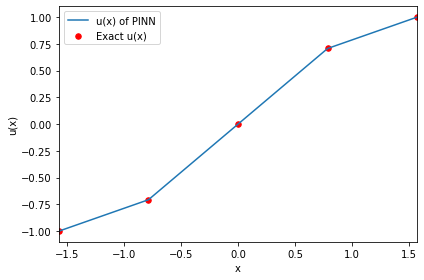

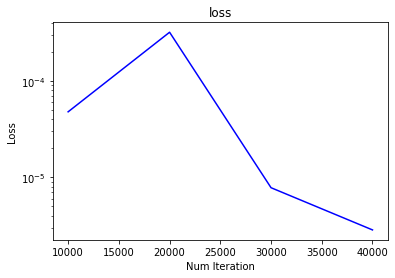

In [3]:
def ElasImag(nIter = 20000, print_period = 1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure

    layers_U =[1, 40, 40,1]
    layers_V1 =[1, 40,40,1]
    layers_V2 =[1, 40, 40,1]

    Xx = np.linspace(x_range[0], x_range[1], 100)
    Xx = np.reshape(Xx, [-1, 1])

    f = open("loss_record.txt", "w")
    num_train_tps =100
    num_test_tps =5

    model = PhysicsInformedNN(layers_U, layers_V1,layers_V2,x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []


    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            print(loss, file=f)
            start_time = time.time()
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure(1)
                x_test, U_test, V1_test,V2_test, _,_, _, _, _, _= model.test(num_test_tps)
                # u_exact = np.exp(2*x_test)
                u_exact = np.sin(x_test)
                # UV_test = np.hstack((U_test, V1_test, V2_test, V3_test))
                U = np.hstack((x_test, u_exact,U_test))
                # print(np.around(u_exact, 6))
                print(U)
                f = open("data.txt", "w")
                print(U, file=f)
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                print('L2U error: ', l2Uerror)
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='o', label='Exact u(x)')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
                figtopic = 'loss'
                plt.semilogy(it_array, loss_array, '-b')
                plt.xlabel("Num Iteration")
                plt.ylabel("Loss")
                plt.title(figtopic)
                plt.show()
ElasImag(nIter= 40000, print_period =10000, plot_period =10000)